In [1]:
# adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/
# https://towardsdatascience.com/pytorch-tutorial-distilled-95ce8781a89c

# 1. Import Modules

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
# fix random seed for reproducibility
np.random.seed(200184)

# 2. Train the GAN model

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [6]:
# defining classes and ANN
class AE_net(nn.Module):
    def __init__(self):
        super(AE_net, self).__init__()
        #net_list = [nn.Linear(1, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 1),  nn.ReLU()
        #           ]  # definition of model, just put in corresponding layers in sequence
        
        net_list = [nn.Linear(2, 15),   
                    nn.Tanh(),
                    nn.Linear(15, 15), 
                    nn.Tanh(),
                    nn.Linear(15, 2)#, 
#                     nn.Tanh(),
#                     nn.Linear(32, 8),
#                     nn.Tanh(),
#                     nn.Linear(8, 2)
                   ]
        self._net = nn.Sequential(*net_list).to(device)
        return

    def forward(self, x):
        return self._net(x)
    
def get_var_from_np(np_array, cuda=False, requires_grad=False):    # convert numpy to PyTorch variable for training
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp
    
def train(model, data_in, data_out, data_in_val, data_out_val):
    
    train_data = My_dataset(get_var_from_np(data_in), get_var_from_np(data_out))
    val_data = My_dataset(get_var_from_np(data_in_val), get_var_from_np(data_out_val))
    
    optimizer = torch.optim.SGD(model._net.parameters(), lr = 0.01, momentum=0.9)
    n_epoch = 3000
    batch_size = 100
    n_batch = math.ceil(1. * len(train_data) / batch_size)
    loss_train = np.zeros(n_epoch)
    loss_val = np.zeros(n_epoch)
    
    for epoch in range(n_epoch):    
        
        dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
        
        batch_idx = 0
        for train_in, train_out in dataset:
            out = model._net.forward(train_in)
            loss = nn.MSELoss()(out, train_out) 
            if (batch_idx+1) % min(10,n_batch) == 0:
                print ("Epoch = %5d, Batch = %5d/%5d [%4.0f%%]:\tTraining Loss = %12.5e" % (epoch, batch_idx+1, n_batch, 100. * (batch_idx+1) / n_batch, loss.cpu().data.numpy()))
            optimizer.zero_grad()
            loss.backward() # scalar variables, when we call .backward() on them, don’t require arguments – only tensors require a matching sized tensor argument to be passed to the .backward() operation
            optimizer.step()
            del loss
            batch_idx += 1
        
        data_out_pred = model._net.forward(get_var_from_np(data_in)).cpu().data.numpy()
        diff = data_out_pred - data_out
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_train[epoch] = MSE
        
        data_out_val_pred = model._net.forward(get_var_from_np(data_in_val)).cpu().data.numpy()
        diff = data_out_val_pred - data_out_val
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_val[epoch] = MSE        

    return loss_train, loss_val
    
class My_dataset(Dataset):      # construct dataset object for mini-batch gradient descent
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]

In [7]:
EBD = np.loadtxt("h2t latent space.txt",delimiter=' ')[:,1:5]
X = np.loadtxt("B_50001_10.txt",delimiter=' ')[:,0:2]

In [8]:
n = X.shape[0]

x = np.concatenate((EBD[:,0].reshape(EBD.shape[0],1),EBD[:,3].reshape(EBD.shape[0],1)), axis=1)

print (x)

[[-0.00263846 -0.00162525]
 [-0.00296734 -0.00032045]
 [-0.00257752  0.00203152]
 ...
 [-0.00146915  0.00109989]
 [-0.00223762 -0.00028185]
 [-0.00159293 -0.00048395]]


In [9]:
y = np.zeros((n,2))

y = np.concatenate((X[:,0].reshape(X.shape[0],1), X[:,1].reshape(X.shape[0],1)), axis=1)

print (y)

[[-0.00226417  0.00089316]
 [-0.0025789   0.00286235]
 [-0.00288158  0.00462698]
 ...
 [ 0.00416933 -0.00889798]
 [-0.00100227  0.00017455]
 [-0.00205245  0.00094186]]


In [10]:
test_frac = 0.10
val_frac = 0.20
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_frac, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_frac/(1-test_frac), random_state=43)

In [11]:
# scaling
xscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling
yscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling

# xscale = pre.StandardScaler()
# yscale = pre.StandardScaler()


X_train = xscale.fit_transform(x_train)
Y_train = yscale.fit_transform(y_train)
X_val = xscale.transform(x_val)
Y_val = yscale.transform(y_val)
X_test = xscale.transform(x_test)
Y_test = yscale.transform(y_test)
X = xscale.transform(x)
Y = yscale.transform(y)

In [12]:
# training
model = AE_net()
print(model)

AE_net(
  (_net): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [13]:
loss_train, loss_val = train(model, X_train, Y_train, X_val, Y_val)

Epoch =     0, Batch =    10/  350 [   3%]:	Training Loss =  4.44518e-02
Epoch =     0, Batch =    20/  350 [   6%]:	Training Loss =  6.49019e-02
Epoch =     0, Batch =    30/  350 [   9%]:	Training Loss =  5.25600e-02
Epoch =     0, Batch =    40/  350 [  11%]:	Training Loss =  4.40243e-02
Epoch =     0, Batch =    50/  350 [  14%]:	Training Loss =  4.36625e-02
Epoch =     0, Batch =    60/  350 [  17%]:	Training Loss =  4.53292e-02
Epoch =     0, Batch =    70/  350 [  20%]:	Training Loss =  3.97580e-02
Epoch =     0, Batch =    80/  350 [  23%]:	Training Loss =  2.97342e-02
Epoch =     0, Batch =    90/  350 [  26%]:	Training Loss =  2.75465e-02
Epoch =     0, Batch =   100/  350 [  29%]:	Training Loss =  2.78335e-02
Epoch =     0, Batch =   110/  350 [  31%]:	Training Loss =  4.50587e-02
Epoch =     0, Batch =   120/  350 [  34%]:	Training Loss =  2.27269e-02
Epoch =     0, Batch =   130/  350 [  37%]:	Training Loss =  2.56587e-02
Epoch =     0, Batch =   140/  350 [  40%]:	Trainin

Epoch =     3, Batch =   150/  350 [  43%]:	Training Loss =  1.30677e-02
Epoch =     3, Batch =   160/  350 [  46%]:	Training Loss =  1.77921e-02
Epoch =     3, Batch =   170/  350 [  49%]:	Training Loss =  1.91691e-02
Epoch =     3, Batch =   180/  350 [  51%]:	Training Loss =  1.70193e-02
Epoch =     3, Batch =   190/  350 [  54%]:	Training Loss =  1.67684e-02
Epoch =     3, Batch =   200/  350 [  57%]:	Training Loss =  2.01884e-02
Epoch =     3, Batch =   210/  350 [  60%]:	Training Loss =  1.45891e-02
Epoch =     3, Batch =   220/  350 [  63%]:	Training Loss =  1.93368e-02
Epoch =     3, Batch =   230/  350 [  66%]:	Training Loss =  1.83979e-02
Epoch =     3, Batch =   240/  350 [  69%]:	Training Loss =  1.75431e-02
Epoch =     3, Batch =   250/  350 [  71%]:	Training Loss =  1.38965e-02
Epoch =     3, Batch =   260/  350 [  74%]:	Training Loss =  2.03770e-02
Epoch =     3, Batch =   270/  350 [  77%]:	Training Loss =  1.66667e-02
Epoch =     3, Batch =   280/  350 [  80%]:	Trainin

Epoch =     6, Batch =   280/  350 [  80%]:	Training Loss =  1.68433e-02
Epoch =     6, Batch =   290/  350 [  83%]:	Training Loss =  1.84513e-02
Epoch =     6, Batch =   300/  350 [  86%]:	Training Loss =  2.15634e-02
Epoch =     6, Batch =   310/  350 [  89%]:	Training Loss =  2.49474e-02
Epoch =     6, Batch =   320/  350 [  91%]:	Training Loss =  2.07389e-02
Epoch =     6, Batch =   330/  350 [  94%]:	Training Loss =  1.80283e-02
Epoch =     6, Batch =   340/  350 [  97%]:	Training Loss =  2.03385e-02
Epoch =     7, Batch =    10/  350 [   3%]:	Training Loss =  1.30819e-02
Epoch =     7, Batch =    20/  350 [   6%]:	Training Loss =  1.48625e-02
Epoch =     7, Batch =    30/  350 [   9%]:	Training Loss =  1.72895e-02
Epoch =     7, Batch =    40/  350 [  11%]:	Training Loss =  1.85081e-02
Epoch =     7, Batch =    50/  350 [  14%]:	Training Loss =  1.63183e-02
Epoch =     7, Batch =    60/  350 [  17%]:	Training Loss =  1.53583e-02
Epoch =     7, Batch =    70/  350 [  20%]:	Trainin

Epoch =    10, Batch =   130/  350 [  37%]:	Training Loss =  1.82180e-02
Epoch =    10, Batch =   140/  350 [  40%]:	Training Loss =  2.09725e-02
Epoch =    10, Batch =   150/  350 [  43%]:	Training Loss =  1.63292e-02
Epoch =    10, Batch =   160/  350 [  46%]:	Training Loss =  1.54350e-02
Epoch =    10, Batch =   170/  350 [  49%]:	Training Loss =  2.07951e-02
Epoch =    10, Batch =   180/  350 [  51%]:	Training Loss =  1.74699e-02
Epoch =    10, Batch =   190/  350 [  54%]:	Training Loss =  1.88185e-02
Epoch =    10, Batch =   200/  350 [  57%]:	Training Loss =  1.77000e-02
Epoch =    10, Batch =   210/  350 [  60%]:	Training Loss =  1.49146e-02
Epoch =    10, Batch =   220/  350 [  63%]:	Training Loss =  1.40685e-02
Epoch =    10, Batch =   230/  350 [  66%]:	Training Loss =  2.17008e-02
Epoch =    10, Batch =   240/  350 [  69%]:	Training Loss =  1.58781e-02
Epoch =    10, Batch =   250/  350 [  71%]:	Training Loss =  2.37196e-02
Epoch =    10, Batch =   260/  350 [  74%]:	Trainin

Epoch =    13, Batch =   330/  350 [  94%]:	Training Loss =  1.93125e-02
Epoch =    13, Batch =   340/  350 [  97%]:	Training Loss =  1.83468e-02
Epoch =    14, Batch =    10/  350 [   3%]:	Training Loss =  2.02678e-02
Epoch =    14, Batch =    20/  350 [   6%]:	Training Loss =  2.05968e-02
Epoch =    14, Batch =    30/  350 [   9%]:	Training Loss =  1.69753e-02
Epoch =    14, Batch =    40/  350 [  11%]:	Training Loss =  2.00763e-02
Epoch =    14, Batch =    50/  350 [  14%]:	Training Loss =  1.90525e-02
Epoch =    14, Batch =    60/  350 [  17%]:	Training Loss =  1.82112e-02
Epoch =    14, Batch =    70/  350 [  20%]:	Training Loss =  2.48572e-02
Epoch =    14, Batch =    80/  350 [  23%]:	Training Loss =  1.81776e-02
Epoch =    14, Batch =    90/  350 [  26%]:	Training Loss =  1.87947e-02
Epoch =    14, Batch =   100/  350 [  29%]:	Training Loss =  1.63545e-02
Epoch =    14, Batch =   110/  350 [  31%]:	Training Loss =  2.28500e-02
Epoch =    14, Batch =   120/  350 [  34%]:	Trainin

Epoch =    17, Batch =   120/  350 [  34%]:	Training Loss =  2.23683e-02
Epoch =    17, Batch =   130/  350 [  37%]:	Training Loss =  1.81796e-02
Epoch =    17, Batch =   140/  350 [  40%]:	Training Loss =  1.62328e-02
Epoch =    17, Batch =   150/  350 [  43%]:	Training Loss =  1.54513e-02
Epoch =    17, Batch =   160/  350 [  46%]:	Training Loss =  1.16609e-02
Epoch =    17, Batch =   170/  350 [  49%]:	Training Loss =  2.04615e-02
Epoch =    17, Batch =   180/  350 [  51%]:	Training Loss =  2.02207e-02
Epoch =    17, Batch =   190/  350 [  54%]:	Training Loss =  1.88452e-02
Epoch =    17, Batch =   200/  350 [  57%]:	Training Loss =  1.91916e-02
Epoch =    17, Batch =   210/  350 [  60%]:	Training Loss =  1.65978e-02
Epoch =    17, Batch =   220/  350 [  63%]:	Training Loss =  1.73719e-02
Epoch =    17, Batch =   230/  350 [  66%]:	Training Loss =  2.39736e-02
Epoch =    17, Batch =   240/  350 [  69%]:	Training Loss =  1.83513e-02
Epoch =    17, Batch =   250/  350 [  71%]:	Trainin

Epoch =    20, Batch =   240/  350 [  69%]:	Training Loss =  1.68734e-02
Epoch =    20, Batch =   250/  350 [  71%]:	Training Loss =  1.74092e-02
Epoch =    20, Batch =   260/  350 [  74%]:	Training Loss =  1.51540e-02
Epoch =    20, Batch =   270/  350 [  77%]:	Training Loss =  2.10801e-02
Epoch =    20, Batch =   280/  350 [  80%]:	Training Loss =  1.60185e-02
Epoch =    20, Batch =   290/  350 [  83%]:	Training Loss =  2.14563e-02
Epoch =    20, Batch =   300/  350 [  86%]:	Training Loss =  1.86894e-02
Epoch =    20, Batch =   310/  350 [  89%]:	Training Loss =  1.89052e-02
Epoch =    20, Batch =   320/  350 [  91%]:	Training Loss =  1.98225e-02
Epoch =    20, Batch =   330/  350 [  94%]:	Training Loss =  1.70693e-02
Epoch =    20, Batch =   340/  350 [  97%]:	Training Loss =  2.09030e-02
Epoch =    21, Batch =    10/  350 [   3%]:	Training Loss =  1.82917e-02
Epoch =    21, Batch =    20/  350 [   6%]:	Training Loss =  1.68866e-02
Epoch =    21, Batch =    30/  350 [   9%]:	Trainin

Epoch =    24, Batch =    10/  350 [   3%]:	Training Loss =  1.57354e-02
Epoch =    24, Batch =    20/  350 [   6%]:	Training Loss =  1.95648e-02
Epoch =    24, Batch =    30/  350 [   9%]:	Training Loss =  1.33474e-02
Epoch =    24, Batch =    40/  350 [  11%]:	Training Loss =  1.60992e-02
Epoch =    24, Batch =    50/  350 [  14%]:	Training Loss =  1.52987e-02
Epoch =    24, Batch =    60/  350 [  17%]:	Training Loss =  1.74649e-02
Epoch =    24, Batch =    70/  350 [  20%]:	Training Loss =  2.16175e-02
Epoch =    24, Batch =    80/  350 [  23%]:	Training Loss =  1.93216e-02
Epoch =    24, Batch =    90/  350 [  26%]:	Training Loss =  1.49719e-02
Epoch =    24, Batch =   100/  350 [  29%]:	Training Loss =  2.02858e-02
Epoch =    24, Batch =   110/  350 [  31%]:	Training Loss =  1.63291e-02
Epoch =    24, Batch =   120/  350 [  34%]:	Training Loss =  1.61334e-02
Epoch =    24, Batch =   130/  350 [  37%]:	Training Loss =  2.21927e-02
Epoch =    24, Batch =   140/  350 [  40%]:	Trainin

Epoch =    27, Batch =   140/  350 [  40%]:	Training Loss =  1.39406e-02
Epoch =    27, Batch =   150/  350 [  43%]:	Training Loss =  1.61528e-02
Epoch =    27, Batch =   160/  350 [  46%]:	Training Loss =  1.66186e-02
Epoch =    27, Batch =   170/  350 [  49%]:	Training Loss =  1.68483e-02
Epoch =    27, Batch =   180/  350 [  51%]:	Training Loss =  2.05557e-02
Epoch =    27, Batch =   190/  350 [  54%]:	Training Loss =  1.22823e-02
Epoch =    27, Batch =   200/  350 [  57%]:	Training Loss =  1.96034e-02
Epoch =    27, Batch =   210/  350 [  60%]:	Training Loss =  2.15622e-02
Epoch =    27, Batch =   220/  350 [  63%]:	Training Loss =  1.63733e-02
Epoch =    27, Batch =   230/  350 [  66%]:	Training Loss =  1.77332e-02
Epoch =    27, Batch =   240/  350 [  69%]:	Training Loss =  1.70504e-02
Epoch =    27, Batch =   250/  350 [  71%]:	Training Loss =  1.76380e-02
Epoch =    27, Batch =   260/  350 [  74%]:	Training Loss =  2.08054e-02
Epoch =    27, Batch =   270/  350 [  77%]:	Trainin

Epoch =    30, Batch =   280/  350 [  80%]:	Training Loss =  1.99860e-02
Epoch =    30, Batch =   290/  350 [  83%]:	Training Loss =  1.46942e-02
Epoch =    30, Batch =   300/  350 [  86%]:	Training Loss =  1.87891e-02
Epoch =    30, Batch =   310/  350 [  89%]:	Training Loss =  1.48180e-02
Epoch =    30, Batch =   320/  350 [  91%]:	Training Loss =  1.44552e-02
Epoch =    30, Batch =   330/  350 [  94%]:	Training Loss =  1.60185e-02
Epoch =    30, Batch =   340/  350 [  97%]:	Training Loss =  2.00259e-02
Epoch =    31, Batch =    10/  350 [   3%]:	Training Loss =  1.69383e-02
Epoch =    31, Batch =    20/  350 [   6%]:	Training Loss =  1.58540e-02
Epoch =    31, Batch =    30/  350 [   9%]:	Training Loss =  1.57446e-02
Epoch =    31, Batch =    40/  350 [  11%]:	Training Loss =  2.37882e-02
Epoch =    31, Batch =    50/  350 [  14%]:	Training Loss =  1.78977e-02
Epoch =    31, Batch =    60/  350 [  17%]:	Training Loss =  1.98349e-02
Epoch =    31, Batch =    70/  350 [  20%]:	Trainin

Epoch =    34, Batch =    60/  350 [  17%]:	Training Loss =  1.73343e-02
Epoch =    34, Batch =    70/  350 [  20%]:	Training Loss =  2.01890e-02
Epoch =    34, Batch =    80/  350 [  23%]:	Training Loss =  1.64061e-02
Epoch =    34, Batch =    90/  350 [  26%]:	Training Loss =  1.53769e-02
Epoch =    34, Batch =   100/  350 [  29%]:	Training Loss =  1.88073e-02
Epoch =    34, Batch =   110/  350 [  31%]:	Training Loss =  1.35124e-02
Epoch =    34, Batch =   120/  350 [  34%]:	Training Loss =  1.45709e-02
Epoch =    34, Batch =   130/  350 [  37%]:	Training Loss =  1.96967e-02
Epoch =    34, Batch =   140/  350 [  40%]:	Training Loss =  1.93776e-02
Epoch =    34, Batch =   150/  350 [  43%]:	Training Loss =  1.26035e-02
Epoch =    34, Batch =   160/  350 [  46%]:	Training Loss =  1.84805e-02
Epoch =    34, Batch =   170/  350 [  49%]:	Training Loss =  1.96932e-02
Epoch =    34, Batch =   180/  350 [  51%]:	Training Loss =  1.94314e-02
Epoch =    34, Batch =   190/  350 [  54%]:	Trainin

Epoch =    37, Batch =   260/  350 [  74%]:	Training Loss =  2.69064e-02
Epoch =    37, Batch =   270/  350 [  77%]:	Training Loss =  1.72299e-02
Epoch =    37, Batch =   280/  350 [  80%]:	Training Loss =  1.65148e-02
Epoch =    37, Batch =   290/  350 [  83%]:	Training Loss =  2.18242e-02
Epoch =    37, Batch =   300/  350 [  86%]:	Training Loss =  1.67588e-02
Epoch =    37, Batch =   310/  350 [  89%]:	Training Loss =  1.74206e-02
Epoch =    37, Batch =   320/  350 [  91%]:	Training Loss =  1.81162e-02
Epoch =    37, Batch =   330/  350 [  94%]:	Training Loss =  1.68449e-02
Epoch =    37, Batch =   340/  350 [  97%]:	Training Loss =  1.40043e-02
Epoch =    38, Batch =    10/  350 [   3%]:	Training Loss =  1.85560e-02
Epoch =    38, Batch =    20/  350 [   6%]:	Training Loss =  1.83800e-02
Epoch =    38, Batch =    30/  350 [   9%]:	Training Loss =  1.51282e-02
Epoch =    38, Batch =    40/  350 [  11%]:	Training Loss =  1.81508e-02
Epoch =    38, Batch =    50/  350 [  14%]:	Trainin

Epoch =    41, Batch =    70/  350 [  20%]:	Training Loss =  1.90222e-02
Epoch =    41, Batch =    80/  350 [  23%]:	Training Loss =  1.63505e-02
Epoch =    41, Batch =    90/  350 [  26%]:	Training Loss =  1.59093e-02
Epoch =    41, Batch =   100/  350 [  29%]:	Training Loss =  1.67742e-02
Epoch =    41, Batch =   110/  350 [  31%]:	Training Loss =  2.10950e-02
Epoch =    41, Batch =   120/  350 [  34%]:	Training Loss =  1.73339e-02
Epoch =    41, Batch =   130/  350 [  37%]:	Training Loss =  1.87366e-02
Epoch =    41, Batch =   140/  350 [  40%]:	Training Loss =  1.96630e-02
Epoch =    41, Batch =   150/  350 [  43%]:	Training Loss =  1.50458e-02
Epoch =    41, Batch =   160/  350 [  46%]:	Training Loss =  1.47045e-02
Epoch =    41, Batch =   170/  350 [  49%]:	Training Loss =  1.68080e-02
Epoch =    41, Batch =   180/  350 [  51%]:	Training Loss =  1.76254e-02
Epoch =    41, Batch =   190/  350 [  54%]:	Training Loss =  1.57569e-02
Epoch =    41, Batch =   200/  350 [  57%]:	Trainin

Epoch =    44, Batch =   180/  350 [  51%]:	Training Loss =  1.59246e-02
Epoch =    44, Batch =   190/  350 [  54%]:	Training Loss =  1.28733e-02
Epoch =    44, Batch =   200/  350 [  57%]:	Training Loss =  1.57165e-02
Epoch =    44, Batch =   210/  350 [  60%]:	Training Loss =  1.33572e-02
Epoch =    44, Batch =   220/  350 [  63%]:	Training Loss =  1.57777e-02
Epoch =    44, Batch =   230/  350 [  66%]:	Training Loss =  1.76390e-02
Epoch =    44, Batch =   240/  350 [  69%]:	Training Loss =  1.55956e-02
Epoch =    44, Batch =   250/  350 [  71%]:	Training Loss =  1.58692e-02
Epoch =    44, Batch =   260/  350 [  74%]:	Training Loss =  1.53971e-02
Epoch =    44, Batch =   270/  350 [  77%]:	Training Loss =  1.35593e-02
Epoch =    44, Batch =   280/  350 [  80%]:	Training Loss =  1.65683e-02
Epoch =    44, Batch =   290/  350 [  83%]:	Training Loss =  2.17184e-02
Epoch =    44, Batch =   300/  350 [  86%]:	Training Loss =  1.74178e-02
Epoch =    44, Batch =   310/  350 [  89%]:	Trainin

Epoch =    48, Batch =    10/  350 [   3%]:	Training Loss =  1.77030e-02
Epoch =    48, Batch =    20/  350 [   6%]:	Training Loss =  1.83421e-02
Epoch =    48, Batch =    30/  350 [   9%]:	Training Loss =  2.19207e-02
Epoch =    48, Batch =    40/  350 [  11%]:	Training Loss =  1.61215e-02
Epoch =    48, Batch =    50/  350 [  14%]:	Training Loss =  2.21110e-02
Epoch =    48, Batch =    60/  350 [  17%]:	Training Loss =  1.63414e-02
Epoch =    48, Batch =    70/  350 [  20%]:	Training Loss =  1.56037e-02
Epoch =    48, Batch =    80/  350 [  23%]:	Training Loss =  1.75607e-02
Epoch =    48, Batch =    90/  350 [  26%]:	Training Loss =  1.69248e-02
Epoch =    48, Batch =   100/  350 [  29%]:	Training Loss =  1.53773e-02
Epoch =    48, Batch =   110/  350 [  31%]:	Training Loss =  1.54916e-02
Epoch =    48, Batch =   120/  350 [  34%]:	Training Loss =  1.92505e-02
Epoch =    48, Batch =   130/  350 [  37%]:	Training Loss =  1.55549e-02
Epoch =    48, Batch =   140/  350 [  40%]:	Trainin

Epoch =    51, Batch =   130/  350 [  37%]:	Training Loss =  1.63187e-02
Epoch =    51, Batch =   140/  350 [  40%]:	Training Loss =  1.71124e-02
Epoch =    51, Batch =   150/  350 [  43%]:	Training Loss =  1.41834e-02
Epoch =    51, Batch =   160/  350 [  46%]:	Training Loss =  1.46118e-02
Epoch =    51, Batch =   170/  350 [  49%]:	Training Loss =  1.36709e-02
Epoch =    51, Batch =   180/  350 [  51%]:	Training Loss =  1.45877e-02
Epoch =    51, Batch =   190/  350 [  54%]:	Training Loss =  1.67125e-02
Epoch =    51, Batch =   200/  350 [  57%]:	Training Loss =  1.52255e-02
Epoch =    51, Batch =   210/  350 [  60%]:	Training Loss =  1.77267e-02
Epoch =    51, Batch =   220/  350 [  63%]:	Training Loss =  1.54569e-02
Epoch =    51, Batch =   230/  350 [  66%]:	Training Loss =  1.93676e-02
Epoch =    51, Batch =   240/  350 [  69%]:	Training Loss =  1.59968e-02
Epoch =    51, Batch =   250/  350 [  71%]:	Training Loss =  1.46658e-02
Epoch =    51, Batch =   260/  350 [  74%]:	Trainin

Epoch =    54, Batch =   260/  350 [  74%]:	Training Loss =  1.77873e-02
Epoch =    54, Batch =   270/  350 [  77%]:	Training Loss =  1.50251e-02
Epoch =    54, Batch =   280/  350 [  80%]:	Training Loss =  1.63045e-02
Epoch =    54, Batch =   290/  350 [  83%]:	Training Loss =  1.32933e-02
Epoch =    54, Batch =   300/  350 [  86%]:	Training Loss =  1.38084e-02
Epoch =    54, Batch =   310/  350 [  89%]:	Training Loss =  1.56569e-02
Epoch =    54, Batch =   320/  350 [  91%]:	Training Loss =  1.60923e-02
Epoch =    54, Batch =   330/  350 [  94%]:	Training Loss =  2.31033e-02
Epoch =    54, Batch =   340/  350 [  97%]:	Training Loss =  1.18608e-02
Epoch =    55, Batch =    10/  350 [   3%]:	Training Loss =  1.93158e-02
Epoch =    55, Batch =    20/  350 [   6%]:	Training Loss =  1.63949e-02
Epoch =    55, Batch =    30/  350 [   9%]:	Training Loss =  2.01265e-02
Epoch =    55, Batch =    40/  350 [  11%]:	Training Loss =  1.40268e-02
Epoch =    55, Batch =    50/  350 [  14%]:	Trainin

Epoch =    58, Batch =    50/  350 [  14%]:	Training Loss =  1.30576e-02
Epoch =    58, Batch =    60/  350 [  17%]:	Training Loss =  1.70322e-02
Epoch =    58, Batch =    70/  350 [  20%]:	Training Loss =  1.79616e-02
Epoch =    58, Batch =    80/  350 [  23%]:	Training Loss =  1.42966e-02
Epoch =    58, Batch =    90/  350 [  26%]:	Training Loss =  1.45817e-02
Epoch =    58, Batch =   100/  350 [  29%]:	Training Loss =  1.40667e-02
Epoch =    58, Batch =   110/  350 [  31%]:	Training Loss =  1.07293e-02
Epoch =    58, Batch =   120/  350 [  34%]:	Training Loss =  1.25548e-02
Epoch =    58, Batch =   130/  350 [  37%]:	Training Loss =  1.28152e-02
Epoch =    58, Batch =   140/  350 [  40%]:	Training Loss =  1.24274e-02
Epoch =    58, Batch =   150/  350 [  43%]:	Training Loss =  1.41868e-02
Epoch =    58, Batch =   160/  350 [  46%]:	Training Loss =  1.23931e-02
Epoch =    58, Batch =   170/  350 [  49%]:	Training Loss =  1.58406e-02
Epoch =    58, Batch =   180/  350 [  51%]:	Trainin

Epoch =    61, Batch =   170/  350 [  49%]:	Training Loss =  1.23869e-02
Epoch =    61, Batch =   180/  350 [  51%]:	Training Loss =  1.37314e-02
Epoch =    61, Batch =   190/  350 [  54%]:	Training Loss =  1.51527e-02
Epoch =    61, Batch =   200/  350 [  57%]:	Training Loss =  1.51532e-02
Epoch =    61, Batch =   210/  350 [  60%]:	Training Loss =  1.64506e-02
Epoch =    61, Batch =   220/  350 [  63%]:	Training Loss =  1.36588e-02
Epoch =    61, Batch =   230/  350 [  66%]:	Training Loss =  1.52392e-02
Epoch =    61, Batch =   240/  350 [  69%]:	Training Loss =  1.30550e-02
Epoch =    61, Batch =   250/  350 [  71%]:	Training Loss =  1.50874e-02
Epoch =    61, Batch =   260/  350 [  74%]:	Training Loss =  1.31708e-02
Epoch =    61, Batch =   270/  350 [  77%]:	Training Loss =  1.63237e-02
Epoch =    61, Batch =   280/  350 [  80%]:	Training Loss =  1.23404e-02
Epoch =    61, Batch =   290/  350 [  83%]:	Training Loss =  1.68388e-02
Epoch =    61, Batch =   300/  350 [  86%]:	Trainin

Epoch =    64, Batch =   280/  350 [  80%]:	Training Loss =  1.65009e-02
Epoch =    64, Batch =   290/  350 [  83%]:	Training Loss =  1.55968e-02
Epoch =    64, Batch =   300/  350 [  86%]:	Training Loss =  1.06684e-02
Epoch =    64, Batch =   310/  350 [  89%]:	Training Loss =  1.49314e-02
Epoch =    64, Batch =   320/  350 [  91%]:	Training Loss =  9.83858e-03
Epoch =    64, Batch =   330/  350 [  94%]:	Training Loss =  1.47660e-02
Epoch =    64, Batch =   340/  350 [  97%]:	Training Loss =  1.18410e-02
Epoch =    65, Batch =    10/  350 [   3%]:	Training Loss =  1.23237e-02
Epoch =    65, Batch =    20/  350 [   6%]:	Training Loss =  1.47333e-02
Epoch =    65, Batch =    30/  350 [   9%]:	Training Loss =  1.30319e-02
Epoch =    65, Batch =    40/  350 [  11%]:	Training Loss =  1.65992e-02
Epoch =    65, Batch =    50/  350 [  14%]:	Training Loss =  2.19142e-02
Epoch =    65, Batch =    60/  350 [  17%]:	Training Loss =  1.84028e-02
Epoch =    65, Batch =    70/  350 [  20%]:	Trainin

Epoch =    68, Batch =   180/  350 [  51%]:	Training Loss =  1.35375e-02
Epoch =    68, Batch =   190/  350 [  54%]:	Training Loss =  1.10358e-02
Epoch =    68, Batch =   200/  350 [  57%]:	Training Loss =  1.13420e-02
Epoch =    68, Batch =   210/  350 [  60%]:	Training Loss =  1.09168e-02
Epoch =    68, Batch =   220/  350 [  63%]:	Training Loss =  1.52468e-02
Epoch =    68, Batch =   230/  350 [  66%]:	Training Loss =  1.69448e-02
Epoch =    68, Batch =   240/  350 [  69%]:	Training Loss =  1.54167e-02
Epoch =    68, Batch =   250/  350 [  71%]:	Training Loss =  1.00036e-02
Epoch =    68, Batch =   260/  350 [  74%]:	Training Loss =  1.51230e-02
Epoch =    68, Batch =   270/  350 [  77%]:	Training Loss =  1.60017e-02
Epoch =    68, Batch =   280/  350 [  80%]:	Training Loss =  1.33061e-02
Epoch =    68, Batch =   290/  350 [  83%]:	Training Loss =  1.90860e-02
Epoch =    68, Batch =   300/  350 [  86%]:	Training Loss =  1.04924e-02
Epoch =    68, Batch =   310/  350 [  89%]:	Trainin

Epoch =    72, Batch =    70/  350 [  20%]:	Training Loss =  1.40625e-02
Epoch =    72, Batch =    80/  350 [  23%]:	Training Loss =  1.08691e-02
Epoch =    72, Batch =    90/  350 [  26%]:	Training Loss =  1.11567e-02
Epoch =    72, Batch =   100/  350 [  29%]:	Training Loss =  1.24701e-02
Epoch =    72, Batch =   110/  350 [  31%]:	Training Loss =  1.25394e-02
Epoch =    72, Batch =   120/  350 [  34%]:	Training Loss =  1.37591e-02
Epoch =    72, Batch =   130/  350 [  37%]:	Training Loss =  1.20143e-02
Epoch =    72, Batch =   140/  350 [  40%]:	Training Loss =  1.09979e-02
Epoch =    72, Batch =   150/  350 [  43%]:	Training Loss =  1.54728e-02
Epoch =    72, Batch =   160/  350 [  46%]:	Training Loss =  1.13080e-02
Epoch =    72, Batch =   170/  350 [  49%]:	Training Loss =  1.42754e-02
Epoch =    72, Batch =   180/  350 [  51%]:	Training Loss =  1.60692e-02
Epoch =    72, Batch =   190/  350 [  54%]:	Training Loss =  1.42234e-02
Epoch =    72, Batch =   200/  350 [  57%]:	Trainin

Epoch =    75, Batch =   190/  350 [  54%]:	Training Loss =  1.05407e-02
Epoch =    75, Batch =   200/  350 [  57%]:	Training Loss =  1.10217e-02
Epoch =    75, Batch =   210/  350 [  60%]:	Training Loss =  1.28738e-02
Epoch =    75, Batch =   220/  350 [  63%]:	Training Loss =  1.77392e-02
Epoch =    75, Batch =   230/  350 [  66%]:	Training Loss =  1.34639e-02
Epoch =    75, Batch =   240/  350 [  69%]:	Training Loss =  1.05682e-02
Epoch =    75, Batch =   250/  350 [  71%]:	Training Loss =  1.38255e-02
Epoch =    75, Batch =   260/  350 [  74%]:	Training Loss =  1.32681e-02
Epoch =    75, Batch =   270/  350 [  77%]:	Training Loss =  1.67623e-02
Epoch =    75, Batch =   280/  350 [  80%]:	Training Loss =  1.10396e-02
Epoch =    75, Batch =   290/  350 [  83%]:	Training Loss =  1.93673e-02
Epoch =    75, Batch =   300/  350 [  86%]:	Training Loss =  1.03211e-02
Epoch =    75, Batch =   310/  350 [  89%]:	Training Loss =  1.55351e-02
Epoch =    75, Batch =   320/  350 [  91%]:	Trainin

Epoch =    78, Batch =   310/  350 [  89%]:	Training Loss =  1.56748e-02
Epoch =    78, Batch =   320/  350 [  91%]:	Training Loss =  1.08812e-02
Epoch =    78, Batch =   330/  350 [  94%]:	Training Loss =  1.24557e-02
Epoch =    78, Batch =   340/  350 [  97%]:	Training Loss =  1.39513e-02
Epoch =    79, Batch =    10/  350 [   3%]:	Training Loss =  1.36493e-02
Epoch =    79, Batch =    20/  350 [   6%]:	Training Loss =  1.83651e-02
Epoch =    79, Batch =    30/  350 [   9%]:	Training Loss =  1.32258e-02
Epoch =    79, Batch =    40/  350 [  11%]:	Training Loss =  1.08147e-02
Epoch =    79, Batch =    50/  350 [  14%]:	Training Loss =  1.33004e-02
Epoch =    79, Batch =    60/  350 [  17%]:	Training Loss =  1.10993e-02
Epoch =    79, Batch =    70/  350 [  20%]:	Training Loss =  1.51144e-02
Epoch =    79, Batch =    80/  350 [  23%]:	Training Loss =  1.80412e-02
Epoch =    79, Batch =    90/  350 [  26%]:	Training Loss =  1.71098e-02
Epoch =    79, Batch =   100/  350 [  29%]:	Trainin

Epoch =    82, Batch =   150/  350 [  43%]:	Training Loss =  1.03030e-02
Epoch =    82, Batch =   160/  350 [  46%]:	Training Loss =  1.61489e-02
Epoch =    82, Batch =   170/  350 [  49%]:	Training Loss =  1.78398e-02
Epoch =    82, Batch =   180/  350 [  51%]:	Training Loss =  1.80856e-02
Epoch =    82, Batch =   190/  350 [  54%]:	Training Loss =  1.29030e-02
Epoch =    82, Batch =   200/  350 [  57%]:	Training Loss =  1.58302e-02
Epoch =    82, Batch =   210/  350 [  60%]:	Training Loss =  1.57650e-02
Epoch =    82, Batch =   220/  350 [  63%]:	Training Loss =  1.26872e-02
Epoch =    82, Batch =   230/  350 [  66%]:	Training Loss =  1.17833e-02
Epoch =    82, Batch =   240/  350 [  69%]:	Training Loss =  1.64375e-02
Epoch =    82, Batch =   250/  350 [  71%]:	Training Loss =  1.44236e-02
Epoch =    82, Batch =   260/  350 [  74%]:	Training Loss =  1.26462e-02
Epoch =    82, Batch =   270/  350 [  77%]:	Training Loss =  1.18165e-02
Epoch =    82, Batch =   280/  350 [  80%]:	Trainin

Epoch =    85, Batch =   280/  350 [  80%]:	Training Loss =  1.60259e-02
Epoch =    85, Batch =   290/  350 [  83%]:	Training Loss =  1.07387e-02
Epoch =    85, Batch =   300/  350 [  86%]:	Training Loss =  1.59140e-02
Epoch =    85, Batch =   310/  350 [  89%]:	Training Loss =  1.21244e-02
Epoch =    85, Batch =   320/  350 [  91%]:	Training Loss =  1.87611e-02
Epoch =    85, Batch =   330/  350 [  94%]:	Training Loss =  1.52106e-02
Epoch =    85, Batch =   340/  350 [  97%]:	Training Loss =  1.47219e-02
Epoch =    86, Batch =    10/  350 [   3%]:	Training Loss =  1.05504e-02
Epoch =    86, Batch =    20/  350 [   6%]:	Training Loss =  1.27183e-02
Epoch =    86, Batch =    30/  350 [   9%]:	Training Loss =  1.36984e-02
Epoch =    86, Batch =    40/  350 [  11%]:	Training Loss =  1.19982e-02
Epoch =    86, Batch =    50/  350 [  14%]:	Training Loss =  1.15096e-02
Epoch =    86, Batch =    60/  350 [  17%]:	Training Loss =  1.57678e-02
Epoch =    86, Batch =    70/  350 [  20%]:	Trainin

Epoch =    89, Batch =    90/  350 [  26%]:	Training Loss =  1.52048e-02
Epoch =    89, Batch =   100/  350 [  29%]:	Training Loss =  1.00334e-02
Epoch =    89, Batch =   110/  350 [  31%]:	Training Loss =  8.50580e-03
Epoch =    89, Batch =   120/  350 [  34%]:	Training Loss =  2.26397e-02
Epoch =    89, Batch =   130/  350 [  37%]:	Training Loss =  1.39359e-02
Epoch =    89, Batch =   140/  350 [  40%]:	Training Loss =  1.63252e-02
Epoch =    89, Batch =   150/  350 [  43%]:	Training Loss =  1.38103e-02
Epoch =    89, Batch =   160/  350 [  46%]:	Training Loss =  1.42849e-02
Epoch =    89, Batch =   170/  350 [  49%]:	Training Loss =  1.43211e-02
Epoch =    89, Batch =   180/  350 [  51%]:	Training Loss =  1.28704e-02
Epoch =    89, Batch =   190/  350 [  54%]:	Training Loss =  1.45707e-02
Epoch =    89, Batch =   200/  350 [  57%]:	Training Loss =  1.15046e-02
Epoch =    89, Batch =   210/  350 [  60%]:	Training Loss =  1.12893e-02
Epoch =    89, Batch =   220/  350 [  63%]:	Trainin

Epoch =    92, Batch =   250/  350 [  71%]:	Training Loss =  1.32616e-02
Epoch =    92, Batch =   260/  350 [  74%]:	Training Loss =  1.76511e-02
Epoch =    92, Batch =   270/  350 [  77%]:	Training Loss =  1.43589e-02
Epoch =    92, Batch =   280/  350 [  80%]:	Training Loss =  1.74555e-02
Epoch =    92, Batch =   290/  350 [  83%]:	Training Loss =  1.09564e-02
Epoch =    92, Batch =   300/  350 [  86%]:	Training Loss =  1.72785e-02
Epoch =    92, Batch =   310/  350 [  89%]:	Training Loss =  1.43119e-02
Epoch =    92, Batch =   320/  350 [  91%]:	Training Loss =  1.59984e-02
Epoch =    92, Batch =   330/  350 [  94%]:	Training Loss =  1.11303e-02
Epoch =    92, Batch =   340/  350 [  97%]:	Training Loss =  1.39470e-02
Epoch =    93, Batch =    10/  350 [   3%]:	Training Loss =  1.12445e-02
Epoch =    93, Batch =    20/  350 [   6%]:	Training Loss =  1.38705e-02
Epoch =    93, Batch =    30/  350 [   9%]:	Training Loss =  2.35617e-02
Epoch =    93, Batch =    40/  350 [  11%]:	Trainin

Epoch =    96, Batch =   100/  350 [  29%]:	Training Loss =  1.74747e-02
Epoch =    96, Batch =   110/  350 [  31%]:	Training Loss =  1.33396e-02
Epoch =    96, Batch =   120/  350 [  34%]:	Training Loss =  1.33456e-02
Epoch =    96, Batch =   130/  350 [  37%]:	Training Loss =  1.28546e-02
Epoch =    96, Batch =   140/  350 [  40%]:	Training Loss =  1.88901e-02
Epoch =    96, Batch =   150/  350 [  43%]:	Training Loss =  1.26296e-02
Epoch =    96, Batch =   160/  350 [  46%]:	Training Loss =  1.32932e-02
Epoch =    96, Batch =   170/  350 [  49%]:	Training Loss =  1.25589e-02
Epoch =    96, Batch =   180/  350 [  51%]:	Training Loss =  9.94433e-03
Epoch =    96, Batch =   190/  350 [  54%]:	Training Loss =  1.83724e-02
Epoch =    96, Batch =   200/  350 [  57%]:	Training Loss =  1.47782e-02
Epoch =    96, Batch =   210/  350 [  60%]:	Training Loss =  1.32853e-02
Epoch =    96, Batch =   220/  350 [  63%]:	Training Loss =  1.32049e-02
Epoch =    96, Batch =   230/  350 [  66%]:	Trainin

Epoch =    99, Batch =   290/  350 [  83%]:	Training Loss =  1.30389e-02
Epoch =    99, Batch =   300/  350 [  86%]:	Training Loss =  1.46806e-02
Epoch =    99, Batch =   310/  350 [  89%]:	Training Loss =  1.56190e-02
Epoch =    99, Batch =   320/  350 [  91%]:	Training Loss =  1.47563e-02
Epoch =    99, Batch =   330/  350 [  94%]:	Training Loss =  1.13712e-02
Epoch =    99, Batch =   340/  350 [  97%]:	Training Loss =  1.17894e-02
Epoch =   100, Batch =    10/  350 [   3%]:	Training Loss =  1.40440e-02
Epoch =   100, Batch =    20/  350 [   6%]:	Training Loss =  1.73252e-02
Epoch =   100, Batch =    30/  350 [   9%]:	Training Loss =  9.42861e-03
Epoch =   100, Batch =    40/  350 [  11%]:	Training Loss =  1.44065e-02
Epoch =   100, Batch =    50/  350 [  14%]:	Training Loss =  1.19935e-02
Epoch =   100, Batch =    60/  350 [  17%]:	Training Loss =  1.30225e-02
Epoch =   100, Batch =    70/  350 [  20%]:	Training Loss =  1.00679e-02
Epoch =   100, Batch =    80/  350 [  23%]:	Trainin

Epoch =   103, Batch =   110/  350 [  31%]:	Training Loss =  1.02810e-02
Epoch =   103, Batch =   120/  350 [  34%]:	Training Loss =  1.25065e-02
Epoch =   103, Batch =   130/  350 [  37%]:	Training Loss =  1.24322e-02
Epoch =   103, Batch =   140/  350 [  40%]:	Training Loss =  1.46010e-02
Epoch =   103, Batch =   150/  350 [  43%]:	Training Loss =  1.52953e-02
Epoch =   103, Batch =   160/  350 [  46%]:	Training Loss =  1.38516e-02
Epoch =   103, Batch =   170/  350 [  49%]:	Training Loss =  1.29236e-02
Epoch =   103, Batch =   180/  350 [  51%]:	Training Loss =  1.40419e-02
Epoch =   103, Batch =   190/  350 [  54%]:	Training Loss =  1.71604e-02
Epoch =   103, Batch =   200/  350 [  57%]:	Training Loss =  1.20762e-02
Epoch =   103, Batch =   210/  350 [  60%]:	Training Loss =  1.25302e-02
Epoch =   103, Batch =   220/  350 [  63%]:	Training Loss =  1.14655e-02
Epoch =   103, Batch =   230/  350 [  66%]:	Training Loss =  1.16096e-02
Epoch =   103, Batch =   240/  350 [  69%]:	Trainin

Epoch =   106, Batch =   240/  350 [  69%]:	Training Loss =  1.64753e-02
Epoch =   106, Batch =   250/  350 [  71%]:	Training Loss =  1.46035e-02
Epoch =   106, Batch =   260/  350 [  74%]:	Training Loss =  1.55744e-02
Epoch =   106, Batch =   270/  350 [  77%]:	Training Loss =  1.10595e-02
Epoch =   106, Batch =   280/  350 [  80%]:	Training Loss =  1.76717e-02
Epoch =   106, Batch =   290/  350 [  83%]:	Training Loss =  1.71160e-02
Epoch =   106, Batch =   300/  350 [  86%]:	Training Loss =  1.57104e-02
Epoch =   106, Batch =   310/  350 [  89%]:	Training Loss =  1.28036e-02
Epoch =   106, Batch =   320/  350 [  91%]:	Training Loss =  2.11286e-02
Epoch =   106, Batch =   330/  350 [  94%]:	Training Loss =  1.48005e-02
Epoch =   106, Batch =   340/  350 [  97%]:	Training Loss =  1.00193e-02
Epoch =   107, Batch =    10/  350 [   3%]:	Training Loss =  1.13936e-02
Epoch =   107, Batch =    20/  350 [   6%]:	Training Loss =  1.34862e-02
Epoch =   107, Batch =    30/  350 [   9%]:	Trainin

Epoch =   110, Batch =   100/  350 [  29%]:	Training Loss =  1.32864e-02
Epoch =   110, Batch =   110/  350 [  31%]:	Training Loss =  1.35543e-02
Epoch =   110, Batch =   120/  350 [  34%]:	Training Loss =  1.22137e-02
Epoch =   110, Batch =   130/  350 [  37%]:	Training Loss =  1.45355e-02
Epoch =   110, Batch =   140/  350 [  40%]:	Training Loss =  1.59217e-02
Epoch =   110, Batch =   150/  350 [  43%]:	Training Loss =  1.27416e-02
Epoch =   110, Batch =   160/  350 [  46%]:	Training Loss =  1.24731e-02
Epoch =   110, Batch =   170/  350 [  49%]:	Training Loss =  1.78904e-02
Epoch =   110, Batch =   180/  350 [  51%]:	Training Loss =  9.98647e-03
Epoch =   110, Batch =   190/  350 [  54%]:	Training Loss =  1.86880e-02
Epoch =   110, Batch =   200/  350 [  57%]:	Training Loss =  1.36861e-02
Epoch =   110, Batch =   210/  350 [  60%]:	Training Loss =  1.28263e-02
Epoch =   110, Batch =   220/  350 [  63%]:	Training Loss =  1.32358e-02
Epoch =   110, Batch =   230/  350 [  66%]:	Trainin

Epoch =   113, Batch =   230/  350 [  66%]:	Training Loss =  1.25043e-02
Epoch =   113, Batch =   240/  350 [  69%]:	Training Loss =  1.15878e-02
Epoch =   113, Batch =   250/  350 [  71%]:	Training Loss =  1.61184e-02
Epoch =   113, Batch =   260/  350 [  74%]:	Training Loss =  1.37371e-02
Epoch =   113, Batch =   270/  350 [  77%]:	Training Loss =  1.09834e-02
Epoch =   113, Batch =   280/  350 [  80%]:	Training Loss =  1.29990e-02
Epoch =   113, Batch =   290/  350 [  83%]:	Training Loss =  1.10658e-02
Epoch =   113, Batch =   300/  350 [  86%]:	Training Loss =  1.19674e-02
Epoch =   113, Batch =   310/  350 [  89%]:	Training Loss =  1.36832e-02
Epoch =   113, Batch =   320/  350 [  91%]:	Training Loss =  1.62016e-02
Epoch =   113, Batch =   330/  350 [  94%]:	Training Loss =  1.56313e-02
Epoch =   113, Batch =   340/  350 [  97%]:	Training Loss =  1.31284e-02
Epoch =   114, Batch =    10/  350 [   3%]:	Training Loss =  1.66017e-02
Epoch =   114, Batch =    20/  350 [   6%]:	Trainin

Epoch =   117, Batch =    40/  350 [  11%]:	Training Loss =  1.28442e-02
Epoch =   117, Batch =    50/  350 [  14%]:	Training Loss =  9.54888e-03
Epoch =   117, Batch =    60/  350 [  17%]:	Training Loss =  1.24446e-02
Epoch =   117, Batch =    70/  350 [  20%]:	Training Loss =  1.38000e-02
Epoch =   117, Batch =    80/  350 [  23%]:	Training Loss =  1.00215e-02
Epoch =   117, Batch =    90/  350 [  26%]:	Training Loss =  1.79145e-02
Epoch =   117, Batch =   100/  350 [  29%]:	Training Loss =  1.84803e-02
Epoch =   117, Batch =   110/  350 [  31%]:	Training Loss =  1.51805e-02
Epoch =   117, Batch =   120/  350 [  34%]:	Training Loss =  1.49496e-02
Epoch =   117, Batch =   130/  350 [  37%]:	Training Loss =  1.43124e-02
Epoch =   117, Batch =   140/  350 [  40%]:	Training Loss =  1.40195e-02
Epoch =   117, Batch =   150/  350 [  43%]:	Training Loss =  1.32861e-02
Epoch =   117, Batch =   160/  350 [  46%]:	Training Loss =  1.04203e-02
Epoch =   117, Batch =   170/  350 [  49%]:	Trainin

Epoch =   120, Batch =   210/  350 [  60%]:	Training Loss =  1.01801e-02
Epoch =   120, Batch =   220/  350 [  63%]:	Training Loss =  1.55515e-02
Epoch =   120, Batch =   230/  350 [  66%]:	Training Loss =  1.73511e-02
Epoch =   120, Batch =   240/  350 [  69%]:	Training Loss =  1.47382e-02
Epoch =   120, Batch =   250/  350 [  71%]:	Training Loss =  1.38315e-02
Epoch =   120, Batch =   260/  350 [  74%]:	Training Loss =  1.42457e-02
Epoch =   120, Batch =   270/  350 [  77%]:	Training Loss =  1.14858e-02
Epoch =   120, Batch =   280/  350 [  80%]:	Training Loss =  1.13352e-02
Epoch =   120, Batch =   290/  350 [  83%]:	Training Loss =  1.02698e-02
Epoch =   120, Batch =   300/  350 [  86%]:	Training Loss =  1.71468e-02
Epoch =   120, Batch =   310/  350 [  89%]:	Training Loss =  1.20046e-02
Epoch =   120, Batch =   320/  350 [  91%]:	Training Loss =  9.80716e-03
Epoch =   120, Batch =   330/  350 [  94%]:	Training Loss =  9.96223e-03
Epoch =   120, Batch =   340/  350 [  97%]:	Trainin

Epoch =   124, Batch =    50/  350 [  14%]:	Training Loss =  1.15420e-02
Epoch =   124, Batch =    60/  350 [  17%]:	Training Loss =  1.36183e-02
Epoch =   124, Batch =    70/  350 [  20%]:	Training Loss =  1.72472e-02
Epoch =   124, Batch =    80/  350 [  23%]:	Training Loss =  1.56262e-02
Epoch =   124, Batch =    90/  350 [  26%]:	Training Loss =  1.72936e-02
Epoch =   124, Batch =   100/  350 [  29%]:	Training Loss =  1.89821e-02
Epoch =   124, Batch =   110/  350 [  31%]:	Training Loss =  1.00725e-02
Epoch =   124, Batch =   120/  350 [  34%]:	Training Loss =  1.63985e-02
Epoch =   124, Batch =   130/  350 [  37%]:	Training Loss =  1.18491e-02
Epoch =   124, Batch =   140/  350 [  40%]:	Training Loss =  2.02210e-02
Epoch =   124, Batch =   150/  350 [  43%]:	Training Loss =  1.35247e-02
Epoch =   124, Batch =   160/  350 [  46%]:	Training Loss =  1.77218e-02
Epoch =   124, Batch =   170/  350 [  49%]:	Training Loss =  1.49834e-02
Epoch =   124, Batch =   180/  350 [  51%]:	Trainin

Epoch =   127, Batch =   250/  350 [  71%]:	Training Loss =  1.28647e-02
Epoch =   127, Batch =   260/  350 [  74%]:	Training Loss =  1.30545e-02
Epoch =   127, Batch =   270/  350 [  77%]:	Training Loss =  1.14888e-02
Epoch =   127, Batch =   280/  350 [  80%]:	Training Loss =  1.62979e-02
Epoch =   127, Batch =   290/  350 [  83%]:	Training Loss =  1.25870e-02
Epoch =   127, Batch =   300/  350 [  86%]:	Training Loss =  9.42488e-03
Epoch =   127, Batch =   310/  350 [  89%]:	Training Loss =  1.13898e-02
Epoch =   127, Batch =   320/  350 [  91%]:	Training Loss =  1.47898e-02
Epoch =   127, Batch =   330/  350 [  94%]:	Training Loss =  1.26479e-02
Epoch =   127, Batch =   340/  350 [  97%]:	Training Loss =  1.68879e-02
Epoch =   128, Batch =    10/  350 [   3%]:	Training Loss =  1.33124e-02
Epoch =   128, Batch =    20/  350 [   6%]:	Training Loss =  1.45738e-02
Epoch =   128, Batch =    30/  350 [   9%]:	Training Loss =  1.43618e-02
Epoch =   128, Batch =    40/  350 [  11%]:	Trainin

Epoch =   131, Batch =   150/  350 [  43%]:	Training Loss =  1.49886e-02
Epoch =   131, Batch =   160/  350 [  46%]:	Training Loss =  1.41981e-02
Epoch =   131, Batch =   170/  350 [  49%]:	Training Loss =  1.20714e-02
Epoch =   131, Batch =   180/  350 [  51%]:	Training Loss =  1.10326e-02
Epoch =   131, Batch =   190/  350 [  54%]:	Training Loss =  1.11797e-02
Epoch =   131, Batch =   200/  350 [  57%]:	Training Loss =  1.15697e-02
Epoch =   131, Batch =   210/  350 [  60%]:	Training Loss =  1.31857e-02
Epoch =   131, Batch =   220/  350 [  63%]:	Training Loss =  1.53370e-02
Epoch =   131, Batch =   230/  350 [  66%]:	Training Loss =  1.91277e-02
Epoch =   131, Batch =   240/  350 [  69%]:	Training Loss =  1.50283e-02
Epoch =   131, Batch =   250/  350 [  71%]:	Training Loss =  1.10084e-02
Epoch =   131, Batch =   260/  350 [  74%]:	Training Loss =  1.90563e-02
Epoch =   131, Batch =   270/  350 [  77%]:	Training Loss =  1.91545e-02
Epoch =   131, Batch =   280/  350 [  80%]:	Trainin

Epoch =   134, Batch =   310/  350 [  89%]:	Training Loss =  1.37997e-02
Epoch =   134, Batch =   320/  350 [  91%]:	Training Loss =  1.54094e-02
Epoch =   134, Batch =   330/  350 [  94%]:	Training Loss =  1.44319e-02
Epoch =   134, Batch =   340/  350 [  97%]:	Training Loss =  1.37810e-02
Epoch =   135, Batch =    10/  350 [   3%]:	Training Loss =  7.43375e-03
Epoch =   135, Batch =    20/  350 [   6%]:	Training Loss =  1.01274e-02
Epoch =   135, Batch =    30/  350 [   9%]:	Training Loss =  1.53967e-02
Epoch =   135, Batch =    40/  350 [  11%]:	Training Loss =  1.45783e-02
Epoch =   135, Batch =    50/  350 [  14%]:	Training Loss =  2.10546e-02
Epoch =   135, Batch =    60/  350 [  17%]:	Training Loss =  1.58954e-02
Epoch =   135, Batch =    70/  350 [  20%]:	Training Loss =  1.78356e-02
Epoch =   135, Batch =    80/  350 [  23%]:	Training Loss =  1.26463e-02
Epoch =   135, Batch =    90/  350 [  26%]:	Training Loss =  1.38850e-02
Epoch =   135, Batch =   100/  350 [  29%]:	Trainin

Epoch =   138, Batch =   210/  350 [  60%]:	Training Loss =  1.80506e-02
Epoch =   138, Batch =   220/  350 [  63%]:	Training Loss =  1.34046e-02
Epoch =   138, Batch =   230/  350 [  66%]:	Training Loss =  1.33700e-02
Epoch =   138, Batch =   240/  350 [  69%]:	Training Loss =  1.19728e-02
Epoch =   138, Batch =   250/  350 [  71%]:	Training Loss =  1.43772e-02
Epoch =   138, Batch =   260/  350 [  74%]:	Training Loss =  1.62447e-02
Epoch =   138, Batch =   270/  350 [  77%]:	Training Loss =  1.34992e-02
Epoch =   138, Batch =   280/  350 [  80%]:	Training Loss =  1.42163e-02
Epoch =   138, Batch =   290/  350 [  83%]:	Training Loss =  1.12321e-02
Epoch =   138, Batch =   300/  350 [  86%]:	Training Loss =  1.28394e-02
Epoch =   138, Batch =   310/  350 [  89%]:	Training Loss =  1.67788e-02
Epoch =   138, Batch =   320/  350 [  91%]:	Training Loss =  1.33564e-02
Epoch =   138, Batch =   330/  350 [  94%]:	Training Loss =  1.25514e-02
Epoch =   138, Batch =   340/  350 [  97%]:	Trainin

Epoch =   142, Batch =    20/  350 [   6%]:	Training Loss =  1.58781e-02
Epoch =   142, Batch =    30/  350 [   9%]:	Training Loss =  1.23904e-02
Epoch =   142, Batch =    40/  350 [  11%]:	Training Loss =  1.50076e-02
Epoch =   142, Batch =    50/  350 [  14%]:	Training Loss =  1.39782e-02
Epoch =   142, Batch =    60/  350 [  17%]:	Training Loss =  1.88870e-02
Epoch =   142, Batch =    70/  350 [  20%]:	Training Loss =  1.41840e-02
Epoch =   142, Batch =    80/  350 [  23%]:	Training Loss =  1.57755e-02
Epoch =   142, Batch =    90/  350 [  26%]:	Training Loss =  1.37597e-02
Epoch =   142, Batch =   100/  350 [  29%]:	Training Loss =  1.52176e-02
Epoch =   142, Batch =   110/  350 [  31%]:	Training Loss =  1.44923e-02
Epoch =   142, Batch =   120/  350 [  34%]:	Training Loss =  1.38703e-02
Epoch =   142, Batch =   130/  350 [  37%]:	Training Loss =  1.53180e-02
Epoch =   142, Batch =   140/  350 [  40%]:	Training Loss =  1.62519e-02
Epoch =   142, Batch =   150/  350 [  43%]:	Trainin

Epoch =   145, Batch =   210/  350 [  60%]:	Training Loss =  1.44888e-02
Epoch =   145, Batch =   220/  350 [  63%]:	Training Loss =  1.03077e-02
Epoch =   145, Batch =   230/  350 [  66%]:	Training Loss =  1.60221e-02
Epoch =   145, Batch =   240/  350 [  69%]:	Training Loss =  1.27586e-02
Epoch =   145, Batch =   250/  350 [  71%]:	Training Loss =  1.56159e-02
Epoch =   145, Batch =   260/  350 [  74%]:	Training Loss =  1.80919e-02
Epoch =   145, Batch =   270/  350 [  77%]:	Training Loss =  1.82543e-02
Epoch =   145, Batch =   280/  350 [  80%]:	Training Loss =  1.70191e-02
Epoch =   145, Batch =   290/  350 [  83%]:	Training Loss =  1.28296e-02
Epoch =   145, Batch =   300/  350 [  86%]:	Training Loss =  1.57085e-02
Epoch =   145, Batch =   310/  350 [  89%]:	Training Loss =  1.57364e-02
Epoch =   145, Batch =   320/  350 [  91%]:	Training Loss =  1.13481e-02
Epoch =   145, Batch =   330/  350 [  94%]:	Training Loss =  2.29462e-02
Epoch =   145, Batch =   340/  350 [  97%]:	Trainin

Epoch =   149, Batch =    40/  350 [  11%]:	Training Loss =  1.08894e-02
Epoch =   149, Batch =    50/  350 [  14%]:	Training Loss =  1.79730e-02
Epoch =   149, Batch =    60/  350 [  17%]:	Training Loss =  1.56597e-02
Epoch =   149, Batch =    70/  350 [  20%]:	Training Loss =  1.30023e-02
Epoch =   149, Batch =    80/  350 [  23%]:	Training Loss =  1.31189e-02
Epoch =   149, Batch =    90/  350 [  26%]:	Training Loss =  1.44431e-02
Epoch =   149, Batch =   100/  350 [  29%]:	Training Loss =  1.59150e-02
Epoch =   149, Batch =   110/  350 [  31%]:	Training Loss =  1.45232e-02
Epoch =   149, Batch =   120/  350 [  34%]:	Training Loss =  1.14043e-02
Epoch =   149, Batch =   130/  350 [  37%]:	Training Loss =  1.42118e-02
Epoch =   149, Batch =   140/  350 [  40%]:	Training Loss =  1.39976e-02
Epoch =   149, Batch =   150/  350 [  43%]:	Training Loss =  1.29632e-02
Epoch =   149, Batch =   160/  350 [  46%]:	Training Loss =  1.42201e-02
Epoch =   149, Batch =   170/  350 [  49%]:	Trainin

Epoch =   152, Batch =   290/  350 [  83%]:	Training Loss =  1.52058e-02
Epoch =   152, Batch =   300/  350 [  86%]:	Training Loss =  1.00336e-02
Epoch =   152, Batch =   310/  350 [  89%]:	Training Loss =  1.50598e-02
Epoch =   152, Batch =   320/  350 [  91%]:	Training Loss =  1.32599e-02
Epoch =   152, Batch =   330/  350 [  94%]:	Training Loss =  1.22664e-02
Epoch =   152, Batch =   340/  350 [  97%]:	Training Loss =  1.47553e-02
Epoch =   153, Batch =    10/  350 [   3%]:	Training Loss =  1.14756e-02
Epoch =   153, Batch =    20/  350 [   6%]:	Training Loss =  1.54381e-02
Epoch =   153, Batch =    30/  350 [   9%]:	Training Loss =  1.52359e-02
Epoch =   153, Batch =    40/  350 [  11%]:	Training Loss =  1.14524e-02
Epoch =   153, Batch =    50/  350 [  14%]:	Training Loss =  1.27131e-02
Epoch =   153, Batch =    60/  350 [  17%]:	Training Loss =  1.07828e-02
Epoch =   153, Batch =    70/  350 [  20%]:	Training Loss =  1.25521e-02
Epoch =   153, Batch =    80/  350 [  23%]:	Trainin

Epoch =   156, Batch =    80/  350 [  23%]:	Training Loss =  1.29219e-02
Epoch =   156, Batch =    90/  350 [  26%]:	Training Loss =  1.16572e-02
Epoch =   156, Batch =   100/  350 [  29%]:	Training Loss =  1.38066e-02
Epoch =   156, Batch =   110/  350 [  31%]:	Training Loss =  1.20984e-02
Epoch =   156, Batch =   120/  350 [  34%]:	Training Loss =  1.16722e-02
Epoch =   156, Batch =   130/  350 [  37%]:	Training Loss =  9.59178e-03
Epoch =   156, Batch =   140/  350 [  40%]:	Training Loss =  1.45439e-02
Epoch =   156, Batch =   150/  350 [  43%]:	Training Loss =  1.03157e-02
Epoch =   156, Batch =   160/  350 [  46%]:	Training Loss =  1.19870e-02
Epoch =   156, Batch =   170/  350 [  49%]:	Training Loss =  1.85723e-02
Epoch =   156, Batch =   180/  350 [  51%]:	Training Loss =  1.50688e-02
Epoch =   156, Batch =   190/  350 [  54%]:	Training Loss =  1.38658e-02
Epoch =   156, Batch =   200/  350 [  57%]:	Training Loss =  1.35833e-02
Epoch =   156, Batch =   210/  350 [  60%]:	Trainin

Epoch =   159, Batch =   220/  350 [  63%]:	Training Loss =  1.37391e-02
Epoch =   159, Batch =   230/  350 [  66%]:	Training Loss =  1.36688e-02
Epoch =   159, Batch =   240/  350 [  69%]:	Training Loss =  1.19162e-02
Epoch =   159, Batch =   250/  350 [  71%]:	Training Loss =  1.13970e-02
Epoch =   159, Batch =   260/  350 [  74%]:	Training Loss =  1.32565e-02
Epoch =   159, Batch =   270/  350 [  77%]:	Training Loss =  1.13051e-02
Epoch =   159, Batch =   280/  350 [  80%]:	Training Loss =  1.93896e-02
Epoch =   159, Batch =   290/  350 [  83%]:	Training Loss =  1.71901e-02
Epoch =   159, Batch =   300/  350 [  86%]:	Training Loss =  1.28860e-02
Epoch =   159, Batch =   310/  350 [  89%]:	Training Loss =  1.50054e-02
Epoch =   159, Batch =   320/  350 [  91%]:	Training Loss =  1.61525e-02
Epoch =   159, Batch =   330/  350 [  94%]:	Training Loss =  1.13413e-02
Epoch =   159, Batch =   340/  350 [  97%]:	Training Loss =  1.56331e-02
Epoch =   160, Batch =    10/  350 [   3%]:	Trainin

Epoch =   162, Batch =   330/  350 [  94%]:	Training Loss =  1.25957e-02
Epoch =   162, Batch =   340/  350 [  97%]:	Training Loss =  1.14763e-02
Epoch =   163, Batch =    10/  350 [   3%]:	Training Loss =  1.71393e-02
Epoch =   163, Batch =    20/  350 [   6%]:	Training Loss =  1.09152e-02
Epoch =   163, Batch =    30/  350 [   9%]:	Training Loss =  1.72147e-02
Epoch =   163, Batch =    40/  350 [  11%]:	Training Loss =  1.30050e-02
Epoch =   163, Batch =    50/  350 [  14%]:	Training Loss =  8.14565e-03
Epoch =   163, Batch =    60/  350 [  17%]:	Training Loss =  1.83267e-02
Epoch =   163, Batch =    70/  350 [  20%]:	Training Loss =  1.31048e-02
Epoch =   163, Batch =    80/  350 [  23%]:	Training Loss =  1.43073e-02
Epoch =   163, Batch =    90/  350 [  26%]:	Training Loss =  1.13089e-02
Epoch =   163, Batch =   100/  350 [  29%]:	Training Loss =  1.30962e-02
Epoch =   163, Batch =   110/  350 [  31%]:	Training Loss =  1.17075e-02
Epoch =   163, Batch =   120/  350 [  34%]:	Trainin

Epoch =   166, Batch =   200/  350 [  57%]:	Training Loss =  1.45172e-02
Epoch =   166, Batch =   210/  350 [  60%]:	Training Loss =  1.35879e-02
Epoch =   166, Batch =   220/  350 [  63%]:	Training Loss =  1.27330e-02
Epoch =   166, Batch =   230/  350 [  66%]:	Training Loss =  1.69486e-02
Epoch =   166, Batch =   240/  350 [  69%]:	Training Loss =  1.44545e-02
Epoch =   166, Batch =   250/  350 [  71%]:	Training Loss =  1.31704e-02
Epoch =   166, Batch =   260/  350 [  74%]:	Training Loss =  1.08612e-02
Epoch =   166, Batch =   270/  350 [  77%]:	Training Loss =  1.25592e-02
Epoch =   166, Batch =   280/  350 [  80%]:	Training Loss =  1.81354e-02
Epoch =   166, Batch =   290/  350 [  83%]:	Training Loss =  1.20393e-02
Epoch =   166, Batch =   300/  350 [  86%]:	Training Loss =  1.24998e-02
Epoch =   166, Batch =   310/  350 [  89%]:	Training Loss =  1.02915e-02
Epoch =   166, Batch =   320/  350 [  91%]:	Training Loss =  1.34085e-02
Epoch =   166, Batch =   330/  350 [  94%]:	Trainin

Epoch =   170, Batch =    70/  350 [  20%]:	Training Loss =  1.41192e-02
Epoch =   170, Batch =    80/  350 [  23%]:	Training Loss =  1.80457e-02
Epoch =   170, Batch =    90/  350 [  26%]:	Training Loss =  1.33530e-02
Epoch =   170, Batch =   100/  350 [  29%]:	Training Loss =  1.33094e-02
Epoch =   170, Batch =   110/  350 [  31%]:	Training Loss =  1.31763e-02
Epoch =   170, Batch =   120/  350 [  34%]:	Training Loss =  1.57765e-02
Epoch =   170, Batch =   130/  350 [  37%]:	Training Loss =  1.87604e-02
Epoch =   170, Batch =   140/  350 [  40%]:	Training Loss =  1.22798e-02
Epoch =   170, Batch =   150/  350 [  43%]:	Training Loss =  1.43976e-02
Epoch =   170, Batch =   160/  350 [  46%]:	Training Loss =  1.15914e-02
Epoch =   170, Batch =   170/  350 [  49%]:	Training Loss =  1.45736e-02
Epoch =   170, Batch =   180/  350 [  51%]:	Training Loss =  9.58310e-03
Epoch =   170, Batch =   190/  350 [  54%]:	Training Loss =  9.90987e-03
Epoch =   170, Batch =   200/  350 [  57%]:	Trainin

Epoch =   173, Batch =   240/  350 [  69%]:	Training Loss =  1.46578e-02
Epoch =   173, Batch =   250/  350 [  71%]:	Training Loss =  1.23409e-02
Epoch =   173, Batch =   260/  350 [  74%]:	Training Loss =  1.51786e-02
Epoch =   173, Batch =   270/  350 [  77%]:	Training Loss =  1.38881e-02
Epoch =   173, Batch =   280/  350 [  80%]:	Training Loss =  1.17976e-02
Epoch =   173, Batch =   290/  350 [  83%]:	Training Loss =  1.46564e-02
Epoch =   173, Batch =   300/  350 [  86%]:	Training Loss =  1.21735e-02
Epoch =   173, Batch =   310/  350 [  89%]:	Training Loss =  1.11564e-02
Epoch =   173, Batch =   320/  350 [  91%]:	Training Loss =  1.11564e-02
Epoch =   173, Batch =   330/  350 [  94%]:	Training Loss =  1.74176e-02
Epoch =   173, Batch =   340/  350 [  97%]:	Training Loss =  1.45444e-02
Epoch =   174, Batch =    10/  350 [   3%]:	Training Loss =  1.63287e-02
Epoch =   174, Batch =    20/  350 [   6%]:	Training Loss =  1.53075e-02
Epoch =   174, Batch =    30/  350 [   9%]:	Trainin

Epoch =   177, Batch =    90/  350 [  26%]:	Training Loss =  1.12207e-02
Epoch =   177, Batch =   100/  350 [  29%]:	Training Loss =  1.69884e-02
Epoch =   177, Batch =   110/  350 [  31%]:	Training Loss =  1.20306e-02
Epoch =   177, Batch =   120/  350 [  34%]:	Training Loss =  1.31233e-02
Epoch =   177, Batch =   130/  350 [  37%]:	Training Loss =  1.18394e-02
Epoch =   177, Batch =   140/  350 [  40%]:	Training Loss =  1.52815e-02
Epoch =   177, Batch =   150/  350 [  43%]:	Training Loss =  1.18460e-02
Epoch =   177, Batch =   160/  350 [  46%]:	Training Loss =  1.22407e-02
Epoch =   177, Batch =   170/  350 [  49%]:	Training Loss =  1.29497e-02
Epoch =   177, Batch =   180/  350 [  51%]:	Training Loss =  1.43778e-02
Epoch =   177, Batch =   190/  350 [  54%]:	Training Loss =  1.77199e-02
Epoch =   177, Batch =   200/  350 [  57%]:	Training Loss =  1.16760e-02
Epoch =   177, Batch =   210/  350 [  60%]:	Training Loss =  1.69113e-02
Epoch =   177, Batch =   220/  350 [  63%]:	Trainin

Epoch =   180, Batch =   300/  350 [  86%]:	Training Loss =  1.85989e-02
Epoch =   180, Batch =   310/  350 [  89%]:	Training Loss =  2.14056e-02
Epoch =   180, Batch =   320/  350 [  91%]:	Training Loss =  1.45502e-02
Epoch =   180, Batch =   330/  350 [  94%]:	Training Loss =  1.47788e-02
Epoch =   180, Batch =   340/  350 [  97%]:	Training Loss =  1.18399e-02
Epoch =   181, Batch =    10/  350 [   3%]:	Training Loss =  1.27818e-02
Epoch =   181, Batch =    20/  350 [   6%]:	Training Loss =  1.26980e-02
Epoch =   181, Batch =    30/  350 [   9%]:	Training Loss =  1.36275e-02
Epoch =   181, Batch =    40/  350 [  11%]:	Training Loss =  1.14993e-02
Epoch =   181, Batch =    50/  350 [  14%]:	Training Loss =  1.43083e-02
Epoch =   181, Batch =    60/  350 [  17%]:	Training Loss =  1.19772e-02
Epoch =   181, Batch =    70/  350 [  20%]:	Training Loss =  9.17409e-03
Epoch =   181, Batch =    80/  350 [  23%]:	Training Loss =  9.38827e-03
Epoch =   181, Batch =    90/  350 [  26%]:	Trainin

Epoch =   184, Batch =   100/  350 [  29%]:	Training Loss =  1.43442e-02
Epoch =   184, Batch =   110/  350 [  31%]:	Training Loss =  1.31059e-02
Epoch =   184, Batch =   120/  350 [  34%]:	Training Loss =  1.15586e-02
Epoch =   184, Batch =   130/  350 [  37%]:	Training Loss =  1.48748e-02
Epoch =   184, Batch =   140/  350 [  40%]:	Training Loss =  1.24505e-02
Epoch =   184, Batch =   150/  350 [  43%]:	Training Loss =  1.26471e-02
Epoch =   184, Batch =   160/  350 [  46%]:	Training Loss =  1.45666e-02
Epoch =   184, Batch =   170/  350 [  49%]:	Training Loss =  1.58097e-02
Epoch =   184, Batch =   180/  350 [  51%]:	Training Loss =  1.22180e-02
Epoch =   184, Batch =   190/  350 [  54%]:	Training Loss =  1.49759e-02
Epoch =   184, Batch =   200/  350 [  57%]:	Training Loss =  1.33369e-02
Epoch =   184, Batch =   210/  350 [  60%]:	Training Loss =  1.53015e-02
Epoch =   184, Batch =   220/  350 [  63%]:	Training Loss =  1.50271e-02
Epoch =   184, Batch =   230/  350 [  66%]:	Trainin

Epoch =   187, Batch =   280/  350 [  80%]:	Training Loss =  9.72981e-03
Epoch =   187, Batch =   290/  350 [  83%]:	Training Loss =  1.12904e-02
Epoch =   187, Batch =   300/  350 [  86%]:	Training Loss =  1.40037e-02
Epoch =   187, Batch =   310/  350 [  89%]:	Training Loss =  1.45347e-02
Epoch =   187, Batch =   320/  350 [  91%]:	Training Loss =  1.22332e-02
Epoch =   187, Batch =   330/  350 [  94%]:	Training Loss =  1.34530e-02
Epoch =   187, Batch =   340/  350 [  97%]:	Training Loss =  1.20881e-02
Epoch =   188, Batch =    10/  350 [   3%]:	Training Loss =  1.23882e-02
Epoch =   188, Batch =    20/  350 [   6%]:	Training Loss =  1.67974e-02
Epoch =   188, Batch =    30/  350 [   9%]:	Training Loss =  1.31924e-02
Epoch =   188, Batch =    40/  350 [  11%]:	Training Loss =  1.54607e-02
Epoch =   188, Batch =    50/  350 [  14%]:	Training Loss =  1.61960e-02
Epoch =   188, Batch =    60/  350 [  17%]:	Training Loss =  1.11258e-02
Epoch =   188, Batch =    70/  350 [  20%]:	Trainin

Epoch =   191, Batch =   170/  350 [  49%]:	Training Loss =  1.83888e-02
Epoch =   191, Batch =   180/  350 [  51%]:	Training Loss =  1.72578e-02
Epoch =   191, Batch =   190/  350 [  54%]:	Training Loss =  1.24810e-02
Epoch =   191, Batch =   200/  350 [  57%]:	Training Loss =  1.77788e-02
Epoch =   191, Batch =   210/  350 [  60%]:	Training Loss =  1.50969e-02
Epoch =   191, Batch =   220/  350 [  63%]:	Training Loss =  1.34743e-02
Epoch =   191, Batch =   230/  350 [  66%]:	Training Loss =  1.46394e-02
Epoch =   191, Batch =   240/  350 [  69%]:	Training Loss =  9.63610e-03
Epoch =   191, Batch =   250/  350 [  71%]:	Training Loss =  1.09678e-02
Epoch =   191, Batch =   260/  350 [  74%]:	Training Loss =  1.11197e-02
Epoch =   191, Batch =   270/  350 [  77%]:	Training Loss =  1.00624e-02
Epoch =   191, Batch =   280/  350 [  80%]:	Training Loss =  1.37708e-02
Epoch =   191, Batch =   290/  350 [  83%]:	Training Loss =  1.44030e-02
Epoch =   191, Batch =   300/  350 [  86%]:	Trainin

Epoch =   195, Batch =    10/  350 [   3%]:	Training Loss =  2.24030e-02
Epoch =   195, Batch =    20/  350 [   6%]:	Training Loss =  1.67542e-02
Epoch =   195, Batch =    30/  350 [   9%]:	Training Loss =  1.46828e-02
Epoch =   195, Batch =    40/  350 [  11%]:	Training Loss =  1.32270e-02
Epoch =   195, Batch =    50/  350 [  14%]:	Training Loss =  1.70649e-02
Epoch =   195, Batch =    60/  350 [  17%]:	Training Loss =  1.62736e-02
Epoch =   195, Batch =    70/  350 [  20%]:	Training Loss =  1.48636e-02
Epoch =   195, Batch =    80/  350 [  23%]:	Training Loss =  1.69117e-02
Epoch =   195, Batch =    90/  350 [  26%]:	Training Loss =  1.26380e-02
Epoch =   195, Batch =   100/  350 [  29%]:	Training Loss =  1.10887e-02
Epoch =   195, Batch =   110/  350 [  31%]:	Training Loss =  1.39892e-02
Epoch =   195, Batch =   120/  350 [  34%]:	Training Loss =  1.17357e-02
Epoch =   195, Batch =   130/  350 [  37%]:	Training Loss =  1.18328e-02
Epoch =   195, Batch =   140/  350 [  40%]:	Trainin

Epoch =   198, Batch =   230/  350 [  66%]:	Training Loss =  1.86409e-02
Epoch =   198, Batch =   240/  350 [  69%]:	Training Loss =  1.51109e-02
Epoch =   198, Batch =   250/  350 [  71%]:	Training Loss =  2.15057e-02
Epoch =   198, Batch =   260/  350 [  74%]:	Training Loss =  1.10025e-02
Epoch =   198, Batch =   270/  350 [  77%]:	Training Loss =  1.08285e-02
Epoch =   198, Batch =   280/  350 [  80%]:	Training Loss =  1.51620e-02
Epoch =   198, Batch =   290/  350 [  83%]:	Training Loss =  1.08898e-02
Epoch =   198, Batch =   300/  350 [  86%]:	Training Loss =  1.56643e-02
Epoch =   198, Batch =   310/  350 [  89%]:	Training Loss =  1.15822e-02
Epoch =   198, Batch =   320/  350 [  91%]:	Training Loss =  1.67282e-02
Epoch =   198, Batch =   330/  350 [  94%]:	Training Loss =  1.20812e-02
Epoch =   198, Batch =   340/  350 [  97%]:	Training Loss =  1.09924e-02
Epoch =   199, Batch =    10/  350 [   3%]:	Training Loss =  1.29205e-02
Epoch =   199, Batch =    20/  350 [   6%]:	Trainin

Epoch =   202, Batch =    80/  350 [  23%]:	Training Loss =  9.42043e-03
Epoch =   202, Batch =    90/  350 [  26%]:	Training Loss =  1.21726e-02
Epoch =   202, Batch =   100/  350 [  29%]:	Training Loss =  1.26405e-02
Epoch =   202, Batch =   110/  350 [  31%]:	Training Loss =  2.27648e-02
Epoch =   202, Batch =   120/  350 [  34%]:	Training Loss =  1.90590e-02
Epoch =   202, Batch =   130/  350 [  37%]:	Training Loss =  1.70011e-02
Epoch =   202, Batch =   140/  350 [  40%]:	Training Loss =  1.52272e-02
Epoch =   202, Batch =   150/  350 [  43%]:	Training Loss =  1.55709e-02
Epoch =   202, Batch =   160/  350 [  46%]:	Training Loss =  1.32874e-02
Epoch =   202, Batch =   170/  350 [  49%]:	Training Loss =  1.49171e-02
Epoch =   202, Batch =   180/  350 [  51%]:	Training Loss =  1.27064e-02
Epoch =   202, Batch =   190/  350 [  54%]:	Training Loss =  9.51298e-03
Epoch =   202, Batch =   200/  350 [  57%]:	Training Loss =  1.59762e-02
Epoch =   202, Batch =   210/  350 [  60%]:	Trainin

Epoch =   205, Batch =   220/  350 [  63%]:	Training Loss =  1.13193e-02
Epoch =   205, Batch =   230/  350 [  66%]:	Training Loss =  1.40843e-02
Epoch =   205, Batch =   240/  350 [  69%]:	Training Loss =  1.17759e-02
Epoch =   205, Batch =   250/  350 [  71%]:	Training Loss =  1.11060e-02
Epoch =   205, Batch =   260/  350 [  74%]:	Training Loss =  1.46372e-02
Epoch =   205, Batch =   270/  350 [  77%]:	Training Loss =  1.31901e-02
Epoch =   205, Batch =   280/  350 [  80%]:	Training Loss =  1.81498e-02
Epoch =   205, Batch =   290/  350 [  83%]:	Training Loss =  1.26015e-02
Epoch =   205, Batch =   300/  350 [  86%]:	Training Loss =  1.23407e-02
Epoch =   205, Batch =   310/  350 [  89%]:	Training Loss =  1.25095e-02
Epoch =   205, Batch =   320/  350 [  91%]:	Training Loss =  8.64938e-03
Epoch =   205, Batch =   330/  350 [  94%]:	Training Loss =  1.07637e-02
Epoch =   205, Batch =   340/  350 [  97%]:	Training Loss =  8.38286e-03
Epoch =   206, Batch =    10/  350 [   3%]:	Trainin

Epoch =   209, Batch =    10/  350 [   3%]:	Training Loss =  1.28205e-02
Epoch =   209, Batch =    20/  350 [   6%]:	Training Loss =  8.45667e-03
Epoch =   209, Batch =    30/  350 [   9%]:	Training Loss =  7.68038e-03
Epoch =   209, Batch =    40/  350 [  11%]:	Training Loss =  1.34807e-02
Epoch =   209, Batch =    50/  350 [  14%]:	Training Loss =  9.98754e-03
Epoch =   209, Batch =    60/  350 [  17%]:	Training Loss =  1.79070e-02
Epoch =   209, Batch =    70/  350 [  20%]:	Training Loss =  1.33135e-02
Epoch =   209, Batch =    80/  350 [  23%]:	Training Loss =  1.20483e-02
Epoch =   209, Batch =    90/  350 [  26%]:	Training Loss =  1.56671e-02
Epoch =   209, Batch =   100/  350 [  29%]:	Training Loss =  1.41458e-02
Epoch =   209, Batch =   110/  350 [  31%]:	Training Loss =  1.43794e-02
Epoch =   209, Batch =   120/  350 [  34%]:	Training Loss =  1.35433e-02
Epoch =   209, Batch =   130/  350 [  37%]:	Training Loss =  1.20151e-02
Epoch =   209, Batch =   140/  350 [  40%]:	Trainin

Epoch =   212, Batch =   240/  350 [  69%]:	Training Loss =  1.92661e-02
Epoch =   212, Batch =   250/  350 [  71%]:	Training Loss =  1.31432e-02
Epoch =   212, Batch =   260/  350 [  74%]:	Training Loss =  1.07178e-02
Epoch =   212, Batch =   270/  350 [  77%]:	Training Loss =  1.31124e-02
Epoch =   212, Batch =   280/  350 [  80%]:	Training Loss =  1.08035e-02
Epoch =   212, Batch =   290/  350 [  83%]:	Training Loss =  1.52626e-02
Epoch =   212, Batch =   300/  350 [  86%]:	Training Loss =  1.39887e-02
Epoch =   212, Batch =   310/  350 [  89%]:	Training Loss =  9.36609e-03
Epoch =   212, Batch =   320/  350 [  91%]:	Training Loss =  1.50948e-02
Epoch =   212, Batch =   330/  350 [  94%]:	Training Loss =  9.11375e-03
Epoch =   212, Batch =   340/  350 [  97%]:	Training Loss =  1.51457e-02
Epoch =   213, Batch =    10/  350 [   3%]:	Training Loss =  1.51683e-02
Epoch =   213, Batch =    20/  350 [   6%]:	Training Loss =  1.81195e-02
Epoch =   213, Batch =    30/  350 [   9%]:	Trainin

Epoch =   216, Batch =    30/  350 [   9%]:	Training Loss =  1.33006e-02
Epoch =   216, Batch =    40/  350 [  11%]:	Training Loss =  1.70010e-02
Epoch =   216, Batch =    50/  350 [  14%]:	Training Loss =  2.33291e-02
Epoch =   216, Batch =    60/  350 [  17%]:	Training Loss =  1.17078e-02
Epoch =   216, Batch =    70/  350 [  20%]:	Training Loss =  1.89084e-02
Epoch =   216, Batch =    80/  350 [  23%]:	Training Loss =  1.24933e-02
Epoch =   216, Batch =    90/  350 [  26%]:	Training Loss =  1.49822e-02
Epoch =   216, Batch =   100/  350 [  29%]:	Training Loss =  2.05511e-02
Epoch =   216, Batch =   110/  350 [  31%]:	Training Loss =  1.24513e-02
Epoch =   216, Batch =   120/  350 [  34%]:	Training Loss =  1.39504e-02
Epoch =   216, Batch =   130/  350 [  37%]:	Training Loss =  1.04779e-02
Epoch =   216, Batch =   140/  350 [  40%]:	Training Loss =  1.25427e-02
Epoch =   216, Batch =   150/  350 [  43%]:	Training Loss =  1.23286e-02
Epoch =   216, Batch =   160/  350 [  46%]:	Trainin

Epoch =   219, Batch =   190/  350 [  54%]:	Training Loss =  1.69535e-02
Epoch =   219, Batch =   200/  350 [  57%]:	Training Loss =  1.25234e-02
Epoch =   219, Batch =   210/  350 [  60%]:	Training Loss =  1.28587e-02
Epoch =   219, Batch =   220/  350 [  63%]:	Training Loss =  1.65181e-02
Epoch =   219, Batch =   230/  350 [  66%]:	Training Loss =  1.19796e-02
Epoch =   219, Batch =   240/  350 [  69%]:	Training Loss =  1.40756e-02
Epoch =   219, Batch =   250/  350 [  71%]:	Training Loss =  1.41552e-02
Epoch =   219, Batch =   260/  350 [  74%]:	Training Loss =  1.09716e-02
Epoch =   219, Batch =   270/  350 [  77%]:	Training Loss =  1.35886e-02
Epoch =   219, Batch =   280/  350 [  80%]:	Training Loss =  1.20925e-02
Epoch =   219, Batch =   290/  350 [  83%]:	Training Loss =  1.18813e-02
Epoch =   219, Batch =   300/  350 [  86%]:	Training Loss =  1.62903e-02
Epoch =   219, Batch =   310/  350 [  89%]:	Training Loss =  1.18546e-02
Epoch =   219, Batch =   320/  350 [  91%]:	Trainin

Epoch =   223, Batch =    30/  350 [   9%]:	Training Loss =  1.56965e-02
Epoch =   223, Batch =    40/  350 [  11%]:	Training Loss =  1.90609e-02
Epoch =   223, Batch =    50/  350 [  14%]:	Training Loss =  1.35411e-02
Epoch =   223, Batch =    60/  350 [  17%]:	Training Loss =  1.47504e-02
Epoch =   223, Batch =    70/  350 [  20%]:	Training Loss =  1.15511e-02
Epoch =   223, Batch =    80/  350 [  23%]:	Training Loss =  1.37743e-02
Epoch =   223, Batch =    90/  350 [  26%]:	Training Loss =  1.41570e-02
Epoch =   223, Batch =   100/  350 [  29%]:	Training Loss =  1.29078e-02
Epoch =   223, Batch =   110/  350 [  31%]:	Training Loss =  1.25983e-02
Epoch =   223, Batch =   120/  350 [  34%]:	Training Loss =  1.28328e-02
Epoch =   223, Batch =   130/  350 [  37%]:	Training Loss =  8.97716e-03
Epoch =   223, Batch =   140/  350 [  40%]:	Training Loss =  1.37313e-02
Epoch =   223, Batch =   150/  350 [  43%]:	Training Loss =  1.17678e-02
Epoch =   223, Batch =   160/  350 [  46%]:	Trainin

Epoch =   226, Batch =   170/  350 [  49%]:	Training Loss =  1.09980e-02
Epoch =   226, Batch =   180/  350 [  51%]:	Training Loss =  9.60070e-03
Epoch =   226, Batch =   190/  350 [  54%]:	Training Loss =  1.63593e-02
Epoch =   226, Batch =   200/  350 [  57%]:	Training Loss =  1.25672e-02
Epoch =   226, Batch =   210/  350 [  60%]:	Training Loss =  1.78196e-02
Epoch =   226, Batch =   220/  350 [  63%]:	Training Loss =  1.45456e-02
Epoch =   226, Batch =   230/  350 [  66%]:	Training Loss =  1.67910e-02
Epoch =   226, Batch =   240/  350 [  69%]:	Training Loss =  1.28143e-02
Epoch =   226, Batch =   250/  350 [  71%]:	Training Loss =  2.10757e-02
Epoch =   226, Batch =   260/  350 [  74%]:	Training Loss =  1.28594e-02
Epoch =   226, Batch =   270/  350 [  77%]:	Training Loss =  1.09030e-02
Epoch =   226, Batch =   280/  350 [  80%]:	Training Loss =  1.23344e-02
Epoch =   226, Batch =   290/  350 [  83%]:	Training Loss =  1.43991e-02
Epoch =   226, Batch =   300/  350 [  86%]:	Trainin

Epoch =   230, Batch =    10/  350 [   3%]:	Training Loss =  9.44720e-03
Epoch =   230, Batch =    20/  350 [   6%]:	Training Loss =  1.26241e-02
Epoch =   230, Batch =    30/  350 [   9%]:	Training Loss =  1.56735e-02
Epoch =   230, Batch =    40/  350 [  11%]:	Training Loss =  1.89882e-02
Epoch =   230, Batch =    50/  350 [  14%]:	Training Loss =  1.49748e-02
Epoch =   230, Batch =    60/  350 [  17%]:	Training Loss =  1.81210e-02
Epoch =   230, Batch =    70/  350 [  20%]:	Training Loss =  1.22941e-02
Epoch =   230, Batch =    80/  350 [  23%]:	Training Loss =  1.72136e-02
Epoch =   230, Batch =    90/  350 [  26%]:	Training Loss =  1.02693e-02
Epoch =   230, Batch =   100/  350 [  29%]:	Training Loss =  1.33966e-02
Epoch =   230, Batch =   110/  350 [  31%]:	Training Loss =  1.53833e-02
Epoch =   230, Batch =   120/  350 [  34%]:	Training Loss =  1.23725e-02
Epoch =   230, Batch =   130/  350 [  37%]:	Training Loss =  1.51293e-02
Epoch =   230, Batch =   140/  350 [  40%]:	Trainin

Epoch =   233, Batch =   170/  350 [  49%]:	Training Loss =  1.54942e-02
Epoch =   233, Batch =   180/  350 [  51%]:	Training Loss =  1.72875e-02
Epoch =   233, Batch =   190/  350 [  54%]:	Training Loss =  1.64135e-02
Epoch =   233, Batch =   200/  350 [  57%]:	Training Loss =  8.56717e-03
Epoch =   233, Batch =   210/  350 [  60%]:	Training Loss =  1.32335e-02
Epoch =   233, Batch =   220/  350 [  63%]:	Training Loss =  1.34984e-02
Epoch =   233, Batch =   230/  350 [  66%]:	Training Loss =  1.05459e-02
Epoch =   233, Batch =   240/  350 [  69%]:	Training Loss =  9.44891e-03
Epoch =   233, Batch =   250/  350 [  71%]:	Training Loss =  1.16057e-02
Epoch =   233, Batch =   260/  350 [  74%]:	Training Loss =  1.05251e-02
Epoch =   233, Batch =   270/  350 [  77%]:	Training Loss =  1.54478e-02
Epoch =   233, Batch =   280/  350 [  80%]:	Training Loss =  1.30574e-02
Epoch =   233, Batch =   290/  350 [  83%]:	Training Loss =  1.11304e-02
Epoch =   233, Batch =   300/  350 [  86%]:	Trainin

Epoch =   237, Batch =    80/  350 [  23%]:	Training Loss =  1.29021e-02
Epoch =   237, Batch =    90/  350 [  26%]:	Training Loss =  1.29019e-02
Epoch =   237, Batch =   100/  350 [  29%]:	Training Loss =  1.28113e-02
Epoch =   237, Batch =   110/  350 [  31%]:	Training Loss =  1.15426e-02
Epoch =   237, Batch =   120/  350 [  34%]:	Training Loss =  1.39141e-02
Epoch =   237, Batch =   130/  350 [  37%]:	Training Loss =  1.12987e-02
Epoch =   237, Batch =   140/  350 [  40%]:	Training Loss =  9.12985e-03
Epoch =   237, Batch =   150/  350 [  43%]:	Training Loss =  1.51683e-02
Epoch =   237, Batch =   160/  350 [  46%]:	Training Loss =  1.63368e-02
Epoch =   237, Batch =   170/  350 [  49%]:	Training Loss =  1.54559e-02
Epoch =   237, Batch =   180/  350 [  51%]:	Training Loss =  1.13157e-02
Epoch =   237, Batch =   190/  350 [  54%]:	Training Loss =  1.88310e-02
Epoch =   237, Batch =   200/  350 [  57%]:	Training Loss =  1.35297e-02
Epoch =   237, Batch =   210/  350 [  60%]:	Trainin

Epoch =   240, Batch =   270/  350 [  77%]:	Training Loss =  1.37146e-02
Epoch =   240, Batch =   280/  350 [  80%]:	Training Loss =  1.07682e-02
Epoch =   240, Batch =   290/  350 [  83%]:	Training Loss =  7.62454e-03
Epoch =   240, Batch =   300/  350 [  86%]:	Training Loss =  1.41497e-02
Epoch =   240, Batch =   310/  350 [  89%]:	Training Loss =  1.34118e-02
Epoch =   240, Batch =   320/  350 [  91%]:	Training Loss =  1.39811e-02
Epoch =   240, Batch =   330/  350 [  94%]:	Training Loss =  1.19195e-02
Epoch =   240, Batch =   340/  350 [  97%]:	Training Loss =  1.16470e-02
Epoch =   241, Batch =    10/  350 [   3%]:	Training Loss =  1.11979e-02
Epoch =   241, Batch =    20/  350 [   6%]:	Training Loss =  9.73271e-03
Epoch =   241, Batch =    30/  350 [   9%]:	Training Loss =  1.29948e-02
Epoch =   241, Batch =    40/  350 [  11%]:	Training Loss =  1.74056e-02
Epoch =   241, Batch =    50/  350 [  14%]:	Training Loss =  1.16142e-02
Epoch =   241, Batch =    60/  350 [  17%]:	Trainin

Epoch =   244, Batch =   190/  350 [  54%]:	Training Loss =  1.43806e-02
Epoch =   244, Batch =   200/  350 [  57%]:	Training Loss =  9.29647e-03
Epoch =   244, Batch =   210/  350 [  60%]:	Training Loss =  1.71489e-02
Epoch =   244, Batch =   220/  350 [  63%]:	Training Loss =  1.16865e-02
Epoch =   244, Batch =   230/  350 [  66%]:	Training Loss =  1.68240e-02
Epoch =   244, Batch =   240/  350 [  69%]:	Training Loss =  1.41899e-02
Epoch =   244, Batch =   250/  350 [  71%]:	Training Loss =  1.21747e-02
Epoch =   244, Batch =   260/  350 [  74%]:	Training Loss =  1.20660e-02
Epoch =   244, Batch =   270/  350 [  77%]:	Training Loss =  1.56262e-02
Epoch =   244, Batch =   280/  350 [  80%]:	Training Loss =  1.39648e-02
Epoch =   244, Batch =   290/  350 [  83%]:	Training Loss =  1.75664e-02
Epoch =   244, Batch =   300/  350 [  86%]:	Training Loss =  1.34462e-02
Epoch =   244, Batch =   310/  350 [  89%]:	Training Loss =  1.39603e-02
Epoch =   244, Batch =   320/  350 [  91%]:	Trainin

Epoch =   248, Batch =    10/  350 [   3%]:	Training Loss =  1.59205e-02
Epoch =   248, Batch =    20/  350 [   6%]:	Training Loss =  8.67384e-03
Epoch =   248, Batch =    30/  350 [   9%]:	Training Loss =  1.52928e-02
Epoch =   248, Batch =    40/  350 [  11%]:	Training Loss =  1.65652e-02
Epoch =   248, Batch =    50/  350 [  14%]:	Training Loss =  1.36738e-02
Epoch =   248, Batch =    60/  350 [  17%]:	Training Loss =  1.36609e-02
Epoch =   248, Batch =    70/  350 [  20%]:	Training Loss =  1.32633e-02
Epoch =   248, Batch =    80/  350 [  23%]:	Training Loss =  1.20178e-02
Epoch =   248, Batch =    90/  350 [  26%]:	Training Loss =  1.66290e-02
Epoch =   248, Batch =   100/  350 [  29%]:	Training Loss =  9.60390e-03
Epoch =   248, Batch =   110/  350 [  31%]:	Training Loss =  1.51066e-02
Epoch =   248, Batch =   120/  350 [  34%]:	Training Loss =  1.43231e-02
Epoch =   248, Batch =   130/  350 [  37%]:	Training Loss =  1.66639e-02
Epoch =   248, Batch =   140/  350 [  40%]:	Trainin

Epoch =   251, Batch =   270/  350 [  77%]:	Training Loss =  1.23648e-02
Epoch =   251, Batch =   280/  350 [  80%]:	Training Loss =  1.50038e-02
Epoch =   251, Batch =   290/  350 [  83%]:	Training Loss =  1.44582e-02
Epoch =   251, Batch =   300/  350 [  86%]:	Training Loss =  1.28485e-02
Epoch =   251, Batch =   310/  350 [  89%]:	Training Loss =  1.19612e-02
Epoch =   251, Batch =   320/  350 [  91%]:	Training Loss =  1.16730e-02
Epoch =   251, Batch =   330/  350 [  94%]:	Training Loss =  1.74239e-02
Epoch =   251, Batch =   340/  350 [  97%]:	Training Loss =  1.39312e-02
Epoch =   252, Batch =    10/  350 [   3%]:	Training Loss =  1.12048e-02
Epoch =   252, Batch =    20/  350 [   6%]:	Training Loss =  1.63540e-02
Epoch =   252, Batch =    30/  350 [   9%]:	Training Loss =  1.64792e-02
Epoch =   252, Batch =    40/  350 [  11%]:	Training Loss =  1.26174e-02
Epoch =   252, Batch =    50/  350 [  14%]:	Training Loss =  1.58535e-02
Epoch =   252, Batch =    60/  350 [  17%]:	Trainin

Epoch =   255, Batch =   190/  350 [  54%]:	Training Loss =  1.71761e-02
Epoch =   255, Batch =   200/  350 [  57%]:	Training Loss =  1.26099e-02
Epoch =   255, Batch =   210/  350 [  60%]:	Training Loss =  1.36662e-02
Epoch =   255, Batch =   220/  350 [  63%]:	Training Loss =  1.46096e-02
Epoch =   255, Batch =   230/  350 [  66%]:	Training Loss =  1.44547e-02
Epoch =   255, Batch =   240/  350 [  69%]:	Training Loss =  1.38317e-02
Epoch =   255, Batch =   250/  350 [  71%]:	Training Loss =  1.19939e-02
Epoch =   255, Batch =   260/  350 [  74%]:	Training Loss =  1.36414e-02
Epoch =   255, Batch =   270/  350 [  77%]:	Training Loss =  2.16796e-02
Epoch =   255, Batch =   280/  350 [  80%]:	Training Loss =  9.35738e-03
Epoch =   255, Batch =   290/  350 [  83%]:	Training Loss =  1.62393e-02
Epoch =   255, Batch =   300/  350 [  86%]:	Training Loss =  1.63137e-02
Epoch =   255, Batch =   310/  350 [  89%]:	Training Loss =  1.31946e-02
Epoch =   255, Batch =   320/  350 [  91%]:	Trainin

Epoch =   259, Batch =    20/  350 [   6%]:	Training Loss =  9.49416e-03
Epoch =   259, Batch =    30/  350 [   9%]:	Training Loss =  1.26100e-02
Epoch =   259, Batch =    40/  350 [  11%]:	Training Loss =  1.38354e-02
Epoch =   259, Batch =    50/  350 [  14%]:	Training Loss =  1.40726e-02
Epoch =   259, Batch =    60/  350 [  17%]:	Training Loss =  1.28566e-02
Epoch =   259, Batch =    70/  350 [  20%]:	Training Loss =  1.34895e-02
Epoch =   259, Batch =    80/  350 [  23%]:	Training Loss =  1.28450e-02
Epoch =   259, Batch =    90/  350 [  26%]:	Training Loss =  1.11879e-02
Epoch =   259, Batch =   100/  350 [  29%]:	Training Loss =  1.24590e-02
Epoch =   259, Batch =   110/  350 [  31%]:	Training Loss =  1.42029e-02
Epoch =   259, Batch =   120/  350 [  34%]:	Training Loss =  1.69544e-02
Epoch =   259, Batch =   130/  350 [  37%]:	Training Loss =  1.11251e-02
Epoch =   259, Batch =   140/  350 [  40%]:	Training Loss =  1.46525e-02
Epoch =   259, Batch =   150/  350 [  43%]:	Trainin

Epoch =   262, Batch =   260/  350 [  74%]:	Training Loss =  1.30488e-02
Epoch =   262, Batch =   270/  350 [  77%]:	Training Loss =  1.86620e-02
Epoch =   262, Batch =   280/  350 [  80%]:	Training Loss =  9.72342e-03
Epoch =   262, Batch =   290/  350 [  83%]:	Training Loss =  1.61686e-02
Epoch =   262, Batch =   300/  350 [  86%]:	Training Loss =  1.30831e-02
Epoch =   262, Batch =   310/  350 [  89%]:	Training Loss =  1.28298e-02
Epoch =   262, Batch =   320/  350 [  91%]:	Training Loss =  1.51830e-02
Epoch =   262, Batch =   330/  350 [  94%]:	Training Loss =  1.52457e-02
Epoch =   262, Batch =   340/  350 [  97%]:	Training Loss =  1.34539e-02
Epoch =   263, Batch =    10/  350 [   3%]:	Training Loss =  1.26322e-02
Epoch =   263, Batch =    20/  350 [   6%]:	Training Loss =  1.18079e-02
Epoch =   263, Batch =    30/  350 [   9%]:	Training Loss =  1.42785e-02
Epoch =   263, Batch =    40/  350 [  11%]:	Training Loss =  1.69730e-02
Epoch =   263, Batch =    50/  350 [  14%]:	Trainin

Epoch =   266, Batch =   150/  350 [  43%]:	Training Loss =  1.55243e-02
Epoch =   266, Batch =   160/  350 [  46%]:	Training Loss =  1.56342e-02
Epoch =   266, Batch =   170/  350 [  49%]:	Training Loss =  1.53242e-02
Epoch =   266, Batch =   180/  350 [  51%]:	Training Loss =  2.16261e-02
Epoch =   266, Batch =   190/  350 [  54%]:	Training Loss =  1.76606e-02
Epoch =   266, Batch =   200/  350 [  57%]:	Training Loss =  1.60202e-02
Epoch =   266, Batch =   210/  350 [  60%]:	Training Loss =  1.02623e-02
Epoch =   266, Batch =   220/  350 [  63%]:	Training Loss =  1.39049e-02
Epoch =   266, Batch =   230/  350 [  66%]:	Training Loss =  1.27903e-02
Epoch =   266, Batch =   240/  350 [  69%]:	Training Loss =  1.54086e-02
Epoch =   266, Batch =   250/  350 [  71%]:	Training Loss =  1.22549e-02
Epoch =   266, Batch =   260/  350 [  74%]:	Training Loss =  1.80467e-02
Epoch =   266, Batch =   270/  350 [  77%]:	Training Loss =  1.26238e-02
Epoch =   266, Batch =   280/  350 [  80%]:	Trainin

Epoch =   269, Batch =   260/  350 [  74%]:	Training Loss =  1.42791e-02
Epoch =   269, Batch =   270/  350 [  77%]:	Training Loss =  1.21984e-02
Epoch =   269, Batch =   280/  350 [  80%]:	Training Loss =  1.24474e-02
Epoch =   269, Batch =   290/  350 [  83%]:	Training Loss =  1.10882e-02
Epoch =   269, Batch =   300/  350 [  86%]:	Training Loss =  1.71118e-02
Epoch =   269, Batch =   310/  350 [  89%]:	Training Loss =  1.47071e-02
Epoch =   269, Batch =   320/  350 [  91%]:	Training Loss =  1.37193e-02
Epoch =   269, Batch =   330/  350 [  94%]:	Training Loss =  1.27646e-02
Epoch =   269, Batch =   340/  350 [  97%]:	Training Loss =  1.01494e-02
Epoch =   270, Batch =    10/  350 [   3%]:	Training Loss =  1.20846e-02
Epoch =   270, Batch =    20/  350 [   6%]:	Training Loss =  1.02471e-02
Epoch =   270, Batch =    30/  350 [   9%]:	Training Loss =  1.30485e-02
Epoch =   270, Batch =    40/  350 [  11%]:	Training Loss =  1.49435e-02
Epoch =   270, Batch =    50/  350 [  14%]:	Trainin

Epoch =   273, Batch =   190/  350 [  54%]:	Training Loss =  1.25560e-02
Epoch =   273, Batch =   200/  350 [  57%]:	Training Loss =  1.61543e-02
Epoch =   273, Batch =   210/  350 [  60%]:	Training Loss =  1.63264e-02
Epoch =   273, Batch =   220/  350 [  63%]:	Training Loss =  1.47586e-02
Epoch =   273, Batch =   230/  350 [  66%]:	Training Loss =  1.85626e-02
Epoch =   273, Batch =   240/  350 [  69%]:	Training Loss =  1.30773e-02
Epoch =   273, Batch =   250/  350 [  71%]:	Training Loss =  1.24331e-02
Epoch =   273, Batch =   260/  350 [  74%]:	Training Loss =  1.42481e-02
Epoch =   273, Batch =   270/  350 [  77%]:	Training Loss =  1.10988e-02
Epoch =   273, Batch =   280/  350 [  80%]:	Training Loss =  1.11586e-02
Epoch =   273, Batch =   290/  350 [  83%]:	Training Loss =  1.45902e-02
Epoch =   273, Batch =   300/  350 [  86%]:	Training Loss =  1.10767e-02
Epoch =   273, Batch =   310/  350 [  89%]:	Training Loss =  1.24420e-02
Epoch =   273, Batch =   320/  350 [  91%]:	Trainin

Epoch =   277, Batch =    60/  350 [  17%]:	Training Loss =  1.13880e-02
Epoch =   277, Batch =    70/  350 [  20%]:	Training Loss =  1.44046e-02
Epoch =   277, Batch =    80/  350 [  23%]:	Training Loss =  1.31816e-02
Epoch =   277, Batch =    90/  350 [  26%]:	Training Loss =  1.31131e-02
Epoch =   277, Batch =   100/  350 [  29%]:	Training Loss =  1.05546e-02
Epoch =   277, Batch =   110/  350 [  31%]:	Training Loss =  8.32961e-03
Epoch =   277, Batch =   120/  350 [  34%]:	Training Loss =  1.51124e-02
Epoch =   277, Batch =   130/  350 [  37%]:	Training Loss =  1.76477e-02
Epoch =   277, Batch =   140/  350 [  40%]:	Training Loss =  1.81384e-02
Epoch =   277, Batch =   150/  350 [  43%]:	Training Loss =  1.36378e-02
Epoch =   277, Batch =   160/  350 [  46%]:	Training Loss =  1.52242e-02
Epoch =   277, Batch =   170/  350 [  49%]:	Training Loss =  1.04232e-02
Epoch =   277, Batch =   180/  350 [  51%]:	Training Loss =  1.36181e-02
Epoch =   277, Batch =   190/  350 [  54%]:	Trainin

Epoch =   280, Batch =   310/  350 [  89%]:	Training Loss =  1.08337e-02
Epoch =   280, Batch =   320/  350 [  91%]:	Training Loss =  1.13942e-02
Epoch =   280, Batch =   330/  350 [  94%]:	Training Loss =  1.30762e-02
Epoch =   280, Batch =   340/  350 [  97%]:	Training Loss =  1.45893e-02
Epoch =   281, Batch =    10/  350 [   3%]:	Training Loss =  1.14914e-02
Epoch =   281, Batch =    20/  350 [   6%]:	Training Loss =  1.95275e-02
Epoch =   281, Batch =    30/  350 [   9%]:	Training Loss =  1.22454e-02
Epoch =   281, Batch =    40/  350 [  11%]:	Training Loss =  1.17270e-02
Epoch =   281, Batch =    50/  350 [  14%]:	Training Loss =  1.22984e-02
Epoch =   281, Batch =    60/  350 [  17%]:	Training Loss =  1.56612e-02
Epoch =   281, Batch =    70/  350 [  20%]:	Training Loss =  1.36819e-02
Epoch =   281, Batch =    80/  350 [  23%]:	Training Loss =  1.09069e-02
Epoch =   281, Batch =    90/  350 [  26%]:	Training Loss =  1.38335e-02
Epoch =   281, Batch =   100/  350 [  29%]:	Trainin

Epoch =   284, Batch =   180/  350 [  51%]:	Training Loss =  1.20159e-02
Epoch =   284, Batch =   190/  350 [  54%]:	Training Loss =  1.67086e-02
Epoch =   284, Batch =   200/  350 [  57%]:	Training Loss =  1.07540e-02
Epoch =   284, Batch =   210/  350 [  60%]:	Training Loss =  1.16770e-02
Epoch =   284, Batch =   220/  350 [  63%]:	Training Loss =  1.22594e-02
Epoch =   284, Batch =   230/  350 [  66%]:	Training Loss =  1.23684e-02
Epoch =   284, Batch =   240/  350 [  69%]:	Training Loss =  1.73356e-02
Epoch =   284, Batch =   250/  350 [  71%]:	Training Loss =  1.64275e-02
Epoch =   284, Batch =   260/  350 [  74%]:	Training Loss =  1.65910e-02
Epoch =   284, Batch =   270/  350 [  77%]:	Training Loss =  1.42561e-02
Epoch =   284, Batch =   280/  350 [  80%]:	Training Loss =  1.60460e-02
Epoch =   284, Batch =   290/  350 [  83%]:	Training Loss =  1.35680e-02
Epoch =   284, Batch =   300/  350 [  86%]:	Training Loss =  1.50086e-02
Epoch =   284, Batch =   310/  350 [  89%]:	Trainin

Epoch =   288, Batch =    10/  350 [   3%]:	Training Loss =  1.26270e-02
Epoch =   288, Batch =    20/  350 [   6%]:	Training Loss =  1.10841e-02
Epoch =   288, Batch =    30/  350 [   9%]:	Training Loss =  1.48739e-02
Epoch =   288, Batch =    40/  350 [  11%]:	Training Loss =  1.33665e-02
Epoch =   288, Batch =    50/  350 [  14%]:	Training Loss =  1.33803e-02
Epoch =   288, Batch =    60/  350 [  17%]:	Training Loss =  1.39571e-02
Epoch =   288, Batch =    70/  350 [  20%]:	Training Loss =  1.39567e-02
Epoch =   288, Batch =    80/  350 [  23%]:	Training Loss =  1.57465e-02
Epoch =   288, Batch =    90/  350 [  26%]:	Training Loss =  1.14731e-02
Epoch =   288, Batch =   100/  350 [  29%]:	Training Loss =  1.44094e-02
Epoch =   288, Batch =   110/  350 [  31%]:	Training Loss =  1.48420e-02
Epoch =   288, Batch =   120/  350 [  34%]:	Training Loss =  1.26130e-02
Epoch =   288, Batch =   130/  350 [  37%]:	Training Loss =  1.36494e-02
Epoch =   288, Batch =   140/  350 [  40%]:	Trainin

Epoch =   291, Batch =   130/  350 [  37%]:	Training Loss =  1.59188e-02
Epoch =   291, Batch =   140/  350 [  40%]:	Training Loss =  1.64813e-02
Epoch =   291, Batch =   150/  350 [  43%]:	Training Loss =  1.15536e-02
Epoch =   291, Batch =   160/  350 [  46%]:	Training Loss =  1.12476e-02
Epoch =   291, Batch =   170/  350 [  49%]:	Training Loss =  1.04936e-02
Epoch =   291, Batch =   180/  350 [  51%]:	Training Loss =  1.61183e-02
Epoch =   291, Batch =   190/  350 [  54%]:	Training Loss =  1.17166e-02
Epoch =   291, Batch =   200/  350 [  57%]:	Training Loss =  1.09214e-02
Epoch =   291, Batch =   210/  350 [  60%]:	Training Loss =  1.32357e-02
Epoch =   291, Batch =   220/  350 [  63%]:	Training Loss =  1.50410e-02
Epoch =   291, Batch =   230/  350 [  66%]:	Training Loss =  1.79954e-02
Epoch =   291, Batch =   240/  350 [  69%]:	Training Loss =  1.11559e-02
Epoch =   291, Batch =   250/  350 [  71%]:	Training Loss =  2.19037e-02
Epoch =   291, Batch =   260/  350 [  74%]:	Trainin

Epoch =   294, Batch =   290/  350 [  83%]:	Training Loss =  1.08061e-02
Epoch =   294, Batch =   300/  350 [  86%]:	Training Loss =  1.46087e-02
Epoch =   294, Batch =   310/  350 [  89%]:	Training Loss =  1.32113e-02
Epoch =   294, Batch =   320/  350 [  91%]:	Training Loss =  1.44677e-02
Epoch =   294, Batch =   330/  350 [  94%]:	Training Loss =  1.59423e-02
Epoch =   294, Batch =   340/  350 [  97%]:	Training Loss =  1.46947e-02
Epoch =   295, Batch =    10/  350 [   3%]:	Training Loss =  1.42107e-02
Epoch =   295, Batch =    20/  350 [   6%]:	Training Loss =  1.13629e-02
Epoch =   295, Batch =    30/  350 [   9%]:	Training Loss =  1.00343e-02
Epoch =   295, Batch =    40/  350 [  11%]:	Training Loss =  1.51670e-02
Epoch =   295, Batch =    50/  350 [  14%]:	Training Loss =  9.00263e-03
Epoch =   295, Batch =    60/  350 [  17%]:	Training Loss =  1.02783e-02
Epoch =   295, Batch =    70/  350 [  20%]:	Training Loss =  1.30330e-02
Epoch =   295, Batch =    80/  350 [  23%]:	Trainin

Epoch =   298, Batch =    70/  350 [  20%]:	Training Loss =  1.45029e-02
Epoch =   298, Batch =    80/  350 [  23%]:	Training Loss =  1.28769e-02
Epoch =   298, Batch =    90/  350 [  26%]:	Training Loss =  1.33318e-02
Epoch =   298, Batch =   100/  350 [  29%]:	Training Loss =  1.22954e-02
Epoch =   298, Batch =   110/  350 [  31%]:	Training Loss =  1.51737e-02
Epoch =   298, Batch =   120/  350 [  34%]:	Training Loss =  9.60333e-03
Epoch =   298, Batch =   130/  350 [  37%]:	Training Loss =  1.47847e-02
Epoch =   298, Batch =   140/  350 [  40%]:	Training Loss =  9.85402e-03
Epoch =   298, Batch =   150/  350 [  43%]:	Training Loss =  1.51716e-02
Epoch =   298, Batch =   160/  350 [  46%]:	Training Loss =  1.21654e-02
Epoch =   298, Batch =   170/  350 [  49%]:	Training Loss =  1.91556e-02
Epoch =   298, Batch =   180/  350 [  51%]:	Training Loss =  1.32129e-02
Epoch =   298, Batch =   190/  350 [  54%]:	Training Loss =  1.21644e-02
Epoch =   298, Batch =   200/  350 [  57%]:	Trainin

Epoch =   301, Batch =   200/  350 [  57%]:	Training Loss =  1.39293e-02
Epoch =   301, Batch =   210/  350 [  60%]:	Training Loss =  1.44546e-02
Epoch =   301, Batch =   220/  350 [  63%]:	Training Loss =  1.14466e-02
Epoch =   301, Batch =   230/  350 [  66%]:	Training Loss =  1.49005e-02
Epoch =   301, Batch =   240/  350 [  69%]:	Training Loss =  1.80294e-02
Epoch =   301, Batch =   250/  350 [  71%]:	Training Loss =  1.69815e-02
Epoch =   301, Batch =   260/  350 [  74%]:	Training Loss =  1.45222e-02
Epoch =   301, Batch =   270/  350 [  77%]:	Training Loss =  1.62911e-02
Epoch =   301, Batch =   280/  350 [  80%]:	Training Loss =  1.39241e-02
Epoch =   301, Batch =   290/  350 [  83%]:	Training Loss =  1.16952e-02
Epoch =   301, Batch =   300/  350 [  86%]:	Training Loss =  1.30098e-02
Epoch =   301, Batch =   310/  350 [  89%]:	Training Loss =  1.39292e-02
Epoch =   301, Batch =   320/  350 [  91%]:	Training Loss =  1.39888e-02
Epoch =   301, Batch =   330/  350 [  94%]:	Trainin

Epoch =   305, Batch =    70/  350 [  20%]:	Training Loss =  1.35419e-02
Epoch =   305, Batch =    80/  350 [  23%]:	Training Loss =  1.43114e-02
Epoch =   305, Batch =    90/  350 [  26%]:	Training Loss =  1.36805e-02
Epoch =   305, Batch =   100/  350 [  29%]:	Training Loss =  1.93529e-02
Epoch =   305, Batch =   110/  350 [  31%]:	Training Loss =  1.68278e-02
Epoch =   305, Batch =   120/  350 [  34%]:	Training Loss =  1.36143e-02
Epoch =   305, Batch =   130/  350 [  37%]:	Training Loss =  1.56641e-02
Epoch =   305, Batch =   140/  350 [  40%]:	Training Loss =  9.58725e-03
Epoch =   305, Batch =   150/  350 [  43%]:	Training Loss =  1.33192e-02
Epoch =   305, Batch =   160/  350 [  46%]:	Training Loss =  1.05036e-02
Epoch =   305, Batch =   170/  350 [  49%]:	Training Loss =  1.63427e-02
Epoch =   305, Batch =   180/  350 [  51%]:	Training Loss =  1.48474e-02
Epoch =   305, Batch =   190/  350 [  54%]:	Training Loss =  1.39396e-02
Epoch =   305, Batch =   200/  350 [  57%]:	Trainin

Epoch =   308, Batch =   180/  350 [  51%]:	Training Loss =  1.60936e-02
Epoch =   308, Batch =   190/  350 [  54%]:	Training Loss =  8.44790e-03
Epoch =   308, Batch =   200/  350 [  57%]:	Training Loss =  1.57882e-02
Epoch =   308, Batch =   210/  350 [  60%]:	Training Loss =  1.34503e-02
Epoch =   308, Batch =   220/  350 [  63%]:	Training Loss =  1.45036e-02
Epoch =   308, Batch =   230/  350 [  66%]:	Training Loss =  1.07272e-02
Epoch =   308, Batch =   240/  350 [  69%]:	Training Loss =  1.00791e-02
Epoch =   308, Batch =   250/  350 [  71%]:	Training Loss =  1.16913e-02
Epoch =   308, Batch =   260/  350 [  74%]:	Training Loss =  1.19882e-02
Epoch =   308, Batch =   270/  350 [  77%]:	Training Loss =  9.78345e-03
Epoch =   308, Batch =   280/  350 [  80%]:	Training Loss =  1.38598e-02
Epoch =   308, Batch =   290/  350 [  83%]:	Training Loss =  1.10177e-02
Epoch =   308, Batch =   300/  350 [  86%]:	Training Loss =  1.22177e-02
Epoch =   308, Batch =   310/  350 [  89%]:	Trainin

Epoch =   312, Batch =    40/  350 [  11%]:	Training Loss =  1.43854e-02
Epoch =   312, Batch =    50/  350 [  14%]:	Training Loss =  1.76840e-02
Epoch =   312, Batch =    60/  350 [  17%]:	Training Loss =  1.39914e-02
Epoch =   312, Batch =    70/  350 [  20%]:	Training Loss =  1.25715e-02
Epoch =   312, Batch =    80/  350 [  23%]:	Training Loss =  1.35333e-02
Epoch =   312, Batch =    90/  350 [  26%]:	Training Loss =  1.32330e-02
Epoch =   312, Batch =   100/  350 [  29%]:	Training Loss =  1.44910e-02
Epoch =   312, Batch =   110/  350 [  31%]:	Training Loss =  8.31384e-03
Epoch =   312, Batch =   120/  350 [  34%]:	Training Loss =  1.12347e-02
Epoch =   312, Batch =   130/  350 [  37%]:	Training Loss =  1.55462e-02
Epoch =   312, Batch =   140/  350 [  40%]:	Training Loss =  1.42125e-02
Epoch =   312, Batch =   150/  350 [  43%]:	Training Loss =  1.65713e-02
Epoch =   312, Batch =   160/  350 [  46%]:	Training Loss =  1.40809e-02
Epoch =   312, Batch =   170/  350 [  49%]:	Trainin

Epoch =   315, Batch =   180/  350 [  51%]:	Training Loss =  1.33724e-02
Epoch =   315, Batch =   190/  350 [  54%]:	Training Loss =  1.50608e-02
Epoch =   315, Batch =   200/  350 [  57%]:	Training Loss =  1.34952e-02
Epoch =   315, Batch =   210/  350 [  60%]:	Training Loss =  1.40444e-02
Epoch =   315, Batch =   220/  350 [  63%]:	Training Loss =  1.41974e-02
Epoch =   315, Batch =   230/  350 [  66%]:	Training Loss =  1.82814e-02
Epoch =   315, Batch =   240/  350 [  69%]:	Training Loss =  2.10893e-02
Epoch =   315, Batch =   250/  350 [  71%]:	Training Loss =  1.18725e-02
Epoch =   315, Batch =   260/  350 [  74%]:	Training Loss =  1.49031e-02
Epoch =   315, Batch =   270/  350 [  77%]:	Training Loss =  1.92889e-02
Epoch =   315, Batch =   280/  350 [  80%]:	Training Loss =  1.26038e-02
Epoch =   315, Batch =   290/  350 [  83%]:	Training Loss =  1.16451e-02
Epoch =   315, Batch =   300/  350 [  86%]:	Training Loss =  1.58852e-02
Epoch =   315, Batch =   310/  350 [  89%]:	Trainin

Epoch =   318, Batch =   300/  350 [  86%]:	Training Loss =  1.25533e-02
Epoch =   318, Batch =   310/  350 [  89%]:	Training Loss =  9.07292e-03
Epoch =   318, Batch =   320/  350 [  91%]:	Training Loss =  1.11316e-02
Epoch =   318, Batch =   330/  350 [  94%]:	Training Loss =  1.22702e-02
Epoch =   318, Batch =   340/  350 [  97%]:	Training Loss =  1.92281e-02
Epoch =   319, Batch =    10/  350 [   3%]:	Training Loss =  1.53100e-02
Epoch =   319, Batch =    20/  350 [   6%]:	Training Loss =  1.52355e-02
Epoch =   319, Batch =    30/  350 [   9%]:	Training Loss =  1.09846e-02
Epoch =   319, Batch =    40/  350 [  11%]:	Training Loss =  1.24852e-02
Epoch =   319, Batch =    50/  350 [  14%]:	Training Loss =  1.85750e-02
Epoch =   319, Batch =    60/  350 [  17%]:	Training Loss =  1.89880e-02
Epoch =   319, Batch =    70/  350 [  20%]:	Training Loss =  1.02662e-02
Epoch =   319, Batch =    80/  350 [  23%]:	Training Loss =  1.01022e-02
Epoch =   319, Batch =    90/  350 [  26%]:	Trainin

Epoch =   322, Batch =    90/  350 [  26%]:	Training Loss =  1.74418e-02
Epoch =   322, Batch =   100/  350 [  29%]:	Training Loss =  1.10956e-02
Epoch =   322, Batch =   110/  350 [  31%]:	Training Loss =  1.55364e-02
Epoch =   322, Batch =   120/  350 [  34%]:	Training Loss =  1.20909e-02
Epoch =   322, Batch =   130/  350 [  37%]:	Training Loss =  1.41657e-02
Epoch =   322, Batch =   140/  350 [  40%]:	Training Loss =  1.31110e-02
Epoch =   322, Batch =   150/  350 [  43%]:	Training Loss =  2.01263e-02
Epoch =   322, Batch =   160/  350 [  46%]:	Training Loss =  1.08076e-02
Epoch =   322, Batch =   170/  350 [  49%]:	Training Loss =  1.20782e-02
Epoch =   322, Batch =   180/  350 [  51%]:	Training Loss =  1.14680e-02
Epoch =   322, Batch =   190/  350 [  54%]:	Training Loss =  1.92267e-02
Epoch =   322, Batch =   200/  350 [  57%]:	Training Loss =  1.61711e-02
Epoch =   322, Batch =   210/  350 [  60%]:	Training Loss =  1.21543e-02
Epoch =   322, Batch =   220/  350 [  63%]:	Trainin

Epoch =   325, Batch =   330/  350 [  94%]:	Training Loss =  1.55768e-02
Epoch =   325, Batch =   340/  350 [  97%]:	Training Loss =  1.36392e-02
Epoch =   326, Batch =    10/  350 [   3%]:	Training Loss =  1.67632e-02
Epoch =   326, Batch =    20/  350 [   6%]:	Training Loss =  1.23265e-02
Epoch =   326, Batch =    30/  350 [   9%]:	Training Loss =  1.22268e-02
Epoch =   326, Batch =    40/  350 [  11%]:	Training Loss =  1.41197e-02
Epoch =   326, Batch =    50/  350 [  14%]:	Training Loss =  1.38638e-02
Epoch =   326, Batch =    60/  350 [  17%]:	Training Loss =  1.19559e-02
Epoch =   326, Batch =    70/  350 [  20%]:	Training Loss =  1.55907e-02
Epoch =   326, Batch =    80/  350 [  23%]:	Training Loss =  1.43375e-02
Epoch =   326, Batch =    90/  350 [  26%]:	Training Loss =  1.02946e-02
Epoch =   326, Batch =   100/  350 [  29%]:	Training Loss =  1.33617e-02
Epoch =   326, Batch =   110/  350 [  31%]:	Training Loss =  1.00270e-02
Epoch =   326, Batch =   120/  350 [  34%]:	Trainin

Epoch =   329, Batch =   190/  350 [  54%]:	Training Loss =  1.31178e-02
Epoch =   329, Batch =   200/  350 [  57%]:	Training Loss =  1.11426e-02
Epoch =   329, Batch =   210/  350 [  60%]:	Training Loss =  9.19338e-03
Epoch =   329, Batch =   220/  350 [  63%]:	Training Loss =  1.40097e-02
Epoch =   329, Batch =   230/  350 [  66%]:	Training Loss =  1.62452e-02
Epoch =   329, Batch =   240/  350 [  69%]:	Training Loss =  1.06761e-02
Epoch =   329, Batch =   250/  350 [  71%]:	Training Loss =  1.43362e-02
Epoch =   329, Batch =   260/  350 [  74%]:	Training Loss =  1.10156e-02
Epoch =   329, Batch =   270/  350 [  77%]:	Training Loss =  1.25332e-02
Epoch =   329, Batch =   280/  350 [  80%]:	Training Loss =  1.05252e-02
Epoch =   329, Batch =   290/  350 [  83%]:	Training Loss =  1.53921e-02
Epoch =   329, Batch =   300/  350 [  86%]:	Training Loss =  1.06071e-02
Epoch =   329, Batch =   310/  350 [  89%]:	Training Loss =  1.26365e-02
Epoch =   329, Batch =   320/  350 [  91%]:	Trainin

Epoch =   332, Batch =   330/  350 [  94%]:	Training Loss =  1.57133e-02
Epoch =   332, Batch =   340/  350 [  97%]:	Training Loss =  1.38910e-02
Epoch =   333, Batch =    10/  350 [   3%]:	Training Loss =  1.61407e-02
Epoch =   333, Batch =    20/  350 [   6%]:	Training Loss =  9.36741e-03
Epoch =   333, Batch =    30/  350 [   9%]:	Training Loss =  1.40099e-02
Epoch =   333, Batch =    40/  350 [  11%]:	Training Loss =  1.35402e-02
Epoch =   333, Batch =    50/  350 [  14%]:	Training Loss =  1.30288e-02
Epoch =   333, Batch =    60/  350 [  17%]:	Training Loss =  1.00145e-02
Epoch =   333, Batch =    70/  350 [  20%]:	Training Loss =  1.14213e-02
Epoch =   333, Batch =    80/  350 [  23%]:	Training Loss =  1.16210e-02
Epoch =   333, Batch =    90/  350 [  26%]:	Training Loss =  1.41403e-02
Epoch =   333, Batch =   100/  350 [  29%]:	Training Loss =  1.48194e-02
Epoch =   333, Batch =   110/  350 [  31%]:	Training Loss =  1.30614e-02
Epoch =   333, Batch =   120/  350 [  34%]:	Trainin

Epoch =   336, Batch =   260/  350 [  74%]:	Training Loss =  1.61277e-02
Epoch =   336, Batch =   270/  350 [  77%]:	Training Loss =  1.40597e-02
Epoch =   336, Batch =   280/  350 [  80%]:	Training Loss =  1.32303e-02
Epoch =   336, Batch =   290/  350 [  83%]:	Training Loss =  1.31987e-02
Epoch =   336, Batch =   300/  350 [  86%]:	Training Loss =  1.26133e-02
Epoch =   336, Batch =   310/  350 [  89%]:	Training Loss =  1.15994e-02
Epoch =   336, Batch =   320/  350 [  91%]:	Training Loss =  9.38960e-03
Epoch =   336, Batch =   330/  350 [  94%]:	Training Loss =  1.76994e-02
Epoch =   336, Batch =   340/  350 [  97%]:	Training Loss =  1.61563e-02
Epoch =   337, Batch =    10/  350 [   3%]:	Training Loss =  8.39638e-03
Epoch =   337, Batch =    20/  350 [   6%]:	Training Loss =  1.44254e-02
Epoch =   337, Batch =    30/  350 [   9%]:	Training Loss =  1.40868e-02
Epoch =   337, Batch =    40/  350 [  11%]:	Training Loss =  1.02874e-02
Epoch =   337, Batch =    50/  350 [  14%]:	Trainin

Epoch =   340, Batch =   170/  350 [  49%]:	Training Loss =  1.19371e-02
Epoch =   340, Batch =   180/  350 [  51%]:	Training Loss =  9.85224e-03
Epoch =   340, Batch =   190/  350 [  54%]:	Training Loss =  1.13791e-02
Epoch =   340, Batch =   200/  350 [  57%]:	Training Loss =  9.21996e-03
Epoch =   340, Batch =   210/  350 [  60%]:	Training Loss =  1.74741e-02
Epoch =   340, Batch =   220/  350 [  63%]:	Training Loss =  1.41349e-02
Epoch =   340, Batch =   230/  350 [  66%]:	Training Loss =  1.29201e-02
Epoch =   340, Batch =   240/  350 [  69%]:	Training Loss =  1.21942e-02
Epoch =   340, Batch =   250/  350 [  71%]:	Training Loss =  1.25337e-02
Epoch =   340, Batch =   260/  350 [  74%]:	Training Loss =  1.76866e-02
Epoch =   340, Batch =   270/  350 [  77%]:	Training Loss =  1.96523e-02
Epoch =   340, Batch =   280/  350 [  80%]:	Training Loss =  1.54233e-02
Epoch =   340, Batch =   290/  350 [  83%]:	Training Loss =  9.94323e-03
Epoch =   340, Batch =   300/  350 [  86%]:	Trainin

Epoch =   344, Batch =    30/  350 [   9%]:	Training Loss =  9.52070e-03
Epoch =   344, Batch =    40/  350 [  11%]:	Training Loss =  1.53130e-02
Epoch =   344, Batch =    50/  350 [  14%]:	Training Loss =  1.04765e-02
Epoch =   344, Batch =    60/  350 [  17%]:	Training Loss =  1.72219e-02
Epoch =   344, Batch =    70/  350 [  20%]:	Training Loss =  1.66725e-02
Epoch =   344, Batch =    80/  350 [  23%]:	Training Loss =  1.17622e-02
Epoch =   344, Batch =    90/  350 [  26%]:	Training Loss =  9.50767e-03
Epoch =   344, Batch =   100/  350 [  29%]:	Training Loss =  1.64400e-02
Epoch =   344, Batch =   110/  350 [  31%]:	Training Loss =  1.80393e-02
Epoch =   344, Batch =   120/  350 [  34%]:	Training Loss =  1.41803e-02
Epoch =   344, Batch =   130/  350 [  37%]:	Training Loss =  9.87016e-03
Epoch =   344, Batch =   140/  350 [  40%]:	Training Loss =  1.41100e-02
Epoch =   344, Batch =   150/  350 [  43%]:	Training Loss =  1.11326e-02
Epoch =   344, Batch =   160/  350 [  46%]:	Trainin

Epoch =   347, Batch =   270/  350 [  77%]:	Training Loss =  1.32474e-02
Epoch =   347, Batch =   280/  350 [  80%]:	Training Loss =  1.52722e-02
Epoch =   347, Batch =   290/  350 [  83%]:	Training Loss =  1.49849e-02
Epoch =   347, Batch =   300/  350 [  86%]:	Training Loss =  1.37503e-02
Epoch =   347, Batch =   310/  350 [  89%]:	Training Loss =  1.09243e-02
Epoch =   347, Batch =   320/  350 [  91%]:	Training Loss =  1.23657e-02
Epoch =   347, Batch =   330/  350 [  94%]:	Training Loss =  1.03910e-02
Epoch =   347, Batch =   340/  350 [  97%]:	Training Loss =  8.32151e-03
Epoch =   348, Batch =    10/  350 [   3%]:	Training Loss =  2.12380e-02
Epoch =   348, Batch =    20/  350 [   6%]:	Training Loss =  1.27037e-02
Epoch =   348, Batch =    30/  350 [   9%]:	Training Loss =  1.03347e-02
Epoch =   348, Batch =    40/  350 [  11%]:	Training Loss =  1.42996e-02
Epoch =   348, Batch =    50/  350 [  14%]:	Training Loss =  1.26749e-02
Epoch =   348, Batch =    60/  350 [  17%]:	Trainin

Epoch =   351, Batch =   140/  350 [  40%]:	Training Loss =  1.25472e-02
Epoch =   351, Batch =   150/  350 [  43%]:	Training Loss =  1.05007e-02
Epoch =   351, Batch =   160/  350 [  46%]:	Training Loss =  9.81605e-03
Epoch =   351, Batch =   170/  350 [  49%]:	Training Loss =  1.24347e-02
Epoch =   351, Batch =   180/  350 [  51%]:	Training Loss =  1.70906e-02
Epoch =   351, Batch =   190/  350 [  54%]:	Training Loss =  1.36655e-02
Epoch =   351, Batch =   200/  350 [  57%]:	Training Loss =  1.32991e-02
Epoch =   351, Batch =   210/  350 [  60%]:	Training Loss =  1.02276e-02
Epoch =   351, Batch =   220/  350 [  63%]:	Training Loss =  1.23382e-02
Epoch =   351, Batch =   230/  350 [  66%]:	Training Loss =  1.32979e-02
Epoch =   351, Batch =   240/  350 [  69%]:	Training Loss =  1.63084e-02
Epoch =   351, Batch =   250/  350 [  71%]:	Training Loss =  1.49512e-02
Epoch =   351, Batch =   260/  350 [  74%]:	Training Loss =  1.72477e-02
Epoch =   351, Batch =   270/  350 [  77%]:	Trainin

Epoch =   355, Batch =    10/  350 [   3%]:	Training Loss =  1.46522e-02
Epoch =   355, Batch =    20/  350 [   6%]:	Training Loss =  9.34208e-03
Epoch =   355, Batch =    30/  350 [   9%]:	Training Loss =  1.55543e-02
Epoch =   355, Batch =    40/  350 [  11%]:	Training Loss =  1.31759e-02
Epoch =   355, Batch =    50/  350 [  14%]:	Training Loss =  1.54850e-02
Epoch =   355, Batch =    60/  350 [  17%]:	Training Loss =  1.00437e-02
Epoch =   355, Batch =    70/  350 [  20%]:	Training Loss =  1.19887e-02
Epoch =   355, Batch =    80/  350 [  23%]:	Training Loss =  1.17363e-02
Epoch =   355, Batch =    90/  350 [  26%]:	Training Loss =  1.14656e-02
Epoch =   355, Batch =   100/  350 [  29%]:	Training Loss =  1.15029e-02
Epoch =   355, Batch =   110/  350 [  31%]:	Training Loss =  1.21097e-02
Epoch =   355, Batch =   120/  350 [  34%]:	Training Loss =  1.56426e-02
Epoch =   355, Batch =   130/  350 [  37%]:	Training Loss =  1.66562e-02
Epoch =   355, Batch =   140/  350 [  40%]:	Trainin

Epoch =   358, Batch =   240/  350 [  69%]:	Training Loss =  1.20434e-02
Epoch =   358, Batch =   250/  350 [  71%]:	Training Loss =  1.57765e-02
Epoch =   358, Batch =   260/  350 [  74%]:	Training Loss =  1.04143e-02
Epoch =   358, Batch =   270/  350 [  77%]:	Training Loss =  1.37233e-02
Epoch =   358, Batch =   280/  350 [  80%]:	Training Loss =  1.39154e-02
Epoch =   358, Batch =   290/  350 [  83%]:	Training Loss =  1.37364e-02
Epoch =   358, Batch =   300/  350 [  86%]:	Training Loss =  1.56966e-02
Epoch =   358, Batch =   310/  350 [  89%]:	Training Loss =  1.18234e-02
Epoch =   358, Batch =   320/  350 [  91%]:	Training Loss =  1.11260e-02
Epoch =   358, Batch =   330/  350 [  94%]:	Training Loss =  1.02882e-02
Epoch =   358, Batch =   340/  350 [  97%]:	Training Loss =  1.23438e-02
Epoch =   359, Batch =    10/  350 [   3%]:	Training Loss =  1.58111e-02
Epoch =   359, Batch =    20/  350 [   6%]:	Training Loss =  1.55205e-02
Epoch =   359, Batch =    30/  350 [   9%]:	Trainin

Epoch =   362, Batch =   130/  350 [  37%]:	Training Loss =  1.79765e-02
Epoch =   362, Batch =   140/  350 [  40%]:	Training Loss =  1.49780e-02
Epoch =   362, Batch =   150/  350 [  43%]:	Training Loss =  1.75770e-02
Epoch =   362, Batch =   160/  350 [  46%]:	Training Loss =  1.25480e-02
Epoch =   362, Batch =   170/  350 [  49%]:	Training Loss =  1.19104e-02
Epoch =   362, Batch =   180/  350 [  51%]:	Training Loss =  1.85866e-02
Epoch =   362, Batch =   190/  350 [  54%]:	Training Loss =  1.12235e-02
Epoch =   362, Batch =   200/  350 [  57%]:	Training Loss =  1.24994e-02
Epoch =   362, Batch =   210/  350 [  60%]:	Training Loss =  1.00623e-02
Epoch =   362, Batch =   220/  350 [  63%]:	Training Loss =  1.96044e-02
Epoch =   362, Batch =   230/  350 [  66%]:	Training Loss =  1.70372e-02
Epoch =   362, Batch =   240/  350 [  69%]:	Training Loss =  1.46768e-02
Epoch =   362, Batch =   250/  350 [  71%]:	Training Loss =  1.29710e-02
Epoch =   362, Batch =   260/  350 [  74%]:	Trainin

Epoch =   366, Batch =    10/  350 [   3%]:	Training Loss =  1.50318e-02
Epoch =   366, Batch =    20/  350 [   6%]:	Training Loss =  1.41053e-02
Epoch =   366, Batch =    30/  350 [   9%]:	Training Loss =  1.68649e-02
Epoch =   366, Batch =    40/  350 [  11%]:	Training Loss =  1.67769e-02
Epoch =   366, Batch =    50/  350 [  14%]:	Training Loss =  9.95577e-03
Epoch =   366, Batch =    60/  350 [  17%]:	Training Loss =  1.13862e-02
Epoch =   366, Batch =    70/  350 [  20%]:	Training Loss =  1.44523e-02
Epoch =   366, Batch =    80/  350 [  23%]:	Training Loss =  1.71379e-02
Epoch =   366, Batch =    90/  350 [  26%]:	Training Loss =  1.58610e-02
Epoch =   366, Batch =   100/  350 [  29%]:	Training Loss =  1.58757e-02
Epoch =   366, Batch =   110/  350 [  31%]:	Training Loss =  1.20728e-02
Epoch =   366, Batch =   120/  350 [  34%]:	Training Loss =  1.66427e-02
Epoch =   366, Batch =   130/  350 [  37%]:	Training Loss =  1.06985e-02
Epoch =   366, Batch =   140/  350 [  40%]:	Trainin

Epoch =   369, Batch =   210/  350 [  60%]:	Training Loss =  1.24610e-02
Epoch =   369, Batch =   220/  350 [  63%]:	Training Loss =  1.23618e-02
Epoch =   369, Batch =   230/  350 [  66%]:	Training Loss =  1.15836e-02
Epoch =   369, Batch =   240/  350 [  69%]:	Training Loss =  1.39327e-02
Epoch =   369, Batch =   250/  350 [  71%]:	Training Loss =  2.00363e-02
Epoch =   369, Batch =   260/  350 [  74%]:	Training Loss =  1.03196e-02
Epoch =   369, Batch =   270/  350 [  77%]:	Training Loss =  1.32261e-02
Epoch =   369, Batch =   280/  350 [  80%]:	Training Loss =  1.13160e-02
Epoch =   369, Batch =   290/  350 [  83%]:	Training Loss =  1.50187e-02
Epoch =   369, Batch =   300/  350 [  86%]:	Training Loss =  9.59003e-03
Epoch =   369, Batch =   310/  350 [  89%]:	Training Loss =  9.88985e-03
Epoch =   369, Batch =   320/  350 [  91%]:	Training Loss =  1.43731e-02
Epoch =   369, Batch =   330/  350 [  94%]:	Training Loss =  1.58947e-02
Epoch =   369, Batch =   340/  350 [  97%]:	Trainin

Epoch =   373, Batch =    70/  350 [  20%]:	Training Loss =  1.73470e-02
Epoch =   373, Batch =    80/  350 [  23%]:	Training Loss =  9.71471e-03
Epoch =   373, Batch =    90/  350 [  26%]:	Training Loss =  1.68771e-02
Epoch =   373, Batch =   100/  350 [  29%]:	Training Loss =  1.63944e-02
Epoch =   373, Batch =   110/  350 [  31%]:	Training Loss =  1.44155e-02
Epoch =   373, Batch =   120/  350 [  34%]:	Training Loss =  1.12276e-02
Epoch =   373, Batch =   130/  350 [  37%]:	Training Loss =  9.74833e-03
Epoch =   373, Batch =   140/  350 [  40%]:	Training Loss =  1.28484e-02
Epoch =   373, Batch =   150/  350 [  43%]:	Training Loss =  1.15910e-02
Epoch =   373, Batch =   160/  350 [  46%]:	Training Loss =  1.68749e-02
Epoch =   373, Batch =   170/  350 [  49%]:	Training Loss =  1.13921e-02
Epoch =   373, Batch =   180/  350 [  51%]:	Training Loss =  1.22736e-02
Epoch =   373, Batch =   190/  350 [  54%]:	Training Loss =  1.48990e-02
Epoch =   373, Batch =   200/  350 [  57%]:	Trainin

Epoch =   376, Batch =   300/  350 [  86%]:	Training Loss =  1.28950e-02
Epoch =   376, Batch =   310/  350 [  89%]:	Training Loss =  1.33927e-02
Epoch =   376, Batch =   320/  350 [  91%]:	Training Loss =  1.55419e-02
Epoch =   376, Batch =   330/  350 [  94%]:	Training Loss =  1.40070e-02
Epoch =   376, Batch =   340/  350 [  97%]:	Training Loss =  1.37545e-02
Epoch =   377, Batch =    10/  350 [   3%]:	Training Loss =  1.38924e-02
Epoch =   377, Batch =    20/  350 [   6%]:	Training Loss =  1.27609e-02
Epoch =   377, Batch =    30/  350 [   9%]:	Training Loss =  1.21140e-02
Epoch =   377, Batch =    40/  350 [  11%]:	Training Loss =  1.25274e-02
Epoch =   377, Batch =    50/  350 [  14%]:	Training Loss =  9.68058e-03
Epoch =   377, Batch =    60/  350 [  17%]:	Training Loss =  1.76211e-02
Epoch =   377, Batch =    70/  350 [  20%]:	Training Loss =  1.40097e-02
Epoch =   377, Batch =    80/  350 [  23%]:	Training Loss =  1.16886e-02
Epoch =   377, Batch =    90/  350 [  26%]:	Trainin

Epoch =   380, Batch =   200/  350 [  57%]:	Training Loss =  1.71405e-02
Epoch =   380, Batch =   210/  350 [  60%]:	Training Loss =  8.05881e-03
Epoch =   380, Batch =   220/  350 [  63%]:	Training Loss =  1.79387e-02
Epoch =   380, Batch =   230/  350 [  66%]:	Training Loss =  1.22662e-02
Epoch =   380, Batch =   240/  350 [  69%]:	Training Loss =  1.31851e-02
Epoch =   380, Batch =   250/  350 [  71%]:	Training Loss =  1.51791e-02
Epoch =   380, Batch =   260/  350 [  74%]:	Training Loss =  1.14568e-02
Epoch =   380, Batch =   270/  350 [  77%]:	Training Loss =  1.07803e-02
Epoch =   380, Batch =   280/  350 [  80%]:	Training Loss =  1.64360e-02
Epoch =   380, Batch =   290/  350 [  83%]:	Training Loss =  1.75742e-02
Epoch =   380, Batch =   300/  350 [  86%]:	Training Loss =  1.17072e-02
Epoch =   380, Batch =   310/  350 [  89%]:	Training Loss =  1.55795e-02
Epoch =   380, Batch =   320/  350 [  91%]:	Training Loss =  1.20837e-02
Epoch =   380, Batch =   330/  350 [  94%]:	Trainin

Epoch =   383, Batch =   310/  350 [  89%]:	Training Loss =  1.41342e-02
Epoch =   383, Batch =   320/  350 [  91%]:	Training Loss =  1.20160e-02
Epoch =   383, Batch =   330/  350 [  94%]:	Training Loss =  1.18299e-02
Epoch =   383, Batch =   340/  350 [  97%]:	Training Loss =  1.31580e-02
Epoch =   384, Batch =    10/  350 [   3%]:	Training Loss =  1.87594e-02
Epoch =   384, Batch =    20/  350 [   6%]:	Training Loss =  1.37591e-02
Epoch =   384, Batch =    30/  350 [   9%]:	Training Loss =  1.26661e-02
Epoch =   384, Batch =    40/  350 [  11%]:	Training Loss =  1.37182e-02
Epoch =   384, Batch =    50/  350 [  14%]:	Training Loss =  1.08429e-02
Epoch =   384, Batch =    60/  350 [  17%]:	Training Loss =  1.75240e-02
Epoch =   384, Batch =    70/  350 [  20%]:	Training Loss =  9.08199e-03
Epoch =   384, Batch =    80/  350 [  23%]:	Training Loss =  1.38596e-02
Epoch =   384, Batch =    90/  350 [  26%]:	Training Loss =  9.06769e-03
Epoch =   384, Batch =   100/  350 [  29%]:	Trainin

Epoch =   387, Batch =   250/  350 [  71%]:	Training Loss =  1.16511e-02
Epoch =   387, Batch =   260/  350 [  74%]:	Training Loss =  1.01149e-02
Epoch =   387, Batch =   270/  350 [  77%]:	Training Loss =  1.35938e-02
Epoch =   387, Batch =   280/  350 [  80%]:	Training Loss =  1.15553e-02
Epoch =   387, Batch =   290/  350 [  83%]:	Training Loss =  1.42366e-02
Epoch =   387, Batch =   300/  350 [  86%]:	Training Loss =  1.55292e-02
Epoch =   387, Batch =   310/  350 [  89%]:	Training Loss =  1.27973e-02
Epoch =   387, Batch =   320/  350 [  91%]:	Training Loss =  1.33782e-02
Epoch =   387, Batch =   330/  350 [  94%]:	Training Loss =  1.32049e-02
Epoch =   387, Batch =   340/  350 [  97%]:	Training Loss =  1.26709e-02
Epoch =   388, Batch =    10/  350 [   3%]:	Training Loss =  1.12986e-02
Epoch =   388, Batch =    20/  350 [   6%]:	Training Loss =  1.30900e-02
Epoch =   388, Batch =    30/  350 [   9%]:	Training Loss =  1.16912e-02
Epoch =   388, Batch =    40/  350 [  11%]:	Trainin

Epoch =   391, Batch =    40/  350 [  11%]:	Training Loss =  1.32217e-02
Epoch =   391, Batch =    50/  350 [  14%]:	Training Loss =  1.61538e-02
Epoch =   391, Batch =    60/  350 [  17%]:	Training Loss =  1.49338e-02
Epoch =   391, Batch =    70/  350 [  20%]:	Training Loss =  1.13050e-02
Epoch =   391, Batch =    80/  350 [  23%]:	Training Loss =  1.39363e-02
Epoch =   391, Batch =    90/  350 [  26%]:	Training Loss =  1.33203e-02
Epoch =   391, Batch =   100/  350 [  29%]:	Training Loss =  1.46679e-02
Epoch =   391, Batch =   110/  350 [  31%]:	Training Loss =  1.02551e-02
Epoch =   391, Batch =   120/  350 [  34%]:	Training Loss =  1.66095e-02
Epoch =   391, Batch =   130/  350 [  37%]:	Training Loss =  1.28175e-02
Epoch =   391, Batch =   140/  350 [  40%]:	Training Loss =  1.38933e-02
Epoch =   391, Batch =   150/  350 [  43%]:	Training Loss =  1.49177e-02
Epoch =   391, Batch =   160/  350 [  46%]:	Training Loss =  1.22562e-02
Epoch =   391, Batch =   170/  350 [  49%]:	Trainin

Epoch =   394, Batch =   230/  350 [  66%]:	Training Loss =  1.40850e-02
Epoch =   394, Batch =   240/  350 [  69%]:	Training Loss =  9.36473e-03
Epoch =   394, Batch =   250/  350 [  71%]:	Training Loss =  9.40593e-03
Epoch =   394, Batch =   260/  350 [  74%]:	Training Loss =  1.40154e-02
Epoch =   394, Batch =   270/  350 [  77%]:	Training Loss =  1.39467e-02
Epoch =   394, Batch =   280/  350 [  80%]:	Training Loss =  1.18111e-02
Epoch =   394, Batch =   290/  350 [  83%]:	Training Loss =  1.46326e-02
Epoch =   394, Batch =   300/  350 [  86%]:	Training Loss =  1.21565e-02
Epoch =   394, Batch =   310/  350 [  89%]:	Training Loss =  1.27528e-02
Epoch =   394, Batch =   320/  350 [  91%]:	Training Loss =  1.10966e-02
Epoch =   394, Batch =   330/  350 [  94%]:	Training Loss =  1.35333e-02
Epoch =   394, Batch =   340/  350 [  97%]:	Training Loss =  1.31936e-02
Epoch =   395, Batch =    10/  350 [   3%]:	Training Loss =  1.85800e-02
Epoch =   395, Batch =    20/  350 [   6%]:	Trainin

Epoch =   398, Batch =    60/  350 [  17%]:	Training Loss =  1.22053e-02
Epoch =   398, Batch =    70/  350 [  20%]:	Training Loss =  1.67602e-02
Epoch =   398, Batch =    80/  350 [  23%]:	Training Loss =  1.24831e-02
Epoch =   398, Batch =    90/  350 [  26%]:	Training Loss =  1.20147e-02
Epoch =   398, Batch =   100/  350 [  29%]:	Training Loss =  1.67302e-02
Epoch =   398, Batch =   110/  350 [  31%]:	Training Loss =  1.48076e-02
Epoch =   398, Batch =   120/  350 [  34%]:	Training Loss =  1.07891e-02
Epoch =   398, Batch =   130/  350 [  37%]:	Training Loss =  1.56068e-02
Epoch =   398, Batch =   140/  350 [  40%]:	Training Loss =  1.20640e-02
Epoch =   398, Batch =   150/  350 [  43%]:	Training Loss =  1.51746e-02
Epoch =   398, Batch =   160/  350 [  46%]:	Training Loss =  1.59555e-02
Epoch =   398, Batch =   170/  350 [  49%]:	Training Loss =  1.18748e-02
Epoch =   398, Batch =   180/  350 [  51%]:	Training Loss =  1.35404e-02
Epoch =   398, Batch =   190/  350 [  54%]:	Trainin

Epoch =   401, Batch =   190/  350 [  54%]:	Training Loss =  1.48190e-02
Epoch =   401, Batch =   200/  350 [  57%]:	Training Loss =  1.29827e-02
Epoch =   401, Batch =   210/  350 [  60%]:	Training Loss =  7.25557e-03
Epoch =   401, Batch =   220/  350 [  63%]:	Training Loss =  1.47039e-02
Epoch =   401, Batch =   230/  350 [  66%]:	Training Loss =  1.47764e-02
Epoch =   401, Batch =   240/  350 [  69%]:	Training Loss =  1.04699e-02
Epoch =   401, Batch =   250/  350 [  71%]:	Training Loss =  1.70129e-02
Epoch =   401, Batch =   260/  350 [  74%]:	Training Loss =  1.07052e-02
Epoch =   401, Batch =   270/  350 [  77%]:	Training Loss =  1.55232e-02
Epoch =   401, Batch =   280/  350 [  80%]:	Training Loss =  1.63671e-02
Epoch =   401, Batch =   290/  350 [  83%]:	Training Loss =  8.53111e-03
Epoch =   401, Batch =   300/  350 [  86%]:	Training Loss =  2.19658e-02
Epoch =   401, Batch =   310/  350 [  89%]:	Training Loss =  1.13096e-02
Epoch =   401, Batch =   320/  350 [  91%]:	Trainin

Epoch =   404, Batch =   320/  350 [  91%]:	Training Loss =  1.28857e-02
Epoch =   404, Batch =   330/  350 [  94%]:	Training Loss =  1.33966e-02
Epoch =   404, Batch =   340/  350 [  97%]:	Training Loss =  1.72906e-02
Epoch =   405, Batch =    10/  350 [   3%]:	Training Loss =  1.10798e-02
Epoch =   405, Batch =    20/  350 [   6%]:	Training Loss =  1.37385e-02
Epoch =   405, Batch =    30/  350 [   9%]:	Training Loss =  1.27109e-02
Epoch =   405, Batch =    40/  350 [  11%]:	Training Loss =  9.39962e-03
Epoch =   405, Batch =    50/  350 [  14%]:	Training Loss =  1.25172e-02
Epoch =   405, Batch =    60/  350 [  17%]:	Training Loss =  1.16215e-02
Epoch =   405, Batch =    70/  350 [  20%]:	Training Loss =  1.14573e-02
Epoch =   405, Batch =    80/  350 [  23%]:	Training Loss =  1.16565e-02
Epoch =   405, Batch =    90/  350 [  26%]:	Training Loss =  1.32208e-02
Epoch =   405, Batch =   100/  350 [  29%]:	Training Loss =  1.26605e-02
Epoch =   405, Batch =   110/  350 [  31%]:	Trainin

Epoch =   408, Batch =   170/  350 [  49%]:	Training Loss =  1.30694e-02
Epoch =   408, Batch =   180/  350 [  51%]:	Training Loss =  2.07273e-02
Epoch =   408, Batch =   190/  350 [  54%]:	Training Loss =  1.38022e-02
Epoch =   408, Batch =   200/  350 [  57%]:	Training Loss =  1.49176e-02
Epoch =   408, Batch =   210/  350 [  60%]:	Training Loss =  1.10457e-02
Epoch =   408, Batch =   220/  350 [  63%]:	Training Loss =  1.44666e-02
Epoch =   408, Batch =   230/  350 [  66%]:	Training Loss =  9.26849e-03
Epoch =   408, Batch =   240/  350 [  69%]:	Training Loss =  1.44626e-02
Epoch =   408, Batch =   250/  350 [  71%]:	Training Loss =  1.95544e-02
Epoch =   408, Batch =   260/  350 [  74%]:	Training Loss =  8.67878e-03
Epoch =   408, Batch =   270/  350 [  77%]:	Training Loss =  1.37652e-02
Epoch =   408, Batch =   280/  350 [  80%]:	Training Loss =  1.61252e-02
Epoch =   408, Batch =   290/  350 [  83%]:	Training Loss =  1.86491e-02
Epoch =   408, Batch =   300/  350 [  86%]:	Trainin

Epoch =   412, Batch =   100/  350 [  29%]:	Training Loss =  1.76564e-02
Epoch =   412, Batch =   110/  350 [  31%]:	Training Loss =  1.36777e-02
Epoch =   412, Batch =   120/  350 [  34%]:	Training Loss =  1.38814e-02
Epoch =   412, Batch =   130/  350 [  37%]:	Training Loss =  1.58826e-02
Epoch =   412, Batch =   140/  350 [  40%]:	Training Loss =  1.51196e-02
Epoch =   412, Batch =   150/  350 [  43%]:	Training Loss =  1.20617e-02
Epoch =   412, Batch =   160/  350 [  46%]:	Training Loss =  1.44308e-02
Epoch =   412, Batch =   170/  350 [  49%]:	Training Loss =  1.55782e-02
Epoch =   412, Batch =   180/  350 [  51%]:	Training Loss =  1.36294e-02
Epoch =   412, Batch =   190/  350 [  54%]:	Training Loss =  1.23582e-02
Epoch =   412, Batch =   200/  350 [  57%]:	Training Loss =  1.52555e-02
Epoch =   412, Batch =   210/  350 [  60%]:	Training Loss =  1.41336e-02
Epoch =   412, Batch =   220/  350 [  63%]:	Training Loss =  1.54546e-02
Epoch =   412, Batch =   230/  350 [  66%]:	Trainin

Epoch =   415, Batch =   230/  350 [  66%]:	Training Loss =  1.44337e-02
Epoch =   415, Batch =   240/  350 [  69%]:	Training Loss =  1.13731e-02
Epoch =   415, Batch =   250/  350 [  71%]:	Training Loss =  1.54515e-02
Epoch =   415, Batch =   260/  350 [  74%]:	Training Loss =  1.54435e-02
Epoch =   415, Batch =   270/  350 [  77%]:	Training Loss =  1.10780e-02
Epoch =   415, Batch =   280/  350 [  80%]:	Training Loss =  9.89426e-03
Epoch =   415, Batch =   290/  350 [  83%]:	Training Loss =  1.37582e-02
Epoch =   415, Batch =   300/  350 [  86%]:	Training Loss =  1.09660e-02
Epoch =   415, Batch =   310/  350 [  89%]:	Training Loss =  1.58981e-02
Epoch =   415, Batch =   320/  350 [  91%]:	Training Loss =  1.58512e-02
Epoch =   415, Batch =   330/  350 [  94%]:	Training Loss =  1.46429e-02
Epoch =   415, Batch =   340/  350 [  97%]:	Training Loss =  1.09445e-02
Epoch =   416, Batch =    10/  350 [   3%]:	Training Loss =  1.11522e-02
Epoch =   416, Batch =    20/  350 [   6%]:	Trainin

Epoch =   418, Batch =   340/  350 [  97%]:	Training Loss =  1.35209e-02
Epoch =   419, Batch =    10/  350 [   3%]:	Training Loss =  1.32938e-02
Epoch =   419, Batch =    20/  350 [   6%]:	Training Loss =  1.14996e-02
Epoch =   419, Batch =    30/  350 [   9%]:	Training Loss =  1.81050e-02
Epoch =   419, Batch =    40/  350 [  11%]:	Training Loss =  1.75325e-02
Epoch =   419, Batch =    50/  350 [  14%]:	Training Loss =  1.88375e-02
Epoch =   419, Batch =    60/  350 [  17%]:	Training Loss =  9.97928e-03
Epoch =   419, Batch =    70/  350 [  20%]:	Training Loss =  1.08159e-02
Epoch =   419, Batch =    80/  350 [  23%]:	Training Loss =  1.49273e-02
Epoch =   419, Batch =    90/  350 [  26%]:	Training Loss =  1.51417e-02
Epoch =   419, Batch =   100/  350 [  29%]:	Training Loss =  1.21187e-02
Epoch =   419, Batch =   110/  350 [  31%]:	Training Loss =  1.55586e-02
Epoch =   419, Batch =   120/  350 [  34%]:	Training Loss =  1.54597e-02
Epoch =   419, Batch =   130/  350 [  37%]:	Trainin

Epoch =   422, Batch =   190/  350 [  54%]:	Training Loss =  1.61023e-02
Epoch =   422, Batch =   200/  350 [  57%]:	Training Loss =  1.61178e-02
Epoch =   422, Batch =   210/  350 [  60%]:	Training Loss =  1.20361e-02
Epoch =   422, Batch =   220/  350 [  63%]:	Training Loss =  1.44644e-02
Epoch =   422, Batch =   230/  350 [  66%]:	Training Loss =  1.51039e-02
Epoch =   422, Batch =   240/  350 [  69%]:	Training Loss =  1.38348e-02
Epoch =   422, Batch =   250/  350 [  71%]:	Training Loss =  1.48682e-02
Epoch =   422, Batch =   260/  350 [  74%]:	Training Loss =  7.61806e-03
Epoch =   422, Batch =   270/  350 [  77%]:	Training Loss =  1.07752e-02
Epoch =   422, Batch =   280/  350 [  80%]:	Training Loss =  1.41411e-02
Epoch =   422, Batch =   290/  350 [  83%]:	Training Loss =  1.44854e-02
Epoch =   422, Batch =   300/  350 [  86%]:	Training Loss =  1.43820e-02
Epoch =   422, Batch =   310/  350 [  89%]:	Training Loss =  1.63976e-02
Epoch =   422, Batch =   320/  350 [  91%]:	Trainin

Epoch =   425, Batch =   340/  350 [  97%]:	Training Loss =  1.12690e-02
Epoch =   426, Batch =    10/  350 [   3%]:	Training Loss =  8.60500e-03
Epoch =   426, Batch =    20/  350 [   6%]:	Training Loss =  1.83701e-02
Epoch =   426, Batch =    30/  350 [   9%]:	Training Loss =  1.07402e-02
Epoch =   426, Batch =    40/  350 [  11%]:	Training Loss =  1.37685e-02
Epoch =   426, Batch =    50/  350 [  14%]:	Training Loss =  1.15454e-02
Epoch =   426, Batch =    60/  350 [  17%]:	Training Loss =  9.27409e-03
Epoch =   426, Batch =    70/  350 [  20%]:	Training Loss =  1.01850e-02
Epoch =   426, Batch =    80/  350 [  23%]:	Training Loss =  1.24899e-02
Epoch =   426, Batch =    90/  350 [  26%]:	Training Loss =  1.80354e-02
Epoch =   426, Batch =   100/  350 [  29%]:	Training Loss =  1.02625e-02
Epoch =   426, Batch =   110/  350 [  31%]:	Training Loss =  1.25385e-02
Epoch =   426, Batch =   120/  350 [  34%]:	Training Loss =  1.18819e-02
Epoch =   426, Batch =   130/  350 [  37%]:	Trainin

Epoch =   429, Batch =   150/  350 [  43%]:	Training Loss =  1.38074e-02
Epoch =   429, Batch =   160/  350 [  46%]:	Training Loss =  1.15576e-02
Epoch =   429, Batch =   170/  350 [  49%]:	Training Loss =  1.65448e-02
Epoch =   429, Batch =   180/  350 [  51%]:	Training Loss =  1.34904e-02
Epoch =   429, Batch =   190/  350 [  54%]:	Training Loss =  1.14022e-02
Epoch =   429, Batch =   200/  350 [  57%]:	Training Loss =  1.51812e-02
Epoch =   429, Batch =   210/  350 [  60%]:	Training Loss =  1.47637e-02
Epoch =   429, Batch =   220/  350 [  63%]:	Training Loss =  1.17848e-02
Epoch =   429, Batch =   230/  350 [  66%]:	Training Loss =  1.11792e-02
Epoch =   429, Batch =   240/  350 [  69%]:	Training Loss =  1.42973e-02
Epoch =   429, Batch =   250/  350 [  71%]:	Training Loss =  1.10018e-02
Epoch =   429, Batch =   260/  350 [  74%]:	Training Loss =  1.35209e-02
Epoch =   429, Batch =   270/  350 [  77%]:	Training Loss =  1.39133e-02
Epoch =   429, Batch =   280/  350 [  80%]:	Trainin

Epoch =   433, Batch =    10/  350 [   3%]:	Training Loss =  1.37438e-02
Epoch =   433, Batch =    20/  350 [   6%]:	Training Loss =  1.36828e-02
Epoch =   433, Batch =    30/  350 [   9%]:	Training Loss =  1.05301e-02
Epoch =   433, Batch =    40/  350 [  11%]:	Training Loss =  1.42835e-02
Epoch =   433, Batch =    50/  350 [  14%]:	Training Loss =  1.71392e-02
Epoch =   433, Batch =    60/  350 [  17%]:	Training Loss =  1.54208e-02
Epoch =   433, Batch =    70/  350 [  20%]:	Training Loss =  1.57972e-02
Epoch =   433, Batch =    80/  350 [  23%]:	Training Loss =  1.41486e-02
Epoch =   433, Batch =    90/  350 [  26%]:	Training Loss =  1.73673e-02
Epoch =   433, Batch =   100/  350 [  29%]:	Training Loss =  1.51538e-02
Epoch =   433, Batch =   110/  350 [  31%]:	Training Loss =  1.17083e-02
Epoch =   433, Batch =   120/  350 [  34%]:	Training Loss =  1.90977e-02
Epoch =   433, Batch =   130/  350 [  37%]:	Training Loss =  1.46501e-02
Epoch =   433, Batch =   140/  350 [  40%]:	Trainin

Epoch =   436, Batch =   210/  350 [  60%]:	Training Loss =  1.33292e-02
Epoch =   436, Batch =   220/  350 [  63%]:	Training Loss =  1.05357e-02
Epoch =   436, Batch =   230/  350 [  66%]:	Training Loss =  1.00019e-02
Epoch =   436, Batch =   240/  350 [  69%]:	Training Loss =  1.35325e-02
Epoch =   436, Batch =   250/  350 [  71%]:	Training Loss =  1.54823e-02
Epoch =   436, Batch =   260/  350 [  74%]:	Training Loss =  1.37766e-02
Epoch =   436, Batch =   270/  350 [  77%]:	Training Loss =  1.58331e-02
Epoch =   436, Batch =   280/  350 [  80%]:	Training Loss =  1.31904e-02
Epoch =   436, Batch =   290/  350 [  83%]:	Training Loss =  1.35924e-02
Epoch =   436, Batch =   300/  350 [  86%]:	Training Loss =  1.08445e-02
Epoch =   436, Batch =   310/  350 [  89%]:	Training Loss =  1.25327e-02
Epoch =   436, Batch =   320/  350 [  91%]:	Training Loss =  1.28158e-02
Epoch =   436, Batch =   330/  350 [  94%]:	Training Loss =  1.28175e-02
Epoch =   436, Batch =   340/  350 [  97%]:	Trainin

Epoch =   440, Batch =   100/  350 [  29%]:	Training Loss =  1.24096e-02
Epoch =   440, Batch =   110/  350 [  31%]:	Training Loss =  1.66330e-02
Epoch =   440, Batch =   120/  350 [  34%]:	Training Loss =  1.21706e-02
Epoch =   440, Batch =   130/  350 [  37%]:	Training Loss =  8.15991e-03
Epoch =   440, Batch =   140/  350 [  40%]:	Training Loss =  1.45149e-02
Epoch =   440, Batch =   150/  350 [  43%]:	Training Loss =  1.75842e-02
Epoch =   440, Batch =   160/  350 [  46%]:	Training Loss =  1.33763e-02
Epoch =   440, Batch =   170/  350 [  49%]:	Training Loss =  1.08110e-02
Epoch =   440, Batch =   180/  350 [  51%]:	Training Loss =  1.18172e-02
Epoch =   440, Batch =   190/  350 [  54%]:	Training Loss =  1.29928e-02
Epoch =   440, Batch =   200/  350 [  57%]:	Training Loss =  8.48314e-03
Epoch =   440, Batch =   210/  350 [  60%]:	Training Loss =  1.90999e-02
Epoch =   440, Batch =   220/  350 [  63%]:	Training Loss =  1.59011e-02
Epoch =   440, Batch =   230/  350 [  66%]:	Trainin

Epoch =   444, Batch =    10/  350 [   3%]:	Training Loss =  1.21453e-02
Epoch =   444, Batch =    20/  350 [   6%]:	Training Loss =  1.34622e-02
Epoch =   444, Batch =    30/  350 [   9%]:	Training Loss =  1.53958e-02
Epoch =   444, Batch =    40/  350 [  11%]:	Training Loss =  1.26877e-02
Epoch =   444, Batch =    50/  350 [  14%]:	Training Loss =  1.05667e-02
Epoch =   444, Batch =    60/  350 [  17%]:	Training Loss =  1.11008e-02
Epoch =   444, Batch =    70/  350 [  20%]:	Training Loss =  9.63319e-03
Epoch =   444, Batch =    80/  350 [  23%]:	Training Loss =  1.47282e-02
Epoch =   444, Batch =    90/  350 [  26%]:	Training Loss =  1.42896e-02
Epoch =   444, Batch =   100/  350 [  29%]:	Training Loss =  1.16614e-02
Epoch =   444, Batch =   110/  350 [  31%]:	Training Loss =  1.20301e-02
Epoch =   444, Batch =   120/  350 [  34%]:	Training Loss =  1.08532e-02
Epoch =   444, Batch =   130/  350 [  37%]:	Training Loss =  1.35992e-02
Epoch =   444, Batch =   140/  350 [  40%]:	Trainin

Epoch =   447, Batch =   170/  350 [  49%]:	Training Loss =  1.28972e-02
Epoch =   447, Batch =   180/  350 [  51%]:	Training Loss =  1.32457e-02
Epoch =   447, Batch =   190/  350 [  54%]:	Training Loss =  1.22147e-02
Epoch =   447, Batch =   200/  350 [  57%]:	Training Loss =  2.08810e-02
Epoch =   447, Batch =   210/  350 [  60%]:	Training Loss =  1.03515e-02
Epoch =   447, Batch =   220/  350 [  63%]:	Training Loss =  1.57114e-02
Epoch =   447, Batch =   230/  350 [  66%]:	Training Loss =  1.17101e-02
Epoch =   447, Batch =   240/  350 [  69%]:	Training Loss =  2.22593e-02
Epoch =   447, Batch =   250/  350 [  71%]:	Training Loss =  1.05341e-02
Epoch =   447, Batch =   260/  350 [  74%]:	Training Loss =  1.01909e-02
Epoch =   447, Batch =   270/  350 [  77%]:	Training Loss =  1.85411e-02
Epoch =   447, Batch =   280/  350 [  80%]:	Training Loss =  1.22935e-02
Epoch =   447, Batch =   290/  350 [  83%]:	Training Loss =  1.29824e-02
Epoch =   447, Batch =   300/  350 [  86%]:	Trainin

Epoch =   451, Batch =    50/  350 [  14%]:	Training Loss =  1.19649e-02
Epoch =   451, Batch =    60/  350 [  17%]:	Training Loss =  1.22452e-02
Epoch =   451, Batch =    70/  350 [  20%]:	Training Loss =  8.60037e-03
Epoch =   451, Batch =    80/  350 [  23%]:	Training Loss =  1.16516e-02
Epoch =   451, Batch =    90/  350 [  26%]:	Training Loss =  1.42765e-02
Epoch =   451, Batch =   100/  350 [  29%]:	Training Loss =  1.18169e-02
Epoch =   451, Batch =   110/  350 [  31%]:	Training Loss =  1.14874e-02
Epoch =   451, Batch =   120/  350 [  34%]:	Training Loss =  1.39083e-02
Epoch =   451, Batch =   130/  350 [  37%]:	Training Loss =  1.89842e-02
Epoch =   451, Batch =   140/  350 [  40%]:	Training Loss =  1.94492e-02
Epoch =   451, Batch =   150/  350 [  43%]:	Training Loss =  1.59890e-02
Epoch =   451, Batch =   160/  350 [  46%]:	Training Loss =  1.60872e-02
Epoch =   451, Batch =   170/  350 [  49%]:	Training Loss =  1.38819e-02
Epoch =   451, Batch =   180/  350 [  51%]:	Trainin

Epoch =   454, Batch =   200/  350 [  57%]:	Training Loss =  1.17621e-02
Epoch =   454, Batch =   210/  350 [  60%]:	Training Loss =  1.68259e-02
Epoch =   454, Batch =   220/  350 [  63%]:	Training Loss =  1.11894e-02
Epoch =   454, Batch =   230/  350 [  66%]:	Training Loss =  1.74429e-02
Epoch =   454, Batch =   240/  350 [  69%]:	Training Loss =  1.28213e-02
Epoch =   454, Batch =   250/  350 [  71%]:	Training Loss =  1.48020e-02
Epoch =   454, Batch =   260/  350 [  74%]:	Training Loss =  1.29167e-02
Epoch =   454, Batch =   270/  350 [  77%]:	Training Loss =  1.16498e-02
Epoch =   454, Batch =   280/  350 [  80%]:	Training Loss =  1.31509e-02
Epoch =   454, Batch =   290/  350 [  83%]:	Training Loss =  1.30754e-02
Epoch =   454, Batch =   300/  350 [  86%]:	Training Loss =  8.59538e-03
Epoch =   454, Batch =   310/  350 [  89%]:	Training Loss =  1.41544e-02
Epoch =   454, Batch =   320/  350 [  91%]:	Training Loss =  1.10658e-02
Epoch =   454, Batch =   330/  350 [  94%]:	Trainin

Epoch =   458, Batch =    10/  350 [   3%]:	Training Loss =  1.68619e-02
Epoch =   458, Batch =    20/  350 [   6%]:	Training Loss =  1.14163e-02
Epoch =   458, Batch =    30/  350 [   9%]:	Training Loss =  1.47093e-02
Epoch =   458, Batch =    40/  350 [  11%]:	Training Loss =  1.59531e-02
Epoch =   458, Batch =    50/  350 [  14%]:	Training Loss =  1.88507e-02
Epoch =   458, Batch =    60/  350 [  17%]:	Training Loss =  1.51701e-02
Epoch =   458, Batch =    70/  350 [  20%]:	Training Loss =  1.58727e-02
Epoch =   458, Batch =    80/  350 [  23%]:	Training Loss =  1.40001e-02
Epoch =   458, Batch =    90/  350 [  26%]:	Training Loss =  1.29639e-02
Epoch =   458, Batch =   100/  350 [  29%]:	Training Loss =  9.69577e-03
Epoch =   458, Batch =   110/  350 [  31%]:	Training Loss =  1.30096e-02
Epoch =   458, Batch =   120/  350 [  34%]:	Training Loss =  1.36747e-02
Epoch =   458, Batch =   130/  350 [  37%]:	Training Loss =  1.05077e-02
Epoch =   458, Batch =   140/  350 [  40%]:	Trainin

Epoch =   461, Batch =   240/  350 [  69%]:	Training Loss =  1.16432e-02
Epoch =   461, Batch =   250/  350 [  71%]:	Training Loss =  1.34115e-02
Epoch =   461, Batch =   260/  350 [  74%]:	Training Loss =  1.33117e-02
Epoch =   461, Batch =   270/  350 [  77%]:	Training Loss =  9.89298e-03
Epoch =   461, Batch =   280/  350 [  80%]:	Training Loss =  8.27940e-03
Epoch =   461, Batch =   290/  350 [  83%]:	Training Loss =  1.48337e-02
Epoch =   461, Batch =   300/  350 [  86%]:	Training Loss =  1.60893e-02
Epoch =   461, Batch =   310/  350 [  89%]:	Training Loss =  1.39246e-02
Epoch =   461, Batch =   320/  350 [  91%]:	Training Loss =  1.29443e-02
Epoch =   461, Batch =   330/  350 [  94%]:	Training Loss =  1.32687e-02
Epoch =   461, Batch =   340/  350 [  97%]:	Training Loss =  1.34607e-02
Epoch =   462, Batch =    10/  350 [   3%]:	Training Loss =  1.89155e-02
Epoch =   462, Batch =    20/  350 [   6%]:	Training Loss =  1.46299e-02
Epoch =   462, Batch =    30/  350 [   9%]:	Trainin

Epoch =   465, Batch =   130/  350 [  37%]:	Training Loss =  1.35443e-02
Epoch =   465, Batch =   140/  350 [  40%]:	Training Loss =  1.21321e-02
Epoch =   465, Batch =   150/  350 [  43%]:	Training Loss =  1.20349e-02
Epoch =   465, Batch =   160/  350 [  46%]:	Training Loss =  1.45946e-02
Epoch =   465, Batch =   170/  350 [  49%]:	Training Loss =  1.19330e-02
Epoch =   465, Batch =   180/  350 [  51%]:	Training Loss =  1.64780e-02
Epoch =   465, Batch =   190/  350 [  54%]:	Training Loss =  1.36614e-02
Epoch =   465, Batch =   200/  350 [  57%]:	Training Loss =  1.50583e-02
Epoch =   465, Batch =   210/  350 [  60%]:	Training Loss =  1.35300e-02
Epoch =   465, Batch =   220/  350 [  63%]:	Training Loss =  1.37028e-02
Epoch =   465, Batch =   230/  350 [  66%]:	Training Loss =  1.64329e-02
Epoch =   465, Batch =   240/  350 [  69%]:	Training Loss =  1.53661e-02
Epoch =   465, Batch =   250/  350 [  71%]:	Training Loss =  1.16010e-02
Epoch =   465, Batch =   260/  350 [  74%]:	Trainin

Epoch =   469, Batch =    20/  350 [   6%]:	Training Loss =  1.16488e-02
Epoch =   469, Batch =    30/  350 [   9%]:	Training Loss =  1.82600e-02
Epoch =   469, Batch =    40/  350 [  11%]:	Training Loss =  1.30328e-02
Epoch =   469, Batch =    50/  350 [  14%]:	Training Loss =  1.33388e-02
Epoch =   469, Batch =    60/  350 [  17%]:	Training Loss =  1.29571e-02
Epoch =   469, Batch =    70/  350 [  20%]:	Training Loss =  1.04933e-02
Epoch =   469, Batch =    80/  350 [  23%]:	Training Loss =  9.86497e-03
Epoch =   469, Batch =    90/  350 [  26%]:	Training Loss =  1.51327e-02
Epoch =   469, Batch =   100/  350 [  29%]:	Training Loss =  1.19332e-02
Epoch =   469, Batch =   110/  350 [  31%]:	Training Loss =  9.30195e-03
Epoch =   469, Batch =   120/  350 [  34%]:	Training Loss =  1.67301e-02
Epoch =   469, Batch =   130/  350 [  37%]:	Training Loss =  1.31739e-02
Epoch =   469, Batch =   140/  350 [  40%]:	Training Loss =  1.07349e-02
Epoch =   469, Batch =   150/  350 [  43%]:	Trainin

Epoch =   472, Batch =   290/  350 [  83%]:	Training Loss =  1.10292e-02
Epoch =   472, Batch =   300/  350 [  86%]:	Training Loss =  1.43488e-02
Epoch =   472, Batch =   310/  350 [  89%]:	Training Loss =  1.80855e-02
Epoch =   472, Batch =   320/  350 [  91%]:	Training Loss =  1.16114e-02
Epoch =   472, Batch =   330/  350 [  94%]:	Training Loss =  1.34524e-02
Epoch =   472, Batch =   340/  350 [  97%]:	Training Loss =  1.42021e-02
Epoch =   473, Batch =    10/  350 [   3%]:	Training Loss =  1.22073e-02
Epoch =   473, Batch =    20/  350 [   6%]:	Training Loss =  1.99294e-02
Epoch =   473, Batch =    30/  350 [   9%]:	Training Loss =  1.14232e-02
Epoch =   473, Batch =    40/  350 [  11%]:	Training Loss =  1.10442e-02
Epoch =   473, Batch =    50/  350 [  14%]:	Training Loss =  1.22588e-02
Epoch =   473, Batch =    60/  350 [  17%]:	Training Loss =  1.16916e-02
Epoch =   473, Batch =    70/  350 [  20%]:	Training Loss =  1.50782e-02
Epoch =   473, Batch =    80/  350 [  23%]:	Trainin

Epoch =   476, Batch =   220/  350 [  63%]:	Training Loss =  1.54778e-02
Epoch =   476, Batch =   230/  350 [  66%]:	Training Loss =  1.52031e-02
Epoch =   476, Batch =   240/  350 [  69%]:	Training Loss =  9.55691e-03
Epoch =   476, Batch =   250/  350 [  71%]:	Training Loss =  1.01818e-02
Epoch =   476, Batch =   260/  350 [  74%]:	Training Loss =  1.46793e-02
Epoch =   476, Batch =   270/  350 [  77%]:	Training Loss =  1.17875e-02
Epoch =   476, Batch =   280/  350 [  80%]:	Training Loss =  1.47141e-02
Epoch =   476, Batch =   290/  350 [  83%]:	Training Loss =  1.32446e-02
Epoch =   476, Batch =   300/  350 [  86%]:	Training Loss =  1.39859e-02
Epoch =   476, Batch =   310/  350 [  89%]:	Training Loss =  1.39831e-02
Epoch =   476, Batch =   320/  350 [  91%]:	Training Loss =  1.50344e-02
Epoch =   476, Batch =   330/  350 [  94%]:	Training Loss =  1.21817e-02
Epoch =   476, Batch =   340/  350 [  97%]:	Training Loss =  1.69150e-02
Epoch =   477, Batch =    10/  350 [   3%]:	Trainin

Epoch =   480, Batch =    80/  350 [  23%]:	Training Loss =  1.41380e-02
Epoch =   480, Batch =    90/  350 [  26%]:	Training Loss =  1.33195e-02
Epoch =   480, Batch =   100/  350 [  29%]:	Training Loss =  1.15368e-02
Epoch =   480, Batch =   110/  350 [  31%]:	Training Loss =  1.28175e-02
Epoch =   480, Batch =   120/  350 [  34%]:	Training Loss =  1.50996e-02
Epoch =   480, Batch =   130/  350 [  37%]:	Training Loss =  1.47464e-02
Epoch =   480, Batch =   140/  350 [  40%]:	Training Loss =  1.31331e-02
Epoch =   480, Batch =   150/  350 [  43%]:	Training Loss =  1.40975e-02
Epoch =   480, Batch =   160/  350 [  46%]:	Training Loss =  1.21575e-02
Epoch =   480, Batch =   170/  350 [  49%]:	Training Loss =  1.74476e-02
Epoch =   480, Batch =   180/  350 [  51%]:	Training Loss =  9.69261e-03
Epoch =   480, Batch =   190/  350 [  54%]:	Training Loss =  1.33150e-02
Epoch =   480, Batch =   200/  350 [  57%]:	Training Loss =  9.71888e-03
Epoch =   480, Batch =   210/  350 [  60%]:	Trainin

Epoch =   484, Batch =    10/  350 [   3%]:	Training Loss =  1.89058e-02
Epoch =   484, Batch =    20/  350 [   6%]:	Training Loss =  1.20763e-02
Epoch =   484, Batch =    30/  350 [   9%]:	Training Loss =  1.37302e-02
Epoch =   484, Batch =    40/  350 [  11%]:	Training Loss =  1.65460e-02
Epoch =   484, Batch =    50/  350 [  14%]:	Training Loss =  1.68153e-02
Epoch =   484, Batch =    60/  350 [  17%]:	Training Loss =  1.10393e-02
Epoch =   484, Batch =    70/  350 [  20%]:	Training Loss =  1.18831e-02
Epoch =   484, Batch =    80/  350 [  23%]:	Training Loss =  1.27841e-02
Epoch =   484, Batch =    90/  350 [  26%]:	Training Loss =  9.17918e-03
Epoch =   484, Batch =   100/  350 [  29%]:	Training Loss =  1.10069e-02
Epoch =   484, Batch =   110/  350 [  31%]:	Training Loss =  1.50534e-02
Epoch =   484, Batch =   120/  350 [  34%]:	Training Loss =  1.03344e-02
Epoch =   484, Batch =   130/  350 [  37%]:	Training Loss =  1.48988e-02
Epoch =   484, Batch =   140/  350 [  40%]:	Trainin

Epoch =   487, Batch =   150/  350 [  43%]:	Training Loss =  1.02916e-02
Epoch =   487, Batch =   160/  350 [  46%]:	Training Loss =  1.10712e-02
Epoch =   487, Batch =   170/  350 [  49%]:	Training Loss =  1.88039e-02
Epoch =   487, Batch =   180/  350 [  51%]:	Training Loss =  1.49925e-02
Epoch =   487, Batch =   190/  350 [  54%]:	Training Loss =  1.25835e-02
Epoch =   487, Batch =   200/  350 [  57%]:	Training Loss =  1.28308e-02
Epoch =   487, Batch =   210/  350 [  60%]:	Training Loss =  1.04372e-02
Epoch =   487, Batch =   220/  350 [  63%]:	Training Loss =  1.91898e-02
Epoch =   487, Batch =   230/  350 [  66%]:	Training Loss =  1.40467e-02
Epoch =   487, Batch =   240/  350 [  69%]:	Training Loss =  1.03863e-02
Epoch =   487, Batch =   250/  350 [  71%]:	Training Loss =  1.57818e-02
Epoch =   487, Batch =   260/  350 [  74%]:	Training Loss =  1.36771e-02
Epoch =   487, Batch =   270/  350 [  77%]:	Training Loss =  1.12342e-02
Epoch =   487, Batch =   280/  350 [  80%]:	Trainin

Epoch =   491, Batch =    50/  350 [  14%]:	Training Loss =  1.25864e-02
Epoch =   491, Batch =    60/  350 [  17%]:	Training Loss =  9.69670e-03
Epoch =   491, Batch =    70/  350 [  20%]:	Training Loss =  1.57728e-02
Epoch =   491, Batch =    80/  350 [  23%]:	Training Loss =  1.33508e-02
Epoch =   491, Batch =    90/  350 [  26%]:	Training Loss =  1.85246e-02
Epoch =   491, Batch =   100/  350 [  29%]:	Training Loss =  1.46357e-02
Epoch =   491, Batch =   110/  350 [  31%]:	Training Loss =  1.06301e-02
Epoch =   491, Batch =   120/  350 [  34%]:	Training Loss =  1.27244e-02
Epoch =   491, Batch =   130/  350 [  37%]:	Training Loss =  1.08059e-02
Epoch =   491, Batch =   140/  350 [  40%]:	Training Loss =  1.49722e-02
Epoch =   491, Batch =   150/  350 [  43%]:	Training Loss =  9.55207e-03
Epoch =   491, Batch =   160/  350 [  46%]:	Training Loss =  1.67279e-02
Epoch =   491, Batch =   170/  350 [  49%]:	Training Loss =  1.45405e-02
Epoch =   491, Batch =   180/  350 [  51%]:	Trainin

Epoch =   494, Batch =   220/  350 [  63%]:	Training Loss =  1.84410e-02
Epoch =   494, Batch =   230/  350 [  66%]:	Training Loss =  1.11467e-02
Epoch =   494, Batch =   240/  350 [  69%]:	Training Loss =  9.60808e-03
Epoch =   494, Batch =   250/  350 [  71%]:	Training Loss =  9.77037e-03
Epoch =   494, Batch =   260/  350 [  74%]:	Training Loss =  1.43587e-02
Epoch =   494, Batch =   270/  350 [  77%]:	Training Loss =  1.26088e-02
Epoch =   494, Batch =   280/  350 [  80%]:	Training Loss =  2.01639e-02
Epoch =   494, Batch =   290/  350 [  83%]:	Training Loss =  1.67059e-02
Epoch =   494, Batch =   300/  350 [  86%]:	Training Loss =  9.30535e-03
Epoch =   494, Batch =   310/  350 [  89%]:	Training Loss =  1.80097e-02
Epoch =   494, Batch =   320/  350 [  91%]:	Training Loss =  1.76823e-02
Epoch =   494, Batch =   330/  350 [  94%]:	Training Loss =  1.45269e-02
Epoch =   494, Batch =   340/  350 [  97%]:	Training Loss =  9.86058e-03
Epoch =   495, Batch =    10/  350 [   3%]:	Trainin

Epoch =   498, Batch =    40/  350 [  11%]:	Training Loss =  1.14905e-02
Epoch =   498, Batch =    50/  350 [  14%]:	Training Loss =  9.90796e-03
Epoch =   498, Batch =    60/  350 [  17%]:	Training Loss =  1.06568e-02
Epoch =   498, Batch =    70/  350 [  20%]:	Training Loss =  1.38665e-02
Epoch =   498, Batch =    80/  350 [  23%]:	Training Loss =  1.10130e-02
Epoch =   498, Batch =    90/  350 [  26%]:	Training Loss =  1.35732e-02
Epoch =   498, Batch =   100/  350 [  29%]:	Training Loss =  1.18343e-02
Epoch =   498, Batch =   110/  350 [  31%]:	Training Loss =  1.55322e-02
Epoch =   498, Batch =   120/  350 [  34%]:	Training Loss =  1.49349e-02
Epoch =   498, Batch =   130/  350 [  37%]:	Training Loss =  1.22230e-02
Epoch =   498, Batch =   140/  350 [  40%]:	Training Loss =  1.17202e-02
Epoch =   498, Batch =   150/  350 [  43%]:	Training Loss =  1.26228e-02
Epoch =   498, Batch =   160/  350 [  46%]:	Training Loss =  1.56936e-02
Epoch =   498, Batch =   170/  350 [  49%]:	Trainin

Epoch =   501, Batch =   220/  350 [  63%]:	Training Loss =  1.68398e-02
Epoch =   501, Batch =   230/  350 [  66%]:	Training Loss =  9.66863e-03
Epoch =   501, Batch =   240/  350 [  69%]:	Training Loss =  1.00639e-02
Epoch =   501, Batch =   250/  350 [  71%]:	Training Loss =  1.60500e-02
Epoch =   501, Batch =   260/  350 [  74%]:	Training Loss =  1.19269e-02
Epoch =   501, Batch =   270/  350 [  77%]:	Training Loss =  1.30263e-02
Epoch =   501, Batch =   280/  350 [  80%]:	Training Loss =  1.50608e-02
Epoch =   501, Batch =   290/  350 [  83%]:	Training Loss =  1.20492e-02
Epoch =   501, Batch =   300/  350 [  86%]:	Training Loss =  1.12884e-02
Epoch =   501, Batch =   310/  350 [  89%]:	Training Loss =  1.62276e-02
Epoch =   501, Batch =   320/  350 [  91%]:	Training Loss =  1.31602e-02
Epoch =   501, Batch =   330/  350 [  94%]:	Training Loss =  1.02382e-02
Epoch =   501, Batch =   340/  350 [  97%]:	Training Loss =  1.36596e-02
Epoch =   502, Batch =    10/  350 [   3%]:	Trainin

Epoch =   505, Batch =    60/  350 [  17%]:	Training Loss =  1.18042e-02
Epoch =   505, Batch =    70/  350 [  20%]:	Training Loss =  1.34145e-02
Epoch =   505, Batch =    80/  350 [  23%]:	Training Loss =  1.27164e-02
Epoch =   505, Batch =    90/  350 [  26%]:	Training Loss =  1.17047e-02
Epoch =   505, Batch =   100/  350 [  29%]:	Training Loss =  1.19608e-02
Epoch =   505, Batch =   110/  350 [  31%]:	Training Loss =  1.65753e-02
Epoch =   505, Batch =   120/  350 [  34%]:	Training Loss =  1.50750e-02
Epoch =   505, Batch =   130/  350 [  37%]:	Training Loss =  1.21606e-02
Epoch =   505, Batch =   140/  350 [  40%]:	Training Loss =  1.18143e-02
Epoch =   505, Batch =   150/  350 [  43%]:	Training Loss =  1.12699e-02
Epoch =   505, Batch =   160/  350 [  46%]:	Training Loss =  1.14517e-02
Epoch =   505, Batch =   170/  350 [  49%]:	Training Loss =  1.55880e-02
Epoch =   505, Batch =   180/  350 [  51%]:	Training Loss =  1.44248e-02
Epoch =   505, Batch =   190/  350 [  54%]:	Trainin

Epoch =   508, Batch =   260/  350 [  74%]:	Training Loss =  1.09239e-02
Epoch =   508, Batch =   270/  350 [  77%]:	Training Loss =  1.46976e-02
Epoch =   508, Batch =   280/  350 [  80%]:	Training Loss =  1.18603e-02
Epoch =   508, Batch =   290/  350 [  83%]:	Training Loss =  1.00025e-02
Epoch =   508, Batch =   300/  350 [  86%]:	Training Loss =  1.18080e-02
Epoch =   508, Batch =   310/  350 [  89%]:	Training Loss =  1.36619e-02
Epoch =   508, Batch =   320/  350 [  91%]:	Training Loss =  1.27836e-02
Epoch =   508, Batch =   330/  350 [  94%]:	Training Loss =  1.19800e-02
Epoch =   508, Batch =   340/  350 [  97%]:	Training Loss =  1.09229e-02
Epoch =   509, Batch =    10/  350 [   3%]:	Training Loss =  1.30116e-02
Epoch =   509, Batch =    20/  350 [   6%]:	Training Loss =  1.47681e-02
Epoch =   509, Batch =    30/  350 [   9%]:	Training Loss =  1.21740e-02
Epoch =   509, Batch =    40/  350 [  11%]:	Training Loss =  1.32893e-02
Epoch =   509, Batch =    50/  350 [  14%]:	Trainin

Epoch =   512, Batch =   100/  350 [  29%]:	Training Loss =  1.96131e-02
Epoch =   512, Batch =   110/  350 [  31%]:	Training Loss =  1.86445e-02
Epoch =   512, Batch =   120/  350 [  34%]:	Training Loss =  1.16338e-02
Epoch =   512, Batch =   130/  350 [  37%]:	Training Loss =  1.15077e-02
Epoch =   512, Batch =   140/  350 [  40%]:	Training Loss =  1.29738e-02
Epoch =   512, Batch =   150/  350 [  43%]:	Training Loss =  1.47022e-02
Epoch =   512, Batch =   160/  350 [  46%]:	Training Loss =  1.49357e-02
Epoch =   512, Batch =   170/  350 [  49%]:	Training Loss =  1.23974e-02
Epoch =   512, Batch =   180/  350 [  51%]:	Training Loss =  1.24464e-02
Epoch =   512, Batch =   190/  350 [  54%]:	Training Loss =  1.24837e-02
Epoch =   512, Batch =   200/  350 [  57%]:	Training Loss =  1.49350e-02
Epoch =   512, Batch =   210/  350 [  60%]:	Training Loss =  1.35000e-02
Epoch =   512, Batch =   220/  350 [  63%]:	Training Loss =  1.11497e-02
Epoch =   512, Batch =   230/  350 [  66%]:	Trainin

Epoch =   515, Batch =   290/  350 [  83%]:	Training Loss =  1.04433e-02
Epoch =   515, Batch =   300/  350 [  86%]:	Training Loss =  1.88134e-02
Epoch =   515, Batch =   310/  350 [  89%]:	Training Loss =  1.38950e-02
Epoch =   515, Batch =   320/  350 [  91%]:	Training Loss =  1.48321e-02
Epoch =   515, Batch =   330/  350 [  94%]:	Training Loss =  1.49287e-02
Epoch =   515, Batch =   340/  350 [  97%]:	Training Loss =  1.30594e-02
Epoch =   516, Batch =    10/  350 [   3%]:	Training Loss =  1.11823e-02
Epoch =   516, Batch =    20/  350 [   6%]:	Training Loss =  1.12748e-02
Epoch =   516, Batch =    30/  350 [   9%]:	Training Loss =  1.41765e-02
Epoch =   516, Batch =    40/  350 [  11%]:	Training Loss =  1.42669e-02
Epoch =   516, Batch =    50/  350 [  14%]:	Training Loss =  1.20729e-02
Epoch =   516, Batch =    60/  350 [  17%]:	Training Loss =  1.25085e-02
Epoch =   516, Batch =    70/  350 [  20%]:	Training Loss =  9.95819e-03
Epoch =   516, Batch =    80/  350 [  23%]:	Trainin

Epoch =   519, Batch =   140/  350 [  40%]:	Training Loss =  8.44824e-03
Epoch =   519, Batch =   150/  350 [  43%]:	Training Loss =  1.45905e-02
Epoch =   519, Batch =   160/  350 [  46%]:	Training Loss =  1.38598e-02
Epoch =   519, Batch =   170/  350 [  49%]:	Training Loss =  1.24859e-02
Epoch =   519, Batch =   180/  350 [  51%]:	Training Loss =  1.07859e-02
Epoch =   519, Batch =   190/  350 [  54%]:	Training Loss =  1.18144e-02
Epoch =   519, Batch =   200/  350 [  57%]:	Training Loss =  1.03415e-02
Epoch =   519, Batch =   210/  350 [  60%]:	Training Loss =  1.18123e-02
Epoch =   519, Batch =   220/  350 [  63%]:	Training Loss =  1.60792e-02
Epoch =   519, Batch =   230/  350 [  66%]:	Training Loss =  1.21841e-02
Epoch =   519, Batch =   240/  350 [  69%]:	Training Loss =  1.76288e-02
Epoch =   519, Batch =   250/  350 [  71%]:	Training Loss =  1.41287e-02
Epoch =   519, Batch =   260/  350 [  74%]:	Training Loss =  1.49146e-02
Epoch =   519, Batch =   270/  350 [  77%]:	Trainin

Epoch =   522, Batch =   270/  350 [  77%]:	Training Loss =  1.34700e-02
Epoch =   522, Batch =   280/  350 [  80%]:	Training Loss =  1.34965e-02
Epoch =   522, Batch =   290/  350 [  83%]:	Training Loss =  1.80584e-02
Epoch =   522, Batch =   300/  350 [  86%]:	Training Loss =  1.40636e-02
Epoch =   522, Batch =   310/  350 [  89%]:	Training Loss =  1.25904e-02
Epoch =   522, Batch =   320/  350 [  91%]:	Training Loss =  1.88679e-02
Epoch =   522, Batch =   330/  350 [  94%]:	Training Loss =  1.48074e-02
Epoch =   522, Batch =   340/  350 [  97%]:	Training Loss =  1.21855e-02
Epoch =   523, Batch =    10/  350 [   3%]:	Training Loss =  1.30050e-02
Epoch =   523, Batch =    20/  350 [   6%]:	Training Loss =  1.34963e-02
Epoch =   523, Batch =    30/  350 [   9%]:	Training Loss =  1.41563e-02
Epoch =   523, Batch =    40/  350 [  11%]:	Training Loss =  1.46128e-02
Epoch =   523, Batch =    50/  350 [  14%]:	Training Loss =  1.34711e-02
Epoch =   523, Batch =    60/  350 [  17%]:	Trainin

Epoch =   526, Batch =   120/  350 [  34%]:	Training Loss =  1.00229e-02
Epoch =   526, Batch =   130/  350 [  37%]:	Training Loss =  1.59274e-02
Epoch =   526, Batch =   140/  350 [  40%]:	Training Loss =  1.19809e-02
Epoch =   526, Batch =   150/  350 [  43%]:	Training Loss =  1.11931e-02
Epoch =   526, Batch =   160/  350 [  46%]:	Training Loss =  1.16217e-02
Epoch =   526, Batch =   170/  350 [  49%]:	Training Loss =  1.12041e-02
Epoch =   526, Batch =   180/  350 [  51%]:	Training Loss =  1.50338e-02
Epoch =   526, Batch =   190/  350 [  54%]:	Training Loss =  1.21582e-02
Epoch =   526, Batch =   200/  350 [  57%]:	Training Loss =  9.17159e-03
Epoch =   526, Batch =   210/  350 [  60%]:	Training Loss =  8.28392e-03
Epoch =   526, Batch =   220/  350 [  63%]:	Training Loss =  1.24650e-02
Epoch =   526, Batch =   230/  350 [  66%]:	Training Loss =  1.12801e-02
Epoch =   526, Batch =   240/  350 [  69%]:	Training Loss =  1.49094e-02
Epoch =   526, Batch =   250/  350 [  71%]:	Trainin

Epoch =   529, Batch =   330/  350 [  94%]:	Training Loss =  1.22620e-02
Epoch =   529, Batch =   340/  350 [  97%]:	Training Loss =  1.22486e-02
Epoch =   530, Batch =    10/  350 [   3%]:	Training Loss =  1.46498e-02
Epoch =   530, Batch =    20/  350 [   6%]:	Training Loss =  1.11557e-02
Epoch =   530, Batch =    30/  350 [   9%]:	Training Loss =  1.15227e-02
Epoch =   530, Batch =    40/  350 [  11%]:	Training Loss =  1.00716e-02
Epoch =   530, Batch =    50/  350 [  14%]:	Training Loss =  1.13945e-02
Epoch =   530, Batch =    60/  350 [  17%]:	Training Loss =  1.37723e-02
Epoch =   530, Batch =    70/  350 [  20%]:	Training Loss =  1.32818e-02
Epoch =   530, Batch =    80/  350 [  23%]:	Training Loss =  9.94025e-03
Epoch =   530, Batch =    90/  350 [  26%]:	Training Loss =  1.34992e-02
Epoch =   530, Batch =   100/  350 [  29%]:	Training Loss =  1.52810e-02
Epoch =   530, Batch =   110/  350 [  31%]:	Training Loss =  1.18445e-02
Epoch =   530, Batch =   120/  350 [  34%]:	Trainin

Epoch =   533, Batch =   270/  350 [  77%]:	Training Loss =  1.43435e-02
Epoch =   533, Batch =   280/  350 [  80%]:	Training Loss =  1.11142e-02
Epoch =   533, Batch =   290/  350 [  83%]:	Training Loss =  1.04634e-02
Epoch =   533, Batch =   300/  350 [  86%]:	Training Loss =  1.31842e-02
Epoch =   533, Batch =   310/  350 [  89%]:	Training Loss =  1.03640e-02
Epoch =   533, Batch =   320/  350 [  91%]:	Training Loss =  1.20928e-02
Epoch =   533, Batch =   330/  350 [  94%]:	Training Loss =  1.20353e-02
Epoch =   533, Batch =   340/  350 [  97%]:	Training Loss =  9.41116e-03
Epoch =   534, Batch =    10/  350 [   3%]:	Training Loss =  1.12823e-02
Epoch =   534, Batch =    20/  350 [   6%]:	Training Loss =  1.16313e-02
Epoch =   534, Batch =    30/  350 [   9%]:	Training Loss =  9.12491e-03
Epoch =   534, Batch =    40/  350 [  11%]:	Training Loss =  1.56003e-02
Epoch =   534, Batch =    50/  350 [  14%]:	Training Loss =  1.03765e-02
Epoch =   534, Batch =    60/  350 [  17%]:	Trainin

Epoch =   537, Batch =    60/  350 [  17%]:	Training Loss =  1.13224e-02
Epoch =   537, Batch =    70/  350 [  20%]:	Training Loss =  1.32807e-02
Epoch =   537, Batch =    80/  350 [  23%]:	Training Loss =  1.48214e-02
Epoch =   537, Batch =    90/  350 [  26%]:	Training Loss =  1.48545e-02
Epoch =   537, Batch =   100/  350 [  29%]:	Training Loss =  1.18454e-02
Epoch =   537, Batch =   110/  350 [  31%]:	Training Loss =  9.97952e-03
Epoch =   537, Batch =   120/  350 [  34%]:	Training Loss =  1.33182e-02
Epoch =   537, Batch =   130/  350 [  37%]:	Training Loss =  1.29930e-02
Epoch =   537, Batch =   140/  350 [  40%]:	Training Loss =  1.15386e-02
Epoch =   537, Batch =   150/  350 [  43%]:	Training Loss =  1.51333e-02
Epoch =   537, Batch =   160/  350 [  46%]:	Training Loss =  1.83167e-02
Epoch =   537, Batch =   170/  350 [  49%]:	Training Loss =  1.35975e-02
Epoch =   537, Batch =   180/  350 [  51%]:	Training Loss =  1.32760e-02
Epoch =   537, Batch =   190/  350 [  54%]:	Trainin

Epoch =   540, Batch =   290/  350 [  83%]:	Training Loss =  1.36319e-02
Epoch =   540, Batch =   300/  350 [  86%]:	Training Loss =  1.06508e-02
Epoch =   540, Batch =   310/  350 [  89%]:	Training Loss =  1.39369e-02
Epoch =   540, Batch =   320/  350 [  91%]:	Training Loss =  1.45874e-02
Epoch =   540, Batch =   330/  350 [  94%]:	Training Loss =  1.02270e-02
Epoch =   540, Batch =   340/  350 [  97%]:	Training Loss =  1.46070e-02
Epoch =   541, Batch =    10/  350 [   3%]:	Training Loss =  1.29528e-02
Epoch =   541, Batch =    20/  350 [   6%]:	Training Loss =  1.22303e-02
Epoch =   541, Batch =    30/  350 [   9%]:	Training Loss =  1.20267e-02
Epoch =   541, Batch =    40/  350 [  11%]:	Training Loss =  1.33373e-02
Epoch =   541, Batch =    50/  350 [  14%]:	Training Loss =  1.00875e-02
Epoch =   541, Batch =    60/  350 [  17%]:	Training Loss =  1.56694e-02
Epoch =   541, Batch =    70/  350 [  20%]:	Training Loss =  1.13739e-02
Epoch =   541, Batch =    80/  350 [  23%]:	Trainin

Epoch =   544, Batch =   140/  350 [  40%]:	Training Loss =  1.21826e-02
Epoch =   544, Batch =   150/  350 [  43%]:	Training Loss =  1.68025e-02
Epoch =   544, Batch =   160/  350 [  46%]:	Training Loss =  1.15467e-02
Epoch =   544, Batch =   170/  350 [  49%]:	Training Loss =  1.20353e-02
Epoch =   544, Batch =   180/  350 [  51%]:	Training Loss =  1.94299e-02
Epoch =   544, Batch =   190/  350 [  54%]:	Training Loss =  1.24485e-02
Epoch =   544, Batch =   200/  350 [  57%]:	Training Loss =  1.42786e-02
Epoch =   544, Batch =   210/  350 [  60%]:	Training Loss =  1.50787e-02
Epoch =   544, Batch =   220/  350 [  63%]:	Training Loss =  1.05264e-02
Epoch =   544, Batch =   230/  350 [  66%]:	Training Loss =  1.42250e-02
Epoch =   544, Batch =   240/  350 [  69%]:	Training Loss =  1.26452e-02
Epoch =   544, Batch =   250/  350 [  71%]:	Training Loss =  1.64236e-02
Epoch =   544, Batch =   260/  350 [  74%]:	Training Loss =  1.16145e-02
Epoch =   544, Batch =   270/  350 [  77%]:	Trainin

Epoch =   548, Batch =    20/  350 [   6%]:	Training Loss =  1.36709e-02
Epoch =   548, Batch =    30/  350 [   9%]:	Training Loss =  1.19468e-02
Epoch =   548, Batch =    40/  350 [  11%]:	Training Loss =  1.64457e-02
Epoch =   548, Batch =    50/  350 [  14%]:	Training Loss =  1.21505e-02
Epoch =   548, Batch =    60/  350 [  17%]:	Training Loss =  1.80830e-02
Epoch =   548, Batch =    70/  350 [  20%]:	Training Loss =  1.00936e-02
Epoch =   548, Batch =    80/  350 [  23%]:	Training Loss =  1.40024e-02
Epoch =   548, Batch =    90/  350 [  26%]:	Training Loss =  1.29198e-02
Epoch =   548, Batch =   100/  350 [  29%]:	Training Loss =  1.32797e-02
Epoch =   548, Batch =   110/  350 [  31%]:	Training Loss =  1.42386e-02
Epoch =   548, Batch =   120/  350 [  34%]:	Training Loss =  1.33090e-02
Epoch =   548, Batch =   130/  350 [  37%]:	Training Loss =  1.24851e-02
Epoch =   548, Batch =   140/  350 [  40%]:	Training Loss =  1.56448e-02
Epoch =   548, Batch =   150/  350 [  43%]:	Trainin

Epoch =   551, Batch =   240/  350 [  69%]:	Training Loss =  1.33702e-02
Epoch =   551, Batch =   250/  350 [  71%]:	Training Loss =  1.40229e-02
Epoch =   551, Batch =   260/  350 [  74%]:	Training Loss =  1.53707e-02
Epoch =   551, Batch =   270/  350 [  77%]:	Training Loss =  1.93993e-02
Epoch =   551, Batch =   280/  350 [  80%]:	Training Loss =  1.25621e-02
Epoch =   551, Batch =   290/  350 [  83%]:	Training Loss =  1.06543e-02
Epoch =   551, Batch =   300/  350 [  86%]:	Training Loss =  1.23719e-02
Epoch =   551, Batch =   310/  350 [  89%]:	Training Loss =  1.53613e-02
Epoch =   551, Batch =   320/  350 [  91%]:	Training Loss =  1.37458e-02
Epoch =   551, Batch =   330/  350 [  94%]:	Training Loss =  1.21171e-02
Epoch =   551, Batch =   340/  350 [  97%]:	Training Loss =  1.46061e-02
Epoch =   552, Batch =    10/  350 [   3%]:	Training Loss =  1.31448e-02
Epoch =   552, Batch =    20/  350 [   6%]:	Training Loss =  1.87213e-02
Epoch =   552, Batch =    30/  350 [   9%]:	Trainin

Epoch =   555, Batch =    20/  350 [   6%]:	Training Loss =  1.35106e-02
Epoch =   555, Batch =    30/  350 [   9%]:	Training Loss =  1.51309e-02
Epoch =   555, Batch =    40/  350 [  11%]:	Training Loss =  1.00193e-02
Epoch =   555, Batch =    50/  350 [  14%]:	Training Loss =  1.52187e-02
Epoch =   555, Batch =    60/  350 [  17%]:	Training Loss =  1.14758e-02
Epoch =   555, Batch =    70/  350 [  20%]:	Training Loss =  1.05435e-02
Epoch =   555, Batch =    80/  350 [  23%]:	Training Loss =  1.52198e-02
Epoch =   555, Batch =    90/  350 [  26%]:	Training Loss =  1.27817e-02
Epoch =   555, Batch =   100/  350 [  29%]:	Training Loss =  1.45919e-02
Epoch =   555, Batch =   110/  350 [  31%]:	Training Loss =  1.08163e-02
Epoch =   555, Batch =   120/  350 [  34%]:	Training Loss =  1.30587e-02
Epoch =   555, Batch =   130/  350 [  37%]:	Training Loss =  1.19680e-02
Epoch =   555, Batch =   140/  350 [  40%]:	Training Loss =  1.51688e-02
Epoch =   555, Batch =   150/  350 [  43%]:	Trainin

Epoch =   558, Batch =   260/  350 [  74%]:	Training Loss =  1.06901e-02
Epoch =   558, Batch =   270/  350 [  77%]:	Training Loss =  1.31491e-02
Epoch =   558, Batch =   280/  350 [  80%]:	Training Loss =  1.25669e-02
Epoch =   558, Batch =   290/  350 [  83%]:	Training Loss =  1.50494e-02
Epoch =   558, Batch =   300/  350 [  86%]:	Training Loss =  1.00981e-02
Epoch =   558, Batch =   310/  350 [  89%]:	Training Loss =  1.38293e-02
Epoch =   558, Batch =   320/  350 [  91%]:	Training Loss =  1.48906e-02
Epoch =   558, Batch =   330/  350 [  94%]:	Training Loss =  1.07264e-02
Epoch =   558, Batch =   340/  350 [  97%]:	Training Loss =  1.19275e-02
Epoch =   559, Batch =    10/  350 [   3%]:	Training Loss =  1.30024e-02
Epoch =   559, Batch =    20/  350 [   6%]:	Training Loss =  1.21626e-02
Epoch =   559, Batch =    30/  350 [   9%]:	Training Loss =  1.62490e-02
Epoch =   559, Batch =    40/  350 [  11%]:	Training Loss =  1.38170e-02
Epoch =   559, Batch =    50/  350 [  14%]:	Trainin

Epoch =   562, Batch =    70/  350 [  20%]:	Training Loss =  1.04865e-02
Epoch =   562, Batch =    80/  350 [  23%]:	Training Loss =  1.06400e-02
Epoch =   562, Batch =    90/  350 [  26%]:	Training Loss =  1.27408e-02
Epoch =   562, Batch =   100/  350 [  29%]:	Training Loss =  1.32899e-02
Epoch =   562, Batch =   110/  350 [  31%]:	Training Loss =  1.46904e-02
Epoch =   562, Batch =   120/  350 [  34%]:	Training Loss =  1.52163e-02
Epoch =   562, Batch =   130/  350 [  37%]:	Training Loss =  1.47788e-02
Epoch =   562, Batch =   140/  350 [  40%]:	Training Loss =  1.44733e-02
Epoch =   562, Batch =   150/  350 [  43%]:	Training Loss =  1.54110e-02
Epoch =   562, Batch =   160/  350 [  46%]:	Training Loss =  1.43678e-02
Epoch =   562, Batch =   170/  350 [  49%]:	Training Loss =  1.28200e-02
Epoch =   562, Batch =   180/  350 [  51%]:	Training Loss =  1.84572e-02
Epoch =   562, Batch =   190/  350 [  54%]:	Training Loss =  1.39995e-02
Epoch =   562, Batch =   200/  350 [  57%]:	Trainin

Epoch =   565, Batch =   320/  350 [  91%]:	Training Loss =  1.70637e-02
Epoch =   565, Batch =   330/  350 [  94%]:	Training Loss =  1.27333e-02
Epoch =   565, Batch =   340/  350 [  97%]:	Training Loss =  1.37371e-02
Epoch =   566, Batch =    10/  350 [   3%]:	Training Loss =  1.68468e-02
Epoch =   566, Batch =    20/  350 [   6%]:	Training Loss =  1.15007e-02
Epoch =   566, Batch =    30/  350 [   9%]:	Training Loss =  1.14506e-02
Epoch =   566, Batch =    40/  350 [  11%]:	Training Loss =  1.22854e-02
Epoch =   566, Batch =    50/  350 [  14%]:	Training Loss =  1.42012e-02
Epoch =   566, Batch =    60/  350 [  17%]:	Training Loss =  1.04027e-02
Epoch =   566, Batch =    70/  350 [  20%]:	Training Loss =  1.51840e-02
Epoch =   566, Batch =    80/  350 [  23%]:	Training Loss =  1.37159e-02
Epoch =   566, Batch =    90/  350 [  26%]:	Training Loss =  8.27810e-03
Epoch =   566, Batch =   100/  350 [  29%]:	Training Loss =  1.18890e-02
Epoch =   566, Batch =   110/  350 [  31%]:	Trainin

Epoch =   569, Batch =   220/  350 [  63%]:	Training Loss =  1.12768e-02
Epoch =   569, Batch =   230/  350 [  66%]:	Training Loss =  1.44316e-02
Epoch =   569, Batch =   240/  350 [  69%]:	Training Loss =  1.47446e-02
Epoch =   569, Batch =   250/  350 [  71%]:	Training Loss =  1.52758e-02
Epoch =   569, Batch =   260/  350 [  74%]:	Training Loss =  1.27401e-02
Epoch =   569, Batch =   270/  350 [  77%]:	Training Loss =  1.15261e-02
Epoch =   569, Batch =   280/  350 [  80%]:	Training Loss =  1.22537e-02
Epoch =   569, Batch =   290/  350 [  83%]:	Training Loss =  1.48410e-02
Epoch =   569, Batch =   300/  350 [  86%]:	Training Loss =  1.47348e-02
Epoch =   569, Batch =   310/  350 [  89%]:	Training Loss =  1.34470e-02
Epoch =   569, Batch =   320/  350 [  91%]:	Training Loss =  1.33904e-02
Epoch =   569, Batch =   330/  350 [  94%]:	Training Loss =  1.73594e-02
Epoch =   569, Batch =   340/  350 [  97%]:	Training Loss =  1.14700e-02
Epoch =   570, Batch =    10/  350 [   3%]:	Trainin

Epoch =   573, Batch =    50/  350 [  14%]:	Training Loss =  1.40623e-02
Epoch =   573, Batch =    60/  350 [  17%]:	Training Loss =  1.26544e-02
Epoch =   573, Batch =    70/  350 [  20%]:	Training Loss =  1.18848e-02
Epoch =   573, Batch =    80/  350 [  23%]:	Training Loss =  1.59346e-02
Epoch =   573, Batch =    90/  350 [  26%]:	Training Loss =  1.32984e-02
Epoch =   573, Batch =   100/  350 [  29%]:	Training Loss =  1.39314e-02
Epoch =   573, Batch =   110/  350 [  31%]:	Training Loss =  1.15321e-02
Epoch =   573, Batch =   120/  350 [  34%]:	Training Loss =  1.40671e-02
Epoch =   573, Batch =   130/  350 [  37%]:	Training Loss =  9.67147e-03
Epoch =   573, Batch =   140/  350 [  40%]:	Training Loss =  1.31790e-02
Epoch =   573, Batch =   150/  350 [  43%]:	Training Loss =  1.18031e-02
Epoch =   573, Batch =   160/  350 [  46%]:	Training Loss =  1.54831e-02
Epoch =   573, Batch =   170/  350 [  49%]:	Training Loss =  1.26782e-02
Epoch =   573, Batch =   180/  350 [  51%]:	Trainin

Epoch =   576, Batch =   290/  350 [  83%]:	Training Loss =  1.17443e-02
Epoch =   576, Batch =   300/  350 [  86%]:	Training Loss =  1.03197e-02
Epoch =   576, Batch =   310/  350 [  89%]:	Training Loss =  9.79494e-03
Epoch =   576, Batch =   320/  350 [  91%]:	Training Loss =  1.10562e-02
Epoch =   576, Batch =   330/  350 [  94%]:	Training Loss =  1.15985e-02
Epoch =   576, Batch =   340/  350 [  97%]:	Training Loss =  1.23452e-02
Epoch =   577, Batch =    10/  350 [   3%]:	Training Loss =  1.87259e-02
Epoch =   577, Batch =    20/  350 [   6%]:	Training Loss =  1.35214e-02
Epoch =   577, Batch =    30/  350 [   9%]:	Training Loss =  1.25128e-02
Epoch =   577, Batch =    40/  350 [  11%]:	Training Loss =  1.62978e-02
Epoch =   577, Batch =    50/  350 [  14%]:	Training Loss =  1.24791e-02
Epoch =   577, Batch =    60/  350 [  17%]:	Training Loss =  1.00664e-02
Epoch =   577, Batch =    70/  350 [  20%]:	Training Loss =  8.22470e-03
Epoch =   577, Batch =    80/  350 [  23%]:	Trainin

Epoch =   580, Batch =   200/  350 [  57%]:	Training Loss =  1.08442e-02
Epoch =   580, Batch =   210/  350 [  60%]:	Training Loss =  1.50059e-02
Epoch =   580, Batch =   220/  350 [  63%]:	Training Loss =  1.63313e-02
Epoch =   580, Batch =   230/  350 [  66%]:	Training Loss =  1.05582e-02
Epoch =   580, Batch =   240/  350 [  69%]:	Training Loss =  8.65733e-03
Epoch =   580, Batch =   250/  350 [  71%]:	Training Loss =  1.59192e-02
Epoch =   580, Batch =   260/  350 [  74%]:	Training Loss =  1.01591e-02
Epoch =   580, Batch =   270/  350 [  77%]:	Training Loss =  1.69230e-02
Epoch =   580, Batch =   280/  350 [  80%]:	Training Loss =  1.59691e-02
Epoch =   580, Batch =   290/  350 [  83%]:	Training Loss =  1.58494e-02
Epoch =   580, Batch =   300/  350 [  86%]:	Training Loss =  1.00100e-02
Epoch =   580, Batch =   310/  350 [  89%]:	Training Loss =  1.42687e-02
Epoch =   580, Batch =   320/  350 [  91%]:	Training Loss =  1.37012e-02
Epoch =   580, Batch =   330/  350 [  94%]:	Trainin

Epoch =   584, Batch =    90/  350 [  26%]:	Training Loss =  1.64077e-02
Epoch =   584, Batch =   100/  350 [  29%]:	Training Loss =  1.56380e-02
Epoch =   584, Batch =   110/  350 [  31%]:	Training Loss =  1.58315e-02
Epoch =   584, Batch =   120/  350 [  34%]:	Training Loss =  1.40212e-02
Epoch =   584, Batch =   130/  350 [  37%]:	Training Loss =  1.44230e-02
Epoch =   584, Batch =   140/  350 [  40%]:	Training Loss =  1.43895e-02
Epoch =   584, Batch =   150/  350 [  43%]:	Training Loss =  1.29929e-02
Epoch =   584, Batch =   160/  350 [  46%]:	Training Loss =  1.26742e-02
Epoch =   584, Batch =   170/  350 [  49%]:	Training Loss =  1.85862e-02
Epoch =   584, Batch =   180/  350 [  51%]:	Training Loss =  1.47765e-02
Epoch =   584, Batch =   190/  350 [  54%]:	Training Loss =  1.34622e-02
Epoch =   584, Batch =   200/  350 [  57%]:	Training Loss =  7.61372e-03
Epoch =   584, Batch =   210/  350 [  60%]:	Training Loss =  1.12714e-02
Epoch =   584, Batch =   220/  350 [  63%]:	Trainin

Epoch =   587, Batch =   270/  350 [  77%]:	Training Loss =  1.39183e-02
Epoch =   587, Batch =   280/  350 [  80%]:	Training Loss =  1.18868e-02
Epoch =   587, Batch =   290/  350 [  83%]:	Training Loss =  1.19966e-02
Epoch =   587, Batch =   300/  350 [  86%]:	Training Loss =  9.41220e-03
Epoch =   587, Batch =   310/  350 [  89%]:	Training Loss =  1.60353e-02
Epoch =   587, Batch =   320/  350 [  91%]:	Training Loss =  1.34414e-02
Epoch =   587, Batch =   330/  350 [  94%]:	Training Loss =  1.08230e-02
Epoch =   587, Batch =   340/  350 [  97%]:	Training Loss =  1.44505e-02
Epoch =   588, Batch =    10/  350 [   3%]:	Training Loss =  1.29174e-02
Epoch =   588, Batch =    20/  350 [   6%]:	Training Loss =  1.84414e-02
Epoch =   588, Batch =    30/  350 [   9%]:	Training Loss =  1.06650e-02
Epoch =   588, Batch =    40/  350 [  11%]:	Training Loss =  1.57298e-02
Epoch =   588, Batch =    50/  350 [  14%]:	Training Loss =  1.14029e-02
Epoch =   588, Batch =    60/  350 [  17%]:	Trainin

Epoch =   591, Batch =   150/  350 [  43%]:	Training Loss =  1.26296e-02
Epoch =   591, Batch =   160/  350 [  46%]:	Training Loss =  1.44711e-02
Epoch =   591, Batch =   170/  350 [  49%]:	Training Loss =  1.28024e-02
Epoch =   591, Batch =   180/  350 [  51%]:	Training Loss =  1.49235e-02
Epoch =   591, Batch =   190/  350 [  54%]:	Training Loss =  1.56533e-02
Epoch =   591, Batch =   200/  350 [  57%]:	Training Loss =  1.54316e-02
Epoch =   591, Batch =   210/  350 [  60%]:	Training Loss =  1.37077e-02
Epoch =   591, Batch =   220/  350 [  63%]:	Training Loss =  2.23632e-02
Epoch =   591, Batch =   230/  350 [  66%]:	Training Loss =  1.36262e-02
Epoch =   591, Batch =   240/  350 [  69%]:	Training Loss =  1.49764e-02
Epoch =   591, Batch =   250/  350 [  71%]:	Training Loss =  1.18465e-02
Epoch =   591, Batch =   260/  350 [  74%]:	Training Loss =  1.45598e-02
Epoch =   591, Batch =   270/  350 [  77%]:	Training Loss =  1.04794e-02
Epoch =   591, Batch =   280/  350 [  80%]:	Trainin

Epoch =   595, Batch =    50/  350 [  14%]:	Training Loss =  1.00975e-02
Epoch =   595, Batch =    60/  350 [  17%]:	Training Loss =  1.41464e-02
Epoch =   595, Batch =    70/  350 [  20%]:	Training Loss =  1.31067e-02
Epoch =   595, Batch =    80/  350 [  23%]:	Training Loss =  1.22502e-02
Epoch =   595, Batch =    90/  350 [  26%]:	Training Loss =  9.66455e-03
Epoch =   595, Batch =   100/  350 [  29%]:	Training Loss =  1.63290e-02
Epoch =   595, Batch =   110/  350 [  31%]:	Training Loss =  1.13561e-02
Epoch =   595, Batch =   120/  350 [  34%]:	Training Loss =  1.65848e-02
Epoch =   595, Batch =   130/  350 [  37%]:	Training Loss =  1.67786e-02
Epoch =   595, Batch =   140/  350 [  40%]:	Training Loss =  1.09498e-02
Epoch =   595, Batch =   150/  350 [  43%]:	Training Loss =  1.42130e-02
Epoch =   595, Batch =   160/  350 [  46%]:	Training Loss =  1.81978e-02
Epoch =   595, Batch =   170/  350 [  49%]:	Training Loss =  1.66092e-02
Epoch =   595, Batch =   180/  350 [  51%]:	Trainin

Epoch =   598, Batch =   240/  350 [  69%]:	Training Loss =  1.25043e-02
Epoch =   598, Batch =   250/  350 [  71%]:	Training Loss =  1.32431e-02
Epoch =   598, Batch =   260/  350 [  74%]:	Training Loss =  1.34023e-02
Epoch =   598, Batch =   270/  350 [  77%]:	Training Loss =  1.18986e-02
Epoch =   598, Batch =   280/  350 [  80%]:	Training Loss =  1.08810e-02
Epoch =   598, Batch =   290/  350 [  83%]:	Training Loss =  1.42356e-02
Epoch =   598, Batch =   300/  350 [  86%]:	Training Loss =  1.14525e-02
Epoch =   598, Batch =   310/  350 [  89%]:	Training Loss =  1.44506e-02
Epoch =   598, Batch =   320/  350 [  91%]:	Training Loss =  1.42578e-02
Epoch =   598, Batch =   330/  350 [  94%]:	Training Loss =  1.18374e-02
Epoch =   598, Batch =   340/  350 [  97%]:	Training Loss =  1.27744e-02
Epoch =   599, Batch =    10/  350 [   3%]:	Training Loss =  1.08331e-02
Epoch =   599, Batch =    20/  350 [   6%]:	Training Loss =  1.24697e-02
Epoch =   599, Batch =    30/  350 [   9%]:	Trainin

Epoch =   602, Batch =   110/  350 [  31%]:	Training Loss =  1.35084e-02
Epoch =   602, Batch =   120/  350 [  34%]:	Training Loss =  1.20987e-02
Epoch =   602, Batch =   130/  350 [  37%]:	Training Loss =  9.37112e-03
Epoch =   602, Batch =   140/  350 [  40%]:	Training Loss =  1.51685e-02
Epoch =   602, Batch =   150/  350 [  43%]:	Training Loss =  1.31875e-02
Epoch =   602, Batch =   160/  350 [  46%]:	Training Loss =  1.54474e-02
Epoch =   602, Batch =   170/  350 [  49%]:	Training Loss =  1.40681e-02
Epoch =   602, Batch =   180/  350 [  51%]:	Training Loss =  1.32364e-02
Epoch =   602, Batch =   190/  350 [  54%]:	Training Loss =  1.09968e-02
Epoch =   602, Batch =   200/  350 [  57%]:	Training Loss =  1.51991e-02
Epoch =   602, Batch =   210/  350 [  60%]:	Training Loss =  9.96064e-03
Epoch =   602, Batch =   220/  350 [  63%]:	Training Loss =  1.81046e-02
Epoch =   602, Batch =   230/  350 [  66%]:	Training Loss =  1.01399e-02
Epoch =   602, Batch =   240/  350 [  69%]:	Trainin

Epoch =   606, Batch =    10/  350 [   3%]:	Training Loss =  1.57969e-02
Epoch =   606, Batch =    20/  350 [   6%]:	Training Loss =  1.29401e-02
Epoch =   606, Batch =    30/  350 [   9%]:	Training Loss =  1.43559e-02
Epoch =   606, Batch =    40/  350 [  11%]:	Training Loss =  9.63075e-03
Epoch =   606, Batch =    50/  350 [  14%]:	Training Loss =  1.96387e-02
Epoch =   606, Batch =    60/  350 [  17%]:	Training Loss =  1.73837e-02
Epoch =   606, Batch =    70/  350 [  20%]:	Training Loss =  1.43481e-02
Epoch =   606, Batch =    80/  350 [  23%]:	Training Loss =  9.38430e-03
Epoch =   606, Batch =    90/  350 [  26%]:	Training Loss =  1.65108e-02
Epoch =   606, Batch =   100/  350 [  29%]:	Training Loss =  1.06447e-02
Epoch =   606, Batch =   110/  350 [  31%]:	Training Loss =  1.46081e-02
Epoch =   606, Batch =   120/  350 [  34%]:	Training Loss =  1.04114e-02
Epoch =   606, Batch =   130/  350 [  37%]:	Training Loss =  1.25644e-02
Epoch =   606, Batch =   140/  350 [  40%]:	Trainin

Epoch =   609, Batch =   260/  350 [  74%]:	Training Loss =  1.24556e-02
Epoch =   609, Batch =   270/  350 [  77%]:	Training Loss =  1.37947e-02
Epoch =   609, Batch =   280/  350 [  80%]:	Training Loss =  9.83428e-03
Epoch =   609, Batch =   290/  350 [  83%]:	Training Loss =  1.64452e-02
Epoch =   609, Batch =   300/  350 [  86%]:	Training Loss =  1.13901e-02
Epoch =   609, Batch =   310/  350 [  89%]:	Training Loss =  1.24132e-02
Epoch =   609, Batch =   320/  350 [  91%]:	Training Loss =  1.50374e-02
Epoch =   609, Batch =   330/  350 [  94%]:	Training Loss =  2.36281e-02
Epoch =   609, Batch =   340/  350 [  97%]:	Training Loss =  1.21676e-02
Epoch =   610, Batch =    10/  350 [   3%]:	Training Loss =  1.41322e-02
Epoch =   610, Batch =    20/  350 [   6%]:	Training Loss =  9.86218e-03
Epoch =   610, Batch =    30/  350 [   9%]:	Training Loss =  1.44490e-02
Epoch =   610, Batch =    40/  350 [  11%]:	Training Loss =  1.37926e-02
Epoch =   610, Batch =    50/  350 [  14%]:	Trainin

Epoch =   613, Batch =    90/  350 [  26%]:	Training Loss =  1.37647e-02
Epoch =   613, Batch =   100/  350 [  29%]:	Training Loss =  1.51577e-02
Epoch =   613, Batch =   110/  350 [  31%]:	Training Loss =  1.14590e-02
Epoch =   613, Batch =   120/  350 [  34%]:	Training Loss =  1.55475e-02
Epoch =   613, Batch =   130/  350 [  37%]:	Training Loss =  1.06266e-02
Epoch =   613, Batch =   140/  350 [  40%]:	Training Loss =  1.24781e-02
Epoch =   613, Batch =   150/  350 [  43%]:	Training Loss =  1.27495e-02
Epoch =   613, Batch =   160/  350 [  46%]:	Training Loss =  1.76990e-02
Epoch =   613, Batch =   170/  350 [  49%]:	Training Loss =  1.16199e-02
Epoch =   613, Batch =   180/  350 [  51%]:	Training Loss =  1.26139e-02
Epoch =   613, Batch =   190/  350 [  54%]:	Training Loss =  1.05581e-02
Epoch =   613, Batch =   200/  350 [  57%]:	Training Loss =  9.01404e-03
Epoch =   613, Batch =   210/  350 [  60%]:	Training Loss =  1.56622e-02
Epoch =   613, Batch =   220/  350 [  63%]:	Trainin

Epoch =   616, Batch =   340/  350 [  97%]:	Training Loss =  1.00614e-02
Epoch =   617, Batch =    10/  350 [   3%]:	Training Loss =  2.12730e-02
Epoch =   617, Batch =    20/  350 [   6%]:	Training Loss =  1.63065e-02
Epoch =   617, Batch =    30/  350 [   9%]:	Training Loss =  1.79950e-02
Epoch =   617, Batch =    40/  350 [  11%]:	Training Loss =  1.09462e-02
Epoch =   617, Batch =    50/  350 [  14%]:	Training Loss =  1.02568e-02
Epoch =   617, Batch =    60/  350 [  17%]:	Training Loss =  1.35262e-02
Epoch =   617, Batch =    70/  350 [  20%]:	Training Loss =  1.24293e-02
Epoch =   617, Batch =    80/  350 [  23%]:	Training Loss =  1.70249e-02
Epoch =   617, Batch =    90/  350 [  26%]:	Training Loss =  1.28148e-02
Epoch =   617, Batch =   100/  350 [  29%]:	Training Loss =  1.07576e-02
Epoch =   617, Batch =   110/  350 [  31%]:	Training Loss =  1.32890e-02
Epoch =   617, Batch =   120/  350 [  34%]:	Training Loss =  1.43487e-02
Epoch =   617, Batch =   130/  350 [  37%]:	Trainin

Epoch =   620, Batch =   240/  350 [  69%]:	Training Loss =  1.56097e-02
Epoch =   620, Batch =   250/  350 [  71%]:	Training Loss =  1.45395e-02
Epoch =   620, Batch =   260/  350 [  74%]:	Training Loss =  1.31199e-02
Epoch =   620, Batch =   270/  350 [  77%]:	Training Loss =  1.28247e-02
Epoch =   620, Batch =   280/  350 [  80%]:	Training Loss =  1.87248e-02
Epoch =   620, Batch =   290/  350 [  83%]:	Training Loss =  1.36229e-02
Epoch =   620, Batch =   300/  350 [  86%]:	Training Loss =  1.55818e-02
Epoch =   620, Batch =   310/  350 [  89%]:	Training Loss =  1.01071e-02
Epoch =   620, Batch =   320/  350 [  91%]:	Training Loss =  1.19927e-02
Epoch =   620, Batch =   330/  350 [  94%]:	Training Loss =  1.56493e-02
Epoch =   620, Batch =   340/  350 [  97%]:	Training Loss =  1.52693e-02
Epoch =   621, Batch =    10/  350 [   3%]:	Training Loss =  1.50072e-02
Epoch =   621, Batch =    20/  350 [   6%]:	Training Loss =  1.21260e-02
Epoch =   621, Batch =    30/  350 [   9%]:	Trainin

Epoch =   624, Batch =    80/  350 [  23%]:	Training Loss =  1.23142e-02
Epoch =   624, Batch =    90/  350 [  26%]:	Training Loss =  1.29714e-02
Epoch =   624, Batch =   100/  350 [  29%]:	Training Loss =  1.31692e-02
Epoch =   624, Batch =   110/  350 [  31%]:	Training Loss =  1.35950e-02
Epoch =   624, Batch =   120/  350 [  34%]:	Training Loss =  1.59505e-02
Epoch =   624, Batch =   130/  350 [  37%]:	Training Loss =  2.27398e-02
Epoch =   624, Batch =   140/  350 [  40%]:	Training Loss =  1.34048e-02
Epoch =   624, Batch =   150/  350 [  43%]:	Training Loss =  1.32445e-02
Epoch =   624, Batch =   160/  350 [  46%]:	Training Loss =  1.73489e-02
Epoch =   624, Batch =   170/  350 [  49%]:	Training Loss =  1.65398e-02
Epoch =   624, Batch =   180/  350 [  51%]:	Training Loss =  1.43365e-02
Epoch =   624, Batch =   190/  350 [  54%]:	Training Loss =  1.89552e-02
Epoch =   624, Batch =   200/  350 [  57%]:	Training Loss =  1.53493e-02
Epoch =   624, Batch =   210/  350 [  60%]:	Trainin

Epoch =   627, Batch =   310/  350 [  89%]:	Training Loss =  1.38728e-02
Epoch =   627, Batch =   320/  350 [  91%]:	Training Loss =  9.22678e-03
Epoch =   627, Batch =   330/  350 [  94%]:	Training Loss =  1.17064e-02
Epoch =   627, Batch =   340/  350 [  97%]:	Training Loss =  1.05665e-02
Epoch =   628, Batch =    10/  350 [   3%]:	Training Loss =  1.83827e-02
Epoch =   628, Batch =    20/  350 [   6%]:	Training Loss =  1.31574e-02
Epoch =   628, Batch =    30/  350 [   9%]:	Training Loss =  1.49422e-02
Epoch =   628, Batch =    40/  350 [  11%]:	Training Loss =  1.56595e-02
Epoch =   628, Batch =    50/  350 [  14%]:	Training Loss =  1.13803e-02
Epoch =   628, Batch =    60/  350 [  17%]:	Training Loss =  8.80320e-03
Epoch =   628, Batch =    70/  350 [  20%]:	Training Loss =  1.19158e-02
Epoch =   628, Batch =    80/  350 [  23%]:	Training Loss =  1.25193e-02
Epoch =   628, Batch =    90/  350 [  26%]:	Training Loss =  1.70706e-02
Epoch =   628, Batch =   100/  350 [  29%]:	Trainin

Epoch =   631, Batch =   220/  350 [  63%]:	Training Loss =  1.83692e-02
Epoch =   631, Batch =   230/  350 [  66%]:	Training Loss =  1.22435e-02
Epoch =   631, Batch =   240/  350 [  69%]:	Training Loss =  9.74601e-03
Epoch =   631, Batch =   250/  350 [  71%]:	Training Loss =  1.23020e-02
Epoch =   631, Batch =   260/  350 [  74%]:	Training Loss =  1.44130e-02
Epoch =   631, Batch =   270/  350 [  77%]:	Training Loss =  1.54469e-02
Epoch =   631, Batch =   280/  350 [  80%]:	Training Loss =  1.72675e-02
Epoch =   631, Batch =   290/  350 [  83%]:	Training Loss =  1.17648e-02
Epoch =   631, Batch =   300/  350 [  86%]:	Training Loss =  1.12912e-02
Epoch =   631, Batch =   310/  350 [  89%]:	Training Loss =  1.38534e-02
Epoch =   631, Batch =   320/  350 [  91%]:	Training Loss =  1.20868e-02
Epoch =   631, Batch =   330/  350 [  94%]:	Training Loss =  1.33530e-02
Epoch =   631, Batch =   340/  350 [  97%]:	Training Loss =  1.50700e-02
Epoch =   632, Batch =    10/  350 [   3%]:	Trainin

Epoch =   635, Batch =   110/  350 [  31%]:	Training Loss =  1.89868e-02
Epoch =   635, Batch =   120/  350 [  34%]:	Training Loss =  1.47760e-02
Epoch =   635, Batch =   130/  350 [  37%]:	Training Loss =  1.11464e-02
Epoch =   635, Batch =   140/  350 [  40%]:	Training Loss =  1.13076e-02
Epoch =   635, Batch =   150/  350 [  43%]:	Training Loss =  1.73749e-02
Epoch =   635, Batch =   160/  350 [  46%]:	Training Loss =  1.68539e-02
Epoch =   635, Batch =   170/  350 [  49%]:	Training Loss =  1.05895e-02
Epoch =   635, Batch =   180/  350 [  51%]:	Training Loss =  1.01971e-02
Epoch =   635, Batch =   190/  350 [  54%]:	Training Loss =  1.75532e-02
Epoch =   635, Batch =   200/  350 [  57%]:	Training Loss =  2.12761e-02
Epoch =   635, Batch =   210/  350 [  60%]:	Training Loss =  1.33579e-02
Epoch =   635, Batch =   220/  350 [  63%]:	Training Loss =  1.03016e-02
Epoch =   635, Batch =   230/  350 [  66%]:	Training Loss =  1.35133e-02
Epoch =   635, Batch =   240/  350 [  69%]:	Trainin

Epoch =   638, Batch =   290/  350 [  83%]:	Training Loss =  1.32645e-02
Epoch =   638, Batch =   300/  350 [  86%]:	Training Loss =  1.35291e-02
Epoch =   638, Batch =   310/  350 [  89%]:	Training Loss =  1.21591e-02
Epoch =   638, Batch =   320/  350 [  91%]:	Training Loss =  1.70626e-02
Epoch =   638, Batch =   330/  350 [  94%]:	Training Loss =  1.60162e-02
Epoch =   638, Batch =   340/  350 [  97%]:	Training Loss =  1.09225e-02
Epoch =   639, Batch =    10/  350 [   3%]:	Training Loss =  1.07371e-02
Epoch =   639, Batch =    20/  350 [   6%]:	Training Loss =  1.29814e-02
Epoch =   639, Batch =    30/  350 [   9%]:	Training Loss =  1.35737e-02
Epoch =   639, Batch =    40/  350 [  11%]:	Training Loss =  1.84062e-02
Epoch =   639, Batch =    50/  350 [  14%]:	Training Loss =  1.15592e-02
Epoch =   639, Batch =    60/  350 [  17%]:	Training Loss =  9.79573e-03
Epoch =   639, Batch =    70/  350 [  20%]:	Training Loss =  1.16996e-02
Epoch =   639, Batch =    80/  350 [  23%]:	Trainin

Epoch =   642, Batch =   200/  350 [  57%]:	Training Loss =  1.34418e-02
Epoch =   642, Batch =   210/  350 [  60%]:	Training Loss =  1.08672e-02
Epoch =   642, Batch =   220/  350 [  63%]:	Training Loss =  1.57088e-02
Epoch =   642, Batch =   230/  350 [  66%]:	Training Loss =  9.61653e-03
Epoch =   642, Batch =   240/  350 [  69%]:	Training Loss =  1.33141e-02
Epoch =   642, Batch =   250/  350 [  71%]:	Training Loss =  1.28135e-02
Epoch =   642, Batch =   260/  350 [  74%]:	Training Loss =  1.45350e-02
Epoch =   642, Batch =   270/  350 [  77%]:	Training Loss =  1.26002e-02
Epoch =   642, Batch =   280/  350 [  80%]:	Training Loss =  1.42313e-02
Epoch =   642, Batch =   290/  350 [  83%]:	Training Loss =  1.56639e-02
Epoch =   642, Batch =   300/  350 [  86%]:	Training Loss =  1.59529e-02
Epoch =   642, Batch =   310/  350 [  89%]:	Training Loss =  1.34455e-02
Epoch =   642, Batch =   320/  350 [  91%]:	Training Loss =  1.45627e-02
Epoch =   642, Batch =   330/  350 [  94%]:	Trainin

Epoch =   646, Batch =    90/  350 [  26%]:	Training Loss =  9.98186e-03
Epoch =   646, Batch =   100/  350 [  29%]:	Training Loss =  1.65131e-02
Epoch =   646, Batch =   110/  350 [  31%]:	Training Loss =  9.28774e-03
Epoch =   646, Batch =   120/  350 [  34%]:	Training Loss =  1.19737e-02
Epoch =   646, Batch =   130/  350 [  37%]:	Training Loss =  1.77173e-02
Epoch =   646, Batch =   140/  350 [  40%]:	Training Loss =  9.62369e-03
Epoch =   646, Batch =   150/  350 [  43%]:	Training Loss =  1.25934e-02
Epoch =   646, Batch =   160/  350 [  46%]:	Training Loss =  1.57004e-02
Epoch =   646, Batch =   170/  350 [  49%]:	Training Loss =  1.40868e-02
Epoch =   646, Batch =   180/  350 [  51%]:	Training Loss =  1.01900e-02
Epoch =   646, Batch =   190/  350 [  54%]:	Training Loss =  1.14532e-02
Epoch =   646, Batch =   200/  350 [  57%]:	Training Loss =  1.69927e-02
Epoch =   646, Batch =   210/  350 [  60%]:	Training Loss =  1.58085e-02
Epoch =   646, Batch =   220/  350 [  63%]:	Trainin

Epoch =   649, Batch =   280/  350 [  80%]:	Training Loss =  1.25223e-02
Epoch =   649, Batch =   290/  350 [  83%]:	Training Loss =  1.25381e-02
Epoch =   649, Batch =   300/  350 [  86%]:	Training Loss =  1.24788e-02
Epoch =   649, Batch =   310/  350 [  89%]:	Training Loss =  1.14165e-02
Epoch =   649, Batch =   320/  350 [  91%]:	Training Loss =  1.35389e-02
Epoch =   649, Batch =   330/  350 [  94%]:	Training Loss =  1.53630e-02
Epoch =   649, Batch =   340/  350 [  97%]:	Training Loss =  1.29967e-02
Epoch =   650, Batch =    10/  350 [   3%]:	Training Loss =  1.51782e-02
Epoch =   650, Batch =    20/  350 [   6%]:	Training Loss =  1.29283e-02
Epoch =   650, Batch =    30/  350 [   9%]:	Training Loss =  1.56713e-02
Epoch =   650, Batch =    40/  350 [  11%]:	Training Loss =  1.54017e-02
Epoch =   650, Batch =    50/  350 [  14%]:	Training Loss =  1.49547e-02
Epoch =   650, Batch =    60/  350 [  17%]:	Training Loss =  1.08424e-02
Epoch =   650, Batch =    70/  350 [  20%]:	Trainin

Epoch =   653, Batch =   170/  350 [  49%]:	Training Loss =  1.06871e-02
Epoch =   653, Batch =   180/  350 [  51%]:	Training Loss =  1.07446e-02
Epoch =   653, Batch =   190/  350 [  54%]:	Training Loss =  1.11756e-02
Epoch =   653, Batch =   200/  350 [  57%]:	Training Loss =  1.16455e-02
Epoch =   653, Batch =   210/  350 [  60%]:	Training Loss =  1.11714e-02
Epoch =   653, Batch =   220/  350 [  63%]:	Training Loss =  1.19942e-02
Epoch =   653, Batch =   230/  350 [  66%]:	Training Loss =  8.99851e-03
Epoch =   653, Batch =   240/  350 [  69%]:	Training Loss =  1.68923e-02
Epoch =   653, Batch =   250/  350 [  71%]:	Training Loss =  1.35521e-02
Epoch =   653, Batch =   260/  350 [  74%]:	Training Loss =  1.36157e-02
Epoch =   653, Batch =   270/  350 [  77%]:	Training Loss =  1.47468e-02
Epoch =   653, Batch =   280/  350 [  80%]:	Training Loss =  1.34499e-02
Epoch =   653, Batch =   290/  350 [  83%]:	Training Loss =  1.52693e-02
Epoch =   653, Batch =   300/  350 [  86%]:	Trainin

Epoch =   657, Batch =    70/  350 [  20%]:	Training Loss =  1.24400e-02
Epoch =   657, Batch =    80/  350 [  23%]:	Training Loss =  1.51835e-02
Epoch =   657, Batch =    90/  350 [  26%]:	Training Loss =  1.48542e-02
Epoch =   657, Batch =   100/  350 [  29%]:	Training Loss =  1.60961e-02
Epoch =   657, Batch =   110/  350 [  31%]:	Training Loss =  1.78836e-02
Epoch =   657, Batch =   120/  350 [  34%]:	Training Loss =  1.06382e-02
Epoch =   657, Batch =   130/  350 [  37%]:	Training Loss =  1.19426e-02
Epoch =   657, Batch =   140/  350 [  40%]:	Training Loss =  1.28783e-02
Epoch =   657, Batch =   150/  350 [  43%]:	Training Loss =  1.23386e-02
Epoch =   657, Batch =   160/  350 [  46%]:	Training Loss =  1.50905e-02
Epoch =   657, Batch =   170/  350 [  49%]:	Training Loss =  1.38012e-02
Epoch =   657, Batch =   180/  350 [  51%]:	Training Loss =  1.53048e-02
Epoch =   657, Batch =   190/  350 [  54%]:	Training Loss =  1.42869e-02
Epoch =   657, Batch =   200/  350 [  57%]:	Trainin

Epoch =   660, Batch =   320/  350 [  91%]:	Training Loss =  1.27374e-02
Epoch =   660, Batch =   330/  350 [  94%]:	Training Loss =  1.44072e-02
Epoch =   660, Batch =   340/  350 [  97%]:	Training Loss =  1.13980e-02
Epoch =   661, Batch =    10/  350 [   3%]:	Training Loss =  1.46421e-02
Epoch =   661, Batch =    20/  350 [   6%]:	Training Loss =  1.27509e-02
Epoch =   661, Batch =    30/  350 [   9%]:	Training Loss =  1.02742e-02
Epoch =   661, Batch =    40/  350 [  11%]:	Training Loss =  9.99054e-03
Epoch =   661, Batch =    50/  350 [  14%]:	Training Loss =  1.11655e-02
Epoch =   661, Batch =    60/  350 [  17%]:	Training Loss =  1.14105e-02
Epoch =   661, Batch =    70/  350 [  20%]:	Training Loss =  1.14864e-02
Epoch =   661, Batch =    80/  350 [  23%]:	Training Loss =  1.62328e-02
Epoch =   661, Batch =    90/  350 [  26%]:	Training Loss =  1.32124e-02
Epoch =   661, Batch =   100/  350 [  29%]:	Training Loss =  1.27013e-02
Epoch =   661, Batch =   110/  350 [  31%]:	Trainin

Epoch =   664, Batch =   140/  350 [  40%]:	Training Loss =  1.24613e-02
Epoch =   664, Batch =   150/  350 [  43%]:	Training Loss =  1.34764e-02
Epoch =   664, Batch =   160/  350 [  46%]:	Training Loss =  1.53007e-02
Epoch =   664, Batch =   170/  350 [  49%]:	Training Loss =  1.10434e-02
Epoch =   664, Batch =   180/  350 [  51%]:	Training Loss =  1.17144e-02
Epoch =   664, Batch =   190/  350 [  54%]:	Training Loss =  1.23882e-02
Epoch =   664, Batch =   200/  350 [  57%]:	Training Loss =  1.26309e-02
Epoch =   664, Batch =   210/  350 [  60%]:	Training Loss =  9.50436e-03
Epoch =   664, Batch =   220/  350 [  63%]:	Training Loss =  1.26857e-02
Epoch =   664, Batch =   230/  350 [  66%]:	Training Loss =  1.23932e-02
Epoch =   664, Batch =   240/  350 [  69%]:	Training Loss =  1.15473e-02
Epoch =   664, Batch =   250/  350 [  71%]:	Training Loss =  1.16633e-02
Epoch =   664, Batch =   260/  350 [  74%]:	Training Loss =  1.51530e-02
Epoch =   664, Batch =   270/  350 [  77%]:	Trainin

Epoch =   668, Batch =    50/  350 [  14%]:	Training Loss =  1.52342e-02
Epoch =   668, Batch =    60/  350 [  17%]:	Training Loss =  9.70845e-03
Epoch =   668, Batch =    70/  350 [  20%]:	Training Loss =  1.66074e-02
Epoch =   668, Batch =    80/  350 [  23%]:	Training Loss =  1.19430e-02
Epoch =   668, Batch =    90/  350 [  26%]:	Training Loss =  1.58793e-02
Epoch =   668, Batch =   100/  350 [  29%]:	Training Loss =  9.00697e-03
Epoch =   668, Batch =   110/  350 [  31%]:	Training Loss =  1.20831e-02
Epoch =   668, Batch =   120/  350 [  34%]:	Training Loss =  1.13646e-02
Epoch =   668, Batch =   130/  350 [  37%]:	Training Loss =  1.47921e-02
Epoch =   668, Batch =   140/  350 [  40%]:	Training Loss =  7.36043e-03
Epoch =   668, Batch =   150/  350 [  43%]:	Training Loss =  1.14925e-02
Epoch =   668, Batch =   160/  350 [  46%]:	Training Loss =  1.04208e-02
Epoch =   668, Batch =   170/  350 [  49%]:	Training Loss =  1.19603e-02
Epoch =   668, Batch =   180/  350 [  51%]:	Trainin

Epoch =   671, Batch =   300/  350 [  86%]:	Training Loss =  1.16654e-02
Epoch =   671, Batch =   310/  350 [  89%]:	Training Loss =  1.21906e-02
Epoch =   671, Batch =   320/  350 [  91%]:	Training Loss =  1.87332e-02
Epoch =   671, Batch =   330/  350 [  94%]:	Training Loss =  9.96492e-03
Epoch =   671, Batch =   340/  350 [  97%]:	Training Loss =  1.26511e-02
Epoch =   672, Batch =    10/  350 [   3%]:	Training Loss =  1.28908e-02
Epoch =   672, Batch =    20/  350 [   6%]:	Training Loss =  1.27111e-02
Epoch =   672, Batch =    30/  350 [   9%]:	Training Loss =  9.72491e-03
Epoch =   672, Batch =    40/  350 [  11%]:	Training Loss =  9.37273e-03
Epoch =   672, Batch =    50/  350 [  14%]:	Training Loss =  1.46685e-02
Epoch =   672, Batch =    60/  350 [  17%]:	Training Loss =  1.63548e-02
Epoch =   672, Batch =    70/  350 [  20%]:	Training Loss =  1.22412e-02
Epoch =   672, Batch =    80/  350 [  23%]:	Training Loss =  1.42095e-02
Epoch =   672, Batch =    90/  350 [  26%]:	Trainin

Epoch =   675, Batch =   110/  350 [  31%]:	Training Loss =  1.06941e-02
Epoch =   675, Batch =   120/  350 [  34%]:	Training Loss =  1.31183e-02
Epoch =   675, Batch =   130/  350 [  37%]:	Training Loss =  1.20135e-02
Epoch =   675, Batch =   140/  350 [  40%]:	Training Loss =  1.49604e-02
Epoch =   675, Batch =   150/  350 [  43%]:	Training Loss =  9.15822e-03
Epoch =   675, Batch =   160/  350 [  46%]:	Training Loss =  1.58187e-02
Epoch =   675, Batch =   170/  350 [  49%]:	Training Loss =  1.17820e-02
Epoch =   675, Batch =   180/  350 [  51%]:	Training Loss =  1.03709e-02
Epoch =   675, Batch =   190/  350 [  54%]:	Training Loss =  1.92803e-02
Epoch =   675, Batch =   200/  350 [  57%]:	Training Loss =  1.12238e-02
Epoch =   675, Batch =   210/  350 [  60%]:	Training Loss =  1.91047e-02
Epoch =   675, Batch =   220/  350 [  63%]:	Training Loss =  1.41344e-02
Epoch =   675, Batch =   230/  350 [  66%]:	Training Loss =  1.44873e-02
Epoch =   675, Batch =   240/  350 [  69%]:	Trainin

Epoch =   679, Batch =    10/  350 [   3%]:	Training Loss =  1.11256e-02
Epoch =   679, Batch =    20/  350 [   6%]:	Training Loss =  1.13565e-02
Epoch =   679, Batch =    30/  350 [   9%]:	Training Loss =  1.39764e-02
Epoch =   679, Batch =    40/  350 [  11%]:	Training Loss =  1.11142e-02
Epoch =   679, Batch =    50/  350 [  14%]:	Training Loss =  1.51239e-02
Epoch =   679, Batch =    60/  350 [  17%]:	Training Loss =  1.63454e-02
Epoch =   679, Batch =    70/  350 [  20%]:	Training Loss =  1.19695e-02
Epoch =   679, Batch =    80/  350 [  23%]:	Training Loss =  1.18255e-02
Epoch =   679, Batch =    90/  350 [  26%]:	Training Loss =  1.56182e-02
Epoch =   679, Batch =   100/  350 [  29%]:	Training Loss =  1.35335e-02
Epoch =   679, Batch =   110/  350 [  31%]:	Training Loss =  1.21404e-02
Epoch =   679, Batch =   120/  350 [  34%]:	Training Loss =  1.08936e-02
Epoch =   679, Batch =   130/  350 [  37%]:	Training Loss =  9.57701e-03
Epoch =   679, Batch =   140/  350 [  40%]:	Trainin

Epoch =   682, Batch =   260/  350 [  74%]:	Training Loss =  1.01179e-02
Epoch =   682, Batch =   270/  350 [  77%]:	Training Loss =  1.09362e-02
Epoch =   682, Batch =   280/  350 [  80%]:	Training Loss =  1.37665e-02
Epoch =   682, Batch =   290/  350 [  83%]:	Training Loss =  1.68326e-02
Epoch =   682, Batch =   300/  350 [  86%]:	Training Loss =  2.16880e-02
Epoch =   682, Batch =   310/  350 [  89%]:	Training Loss =  9.14156e-03
Epoch =   682, Batch =   320/  350 [  91%]:	Training Loss =  1.19444e-02
Epoch =   682, Batch =   330/  350 [  94%]:	Training Loss =  1.34984e-02
Epoch =   682, Batch =   340/  350 [  97%]:	Training Loss =  2.04273e-02
Epoch =   683, Batch =    10/  350 [   3%]:	Training Loss =  1.03817e-02
Epoch =   683, Batch =    20/  350 [   6%]:	Training Loss =  1.18661e-02
Epoch =   683, Batch =    30/  350 [   9%]:	Training Loss =  1.46367e-02
Epoch =   683, Batch =    40/  350 [  11%]:	Training Loss =  1.21097e-02
Epoch =   683, Batch =    50/  350 [  14%]:	Trainin

Epoch =   686, Batch =   120/  350 [  34%]:	Training Loss =  1.42528e-02
Epoch =   686, Batch =   130/  350 [  37%]:	Training Loss =  1.39492e-02
Epoch =   686, Batch =   140/  350 [  40%]:	Training Loss =  1.13307e-02
Epoch =   686, Batch =   150/  350 [  43%]:	Training Loss =  1.59913e-02
Epoch =   686, Batch =   160/  350 [  46%]:	Training Loss =  1.50702e-02
Epoch =   686, Batch =   170/  350 [  49%]:	Training Loss =  1.42847e-02
Epoch =   686, Batch =   180/  350 [  51%]:	Training Loss =  1.07420e-02
Epoch =   686, Batch =   190/  350 [  54%]:	Training Loss =  1.52370e-02
Epoch =   686, Batch =   200/  350 [  57%]:	Training Loss =  1.76985e-02
Epoch =   686, Batch =   210/  350 [  60%]:	Training Loss =  1.30780e-02
Epoch =   686, Batch =   220/  350 [  63%]:	Training Loss =  1.68674e-02
Epoch =   686, Batch =   230/  350 [  66%]:	Training Loss =  1.51292e-02
Epoch =   686, Batch =   240/  350 [  69%]:	Training Loss =  1.48129e-02
Epoch =   686, Batch =   250/  350 [  71%]:	Trainin

Epoch =   689, Batch =   320/  350 [  91%]:	Training Loss =  1.23478e-02
Epoch =   689, Batch =   330/  350 [  94%]:	Training Loss =  1.48235e-02
Epoch =   689, Batch =   340/  350 [  97%]:	Training Loss =  1.39835e-02
Epoch =   690, Batch =    10/  350 [   3%]:	Training Loss =  1.49555e-02
Epoch =   690, Batch =    20/  350 [   6%]:	Training Loss =  1.38891e-02
Epoch =   690, Batch =    30/  350 [   9%]:	Training Loss =  1.17158e-02
Epoch =   690, Batch =    40/  350 [  11%]:	Training Loss =  1.36325e-02
Epoch =   690, Batch =    50/  350 [  14%]:	Training Loss =  1.41999e-02
Epoch =   690, Batch =    60/  350 [  17%]:	Training Loss =  1.15729e-02
Epoch =   690, Batch =    70/  350 [  20%]:	Training Loss =  1.31571e-02
Epoch =   690, Batch =    80/  350 [  23%]:	Training Loss =  1.86343e-02
Epoch =   690, Batch =    90/  350 [  26%]:	Training Loss =  1.26667e-02
Epoch =   690, Batch =   100/  350 [  29%]:	Training Loss =  1.58435e-02
Epoch =   690, Batch =   110/  350 [  31%]:	Trainin

Epoch =   693, Batch =   220/  350 [  63%]:	Training Loss =  1.07923e-02
Epoch =   693, Batch =   230/  350 [  66%]:	Training Loss =  1.18085e-02
Epoch =   693, Batch =   240/  350 [  69%]:	Training Loss =  1.48861e-02
Epoch =   693, Batch =   250/  350 [  71%]:	Training Loss =  1.32535e-02
Epoch =   693, Batch =   260/  350 [  74%]:	Training Loss =  1.20676e-02
Epoch =   693, Batch =   270/  350 [  77%]:	Training Loss =  1.22358e-02
Epoch =   693, Batch =   280/  350 [  80%]:	Training Loss =  1.29850e-02
Epoch =   693, Batch =   290/  350 [  83%]:	Training Loss =  8.81980e-03
Epoch =   693, Batch =   300/  350 [  86%]:	Training Loss =  1.19161e-02
Epoch =   693, Batch =   310/  350 [  89%]:	Training Loss =  1.64881e-02
Epoch =   693, Batch =   320/  350 [  91%]:	Training Loss =  1.40701e-02
Epoch =   693, Batch =   330/  350 [  94%]:	Training Loss =  1.27790e-02
Epoch =   693, Batch =   340/  350 [  97%]:	Training Loss =  1.17183e-02
Epoch =   694, Batch =    10/  350 [   3%]:	Trainin

Epoch =   697, Batch =   110/  350 [  31%]:	Training Loss =  1.51394e-02
Epoch =   697, Batch =   120/  350 [  34%]:	Training Loss =  1.76534e-02
Epoch =   697, Batch =   130/  350 [  37%]:	Training Loss =  1.05255e-02
Epoch =   697, Batch =   140/  350 [  40%]:	Training Loss =  1.34121e-02
Epoch =   697, Batch =   150/  350 [  43%]:	Training Loss =  1.46404e-02
Epoch =   697, Batch =   160/  350 [  46%]:	Training Loss =  1.45950e-02
Epoch =   697, Batch =   170/  350 [  49%]:	Training Loss =  1.58767e-02
Epoch =   697, Batch =   180/  350 [  51%]:	Training Loss =  1.09562e-02
Epoch =   697, Batch =   190/  350 [  54%]:	Training Loss =  9.96280e-03
Epoch =   697, Batch =   200/  350 [  57%]:	Training Loss =  9.61098e-03
Epoch =   697, Batch =   210/  350 [  60%]:	Training Loss =  1.45776e-02
Epoch =   697, Batch =   220/  350 [  63%]:	Training Loss =  1.40512e-02
Epoch =   697, Batch =   230/  350 [  66%]:	Training Loss =  1.83711e-02
Epoch =   697, Batch =   240/  350 [  69%]:	Trainin

Epoch =   700, Batch =   280/  350 [  80%]:	Training Loss =  1.24784e-02
Epoch =   700, Batch =   290/  350 [  83%]:	Training Loss =  1.57533e-02
Epoch =   700, Batch =   300/  350 [  86%]:	Training Loss =  1.34375e-02
Epoch =   700, Batch =   310/  350 [  89%]:	Training Loss =  1.63904e-02
Epoch =   700, Batch =   320/  350 [  91%]:	Training Loss =  1.14885e-02
Epoch =   700, Batch =   330/  350 [  94%]:	Training Loss =  1.30699e-02
Epoch =   700, Batch =   340/  350 [  97%]:	Training Loss =  1.62654e-02
Epoch =   701, Batch =    10/  350 [   3%]:	Training Loss =  1.43980e-02
Epoch =   701, Batch =    20/  350 [   6%]:	Training Loss =  1.29393e-02
Epoch =   701, Batch =    30/  350 [   9%]:	Training Loss =  1.26583e-02
Epoch =   701, Batch =    40/  350 [  11%]:	Training Loss =  1.22844e-02
Epoch =   701, Batch =    50/  350 [  14%]:	Training Loss =  1.17866e-02
Epoch =   701, Batch =    60/  350 [  17%]:	Training Loss =  1.11001e-02
Epoch =   701, Batch =    70/  350 [  20%]:	Trainin

Epoch =   704, Batch =   170/  350 [  49%]:	Training Loss =  1.35745e-02
Epoch =   704, Batch =   180/  350 [  51%]:	Training Loss =  1.38856e-02
Epoch =   704, Batch =   190/  350 [  54%]:	Training Loss =  1.32599e-02
Epoch =   704, Batch =   200/  350 [  57%]:	Training Loss =  1.07845e-02
Epoch =   704, Batch =   210/  350 [  60%]:	Training Loss =  1.13067e-02
Epoch =   704, Batch =   220/  350 [  63%]:	Training Loss =  1.36289e-02
Epoch =   704, Batch =   230/  350 [  66%]:	Training Loss =  8.67669e-03
Epoch =   704, Batch =   240/  350 [  69%]:	Training Loss =  1.29162e-02
Epoch =   704, Batch =   250/  350 [  71%]:	Training Loss =  1.34922e-02
Epoch =   704, Batch =   260/  350 [  74%]:	Training Loss =  1.72765e-02
Epoch =   704, Batch =   270/  350 [  77%]:	Training Loss =  7.42259e-03
Epoch =   704, Batch =   280/  350 [  80%]:	Training Loss =  1.11519e-02
Epoch =   704, Batch =   290/  350 [  83%]:	Training Loss =  1.55968e-02
Epoch =   704, Batch =   300/  350 [  86%]:	Trainin

Epoch =   708, Batch =    70/  350 [  20%]:	Training Loss =  1.51519e-02
Epoch =   708, Batch =    80/  350 [  23%]:	Training Loss =  1.26332e-02
Epoch =   708, Batch =    90/  350 [  26%]:	Training Loss =  1.26947e-02
Epoch =   708, Batch =   100/  350 [  29%]:	Training Loss =  1.51722e-02
Epoch =   708, Batch =   110/  350 [  31%]:	Training Loss =  1.43140e-02
Epoch =   708, Batch =   120/  350 [  34%]:	Training Loss =  1.47414e-02
Epoch =   708, Batch =   130/  350 [  37%]:	Training Loss =  9.00346e-03
Epoch =   708, Batch =   140/  350 [  40%]:	Training Loss =  9.45619e-03
Epoch =   708, Batch =   150/  350 [  43%]:	Training Loss =  1.08875e-02
Epoch =   708, Batch =   160/  350 [  46%]:	Training Loss =  1.44750e-02
Epoch =   708, Batch =   170/  350 [  49%]:	Training Loss =  1.34781e-02
Epoch =   708, Batch =   180/  350 [  51%]:	Training Loss =  1.57682e-02
Epoch =   708, Batch =   190/  350 [  54%]:	Training Loss =  9.60506e-03
Epoch =   708, Batch =   200/  350 [  57%]:	Trainin

Epoch =   711, Batch =   280/  350 [  80%]:	Training Loss =  1.11360e-02
Epoch =   711, Batch =   290/  350 [  83%]:	Training Loss =  1.48385e-02
Epoch =   711, Batch =   300/  350 [  86%]:	Training Loss =  1.19911e-02
Epoch =   711, Batch =   310/  350 [  89%]:	Training Loss =  1.19216e-02
Epoch =   711, Batch =   320/  350 [  91%]:	Training Loss =  1.47918e-02
Epoch =   711, Batch =   330/  350 [  94%]:	Training Loss =  9.69573e-03
Epoch =   711, Batch =   340/  350 [  97%]:	Training Loss =  1.04735e-02
Epoch =   712, Batch =    10/  350 [   3%]:	Training Loss =  1.49262e-02
Epoch =   712, Batch =    20/  350 [   6%]:	Training Loss =  1.29302e-02
Epoch =   712, Batch =    30/  350 [   9%]:	Training Loss =  1.36562e-02
Epoch =   712, Batch =    40/  350 [  11%]:	Training Loss =  1.46736e-02
Epoch =   712, Batch =    50/  350 [  14%]:	Training Loss =  1.23288e-02
Epoch =   712, Batch =    60/  350 [  17%]:	Training Loss =  1.62024e-02
Epoch =   712, Batch =    70/  350 [  20%]:	Trainin

Epoch =   715, Batch =   120/  350 [  34%]:	Training Loss =  1.33636e-02
Epoch =   715, Batch =   130/  350 [  37%]:	Training Loss =  9.07698e-03
Epoch =   715, Batch =   140/  350 [  40%]:	Training Loss =  1.36233e-02
Epoch =   715, Batch =   150/  350 [  43%]:	Training Loss =  1.16467e-02
Epoch =   715, Batch =   160/  350 [  46%]:	Training Loss =  1.42466e-02
Epoch =   715, Batch =   170/  350 [  49%]:	Training Loss =  1.12541e-02
Epoch =   715, Batch =   180/  350 [  51%]:	Training Loss =  1.72535e-02
Epoch =   715, Batch =   190/  350 [  54%]:	Training Loss =  1.40901e-02
Epoch =   715, Batch =   200/  350 [  57%]:	Training Loss =  1.14134e-02
Epoch =   715, Batch =   210/  350 [  60%]:	Training Loss =  1.04285e-02
Epoch =   715, Batch =   220/  350 [  63%]:	Training Loss =  1.25533e-02
Epoch =   715, Batch =   230/  350 [  66%]:	Training Loss =  1.26769e-02
Epoch =   715, Batch =   240/  350 [  69%]:	Training Loss =  1.82998e-02
Epoch =   715, Batch =   250/  350 [  71%]:	Trainin

Epoch =   719, Batch =    30/  350 [   9%]:	Training Loss =  1.65209e-02
Epoch =   719, Batch =    40/  350 [  11%]:	Training Loss =  1.44498e-02
Epoch =   719, Batch =    50/  350 [  14%]:	Training Loss =  1.80589e-02
Epoch =   719, Batch =    60/  350 [  17%]:	Training Loss =  1.83702e-02
Epoch =   719, Batch =    70/  350 [  20%]:	Training Loss =  1.66996e-02
Epoch =   719, Batch =    80/  350 [  23%]:	Training Loss =  1.42438e-02
Epoch =   719, Batch =    90/  350 [  26%]:	Training Loss =  1.41485e-02
Epoch =   719, Batch =   100/  350 [  29%]:	Training Loss =  1.53060e-02
Epoch =   719, Batch =   110/  350 [  31%]:	Training Loss =  1.66216e-02
Epoch =   719, Batch =   120/  350 [  34%]:	Training Loss =  1.26940e-02
Epoch =   719, Batch =   130/  350 [  37%]:	Training Loss =  8.81870e-03
Epoch =   719, Batch =   140/  350 [  40%]:	Training Loss =  1.23912e-02
Epoch =   719, Batch =   150/  350 [  43%]:	Training Loss =  1.55254e-02
Epoch =   719, Batch =   160/  350 [  46%]:	Trainin

Epoch =   722, Batch =   280/  350 [  80%]:	Training Loss =  1.54052e-02
Epoch =   722, Batch =   290/  350 [  83%]:	Training Loss =  1.21230e-02
Epoch =   722, Batch =   300/  350 [  86%]:	Training Loss =  1.18452e-02
Epoch =   722, Batch =   310/  350 [  89%]:	Training Loss =  9.41119e-03
Epoch =   722, Batch =   320/  350 [  91%]:	Training Loss =  1.13403e-02
Epoch =   722, Batch =   330/  350 [  94%]:	Training Loss =  1.71862e-02
Epoch =   722, Batch =   340/  350 [  97%]:	Training Loss =  1.80757e-02
Epoch =   723, Batch =    10/  350 [   3%]:	Training Loss =  1.39032e-02
Epoch =   723, Batch =    20/  350 [   6%]:	Training Loss =  1.26952e-02
Epoch =   723, Batch =    30/  350 [   9%]:	Training Loss =  1.46389e-02
Epoch =   723, Batch =    40/  350 [  11%]:	Training Loss =  1.36000e-02
Epoch =   723, Batch =    50/  350 [  14%]:	Training Loss =  1.19027e-02
Epoch =   723, Batch =    60/  350 [  17%]:	Training Loss =  1.38730e-02
Epoch =   723, Batch =    70/  350 [  20%]:	Trainin

Epoch =   726, Batch =   110/  350 [  31%]:	Training Loss =  1.22152e-02
Epoch =   726, Batch =   120/  350 [  34%]:	Training Loss =  1.71297e-02
Epoch =   726, Batch =   130/  350 [  37%]:	Training Loss =  1.04776e-02
Epoch =   726, Batch =   140/  350 [  40%]:	Training Loss =  1.21272e-02
Epoch =   726, Batch =   150/  350 [  43%]:	Training Loss =  9.71060e-03
Epoch =   726, Batch =   160/  350 [  46%]:	Training Loss =  9.80282e-03
Epoch =   726, Batch =   170/  350 [  49%]:	Training Loss =  1.02989e-02
Epoch =   726, Batch =   180/  350 [  51%]:	Training Loss =  1.32804e-02
Epoch =   726, Batch =   190/  350 [  54%]:	Training Loss =  1.41728e-02
Epoch =   726, Batch =   200/  350 [  57%]:	Training Loss =  1.41284e-02
Epoch =   726, Batch =   210/  350 [  60%]:	Training Loss =  1.28077e-02
Epoch =   726, Batch =   220/  350 [  63%]:	Training Loss =  1.18762e-02
Epoch =   726, Batch =   230/  350 [  66%]:	Training Loss =  1.42820e-02
Epoch =   726, Batch =   240/  350 [  69%]:	Trainin

Epoch =   730, Batch =    10/  350 [   3%]:	Training Loss =  1.17388e-02
Epoch =   730, Batch =    20/  350 [   6%]:	Training Loss =  6.54318e-03
Epoch =   730, Batch =    30/  350 [   9%]:	Training Loss =  1.21843e-02
Epoch =   730, Batch =    40/  350 [  11%]:	Training Loss =  1.25437e-02
Epoch =   730, Batch =    50/  350 [  14%]:	Training Loss =  1.10910e-02
Epoch =   730, Batch =    60/  350 [  17%]:	Training Loss =  1.55400e-02
Epoch =   730, Batch =    70/  350 [  20%]:	Training Loss =  1.44739e-02
Epoch =   730, Batch =    80/  350 [  23%]:	Training Loss =  1.33939e-02
Epoch =   730, Batch =    90/  350 [  26%]:	Training Loss =  1.23348e-02
Epoch =   730, Batch =   100/  350 [  29%]:	Training Loss =  1.21213e-02
Epoch =   730, Batch =   110/  350 [  31%]:	Training Loss =  1.16848e-02
Epoch =   730, Batch =   120/  350 [  34%]:	Training Loss =  9.45220e-03
Epoch =   730, Batch =   130/  350 [  37%]:	Training Loss =  1.42165e-02
Epoch =   730, Batch =   140/  350 [  40%]:	Trainin

Epoch =   733, Batch =   250/  350 [  71%]:	Training Loss =  1.39320e-02
Epoch =   733, Batch =   260/  350 [  74%]:	Training Loss =  1.33821e-02
Epoch =   733, Batch =   270/  350 [  77%]:	Training Loss =  1.47614e-02
Epoch =   733, Batch =   280/  350 [  80%]:	Training Loss =  1.12568e-02
Epoch =   733, Batch =   290/  350 [  83%]:	Training Loss =  1.53424e-02
Epoch =   733, Batch =   300/  350 [  86%]:	Training Loss =  1.40255e-02
Epoch =   733, Batch =   310/  350 [  89%]:	Training Loss =  1.32864e-02
Epoch =   733, Batch =   320/  350 [  91%]:	Training Loss =  8.28435e-03
Epoch =   733, Batch =   330/  350 [  94%]:	Training Loss =  1.50436e-02
Epoch =   733, Batch =   340/  350 [  97%]:	Training Loss =  1.34211e-02
Epoch =   734, Batch =    10/  350 [   3%]:	Training Loss =  1.71427e-02
Epoch =   734, Batch =    20/  350 [   6%]:	Training Loss =  1.25926e-02
Epoch =   734, Batch =    30/  350 [   9%]:	Training Loss =  1.03106e-02
Epoch =   734, Batch =    40/  350 [  11%]:	Trainin

Epoch =   737, Batch =    90/  350 [  26%]:	Training Loss =  1.06249e-02
Epoch =   737, Batch =   100/  350 [  29%]:	Training Loss =  1.16120e-02
Epoch =   737, Batch =   110/  350 [  31%]:	Training Loss =  1.40626e-02
Epoch =   737, Batch =   120/  350 [  34%]:	Training Loss =  1.25792e-02
Epoch =   737, Batch =   130/  350 [  37%]:	Training Loss =  1.07692e-02
Epoch =   737, Batch =   140/  350 [  40%]:	Training Loss =  1.90565e-02
Epoch =   737, Batch =   150/  350 [  43%]:	Training Loss =  1.22920e-02
Epoch =   737, Batch =   160/  350 [  46%]:	Training Loss =  7.45551e-03
Epoch =   737, Batch =   170/  350 [  49%]:	Training Loss =  1.51197e-02
Epoch =   737, Batch =   180/  350 [  51%]:	Training Loss =  9.94877e-03
Epoch =   737, Batch =   190/  350 [  54%]:	Training Loss =  1.19167e-02
Epoch =   737, Batch =   200/  350 [  57%]:	Training Loss =  1.23934e-02
Epoch =   737, Batch =   210/  350 [  60%]:	Training Loss =  1.11813e-02
Epoch =   737, Batch =   220/  350 [  63%]:	Trainin

Epoch =   740, Batch =   330/  350 [  94%]:	Training Loss =  1.04470e-02
Epoch =   740, Batch =   340/  350 [  97%]:	Training Loss =  1.86174e-02
Epoch =   741, Batch =    10/  350 [   3%]:	Training Loss =  1.23278e-02
Epoch =   741, Batch =    20/  350 [   6%]:	Training Loss =  1.15773e-02
Epoch =   741, Batch =    30/  350 [   9%]:	Training Loss =  1.40048e-02
Epoch =   741, Batch =    40/  350 [  11%]:	Training Loss =  1.16763e-02
Epoch =   741, Batch =    50/  350 [  14%]:	Training Loss =  1.27228e-02
Epoch =   741, Batch =    60/  350 [  17%]:	Training Loss =  1.45191e-02
Epoch =   741, Batch =    70/  350 [  20%]:	Training Loss =  1.24340e-02
Epoch =   741, Batch =    80/  350 [  23%]:	Training Loss =  1.03987e-02
Epoch =   741, Batch =    90/  350 [  26%]:	Training Loss =  1.88133e-02
Epoch =   741, Batch =   100/  350 [  29%]:	Training Loss =  1.55015e-02
Epoch =   741, Batch =   110/  350 [  31%]:	Training Loss =  1.52043e-02
Epoch =   741, Batch =   120/  350 [  34%]:	Trainin

Epoch =   744, Batch =   240/  350 [  69%]:	Training Loss =  1.21134e-02
Epoch =   744, Batch =   250/  350 [  71%]:	Training Loss =  1.48928e-02
Epoch =   744, Batch =   260/  350 [  74%]:	Training Loss =  1.37155e-02
Epoch =   744, Batch =   270/  350 [  77%]:	Training Loss =  1.60322e-02
Epoch =   744, Batch =   280/  350 [  80%]:	Training Loss =  1.30686e-02
Epoch =   744, Batch =   290/  350 [  83%]:	Training Loss =  1.45028e-02
Epoch =   744, Batch =   300/  350 [  86%]:	Training Loss =  1.30840e-02
Epoch =   744, Batch =   310/  350 [  89%]:	Training Loss =  1.22993e-02
Epoch =   744, Batch =   320/  350 [  91%]:	Training Loss =  1.54436e-02
Epoch =   744, Batch =   330/  350 [  94%]:	Training Loss =  1.74853e-02
Epoch =   744, Batch =   340/  350 [  97%]:	Training Loss =  1.20090e-02
Epoch =   745, Batch =    10/  350 [   3%]:	Training Loss =  1.44702e-02
Epoch =   745, Batch =    20/  350 [   6%]:	Training Loss =  1.54493e-02
Epoch =   745, Batch =    30/  350 [   9%]:	Trainin

Epoch =   748, Batch =   130/  350 [  37%]:	Training Loss =  1.26100e-02
Epoch =   748, Batch =   140/  350 [  40%]:	Training Loss =  1.44249e-02
Epoch =   748, Batch =   150/  350 [  43%]:	Training Loss =  1.58486e-02
Epoch =   748, Batch =   160/  350 [  46%]:	Training Loss =  1.18926e-02
Epoch =   748, Batch =   170/  350 [  49%]:	Training Loss =  1.08831e-02
Epoch =   748, Batch =   180/  350 [  51%]:	Training Loss =  1.37117e-02
Epoch =   748, Batch =   190/  350 [  54%]:	Training Loss =  1.64303e-02
Epoch =   748, Batch =   200/  350 [  57%]:	Training Loss =  1.43762e-02
Epoch =   748, Batch =   210/  350 [  60%]:	Training Loss =  1.30990e-02
Epoch =   748, Batch =   220/  350 [  63%]:	Training Loss =  9.40281e-03
Epoch =   748, Batch =   230/  350 [  66%]:	Training Loss =  1.01172e-02
Epoch =   748, Batch =   240/  350 [  69%]:	Training Loss =  1.20098e-02
Epoch =   748, Batch =   250/  350 [  71%]:	Training Loss =  8.25538e-03
Epoch =   748, Batch =   260/  350 [  74%]:	Trainin

Epoch =   751, Batch =   310/  350 [  89%]:	Training Loss =  1.37498e-02
Epoch =   751, Batch =   320/  350 [  91%]:	Training Loss =  1.59018e-02
Epoch =   751, Batch =   330/  350 [  94%]:	Training Loss =  1.25737e-02
Epoch =   751, Batch =   340/  350 [  97%]:	Training Loss =  1.37422e-02
Epoch =   752, Batch =    10/  350 [   3%]:	Training Loss =  1.45763e-02
Epoch =   752, Batch =    20/  350 [   6%]:	Training Loss =  1.52102e-02
Epoch =   752, Batch =    30/  350 [   9%]:	Training Loss =  1.26777e-02
Epoch =   752, Batch =    40/  350 [  11%]:	Training Loss =  1.90104e-02
Epoch =   752, Batch =    50/  350 [  14%]:	Training Loss =  1.53132e-02
Epoch =   752, Batch =    60/  350 [  17%]:	Training Loss =  1.23173e-02
Epoch =   752, Batch =    70/  350 [  20%]:	Training Loss =  8.93571e-03
Epoch =   752, Batch =    80/  350 [  23%]:	Training Loss =  1.45683e-02
Epoch =   752, Batch =    90/  350 [  26%]:	Training Loss =  1.36636e-02
Epoch =   752, Batch =   100/  350 [  29%]:	Trainin

Epoch =   755, Batch =   220/  350 [  63%]:	Training Loss =  1.43208e-02
Epoch =   755, Batch =   230/  350 [  66%]:	Training Loss =  1.26000e-02
Epoch =   755, Batch =   240/  350 [  69%]:	Training Loss =  1.19123e-02
Epoch =   755, Batch =   250/  350 [  71%]:	Training Loss =  2.18926e-02
Epoch =   755, Batch =   260/  350 [  74%]:	Training Loss =  9.53695e-03
Epoch =   755, Batch =   270/  350 [  77%]:	Training Loss =  1.14404e-02
Epoch =   755, Batch =   280/  350 [  80%]:	Training Loss =  1.79084e-02
Epoch =   755, Batch =   290/  350 [  83%]:	Training Loss =  1.15856e-02
Epoch =   755, Batch =   300/  350 [  86%]:	Training Loss =  1.10009e-02
Epoch =   755, Batch =   310/  350 [  89%]:	Training Loss =  1.32139e-02
Epoch =   755, Batch =   320/  350 [  91%]:	Training Loss =  1.04147e-02
Epoch =   755, Batch =   330/  350 [  94%]:	Training Loss =  1.89770e-02
Epoch =   755, Batch =   340/  350 [  97%]:	Training Loss =  1.21372e-02
Epoch =   756, Batch =    10/  350 [   3%]:	Trainin

Epoch =   759, Batch =   110/  350 [  31%]:	Training Loss =  1.51152e-02
Epoch =   759, Batch =   120/  350 [  34%]:	Training Loss =  1.33705e-02
Epoch =   759, Batch =   130/  350 [  37%]:	Training Loss =  1.09355e-02
Epoch =   759, Batch =   140/  350 [  40%]:	Training Loss =  1.03775e-02
Epoch =   759, Batch =   150/  350 [  43%]:	Training Loss =  1.43510e-02
Epoch =   759, Batch =   160/  350 [  46%]:	Training Loss =  1.21115e-02
Epoch =   759, Batch =   170/  350 [  49%]:	Training Loss =  1.48879e-02
Epoch =   759, Batch =   180/  350 [  51%]:	Training Loss =  1.53934e-02
Epoch =   759, Batch =   190/  350 [  54%]:	Training Loss =  1.37041e-02
Epoch =   759, Batch =   200/  350 [  57%]:	Training Loss =  1.03794e-02
Epoch =   759, Batch =   210/  350 [  60%]:	Training Loss =  1.20114e-02
Epoch =   759, Batch =   220/  350 [  63%]:	Training Loss =  1.22625e-02
Epoch =   759, Batch =   230/  350 [  66%]:	Training Loss =  1.36582e-02
Epoch =   759, Batch =   240/  350 [  69%]:	Trainin

Epoch =   762, Batch =   310/  350 [  89%]:	Training Loss =  1.63013e-02
Epoch =   762, Batch =   320/  350 [  91%]:	Training Loss =  1.21710e-02
Epoch =   762, Batch =   330/  350 [  94%]:	Training Loss =  1.34953e-02
Epoch =   762, Batch =   340/  350 [  97%]:	Training Loss =  7.56540e-03
Epoch =   763, Batch =    10/  350 [   3%]:	Training Loss =  1.48506e-02
Epoch =   763, Batch =    20/  350 [   6%]:	Training Loss =  1.03780e-02
Epoch =   763, Batch =    30/  350 [   9%]:	Training Loss =  1.29485e-02
Epoch =   763, Batch =    40/  350 [  11%]:	Training Loss =  1.14852e-02
Epoch =   763, Batch =    50/  350 [  14%]:	Training Loss =  1.11377e-02
Epoch =   763, Batch =    60/  350 [  17%]:	Training Loss =  1.15419e-02
Epoch =   763, Batch =    70/  350 [  20%]:	Training Loss =  1.57774e-02
Epoch =   763, Batch =    80/  350 [  23%]:	Training Loss =  1.38029e-02
Epoch =   763, Batch =    90/  350 [  26%]:	Training Loss =  1.36930e-02
Epoch =   763, Batch =   100/  350 [  29%]:	Trainin

Epoch =   766, Batch =   200/  350 [  57%]:	Training Loss =  1.11356e-02
Epoch =   766, Batch =   210/  350 [  60%]:	Training Loss =  1.13465e-02
Epoch =   766, Batch =   220/  350 [  63%]:	Training Loss =  1.26196e-02
Epoch =   766, Batch =   230/  350 [  66%]:	Training Loss =  1.02062e-02
Epoch =   766, Batch =   240/  350 [  69%]:	Training Loss =  1.47693e-02
Epoch =   766, Batch =   250/  350 [  71%]:	Training Loss =  1.28234e-02
Epoch =   766, Batch =   260/  350 [  74%]:	Training Loss =  1.40891e-02
Epoch =   766, Batch =   270/  350 [  77%]:	Training Loss =  1.29575e-02
Epoch =   766, Batch =   280/  350 [  80%]:	Training Loss =  8.80416e-03
Epoch =   766, Batch =   290/  350 [  83%]:	Training Loss =  1.12897e-02
Epoch =   766, Batch =   300/  350 [  86%]:	Training Loss =  9.64536e-03
Epoch =   766, Batch =   310/  350 [  89%]:	Training Loss =  1.27816e-02
Epoch =   766, Batch =   320/  350 [  91%]:	Training Loss =  1.19116e-02
Epoch =   766, Batch =   330/  350 [  94%]:	Trainin

Epoch =   770, Batch =    90/  350 [  26%]:	Training Loss =  1.66679e-02
Epoch =   770, Batch =   100/  350 [  29%]:	Training Loss =  1.60169e-02
Epoch =   770, Batch =   110/  350 [  31%]:	Training Loss =  1.06978e-02
Epoch =   770, Batch =   120/  350 [  34%]:	Training Loss =  1.57967e-02
Epoch =   770, Batch =   130/  350 [  37%]:	Training Loss =  1.14982e-02
Epoch =   770, Batch =   140/  350 [  40%]:	Training Loss =  1.23428e-02
Epoch =   770, Batch =   150/  350 [  43%]:	Training Loss =  1.21065e-02
Epoch =   770, Batch =   160/  350 [  46%]:	Training Loss =  1.46270e-02
Epoch =   770, Batch =   170/  350 [  49%]:	Training Loss =  1.77852e-02
Epoch =   770, Batch =   180/  350 [  51%]:	Training Loss =  1.15866e-02
Epoch =   770, Batch =   190/  350 [  54%]:	Training Loss =  1.27905e-02
Epoch =   770, Batch =   200/  350 [  57%]:	Training Loss =  1.16008e-02
Epoch =   770, Batch =   210/  350 [  60%]:	Training Loss =  1.12022e-02
Epoch =   770, Batch =   220/  350 [  63%]:	Trainin

Epoch =   773, Batch =   330/  350 [  94%]:	Training Loss =  1.01807e-02
Epoch =   773, Batch =   340/  350 [  97%]:	Training Loss =  1.33361e-02
Epoch =   774, Batch =    10/  350 [   3%]:	Training Loss =  1.15605e-02
Epoch =   774, Batch =    20/  350 [   6%]:	Training Loss =  1.22945e-02
Epoch =   774, Batch =    30/  350 [   9%]:	Training Loss =  1.09855e-02
Epoch =   774, Batch =    40/  350 [  11%]:	Training Loss =  1.38878e-02
Epoch =   774, Batch =    50/  350 [  14%]:	Training Loss =  1.28840e-02
Epoch =   774, Batch =    60/  350 [  17%]:	Training Loss =  1.43055e-02
Epoch =   774, Batch =    70/  350 [  20%]:	Training Loss =  1.35611e-02
Epoch =   774, Batch =    80/  350 [  23%]:	Training Loss =  1.38440e-02
Epoch =   774, Batch =    90/  350 [  26%]:	Training Loss =  9.10176e-03
Epoch =   774, Batch =   100/  350 [  29%]:	Training Loss =  1.32404e-02
Epoch =   774, Batch =   110/  350 [  31%]:	Training Loss =  1.30991e-02
Epoch =   774, Batch =   120/  350 [  34%]:	Trainin

Epoch =   777, Batch =   140/  350 [  40%]:	Training Loss =  1.84295e-02
Epoch =   777, Batch =   150/  350 [  43%]:	Training Loss =  1.33523e-02
Epoch =   777, Batch =   160/  350 [  46%]:	Training Loss =  1.04951e-02
Epoch =   777, Batch =   170/  350 [  49%]:	Training Loss =  1.57640e-02
Epoch =   777, Batch =   180/  350 [  51%]:	Training Loss =  1.52898e-02
Epoch =   777, Batch =   190/  350 [  54%]:	Training Loss =  2.05330e-02
Epoch =   777, Batch =   200/  350 [  57%]:	Training Loss =  1.52924e-02
Epoch =   777, Batch =   210/  350 [  60%]:	Training Loss =  1.30686e-02
Epoch =   777, Batch =   220/  350 [  63%]:	Training Loss =  1.22261e-02
Epoch =   777, Batch =   230/  350 [  66%]:	Training Loss =  1.45545e-02
Epoch =   777, Batch =   240/  350 [  69%]:	Training Loss =  1.12160e-02
Epoch =   777, Batch =   250/  350 [  71%]:	Training Loss =  1.24678e-02
Epoch =   777, Batch =   260/  350 [  74%]:	Training Loss =  1.52343e-02
Epoch =   777, Batch =   270/  350 [  77%]:	Trainin

Epoch =   780, Batch =   340/  350 [  97%]:	Training Loss =  1.26956e-02
Epoch =   781, Batch =    10/  350 [   3%]:	Training Loss =  1.62785e-02
Epoch =   781, Batch =    20/  350 [   6%]:	Training Loss =  1.30880e-02
Epoch =   781, Batch =    30/  350 [   9%]:	Training Loss =  8.00194e-03
Epoch =   781, Batch =    40/  350 [  11%]:	Training Loss =  9.51525e-03
Epoch =   781, Batch =    50/  350 [  14%]:	Training Loss =  1.36031e-02
Epoch =   781, Batch =    60/  350 [  17%]:	Training Loss =  1.39535e-02
Epoch =   781, Batch =    70/  350 [  20%]:	Training Loss =  1.02787e-02
Epoch =   781, Batch =    80/  350 [  23%]:	Training Loss =  1.40496e-02
Epoch =   781, Batch =    90/  350 [  26%]:	Training Loss =  1.36853e-02
Epoch =   781, Batch =   100/  350 [  29%]:	Training Loss =  1.14244e-02
Epoch =   781, Batch =   110/  350 [  31%]:	Training Loss =  1.04045e-02
Epoch =   781, Batch =   120/  350 [  34%]:	Training Loss =  1.37342e-02
Epoch =   781, Batch =   130/  350 [  37%]:	Trainin

Epoch =   784, Batch =   200/  350 [  57%]:	Training Loss =  1.47445e-02
Epoch =   784, Batch =   210/  350 [  60%]:	Training Loss =  9.36555e-03
Epoch =   784, Batch =   220/  350 [  63%]:	Training Loss =  1.29270e-02
Epoch =   784, Batch =   230/  350 [  66%]:	Training Loss =  1.28777e-02
Epoch =   784, Batch =   240/  350 [  69%]:	Training Loss =  1.27646e-02
Epoch =   784, Batch =   250/  350 [  71%]:	Training Loss =  1.40303e-02
Epoch =   784, Batch =   260/  350 [  74%]:	Training Loss =  1.45916e-02
Epoch =   784, Batch =   270/  350 [  77%]:	Training Loss =  1.39293e-02
Epoch =   784, Batch =   280/  350 [  80%]:	Training Loss =  1.43682e-02
Epoch =   784, Batch =   290/  350 [  83%]:	Training Loss =  1.48086e-02
Epoch =   784, Batch =   300/  350 [  86%]:	Training Loss =  1.59032e-02
Epoch =   784, Batch =   310/  350 [  89%]:	Training Loss =  1.34213e-02
Epoch =   784, Batch =   320/  350 [  91%]:	Training Loss =  8.53016e-03
Epoch =   784, Batch =   330/  350 [  94%]:	Trainin

Epoch =   788, Batch =    30/  350 [   9%]:	Training Loss =  1.30679e-02
Epoch =   788, Batch =    40/  350 [  11%]:	Training Loss =  1.73187e-02
Epoch =   788, Batch =    50/  350 [  14%]:	Training Loss =  1.13708e-02
Epoch =   788, Batch =    60/  350 [  17%]:	Training Loss =  1.41660e-02
Epoch =   788, Batch =    70/  350 [  20%]:	Training Loss =  1.11634e-02
Epoch =   788, Batch =    80/  350 [  23%]:	Training Loss =  1.08856e-02
Epoch =   788, Batch =    90/  350 [  26%]:	Training Loss =  1.29918e-02
Epoch =   788, Batch =   100/  350 [  29%]:	Training Loss =  1.49014e-02
Epoch =   788, Batch =   110/  350 [  31%]:	Training Loss =  1.10592e-02
Epoch =   788, Batch =   120/  350 [  34%]:	Training Loss =  1.06911e-02
Epoch =   788, Batch =   130/  350 [  37%]:	Training Loss =  1.17023e-02
Epoch =   788, Batch =   140/  350 [  40%]:	Training Loss =  1.46750e-02
Epoch =   788, Batch =   150/  350 [  43%]:	Training Loss =  1.74189e-02
Epoch =   788, Batch =   160/  350 [  46%]:	Trainin

Epoch =   791, Batch =   150/  350 [  43%]:	Training Loss =  2.48552e-02
Epoch =   791, Batch =   160/  350 [  46%]:	Training Loss =  1.84457e-02
Epoch =   791, Batch =   170/  350 [  49%]:	Training Loss =  1.49643e-02
Epoch =   791, Batch =   180/  350 [  51%]:	Training Loss =  1.09626e-02
Epoch =   791, Batch =   190/  350 [  54%]:	Training Loss =  1.97631e-02
Epoch =   791, Batch =   200/  350 [  57%]:	Training Loss =  8.55167e-03
Epoch =   791, Batch =   210/  350 [  60%]:	Training Loss =  1.38497e-02
Epoch =   791, Batch =   220/  350 [  63%]:	Training Loss =  1.17084e-02
Epoch =   791, Batch =   230/  350 [  66%]:	Training Loss =  1.11169e-02
Epoch =   791, Batch =   240/  350 [  69%]:	Training Loss =  1.72160e-02
Epoch =   791, Batch =   250/  350 [  71%]:	Training Loss =  1.30599e-02
Epoch =   791, Batch =   260/  350 [  74%]:	Training Loss =  1.01486e-02
Epoch =   791, Batch =   270/  350 [  77%]:	Training Loss =  9.77847e-03
Epoch =   791, Batch =   280/  350 [  80%]:	Trainin

Epoch =   795, Batch =    40/  350 [  11%]:	Training Loss =  1.06570e-02
Epoch =   795, Batch =    50/  350 [  14%]:	Training Loss =  1.40491e-02
Epoch =   795, Batch =    60/  350 [  17%]:	Training Loss =  1.18008e-02
Epoch =   795, Batch =    70/  350 [  20%]:	Training Loss =  1.14459e-02
Epoch =   795, Batch =    80/  350 [  23%]:	Training Loss =  1.56407e-02
Epoch =   795, Batch =    90/  350 [  26%]:	Training Loss =  1.33542e-02
Epoch =   795, Batch =   100/  350 [  29%]:	Training Loss =  1.38731e-02
Epoch =   795, Batch =   110/  350 [  31%]:	Training Loss =  1.37477e-02
Epoch =   795, Batch =   120/  350 [  34%]:	Training Loss =  1.11362e-02
Epoch =   795, Batch =   130/  350 [  37%]:	Training Loss =  1.08362e-02
Epoch =   795, Batch =   140/  350 [  40%]:	Training Loss =  9.93171e-03
Epoch =   795, Batch =   150/  350 [  43%]:	Training Loss =  1.15859e-02
Epoch =   795, Batch =   160/  350 [  46%]:	Training Loss =  1.28436e-02
Epoch =   795, Batch =   170/  350 [  49%]:	Trainin

Epoch =   798, Batch =   210/  350 [  60%]:	Training Loss =  1.34209e-02
Epoch =   798, Batch =   220/  350 [  63%]:	Training Loss =  1.31457e-02
Epoch =   798, Batch =   230/  350 [  66%]:	Training Loss =  1.15731e-02
Epoch =   798, Batch =   240/  350 [  69%]:	Training Loss =  1.52322e-02
Epoch =   798, Batch =   250/  350 [  71%]:	Training Loss =  1.80003e-02
Epoch =   798, Batch =   260/  350 [  74%]:	Training Loss =  1.40504e-02
Epoch =   798, Batch =   270/  350 [  77%]:	Training Loss =  8.35212e-03
Epoch =   798, Batch =   280/  350 [  80%]:	Training Loss =  1.75864e-02
Epoch =   798, Batch =   290/  350 [  83%]:	Training Loss =  1.28153e-02
Epoch =   798, Batch =   300/  350 [  86%]:	Training Loss =  1.19780e-02
Epoch =   798, Batch =   310/  350 [  89%]:	Training Loss =  1.31744e-02
Epoch =   798, Batch =   320/  350 [  91%]:	Training Loss =  1.21813e-02
Epoch =   798, Batch =   330/  350 [  94%]:	Training Loss =  1.97333e-02
Epoch =   798, Batch =   340/  350 [  97%]:	Trainin

Epoch =   802, Batch =   100/  350 [  29%]:	Training Loss =  1.07295e-02
Epoch =   802, Batch =   110/  350 [  31%]:	Training Loss =  1.25990e-02
Epoch =   802, Batch =   120/  350 [  34%]:	Training Loss =  1.18948e-02
Epoch =   802, Batch =   130/  350 [  37%]:	Training Loss =  1.43111e-02
Epoch =   802, Batch =   140/  350 [  40%]:	Training Loss =  1.00562e-02
Epoch =   802, Batch =   150/  350 [  43%]:	Training Loss =  1.19315e-02
Epoch =   802, Batch =   160/  350 [  46%]:	Training Loss =  1.32796e-02
Epoch =   802, Batch =   170/  350 [  49%]:	Training Loss =  1.42274e-02
Epoch =   802, Batch =   180/  350 [  51%]:	Training Loss =  1.82208e-02
Epoch =   802, Batch =   190/  350 [  54%]:	Training Loss =  1.44734e-02
Epoch =   802, Batch =   200/  350 [  57%]:	Training Loss =  1.13561e-02
Epoch =   802, Batch =   210/  350 [  60%]:	Training Loss =  1.50043e-02
Epoch =   802, Batch =   220/  350 [  63%]:	Training Loss =  1.11312e-02
Epoch =   802, Batch =   230/  350 [  66%]:	Trainin

Epoch =   806, Batch =    10/  350 [   3%]:	Training Loss =  1.14408e-02
Epoch =   806, Batch =    20/  350 [   6%]:	Training Loss =  1.52953e-02
Epoch =   806, Batch =    30/  350 [   9%]:	Training Loss =  1.67279e-02
Epoch =   806, Batch =    40/  350 [  11%]:	Training Loss =  1.14609e-02
Epoch =   806, Batch =    50/  350 [  14%]:	Training Loss =  1.72911e-02
Epoch =   806, Batch =    60/  350 [  17%]:	Training Loss =  1.42921e-02
Epoch =   806, Batch =    70/  350 [  20%]:	Training Loss =  1.48983e-02
Epoch =   806, Batch =    80/  350 [  23%]:	Training Loss =  1.46115e-02
Epoch =   806, Batch =    90/  350 [  26%]:	Training Loss =  1.85049e-02
Epoch =   806, Batch =   100/  350 [  29%]:	Training Loss =  1.34685e-02
Epoch =   806, Batch =   110/  350 [  31%]:	Training Loss =  1.31792e-02
Epoch =   806, Batch =   120/  350 [  34%]:	Training Loss =  1.32301e-02
Epoch =   806, Batch =   130/  350 [  37%]:	Training Loss =  1.50297e-02
Epoch =   806, Batch =   140/  350 [  40%]:	Trainin

Epoch =   809, Batch =   230/  350 [  66%]:	Training Loss =  1.07813e-02
Epoch =   809, Batch =   240/  350 [  69%]:	Training Loss =  1.46971e-02
Epoch =   809, Batch =   250/  350 [  71%]:	Training Loss =  1.01868e-02
Epoch =   809, Batch =   260/  350 [  74%]:	Training Loss =  1.44452e-02
Epoch =   809, Batch =   270/  350 [  77%]:	Training Loss =  1.36309e-02
Epoch =   809, Batch =   280/  350 [  80%]:	Training Loss =  1.26935e-02
Epoch =   809, Batch =   290/  350 [  83%]:	Training Loss =  1.02499e-02
Epoch =   809, Batch =   300/  350 [  86%]:	Training Loss =  9.35379e-03
Epoch =   809, Batch =   310/  350 [  89%]:	Training Loss =  1.26382e-02
Epoch =   809, Batch =   320/  350 [  91%]:	Training Loss =  1.54390e-02
Epoch =   809, Batch =   330/  350 [  94%]:	Training Loss =  1.19805e-02
Epoch =   809, Batch =   340/  350 [  97%]:	Training Loss =  1.14823e-02
Epoch =   810, Batch =    10/  350 [   3%]:	Training Loss =  1.19446e-02
Epoch =   810, Batch =    20/  350 [   6%]:	Trainin

Epoch =   813, Batch =    70/  350 [  20%]:	Training Loss =  1.04372e-02
Epoch =   813, Batch =    80/  350 [  23%]:	Training Loss =  1.69145e-02
Epoch =   813, Batch =    90/  350 [  26%]:	Training Loss =  1.37016e-02
Epoch =   813, Batch =   100/  350 [  29%]:	Training Loss =  2.27028e-02
Epoch =   813, Batch =   110/  350 [  31%]:	Training Loss =  8.96358e-03
Epoch =   813, Batch =   120/  350 [  34%]:	Training Loss =  1.64391e-02
Epoch =   813, Batch =   130/  350 [  37%]:	Training Loss =  1.12980e-02
Epoch =   813, Batch =   140/  350 [  40%]:	Training Loss =  1.42922e-02
Epoch =   813, Batch =   150/  350 [  43%]:	Training Loss =  1.25740e-02
Epoch =   813, Batch =   160/  350 [  46%]:	Training Loss =  8.92861e-03
Epoch =   813, Batch =   170/  350 [  49%]:	Training Loss =  1.19561e-02
Epoch =   813, Batch =   180/  350 [  51%]:	Training Loss =  9.16050e-03
Epoch =   813, Batch =   190/  350 [  54%]:	Training Loss =  1.25110e-02
Epoch =   813, Batch =   200/  350 [  57%]:	Trainin

Epoch =   816, Batch =   260/  350 [  74%]:	Training Loss =  1.16207e-02
Epoch =   816, Batch =   270/  350 [  77%]:	Training Loss =  1.61527e-02
Epoch =   816, Batch =   280/  350 [  80%]:	Training Loss =  1.18417e-02
Epoch =   816, Batch =   290/  350 [  83%]:	Training Loss =  1.26705e-02
Epoch =   816, Batch =   300/  350 [  86%]:	Training Loss =  1.08234e-02
Epoch =   816, Batch =   310/  350 [  89%]:	Training Loss =  1.02465e-02
Epoch =   816, Batch =   320/  350 [  91%]:	Training Loss =  1.05749e-02
Epoch =   816, Batch =   330/  350 [  94%]:	Training Loss =  1.26473e-02
Epoch =   816, Batch =   340/  350 [  97%]:	Training Loss =  1.60986e-02
Epoch =   817, Batch =    10/  350 [   3%]:	Training Loss =  1.27029e-02
Epoch =   817, Batch =    20/  350 [   6%]:	Training Loss =  1.24558e-02
Epoch =   817, Batch =    30/  350 [   9%]:	Training Loss =  1.61174e-02
Epoch =   817, Batch =    40/  350 [  11%]:	Training Loss =  1.52338e-02
Epoch =   817, Batch =    50/  350 [  14%]:	Trainin

Epoch =   820, Batch =   180/  350 [  51%]:	Training Loss =  1.19273e-02
Epoch =   820, Batch =   190/  350 [  54%]:	Training Loss =  1.19003e-02
Epoch =   820, Batch =   200/  350 [  57%]:	Training Loss =  1.28986e-02
Epoch =   820, Batch =   210/  350 [  60%]:	Training Loss =  1.24832e-02
Epoch =   820, Batch =   220/  350 [  63%]:	Training Loss =  8.86261e-03
Epoch =   820, Batch =   230/  350 [  66%]:	Training Loss =  1.14837e-02
Epoch =   820, Batch =   240/  350 [  69%]:	Training Loss =  1.73202e-02
Epoch =   820, Batch =   250/  350 [  71%]:	Training Loss =  1.60130e-02
Epoch =   820, Batch =   260/  350 [  74%]:	Training Loss =  1.12103e-02
Epoch =   820, Batch =   270/  350 [  77%]:	Training Loss =  1.57867e-02
Epoch =   820, Batch =   280/  350 [  80%]:	Training Loss =  1.63715e-02
Epoch =   820, Batch =   290/  350 [  83%]:	Training Loss =  1.44274e-02
Epoch =   820, Batch =   300/  350 [  86%]:	Training Loss =  1.14827e-02
Epoch =   820, Batch =   310/  350 [  89%]:	Trainin

Epoch =   824, Batch =    50/  350 [  14%]:	Training Loss =  1.85393e-02
Epoch =   824, Batch =    60/  350 [  17%]:	Training Loss =  1.54648e-02
Epoch =   824, Batch =    70/  350 [  20%]:	Training Loss =  1.30909e-02
Epoch =   824, Batch =    80/  350 [  23%]:	Training Loss =  8.38597e-03
Epoch =   824, Batch =    90/  350 [  26%]:	Training Loss =  1.17578e-02
Epoch =   824, Batch =   100/  350 [  29%]:	Training Loss =  1.15938e-02
Epoch =   824, Batch =   110/  350 [  31%]:	Training Loss =  1.36234e-02
Epoch =   824, Batch =   120/  350 [  34%]:	Training Loss =  1.33953e-02
Epoch =   824, Batch =   130/  350 [  37%]:	Training Loss =  1.31483e-02
Epoch =   824, Batch =   140/  350 [  40%]:	Training Loss =  1.71112e-02
Epoch =   824, Batch =   150/  350 [  43%]:	Training Loss =  1.06800e-02
Epoch =   824, Batch =   160/  350 [  46%]:	Training Loss =  1.15238e-02
Epoch =   824, Batch =   170/  350 [  49%]:	Training Loss =  1.17622e-02
Epoch =   824, Batch =   180/  350 [  51%]:	Trainin

Epoch =   827, Batch =   320/  350 [  91%]:	Training Loss =  1.52422e-02
Epoch =   827, Batch =   330/  350 [  94%]:	Training Loss =  1.85405e-02
Epoch =   827, Batch =   340/  350 [  97%]:	Training Loss =  1.30125e-02
Epoch =   828, Batch =    10/  350 [   3%]:	Training Loss =  1.40518e-02
Epoch =   828, Batch =    20/  350 [   6%]:	Training Loss =  1.09711e-02
Epoch =   828, Batch =    30/  350 [   9%]:	Training Loss =  1.80813e-02
Epoch =   828, Batch =    40/  350 [  11%]:	Training Loss =  1.35440e-02
Epoch =   828, Batch =    50/  350 [  14%]:	Training Loss =  1.60300e-02
Epoch =   828, Batch =    60/  350 [  17%]:	Training Loss =  1.37566e-02
Epoch =   828, Batch =    70/  350 [  20%]:	Training Loss =  1.33068e-02
Epoch =   828, Batch =    80/  350 [  23%]:	Training Loss =  1.22998e-02
Epoch =   828, Batch =    90/  350 [  26%]:	Training Loss =  1.56233e-02
Epoch =   828, Batch =   100/  350 [  29%]:	Training Loss =  1.41890e-02
Epoch =   828, Batch =   110/  350 [  31%]:	Trainin

Epoch =   831, Batch =   170/  350 [  49%]:	Training Loss =  1.96176e-02
Epoch =   831, Batch =   180/  350 [  51%]:	Training Loss =  1.42954e-02
Epoch =   831, Batch =   190/  350 [  54%]:	Training Loss =  1.54133e-02
Epoch =   831, Batch =   200/  350 [  57%]:	Training Loss =  1.90894e-02
Epoch =   831, Batch =   210/  350 [  60%]:	Training Loss =  1.24371e-02
Epoch =   831, Batch =   220/  350 [  63%]:	Training Loss =  1.54193e-02
Epoch =   831, Batch =   230/  350 [  66%]:	Training Loss =  1.30901e-02
Epoch =   831, Batch =   240/  350 [  69%]:	Training Loss =  1.47392e-02
Epoch =   831, Batch =   250/  350 [  71%]:	Training Loss =  1.57520e-02
Epoch =   831, Batch =   260/  350 [  74%]:	Training Loss =  1.28988e-02
Epoch =   831, Batch =   270/  350 [  77%]:	Training Loss =  1.06285e-02
Epoch =   831, Batch =   280/  350 [  80%]:	Training Loss =  7.94570e-03
Epoch =   831, Batch =   290/  350 [  83%]:	Training Loss =  1.28113e-02
Epoch =   831, Batch =   300/  350 [  86%]:	Trainin

Epoch =   835, Batch =    10/  350 [   3%]:	Training Loss =  9.61028e-03
Epoch =   835, Batch =    20/  350 [   6%]:	Training Loss =  1.29455e-02
Epoch =   835, Batch =    30/  350 [   9%]:	Training Loss =  1.87630e-02
Epoch =   835, Batch =    40/  350 [  11%]:	Training Loss =  7.00657e-03
Epoch =   835, Batch =    50/  350 [  14%]:	Training Loss =  1.44983e-02
Epoch =   835, Batch =    60/  350 [  17%]:	Training Loss =  1.47957e-02
Epoch =   835, Batch =    70/  350 [  20%]:	Training Loss =  1.35693e-02
Epoch =   835, Batch =    80/  350 [  23%]:	Training Loss =  1.08475e-02
Epoch =   835, Batch =    90/  350 [  26%]:	Training Loss =  1.24298e-02
Epoch =   835, Batch =   100/  350 [  29%]:	Training Loss =  1.18332e-02
Epoch =   835, Batch =   110/  350 [  31%]:	Training Loss =  1.22377e-02
Epoch =   835, Batch =   120/  350 [  34%]:	Training Loss =  1.20503e-02
Epoch =   835, Batch =   130/  350 [  37%]:	Training Loss =  1.26291e-02
Epoch =   835, Batch =   140/  350 [  40%]:	Trainin

Epoch =   838, Batch =   250/  350 [  71%]:	Training Loss =  1.78617e-02
Epoch =   838, Batch =   260/  350 [  74%]:	Training Loss =  1.10494e-02
Epoch =   838, Batch =   270/  350 [  77%]:	Training Loss =  1.51571e-02
Epoch =   838, Batch =   280/  350 [  80%]:	Training Loss =  9.89223e-03
Epoch =   838, Batch =   290/  350 [  83%]:	Training Loss =  8.91819e-03
Epoch =   838, Batch =   300/  350 [  86%]:	Training Loss =  1.58117e-02
Epoch =   838, Batch =   310/  350 [  89%]:	Training Loss =  1.19947e-02
Epoch =   838, Batch =   320/  350 [  91%]:	Training Loss =  1.17443e-02
Epoch =   838, Batch =   330/  350 [  94%]:	Training Loss =  1.33650e-02
Epoch =   838, Batch =   340/  350 [  97%]:	Training Loss =  1.32103e-02
Epoch =   839, Batch =    10/  350 [   3%]:	Training Loss =  1.66143e-02
Epoch =   839, Batch =    20/  350 [   6%]:	Training Loss =  1.28099e-02
Epoch =   839, Batch =    30/  350 [   9%]:	Training Loss =  1.03654e-02
Epoch =   839, Batch =    40/  350 [  11%]:	Trainin

Epoch =   842, Batch =   130/  350 [  37%]:	Training Loss =  1.24942e-02
Epoch =   842, Batch =   140/  350 [  40%]:	Training Loss =  1.38156e-02
Epoch =   842, Batch =   150/  350 [  43%]:	Training Loss =  1.12979e-02
Epoch =   842, Batch =   160/  350 [  46%]:	Training Loss =  1.17193e-02
Epoch =   842, Batch =   170/  350 [  49%]:	Training Loss =  1.75503e-02
Epoch =   842, Batch =   180/  350 [  51%]:	Training Loss =  1.21327e-02
Epoch =   842, Batch =   190/  350 [  54%]:	Training Loss =  1.95947e-02
Epoch =   842, Batch =   200/  350 [  57%]:	Training Loss =  1.29480e-02
Epoch =   842, Batch =   210/  350 [  60%]:	Training Loss =  1.23367e-02
Epoch =   842, Batch =   220/  350 [  63%]:	Training Loss =  1.29360e-02
Epoch =   842, Batch =   230/  350 [  66%]:	Training Loss =  1.21329e-02
Epoch =   842, Batch =   240/  350 [  69%]:	Training Loss =  1.73570e-02
Epoch =   842, Batch =   250/  350 [  71%]:	Training Loss =  1.37104e-02
Epoch =   842, Batch =   260/  350 [  74%]:	Trainin

Epoch =   845, Batch =   310/  350 [  89%]:	Training Loss =  7.71449e-03
Epoch =   845, Batch =   320/  350 [  91%]:	Training Loss =  1.12160e-02
Epoch =   845, Batch =   330/  350 [  94%]:	Training Loss =  1.32682e-02
Epoch =   845, Batch =   340/  350 [  97%]:	Training Loss =  1.92150e-02
Epoch =   846, Batch =    10/  350 [   3%]:	Training Loss =  1.16671e-02
Epoch =   846, Batch =    20/  350 [   6%]:	Training Loss =  1.17638e-02
Epoch =   846, Batch =    30/  350 [   9%]:	Training Loss =  1.13130e-02
Epoch =   846, Batch =    40/  350 [  11%]:	Training Loss =  1.42618e-02
Epoch =   846, Batch =    50/  350 [  14%]:	Training Loss =  1.05341e-02
Epoch =   846, Batch =    60/  350 [  17%]:	Training Loss =  1.21954e-02
Epoch =   846, Batch =    70/  350 [  20%]:	Training Loss =  1.06598e-02
Epoch =   846, Batch =    80/  350 [  23%]:	Training Loss =  9.62953e-03
Epoch =   846, Batch =    90/  350 [  26%]:	Training Loss =  1.65689e-02
Epoch =   846, Batch =   100/  350 [  29%]:	Trainin

Epoch =   849, Batch =   200/  350 [  57%]:	Training Loss =  1.41084e-02
Epoch =   849, Batch =   210/  350 [  60%]:	Training Loss =  1.02068e-02
Epoch =   849, Batch =   220/  350 [  63%]:	Training Loss =  1.20588e-02
Epoch =   849, Batch =   230/  350 [  66%]:	Training Loss =  9.04656e-03
Epoch =   849, Batch =   240/  350 [  69%]:	Training Loss =  9.49682e-03
Epoch =   849, Batch =   250/  350 [  71%]:	Training Loss =  1.32104e-02
Epoch =   849, Batch =   260/  350 [  74%]:	Training Loss =  1.15959e-02
Epoch =   849, Batch =   270/  350 [  77%]:	Training Loss =  1.13256e-02
Epoch =   849, Batch =   280/  350 [  80%]:	Training Loss =  1.41811e-02
Epoch =   849, Batch =   290/  350 [  83%]:	Training Loss =  1.24410e-02
Epoch =   849, Batch =   300/  350 [  86%]:	Training Loss =  1.20530e-02
Epoch =   849, Batch =   310/  350 [  89%]:	Training Loss =  1.50949e-02
Epoch =   849, Batch =   320/  350 [  91%]:	Training Loss =  1.80658e-02
Epoch =   849, Batch =   330/  350 [  94%]:	Trainin

Epoch =   853, Batch =    90/  350 [  26%]:	Training Loss =  1.06071e-02
Epoch =   853, Batch =   100/  350 [  29%]:	Training Loss =  1.45417e-02
Epoch =   853, Batch =   110/  350 [  31%]:	Training Loss =  9.88545e-03
Epoch =   853, Batch =   120/  350 [  34%]:	Training Loss =  1.27556e-02
Epoch =   853, Batch =   130/  350 [  37%]:	Training Loss =  1.38036e-02
Epoch =   853, Batch =   140/  350 [  40%]:	Training Loss =  9.46380e-03
Epoch =   853, Batch =   150/  350 [  43%]:	Training Loss =  1.04023e-02
Epoch =   853, Batch =   160/  350 [  46%]:	Training Loss =  1.16533e-02
Epoch =   853, Batch =   170/  350 [  49%]:	Training Loss =  1.23033e-02
Epoch =   853, Batch =   180/  350 [  51%]:	Training Loss =  1.44514e-02
Epoch =   853, Batch =   190/  350 [  54%]:	Training Loss =  1.23142e-02
Epoch =   853, Batch =   200/  350 [  57%]:	Training Loss =  1.29038e-02
Epoch =   853, Batch =   210/  350 [  60%]:	Training Loss =  1.41071e-02
Epoch =   853, Batch =   220/  350 [  63%]:	Trainin

Epoch =   856, Batch =   290/  350 [  83%]:	Training Loss =  1.45824e-02
Epoch =   856, Batch =   300/  350 [  86%]:	Training Loss =  8.81301e-03
Epoch =   856, Batch =   310/  350 [  89%]:	Training Loss =  1.62754e-02
Epoch =   856, Batch =   320/  350 [  91%]:	Training Loss =  1.82409e-02
Epoch =   856, Batch =   330/  350 [  94%]:	Training Loss =  1.68523e-02
Epoch =   856, Batch =   340/  350 [  97%]:	Training Loss =  1.60328e-02
Epoch =   857, Batch =    10/  350 [   3%]:	Training Loss =  1.33429e-02
Epoch =   857, Batch =    20/  350 [   6%]:	Training Loss =  1.54542e-02
Epoch =   857, Batch =    30/  350 [   9%]:	Training Loss =  1.81312e-02
Epoch =   857, Batch =    40/  350 [  11%]:	Training Loss =  1.57056e-02
Epoch =   857, Batch =    50/  350 [  14%]:	Training Loss =  1.20351e-02
Epoch =   857, Batch =    60/  350 [  17%]:	Training Loss =  1.84223e-02
Epoch =   857, Batch =    70/  350 [  20%]:	Training Loss =  1.23410e-02
Epoch =   857, Batch =    80/  350 [  23%]:	Trainin

Epoch =   860, Batch =   160/  350 [  46%]:	Training Loss =  1.23530e-02
Epoch =   860, Batch =   170/  350 [  49%]:	Training Loss =  1.57186e-02
Epoch =   860, Batch =   180/  350 [  51%]:	Training Loss =  1.49179e-02
Epoch =   860, Batch =   190/  350 [  54%]:	Training Loss =  1.11331e-02
Epoch =   860, Batch =   200/  350 [  57%]:	Training Loss =  1.19861e-02
Epoch =   860, Batch =   210/  350 [  60%]:	Training Loss =  1.29710e-02
Epoch =   860, Batch =   220/  350 [  63%]:	Training Loss =  1.08701e-02
Epoch =   860, Batch =   230/  350 [  66%]:	Training Loss =  1.23624e-02
Epoch =   860, Batch =   240/  350 [  69%]:	Training Loss =  1.01072e-02
Epoch =   860, Batch =   250/  350 [  71%]:	Training Loss =  1.40266e-02
Epoch =   860, Batch =   260/  350 [  74%]:	Training Loss =  1.25370e-02
Epoch =   860, Batch =   270/  350 [  77%]:	Training Loss =  1.37868e-02
Epoch =   860, Batch =   280/  350 [  80%]:	Training Loss =  1.34647e-02
Epoch =   860, Batch =   290/  350 [  83%]:	Trainin

Epoch =   864, Batch =    70/  350 [  20%]:	Training Loss =  1.75239e-02
Epoch =   864, Batch =    80/  350 [  23%]:	Training Loss =  1.29994e-02
Epoch =   864, Batch =    90/  350 [  26%]:	Training Loss =  1.26733e-02
Epoch =   864, Batch =   100/  350 [  29%]:	Training Loss =  1.20791e-02
Epoch =   864, Batch =   110/  350 [  31%]:	Training Loss =  1.34976e-02
Epoch =   864, Batch =   120/  350 [  34%]:	Training Loss =  1.48617e-02
Epoch =   864, Batch =   130/  350 [  37%]:	Training Loss =  1.03613e-02
Epoch =   864, Batch =   140/  350 [  40%]:	Training Loss =  9.46733e-03
Epoch =   864, Batch =   150/  350 [  43%]:	Training Loss =  1.97905e-02
Epoch =   864, Batch =   160/  350 [  46%]:	Training Loss =  1.31643e-02
Epoch =   864, Batch =   170/  350 [  49%]:	Training Loss =  1.35673e-02
Epoch =   864, Batch =   180/  350 [  51%]:	Training Loss =  1.38701e-02
Epoch =   864, Batch =   190/  350 [  54%]:	Training Loss =  2.16215e-02
Epoch =   864, Batch =   200/  350 [  57%]:	Trainin

Epoch =   867, Batch =   320/  350 [  91%]:	Training Loss =  1.22284e-02
Epoch =   867, Batch =   330/  350 [  94%]:	Training Loss =  1.28944e-02
Epoch =   867, Batch =   340/  350 [  97%]:	Training Loss =  1.14346e-02
Epoch =   868, Batch =    10/  350 [   3%]:	Training Loss =  1.54776e-02
Epoch =   868, Batch =    20/  350 [   6%]:	Training Loss =  1.34039e-02
Epoch =   868, Batch =    30/  350 [   9%]:	Training Loss =  1.57044e-02
Epoch =   868, Batch =    40/  350 [  11%]:	Training Loss =  1.33622e-02
Epoch =   868, Batch =    50/  350 [  14%]:	Training Loss =  1.60467e-02
Epoch =   868, Batch =    60/  350 [  17%]:	Training Loss =  1.46267e-02
Epoch =   868, Batch =    70/  350 [  20%]:	Training Loss =  1.32483e-02
Epoch =   868, Batch =    80/  350 [  23%]:	Training Loss =  1.39117e-02
Epoch =   868, Batch =    90/  350 [  26%]:	Training Loss =  9.94665e-03
Epoch =   868, Batch =   100/  350 [  29%]:	Training Loss =  1.20472e-02
Epoch =   868, Batch =   110/  350 [  31%]:	Trainin

Epoch =   871, Batch =   150/  350 [  43%]:	Training Loss =  1.52504e-02
Epoch =   871, Batch =   160/  350 [  46%]:	Training Loss =  1.22635e-02
Epoch =   871, Batch =   170/  350 [  49%]:	Training Loss =  1.39497e-02
Epoch =   871, Batch =   180/  350 [  51%]:	Training Loss =  1.14522e-02
Epoch =   871, Batch =   190/  350 [  54%]:	Training Loss =  1.48334e-02
Epoch =   871, Batch =   200/  350 [  57%]:	Training Loss =  1.81153e-02
Epoch =   871, Batch =   210/  350 [  60%]:	Training Loss =  1.05159e-02
Epoch =   871, Batch =   220/  350 [  63%]:	Training Loss =  9.89089e-03
Epoch =   871, Batch =   230/  350 [  66%]:	Training Loss =  1.50974e-02
Epoch =   871, Batch =   240/  350 [  69%]:	Training Loss =  1.34146e-02
Epoch =   871, Batch =   250/  350 [  71%]:	Training Loss =  1.29258e-02
Epoch =   871, Batch =   260/  350 [  74%]:	Training Loss =  1.12614e-02
Epoch =   871, Batch =   270/  350 [  77%]:	Training Loss =  1.41409e-02
Epoch =   871, Batch =   280/  350 [  80%]:	Trainin

Epoch =   875, Batch =    50/  350 [  14%]:	Training Loss =  9.38231e-03
Epoch =   875, Batch =    60/  350 [  17%]:	Training Loss =  1.76538e-02
Epoch =   875, Batch =    70/  350 [  20%]:	Training Loss =  1.39189e-02
Epoch =   875, Batch =    80/  350 [  23%]:	Training Loss =  1.26662e-02
Epoch =   875, Batch =    90/  350 [  26%]:	Training Loss =  1.14451e-02
Epoch =   875, Batch =   100/  350 [  29%]:	Training Loss =  2.12347e-02
Epoch =   875, Batch =   110/  350 [  31%]:	Training Loss =  1.24448e-02
Epoch =   875, Batch =   120/  350 [  34%]:	Training Loss =  1.39716e-02
Epoch =   875, Batch =   130/  350 [  37%]:	Training Loss =  1.42927e-02
Epoch =   875, Batch =   140/  350 [  40%]:	Training Loss =  1.37635e-02
Epoch =   875, Batch =   150/  350 [  43%]:	Training Loss =  1.02514e-02
Epoch =   875, Batch =   160/  350 [  46%]:	Training Loss =  1.14286e-02
Epoch =   875, Batch =   170/  350 [  49%]:	Training Loss =  7.85114e-03
Epoch =   875, Batch =   180/  350 [  51%]:	Trainin

Epoch =   878, Batch =   300/  350 [  86%]:	Training Loss =  1.69631e-02
Epoch =   878, Batch =   310/  350 [  89%]:	Training Loss =  1.53007e-02
Epoch =   878, Batch =   320/  350 [  91%]:	Training Loss =  1.14862e-02
Epoch =   878, Batch =   330/  350 [  94%]:	Training Loss =  1.49252e-02
Epoch =   878, Batch =   340/  350 [  97%]:	Training Loss =  1.46912e-02
Epoch =   879, Batch =    10/  350 [   3%]:	Training Loss =  1.41012e-02
Epoch =   879, Batch =    20/  350 [   6%]:	Training Loss =  1.74148e-02
Epoch =   879, Batch =    30/  350 [   9%]:	Training Loss =  1.59484e-02
Epoch =   879, Batch =    40/  350 [  11%]:	Training Loss =  1.19304e-02
Epoch =   879, Batch =    50/  350 [  14%]:	Training Loss =  9.99588e-03
Epoch =   879, Batch =    60/  350 [  17%]:	Training Loss =  1.18141e-02
Epoch =   879, Batch =    70/  350 [  20%]:	Training Loss =  1.40142e-02
Epoch =   879, Batch =    80/  350 [  23%]:	Training Loss =  1.54117e-02
Epoch =   879, Batch =    90/  350 [  26%]:	Trainin

Epoch =   882, Batch =   140/  350 [  40%]:	Training Loss =  1.22839e-02
Epoch =   882, Batch =   150/  350 [  43%]:	Training Loss =  1.68612e-02
Epoch =   882, Batch =   160/  350 [  46%]:	Training Loss =  1.38758e-02
Epoch =   882, Batch =   170/  350 [  49%]:	Training Loss =  1.11099e-02
Epoch =   882, Batch =   180/  350 [  51%]:	Training Loss =  1.32922e-02
Epoch =   882, Batch =   190/  350 [  54%]:	Training Loss =  1.18598e-02
Epoch =   882, Batch =   200/  350 [  57%]:	Training Loss =  1.20945e-02
Epoch =   882, Batch =   210/  350 [  60%]:	Training Loss =  1.20145e-02
Epoch =   882, Batch =   220/  350 [  63%]:	Training Loss =  1.21018e-02
Epoch =   882, Batch =   230/  350 [  66%]:	Training Loss =  1.54564e-02
Epoch =   882, Batch =   240/  350 [  69%]:	Training Loss =  1.32387e-02
Epoch =   882, Batch =   250/  350 [  71%]:	Training Loss =  1.35528e-02
Epoch =   882, Batch =   260/  350 [  74%]:	Training Loss =  1.38975e-02
Epoch =   882, Batch =   270/  350 [  77%]:	Trainin

Epoch =   886, Batch =    30/  350 [   9%]:	Training Loss =  1.47249e-02
Epoch =   886, Batch =    40/  350 [  11%]:	Training Loss =  9.43166e-03
Epoch =   886, Batch =    50/  350 [  14%]:	Training Loss =  1.45705e-02
Epoch =   886, Batch =    60/  350 [  17%]:	Training Loss =  1.22870e-02
Epoch =   886, Batch =    70/  350 [  20%]:	Training Loss =  1.41183e-02
Epoch =   886, Batch =    80/  350 [  23%]:	Training Loss =  1.49062e-02
Epoch =   886, Batch =    90/  350 [  26%]:	Training Loss =  1.13283e-02
Epoch =   886, Batch =   100/  350 [  29%]:	Training Loss =  1.49571e-02
Epoch =   886, Batch =   110/  350 [  31%]:	Training Loss =  1.89216e-02
Epoch =   886, Batch =   120/  350 [  34%]:	Training Loss =  1.43457e-02
Epoch =   886, Batch =   130/  350 [  37%]:	Training Loss =  1.32384e-02
Epoch =   886, Batch =   140/  350 [  40%]:	Training Loss =  8.07034e-03
Epoch =   886, Batch =   150/  350 [  43%]:	Training Loss =  1.83455e-02
Epoch =   886, Batch =   160/  350 [  46%]:	Trainin

Epoch =   889, Batch =   280/  350 [  80%]:	Training Loss =  1.76875e-02
Epoch =   889, Batch =   290/  350 [  83%]:	Training Loss =  1.62958e-02
Epoch =   889, Batch =   300/  350 [  86%]:	Training Loss =  8.51592e-03
Epoch =   889, Batch =   310/  350 [  89%]:	Training Loss =  1.45525e-02
Epoch =   889, Batch =   320/  350 [  91%]:	Training Loss =  1.58011e-02
Epoch =   889, Batch =   330/  350 [  94%]:	Training Loss =  1.52218e-02
Epoch =   889, Batch =   340/  350 [  97%]:	Training Loss =  1.22473e-02
Epoch =   890, Batch =    10/  350 [   3%]:	Training Loss =  1.07757e-02
Epoch =   890, Batch =    20/  350 [   6%]:	Training Loss =  1.24875e-02
Epoch =   890, Batch =    30/  350 [   9%]:	Training Loss =  1.31083e-02
Epoch =   890, Batch =    40/  350 [  11%]:	Training Loss =  1.55318e-02
Epoch =   890, Batch =    50/  350 [  14%]:	Training Loss =  1.40967e-02
Epoch =   890, Batch =    60/  350 [  17%]:	Training Loss =  1.10183e-02
Epoch =   890, Batch =    70/  350 [  20%]:	Trainin

Epoch =   893, Batch =   170/  350 [  49%]:	Training Loss =  9.63277e-03
Epoch =   893, Batch =   180/  350 [  51%]:	Training Loss =  9.85474e-03
Epoch =   893, Batch =   190/  350 [  54%]:	Training Loss =  1.23891e-02
Epoch =   893, Batch =   200/  350 [  57%]:	Training Loss =  1.21350e-02
Epoch =   893, Batch =   210/  350 [  60%]:	Training Loss =  1.53550e-02
Epoch =   893, Batch =   220/  350 [  63%]:	Training Loss =  8.56798e-03
Epoch =   893, Batch =   230/  350 [  66%]:	Training Loss =  1.82025e-02
Epoch =   893, Batch =   240/  350 [  69%]:	Training Loss =  1.96930e-02
Epoch =   893, Batch =   250/  350 [  71%]:	Training Loss =  1.24024e-02
Epoch =   893, Batch =   260/  350 [  74%]:	Training Loss =  1.18809e-02
Epoch =   893, Batch =   270/  350 [  77%]:	Training Loss =  1.21332e-02
Epoch =   893, Batch =   280/  350 [  80%]:	Training Loss =  1.06549e-02
Epoch =   893, Batch =   290/  350 [  83%]:	Training Loss =  1.46073e-02
Epoch =   893, Batch =   300/  350 [  86%]:	Trainin

Epoch =   897, Batch =    10/  350 [   3%]:	Training Loss =  1.12646e-02
Epoch =   897, Batch =    20/  350 [   6%]:	Training Loss =  1.59035e-02
Epoch =   897, Batch =    30/  350 [   9%]:	Training Loss =  9.43788e-03
Epoch =   897, Batch =    40/  350 [  11%]:	Training Loss =  1.33637e-02
Epoch =   897, Batch =    50/  350 [  14%]:	Training Loss =  1.35560e-02
Epoch =   897, Batch =    60/  350 [  17%]:	Training Loss =  1.47246e-02
Epoch =   897, Batch =    70/  350 [  20%]:	Training Loss =  1.42820e-02
Epoch =   897, Batch =    80/  350 [  23%]:	Training Loss =  8.97271e-03
Epoch =   897, Batch =    90/  350 [  26%]:	Training Loss =  1.09680e-02
Epoch =   897, Batch =   100/  350 [  29%]:	Training Loss =  1.25317e-02
Epoch =   897, Batch =   110/  350 [  31%]:	Training Loss =  7.10142e-03
Epoch =   897, Batch =   120/  350 [  34%]:	Training Loss =  1.34834e-02
Epoch =   897, Batch =   130/  350 [  37%]:	Training Loss =  1.75263e-02
Epoch =   897, Batch =   140/  350 [  40%]:	Trainin

Epoch =   900, Batch =   260/  350 [  74%]:	Training Loss =  8.21065e-03
Epoch =   900, Batch =   270/  350 [  77%]:	Training Loss =  1.72115e-02
Epoch =   900, Batch =   280/  350 [  80%]:	Training Loss =  1.18620e-02
Epoch =   900, Batch =   290/  350 [  83%]:	Training Loss =  1.69798e-02
Epoch =   900, Batch =   300/  350 [  86%]:	Training Loss =  1.48630e-02
Epoch =   900, Batch =   310/  350 [  89%]:	Training Loss =  1.35694e-02
Epoch =   900, Batch =   320/  350 [  91%]:	Training Loss =  9.46245e-03
Epoch =   900, Batch =   330/  350 [  94%]:	Training Loss =  1.08348e-02
Epoch =   900, Batch =   340/  350 [  97%]:	Training Loss =  1.46685e-02
Epoch =   901, Batch =    10/  350 [   3%]:	Training Loss =  9.80269e-03
Epoch =   901, Batch =    20/  350 [   6%]:	Training Loss =  1.12337e-02
Epoch =   901, Batch =    30/  350 [   9%]:	Training Loss =  1.26379e-02
Epoch =   901, Batch =    40/  350 [  11%]:	Training Loss =  1.31412e-02
Epoch =   901, Batch =    50/  350 [  14%]:	Trainin

Epoch =   904, Batch =   150/  350 [  43%]:	Training Loss =  1.60855e-02
Epoch =   904, Batch =   160/  350 [  46%]:	Training Loss =  1.21106e-02
Epoch =   904, Batch =   170/  350 [  49%]:	Training Loss =  1.34820e-02
Epoch =   904, Batch =   180/  350 [  51%]:	Training Loss =  1.46754e-02
Epoch =   904, Batch =   190/  350 [  54%]:	Training Loss =  1.22168e-02
Epoch =   904, Batch =   200/  350 [  57%]:	Training Loss =  1.07983e-02
Epoch =   904, Batch =   210/  350 [  60%]:	Training Loss =  1.73918e-02
Epoch =   904, Batch =   220/  350 [  63%]:	Training Loss =  1.58192e-02
Epoch =   904, Batch =   230/  350 [  66%]:	Training Loss =  1.16535e-02
Epoch =   904, Batch =   240/  350 [  69%]:	Training Loss =  9.36470e-03
Epoch =   904, Batch =   250/  350 [  71%]:	Training Loss =  1.15151e-02
Epoch =   904, Batch =   260/  350 [  74%]:	Training Loss =  1.77927e-02
Epoch =   904, Batch =   270/  350 [  77%]:	Training Loss =  1.39655e-02
Epoch =   904, Batch =   280/  350 [  80%]:	Trainin

Epoch =   908, Batch =    10/  350 [   3%]:	Training Loss =  1.59546e-02
Epoch =   908, Batch =    20/  350 [   6%]:	Training Loss =  1.76596e-02
Epoch =   908, Batch =    30/  350 [   9%]:	Training Loss =  1.36173e-02
Epoch =   908, Batch =    40/  350 [  11%]:	Training Loss =  1.48652e-02
Epoch =   908, Batch =    50/  350 [  14%]:	Training Loss =  1.47126e-02
Epoch =   908, Batch =    60/  350 [  17%]:	Training Loss =  1.07603e-02
Epoch =   908, Batch =    70/  350 [  20%]:	Training Loss =  9.63256e-03
Epoch =   908, Batch =    80/  350 [  23%]:	Training Loss =  1.51617e-02
Epoch =   908, Batch =    90/  350 [  26%]:	Training Loss =  1.49661e-02
Epoch =   908, Batch =   100/  350 [  29%]:	Training Loss =  1.48602e-02
Epoch =   908, Batch =   110/  350 [  31%]:	Training Loss =  1.54445e-02
Epoch =   908, Batch =   120/  350 [  34%]:	Training Loss =  1.38056e-02
Epoch =   908, Batch =   130/  350 [  37%]:	Training Loss =  1.36800e-02
Epoch =   908, Batch =   140/  350 [  40%]:	Trainin

Epoch =   911, Batch =   260/  350 [  74%]:	Training Loss =  1.67580e-02
Epoch =   911, Batch =   270/  350 [  77%]:	Training Loss =  1.36435e-02
Epoch =   911, Batch =   280/  350 [  80%]:	Training Loss =  1.42579e-02
Epoch =   911, Batch =   290/  350 [  83%]:	Training Loss =  1.26751e-02
Epoch =   911, Batch =   300/  350 [  86%]:	Training Loss =  9.66553e-03
Epoch =   911, Batch =   310/  350 [  89%]:	Training Loss =  1.44953e-02
Epoch =   911, Batch =   320/  350 [  91%]:	Training Loss =  1.47182e-02
Epoch =   911, Batch =   330/  350 [  94%]:	Training Loss =  1.29868e-02
Epoch =   911, Batch =   340/  350 [  97%]:	Training Loss =  1.18951e-02
Epoch =   912, Batch =    10/  350 [   3%]:	Training Loss =  2.06524e-02
Epoch =   912, Batch =    20/  350 [   6%]:	Training Loss =  1.10097e-02
Epoch =   912, Batch =    30/  350 [   9%]:	Training Loss =  1.20883e-02
Epoch =   912, Batch =    40/  350 [  11%]:	Training Loss =  1.00874e-02
Epoch =   912, Batch =    50/  350 [  14%]:	Trainin

Epoch =   915, Batch =    80/  350 [  23%]:	Training Loss =  1.13516e-02
Epoch =   915, Batch =    90/  350 [  26%]:	Training Loss =  1.58047e-02
Epoch =   915, Batch =   100/  350 [  29%]:	Training Loss =  1.20848e-02
Epoch =   915, Batch =   110/  350 [  31%]:	Training Loss =  1.25796e-02
Epoch =   915, Batch =   120/  350 [  34%]:	Training Loss =  1.63784e-02
Epoch =   915, Batch =   130/  350 [  37%]:	Training Loss =  1.24719e-02
Epoch =   915, Batch =   140/  350 [  40%]:	Training Loss =  1.31457e-02
Epoch =   915, Batch =   150/  350 [  43%]:	Training Loss =  1.42222e-02
Epoch =   915, Batch =   160/  350 [  46%]:	Training Loss =  1.24331e-02
Epoch =   915, Batch =   170/  350 [  49%]:	Training Loss =  1.25746e-02
Epoch =   915, Batch =   180/  350 [  51%]:	Training Loss =  1.24012e-02
Epoch =   915, Batch =   190/  350 [  54%]:	Training Loss =  1.19153e-02
Epoch =   915, Batch =   200/  350 [  57%]:	Training Loss =  1.34172e-02
Epoch =   915, Batch =   210/  350 [  60%]:	Trainin

Epoch =   918, Batch =   330/  350 [  94%]:	Training Loss =  1.50986e-02
Epoch =   918, Batch =   340/  350 [  97%]:	Training Loss =  1.43760e-02
Epoch =   919, Batch =    10/  350 [   3%]:	Training Loss =  1.33176e-02
Epoch =   919, Batch =    20/  350 [   6%]:	Training Loss =  1.56746e-02
Epoch =   919, Batch =    30/  350 [   9%]:	Training Loss =  1.45934e-02
Epoch =   919, Batch =    40/  350 [  11%]:	Training Loss =  1.38319e-02
Epoch =   919, Batch =    50/  350 [  14%]:	Training Loss =  1.37972e-02
Epoch =   919, Batch =    60/  350 [  17%]:	Training Loss =  1.42552e-02
Epoch =   919, Batch =    70/  350 [  20%]:	Training Loss =  1.24090e-02
Epoch =   919, Batch =    80/  350 [  23%]:	Training Loss =  1.57101e-02
Epoch =   919, Batch =    90/  350 [  26%]:	Training Loss =  1.25627e-02
Epoch =   919, Batch =   100/  350 [  29%]:	Training Loss =  1.32678e-02
Epoch =   919, Batch =   110/  350 [  31%]:	Training Loss =  1.77239e-02
Epoch =   919, Batch =   120/  350 [  34%]:	Trainin

Epoch =   922, Batch =   150/  350 [  43%]:	Training Loss =  1.45463e-02
Epoch =   922, Batch =   160/  350 [  46%]:	Training Loss =  1.34328e-02
Epoch =   922, Batch =   170/  350 [  49%]:	Training Loss =  1.09520e-02
Epoch =   922, Batch =   180/  350 [  51%]:	Training Loss =  1.07790e-02
Epoch =   922, Batch =   190/  350 [  54%]:	Training Loss =  1.54688e-02
Epoch =   922, Batch =   200/  350 [  57%]:	Training Loss =  1.08185e-02
Epoch =   922, Batch =   210/  350 [  60%]:	Training Loss =  9.86844e-03
Epoch =   922, Batch =   220/  350 [  63%]:	Training Loss =  1.27522e-02
Epoch =   922, Batch =   230/  350 [  66%]:	Training Loss =  1.27542e-02
Epoch =   922, Batch =   240/  350 [  69%]:	Training Loss =  1.23526e-02
Epoch =   922, Batch =   250/  350 [  71%]:	Training Loss =  1.03804e-02
Epoch =   922, Batch =   260/  350 [  74%]:	Training Loss =  1.09366e-02
Epoch =   922, Batch =   270/  350 [  77%]:	Training Loss =  1.15091e-02
Epoch =   922, Batch =   280/  350 [  80%]:	Trainin

Epoch =   926, Batch =    50/  350 [  14%]:	Training Loss =  1.17430e-02
Epoch =   926, Batch =    60/  350 [  17%]:	Training Loss =  1.13779e-02
Epoch =   926, Batch =    70/  350 [  20%]:	Training Loss =  1.61946e-02
Epoch =   926, Batch =    80/  350 [  23%]:	Training Loss =  1.73863e-02
Epoch =   926, Batch =    90/  350 [  26%]:	Training Loss =  1.13347e-02
Epoch =   926, Batch =   100/  350 [  29%]:	Training Loss =  1.10504e-02
Epoch =   926, Batch =   110/  350 [  31%]:	Training Loss =  1.09186e-02
Epoch =   926, Batch =   120/  350 [  34%]:	Training Loss =  1.53514e-02
Epoch =   926, Batch =   130/  350 [  37%]:	Training Loss =  1.30439e-02
Epoch =   926, Batch =   140/  350 [  40%]:	Training Loss =  1.58971e-02
Epoch =   926, Batch =   150/  350 [  43%]:	Training Loss =  1.23028e-02
Epoch =   926, Batch =   160/  350 [  46%]:	Training Loss =  1.30738e-02
Epoch =   926, Batch =   170/  350 [  49%]:	Training Loss =  2.01188e-02
Epoch =   926, Batch =   180/  350 [  51%]:	Trainin

Epoch =   929, Batch =   300/  350 [  86%]:	Training Loss =  1.44635e-02
Epoch =   929, Batch =   310/  350 [  89%]:	Training Loss =  9.63247e-03
Epoch =   929, Batch =   320/  350 [  91%]:	Training Loss =  1.39435e-02
Epoch =   929, Batch =   330/  350 [  94%]:	Training Loss =  8.10989e-03
Epoch =   929, Batch =   340/  350 [  97%]:	Training Loss =  1.14815e-02
Epoch =   930, Batch =    10/  350 [   3%]:	Training Loss =  1.10567e-02
Epoch =   930, Batch =    20/  350 [   6%]:	Training Loss =  9.94412e-03
Epoch =   930, Batch =    30/  350 [   9%]:	Training Loss =  1.29473e-02
Epoch =   930, Batch =    40/  350 [  11%]:	Training Loss =  1.10603e-02
Epoch =   930, Batch =    50/  350 [  14%]:	Training Loss =  1.26738e-02
Epoch =   930, Batch =    60/  350 [  17%]:	Training Loss =  1.42710e-02
Epoch =   930, Batch =    70/  350 [  20%]:	Training Loss =  1.33159e-02
Epoch =   930, Batch =    80/  350 [  23%]:	Training Loss =  1.09423e-02
Epoch =   930, Batch =    90/  350 [  26%]:	Trainin

Epoch =   933, Batch =   120/  350 [  34%]:	Training Loss =  1.12720e-02
Epoch =   933, Batch =   130/  350 [  37%]:	Training Loss =  1.02513e-02
Epoch =   933, Batch =   140/  350 [  40%]:	Training Loss =  1.20726e-02
Epoch =   933, Batch =   150/  350 [  43%]:	Training Loss =  1.67971e-02
Epoch =   933, Batch =   160/  350 [  46%]:	Training Loss =  1.22599e-02
Epoch =   933, Batch =   170/  350 [  49%]:	Training Loss =  1.19576e-02
Epoch =   933, Batch =   180/  350 [  51%]:	Training Loss =  1.57962e-02
Epoch =   933, Batch =   190/  350 [  54%]:	Training Loss =  1.20695e-02
Epoch =   933, Batch =   200/  350 [  57%]:	Training Loss =  1.22939e-02
Epoch =   933, Batch =   210/  350 [  60%]:	Training Loss =  1.30298e-02
Epoch =   933, Batch =   220/  350 [  63%]:	Training Loss =  1.35392e-02
Epoch =   933, Batch =   230/  350 [  66%]:	Training Loss =  1.52490e-02
Epoch =   933, Batch =   240/  350 [  69%]:	Training Loss =  1.53416e-02
Epoch =   933, Batch =   250/  350 [  71%]:	Trainin

Epoch =   937, Batch =    30/  350 [   9%]:	Training Loss =  2.08546e-02
Epoch =   937, Batch =    40/  350 [  11%]:	Training Loss =  1.37741e-02
Epoch =   937, Batch =    50/  350 [  14%]:	Training Loss =  1.23223e-02
Epoch =   937, Batch =    60/  350 [  17%]:	Training Loss =  1.20820e-02
Epoch =   937, Batch =    70/  350 [  20%]:	Training Loss =  1.23877e-02
Epoch =   937, Batch =    80/  350 [  23%]:	Training Loss =  1.51690e-02
Epoch =   937, Batch =    90/  350 [  26%]:	Training Loss =  1.36752e-02
Epoch =   937, Batch =   100/  350 [  29%]:	Training Loss =  1.70440e-02
Epoch =   937, Batch =   110/  350 [  31%]:	Training Loss =  1.20349e-02
Epoch =   937, Batch =   120/  350 [  34%]:	Training Loss =  1.32761e-02
Epoch =   937, Batch =   130/  350 [  37%]:	Training Loss =  1.63710e-02
Epoch =   937, Batch =   140/  350 [  40%]:	Training Loss =  1.26901e-02
Epoch =   937, Batch =   150/  350 [  43%]:	Training Loss =  1.28058e-02
Epoch =   937, Batch =   160/  350 [  46%]:	Trainin

Epoch =   940, Batch =   280/  350 [  80%]:	Training Loss =  1.41788e-02
Epoch =   940, Batch =   290/  350 [  83%]:	Training Loss =  1.02416e-02
Epoch =   940, Batch =   300/  350 [  86%]:	Training Loss =  1.72155e-02
Epoch =   940, Batch =   310/  350 [  89%]:	Training Loss =  1.42270e-02
Epoch =   940, Batch =   320/  350 [  91%]:	Training Loss =  1.23961e-02
Epoch =   940, Batch =   330/  350 [  94%]:	Training Loss =  9.58145e-03
Epoch =   940, Batch =   340/  350 [  97%]:	Training Loss =  1.08736e-02
Epoch =   941, Batch =    10/  350 [   3%]:	Training Loss =  1.92431e-02
Epoch =   941, Batch =    20/  350 [   6%]:	Training Loss =  1.32128e-02
Epoch =   941, Batch =    30/  350 [   9%]:	Training Loss =  1.74861e-02
Epoch =   941, Batch =    40/  350 [  11%]:	Training Loss =  8.89366e-03
Epoch =   941, Batch =    50/  350 [  14%]:	Training Loss =  1.45233e-02
Epoch =   941, Batch =    60/  350 [  17%]:	Training Loss =  1.57418e-02
Epoch =   941, Batch =    70/  350 [  20%]:	Trainin

Epoch =   944, Batch =   170/  350 [  49%]:	Training Loss =  1.02930e-02
Epoch =   944, Batch =   180/  350 [  51%]:	Training Loss =  1.05029e-02
Epoch =   944, Batch =   190/  350 [  54%]:	Training Loss =  1.52566e-02
Epoch =   944, Batch =   200/  350 [  57%]:	Training Loss =  1.84707e-02
Epoch =   944, Batch =   210/  350 [  60%]:	Training Loss =  1.27922e-02
Epoch =   944, Batch =   220/  350 [  63%]:	Training Loss =  1.86057e-02
Epoch =   944, Batch =   230/  350 [  66%]:	Training Loss =  1.66862e-02
Epoch =   944, Batch =   240/  350 [  69%]:	Training Loss =  1.41800e-02
Epoch =   944, Batch =   250/  350 [  71%]:	Training Loss =  1.07063e-02
Epoch =   944, Batch =   260/  350 [  74%]:	Training Loss =  1.28371e-02
Epoch =   944, Batch =   270/  350 [  77%]:	Training Loss =  1.08295e-02
Epoch =   944, Batch =   280/  350 [  80%]:	Training Loss =  1.59252e-02
Epoch =   944, Batch =   290/  350 [  83%]:	Training Loss =  1.39903e-02
Epoch =   944, Batch =   300/  350 [  86%]:	Trainin

Epoch =   947, Batch =   340/  350 [  97%]:	Training Loss =  1.24918e-02
Epoch =   948, Batch =    10/  350 [   3%]:	Training Loss =  1.26254e-02
Epoch =   948, Batch =    20/  350 [   6%]:	Training Loss =  1.21445e-02
Epoch =   948, Batch =    30/  350 [   9%]:	Training Loss =  1.28616e-02
Epoch =   948, Batch =    40/  350 [  11%]:	Training Loss =  1.16919e-02
Epoch =   948, Batch =    50/  350 [  14%]:	Training Loss =  1.67760e-02
Epoch =   948, Batch =    60/  350 [  17%]:	Training Loss =  1.47449e-02
Epoch =   948, Batch =    70/  350 [  20%]:	Training Loss =  1.12742e-02
Epoch =   948, Batch =    80/  350 [  23%]:	Training Loss =  1.01831e-02
Epoch =   948, Batch =    90/  350 [  26%]:	Training Loss =  1.30312e-02
Epoch =   948, Batch =   100/  350 [  29%]:	Training Loss =  1.01102e-02
Epoch =   948, Batch =   110/  350 [  31%]:	Training Loss =  1.04721e-02
Epoch =   948, Batch =   120/  350 [  34%]:	Training Loss =  8.60718e-03
Epoch =   948, Batch =   130/  350 [  37%]:	Trainin

Epoch =   951, Batch =   240/  350 [  69%]:	Training Loss =  1.11532e-02
Epoch =   951, Batch =   250/  350 [  71%]:	Training Loss =  1.07314e-02
Epoch =   951, Batch =   260/  350 [  74%]:	Training Loss =  1.25339e-02
Epoch =   951, Batch =   270/  350 [  77%]:	Training Loss =  1.50944e-02
Epoch =   951, Batch =   280/  350 [  80%]:	Training Loss =  1.58702e-02
Epoch =   951, Batch =   290/  350 [  83%]:	Training Loss =  1.07557e-02
Epoch =   951, Batch =   300/  350 [  86%]:	Training Loss =  1.44476e-02
Epoch =   951, Batch =   310/  350 [  89%]:	Training Loss =  9.47143e-03
Epoch =   951, Batch =   320/  350 [  91%]:	Training Loss =  9.23258e-03
Epoch =   951, Batch =   330/  350 [  94%]:	Training Loss =  1.46063e-02
Epoch =   951, Batch =   340/  350 [  97%]:	Training Loss =  1.43137e-02
Epoch =   952, Batch =    10/  350 [   3%]:	Training Loss =  1.00319e-02
Epoch =   952, Batch =    20/  350 [   6%]:	Training Loss =  1.28483e-02
Epoch =   952, Batch =    30/  350 [   9%]:	Trainin

Epoch =   955, Batch =   130/  350 [  37%]:	Training Loss =  1.58034e-02
Epoch =   955, Batch =   140/  350 [  40%]:	Training Loss =  1.19438e-02
Epoch =   955, Batch =   150/  350 [  43%]:	Training Loss =  1.24848e-02
Epoch =   955, Batch =   160/  350 [  46%]:	Training Loss =  1.28545e-02
Epoch =   955, Batch =   170/  350 [  49%]:	Training Loss =  1.17456e-02
Epoch =   955, Batch =   180/  350 [  51%]:	Training Loss =  1.30928e-02
Epoch =   955, Batch =   190/  350 [  54%]:	Training Loss =  1.35585e-02
Epoch =   955, Batch =   200/  350 [  57%]:	Training Loss =  1.36215e-02
Epoch =   955, Batch =   210/  350 [  60%]:	Training Loss =  9.35834e-03
Epoch =   955, Batch =   220/  350 [  63%]:	Training Loss =  1.83865e-02
Epoch =   955, Batch =   230/  350 [  66%]:	Training Loss =  1.19850e-02
Epoch =   955, Batch =   240/  350 [  69%]:	Training Loss =  1.40616e-02
Epoch =   955, Batch =   250/  350 [  71%]:	Training Loss =  1.21244e-02
Epoch =   955, Batch =   260/  350 [  74%]:	Trainin

Epoch =   958, Batch =   320/  350 [  91%]:	Training Loss =  1.03154e-02
Epoch =   958, Batch =   330/  350 [  94%]:	Training Loss =  1.27993e-02
Epoch =   958, Batch =   340/  350 [  97%]:	Training Loss =  9.13322e-03
Epoch =   959, Batch =    10/  350 [   3%]:	Training Loss =  1.50809e-02
Epoch =   959, Batch =    20/  350 [   6%]:	Training Loss =  9.66822e-03
Epoch =   959, Batch =    30/  350 [   9%]:	Training Loss =  1.41529e-02
Epoch =   959, Batch =    40/  350 [  11%]:	Training Loss =  1.17316e-02
Epoch =   959, Batch =    50/  350 [  14%]:	Training Loss =  1.62661e-02
Epoch =   959, Batch =    60/  350 [  17%]:	Training Loss =  1.22219e-02
Epoch =   959, Batch =    70/  350 [  20%]:	Training Loss =  1.17669e-02
Epoch =   959, Batch =    80/  350 [  23%]:	Training Loss =  1.18448e-02
Epoch =   959, Batch =    90/  350 [  26%]:	Training Loss =  1.17283e-02
Epoch =   959, Batch =   100/  350 [  29%]:	Training Loss =  1.75386e-02
Epoch =   959, Batch =   110/  350 [  31%]:	Trainin

Epoch =   962, Batch =   200/  350 [  57%]:	Training Loss =  1.31671e-02
Epoch =   962, Batch =   210/  350 [  60%]:	Training Loss =  1.44581e-02
Epoch =   962, Batch =   220/  350 [  63%]:	Training Loss =  8.70068e-03
Epoch =   962, Batch =   230/  350 [  66%]:	Training Loss =  1.31706e-02
Epoch =   962, Batch =   240/  350 [  69%]:	Training Loss =  1.38984e-02
Epoch =   962, Batch =   250/  350 [  71%]:	Training Loss =  1.46848e-02
Epoch =   962, Batch =   260/  350 [  74%]:	Training Loss =  1.11775e-02
Epoch =   962, Batch =   270/  350 [  77%]:	Training Loss =  1.15603e-02
Epoch =   962, Batch =   280/  350 [  80%]:	Training Loss =  8.60813e-03
Epoch =   962, Batch =   290/  350 [  83%]:	Training Loss =  1.11053e-02
Epoch =   962, Batch =   300/  350 [  86%]:	Training Loss =  1.27967e-02
Epoch =   962, Batch =   310/  350 [  89%]:	Training Loss =  1.83096e-02
Epoch =   962, Batch =   320/  350 [  91%]:	Training Loss =  1.68335e-02
Epoch =   962, Batch =   330/  350 [  94%]:	Trainin

Epoch =   966, Batch =    90/  350 [  26%]:	Training Loss =  1.41795e-02
Epoch =   966, Batch =   100/  350 [  29%]:	Training Loss =  1.90115e-02
Epoch =   966, Batch =   110/  350 [  31%]:	Training Loss =  1.57640e-02
Epoch =   966, Batch =   120/  350 [  34%]:	Training Loss =  1.33644e-02
Epoch =   966, Batch =   130/  350 [  37%]:	Training Loss =  1.09042e-02
Epoch =   966, Batch =   140/  350 [  40%]:	Training Loss =  1.39104e-02
Epoch =   966, Batch =   150/  350 [  43%]:	Training Loss =  1.39143e-02
Epoch =   966, Batch =   160/  350 [  46%]:	Training Loss =  1.04174e-02
Epoch =   966, Batch =   170/  350 [  49%]:	Training Loss =  1.04815e-02
Epoch =   966, Batch =   180/  350 [  51%]:	Training Loss =  1.40455e-02
Epoch =   966, Batch =   190/  350 [  54%]:	Training Loss =  8.46560e-03
Epoch =   966, Batch =   200/  350 [  57%]:	Training Loss =  1.41755e-02
Epoch =   966, Batch =   210/  350 [  60%]:	Training Loss =  1.39925e-02
Epoch =   966, Batch =   220/  350 [  63%]:	Trainin

Epoch =   969, Batch =   340/  350 [  97%]:	Training Loss =  1.11919e-02
Epoch =   970, Batch =    10/  350 [   3%]:	Training Loss =  1.34593e-02
Epoch =   970, Batch =    20/  350 [   6%]:	Training Loss =  1.44748e-02
Epoch =   970, Batch =    30/  350 [   9%]:	Training Loss =  1.06396e-02
Epoch =   970, Batch =    40/  350 [  11%]:	Training Loss =  1.37115e-02
Epoch =   970, Batch =    50/  350 [  14%]:	Training Loss =  1.45939e-02
Epoch =   970, Batch =    60/  350 [  17%]:	Training Loss =  1.26535e-02
Epoch =   970, Batch =    70/  350 [  20%]:	Training Loss =  1.00333e-02
Epoch =   970, Batch =    80/  350 [  23%]:	Training Loss =  1.59621e-02
Epoch =   970, Batch =    90/  350 [  26%]:	Training Loss =  1.40299e-02
Epoch =   970, Batch =   100/  350 [  29%]:	Training Loss =  1.35074e-02
Epoch =   970, Batch =   110/  350 [  31%]:	Training Loss =  1.46080e-02
Epoch =   970, Batch =   120/  350 [  34%]:	Training Loss =  1.33377e-02
Epoch =   970, Batch =   130/  350 [  37%]:	Trainin

Epoch =   973, Batch =   170/  350 [  49%]:	Training Loss =  1.77460e-02
Epoch =   973, Batch =   180/  350 [  51%]:	Training Loss =  1.13079e-02
Epoch =   973, Batch =   190/  350 [  54%]:	Training Loss =  1.05490e-02
Epoch =   973, Batch =   200/  350 [  57%]:	Training Loss =  1.41114e-02
Epoch =   973, Batch =   210/  350 [  60%]:	Training Loss =  1.07714e-02
Epoch =   973, Batch =   220/  350 [  63%]:	Training Loss =  1.27575e-02
Epoch =   973, Batch =   230/  350 [  66%]:	Training Loss =  1.61464e-02
Epoch =   973, Batch =   240/  350 [  69%]:	Training Loss =  1.39930e-02
Epoch =   973, Batch =   250/  350 [  71%]:	Training Loss =  1.17786e-02
Epoch =   973, Batch =   260/  350 [  74%]:	Training Loss =  1.13285e-02
Epoch =   973, Batch =   270/  350 [  77%]:	Training Loss =  1.25260e-02
Epoch =   973, Batch =   280/  350 [  80%]:	Training Loss =  1.28791e-02
Epoch =   973, Batch =   290/  350 [  83%]:	Training Loss =  1.37819e-02
Epoch =   973, Batch =   300/  350 [  86%]:	Trainin

Epoch =   977, Batch =    70/  350 [  20%]:	Training Loss =  1.70292e-02
Epoch =   977, Batch =    80/  350 [  23%]:	Training Loss =  9.56364e-03
Epoch =   977, Batch =    90/  350 [  26%]:	Training Loss =  1.70458e-02
Epoch =   977, Batch =   100/  350 [  29%]:	Training Loss =  9.80137e-03
Epoch =   977, Batch =   110/  350 [  31%]:	Training Loss =  9.38153e-03
Epoch =   977, Batch =   120/  350 [  34%]:	Training Loss =  1.64315e-02
Epoch =   977, Batch =   130/  350 [  37%]:	Training Loss =  1.13867e-02
Epoch =   977, Batch =   140/  350 [  40%]:	Training Loss =  1.33537e-02
Epoch =   977, Batch =   150/  350 [  43%]:	Training Loss =  1.18448e-02
Epoch =   977, Batch =   160/  350 [  46%]:	Training Loss =  1.67182e-02
Epoch =   977, Batch =   170/  350 [  49%]:	Training Loss =  1.44259e-02
Epoch =   977, Batch =   180/  350 [  51%]:	Training Loss =  7.72658e-03
Epoch =   977, Batch =   190/  350 [  54%]:	Training Loss =  1.28258e-02
Epoch =   977, Batch =   200/  350 [  57%]:	Trainin

Epoch =   980, Batch =   320/  350 [  91%]:	Training Loss =  1.52098e-02
Epoch =   980, Batch =   330/  350 [  94%]:	Training Loss =  1.38590e-02
Epoch =   980, Batch =   340/  350 [  97%]:	Training Loss =  1.28663e-02
Epoch =   981, Batch =    10/  350 [   3%]:	Training Loss =  1.13503e-02
Epoch =   981, Batch =    20/  350 [   6%]:	Training Loss =  1.56698e-02
Epoch =   981, Batch =    30/  350 [   9%]:	Training Loss =  8.09025e-03
Epoch =   981, Batch =    40/  350 [  11%]:	Training Loss =  1.06858e-02
Epoch =   981, Batch =    50/  350 [  14%]:	Training Loss =  7.63134e-03
Epoch =   981, Batch =    60/  350 [  17%]:	Training Loss =  1.23855e-02
Epoch =   981, Batch =    70/  350 [  20%]:	Training Loss =  1.32698e-02
Epoch =   981, Batch =    80/  350 [  23%]:	Training Loss =  1.05009e-02
Epoch =   981, Batch =    90/  350 [  26%]:	Training Loss =  1.51324e-02
Epoch =   981, Batch =   100/  350 [  29%]:	Training Loss =  1.22392e-02
Epoch =   981, Batch =   110/  350 [  31%]:	Trainin

Epoch =   984, Batch =   130/  350 [  37%]:	Training Loss =  1.53108e-02
Epoch =   984, Batch =   140/  350 [  40%]:	Training Loss =  1.28518e-02
Epoch =   984, Batch =   150/  350 [  43%]:	Training Loss =  1.26276e-02
Epoch =   984, Batch =   160/  350 [  46%]:	Training Loss =  1.62741e-02
Epoch =   984, Batch =   170/  350 [  49%]:	Training Loss =  1.43232e-02
Epoch =   984, Batch =   180/  350 [  51%]:	Training Loss =  1.39891e-02
Epoch =   984, Batch =   190/  350 [  54%]:	Training Loss =  1.37113e-02
Epoch =   984, Batch =   200/  350 [  57%]:	Training Loss =  1.55446e-02
Epoch =   984, Batch =   210/  350 [  60%]:	Training Loss =  1.34571e-02
Epoch =   984, Batch =   220/  350 [  63%]:	Training Loss =  1.07040e-02
Epoch =   984, Batch =   230/  350 [  66%]:	Training Loss =  1.35820e-02
Epoch =   984, Batch =   240/  350 [  69%]:	Training Loss =  1.40001e-02
Epoch =   984, Batch =   250/  350 [  71%]:	Training Loss =  1.35629e-02
Epoch =   984, Batch =   260/  350 [  74%]:	Trainin

Epoch =   988, Batch =    30/  350 [   9%]:	Training Loss =  1.32355e-02
Epoch =   988, Batch =    40/  350 [  11%]:	Training Loss =  1.66470e-02
Epoch =   988, Batch =    50/  350 [  14%]:	Training Loss =  1.37898e-02
Epoch =   988, Batch =    60/  350 [  17%]:	Training Loss =  1.72095e-02
Epoch =   988, Batch =    70/  350 [  20%]:	Training Loss =  1.95724e-02
Epoch =   988, Batch =    80/  350 [  23%]:	Training Loss =  1.24846e-02
Epoch =   988, Batch =    90/  350 [  26%]:	Training Loss =  2.07604e-02
Epoch =   988, Batch =   100/  350 [  29%]:	Training Loss =  1.43008e-02
Epoch =   988, Batch =   110/  350 [  31%]:	Training Loss =  1.48256e-02
Epoch =   988, Batch =   120/  350 [  34%]:	Training Loss =  1.31280e-02
Epoch =   988, Batch =   130/  350 [  37%]:	Training Loss =  7.47176e-03
Epoch =   988, Batch =   140/  350 [  40%]:	Training Loss =  1.70565e-02
Epoch =   988, Batch =   150/  350 [  43%]:	Training Loss =  1.18381e-02
Epoch =   988, Batch =   160/  350 [  46%]:	Trainin

Epoch =   991, Batch =   280/  350 [  80%]:	Training Loss =  9.61598e-03
Epoch =   991, Batch =   290/  350 [  83%]:	Training Loss =  1.70492e-02
Epoch =   991, Batch =   300/  350 [  86%]:	Training Loss =  1.23215e-02
Epoch =   991, Batch =   310/  350 [  89%]:	Training Loss =  1.54427e-02
Epoch =   991, Batch =   320/  350 [  91%]:	Training Loss =  1.39460e-02
Epoch =   991, Batch =   330/  350 [  94%]:	Training Loss =  1.31617e-02
Epoch =   991, Batch =   340/  350 [  97%]:	Training Loss =  1.02787e-02
Epoch =   992, Batch =    10/  350 [   3%]:	Training Loss =  1.29578e-02
Epoch =   992, Batch =    20/  350 [   6%]:	Training Loss =  1.49507e-02
Epoch =   992, Batch =    30/  350 [   9%]:	Training Loss =  1.41660e-02
Epoch =   992, Batch =    40/  350 [  11%]:	Training Loss =  1.12660e-02
Epoch =   992, Batch =    50/  350 [  14%]:	Training Loss =  1.11227e-02
Epoch =   992, Batch =    60/  350 [  17%]:	Training Loss =  1.28431e-02
Epoch =   992, Batch =    70/  350 [  20%]:	Trainin

Epoch =   995, Batch =   160/  350 [  46%]:	Training Loss =  9.38258e-03
Epoch =   995, Batch =   170/  350 [  49%]:	Training Loss =  1.10154e-02
Epoch =   995, Batch =   180/  350 [  51%]:	Training Loss =  1.86740e-02
Epoch =   995, Batch =   190/  350 [  54%]:	Training Loss =  1.12191e-02
Epoch =   995, Batch =   200/  350 [  57%]:	Training Loss =  1.10996e-02
Epoch =   995, Batch =   210/  350 [  60%]:	Training Loss =  1.06205e-02
Epoch =   995, Batch =   220/  350 [  63%]:	Training Loss =  1.25785e-02
Epoch =   995, Batch =   230/  350 [  66%]:	Training Loss =  1.06643e-02
Epoch =   995, Batch =   240/  350 [  69%]:	Training Loss =  1.09297e-02
Epoch =   995, Batch =   250/  350 [  71%]:	Training Loss =  1.10940e-02
Epoch =   995, Batch =   260/  350 [  74%]:	Training Loss =  1.09906e-02
Epoch =   995, Batch =   270/  350 [  77%]:	Training Loss =  1.42749e-02
Epoch =   995, Batch =   280/  350 [  80%]:	Training Loss =  1.22364e-02
Epoch =   995, Batch =   290/  350 [  83%]:	Trainin

Epoch =   999, Batch =    10/  350 [   3%]:	Training Loss =  2.33429e-02
Epoch =   999, Batch =    20/  350 [   6%]:	Training Loss =  1.23282e-02
Epoch =   999, Batch =    30/  350 [   9%]:	Training Loss =  1.28995e-02
Epoch =   999, Batch =    40/  350 [  11%]:	Training Loss =  1.64735e-02
Epoch =   999, Batch =    50/  350 [  14%]:	Training Loss =  1.06572e-02
Epoch =   999, Batch =    60/  350 [  17%]:	Training Loss =  1.52589e-02
Epoch =   999, Batch =    70/  350 [  20%]:	Training Loss =  1.06678e-02
Epoch =   999, Batch =    80/  350 [  23%]:	Training Loss =  1.12389e-02
Epoch =   999, Batch =    90/  350 [  26%]:	Training Loss =  8.81387e-03
Epoch =   999, Batch =   100/  350 [  29%]:	Training Loss =  1.41754e-02
Epoch =   999, Batch =   110/  350 [  31%]:	Training Loss =  1.37627e-02
Epoch =   999, Batch =   120/  350 [  34%]:	Training Loss =  1.65505e-02
Epoch =   999, Batch =   130/  350 [  37%]:	Training Loss =  1.42104e-02
Epoch =   999, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1002, Batch =   260/  350 [  74%]:	Training Loss =  1.32124e-02
Epoch =  1002, Batch =   270/  350 [  77%]:	Training Loss =  1.50750e-02
Epoch =  1002, Batch =   280/  350 [  80%]:	Training Loss =  1.09123e-02
Epoch =  1002, Batch =   290/  350 [  83%]:	Training Loss =  9.20161e-03
Epoch =  1002, Batch =   300/  350 [  86%]:	Training Loss =  1.20848e-02
Epoch =  1002, Batch =   310/  350 [  89%]:	Training Loss =  1.64217e-02
Epoch =  1002, Batch =   320/  350 [  91%]:	Training Loss =  1.09539e-02
Epoch =  1002, Batch =   330/  350 [  94%]:	Training Loss =  1.35111e-02
Epoch =  1002, Batch =   340/  350 [  97%]:	Training Loss =  1.71253e-02
Epoch =  1003, Batch =    10/  350 [   3%]:	Training Loss =  1.73386e-02
Epoch =  1003, Batch =    20/  350 [   6%]:	Training Loss =  1.18720e-02
Epoch =  1003, Batch =    30/  350 [   9%]:	Training Loss =  9.57558e-03
Epoch =  1003, Batch =    40/  350 [  11%]:	Training Loss =  1.10877e-02
Epoch =  1003, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1006, Batch =   150/  350 [  43%]:	Training Loss =  1.29516e-02
Epoch =  1006, Batch =   160/  350 [  46%]:	Training Loss =  1.41550e-02
Epoch =  1006, Batch =   170/  350 [  49%]:	Training Loss =  1.32518e-02
Epoch =  1006, Batch =   180/  350 [  51%]:	Training Loss =  1.70412e-02
Epoch =  1006, Batch =   190/  350 [  54%]:	Training Loss =  1.37613e-02
Epoch =  1006, Batch =   200/  350 [  57%]:	Training Loss =  1.51967e-02
Epoch =  1006, Batch =   210/  350 [  60%]:	Training Loss =  1.27438e-02
Epoch =  1006, Batch =   220/  350 [  63%]:	Training Loss =  1.31290e-02
Epoch =  1006, Batch =   230/  350 [  66%]:	Training Loss =  1.48698e-02
Epoch =  1006, Batch =   240/  350 [  69%]:	Training Loss =  1.46371e-02
Epoch =  1006, Batch =   250/  350 [  71%]:	Training Loss =  1.10420e-02
Epoch =  1006, Batch =   260/  350 [  74%]:	Training Loss =  1.45575e-02
Epoch =  1006, Batch =   270/  350 [  77%]:	Training Loss =  8.66041e-03
Epoch =  1006, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1009, Batch =   330/  350 [  94%]:	Training Loss =  1.39287e-02
Epoch =  1009, Batch =   340/  350 [  97%]:	Training Loss =  1.45020e-02
Epoch =  1010, Batch =    10/  350 [   3%]:	Training Loss =  1.54989e-02
Epoch =  1010, Batch =    20/  350 [   6%]:	Training Loss =  1.46050e-02
Epoch =  1010, Batch =    30/  350 [   9%]:	Training Loss =  1.00241e-02
Epoch =  1010, Batch =    40/  350 [  11%]:	Training Loss =  1.69943e-02
Epoch =  1010, Batch =    50/  350 [  14%]:	Training Loss =  1.40833e-02
Epoch =  1010, Batch =    60/  350 [  17%]:	Training Loss =  1.28233e-02
Epoch =  1010, Batch =    70/  350 [  20%]:	Training Loss =  1.18670e-02
Epoch =  1010, Batch =    80/  350 [  23%]:	Training Loss =  1.20112e-02
Epoch =  1010, Batch =    90/  350 [  26%]:	Training Loss =  1.46837e-02
Epoch =  1010, Batch =   100/  350 [  29%]:	Training Loss =  1.15568e-02
Epoch =  1010, Batch =   110/  350 [  31%]:	Training Loss =  1.56786e-02
Epoch =  1010, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1013, Batch =   240/  350 [  69%]:	Training Loss =  1.66917e-02
Epoch =  1013, Batch =   250/  350 [  71%]:	Training Loss =  8.92439e-03
Epoch =  1013, Batch =   260/  350 [  74%]:	Training Loss =  9.68787e-03
Epoch =  1013, Batch =   270/  350 [  77%]:	Training Loss =  1.29963e-02
Epoch =  1013, Batch =   280/  350 [  80%]:	Training Loss =  1.11870e-02
Epoch =  1013, Batch =   290/  350 [  83%]:	Training Loss =  1.41174e-02
Epoch =  1013, Batch =   300/  350 [  86%]:	Training Loss =  1.32011e-02
Epoch =  1013, Batch =   310/  350 [  89%]:	Training Loss =  1.18499e-02
Epoch =  1013, Batch =   320/  350 [  91%]:	Training Loss =  1.66560e-02
Epoch =  1013, Batch =   330/  350 [  94%]:	Training Loss =  1.49645e-02
Epoch =  1013, Batch =   340/  350 [  97%]:	Training Loss =  1.14046e-02
Epoch =  1014, Batch =    10/  350 [   3%]:	Training Loss =  1.46887e-02
Epoch =  1014, Batch =    20/  350 [   6%]:	Training Loss =  1.15906e-02
Epoch =  1014, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1017, Batch =   130/  350 [  37%]:	Training Loss =  1.69823e-02
Epoch =  1017, Batch =   140/  350 [  40%]:	Training Loss =  1.48934e-02
Epoch =  1017, Batch =   150/  350 [  43%]:	Training Loss =  1.47457e-02
Epoch =  1017, Batch =   160/  350 [  46%]:	Training Loss =  1.15047e-02
Epoch =  1017, Batch =   170/  350 [  49%]:	Training Loss =  9.21240e-03
Epoch =  1017, Batch =   180/  350 [  51%]:	Training Loss =  1.18195e-02
Epoch =  1017, Batch =   190/  350 [  54%]:	Training Loss =  1.52905e-02
Epoch =  1017, Batch =   200/  350 [  57%]:	Training Loss =  1.75012e-02
Epoch =  1017, Batch =   210/  350 [  60%]:	Training Loss =  1.39863e-02
Epoch =  1017, Batch =   220/  350 [  63%]:	Training Loss =  1.36363e-02
Epoch =  1017, Batch =   230/  350 [  66%]:	Training Loss =  1.19702e-02
Epoch =  1017, Batch =   240/  350 [  69%]:	Training Loss =  1.97498e-02
Epoch =  1017, Batch =   250/  350 [  71%]:	Training Loss =  1.28687e-02
Epoch =  1017, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1021, Batch =    10/  350 [   3%]:	Training Loss =  1.09459e-02
Epoch =  1021, Batch =    20/  350 [   6%]:	Training Loss =  1.33739e-02
Epoch =  1021, Batch =    30/  350 [   9%]:	Training Loss =  1.54438e-02
Epoch =  1021, Batch =    40/  350 [  11%]:	Training Loss =  1.78337e-02
Epoch =  1021, Batch =    50/  350 [  14%]:	Training Loss =  1.51084e-02
Epoch =  1021, Batch =    60/  350 [  17%]:	Training Loss =  1.40609e-02
Epoch =  1021, Batch =    70/  350 [  20%]:	Training Loss =  1.36441e-02
Epoch =  1021, Batch =    80/  350 [  23%]:	Training Loss =  1.15506e-02
Epoch =  1021, Batch =    90/  350 [  26%]:	Training Loss =  1.92954e-02
Epoch =  1021, Batch =   100/  350 [  29%]:	Training Loss =  1.26636e-02
Epoch =  1021, Batch =   110/  350 [  31%]:	Training Loss =  1.51578e-02
Epoch =  1021, Batch =   120/  350 [  34%]:	Training Loss =  1.18322e-02
Epoch =  1021, Batch =   130/  350 [  37%]:	Training Loss =  1.22858e-02
Epoch =  1021, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1024, Batch =   230/  350 [  66%]:	Training Loss =  1.51320e-02
Epoch =  1024, Batch =   240/  350 [  69%]:	Training Loss =  1.17614e-02
Epoch =  1024, Batch =   250/  350 [  71%]:	Training Loss =  1.73780e-02
Epoch =  1024, Batch =   260/  350 [  74%]:	Training Loss =  9.81751e-03
Epoch =  1024, Batch =   270/  350 [  77%]:	Training Loss =  1.32331e-02
Epoch =  1024, Batch =   280/  350 [  80%]:	Training Loss =  1.07064e-02
Epoch =  1024, Batch =   290/  350 [  83%]:	Training Loss =  1.40652e-02
Epoch =  1024, Batch =   300/  350 [  86%]:	Training Loss =  1.48810e-02
Epoch =  1024, Batch =   310/  350 [  89%]:	Training Loss =  1.03689e-02
Epoch =  1024, Batch =   320/  350 [  91%]:	Training Loss =  1.00868e-02
Epoch =  1024, Batch =   330/  350 [  94%]:	Training Loss =  1.39672e-02
Epoch =  1024, Batch =   340/  350 [  97%]:	Training Loss =  1.34609e-02
Epoch =  1025, Batch =    10/  350 [   3%]:	Training Loss =  1.71447e-02
Epoch =  1025, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1028, Batch =   120/  350 [  34%]:	Training Loss =  1.20311e-02
Epoch =  1028, Batch =   130/  350 [  37%]:	Training Loss =  1.21138e-02
Epoch =  1028, Batch =   140/  350 [  40%]:	Training Loss =  1.68581e-02
Epoch =  1028, Batch =   150/  350 [  43%]:	Training Loss =  1.16958e-02
Epoch =  1028, Batch =   160/  350 [  46%]:	Training Loss =  1.14997e-02
Epoch =  1028, Batch =   170/  350 [  49%]:	Training Loss =  1.42581e-02
Epoch =  1028, Batch =   180/  350 [  51%]:	Training Loss =  8.62152e-03
Epoch =  1028, Batch =   190/  350 [  54%]:	Training Loss =  1.28789e-02
Epoch =  1028, Batch =   200/  350 [  57%]:	Training Loss =  1.46364e-02
Epoch =  1028, Batch =   210/  350 [  60%]:	Training Loss =  1.23596e-02
Epoch =  1028, Batch =   220/  350 [  63%]:	Training Loss =  1.46391e-02
Epoch =  1028, Batch =   230/  350 [  66%]:	Training Loss =  5.73030e-03
Epoch =  1028, Batch =   240/  350 [  69%]:	Training Loss =  1.18932e-02
Epoch =  1028, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1032, Batch =    30/  350 [   9%]:	Training Loss =  1.69245e-02
Epoch =  1032, Batch =    40/  350 [  11%]:	Training Loss =  1.17753e-02
Epoch =  1032, Batch =    50/  350 [  14%]:	Training Loss =  1.94364e-02
Epoch =  1032, Batch =    60/  350 [  17%]:	Training Loss =  1.44403e-02
Epoch =  1032, Batch =    70/  350 [  20%]:	Training Loss =  1.20371e-02
Epoch =  1032, Batch =    80/  350 [  23%]:	Training Loss =  1.56600e-02
Epoch =  1032, Batch =    90/  350 [  26%]:	Training Loss =  1.03810e-02
Epoch =  1032, Batch =   100/  350 [  29%]:	Training Loss =  1.17525e-02
Epoch =  1032, Batch =   110/  350 [  31%]:	Training Loss =  1.29923e-02
Epoch =  1032, Batch =   120/  350 [  34%]:	Training Loss =  1.73474e-02
Epoch =  1032, Batch =   130/  350 [  37%]:	Training Loss =  1.03854e-02
Epoch =  1032, Batch =   140/  350 [  40%]:	Training Loss =  1.48490e-02
Epoch =  1032, Batch =   150/  350 [  43%]:	Training Loss =  1.48777e-02
Epoch =  1032, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1035, Batch =   210/  350 [  60%]:	Training Loss =  1.18858e-02
Epoch =  1035, Batch =   220/  350 [  63%]:	Training Loss =  1.13729e-02
Epoch =  1035, Batch =   230/  350 [  66%]:	Training Loss =  1.37266e-02
Epoch =  1035, Batch =   240/  350 [  69%]:	Training Loss =  1.43590e-02
Epoch =  1035, Batch =   250/  350 [  71%]:	Training Loss =  1.14680e-02
Epoch =  1035, Batch =   260/  350 [  74%]:	Training Loss =  1.91020e-02
Epoch =  1035, Batch =   270/  350 [  77%]:	Training Loss =  1.26860e-02
Epoch =  1035, Batch =   280/  350 [  80%]:	Training Loss =  1.49321e-02
Epoch =  1035, Batch =   290/  350 [  83%]:	Training Loss =  1.60921e-02
Epoch =  1035, Batch =   300/  350 [  86%]:	Training Loss =  1.47502e-02
Epoch =  1035, Batch =   310/  350 [  89%]:	Training Loss =  1.41628e-02
Epoch =  1035, Batch =   320/  350 [  91%]:	Training Loss =  1.09280e-02
Epoch =  1035, Batch =   330/  350 [  94%]:	Training Loss =  1.21154e-02
Epoch =  1035, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1039, Batch =   100/  350 [  29%]:	Training Loss =  1.27389e-02
Epoch =  1039, Batch =   110/  350 [  31%]:	Training Loss =  1.28056e-02
Epoch =  1039, Batch =   120/  350 [  34%]:	Training Loss =  1.88509e-02
Epoch =  1039, Batch =   130/  350 [  37%]:	Training Loss =  1.47999e-02
Epoch =  1039, Batch =   140/  350 [  40%]:	Training Loss =  1.52509e-02
Epoch =  1039, Batch =   150/  350 [  43%]:	Training Loss =  1.39914e-02
Epoch =  1039, Batch =   160/  350 [  46%]:	Training Loss =  1.96428e-02
Epoch =  1039, Batch =   170/  350 [  49%]:	Training Loss =  1.36085e-02
Epoch =  1039, Batch =   180/  350 [  51%]:	Training Loss =  1.33277e-02
Epoch =  1039, Batch =   190/  350 [  54%]:	Training Loss =  1.41230e-02
Epoch =  1039, Batch =   200/  350 [  57%]:	Training Loss =  1.00974e-02
Epoch =  1039, Batch =   210/  350 [  60%]:	Training Loss =  1.21513e-02
Epoch =  1039, Batch =   220/  350 [  63%]:	Training Loss =  1.40208e-02
Epoch =  1039, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1043, Batch =    10/  350 [   3%]:	Training Loss =  1.66002e-02
Epoch =  1043, Batch =    20/  350 [   6%]:	Training Loss =  1.11562e-02
Epoch =  1043, Batch =    30/  350 [   9%]:	Training Loss =  1.11625e-02
Epoch =  1043, Batch =    40/  350 [  11%]:	Training Loss =  1.09448e-02
Epoch =  1043, Batch =    50/  350 [  14%]:	Training Loss =  1.20686e-02
Epoch =  1043, Batch =    60/  350 [  17%]:	Training Loss =  1.85397e-02
Epoch =  1043, Batch =    70/  350 [  20%]:	Training Loss =  1.37019e-02
Epoch =  1043, Batch =    80/  350 [  23%]:	Training Loss =  1.24274e-02
Epoch =  1043, Batch =    90/  350 [  26%]:	Training Loss =  1.05101e-02
Epoch =  1043, Batch =   100/  350 [  29%]:	Training Loss =  1.06827e-02
Epoch =  1043, Batch =   110/  350 [  31%]:	Training Loss =  1.25938e-02
Epoch =  1043, Batch =   120/  350 [  34%]:	Training Loss =  1.09146e-02
Epoch =  1043, Batch =   130/  350 [  37%]:	Training Loss =  9.79371e-03
Epoch =  1043, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1046, Batch =   210/  350 [  60%]:	Training Loss =  1.24334e-02
Epoch =  1046, Batch =   220/  350 [  63%]:	Training Loss =  9.98406e-03
Epoch =  1046, Batch =   230/  350 [  66%]:	Training Loss =  1.54462e-02
Epoch =  1046, Batch =   240/  350 [  69%]:	Training Loss =  1.63265e-02
Epoch =  1046, Batch =   250/  350 [  71%]:	Training Loss =  1.64319e-02
Epoch =  1046, Batch =   260/  350 [  74%]:	Training Loss =  1.50270e-02
Epoch =  1046, Batch =   270/  350 [  77%]:	Training Loss =  1.25304e-02
Epoch =  1046, Batch =   280/  350 [  80%]:	Training Loss =  1.20496e-02
Epoch =  1046, Batch =   290/  350 [  83%]:	Training Loss =  1.29215e-02
Epoch =  1046, Batch =   300/  350 [  86%]:	Training Loss =  9.61869e-03
Epoch =  1046, Batch =   310/  350 [  89%]:	Training Loss =  1.84084e-02
Epoch =  1046, Batch =   320/  350 [  91%]:	Training Loss =  1.43220e-02
Epoch =  1046, Batch =   330/  350 [  94%]:	Training Loss =  1.15541e-02
Epoch =  1046, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1050, Batch =    90/  350 [  26%]:	Training Loss =  1.33336e-02
Epoch =  1050, Batch =   100/  350 [  29%]:	Training Loss =  8.87770e-03
Epoch =  1050, Batch =   110/  350 [  31%]:	Training Loss =  1.61849e-02
Epoch =  1050, Batch =   120/  350 [  34%]:	Training Loss =  1.08098e-02
Epoch =  1050, Batch =   130/  350 [  37%]:	Training Loss =  1.02782e-02
Epoch =  1050, Batch =   140/  350 [  40%]:	Training Loss =  1.39632e-02
Epoch =  1050, Batch =   150/  350 [  43%]:	Training Loss =  1.24041e-02
Epoch =  1050, Batch =   160/  350 [  46%]:	Training Loss =  1.40961e-02
Epoch =  1050, Batch =   170/  350 [  49%]:	Training Loss =  9.66249e-03
Epoch =  1050, Batch =   180/  350 [  51%]:	Training Loss =  1.59807e-02
Epoch =  1050, Batch =   190/  350 [  54%]:	Training Loss =  1.69155e-02
Epoch =  1050, Batch =   200/  350 [  57%]:	Training Loss =  1.67379e-02
Epoch =  1050, Batch =   210/  350 [  60%]:	Training Loss =  1.16269e-02
Epoch =  1050, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1053, Batch =   340/  350 [  97%]:	Training Loss =  1.54108e-02
Epoch =  1054, Batch =    10/  350 [   3%]:	Training Loss =  1.34844e-02
Epoch =  1054, Batch =    20/  350 [   6%]:	Training Loss =  8.08489e-03
Epoch =  1054, Batch =    30/  350 [   9%]:	Training Loss =  1.35816e-02
Epoch =  1054, Batch =    40/  350 [  11%]:	Training Loss =  1.54939e-02
Epoch =  1054, Batch =    50/  350 [  14%]:	Training Loss =  1.52577e-02
Epoch =  1054, Batch =    60/  350 [  17%]:	Training Loss =  2.06114e-02
Epoch =  1054, Batch =    70/  350 [  20%]:	Training Loss =  1.03855e-02
Epoch =  1054, Batch =    80/  350 [  23%]:	Training Loss =  1.24325e-02
Epoch =  1054, Batch =    90/  350 [  26%]:	Training Loss =  1.68359e-02
Epoch =  1054, Batch =   100/  350 [  29%]:	Training Loss =  1.01233e-02
Epoch =  1054, Batch =   110/  350 [  31%]:	Training Loss =  1.18338e-02
Epoch =  1054, Batch =   120/  350 [  34%]:	Training Loss =  8.66122e-03
Epoch =  1054, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1057, Batch =   240/  350 [  69%]:	Training Loss =  1.55953e-02
Epoch =  1057, Batch =   250/  350 [  71%]:	Training Loss =  1.29302e-02
Epoch =  1057, Batch =   260/  350 [  74%]:	Training Loss =  1.35387e-02
Epoch =  1057, Batch =   270/  350 [  77%]:	Training Loss =  1.25452e-02
Epoch =  1057, Batch =   280/  350 [  80%]:	Training Loss =  1.23562e-02
Epoch =  1057, Batch =   290/  350 [  83%]:	Training Loss =  1.33546e-02
Epoch =  1057, Batch =   300/  350 [  86%]:	Training Loss =  1.19819e-02
Epoch =  1057, Batch =   310/  350 [  89%]:	Training Loss =  1.15930e-02
Epoch =  1057, Batch =   320/  350 [  91%]:	Training Loss =  9.44546e-03
Epoch =  1057, Batch =   330/  350 [  94%]:	Training Loss =  1.26033e-02
Epoch =  1057, Batch =   340/  350 [  97%]:	Training Loss =  1.77597e-02
Epoch =  1058, Batch =    10/  350 [   3%]:	Training Loss =  1.07103e-02
Epoch =  1058, Batch =    20/  350 [   6%]:	Training Loss =  1.55303e-02
Epoch =  1058, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1061, Batch =    70/  350 [  20%]:	Training Loss =  1.14613e-02
Epoch =  1061, Batch =    80/  350 [  23%]:	Training Loss =  1.16580e-02
Epoch =  1061, Batch =    90/  350 [  26%]:	Training Loss =  1.39043e-02
Epoch =  1061, Batch =   100/  350 [  29%]:	Training Loss =  1.34195e-02
Epoch =  1061, Batch =   110/  350 [  31%]:	Training Loss =  1.09181e-02
Epoch =  1061, Batch =   120/  350 [  34%]:	Training Loss =  1.14109e-02
Epoch =  1061, Batch =   130/  350 [  37%]:	Training Loss =  1.11892e-02
Epoch =  1061, Batch =   140/  350 [  40%]:	Training Loss =  1.35514e-02
Epoch =  1061, Batch =   150/  350 [  43%]:	Training Loss =  1.53270e-02
Epoch =  1061, Batch =   160/  350 [  46%]:	Training Loss =  1.16102e-02
Epoch =  1061, Batch =   170/  350 [  49%]:	Training Loss =  1.29559e-02
Epoch =  1061, Batch =   180/  350 [  51%]:	Training Loss =  1.13749e-02
Epoch =  1061, Batch =   190/  350 [  54%]:	Training Loss =  1.44830e-02
Epoch =  1061, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1064, Batch =   320/  350 [  91%]:	Training Loss =  9.42488e-03
Epoch =  1064, Batch =   330/  350 [  94%]:	Training Loss =  9.99926e-03
Epoch =  1064, Batch =   340/  350 [  97%]:	Training Loss =  1.13693e-02
Epoch =  1065, Batch =    10/  350 [   3%]:	Training Loss =  1.48025e-02
Epoch =  1065, Batch =    20/  350 [   6%]:	Training Loss =  1.18165e-02
Epoch =  1065, Batch =    30/  350 [   9%]:	Training Loss =  1.68422e-02
Epoch =  1065, Batch =    40/  350 [  11%]:	Training Loss =  1.49758e-02
Epoch =  1065, Batch =    50/  350 [  14%]:	Training Loss =  1.16336e-02
Epoch =  1065, Batch =    60/  350 [  17%]:	Training Loss =  1.12820e-02
Epoch =  1065, Batch =    70/  350 [  20%]:	Training Loss =  1.25759e-02
Epoch =  1065, Batch =    80/  350 [  23%]:	Training Loss =  9.32846e-03
Epoch =  1065, Batch =    90/  350 [  26%]:	Training Loss =  1.63278e-02
Epoch =  1065, Batch =   100/  350 [  29%]:	Training Loss =  1.41252e-02
Epoch =  1065, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1068, Batch =   220/  350 [  63%]:	Training Loss =  1.43504e-02
Epoch =  1068, Batch =   230/  350 [  66%]:	Training Loss =  1.17882e-02
Epoch =  1068, Batch =   240/  350 [  69%]:	Training Loss =  1.29751e-02
Epoch =  1068, Batch =   250/  350 [  71%]:	Training Loss =  1.36287e-02
Epoch =  1068, Batch =   260/  350 [  74%]:	Training Loss =  1.19555e-02
Epoch =  1068, Batch =   270/  350 [  77%]:	Training Loss =  1.18068e-02
Epoch =  1068, Batch =   280/  350 [  80%]:	Training Loss =  1.13090e-02
Epoch =  1068, Batch =   290/  350 [  83%]:	Training Loss =  1.67041e-02
Epoch =  1068, Batch =   300/  350 [  86%]:	Training Loss =  1.28736e-02
Epoch =  1068, Batch =   310/  350 [  89%]:	Training Loss =  1.56566e-02
Epoch =  1068, Batch =   320/  350 [  91%]:	Training Loss =  1.23928e-02
Epoch =  1068, Batch =   330/  350 [  94%]:	Training Loss =  1.66124e-02
Epoch =  1068, Batch =   340/  350 [  97%]:	Training Loss =  1.50755e-02
Epoch =  1069, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1072, Batch =    60/  350 [  17%]:	Training Loss =  1.23785e-02
Epoch =  1072, Batch =    70/  350 [  20%]:	Training Loss =  1.08341e-02
Epoch =  1072, Batch =    80/  350 [  23%]:	Training Loss =  1.31897e-02
Epoch =  1072, Batch =    90/  350 [  26%]:	Training Loss =  1.12072e-02
Epoch =  1072, Batch =   100/  350 [  29%]:	Training Loss =  1.77187e-02
Epoch =  1072, Batch =   110/  350 [  31%]:	Training Loss =  1.35071e-02
Epoch =  1072, Batch =   120/  350 [  34%]:	Training Loss =  1.41838e-02
Epoch =  1072, Batch =   130/  350 [  37%]:	Training Loss =  1.84343e-02
Epoch =  1072, Batch =   140/  350 [  40%]:	Training Loss =  1.30624e-02
Epoch =  1072, Batch =   150/  350 [  43%]:	Training Loss =  1.16271e-02
Epoch =  1072, Batch =   160/  350 [  46%]:	Training Loss =  9.51288e-03
Epoch =  1072, Batch =   170/  350 [  49%]:	Training Loss =  1.42962e-02
Epoch =  1072, Batch =   180/  350 [  51%]:	Training Loss =  1.60711e-02
Epoch =  1072, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1075, Batch =   220/  350 [  63%]:	Training Loss =  1.35461e-02
Epoch =  1075, Batch =   230/  350 [  66%]:	Training Loss =  1.27851e-02
Epoch =  1075, Batch =   240/  350 [  69%]:	Training Loss =  1.46790e-02
Epoch =  1075, Batch =   250/  350 [  71%]:	Training Loss =  1.17862e-02
Epoch =  1075, Batch =   260/  350 [  74%]:	Training Loss =  1.44703e-02
Epoch =  1075, Batch =   270/  350 [  77%]:	Training Loss =  1.21228e-02
Epoch =  1075, Batch =   280/  350 [  80%]:	Training Loss =  1.75552e-02
Epoch =  1075, Batch =   290/  350 [  83%]:	Training Loss =  1.80386e-02
Epoch =  1075, Batch =   300/  350 [  86%]:	Training Loss =  1.06869e-02
Epoch =  1075, Batch =   310/  350 [  89%]:	Training Loss =  1.41842e-02
Epoch =  1075, Batch =   320/  350 [  91%]:	Training Loss =  1.08872e-02
Epoch =  1075, Batch =   330/  350 [  94%]:	Training Loss =  1.21169e-02
Epoch =  1075, Batch =   340/  350 [  97%]:	Training Loss =  1.22888e-02
Epoch =  1076, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1079, Batch =    70/  350 [  20%]:	Training Loss =  1.68237e-02
Epoch =  1079, Batch =    80/  350 [  23%]:	Training Loss =  1.08368e-02
Epoch =  1079, Batch =    90/  350 [  26%]:	Training Loss =  1.52983e-02
Epoch =  1079, Batch =   100/  350 [  29%]:	Training Loss =  1.89011e-02
Epoch =  1079, Batch =   110/  350 [  31%]:	Training Loss =  1.55607e-02
Epoch =  1079, Batch =   120/  350 [  34%]:	Training Loss =  1.55638e-02
Epoch =  1079, Batch =   130/  350 [  37%]:	Training Loss =  1.00931e-02
Epoch =  1079, Batch =   140/  350 [  40%]:	Training Loss =  1.11847e-02
Epoch =  1079, Batch =   150/  350 [  43%]:	Training Loss =  1.35505e-02
Epoch =  1079, Batch =   160/  350 [  46%]:	Training Loss =  1.39039e-02
Epoch =  1079, Batch =   170/  350 [  49%]:	Training Loss =  1.20697e-02
Epoch =  1079, Batch =   180/  350 [  51%]:	Training Loss =  1.58520e-02
Epoch =  1079, Batch =   190/  350 [  54%]:	Training Loss =  1.61408e-02
Epoch =  1079, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1082, Batch =   300/  350 [  86%]:	Training Loss =  1.40958e-02
Epoch =  1082, Batch =   310/  350 [  89%]:	Training Loss =  1.03023e-02
Epoch =  1082, Batch =   320/  350 [  91%]:	Training Loss =  1.32484e-02
Epoch =  1082, Batch =   330/  350 [  94%]:	Training Loss =  1.58876e-02
Epoch =  1082, Batch =   340/  350 [  97%]:	Training Loss =  1.33303e-02
Epoch =  1083, Batch =    10/  350 [   3%]:	Training Loss =  1.47655e-02
Epoch =  1083, Batch =    20/  350 [   6%]:	Training Loss =  1.54885e-02
Epoch =  1083, Batch =    30/  350 [   9%]:	Training Loss =  1.27117e-02
Epoch =  1083, Batch =    40/  350 [  11%]:	Training Loss =  1.19452e-02
Epoch =  1083, Batch =    50/  350 [  14%]:	Training Loss =  1.38143e-02
Epoch =  1083, Batch =    60/  350 [  17%]:	Training Loss =  1.36138e-02
Epoch =  1083, Batch =    70/  350 [  20%]:	Training Loss =  1.00189e-02
Epoch =  1083, Batch =    80/  350 [  23%]:	Training Loss =  1.51935e-02
Epoch =  1083, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1086, Batch =   220/  350 [  63%]:	Training Loss =  1.78326e-02
Epoch =  1086, Batch =   230/  350 [  66%]:	Training Loss =  1.20056e-02
Epoch =  1086, Batch =   240/  350 [  69%]:	Training Loss =  1.22157e-02
Epoch =  1086, Batch =   250/  350 [  71%]:	Training Loss =  1.53021e-02
Epoch =  1086, Batch =   260/  350 [  74%]:	Training Loss =  1.07620e-02
Epoch =  1086, Batch =   270/  350 [  77%]:	Training Loss =  1.50156e-02
Epoch =  1086, Batch =   280/  350 [  80%]:	Training Loss =  1.09995e-02
Epoch =  1086, Batch =   290/  350 [  83%]:	Training Loss =  1.13670e-02
Epoch =  1086, Batch =   300/  350 [  86%]:	Training Loss =  1.27433e-02
Epoch =  1086, Batch =   310/  350 [  89%]:	Training Loss =  1.58480e-02
Epoch =  1086, Batch =   320/  350 [  91%]:	Training Loss =  1.21766e-02
Epoch =  1086, Batch =   330/  350 [  94%]:	Training Loss =  1.47936e-02
Epoch =  1086, Batch =   340/  350 [  97%]:	Training Loss =  1.47159e-02
Epoch =  1087, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1090, Batch =   100/  350 [  29%]:	Training Loss =  2.20858e-02
Epoch =  1090, Batch =   110/  350 [  31%]:	Training Loss =  1.37049e-02
Epoch =  1090, Batch =   120/  350 [  34%]:	Training Loss =  1.14959e-02
Epoch =  1090, Batch =   130/  350 [  37%]:	Training Loss =  1.37560e-02
Epoch =  1090, Batch =   140/  350 [  40%]:	Training Loss =  1.26279e-02
Epoch =  1090, Batch =   150/  350 [  43%]:	Training Loss =  1.44583e-02
Epoch =  1090, Batch =   160/  350 [  46%]:	Training Loss =  1.19030e-02
Epoch =  1090, Batch =   170/  350 [  49%]:	Training Loss =  1.35643e-02
Epoch =  1090, Batch =   180/  350 [  51%]:	Training Loss =  1.28794e-02
Epoch =  1090, Batch =   190/  350 [  54%]:	Training Loss =  1.33883e-02
Epoch =  1090, Batch =   200/  350 [  57%]:	Training Loss =  1.47695e-02
Epoch =  1090, Batch =   210/  350 [  60%]:	Training Loss =  8.91676e-03
Epoch =  1090, Batch =   220/  350 [  63%]:	Training Loss =  1.72138e-02
Epoch =  1090, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1094, Batch =    10/  350 [   3%]:	Training Loss =  1.52560e-02
Epoch =  1094, Batch =    20/  350 [   6%]:	Training Loss =  1.16637e-02
Epoch =  1094, Batch =    30/  350 [   9%]:	Training Loss =  1.32341e-02
Epoch =  1094, Batch =    40/  350 [  11%]:	Training Loss =  1.34626e-02
Epoch =  1094, Batch =    50/  350 [  14%]:	Training Loss =  1.33123e-02
Epoch =  1094, Batch =    60/  350 [  17%]:	Training Loss =  1.35770e-02
Epoch =  1094, Batch =    70/  350 [  20%]:	Training Loss =  1.23130e-02
Epoch =  1094, Batch =    80/  350 [  23%]:	Training Loss =  1.07651e-02
Epoch =  1094, Batch =    90/  350 [  26%]:	Training Loss =  1.22344e-02
Epoch =  1094, Batch =   100/  350 [  29%]:	Training Loss =  1.42319e-02
Epoch =  1094, Batch =   110/  350 [  31%]:	Training Loss =  1.47558e-02
Epoch =  1094, Batch =   120/  350 [  34%]:	Training Loss =  1.59473e-02
Epoch =  1094, Batch =   130/  350 [  37%]:	Training Loss =  1.34040e-02
Epoch =  1094, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1097, Batch =   210/  350 [  60%]:	Training Loss =  1.13542e-02
Epoch =  1097, Batch =   220/  350 [  63%]:	Training Loss =  1.89012e-02
Epoch =  1097, Batch =   230/  350 [  66%]:	Training Loss =  8.92031e-03
Epoch =  1097, Batch =   240/  350 [  69%]:	Training Loss =  1.17990e-02
Epoch =  1097, Batch =   250/  350 [  71%]:	Training Loss =  1.30111e-02
Epoch =  1097, Batch =   260/  350 [  74%]:	Training Loss =  1.57725e-02
Epoch =  1097, Batch =   270/  350 [  77%]:	Training Loss =  1.31476e-02
Epoch =  1097, Batch =   280/  350 [  80%]:	Training Loss =  1.84258e-02
Epoch =  1097, Batch =   290/  350 [  83%]:	Training Loss =  1.46370e-02
Epoch =  1097, Batch =   300/  350 [  86%]:	Training Loss =  1.43172e-02
Epoch =  1097, Batch =   310/  350 [  89%]:	Training Loss =  9.38111e-03
Epoch =  1097, Batch =   320/  350 [  91%]:	Training Loss =  1.68684e-02
Epoch =  1097, Batch =   330/  350 [  94%]:	Training Loss =  1.34083e-02
Epoch =  1097, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1101, Batch =   100/  350 [  29%]:	Training Loss =  2.01610e-02
Epoch =  1101, Batch =   110/  350 [  31%]:	Training Loss =  1.58192e-02
Epoch =  1101, Batch =   120/  350 [  34%]:	Training Loss =  1.32407e-02
Epoch =  1101, Batch =   130/  350 [  37%]:	Training Loss =  1.25072e-02
Epoch =  1101, Batch =   140/  350 [  40%]:	Training Loss =  1.13448e-02
Epoch =  1101, Batch =   150/  350 [  43%]:	Training Loss =  1.05594e-02
Epoch =  1101, Batch =   160/  350 [  46%]:	Training Loss =  9.99421e-03
Epoch =  1101, Batch =   170/  350 [  49%]:	Training Loss =  1.32840e-02
Epoch =  1101, Batch =   180/  350 [  51%]:	Training Loss =  1.55669e-02
Epoch =  1101, Batch =   190/  350 [  54%]:	Training Loss =  1.69032e-02
Epoch =  1101, Batch =   200/  350 [  57%]:	Training Loss =  1.08113e-02
Epoch =  1101, Batch =   210/  350 [  60%]:	Training Loss =  2.00455e-02
Epoch =  1101, Batch =   220/  350 [  63%]:	Training Loss =  1.36629e-02
Epoch =  1101, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1105, Batch =    10/  350 [   3%]:	Training Loss =  1.63872e-02
Epoch =  1105, Batch =    20/  350 [   6%]:	Training Loss =  8.09670e-03
Epoch =  1105, Batch =    30/  350 [   9%]:	Training Loss =  9.49967e-03
Epoch =  1105, Batch =    40/  350 [  11%]:	Training Loss =  1.21232e-02
Epoch =  1105, Batch =    50/  350 [  14%]:	Training Loss =  1.29909e-02
Epoch =  1105, Batch =    60/  350 [  17%]:	Training Loss =  1.47558e-02
Epoch =  1105, Batch =    70/  350 [  20%]:	Training Loss =  1.41104e-02
Epoch =  1105, Batch =    80/  350 [  23%]:	Training Loss =  1.44415e-02
Epoch =  1105, Batch =    90/  350 [  26%]:	Training Loss =  1.42233e-02
Epoch =  1105, Batch =   100/  350 [  29%]:	Training Loss =  1.45994e-02
Epoch =  1105, Batch =   110/  350 [  31%]:	Training Loss =  1.22376e-02
Epoch =  1105, Batch =   120/  350 [  34%]:	Training Loss =  1.06935e-02
Epoch =  1105, Batch =   130/  350 [  37%]:	Training Loss =  1.54750e-02
Epoch =  1105, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1108, Batch =   210/  350 [  60%]:	Training Loss =  1.11494e-02
Epoch =  1108, Batch =   220/  350 [  63%]:	Training Loss =  1.36433e-02
Epoch =  1108, Batch =   230/  350 [  66%]:	Training Loss =  1.62820e-02
Epoch =  1108, Batch =   240/  350 [  69%]:	Training Loss =  1.59794e-02
Epoch =  1108, Batch =   250/  350 [  71%]:	Training Loss =  1.18995e-02
Epoch =  1108, Batch =   260/  350 [  74%]:	Training Loss =  1.35857e-02
Epoch =  1108, Batch =   270/  350 [  77%]:	Training Loss =  1.14126e-02
Epoch =  1108, Batch =   280/  350 [  80%]:	Training Loss =  1.22301e-02
Epoch =  1108, Batch =   290/  350 [  83%]:	Training Loss =  1.14065e-02
Epoch =  1108, Batch =   300/  350 [  86%]:	Training Loss =  1.54419e-02
Epoch =  1108, Batch =   310/  350 [  89%]:	Training Loss =  1.24193e-02
Epoch =  1108, Batch =   320/  350 [  91%]:	Training Loss =  1.55538e-02
Epoch =  1108, Batch =   330/  350 [  94%]:	Training Loss =  1.43300e-02
Epoch =  1108, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1112, Batch =    70/  350 [  20%]:	Training Loss =  7.68633e-03
Epoch =  1112, Batch =    80/  350 [  23%]:	Training Loss =  1.32266e-02
Epoch =  1112, Batch =    90/  350 [  26%]:	Training Loss =  1.16014e-02
Epoch =  1112, Batch =   100/  350 [  29%]:	Training Loss =  1.29688e-02
Epoch =  1112, Batch =   110/  350 [  31%]:	Training Loss =  1.10066e-02
Epoch =  1112, Batch =   120/  350 [  34%]:	Training Loss =  1.50298e-02
Epoch =  1112, Batch =   130/  350 [  37%]:	Training Loss =  1.75383e-02
Epoch =  1112, Batch =   140/  350 [  40%]:	Training Loss =  1.34764e-02
Epoch =  1112, Batch =   150/  350 [  43%]:	Training Loss =  1.09374e-02
Epoch =  1112, Batch =   160/  350 [  46%]:	Training Loss =  1.28479e-02
Epoch =  1112, Batch =   170/  350 [  49%]:	Training Loss =  1.24875e-02
Epoch =  1112, Batch =   180/  350 [  51%]:	Training Loss =  8.82611e-03
Epoch =  1112, Batch =   190/  350 [  54%]:	Training Loss =  1.31893e-02
Epoch =  1112, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1115, Batch =   220/  350 [  63%]:	Training Loss =  1.35153e-02
Epoch =  1115, Batch =   230/  350 [  66%]:	Training Loss =  1.18250e-02
Epoch =  1115, Batch =   240/  350 [  69%]:	Training Loss =  1.32846e-02
Epoch =  1115, Batch =   250/  350 [  71%]:	Training Loss =  9.92713e-03
Epoch =  1115, Batch =   260/  350 [  74%]:	Training Loss =  1.16954e-02
Epoch =  1115, Batch =   270/  350 [  77%]:	Training Loss =  1.39276e-02
Epoch =  1115, Batch =   280/  350 [  80%]:	Training Loss =  1.10738e-02
Epoch =  1115, Batch =   290/  350 [  83%]:	Training Loss =  1.95204e-02
Epoch =  1115, Batch =   300/  350 [  86%]:	Training Loss =  1.26895e-02
Epoch =  1115, Batch =   310/  350 [  89%]:	Training Loss =  1.34303e-02
Epoch =  1115, Batch =   320/  350 [  91%]:	Training Loss =  1.47987e-02
Epoch =  1115, Batch =   330/  350 [  94%]:	Training Loss =  7.72050e-03
Epoch =  1115, Batch =   340/  350 [  97%]:	Training Loss =  1.14971e-02
Epoch =  1116, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1119, Batch =    70/  350 [  20%]:	Training Loss =  1.10555e-02
Epoch =  1119, Batch =    80/  350 [  23%]:	Training Loss =  1.00385e-02
Epoch =  1119, Batch =    90/  350 [  26%]:	Training Loss =  1.10644e-02
Epoch =  1119, Batch =   100/  350 [  29%]:	Training Loss =  1.38585e-02
Epoch =  1119, Batch =   110/  350 [  31%]:	Training Loss =  1.26985e-02
Epoch =  1119, Batch =   120/  350 [  34%]:	Training Loss =  1.22483e-02
Epoch =  1119, Batch =   130/  350 [  37%]:	Training Loss =  1.07751e-02
Epoch =  1119, Batch =   140/  350 [  40%]:	Training Loss =  1.30891e-02
Epoch =  1119, Batch =   150/  350 [  43%]:	Training Loss =  1.03208e-02
Epoch =  1119, Batch =   160/  350 [  46%]:	Training Loss =  1.44674e-02
Epoch =  1119, Batch =   170/  350 [  49%]:	Training Loss =  1.08599e-02
Epoch =  1119, Batch =   180/  350 [  51%]:	Training Loss =  1.49262e-02
Epoch =  1119, Batch =   190/  350 [  54%]:	Training Loss =  1.50294e-02
Epoch =  1119, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1122, Batch =   290/  350 [  83%]:	Training Loss =  1.11569e-02
Epoch =  1122, Batch =   300/  350 [  86%]:	Training Loss =  1.86461e-02
Epoch =  1122, Batch =   310/  350 [  89%]:	Training Loss =  1.16369e-02
Epoch =  1122, Batch =   320/  350 [  91%]:	Training Loss =  1.17549e-02
Epoch =  1122, Batch =   330/  350 [  94%]:	Training Loss =  1.30901e-02
Epoch =  1122, Batch =   340/  350 [  97%]:	Training Loss =  1.24624e-02
Epoch =  1123, Batch =    10/  350 [   3%]:	Training Loss =  1.23488e-02
Epoch =  1123, Batch =    20/  350 [   6%]:	Training Loss =  1.36623e-02
Epoch =  1123, Batch =    30/  350 [   9%]:	Training Loss =  1.15845e-02
Epoch =  1123, Batch =    40/  350 [  11%]:	Training Loss =  1.38516e-02
Epoch =  1123, Batch =    50/  350 [  14%]:	Training Loss =  9.74811e-03
Epoch =  1123, Batch =    60/  350 [  17%]:	Training Loss =  1.22846e-02
Epoch =  1123, Batch =    70/  350 [  20%]:	Training Loss =  1.07865e-02
Epoch =  1123, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1126, Batch =   220/  350 [  63%]:	Training Loss =  1.44084e-02
Epoch =  1126, Batch =   230/  350 [  66%]:	Training Loss =  1.18245e-02
Epoch =  1126, Batch =   240/  350 [  69%]:	Training Loss =  1.10677e-02
Epoch =  1126, Batch =   250/  350 [  71%]:	Training Loss =  1.08299e-02
Epoch =  1126, Batch =   260/  350 [  74%]:	Training Loss =  1.45921e-02
Epoch =  1126, Batch =   270/  350 [  77%]:	Training Loss =  1.53149e-02
Epoch =  1126, Batch =   280/  350 [  80%]:	Training Loss =  1.36744e-02
Epoch =  1126, Batch =   290/  350 [  83%]:	Training Loss =  1.21402e-02
Epoch =  1126, Batch =   300/  350 [  86%]:	Training Loss =  1.13228e-02
Epoch =  1126, Batch =   310/  350 [  89%]:	Training Loss =  1.54575e-02
Epoch =  1126, Batch =   320/  350 [  91%]:	Training Loss =  1.41750e-02
Epoch =  1126, Batch =   330/  350 [  94%]:	Training Loss =  1.27262e-02
Epoch =  1126, Batch =   340/  350 [  97%]:	Training Loss =  1.33105e-02
Epoch =  1127, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1129, Batch =   340/  350 [  97%]:	Training Loss =  1.54794e-02
Epoch =  1130, Batch =    10/  350 [   3%]:	Training Loss =  8.50783e-03
Epoch =  1130, Batch =    20/  350 [   6%]:	Training Loss =  1.89139e-02
Epoch =  1130, Batch =    30/  350 [   9%]:	Training Loss =  1.29107e-02
Epoch =  1130, Batch =    40/  350 [  11%]:	Training Loss =  1.79892e-02
Epoch =  1130, Batch =    50/  350 [  14%]:	Training Loss =  1.13052e-02
Epoch =  1130, Batch =    60/  350 [  17%]:	Training Loss =  1.15119e-02
Epoch =  1130, Batch =    70/  350 [  20%]:	Training Loss =  1.37669e-02
Epoch =  1130, Batch =    80/  350 [  23%]:	Training Loss =  1.33272e-02
Epoch =  1130, Batch =    90/  350 [  26%]:	Training Loss =  1.34093e-02
Epoch =  1130, Batch =   100/  350 [  29%]:	Training Loss =  1.30252e-02
Epoch =  1130, Batch =   110/  350 [  31%]:	Training Loss =  1.58456e-02
Epoch =  1130, Batch =   120/  350 [  34%]:	Training Loss =  1.12696e-02
Epoch =  1130, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1133, Batch =   270/  350 [  77%]:	Training Loss =  1.43750e-02
Epoch =  1133, Batch =   280/  350 [  80%]:	Training Loss =  1.15149e-02
Epoch =  1133, Batch =   290/  350 [  83%]:	Training Loss =  1.25950e-02
Epoch =  1133, Batch =   300/  350 [  86%]:	Training Loss =  1.55691e-02
Epoch =  1133, Batch =   310/  350 [  89%]:	Training Loss =  1.16188e-02
Epoch =  1133, Batch =   320/  350 [  91%]:	Training Loss =  9.35479e-03
Epoch =  1133, Batch =   330/  350 [  94%]:	Training Loss =  1.43772e-02
Epoch =  1133, Batch =   340/  350 [  97%]:	Training Loss =  1.29343e-02
Epoch =  1134, Batch =    10/  350 [   3%]:	Training Loss =  1.43005e-02
Epoch =  1134, Batch =    20/  350 [   6%]:	Training Loss =  1.53542e-02
Epoch =  1134, Batch =    30/  350 [   9%]:	Training Loss =  1.63530e-02
Epoch =  1134, Batch =    40/  350 [  11%]:	Training Loss =  1.47571e-02
Epoch =  1134, Batch =    50/  350 [  14%]:	Training Loss =  1.28887e-02
Epoch =  1134, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1137, Batch =   120/  350 [  34%]:	Training Loss =  9.82389e-03
Epoch =  1137, Batch =   130/  350 [  37%]:	Training Loss =  1.29968e-02
Epoch =  1137, Batch =   140/  350 [  40%]:	Training Loss =  1.10281e-02
Epoch =  1137, Batch =   150/  350 [  43%]:	Training Loss =  1.30748e-02
Epoch =  1137, Batch =   160/  350 [  46%]:	Training Loss =  1.13981e-02
Epoch =  1137, Batch =   170/  350 [  49%]:	Training Loss =  1.39364e-02
Epoch =  1137, Batch =   180/  350 [  51%]:	Training Loss =  9.04370e-03
Epoch =  1137, Batch =   190/  350 [  54%]:	Training Loss =  1.20970e-02
Epoch =  1137, Batch =   200/  350 [  57%]:	Training Loss =  1.47685e-02
Epoch =  1137, Batch =   210/  350 [  60%]:	Training Loss =  9.58571e-03
Epoch =  1137, Batch =   220/  350 [  63%]:	Training Loss =  1.41015e-02
Epoch =  1137, Batch =   230/  350 [  66%]:	Training Loss =  1.25212e-02
Epoch =  1137, Batch =   240/  350 [  69%]:	Training Loss =  1.09947e-02
Epoch =  1137, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1140, Batch =   250/  350 [  71%]:	Training Loss =  1.43729e-02
Epoch =  1140, Batch =   260/  350 [  74%]:	Training Loss =  1.13735e-02
Epoch =  1140, Batch =   270/  350 [  77%]:	Training Loss =  1.72515e-02
Epoch =  1140, Batch =   280/  350 [  80%]:	Training Loss =  1.75457e-02
Epoch =  1140, Batch =   290/  350 [  83%]:	Training Loss =  1.12277e-02
Epoch =  1140, Batch =   300/  350 [  86%]:	Training Loss =  1.38040e-02
Epoch =  1140, Batch =   310/  350 [  89%]:	Training Loss =  1.07744e-02
Epoch =  1140, Batch =   320/  350 [  91%]:	Training Loss =  1.60016e-02
Epoch =  1140, Batch =   330/  350 [  94%]:	Training Loss =  1.24848e-02
Epoch =  1140, Batch =   340/  350 [  97%]:	Training Loss =  1.48180e-02
Epoch =  1141, Batch =    10/  350 [   3%]:	Training Loss =  1.45279e-02
Epoch =  1141, Batch =    20/  350 [   6%]:	Training Loss =  1.46688e-02
Epoch =  1141, Batch =    30/  350 [   9%]:	Training Loss =  1.39195e-02
Epoch =  1141, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1144, Batch =    50/  350 [  14%]:	Training Loss =  1.16725e-02
Epoch =  1144, Batch =    60/  350 [  17%]:	Training Loss =  1.39695e-02
Epoch =  1144, Batch =    70/  350 [  20%]:	Training Loss =  1.26306e-02
Epoch =  1144, Batch =    80/  350 [  23%]:	Training Loss =  1.22898e-02
Epoch =  1144, Batch =    90/  350 [  26%]:	Training Loss =  1.59876e-02
Epoch =  1144, Batch =   100/  350 [  29%]:	Training Loss =  1.82523e-02
Epoch =  1144, Batch =   110/  350 [  31%]:	Training Loss =  1.09117e-02
Epoch =  1144, Batch =   120/  350 [  34%]:	Training Loss =  1.04351e-02
Epoch =  1144, Batch =   130/  350 [  37%]:	Training Loss =  1.52188e-02
Epoch =  1144, Batch =   140/  350 [  40%]:	Training Loss =  1.44086e-02
Epoch =  1144, Batch =   150/  350 [  43%]:	Training Loss =  1.37508e-02
Epoch =  1144, Batch =   160/  350 [  46%]:	Training Loss =  1.34880e-02
Epoch =  1144, Batch =   170/  350 [  49%]:	Training Loss =  1.47166e-02
Epoch =  1144, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1147, Batch =   260/  350 [  74%]:	Training Loss =  1.03793e-02
Epoch =  1147, Batch =   270/  350 [  77%]:	Training Loss =  1.11704e-02
Epoch =  1147, Batch =   280/  350 [  80%]:	Training Loss =  1.37510e-02
Epoch =  1147, Batch =   290/  350 [  83%]:	Training Loss =  1.18506e-02
Epoch =  1147, Batch =   300/  350 [  86%]:	Training Loss =  1.31833e-02
Epoch =  1147, Batch =   310/  350 [  89%]:	Training Loss =  1.22397e-02
Epoch =  1147, Batch =   320/  350 [  91%]:	Training Loss =  1.17292e-02
Epoch =  1147, Batch =   330/  350 [  94%]:	Training Loss =  1.00031e-02
Epoch =  1147, Batch =   340/  350 [  97%]:	Training Loss =  9.81873e-03
Epoch =  1148, Batch =    10/  350 [   3%]:	Training Loss =  9.50791e-03
Epoch =  1148, Batch =    20/  350 [   6%]:	Training Loss =  1.25086e-02
Epoch =  1148, Batch =    30/  350 [   9%]:	Training Loss =  1.66638e-02
Epoch =  1148, Batch =    40/  350 [  11%]:	Training Loss =  8.45790e-03
Epoch =  1148, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1151, Batch =   100/  350 [  29%]:	Training Loss =  1.27000e-02
Epoch =  1151, Batch =   110/  350 [  31%]:	Training Loss =  1.30450e-02
Epoch =  1151, Batch =   120/  350 [  34%]:	Training Loss =  1.44372e-02
Epoch =  1151, Batch =   130/  350 [  37%]:	Training Loss =  1.29687e-02
Epoch =  1151, Batch =   140/  350 [  40%]:	Training Loss =  1.32985e-02
Epoch =  1151, Batch =   150/  350 [  43%]:	Training Loss =  1.12301e-02
Epoch =  1151, Batch =   160/  350 [  46%]:	Training Loss =  1.82212e-02
Epoch =  1151, Batch =   170/  350 [  49%]:	Training Loss =  1.07258e-02
Epoch =  1151, Batch =   180/  350 [  51%]:	Training Loss =  1.32357e-02
Epoch =  1151, Batch =   190/  350 [  54%]:	Training Loss =  1.65244e-02
Epoch =  1151, Batch =   200/  350 [  57%]:	Training Loss =  1.40245e-02
Epoch =  1151, Batch =   210/  350 [  60%]:	Training Loss =  1.67784e-02
Epoch =  1151, Batch =   220/  350 [  63%]:	Training Loss =  1.59098e-02
Epoch =  1151, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1154, Batch =   280/  350 [  80%]:	Training Loss =  1.44238e-02
Epoch =  1154, Batch =   290/  350 [  83%]:	Training Loss =  1.25962e-02
Epoch =  1154, Batch =   300/  350 [  86%]:	Training Loss =  1.38970e-02
Epoch =  1154, Batch =   310/  350 [  89%]:	Training Loss =  1.14229e-02
Epoch =  1154, Batch =   320/  350 [  91%]:	Training Loss =  1.40352e-02
Epoch =  1154, Batch =   330/  350 [  94%]:	Training Loss =  1.84485e-02
Epoch =  1154, Batch =   340/  350 [  97%]:	Training Loss =  1.02366e-02
Epoch =  1155, Batch =    10/  350 [   3%]:	Training Loss =  1.17916e-02
Epoch =  1155, Batch =    20/  350 [   6%]:	Training Loss =  1.13086e-02
Epoch =  1155, Batch =    30/  350 [   9%]:	Training Loss =  1.04281e-02
Epoch =  1155, Batch =    40/  350 [  11%]:	Training Loss =  1.37034e-02
Epoch =  1155, Batch =    50/  350 [  14%]:	Training Loss =  1.34306e-02
Epoch =  1155, Batch =    60/  350 [  17%]:	Training Loss =  1.66017e-02
Epoch =  1155, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1158, Batch =   170/  350 [  49%]:	Training Loss =  9.51140e-03
Epoch =  1158, Batch =   180/  350 [  51%]:	Training Loss =  1.26913e-02
Epoch =  1158, Batch =   190/  350 [  54%]:	Training Loss =  1.40823e-02
Epoch =  1158, Batch =   200/  350 [  57%]:	Training Loss =  1.20209e-02
Epoch =  1158, Batch =   210/  350 [  60%]:	Training Loss =  9.78920e-03
Epoch =  1158, Batch =   220/  350 [  63%]:	Training Loss =  1.66446e-02
Epoch =  1158, Batch =   230/  350 [  66%]:	Training Loss =  1.09986e-02
Epoch =  1158, Batch =   240/  350 [  69%]:	Training Loss =  1.32268e-02
Epoch =  1158, Batch =   250/  350 [  71%]:	Training Loss =  1.54822e-02
Epoch =  1158, Batch =   260/  350 [  74%]:	Training Loss =  1.16653e-02
Epoch =  1158, Batch =   270/  350 [  77%]:	Training Loss =  1.72035e-02
Epoch =  1158, Batch =   280/  350 [  80%]:	Training Loss =  1.20885e-02
Epoch =  1158, Batch =   290/  350 [  83%]:	Training Loss =  1.20314e-02
Epoch =  1158, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1162, Batch =    70/  350 [  20%]:	Training Loss =  1.24443e-02
Epoch =  1162, Batch =    80/  350 [  23%]:	Training Loss =  1.46190e-02
Epoch =  1162, Batch =    90/  350 [  26%]:	Training Loss =  9.24675e-03
Epoch =  1162, Batch =   100/  350 [  29%]:	Training Loss =  1.14631e-02
Epoch =  1162, Batch =   110/  350 [  31%]:	Training Loss =  1.60121e-02
Epoch =  1162, Batch =   120/  350 [  34%]:	Training Loss =  1.50253e-02
Epoch =  1162, Batch =   130/  350 [  37%]:	Training Loss =  1.26929e-02
Epoch =  1162, Batch =   140/  350 [  40%]:	Training Loss =  1.38868e-02
Epoch =  1162, Batch =   150/  350 [  43%]:	Training Loss =  1.10447e-02
Epoch =  1162, Batch =   160/  350 [  46%]:	Training Loss =  1.67667e-02
Epoch =  1162, Batch =   170/  350 [  49%]:	Training Loss =  1.84444e-02
Epoch =  1162, Batch =   180/  350 [  51%]:	Training Loss =  1.35402e-02
Epoch =  1162, Batch =   190/  350 [  54%]:	Training Loss =  1.08398e-02
Epoch =  1162, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1165, Batch =   280/  350 [  80%]:	Training Loss =  1.26629e-02
Epoch =  1165, Batch =   290/  350 [  83%]:	Training Loss =  2.02082e-02
Epoch =  1165, Batch =   300/  350 [  86%]:	Training Loss =  1.44890e-02
Epoch =  1165, Batch =   310/  350 [  89%]:	Training Loss =  1.13310e-02
Epoch =  1165, Batch =   320/  350 [  91%]:	Training Loss =  1.09185e-02
Epoch =  1165, Batch =   330/  350 [  94%]:	Training Loss =  1.02125e-02
Epoch =  1165, Batch =   340/  350 [  97%]:	Training Loss =  1.03292e-02
Epoch =  1166, Batch =    10/  350 [   3%]:	Training Loss =  1.22903e-02
Epoch =  1166, Batch =    20/  350 [   6%]:	Training Loss =  1.83907e-02
Epoch =  1166, Batch =    30/  350 [   9%]:	Training Loss =  1.67937e-02
Epoch =  1166, Batch =    40/  350 [  11%]:	Training Loss =  1.41545e-02
Epoch =  1166, Batch =    50/  350 [  14%]:	Training Loss =  1.35510e-02
Epoch =  1166, Batch =    60/  350 [  17%]:	Training Loss =  1.45561e-02
Epoch =  1166, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1169, Batch =   100/  350 [  29%]:	Training Loss =  1.36982e-02
Epoch =  1169, Batch =   110/  350 [  31%]:	Training Loss =  1.09743e-02
Epoch =  1169, Batch =   120/  350 [  34%]:	Training Loss =  1.06141e-02
Epoch =  1169, Batch =   130/  350 [  37%]:	Training Loss =  1.31817e-02
Epoch =  1169, Batch =   140/  350 [  40%]:	Training Loss =  1.34401e-02
Epoch =  1169, Batch =   150/  350 [  43%]:	Training Loss =  1.48437e-02
Epoch =  1169, Batch =   160/  350 [  46%]:	Training Loss =  1.29347e-02
Epoch =  1169, Batch =   170/  350 [  49%]:	Training Loss =  1.28143e-02
Epoch =  1169, Batch =   180/  350 [  51%]:	Training Loss =  1.31554e-02
Epoch =  1169, Batch =   190/  350 [  54%]:	Training Loss =  1.12914e-02
Epoch =  1169, Batch =   200/  350 [  57%]:	Training Loss =  1.68906e-02
Epoch =  1169, Batch =   210/  350 [  60%]:	Training Loss =  1.64622e-02
Epoch =  1169, Batch =   220/  350 [  63%]:	Training Loss =  1.34530e-02
Epoch =  1169, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1173, Batch =    10/  350 [   3%]:	Training Loss =  1.60995e-02
Epoch =  1173, Batch =    20/  350 [   6%]:	Training Loss =  1.18223e-02
Epoch =  1173, Batch =    30/  350 [   9%]:	Training Loss =  1.19773e-02
Epoch =  1173, Batch =    40/  350 [  11%]:	Training Loss =  1.48139e-02
Epoch =  1173, Batch =    50/  350 [  14%]:	Training Loss =  1.40827e-02
Epoch =  1173, Batch =    60/  350 [  17%]:	Training Loss =  1.33554e-02
Epoch =  1173, Batch =    70/  350 [  20%]:	Training Loss =  1.74830e-02
Epoch =  1173, Batch =    80/  350 [  23%]:	Training Loss =  1.40925e-02
Epoch =  1173, Batch =    90/  350 [  26%]:	Training Loss =  1.31507e-02
Epoch =  1173, Batch =   100/  350 [  29%]:	Training Loss =  1.22062e-02
Epoch =  1173, Batch =   110/  350 [  31%]:	Training Loss =  1.26500e-02
Epoch =  1173, Batch =   120/  350 [  34%]:	Training Loss =  1.64624e-02
Epoch =  1173, Batch =   130/  350 [  37%]:	Training Loss =  1.11301e-02
Epoch =  1173, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1176, Batch =   260/  350 [  74%]:	Training Loss =  1.73022e-02
Epoch =  1176, Batch =   270/  350 [  77%]:	Training Loss =  8.80640e-03
Epoch =  1176, Batch =   280/  350 [  80%]:	Training Loss =  1.23556e-02
Epoch =  1176, Batch =   290/  350 [  83%]:	Training Loss =  1.18230e-02
Epoch =  1176, Batch =   300/  350 [  86%]:	Training Loss =  1.75705e-02
Epoch =  1176, Batch =   310/  350 [  89%]:	Training Loss =  1.08123e-02
Epoch =  1176, Batch =   320/  350 [  91%]:	Training Loss =  1.51109e-02
Epoch =  1176, Batch =   330/  350 [  94%]:	Training Loss =  1.23666e-02
Epoch =  1176, Batch =   340/  350 [  97%]:	Training Loss =  9.25402e-03
Epoch =  1177, Batch =    10/  350 [   3%]:	Training Loss =  1.17399e-02
Epoch =  1177, Batch =    20/  350 [   6%]:	Training Loss =  1.59444e-02
Epoch =  1177, Batch =    30/  350 [   9%]:	Training Loss =  1.46814e-02
Epoch =  1177, Batch =    40/  350 [  11%]:	Training Loss =  1.31988e-02
Epoch =  1177, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1180, Batch =    80/  350 [  23%]:	Training Loss =  1.12898e-02
Epoch =  1180, Batch =    90/  350 [  26%]:	Training Loss =  1.17158e-02
Epoch =  1180, Batch =   100/  350 [  29%]:	Training Loss =  9.36663e-03
Epoch =  1180, Batch =   110/  350 [  31%]:	Training Loss =  2.18537e-02
Epoch =  1180, Batch =   120/  350 [  34%]:	Training Loss =  1.44861e-02
Epoch =  1180, Batch =   130/  350 [  37%]:	Training Loss =  9.57962e-03
Epoch =  1180, Batch =   140/  350 [  40%]:	Training Loss =  1.00651e-02
Epoch =  1180, Batch =   150/  350 [  43%]:	Training Loss =  1.49282e-02
Epoch =  1180, Batch =   160/  350 [  46%]:	Training Loss =  1.37030e-02
Epoch =  1180, Batch =   170/  350 [  49%]:	Training Loss =  1.63175e-02
Epoch =  1180, Batch =   180/  350 [  51%]:	Training Loss =  1.83298e-02
Epoch =  1180, Batch =   190/  350 [  54%]:	Training Loss =  1.79726e-02
Epoch =  1180, Batch =   200/  350 [  57%]:	Training Loss =  1.07042e-02
Epoch =  1180, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1183, Batch =   330/  350 [  94%]:	Training Loss =  1.40546e-02
Epoch =  1183, Batch =   340/  350 [  97%]:	Training Loss =  1.12140e-02
Epoch =  1184, Batch =    10/  350 [   3%]:	Training Loss =  1.14720e-02
Epoch =  1184, Batch =    20/  350 [   6%]:	Training Loss =  1.30114e-02
Epoch =  1184, Batch =    30/  350 [   9%]:	Training Loss =  1.03465e-02
Epoch =  1184, Batch =    40/  350 [  11%]:	Training Loss =  1.56995e-02
Epoch =  1184, Batch =    50/  350 [  14%]:	Training Loss =  1.42805e-02
Epoch =  1184, Batch =    60/  350 [  17%]:	Training Loss =  1.39090e-02
Epoch =  1184, Batch =    70/  350 [  20%]:	Training Loss =  1.66220e-02
Epoch =  1184, Batch =    80/  350 [  23%]:	Training Loss =  1.36406e-02
Epoch =  1184, Batch =    90/  350 [  26%]:	Training Loss =  1.53261e-02
Epoch =  1184, Batch =   100/  350 [  29%]:	Training Loss =  1.30036e-02
Epoch =  1184, Batch =   110/  350 [  31%]:	Training Loss =  1.54448e-02
Epoch =  1184, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1187, Batch =   240/  350 [  69%]:	Training Loss =  1.37873e-02
Epoch =  1187, Batch =   250/  350 [  71%]:	Training Loss =  1.33042e-02
Epoch =  1187, Batch =   260/  350 [  74%]:	Training Loss =  9.90466e-03
Epoch =  1187, Batch =   270/  350 [  77%]:	Training Loss =  1.08842e-02
Epoch =  1187, Batch =   280/  350 [  80%]:	Training Loss =  1.46727e-02
Epoch =  1187, Batch =   290/  350 [  83%]:	Training Loss =  1.09053e-02
Epoch =  1187, Batch =   300/  350 [  86%]:	Training Loss =  1.08668e-02
Epoch =  1187, Batch =   310/  350 [  89%]:	Training Loss =  1.25216e-02
Epoch =  1187, Batch =   320/  350 [  91%]:	Training Loss =  1.31072e-02
Epoch =  1187, Batch =   330/  350 [  94%]:	Training Loss =  1.51402e-02
Epoch =  1187, Batch =   340/  350 [  97%]:	Training Loss =  1.55979e-02
Epoch =  1188, Batch =    10/  350 [   3%]:	Training Loss =  1.16037e-02
Epoch =  1188, Batch =    20/  350 [   6%]:	Training Loss =  1.81585e-02
Epoch =  1188, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1191, Batch =   100/  350 [  29%]:	Training Loss =  1.16559e-02
Epoch =  1191, Batch =   110/  350 [  31%]:	Training Loss =  9.15503e-03
Epoch =  1191, Batch =   120/  350 [  34%]:	Training Loss =  1.51865e-02
Epoch =  1191, Batch =   130/  350 [  37%]:	Training Loss =  1.25506e-02
Epoch =  1191, Batch =   140/  350 [  40%]:	Training Loss =  1.65278e-02
Epoch =  1191, Batch =   150/  350 [  43%]:	Training Loss =  1.20071e-02
Epoch =  1191, Batch =   160/  350 [  46%]:	Training Loss =  1.19637e-02
Epoch =  1191, Batch =   170/  350 [  49%]:	Training Loss =  1.45480e-02
Epoch =  1191, Batch =   180/  350 [  51%]:	Training Loss =  1.22962e-02
Epoch =  1191, Batch =   190/  350 [  54%]:	Training Loss =  1.64537e-02
Epoch =  1191, Batch =   200/  350 [  57%]:	Training Loss =  1.26194e-02
Epoch =  1191, Batch =   210/  350 [  60%]:	Training Loss =  1.30787e-02
Epoch =  1191, Batch =   220/  350 [  63%]:	Training Loss =  1.03980e-02
Epoch =  1191, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1194, Batch =   270/  350 [  77%]:	Training Loss =  1.43164e-02
Epoch =  1194, Batch =   280/  350 [  80%]:	Training Loss =  1.56577e-02
Epoch =  1194, Batch =   290/  350 [  83%]:	Training Loss =  1.27448e-02
Epoch =  1194, Batch =   300/  350 [  86%]:	Training Loss =  9.40041e-03
Epoch =  1194, Batch =   310/  350 [  89%]:	Training Loss =  9.26944e-03
Epoch =  1194, Batch =   320/  350 [  91%]:	Training Loss =  1.22054e-02
Epoch =  1194, Batch =   330/  350 [  94%]:	Training Loss =  1.16511e-02
Epoch =  1194, Batch =   340/  350 [  97%]:	Training Loss =  6.76438e-03
Epoch =  1195, Batch =    10/  350 [   3%]:	Training Loss =  1.39170e-02
Epoch =  1195, Batch =    20/  350 [   6%]:	Training Loss =  1.12598e-02
Epoch =  1195, Batch =    30/  350 [   9%]:	Training Loss =  1.25988e-02
Epoch =  1195, Batch =    40/  350 [  11%]:	Training Loss =  1.10468e-02
Epoch =  1195, Batch =    50/  350 [  14%]:	Training Loss =  1.10852e-02
Epoch =  1195, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1198, Batch =   160/  350 [  46%]:	Training Loss =  1.59041e-02
Epoch =  1198, Batch =   170/  350 [  49%]:	Training Loss =  1.16051e-02
Epoch =  1198, Batch =   180/  350 [  51%]:	Training Loss =  1.14425e-02
Epoch =  1198, Batch =   190/  350 [  54%]:	Training Loss =  1.78816e-02
Epoch =  1198, Batch =   200/  350 [  57%]:	Training Loss =  1.61227e-02
Epoch =  1198, Batch =   210/  350 [  60%]:	Training Loss =  1.71320e-02
Epoch =  1198, Batch =   220/  350 [  63%]:	Training Loss =  1.30043e-02
Epoch =  1198, Batch =   230/  350 [  66%]:	Training Loss =  1.12478e-02
Epoch =  1198, Batch =   240/  350 [  69%]:	Training Loss =  1.82205e-02
Epoch =  1198, Batch =   250/  350 [  71%]:	Training Loss =  1.26999e-02
Epoch =  1198, Batch =   260/  350 [  74%]:	Training Loss =  1.11145e-02
Epoch =  1198, Batch =   270/  350 [  77%]:	Training Loss =  1.85282e-02
Epoch =  1198, Batch =   280/  350 [  80%]:	Training Loss =  1.52297e-02
Epoch =  1198, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1202, Batch =    30/  350 [   9%]:	Training Loss =  1.08527e-02
Epoch =  1202, Batch =    40/  350 [  11%]:	Training Loss =  1.21546e-02
Epoch =  1202, Batch =    50/  350 [  14%]:	Training Loss =  1.53328e-02
Epoch =  1202, Batch =    60/  350 [  17%]:	Training Loss =  1.50691e-02
Epoch =  1202, Batch =    70/  350 [  20%]:	Training Loss =  1.41397e-02
Epoch =  1202, Batch =    80/  350 [  23%]:	Training Loss =  1.69060e-02
Epoch =  1202, Batch =    90/  350 [  26%]:	Training Loss =  1.36939e-02
Epoch =  1202, Batch =   100/  350 [  29%]:	Training Loss =  1.13498e-02
Epoch =  1202, Batch =   110/  350 [  31%]:	Training Loss =  1.15000e-02
Epoch =  1202, Batch =   120/  350 [  34%]:	Training Loss =  1.19810e-02
Epoch =  1202, Batch =   130/  350 [  37%]:	Training Loss =  1.05033e-02
Epoch =  1202, Batch =   140/  350 [  40%]:	Training Loss =  1.37340e-02
Epoch =  1202, Batch =   150/  350 [  43%]:	Training Loss =  1.33863e-02
Epoch =  1202, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1205, Batch =   210/  350 [  60%]:	Training Loss =  1.37681e-02
Epoch =  1205, Batch =   220/  350 [  63%]:	Training Loss =  9.50721e-03
Epoch =  1205, Batch =   230/  350 [  66%]:	Training Loss =  1.68343e-02
Epoch =  1205, Batch =   240/  350 [  69%]:	Training Loss =  1.73895e-02
Epoch =  1205, Batch =   250/  350 [  71%]:	Training Loss =  1.08946e-02
Epoch =  1205, Batch =   260/  350 [  74%]:	Training Loss =  1.30786e-02
Epoch =  1205, Batch =   270/  350 [  77%]:	Training Loss =  1.17005e-02
Epoch =  1205, Batch =   280/  350 [  80%]:	Training Loss =  1.31387e-02
Epoch =  1205, Batch =   290/  350 [  83%]:	Training Loss =  1.72349e-02
Epoch =  1205, Batch =   300/  350 [  86%]:	Training Loss =  1.08658e-02
Epoch =  1205, Batch =   310/  350 [  89%]:	Training Loss =  9.76880e-03
Epoch =  1205, Batch =   320/  350 [  91%]:	Training Loss =  9.28131e-03
Epoch =  1205, Batch =   330/  350 [  94%]:	Training Loss =  1.37994e-02
Epoch =  1205, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1209, Batch =    90/  350 [  26%]:	Training Loss =  1.00883e-02
Epoch =  1209, Batch =   100/  350 [  29%]:	Training Loss =  9.05019e-03
Epoch =  1209, Batch =   110/  350 [  31%]:	Training Loss =  1.23128e-02
Epoch =  1209, Batch =   120/  350 [  34%]:	Training Loss =  9.96446e-03
Epoch =  1209, Batch =   130/  350 [  37%]:	Training Loss =  1.44637e-02
Epoch =  1209, Batch =   140/  350 [  40%]:	Training Loss =  1.26546e-02
Epoch =  1209, Batch =   150/  350 [  43%]:	Training Loss =  1.40113e-02
Epoch =  1209, Batch =   160/  350 [  46%]:	Training Loss =  1.61135e-02
Epoch =  1209, Batch =   170/  350 [  49%]:	Training Loss =  1.34180e-02
Epoch =  1209, Batch =   180/  350 [  51%]:	Training Loss =  1.24046e-02
Epoch =  1209, Batch =   190/  350 [  54%]:	Training Loss =  1.08315e-02
Epoch =  1209, Batch =   200/  350 [  57%]:	Training Loss =  1.22619e-02
Epoch =  1209, Batch =   210/  350 [  60%]:	Training Loss =  1.90450e-02
Epoch =  1209, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1212, Batch =   320/  350 [  91%]:	Training Loss =  1.54130e-02
Epoch =  1212, Batch =   330/  350 [  94%]:	Training Loss =  1.07477e-02
Epoch =  1212, Batch =   340/  350 [  97%]:	Training Loss =  1.27581e-02
Epoch =  1213, Batch =    10/  350 [   3%]:	Training Loss =  1.38373e-02
Epoch =  1213, Batch =    20/  350 [   6%]:	Training Loss =  1.48119e-02
Epoch =  1213, Batch =    30/  350 [   9%]:	Training Loss =  1.51057e-02
Epoch =  1213, Batch =    40/  350 [  11%]:	Training Loss =  1.38827e-02
Epoch =  1213, Batch =    50/  350 [  14%]:	Training Loss =  1.25166e-02
Epoch =  1213, Batch =    60/  350 [  17%]:	Training Loss =  1.33757e-02
Epoch =  1213, Batch =    70/  350 [  20%]:	Training Loss =  1.36923e-02
Epoch =  1213, Batch =    80/  350 [  23%]:	Training Loss =  9.94177e-03
Epoch =  1213, Batch =    90/  350 [  26%]:	Training Loss =  1.50069e-02
Epoch =  1213, Batch =   100/  350 [  29%]:	Training Loss =  1.13127e-02
Epoch =  1213, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1216, Batch =   180/  350 [  51%]:	Training Loss =  1.23994e-02
Epoch =  1216, Batch =   190/  350 [  54%]:	Training Loss =  1.48671e-02
Epoch =  1216, Batch =   200/  350 [  57%]:	Training Loss =  1.20147e-02
Epoch =  1216, Batch =   210/  350 [  60%]:	Training Loss =  1.31177e-02
Epoch =  1216, Batch =   220/  350 [  63%]:	Training Loss =  1.03458e-02
Epoch =  1216, Batch =   230/  350 [  66%]:	Training Loss =  1.19768e-02
Epoch =  1216, Batch =   240/  350 [  69%]:	Training Loss =  1.15742e-02
Epoch =  1216, Batch =   250/  350 [  71%]:	Training Loss =  9.65499e-03
Epoch =  1216, Batch =   260/  350 [  74%]:	Training Loss =  1.18819e-02
Epoch =  1216, Batch =   270/  350 [  77%]:	Training Loss =  1.26356e-02
Epoch =  1216, Batch =   280/  350 [  80%]:	Training Loss =  1.41588e-02
Epoch =  1216, Batch =   290/  350 [  83%]:	Training Loss =  1.80729e-02
Epoch =  1216, Batch =   300/  350 [  86%]:	Training Loss =  1.46464e-02
Epoch =  1216, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1219, Batch =   340/  350 [  97%]:	Training Loss =  1.67176e-02
Epoch =  1220, Batch =    10/  350 [   3%]:	Training Loss =  1.01143e-02
Epoch =  1220, Batch =    20/  350 [   6%]:	Training Loss =  1.03120e-02
Epoch =  1220, Batch =    30/  350 [   9%]:	Training Loss =  1.23120e-02
Epoch =  1220, Batch =    40/  350 [  11%]:	Training Loss =  1.49037e-02
Epoch =  1220, Batch =    50/  350 [  14%]:	Training Loss =  1.08189e-02
Epoch =  1220, Batch =    60/  350 [  17%]:	Training Loss =  1.25299e-02
Epoch =  1220, Batch =    70/  350 [  20%]:	Training Loss =  1.16698e-02
Epoch =  1220, Batch =    80/  350 [  23%]:	Training Loss =  9.32711e-03
Epoch =  1220, Batch =    90/  350 [  26%]:	Training Loss =  1.52677e-02
Epoch =  1220, Batch =   100/  350 [  29%]:	Training Loss =  1.28004e-02
Epoch =  1220, Batch =   110/  350 [  31%]:	Training Loss =  1.55133e-02
Epoch =  1220, Batch =   120/  350 [  34%]:	Training Loss =  1.87649e-02
Epoch =  1220, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1223, Batch =   220/  350 [  63%]:	Training Loss =  1.52197e-02
Epoch =  1223, Batch =   230/  350 [  66%]:	Training Loss =  1.64173e-02
Epoch =  1223, Batch =   240/  350 [  69%]:	Training Loss =  2.09842e-02
Epoch =  1223, Batch =   250/  350 [  71%]:	Training Loss =  1.14996e-02
Epoch =  1223, Batch =   260/  350 [  74%]:	Training Loss =  1.23351e-02
Epoch =  1223, Batch =   270/  350 [  77%]:	Training Loss =  1.67267e-02
Epoch =  1223, Batch =   280/  350 [  80%]:	Training Loss =  1.20933e-02
Epoch =  1223, Batch =   290/  350 [  83%]:	Training Loss =  1.34156e-02
Epoch =  1223, Batch =   300/  350 [  86%]:	Training Loss =  1.65952e-02
Epoch =  1223, Batch =   310/  350 [  89%]:	Training Loss =  1.39356e-02
Epoch =  1223, Batch =   320/  350 [  91%]:	Training Loss =  1.54081e-02
Epoch =  1223, Batch =   330/  350 [  94%]:	Training Loss =  1.34267e-02
Epoch =  1223, Batch =   340/  350 [  97%]:	Training Loss =  1.12014e-02
Epoch =  1224, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1227, Batch =   110/  350 [  31%]:	Training Loss =  1.78575e-02
Epoch =  1227, Batch =   120/  350 [  34%]:	Training Loss =  1.82790e-02
Epoch =  1227, Batch =   130/  350 [  37%]:	Training Loss =  1.27312e-02
Epoch =  1227, Batch =   140/  350 [  40%]:	Training Loss =  1.54552e-02
Epoch =  1227, Batch =   150/  350 [  43%]:	Training Loss =  9.04812e-03
Epoch =  1227, Batch =   160/  350 [  46%]:	Training Loss =  1.32957e-02
Epoch =  1227, Batch =   170/  350 [  49%]:	Training Loss =  1.26666e-02
Epoch =  1227, Batch =   180/  350 [  51%]:	Training Loss =  1.04354e-02
Epoch =  1227, Batch =   190/  350 [  54%]:	Training Loss =  1.00896e-02
Epoch =  1227, Batch =   200/  350 [  57%]:	Training Loss =  7.91028e-03
Epoch =  1227, Batch =   210/  350 [  60%]:	Training Loss =  1.01036e-02
Epoch =  1227, Batch =   220/  350 [  63%]:	Training Loss =  1.31039e-02
Epoch =  1227, Batch =   230/  350 [  66%]:	Training Loss =  1.99017e-02
Epoch =  1227, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1230, Batch =   300/  350 [  86%]:	Training Loss =  1.43334e-02
Epoch =  1230, Batch =   310/  350 [  89%]:	Training Loss =  1.57256e-02
Epoch =  1230, Batch =   320/  350 [  91%]:	Training Loss =  1.16865e-02
Epoch =  1230, Batch =   330/  350 [  94%]:	Training Loss =  1.17839e-02
Epoch =  1230, Batch =   340/  350 [  97%]:	Training Loss =  1.19076e-02
Epoch =  1231, Batch =    10/  350 [   3%]:	Training Loss =  1.15314e-02
Epoch =  1231, Batch =    20/  350 [   6%]:	Training Loss =  1.15663e-02
Epoch =  1231, Batch =    30/  350 [   9%]:	Training Loss =  1.12506e-02
Epoch =  1231, Batch =    40/  350 [  11%]:	Training Loss =  1.31439e-02
Epoch =  1231, Batch =    50/  350 [  14%]:	Training Loss =  1.40265e-02
Epoch =  1231, Batch =    60/  350 [  17%]:	Training Loss =  1.35555e-02
Epoch =  1231, Batch =    70/  350 [  20%]:	Training Loss =  1.69844e-02
Epoch =  1231, Batch =    80/  350 [  23%]:	Training Loss =  1.33849e-02
Epoch =  1231, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1234, Batch =   170/  350 [  49%]:	Training Loss =  1.39981e-02
Epoch =  1234, Batch =   180/  350 [  51%]:	Training Loss =  1.25840e-02
Epoch =  1234, Batch =   190/  350 [  54%]:	Training Loss =  1.22824e-02
Epoch =  1234, Batch =   200/  350 [  57%]:	Training Loss =  1.07175e-02
Epoch =  1234, Batch =   210/  350 [  60%]:	Training Loss =  1.31756e-02
Epoch =  1234, Batch =   220/  350 [  63%]:	Training Loss =  1.27268e-02
Epoch =  1234, Batch =   230/  350 [  66%]:	Training Loss =  1.35005e-02
Epoch =  1234, Batch =   240/  350 [  69%]:	Training Loss =  1.18468e-02
Epoch =  1234, Batch =   250/  350 [  71%]:	Training Loss =  1.94366e-02
Epoch =  1234, Batch =   260/  350 [  74%]:	Training Loss =  1.09894e-02
Epoch =  1234, Batch =   270/  350 [  77%]:	Training Loss =  1.13161e-02
Epoch =  1234, Batch =   280/  350 [  80%]:	Training Loss =  9.65406e-03
Epoch =  1234, Batch =   290/  350 [  83%]:	Training Loss =  1.13443e-02
Epoch =  1234, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1238, Batch =    50/  350 [  14%]:	Training Loss =  1.70485e-02
Epoch =  1238, Batch =    60/  350 [  17%]:	Training Loss =  1.56097e-02
Epoch =  1238, Batch =    70/  350 [  20%]:	Training Loss =  1.47220e-02
Epoch =  1238, Batch =    80/  350 [  23%]:	Training Loss =  1.76548e-02
Epoch =  1238, Batch =    90/  350 [  26%]:	Training Loss =  1.79205e-02
Epoch =  1238, Batch =   100/  350 [  29%]:	Training Loss =  1.41245e-02
Epoch =  1238, Batch =   110/  350 [  31%]:	Training Loss =  1.50594e-02
Epoch =  1238, Batch =   120/  350 [  34%]:	Training Loss =  1.02896e-02
Epoch =  1238, Batch =   130/  350 [  37%]:	Training Loss =  1.13106e-02
Epoch =  1238, Batch =   140/  350 [  40%]:	Training Loss =  1.42329e-02
Epoch =  1238, Batch =   150/  350 [  43%]:	Training Loss =  1.01898e-02
Epoch =  1238, Batch =   160/  350 [  46%]:	Training Loss =  1.13622e-02
Epoch =  1238, Batch =   170/  350 [  49%]:	Training Loss =  1.19418e-02
Epoch =  1238, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1241, Batch =   160/  350 [  46%]:	Training Loss =  1.67548e-02
Epoch =  1241, Batch =   170/  350 [  49%]:	Training Loss =  1.09992e-02
Epoch =  1241, Batch =   180/  350 [  51%]:	Training Loss =  1.35711e-02
Epoch =  1241, Batch =   190/  350 [  54%]:	Training Loss =  1.14397e-02
Epoch =  1241, Batch =   200/  350 [  57%]:	Training Loss =  1.84836e-02
Epoch =  1241, Batch =   210/  350 [  60%]:	Training Loss =  8.12490e-03
Epoch =  1241, Batch =   220/  350 [  63%]:	Training Loss =  2.09608e-02
Epoch =  1241, Batch =   230/  350 [  66%]:	Training Loss =  8.32201e-03
Epoch =  1241, Batch =   240/  350 [  69%]:	Training Loss =  1.84286e-02
Epoch =  1241, Batch =   250/  350 [  71%]:	Training Loss =  1.17864e-02
Epoch =  1241, Batch =   260/  350 [  74%]:	Training Loss =  1.18701e-02
Epoch =  1241, Batch =   270/  350 [  77%]:	Training Loss =  1.29550e-02
Epoch =  1241, Batch =   280/  350 [  80%]:	Training Loss =  1.16588e-02
Epoch =  1241, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1245, Batch =    80/  350 [  23%]:	Training Loss =  1.51893e-02
Epoch =  1245, Batch =    90/  350 [  26%]:	Training Loss =  1.26151e-02
Epoch =  1245, Batch =   100/  350 [  29%]:	Training Loss =  1.09486e-02
Epoch =  1245, Batch =   110/  350 [  31%]:	Training Loss =  1.13200e-02
Epoch =  1245, Batch =   120/  350 [  34%]:	Training Loss =  9.40501e-03
Epoch =  1245, Batch =   130/  350 [  37%]:	Training Loss =  1.01083e-02
Epoch =  1245, Batch =   140/  350 [  40%]:	Training Loss =  1.35511e-02
Epoch =  1245, Batch =   150/  350 [  43%]:	Training Loss =  1.15506e-02
Epoch =  1245, Batch =   160/  350 [  46%]:	Training Loss =  1.58934e-02
Epoch =  1245, Batch =   170/  350 [  49%]:	Training Loss =  1.26182e-02
Epoch =  1245, Batch =   180/  350 [  51%]:	Training Loss =  1.52096e-02
Epoch =  1245, Batch =   190/  350 [  54%]:	Training Loss =  1.86807e-02
Epoch =  1245, Batch =   200/  350 [  57%]:	Training Loss =  1.00849e-02
Epoch =  1245, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1248, Batch =   200/  350 [  57%]:	Training Loss =  8.68775e-03
Epoch =  1248, Batch =   210/  350 [  60%]:	Training Loss =  1.12038e-02
Epoch =  1248, Batch =   220/  350 [  63%]:	Training Loss =  1.37863e-02
Epoch =  1248, Batch =   230/  350 [  66%]:	Training Loss =  1.06184e-02
Epoch =  1248, Batch =   240/  350 [  69%]:	Training Loss =  1.38534e-02
Epoch =  1248, Batch =   250/  350 [  71%]:	Training Loss =  1.05964e-02
Epoch =  1248, Batch =   260/  350 [  74%]:	Training Loss =  1.35455e-02
Epoch =  1248, Batch =   270/  350 [  77%]:	Training Loss =  1.53818e-02
Epoch =  1248, Batch =   280/  350 [  80%]:	Training Loss =  1.44686e-02
Epoch =  1248, Batch =   290/  350 [  83%]:	Training Loss =  1.49742e-02
Epoch =  1248, Batch =   300/  350 [  86%]:	Training Loss =  1.03921e-02
Epoch =  1248, Batch =   310/  350 [  89%]:	Training Loss =  1.26242e-02
Epoch =  1248, Batch =   320/  350 [  91%]:	Training Loss =  1.22315e-02
Epoch =  1248, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1252, Batch =   110/  350 [  31%]:	Training Loss =  1.03518e-02
Epoch =  1252, Batch =   120/  350 [  34%]:	Training Loss =  1.10509e-02
Epoch =  1252, Batch =   130/  350 [  37%]:	Training Loss =  1.40030e-02
Epoch =  1252, Batch =   140/  350 [  40%]:	Training Loss =  1.28959e-02
Epoch =  1252, Batch =   150/  350 [  43%]:	Training Loss =  1.31557e-02
Epoch =  1252, Batch =   160/  350 [  46%]:	Training Loss =  1.39898e-02
Epoch =  1252, Batch =   170/  350 [  49%]:	Training Loss =  1.00380e-02
Epoch =  1252, Batch =   180/  350 [  51%]:	Training Loss =  9.96761e-03
Epoch =  1252, Batch =   190/  350 [  54%]:	Training Loss =  1.36757e-02
Epoch =  1252, Batch =   200/  350 [  57%]:	Training Loss =  1.19917e-02
Epoch =  1252, Batch =   210/  350 [  60%]:	Training Loss =  1.79704e-02
Epoch =  1252, Batch =   220/  350 [  63%]:	Training Loss =  1.51354e-02
Epoch =  1252, Batch =   230/  350 [  66%]:	Training Loss =  1.26414e-02
Epoch =  1252, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1255, Batch =   310/  350 [  89%]:	Training Loss =  1.09472e-02
Epoch =  1255, Batch =   320/  350 [  91%]:	Training Loss =  1.32908e-02
Epoch =  1255, Batch =   330/  350 [  94%]:	Training Loss =  9.86989e-03
Epoch =  1255, Batch =   340/  350 [  97%]:	Training Loss =  1.62871e-02
Epoch =  1256, Batch =    10/  350 [   3%]:	Training Loss =  1.33034e-02
Epoch =  1256, Batch =    20/  350 [   6%]:	Training Loss =  1.29155e-02
Epoch =  1256, Batch =    30/  350 [   9%]:	Training Loss =  9.05718e-03
Epoch =  1256, Batch =    40/  350 [  11%]:	Training Loss =  1.53435e-02
Epoch =  1256, Batch =    50/  350 [  14%]:	Training Loss =  1.53469e-02
Epoch =  1256, Batch =    60/  350 [  17%]:	Training Loss =  1.59310e-02
Epoch =  1256, Batch =    70/  350 [  20%]:	Training Loss =  1.36617e-02
Epoch =  1256, Batch =    80/  350 [  23%]:	Training Loss =  1.58594e-02
Epoch =  1256, Batch =    90/  350 [  26%]:	Training Loss =  1.42131e-02
Epoch =  1256, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1259, Batch =   190/  350 [  54%]:	Training Loss =  1.62613e-02
Epoch =  1259, Batch =   200/  350 [  57%]:	Training Loss =  1.15284e-02
Epoch =  1259, Batch =   210/  350 [  60%]:	Training Loss =  1.14701e-02
Epoch =  1259, Batch =   220/  350 [  63%]:	Training Loss =  1.63660e-02
Epoch =  1259, Batch =   230/  350 [  66%]:	Training Loss =  1.25254e-02
Epoch =  1259, Batch =   240/  350 [  69%]:	Training Loss =  1.12723e-02
Epoch =  1259, Batch =   250/  350 [  71%]:	Training Loss =  1.09920e-02
Epoch =  1259, Batch =   260/  350 [  74%]:	Training Loss =  1.39073e-02
Epoch =  1259, Batch =   270/  350 [  77%]:	Training Loss =  1.33430e-02
Epoch =  1259, Batch =   280/  350 [  80%]:	Training Loss =  1.12567e-02
Epoch =  1259, Batch =   290/  350 [  83%]:	Training Loss =  1.17255e-02
Epoch =  1259, Batch =   300/  350 [  86%]:	Training Loss =  1.27820e-02
Epoch =  1259, Batch =   310/  350 [  89%]:	Training Loss =  1.57559e-02
Epoch =  1259, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1262, Batch =   330/  350 [  94%]:	Training Loss =  1.24535e-02
Epoch =  1262, Batch =   340/  350 [  97%]:	Training Loss =  1.15464e-02
Epoch =  1263, Batch =    10/  350 [   3%]:	Training Loss =  1.31545e-02
Epoch =  1263, Batch =    20/  350 [   6%]:	Training Loss =  1.20320e-02
Epoch =  1263, Batch =    30/  350 [   9%]:	Training Loss =  1.41159e-02
Epoch =  1263, Batch =    40/  350 [  11%]:	Training Loss =  1.08345e-02
Epoch =  1263, Batch =    50/  350 [  14%]:	Training Loss =  1.18091e-02
Epoch =  1263, Batch =    60/  350 [  17%]:	Training Loss =  1.85188e-02
Epoch =  1263, Batch =    70/  350 [  20%]:	Training Loss =  9.24646e-03
Epoch =  1263, Batch =    80/  350 [  23%]:	Training Loss =  2.15226e-02
Epoch =  1263, Batch =    90/  350 [  26%]:	Training Loss =  1.14219e-02
Epoch =  1263, Batch =   100/  350 [  29%]:	Training Loss =  1.45305e-02
Epoch =  1263, Batch =   110/  350 [  31%]:	Training Loss =  1.26034e-02
Epoch =  1263, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1266, Batch =   210/  350 [  60%]:	Training Loss =  8.51922e-03
Epoch =  1266, Batch =   220/  350 [  63%]:	Training Loss =  1.58706e-02
Epoch =  1266, Batch =   230/  350 [  66%]:	Training Loss =  1.07337e-02
Epoch =  1266, Batch =   240/  350 [  69%]:	Training Loss =  1.38145e-02
Epoch =  1266, Batch =   250/  350 [  71%]:	Training Loss =  1.14569e-02
Epoch =  1266, Batch =   260/  350 [  74%]:	Training Loss =  1.13940e-02
Epoch =  1266, Batch =   270/  350 [  77%]:	Training Loss =  1.10166e-02
Epoch =  1266, Batch =   280/  350 [  80%]:	Training Loss =  1.24387e-02
Epoch =  1266, Batch =   290/  350 [  83%]:	Training Loss =  1.37420e-02
Epoch =  1266, Batch =   300/  350 [  86%]:	Training Loss =  1.12845e-02
Epoch =  1266, Batch =   310/  350 [  89%]:	Training Loss =  1.94379e-02
Epoch =  1266, Batch =   320/  350 [  91%]:	Training Loss =  1.42770e-02
Epoch =  1266, Batch =   330/  350 [  94%]:	Training Loss =  1.42975e-02
Epoch =  1266, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1270, Batch =    60/  350 [  17%]:	Training Loss =  1.60851e-02
Epoch =  1270, Batch =    70/  350 [  20%]:	Training Loss =  9.63180e-03
Epoch =  1270, Batch =    80/  350 [  23%]:	Training Loss =  9.65836e-03
Epoch =  1270, Batch =    90/  350 [  26%]:	Training Loss =  1.40857e-02
Epoch =  1270, Batch =   100/  350 [  29%]:	Training Loss =  9.76308e-03
Epoch =  1270, Batch =   110/  350 [  31%]:	Training Loss =  1.30411e-02
Epoch =  1270, Batch =   120/  350 [  34%]:	Training Loss =  1.76327e-02
Epoch =  1270, Batch =   130/  350 [  37%]:	Training Loss =  1.25867e-02
Epoch =  1270, Batch =   140/  350 [  40%]:	Training Loss =  1.16593e-02
Epoch =  1270, Batch =   150/  350 [  43%]:	Training Loss =  1.29199e-02
Epoch =  1270, Batch =   160/  350 [  46%]:	Training Loss =  2.00672e-02
Epoch =  1270, Batch =   170/  350 [  49%]:	Training Loss =  1.44665e-02
Epoch =  1270, Batch =   180/  350 [  51%]:	Training Loss =  1.14454e-02
Epoch =  1270, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1273, Batch =   210/  350 [  60%]:	Training Loss =  1.04534e-02
Epoch =  1273, Batch =   220/  350 [  63%]:	Training Loss =  9.87393e-03
Epoch =  1273, Batch =   230/  350 [  66%]:	Training Loss =  1.67262e-02
Epoch =  1273, Batch =   240/  350 [  69%]:	Training Loss =  1.55001e-02
Epoch =  1273, Batch =   250/  350 [  71%]:	Training Loss =  1.24651e-02
Epoch =  1273, Batch =   260/  350 [  74%]:	Training Loss =  1.29257e-02
Epoch =  1273, Batch =   270/  350 [  77%]:	Training Loss =  1.59904e-02
Epoch =  1273, Batch =   280/  350 [  80%]:	Training Loss =  1.34463e-02
Epoch =  1273, Batch =   290/  350 [  83%]:	Training Loss =  1.16608e-02
Epoch =  1273, Batch =   300/  350 [  86%]:	Training Loss =  1.18461e-02
Epoch =  1273, Batch =   310/  350 [  89%]:	Training Loss =  1.24521e-02
Epoch =  1273, Batch =   320/  350 [  91%]:	Training Loss =  1.22350e-02
Epoch =  1273, Batch =   330/  350 [  94%]:	Training Loss =  1.49978e-02
Epoch =  1273, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1277, Batch =    60/  350 [  17%]:	Training Loss =  1.47023e-02
Epoch =  1277, Batch =    70/  350 [  20%]:	Training Loss =  1.48885e-02
Epoch =  1277, Batch =    80/  350 [  23%]:	Training Loss =  1.19669e-02
Epoch =  1277, Batch =    90/  350 [  26%]:	Training Loss =  1.21161e-02
Epoch =  1277, Batch =   100/  350 [  29%]:	Training Loss =  1.10278e-02
Epoch =  1277, Batch =   110/  350 [  31%]:	Training Loss =  1.99686e-02
Epoch =  1277, Batch =   120/  350 [  34%]:	Training Loss =  1.40366e-02
Epoch =  1277, Batch =   130/  350 [  37%]:	Training Loss =  7.09014e-03
Epoch =  1277, Batch =   140/  350 [  40%]:	Training Loss =  1.12525e-02
Epoch =  1277, Batch =   150/  350 [  43%]:	Training Loss =  1.54052e-02
Epoch =  1277, Batch =   160/  350 [  46%]:	Training Loss =  1.04906e-02
Epoch =  1277, Batch =   170/  350 [  49%]:	Training Loss =  1.24593e-02
Epoch =  1277, Batch =   180/  350 [  51%]:	Training Loss =  9.73968e-03
Epoch =  1277, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1280, Batch =   220/  350 [  63%]:	Training Loss =  9.73826e-03
Epoch =  1280, Batch =   230/  350 [  66%]:	Training Loss =  1.74321e-02
Epoch =  1280, Batch =   240/  350 [  69%]:	Training Loss =  9.39623e-03
Epoch =  1280, Batch =   250/  350 [  71%]:	Training Loss =  8.63228e-03
Epoch =  1280, Batch =   260/  350 [  74%]:	Training Loss =  1.52010e-02
Epoch =  1280, Batch =   270/  350 [  77%]:	Training Loss =  1.52287e-02
Epoch =  1280, Batch =   280/  350 [  80%]:	Training Loss =  1.05426e-02
Epoch =  1280, Batch =   290/  350 [  83%]:	Training Loss =  1.55158e-02
Epoch =  1280, Batch =   300/  350 [  86%]:	Training Loss =  1.28452e-02
Epoch =  1280, Batch =   310/  350 [  89%]:	Training Loss =  1.27272e-02
Epoch =  1280, Batch =   320/  350 [  91%]:	Training Loss =  1.14801e-02
Epoch =  1280, Batch =   330/  350 [  94%]:	Training Loss =  1.05921e-02
Epoch =  1280, Batch =   340/  350 [  97%]:	Training Loss =  1.39399e-02
Epoch =  1281, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1284, Batch =    10/  350 [   3%]:	Training Loss =  1.19100e-02
Epoch =  1284, Batch =    20/  350 [   6%]:	Training Loss =  1.04555e-02
Epoch =  1284, Batch =    30/  350 [   9%]:	Training Loss =  1.12530e-02
Epoch =  1284, Batch =    40/  350 [  11%]:	Training Loss =  1.08944e-02
Epoch =  1284, Batch =    50/  350 [  14%]:	Training Loss =  1.17905e-02
Epoch =  1284, Batch =    60/  350 [  17%]:	Training Loss =  1.01973e-02
Epoch =  1284, Batch =    70/  350 [  20%]:	Training Loss =  1.27459e-02
Epoch =  1284, Batch =    80/  350 [  23%]:	Training Loss =  1.12433e-02
Epoch =  1284, Batch =    90/  350 [  26%]:	Training Loss =  1.36877e-02
Epoch =  1284, Batch =   100/  350 [  29%]:	Training Loss =  1.24521e-02
Epoch =  1284, Batch =   110/  350 [  31%]:	Training Loss =  1.26227e-02
Epoch =  1284, Batch =   120/  350 [  34%]:	Training Loss =  1.81971e-02
Epoch =  1284, Batch =   130/  350 [  37%]:	Training Loss =  1.46133e-02
Epoch =  1284, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1287, Batch =   130/  350 [  37%]:	Training Loss =  1.68995e-02
Epoch =  1287, Batch =   140/  350 [  40%]:	Training Loss =  1.59223e-02
Epoch =  1287, Batch =   150/  350 [  43%]:	Training Loss =  1.29891e-02
Epoch =  1287, Batch =   160/  350 [  46%]:	Training Loss =  1.25226e-02
Epoch =  1287, Batch =   170/  350 [  49%]:	Training Loss =  1.39747e-02
Epoch =  1287, Batch =   180/  350 [  51%]:	Training Loss =  1.11590e-02
Epoch =  1287, Batch =   190/  350 [  54%]:	Training Loss =  1.60735e-02
Epoch =  1287, Batch =   200/  350 [  57%]:	Training Loss =  1.12970e-02
Epoch =  1287, Batch =   210/  350 [  60%]:	Training Loss =  1.09413e-02
Epoch =  1287, Batch =   220/  350 [  63%]:	Training Loss =  1.21597e-02
Epoch =  1287, Batch =   230/  350 [  66%]:	Training Loss =  1.34151e-02
Epoch =  1287, Batch =   240/  350 [  69%]:	Training Loss =  1.57545e-02
Epoch =  1287, Batch =   250/  350 [  71%]:	Training Loss =  1.30937e-02
Epoch =  1287, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1291, Batch =    20/  350 [   6%]:	Training Loss =  1.18011e-02
Epoch =  1291, Batch =    30/  350 [   9%]:	Training Loss =  1.21144e-02
Epoch =  1291, Batch =    40/  350 [  11%]:	Training Loss =  1.07526e-02
Epoch =  1291, Batch =    50/  350 [  14%]:	Training Loss =  1.59028e-02
Epoch =  1291, Batch =    60/  350 [  17%]:	Training Loss =  1.54987e-02
Epoch =  1291, Batch =    70/  350 [  20%]:	Training Loss =  9.31507e-03
Epoch =  1291, Batch =    80/  350 [  23%]:	Training Loss =  1.11142e-02
Epoch =  1291, Batch =    90/  350 [  26%]:	Training Loss =  1.15148e-02
Epoch =  1291, Batch =   100/  350 [  29%]:	Training Loss =  1.01085e-02
Epoch =  1291, Batch =   110/  350 [  31%]:	Training Loss =  1.05383e-02
Epoch =  1291, Batch =   120/  350 [  34%]:	Training Loss =  1.07304e-02
Epoch =  1291, Batch =   130/  350 [  37%]:	Training Loss =  1.34764e-02
Epoch =  1291, Batch =   140/  350 [  40%]:	Training Loss =  1.26163e-02
Epoch =  1291, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1294, Batch =   150/  350 [  43%]:	Training Loss =  1.44772e-02
Epoch =  1294, Batch =   160/  350 [  46%]:	Training Loss =  1.10008e-02
Epoch =  1294, Batch =   170/  350 [  49%]:	Training Loss =  8.87847e-03
Epoch =  1294, Batch =   180/  350 [  51%]:	Training Loss =  1.64466e-02
Epoch =  1294, Batch =   190/  350 [  54%]:	Training Loss =  1.30003e-02
Epoch =  1294, Batch =   200/  350 [  57%]:	Training Loss =  1.83424e-02
Epoch =  1294, Batch =   210/  350 [  60%]:	Training Loss =  1.13648e-02
Epoch =  1294, Batch =   220/  350 [  63%]:	Training Loss =  1.33994e-02
Epoch =  1294, Batch =   230/  350 [  66%]:	Training Loss =  1.31835e-02
Epoch =  1294, Batch =   240/  350 [  69%]:	Training Loss =  1.19155e-02
Epoch =  1294, Batch =   250/  350 [  71%]:	Training Loss =  1.60237e-02
Epoch =  1294, Batch =   260/  350 [  74%]:	Training Loss =  1.20103e-02
Epoch =  1294, Batch =   270/  350 [  77%]:	Training Loss =  1.45149e-02
Epoch =  1294, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1298, Batch =    20/  350 [   6%]:	Training Loss =  1.22321e-02
Epoch =  1298, Batch =    30/  350 [   9%]:	Training Loss =  1.18526e-02
Epoch =  1298, Batch =    40/  350 [  11%]:	Training Loss =  1.60638e-02
Epoch =  1298, Batch =    50/  350 [  14%]:	Training Loss =  1.39631e-02
Epoch =  1298, Batch =    60/  350 [  17%]:	Training Loss =  2.01894e-02
Epoch =  1298, Batch =    70/  350 [  20%]:	Training Loss =  1.17224e-02
Epoch =  1298, Batch =    80/  350 [  23%]:	Training Loss =  1.61395e-02
Epoch =  1298, Batch =    90/  350 [  26%]:	Training Loss =  9.04370e-03
Epoch =  1298, Batch =   100/  350 [  29%]:	Training Loss =  1.20644e-02
Epoch =  1298, Batch =   110/  350 [  31%]:	Training Loss =  1.29854e-02
Epoch =  1298, Batch =   120/  350 [  34%]:	Training Loss =  1.51084e-02
Epoch =  1298, Batch =   130/  350 [  37%]:	Training Loss =  1.60558e-02
Epoch =  1298, Batch =   140/  350 [  40%]:	Training Loss =  1.24333e-02
Epoch =  1298, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1301, Batch =   280/  350 [  80%]:	Training Loss =  1.21575e-02
Epoch =  1301, Batch =   290/  350 [  83%]:	Training Loss =  1.11524e-02
Epoch =  1301, Batch =   300/  350 [  86%]:	Training Loss =  1.44353e-02
Epoch =  1301, Batch =   310/  350 [  89%]:	Training Loss =  1.30680e-02
Epoch =  1301, Batch =   320/  350 [  91%]:	Training Loss =  1.54911e-02
Epoch =  1301, Batch =   330/  350 [  94%]:	Training Loss =  1.30270e-02
Epoch =  1301, Batch =   340/  350 [  97%]:	Training Loss =  1.18194e-02
Epoch =  1302, Batch =    10/  350 [   3%]:	Training Loss =  1.64385e-02
Epoch =  1302, Batch =    20/  350 [   6%]:	Training Loss =  1.44699e-02
Epoch =  1302, Batch =    30/  350 [   9%]:	Training Loss =  1.46534e-02
Epoch =  1302, Batch =    40/  350 [  11%]:	Training Loss =  8.78851e-03
Epoch =  1302, Batch =    50/  350 [  14%]:	Training Loss =  1.66646e-02
Epoch =  1302, Batch =    60/  350 [  17%]:	Training Loss =  1.26070e-02
Epoch =  1302, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1305, Batch =   160/  350 [  46%]:	Training Loss =  1.26567e-02
Epoch =  1305, Batch =   170/  350 [  49%]:	Training Loss =  1.00346e-02
Epoch =  1305, Batch =   180/  350 [  51%]:	Training Loss =  1.13123e-02
Epoch =  1305, Batch =   190/  350 [  54%]:	Training Loss =  1.09357e-02
Epoch =  1305, Batch =   200/  350 [  57%]:	Training Loss =  1.31337e-02
Epoch =  1305, Batch =   210/  350 [  60%]:	Training Loss =  1.41022e-02
Epoch =  1305, Batch =   220/  350 [  63%]:	Training Loss =  1.01178e-02
Epoch =  1305, Batch =   230/  350 [  66%]:	Training Loss =  1.27162e-02
Epoch =  1305, Batch =   240/  350 [  69%]:	Training Loss =  1.46494e-02
Epoch =  1305, Batch =   250/  350 [  71%]:	Training Loss =  1.62631e-02
Epoch =  1305, Batch =   260/  350 [  74%]:	Training Loss =  1.32413e-02
Epoch =  1305, Batch =   270/  350 [  77%]:	Training Loss =  1.17634e-02
Epoch =  1305, Batch =   280/  350 [  80%]:	Training Loss =  1.60628e-02
Epoch =  1305, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1309, Batch =    40/  350 [  11%]:	Training Loss =  8.87160e-03
Epoch =  1309, Batch =    50/  350 [  14%]:	Training Loss =  1.54937e-02
Epoch =  1309, Batch =    60/  350 [  17%]:	Training Loss =  1.30689e-02
Epoch =  1309, Batch =    70/  350 [  20%]:	Training Loss =  1.79658e-02
Epoch =  1309, Batch =    80/  350 [  23%]:	Training Loss =  1.40740e-02
Epoch =  1309, Batch =    90/  350 [  26%]:	Training Loss =  1.32296e-02
Epoch =  1309, Batch =   100/  350 [  29%]:	Training Loss =  7.29909e-03
Epoch =  1309, Batch =   110/  350 [  31%]:	Training Loss =  1.17228e-02
Epoch =  1309, Batch =   120/  350 [  34%]:	Training Loss =  9.71044e-03
Epoch =  1309, Batch =   130/  350 [  37%]:	Training Loss =  1.06131e-02
Epoch =  1309, Batch =   140/  350 [  40%]:	Training Loss =  1.36423e-02
Epoch =  1309, Batch =   150/  350 [  43%]:	Training Loss =  1.11236e-02
Epoch =  1309, Batch =   160/  350 [  46%]:	Training Loss =  1.30915e-02
Epoch =  1309, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1312, Batch =   270/  350 [  77%]:	Training Loss =  1.14922e-02
Epoch =  1312, Batch =   280/  350 [  80%]:	Training Loss =  1.17906e-02
Epoch =  1312, Batch =   290/  350 [  83%]:	Training Loss =  1.15509e-02
Epoch =  1312, Batch =   300/  350 [  86%]:	Training Loss =  1.30943e-02
Epoch =  1312, Batch =   310/  350 [  89%]:	Training Loss =  1.63643e-02
Epoch =  1312, Batch =   320/  350 [  91%]:	Training Loss =  1.14046e-02
Epoch =  1312, Batch =   330/  350 [  94%]:	Training Loss =  1.32054e-02
Epoch =  1312, Batch =   340/  350 [  97%]:	Training Loss =  1.41707e-02
Epoch =  1313, Batch =    10/  350 [   3%]:	Training Loss =  8.67414e-03
Epoch =  1313, Batch =    20/  350 [   6%]:	Training Loss =  1.08657e-02
Epoch =  1313, Batch =    30/  350 [   9%]:	Training Loss =  1.04793e-02
Epoch =  1313, Batch =    40/  350 [  11%]:	Training Loss =  1.80100e-02
Epoch =  1313, Batch =    50/  350 [  14%]:	Training Loss =  1.36292e-02
Epoch =  1313, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1316, Batch =   130/  350 [  37%]:	Training Loss =  1.40538e-02
Epoch =  1316, Batch =   140/  350 [  40%]:	Training Loss =  1.11877e-02
Epoch =  1316, Batch =   150/  350 [  43%]:	Training Loss =  1.80183e-02
Epoch =  1316, Batch =   160/  350 [  46%]:	Training Loss =  1.33795e-02
Epoch =  1316, Batch =   170/  350 [  49%]:	Training Loss =  1.58177e-02
Epoch =  1316, Batch =   180/  350 [  51%]:	Training Loss =  9.96111e-03
Epoch =  1316, Batch =   190/  350 [  54%]:	Training Loss =  1.17183e-02
Epoch =  1316, Batch =   200/  350 [  57%]:	Training Loss =  1.36872e-02
Epoch =  1316, Batch =   210/  350 [  60%]:	Training Loss =  1.50035e-02
Epoch =  1316, Batch =   220/  350 [  63%]:	Training Loss =  1.08605e-02
Epoch =  1316, Batch =   230/  350 [  66%]:	Training Loss =  1.21679e-02
Epoch =  1316, Batch =   240/  350 [  69%]:	Training Loss =  1.56117e-02
Epoch =  1316, Batch =   250/  350 [  71%]:	Training Loss =  1.29448e-02
Epoch =  1316, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1320, Batch =    10/  350 [   3%]:	Training Loss =  1.49286e-02
Epoch =  1320, Batch =    20/  350 [   6%]:	Training Loss =  1.88619e-02
Epoch =  1320, Batch =    30/  350 [   9%]:	Training Loss =  9.25527e-03
Epoch =  1320, Batch =    40/  350 [  11%]:	Training Loss =  1.01163e-02
Epoch =  1320, Batch =    50/  350 [  14%]:	Training Loss =  1.22004e-02
Epoch =  1320, Batch =    60/  350 [  17%]:	Training Loss =  1.83696e-02
Epoch =  1320, Batch =    70/  350 [  20%]:	Training Loss =  1.29452e-02
Epoch =  1320, Batch =    80/  350 [  23%]:	Training Loss =  1.05100e-02
Epoch =  1320, Batch =    90/  350 [  26%]:	Training Loss =  1.10126e-02
Epoch =  1320, Batch =   100/  350 [  29%]:	Training Loss =  9.79675e-03
Epoch =  1320, Batch =   110/  350 [  31%]:	Training Loss =  1.67335e-02
Epoch =  1320, Batch =   120/  350 [  34%]:	Training Loss =  9.89853e-03
Epoch =  1320, Batch =   130/  350 [  37%]:	Training Loss =  1.11694e-02
Epoch =  1320, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1323, Batch =   240/  350 [  69%]:	Training Loss =  1.40452e-02
Epoch =  1323, Batch =   250/  350 [  71%]:	Training Loss =  1.40536e-02
Epoch =  1323, Batch =   260/  350 [  74%]:	Training Loss =  1.19563e-02
Epoch =  1323, Batch =   270/  350 [  77%]:	Training Loss =  1.53889e-02
Epoch =  1323, Batch =   280/  350 [  80%]:	Training Loss =  1.36294e-02
Epoch =  1323, Batch =   290/  350 [  83%]:	Training Loss =  1.55568e-02
Epoch =  1323, Batch =   300/  350 [  86%]:	Training Loss =  1.39280e-02
Epoch =  1323, Batch =   310/  350 [  89%]:	Training Loss =  1.36847e-02
Epoch =  1323, Batch =   320/  350 [  91%]:	Training Loss =  1.31774e-02
Epoch =  1323, Batch =   330/  350 [  94%]:	Training Loss =  1.24565e-02
Epoch =  1323, Batch =   340/  350 [  97%]:	Training Loss =  1.22773e-02
Epoch =  1324, Batch =    10/  350 [   3%]:	Training Loss =  1.69838e-02
Epoch =  1324, Batch =    20/  350 [   6%]:	Training Loss =  1.59324e-02
Epoch =  1324, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1327, Batch =    90/  350 [  26%]:	Training Loss =  1.44178e-02
Epoch =  1327, Batch =   100/  350 [  29%]:	Training Loss =  1.31276e-02
Epoch =  1327, Batch =   110/  350 [  31%]:	Training Loss =  1.15567e-02
Epoch =  1327, Batch =   120/  350 [  34%]:	Training Loss =  1.30417e-02
Epoch =  1327, Batch =   130/  350 [  37%]:	Training Loss =  9.77896e-03
Epoch =  1327, Batch =   140/  350 [  40%]:	Training Loss =  1.30694e-02
Epoch =  1327, Batch =   150/  350 [  43%]:	Training Loss =  1.50676e-02
Epoch =  1327, Batch =   160/  350 [  46%]:	Training Loss =  1.16610e-02
Epoch =  1327, Batch =   170/  350 [  49%]:	Training Loss =  1.18648e-02
Epoch =  1327, Batch =   180/  350 [  51%]:	Training Loss =  1.76010e-02
Epoch =  1327, Batch =   190/  350 [  54%]:	Training Loss =  8.05670e-03
Epoch =  1327, Batch =   200/  350 [  57%]:	Training Loss =  1.41470e-02
Epoch =  1327, Batch =   210/  350 [  60%]:	Training Loss =  1.19254e-02
Epoch =  1327, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1330, Batch =   320/  350 [  91%]:	Training Loss =  1.71310e-02
Epoch =  1330, Batch =   330/  350 [  94%]:	Training Loss =  1.04330e-02
Epoch =  1330, Batch =   340/  350 [  97%]:	Training Loss =  1.22114e-02
Epoch =  1331, Batch =    10/  350 [   3%]:	Training Loss =  9.18575e-03
Epoch =  1331, Batch =    20/  350 [   6%]:	Training Loss =  1.01940e-02
Epoch =  1331, Batch =    30/  350 [   9%]:	Training Loss =  1.33549e-02
Epoch =  1331, Batch =    40/  350 [  11%]:	Training Loss =  1.33218e-02
Epoch =  1331, Batch =    50/  350 [  14%]:	Training Loss =  9.65546e-03
Epoch =  1331, Batch =    60/  350 [  17%]:	Training Loss =  1.41928e-02
Epoch =  1331, Batch =    70/  350 [  20%]:	Training Loss =  1.16106e-02
Epoch =  1331, Batch =    80/  350 [  23%]:	Training Loss =  1.86407e-02
Epoch =  1331, Batch =    90/  350 [  26%]:	Training Loss =  1.22263e-02
Epoch =  1331, Batch =   100/  350 [  29%]:	Training Loss =  8.97666e-03
Epoch =  1331, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1334, Batch =   250/  350 [  71%]:	Training Loss =  1.53698e-02
Epoch =  1334, Batch =   260/  350 [  74%]:	Training Loss =  1.51793e-02
Epoch =  1334, Batch =   270/  350 [  77%]:	Training Loss =  1.29342e-02
Epoch =  1334, Batch =   280/  350 [  80%]:	Training Loss =  1.08207e-02
Epoch =  1334, Batch =   290/  350 [  83%]:	Training Loss =  1.35507e-02
Epoch =  1334, Batch =   300/  350 [  86%]:	Training Loss =  9.92517e-03
Epoch =  1334, Batch =   310/  350 [  89%]:	Training Loss =  1.52486e-02
Epoch =  1334, Batch =   320/  350 [  91%]:	Training Loss =  1.27390e-02
Epoch =  1334, Batch =   330/  350 [  94%]:	Training Loss =  1.67758e-02
Epoch =  1334, Batch =   340/  350 [  97%]:	Training Loss =  1.36400e-02
Epoch =  1335, Batch =    10/  350 [   3%]:	Training Loss =  8.98250e-03
Epoch =  1335, Batch =    20/  350 [   6%]:	Training Loss =  1.40838e-02
Epoch =  1335, Batch =    30/  350 [   9%]:	Training Loss =  1.43105e-02
Epoch =  1335, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1338, Batch =   150/  350 [  43%]:	Training Loss =  1.22887e-02
Epoch =  1338, Batch =   160/  350 [  46%]:	Training Loss =  1.04794e-02
Epoch =  1338, Batch =   170/  350 [  49%]:	Training Loss =  1.02783e-02
Epoch =  1338, Batch =   180/  350 [  51%]:	Training Loss =  2.04395e-02
Epoch =  1338, Batch =   190/  350 [  54%]:	Training Loss =  1.07797e-02
Epoch =  1338, Batch =   200/  350 [  57%]:	Training Loss =  1.00261e-02
Epoch =  1338, Batch =   210/  350 [  60%]:	Training Loss =  1.16201e-02
Epoch =  1338, Batch =   220/  350 [  63%]:	Training Loss =  1.44994e-02
Epoch =  1338, Batch =   230/  350 [  66%]:	Training Loss =  1.61011e-02
Epoch =  1338, Batch =   240/  350 [  69%]:	Training Loss =  1.51648e-02
Epoch =  1338, Batch =   250/  350 [  71%]:	Training Loss =  1.37712e-02
Epoch =  1338, Batch =   260/  350 [  74%]:	Training Loss =  1.27930e-02
Epoch =  1338, Batch =   270/  350 [  77%]:	Training Loss =  1.94112e-02
Epoch =  1338, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1342, Batch =    30/  350 [   9%]:	Training Loss =  1.29284e-02
Epoch =  1342, Batch =    40/  350 [  11%]:	Training Loss =  1.33947e-02
Epoch =  1342, Batch =    50/  350 [  14%]:	Training Loss =  1.28817e-02
Epoch =  1342, Batch =    60/  350 [  17%]:	Training Loss =  1.21969e-02
Epoch =  1342, Batch =    70/  350 [  20%]:	Training Loss =  1.47563e-02
Epoch =  1342, Batch =    80/  350 [  23%]:	Training Loss =  9.83080e-03
Epoch =  1342, Batch =    90/  350 [  26%]:	Training Loss =  1.25061e-02
Epoch =  1342, Batch =   100/  350 [  29%]:	Training Loss =  1.35164e-02
Epoch =  1342, Batch =   110/  350 [  31%]:	Training Loss =  1.71110e-02
Epoch =  1342, Batch =   120/  350 [  34%]:	Training Loss =  1.19218e-02
Epoch =  1342, Batch =   130/  350 [  37%]:	Training Loss =  1.49639e-02
Epoch =  1342, Batch =   140/  350 [  40%]:	Training Loss =  1.63768e-02
Epoch =  1342, Batch =   150/  350 [  43%]:	Training Loss =  1.49802e-02
Epoch =  1342, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1345, Batch =   140/  350 [  40%]:	Training Loss =  9.14291e-03
Epoch =  1345, Batch =   150/  350 [  43%]:	Training Loss =  1.18238e-02
Epoch =  1345, Batch =   160/  350 [  46%]:	Training Loss =  1.24835e-02
Epoch =  1345, Batch =   170/  350 [  49%]:	Training Loss =  1.66848e-02
Epoch =  1345, Batch =   180/  350 [  51%]:	Training Loss =  1.47206e-02
Epoch =  1345, Batch =   190/  350 [  54%]:	Training Loss =  1.70749e-02
Epoch =  1345, Batch =   200/  350 [  57%]:	Training Loss =  9.39803e-03
Epoch =  1345, Batch =   210/  350 [  60%]:	Training Loss =  9.94596e-03
Epoch =  1345, Batch =   220/  350 [  63%]:	Training Loss =  1.07741e-02
Epoch =  1345, Batch =   230/  350 [  66%]:	Training Loss =  1.65050e-02
Epoch =  1345, Batch =   240/  350 [  69%]:	Training Loss =  1.68494e-02
Epoch =  1345, Batch =   250/  350 [  71%]:	Training Loss =  1.44127e-02
Epoch =  1345, Batch =   260/  350 [  74%]:	Training Loss =  8.36547e-03
Epoch =  1345, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1348, Batch =   300/  350 [  86%]:	Training Loss =  1.03255e-02
Epoch =  1348, Batch =   310/  350 [  89%]:	Training Loss =  1.17313e-02
Epoch =  1348, Batch =   320/  350 [  91%]:	Training Loss =  1.09434e-02
Epoch =  1348, Batch =   330/  350 [  94%]:	Training Loss =  8.22701e-03
Epoch =  1348, Batch =   340/  350 [  97%]:	Training Loss =  1.41512e-02
Epoch =  1349, Batch =    10/  350 [   3%]:	Training Loss =  1.29437e-02
Epoch =  1349, Batch =    20/  350 [   6%]:	Training Loss =  1.40994e-02
Epoch =  1349, Batch =    30/  350 [   9%]:	Training Loss =  1.00571e-02
Epoch =  1349, Batch =    40/  350 [  11%]:	Training Loss =  1.47260e-02
Epoch =  1349, Batch =    50/  350 [  14%]:	Training Loss =  1.53300e-02
Epoch =  1349, Batch =    60/  350 [  17%]:	Training Loss =  1.41630e-02
Epoch =  1349, Batch =    70/  350 [  20%]:	Training Loss =  1.39968e-02
Epoch =  1349, Batch =    80/  350 [  23%]:	Training Loss =  1.42952e-02
Epoch =  1349, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1352, Batch =   110/  350 [  31%]:	Training Loss =  1.51812e-02
Epoch =  1352, Batch =   120/  350 [  34%]:	Training Loss =  1.34397e-02
Epoch =  1352, Batch =   130/  350 [  37%]:	Training Loss =  1.41419e-02
Epoch =  1352, Batch =   140/  350 [  40%]:	Training Loss =  1.81177e-02
Epoch =  1352, Batch =   150/  350 [  43%]:	Training Loss =  1.51722e-02
Epoch =  1352, Batch =   160/  350 [  46%]:	Training Loss =  1.38289e-02
Epoch =  1352, Batch =   170/  350 [  49%]:	Training Loss =  9.84722e-03
Epoch =  1352, Batch =   180/  350 [  51%]:	Training Loss =  1.39531e-02
Epoch =  1352, Batch =   190/  350 [  54%]:	Training Loss =  1.46279e-02
Epoch =  1352, Batch =   200/  350 [  57%]:	Training Loss =  1.24328e-02
Epoch =  1352, Batch =   210/  350 [  60%]:	Training Loss =  1.56752e-02
Epoch =  1352, Batch =   220/  350 [  63%]:	Training Loss =  1.36806e-02
Epoch =  1352, Batch =   230/  350 [  66%]:	Training Loss =  1.83901e-02
Epoch =  1352, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1355, Batch =   260/  350 [  74%]:	Training Loss =  1.15843e-02
Epoch =  1355, Batch =   270/  350 [  77%]:	Training Loss =  1.17727e-02
Epoch =  1355, Batch =   280/  350 [  80%]:	Training Loss =  1.22075e-02
Epoch =  1355, Batch =   290/  350 [  83%]:	Training Loss =  1.74319e-02
Epoch =  1355, Batch =   300/  350 [  86%]:	Training Loss =  1.29889e-02
Epoch =  1355, Batch =   310/  350 [  89%]:	Training Loss =  1.25674e-02
Epoch =  1355, Batch =   320/  350 [  91%]:	Training Loss =  1.81567e-02
Epoch =  1355, Batch =   330/  350 [  94%]:	Training Loss =  1.43108e-02
Epoch =  1355, Batch =   340/  350 [  97%]:	Training Loss =  1.13243e-02
Epoch =  1356, Batch =    10/  350 [   3%]:	Training Loss =  1.46655e-02
Epoch =  1356, Batch =    20/  350 [   6%]:	Training Loss =  1.25716e-02
Epoch =  1356, Batch =    30/  350 [   9%]:	Training Loss =  1.13062e-02
Epoch =  1356, Batch =    40/  350 [  11%]:	Training Loss =  1.17336e-02
Epoch =  1356, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1359, Batch =   150/  350 [  43%]:	Training Loss =  1.30366e-02
Epoch =  1359, Batch =   160/  350 [  46%]:	Training Loss =  1.42590e-02
Epoch =  1359, Batch =   170/  350 [  49%]:	Training Loss =  1.31251e-02
Epoch =  1359, Batch =   180/  350 [  51%]:	Training Loss =  1.40722e-02
Epoch =  1359, Batch =   190/  350 [  54%]:	Training Loss =  1.35489e-02
Epoch =  1359, Batch =   200/  350 [  57%]:	Training Loss =  1.28572e-02
Epoch =  1359, Batch =   210/  350 [  60%]:	Training Loss =  1.74556e-02
Epoch =  1359, Batch =   220/  350 [  63%]:	Training Loss =  1.36475e-02
Epoch =  1359, Batch =   230/  350 [  66%]:	Training Loss =  1.25326e-02
Epoch =  1359, Batch =   240/  350 [  69%]:	Training Loss =  1.32842e-02
Epoch =  1359, Batch =   250/  350 [  71%]:	Training Loss =  8.51286e-03
Epoch =  1359, Batch =   260/  350 [  74%]:	Training Loss =  1.54520e-02
Epoch =  1359, Batch =   270/  350 [  77%]:	Training Loss =  1.64274e-02
Epoch =  1359, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1363, Batch =    10/  350 [   3%]:	Training Loss =  1.28464e-02
Epoch =  1363, Batch =    20/  350 [   6%]:	Training Loss =  9.45171e-03
Epoch =  1363, Batch =    30/  350 [   9%]:	Training Loss =  1.18243e-02
Epoch =  1363, Batch =    40/  350 [  11%]:	Training Loss =  1.49925e-02
Epoch =  1363, Batch =    50/  350 [  14%]:	Training Loss =  1.44787e-02
Epoch =  1363, Batch =    60/  350 [  17%]:	Training Loss =  1.23862e-02
Epoch =  1363, Batch =    70/  350 [  20%]:	Training Loss =  1.00757e-02
Epoch =  1363, Batch =    80/  350 [  23%]:	Training Loss =  1.51774e-02
Epoch =  1363, Batch =    90/  350 [  26%]:	Training Loss =  1.23245e-02
Epoch =  1363, Batch =   100/  350 [  29%]:	Training Loss =  9.60320e-03
Epoch =  1363, Batch =   110/  350 [  31%]:	Training Loss =  1.11687e-02
Epoch =  1363, Batch =   120/  350 [  34%]:	Training Loss =  1.25184e-02
Epoch =  1363, Batch =   130/  350 [  37%]:	Training Loss =  1.51254e-02
Epoch =  1363, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1366, Batch =   220/  350 [  63%]:	Training Loss =  1.44270e-02
Epoch =  1366, Batch =   230/  350 [  66%]:	Training Loss =  1.08934e-02
Epoch =  1366, Batch =   240/  350 [  69%]:	Training Loss =  1.26611e-02
Epoch =  1366, Batch =   250/  350 [  71%]:	Training Loss =  1.26749e-02
Epoch =  1366, Batch =   260/  350 [  74%]:	Training Loss =  1.31868e-02
Epoch =  1366, Batch =   270/  350 [  77%]:	Training Loss =  1.13200e-02
Epoch =  1366, Batch =   280/  350 [  80%]:	Training Loss =  1.85139e-02
Epoch =  1366, Batch =   290/  350 [  83%]:	Training Loss =  1.30267e-02
Epoch =  1366, Batch =   300/  350 [  86%]:	Training Loss =  1.23167e-02
Epoch =  1366, Batch =   310/  350 [  89%]:	Training Loss =  1.70496e-02
Epoch =  1366, Batch =   320/  350 [  91%]:	Training Loss =  1.43659e-02
Epoch =  1366, Batch =   330/  350 [  94%]:	Training Loss =  1.02960e-02
Epoch =  1366, Batch =   340/  350 [  97%]:	Training Loss =  1.00811e-02
Epoch =  1367, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1370, Batch =   140/  350 [  40%]:	Training Loss =  9.49608e-03
Epoch =  1370, Batch =   150/  350 [  43%]:	Training Loss =  1.14457e-02
Epoch =  1370, Batch =   160/  350 [  46%]:	Training Loss =  1.28620e-02
Epoch =  1370, Batch =   170/  350 [  49%]:	Training Loss =  1.36884e-02
Epoch =  1370, Batch =   180/  350 [  51%]:	Training Loss =  1.07542e-02
Epoch =  1370, Batch =   190/  350 [  54%]:	Training Loss =  1.06835e-02
Epoch =  1370, Batch =   200/  350 [  57%]:	Training Loss =  2.11200e-02
Epoch =  1370, Batch =   210/  350 [  60%]:	Training Loss =  1.23439e-02
Epoch =  1370, Batch =   220/  350 [  63%]:	Training Loss =  1.64078e-02
Epoch =  1370, Batch =   230/  350 [  66%]:	Training Loss =  1.69570e-02
Epoch =  1370, Batch =   240/  350 [  69%]:	Training Loss =  1.94234e-02
Epoch =  1370, Batch =   250/  350 [  71%]:	Training Loss =  8.34427e-03
Epoch =  1370, Batch =   260/  350 [  74%]:	Training Loss =  1.11912e-02
Epoch =  1370, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1373, Batch =   280/  350 [  80%]:	Training Loss =  9.89601e-03
Epoch =  1373, Batch =   290/  350 [  83%]:	Training Loss =  1.30360e-02
Epoch =  1373, Batch =   300/  350 [  86%]:	Training Loss =  1.42407e-02
Epoch =  1373, Batch =   310/  350 [  89%]:	Training Loss =  1.09781e-02
Epoch =  1373, Batch =   320/  350 [  91%]:	Training Loss =  1.14566e-02
Epoch =  1373, Batch =   330/  350 [  94%]:	Training Loss =  1.06890e-02
Epoch =  1373, Batch =   340/  350 [  97%]:	Training Loss =  1.31874e-02
Epoch =  1374, Batch =    10/  350 [   3%]:	Training Loss =  1.37251e-02
Epoch =  1374, Batch =    20/  350 [   6%]:	Training Loss =  1.24322e-02
Epoch =  1374, Batch =    30/  350 [   9%]:	Training Loss =  1.46733e-02
Epoch =  1374, Batch =    40/  350 [  11%]:	Training Loss =  1.47793e-02
Epoch =  1374, Batch =    50/  350 [  14%]:	Training Loss =  1.50877e-02
Epoch =  1374, Batch =    60/  350 [  17%]:	Training Loss =  1.23946e-02
Epoch =  1374, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1377, Batch =    80/  350 [  23%]:	Training Loss =  1.31847e-02
Epoch =  1377, Batch =    90/  350 [  26%]:	Training Loss =  1.10247e-02
Epoch =  1377, Batch =   100/  350 [  29%]:	Training Loss =  8.76778e-03
Epoch =  1377, Batch =   110/  350 [  31%]:	Training Loss =  1.12131e-02
Epoch =  1377, Batch =   120/  350 [  34%]:	Training Loss =  1.44551e-02
Epoch =  1377, Batch =   130/  350 [  37%]:	Training Loss =  2.09848e-02
Epoch =  1377, Batch =   140/  350 [  40%]:	Training Loss =  1.45034e-02
Epoch =  1377, Batch =   150/  350 [  43%]:	Training Loss =  1.26252e-02
Epoch =  1377, Batch =   160/  350 [  46%]:	Training Loss =  1.22562e-02
Epoch =  1377, Batch =   170/  350 [  49%]:	Training Loss =  1.60991e-02
Epoch =  1377, Batch =   180/  350 [  51%]:	Training Loss =  1.01739e-02
Epoch =  1377, Batch =   190/  350 [  54%]:	Training Loss =  1.09474e-02
Epoch =  1377, Batch =   200/  350 [  57%]:	Training Loss =  1.25558e-02
Epoch =  1377, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1380, Batch =   220/  350 [  63%]:	Training Loss =  1.28086e-02
Epoch =  1380, Batch =   230/  350 [  66%]:	Training Loss =  1.10981e-02
Epoch =  1380, Batch =   240/  350 [  69%]:	Training Loss =  1.22013e-02
Epoch =  1380, Batch =   250/  350 [  71%]:	Training Loss =  1.17059e-02
Epoch =  1380, Batch =   260/  350 [  74%]:	Training Loss =  1.17536e-02
Epoch =  1380, Batch =   270/  350 [  77%]:	Training Loss =  1.06359e-02
Epoch =  1380, Batch =   280/  350 [  80%]:	Training Loss =  1.35200e-02
Epoch =  1380, Batch =   290/  350 [  83%]:	Training Loss =  1.19518e-02
Epoch =  1380, Batch =   300/  350 [  86%]:	Training Loss =  1.55408e-02
Epoch =  1380, Batch =   310/  350 [  89%]:	Training Loss =  1.08039e-02
Epoch =  1380, Batch =   320/  350 [  91%]:	Training Loss =  1.39519e-02
Epoch =  1380, Batch =   330/  350 [  94%]:	Training Loss =  1.27937e-02
Epoch =  1380, Batch =   340/  350 [  97%]:	Training Loss =  1.59785e-02
Epoch =  1381, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1384, Batch =    10/  350 [   3%]:	Training Loss =  1.38961e-02
Epoch =  1384, Batch =    20/  350 [   6%]:	Training Loss =  9.82742e-03
Epoch =  1384, Batch =    30/  350 [   9%]:	Training Loss =  1.68858e-02
Epoch =  1384, Batch =    40/  350 [  11%]:	Training Loss =  1.12374e-02
Epoch =  1384, Batch =    50/  350 [  14%]:	Training Loss =  1.22014e-02
Epoch =  1384, Batch =    60/  350 [  17%]:	Training Loss =  1.36058e-02
Epoch =  1384, Batch =    70/  350 [  20%]:	Training Loss =  9.71843e-03
Epoch =  1384, Batch =    80/  350 [  23%]:	Training Loss =  1.12424e-02
Epoch =  1384, Batch =    90/  350 [  26%]:	Training Loss =  1.11312e-02
Epoch =  1384, Batch =   100/  350 [  29%]:	Training Loss =  1.20780e-02
Epoch =  1384, Batch =   110/  350 [  31%]:	Training Loss =  1.16923e-02
Epoch =  1384, Batch =   120/  350 [  34%]:	Training Loss =  1.72554e-02
Epoch =  1384, Batch =   130/  350 [  37%]:	Training Loss =  1.05557e-02
Epoch =  1384, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1387, Batch =   150/  350 [  43%]:	Training Loss =  9.28958e-03
Epoch =  1387, Batch =   160/  350 [  46%]:	Training Loss =  1.17411e-02
Epoch =  1387, Batch =   170/  350 [  49%]:	Training Loss =  1.23760e-02
Epoch =  1387, Batch =   180/  350 [  51%]:	Training Loss =  1.26902e-02
Epoch =  1387, Batch =   190/  350 [  54%]:	Training Loss =  1.03415e-02
Epoch =  1387, Batch =   200/  350 [  57%]:	Training Loss =  1.43119e-02
Epoch =  1387, Batch =   210/  350 [  60%]:	Training Loss =  1.72518e-02
Epoch =  1387, Batch =   220/  350 [  63%]:	Training Loss =  1.36282e-02
Epoch =  1387, Batch =   230/  350 [  66%]:	Training Loss =  1.18113e-02
Epoch =  1387, Batch =   240/  350 [  69%]:	Training Loss =  1.50555e-02
Epoch =  1387, Batch =   250/  350 [  71%]:	Training Loss =  9.39556e-03
Epoch =  1387, Batch =   260/  350 [  74%]:	Training Loss =  1.34992e-02
Epoch =  1387, Batch =   270/  350 [  77%]:	Training Loss =  1.36686e-02
Epoch =  1387, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1391, Batch =    60/  350 [  17%]:	Training Loss =  1.34740e-02
Epoch =  1391, Batch =    70/  350 [  20%]:	Training Loss =  1.26540e-02
Epoch =  1391, Batch =    80/  350 [  23%]:	Training Loss =  1.41471e-02
Epoch =  1391, Batch =    90/  350 [  26%]:	Training Loss =  1.83153e-02
Epoch =  1391, Batch =   100/  350 [  29%]:	Training Loss =  1.27435e-02
Epoch =  1391, Batch =   110/  350 [  31%]:	Training Loss =  1.46628e-02
Epoch =  1391, Batch =   120/  350 [  34%]:	Training Loss =  1.63266e-02
Epoch =  1391, Batch =   130/  350 [  37%]:	Training Loss =  1.35642e-02
Epoch =  1391, Batch =   140/  350 [  40%]:	Training Loss =  1.00722e-02
Epoch =  1391, Batch =   150/  350 [  43%]:	Training Loss =  9.77509e-03
Epoch =  1391, Batch =   160/  350 [  46%]:	Training Loss =  1.10236e-02
Epoch =  1391, Batch =   170/  350 [  49%]:	Training Loss =  1.50447e-02
Epoch =  1391, Batch =   180/  350 [  51%]:	Training Loss =  1.47155e-02
Epoch =  1391, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1394, Batch =   340/  350 [  97%]:	Training Loss =  1.44211e-02
Epoch =  1395, Batch =    10/  350 [   3%]:	Training Loss =  1.70075e-02
Epoch =  1395, Batch =    20/  350 [   6%]:	Training Loss =  1.02999e-02
Epoch =  1395, Batch =    30/  350 [   9%]:	Training Loss =  1.30496e-02
Epoch =  1395, Batch =    40/  350 [  11%]:	Training Loss =  1.35345e-02
Epoch =  1395, Batch =    50/  350 [  14%]:	Training Loss =  9.53910e-03
Epoch =  1395, Batch =    60/  350 [  17%]:	Training Loss =  1.08738e-02
Epoch =  1395, Batch =    70/  350 [  20%]:	Training Loss =  1.06630e-02
Epoch =  1395, Batch =    80/  350 [  23%]:	Training Loss =  1.51341e-02
Epoch =  1395, Batch =    90/  350 [  26%]:	Training Loss =  1.50646e-02
Epoch =  1395, Batch =   100/  350 [  29%]:	Training Loss =  1.21094e-02
Epoch =  1395, Batch =   110/  350 [  31%]:	Training Loss =  1.58333e-02
Epoch =  1395, Batch =   120/  350 [  34%]:	Training Loss =  9.35767e-03
Epoch =  1395, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1398, Batch =   110/  350 [  31%]:	Training Loss =  1.24316e-02
Epoch =  1398, Batch =   120/  350 [  34%]:	Training Loss =  9.16374e-03
Epoch =  1398, Batch =   130/  350 [  37%]:	Training Loss =  1.50516e-02
Epoch =  1398, Batch =   140/  350 [  40%]:	Training Loss =  1.59508e-02
Epoch =  1398, Batch =   150/  350 [  43%]:	Training Loss =  1.00455e-02
Epoch =  1398, Batch =   160/  350 [  46%]:	Training Loss =  1.43318e-02
Epoch =  1398, Batch =   170/  350 [  49%]:	Training Loss =  1.46995e-02
Epoch =  1398, Batch =   180/  350 [  51%]:	Training Loss =  1.40576e-02
Epoch =  1398, Batch =   190/  350 [  54%]:	Training Loss =  1.15366e-02
Epoch =  1398, Batch =   200/  350 [  57%]:	Training Loss =  1.37513e-02
Epoch =  1398, Batch =   210/  350 [  60%]:	Training Loss =  1.48533e-02
Epoch =  1398, Batch =   220/  350 [  63%]:	Training Loss =  9.10236e-03
Epoch =  1398, Batch =   230/  350 [  66%]:	Training Loss =  1.09692e-02
Epoch =  1398, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1402, Batch =    10/  350 [   3%]:	Training Loss =  1.38097e-02
Epoch =  1402, Batch =    20/  350 [   6%]:	Training Loss =  1.20614e-02
Epoch =  1402, Batch =    30/  350 [   9%]:	Training Loss =  1.39225e-02
Epoch =  1402, Batch =    40/  350 [  11%]:	Training Loss =  1.34587e-02
Epoch =  1402, Batch =    50/  350 [  14%]:	Training Loss =  1.83377e-02
Epoch =  1402, Batch =    60/  350 [  17%]:	Training Loss =  1.17740e-02
Epoch =  1402, Batch =    70/  350 [  20%]:	Training Loss =  1.01846e-02
Epoch =  1402, Batch =    80/  350 [  23%]:	Training Loss =  1.32338e-02
Epoch =  1402, Batch =    90/  350 [  26%]:	Training Loss =  1.36509e-02
Epoch =  1402, Batch =   100/  350 [  29%]:	Training Loss =  1.20513e-02
Epoch =  1402, Batch =   110/  350 [  31%]:	Training Loss =  1.21899e-02
Epoch =  1402, Batch =   120/  350 [  34%]:	Training Loss =  1.72619e-02
Epoch =  1402, Batch =   130/  350 [  37%]:	Training Loss =  1.31991e-02
Epoch =  1402, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1405, Batch =   130/  350 [  37%]:	Training Loss =  1.34709e-02
Epoch =  1405, Batch =   140/  350 [  40%]:	Training Loss =  1.00036e-02
Epoch =  1405, Batch =   150/  350 [  43%]:	Training Loss =  1.56055e-02
Epoch =  1405, Batch =   160/  350 [  46%]:	Training Loss =  8.32081e-03
Epoch =  1405, Batch =   170/  350 [  49%]:	Training Loss =  1.78404e-02
Epoch =  1405, Batch =   180/  350 [  51%]:	Training Loss =  1.40443e-02
Epoch =  1405, Batch =   190/  350 [  54%]:	Training Loss =  1.29049e-02
Epoch =  1405, Batch =   200/  350 [  57%]:	Training Loss =  1.51559e-02
Epoch =  1405, Batch =   210/  350 [  60%]:	Training Loss =  1.36256e-02
Epoch =  1405, Batch =   220/  350 [  63%]:	Training Loss =  1.14403e-02
Epoch =  1405, Batch =   230/  350 [  66%]:	Training Loss =  1.40761e-02
Epoch =  1405, Batch =   240/  350 [  69%]:	Training Loss =  1.13600e-02
Epoch =  1405, Batch =   250/  350 [  71%]:	Training Loss =  1.22740e-02
Epoch =  1405, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1408, Batch =   270/  350 [  77%]:	Training Loss =  1.25085e-02
Epoch =  1408, Batch =   280/  350 [  80%]:	Training Loss =  1.11856e-02
Epoch =  1408, Batch =   290/  350 [  83%]:	Training Loss =  1.42628e-02
Epoch =  1408, Batch =   300/  350 [  86%]:	Training Loss =  1.05114e-02
Epoch =  1408, Batch =   310/  350 [  89%]:	Training Loss =  1.13895e-02
Epoch =  1408, Batch =   320/  350 [  91%]:	Training Loss =  2.07424e-02
Epoch =  1408, Batch =   330/  350 [  94%]:	Training Loss =  1.10021e-02
Epoch =  1408, Batch =   340/  350 [  97%]:	Training Loss =  1.67917e-02
Epoch =  1409, Batch =    10/  350 [   3%]:	Training Loss =  1.34405e-02
Epoch =  1409, Batch =    20/  350 [   6%]:	Training Loss =  1.02115e-02
Epoch =  1409, Batch =    30/  350 [   9%]:	Training Loss =  9.99657e-03
Epoch =  1409, Batch =    40/  350 [  11%]:	Training Loss =  1.11218e-02
Epoch =  1409, Batch =    50/  350 [  14%]:	Training Loss =  1.27244e-02
Epoch =  1409, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1412, Batch =   190/  350 [  54%]:	Training Loss =  1.18325e-02
Epoch =  1412, Batch =   200/  350 [  57%]:	Training Loss =  1.48766e-02
Epoch =  1412, Batch =   210/  350 [  60%]:	Training Loss =  1.25706e-02
Epoch =  1412, Batch =   220/  350 [  63%]:	Training Loss =  1.75795e-02
Epoch =  1412, Batch =   230/  350 [  66%]:	Training Loss =  1.31217e-02
Epoch =  1412, Batch =   240/  350 [  69%]:	Training Loss =  1.51383e-02
Epoch =  1412, Batch =   250/  350 [  71%]:	Training Loss =  1.14153e-02
Epoch =  1412, Batch =   260/  350 [  74%]:	Training Loss =  1.26597e-02
Epoch =  1412, Batch =   270/  350 [  77%]:	Training Loss =  1.42687e-02
Epoch =  1412, Batch =   280/  350 [  80%]:	Training Loss =  1.07459e-02
Epoch =  1412, Batch =   290/  350 [  83%]:	Training Loss =  1.41099e-02
Epoch =  1412, Batch =   300/  350 [  86%]:	Training Loss =  1.08348e-02
Epoch =  1412, Batch =   310/  350 [  89%]:	Training Loss =  1.65138e-02
Epoch =  1412, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1416, Batch =    50/  350 [  14%]:	Training Loss =  1.49519e-02
Epoch =  1416, Batch =    60/  350 [  17%]:	Training Loss =  1.24975e-02
Epoch =  1416, Batch =    70/  350 [  20%]:	Training Loss =  1.33099e-02
Epoch =  1416, Batch =    80/  350 [  23%]:	Training Loss =  1.43548e-02
Epoch =  1416, Batch =    90/  350 [  26%]:	Training Loss =  1.28807e-02
Epoch =  1416, Batch =   100/  350 [  29%]:	Training Loss =  1.07293e-02
Epoch =  1416, Batch =   110/  350 [  31%]:	Training Loss =  1.17416e-02
Epoch =  1416, Batch =   120/  350 [  34%]:	Training Loss =  1.54618e-02
Epoch =  1416, Batch =   130/  350 [  37%]:	Training Loss =  1.23862e-02
Epoch =  1416, Batch =   140/  350 [  40%]:	Training Loss =  1.77465e-02
Epoch =  1416, Batch =   150/  350 [  43%]:	Training Loss =  1.48037e-02
Epoch =  1416, Batch =   160/  350 [  46%]:	Training Loss =  1.19321e-02
Epoch =  1416, Batch =   170/  350 [  49%]:	Training Loss =  1.74642e-02
Epoch =  1416, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1419, Batch =   170/  350 [  49%]:	Training Loss =  1.07578e-02
Epoch =  1419, Batch =   180/  350 [  51%]:	Training Loss =  1.45877e-02
Epoch =  1419, Batch =   190/  350 [  54%]:	Training Loss =  1.02886e-02
Epoch =  1419, Batch =   200/  350 [  57%]:	Training Loss =  1.28822e-02
Epoch =  1419, Batch =   210/  350 [  60%]:	Training Loss =  8.38501e-03
Epoch =  1419, Batch =   220/  350 [  63%]:	Training Loss =  9.38945e-03
Epoch =  1419, Batch =   230/  350 [  66%]:	Training Loss =  8.49901e-03
Epoch =  1419, Batch =   240/  350 [  69%]:	Training Loss =  1.18686e-02
Epoch =  1419, Batch =   250/  350 [  71%]:	Training Loss =  1.28694e-02
Epoch =  1419, Batch =   260/  350 [  74%]:	Training Loss =  1.44853e-02
Epoch =  1419, Batch =   270/  350 [  77%]:	Training Loss =  1.39322e-02
Epoch =  1419, Batch =   280/  350 [  80%]:	Training Loss =  1.64586e-02
Epoch =  1419, Batch =   290/  350 [  83%]:	Training Loss =  1.58305e-02
Epoch =  1419, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1422, Batch =   300/  350 [  86%]:	Training Loss =  1.90550e-02
Epoch =  1422, Batch =   310/  350 [  89%]:	Training Loss =  1.18506e-02
Epoch =  1422, Batch =   320/  350 [  91%]:	Training Loss =  1.41062e-02
Epoch =  1422, Batch =   330/  350 [  94%]:	Training Loss =  1.78208e-02
Epoch =  1422, Batch =   340/  350 [  97%]:	Training Loss =  1.37829e-02
Epoch =  1423, Batch =    10/  350 [   3%]:	Training Loss =  1.17639e-02
Epoch =  1423, Batch =    20/  350 [   6%]:	Training Loss =  1.54195e-02
Epoch =  1423, Batch =    30/  350 [   9%]:	Training Loss =  2.08985e-02
Epoch =  1423, Batch =    40/  350 [  11%]:	Training Loss =  1.29286e-02
Epoch =  1423, Batch =    50/  350 [  14%]:	Training Loss =  8.66620e-03
Epoch =  1423, Batch =    60/  350 [  17%]:	Training Loss =  1.27377e-02
Epoch =  1423, Batch =    70/  350 [  20%]:	Training Loss =  1.18224e-02
Epoch =  1423, Batch =    80/  350 [  23%]:	Training Loss =  1.24172e-02
Epoch =  1423, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1426, Batch =   150/  350 [  43%]:	Training Loss =  9.46571e-03
Epoch =  1426, Batch =   160/  350 [  46%]:	Training Loss =  1.53193e-02
Epoch =  1426, Batch =   170/  350 [  49%]:	Training Loss =  1.34746e-02
Epoch =  1426, Batch =   180/  350 [  51%]:	Training Loss =  1.03707e-02
Epoch =  1426, Batch =   190/  350 [  54%]:	Training Loss =  1.19622e-02
Epoch =  1426, Batch =   200/  350 [  57%]:	Training Loss =  9.57049e-03
Epoch =  1426, Batch =   210/  350 [  60%]:	Training Loss =  1.17768e-02
Epoch =  1426, Batch =   220/  350 [  63%]:	Training Loss =  1.26534e-02
Epoch =  1426, Batch =   230/  350 [  66%]:	Training Loss =  1.51078e-02
Epoch =  1426, Batch =   240/  350 [  69%]:	Training Loss =  1.54119e-02
Epoch =  1426, Batch =   250/  350 [  71%]:	Training Loss =  1.48267e-02
Epoch =  1426, Batch =   260/  350 [  74%]:	Training Loss =  1.11918e-02
Epoch =  1426, Batch =   270/  350 [  77%]:	Training Loss =  1.50789e-02
Epoch =  1426, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1429, Batch =   300/  350 [  86%]:	Training Loss =  1.02337e-02
Epoch =  1429, Batch =   310/  350 [  89%]:	Training Loss =  1.51930e-02
Epoch =  1429, Batch =   320/  350 [  91%]:	Training Loss =  9.68289e-03
Epoch =  1429, Batch =   330/  350 [  94%]:	Training Loss =  1.78084e-02
Epoch =  1429, Batch =   340/  350 [  97%]:	Training Loss =  1.36569e-02
Epoch =  1430, Batch =    10/  350 [   3%]:	Training Loss =  1.28005e-02
Epoch =  1430, Batch =    20/  350 [   6%]:	Training Loss =  1.21836e-02
Epoch =  1430, Batch =    30/  350 [   9%]:	Training Loss =  1.28964e-02
Epoch =  1430, Batch =    40/  350 [  11%]:	Training Loss =  1.41307e-02
Epoch =  1430, Batch =    50/  350 [  14%]:	Training Loss =  1.02498e-02
Epoch =  1430, Batch =    60/  350 [  17%]:	Training Loss =  9.92660e-03
Epoch =  1430, Batch =    70/  350 [  20%]:	Training Loss =  1.00681e-02
Epoch =  1430, Batch =    80/  350 [  23%]:	Training Loss =  1.36033e-02
Epoch =  1430, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1433, Batch =    80/  350 [  23%]:	Training Loss =  1.39769e-02
Epoch =  1433, Batch =    90/  350 [  26%]:	Training Loss =  1.56731e-02
Epoch =  1433, Batch =   100/  350 [  29%]:	Training Loss =  1.27587e-02
Epoch =  1433, Batch =   110/  350 [  31%]:	Training Loss =  7.61622e-03
Epoch =  1433, Batch =   120/  350 [  34%]:	Training Loss =  1.22754e-02
Epoch =  1433, Batch =   130/  350 [  37%]:	Training Loss =  1.42141e-02
Epoch =  1433, Batch =   140/  350 [  40%]:	Training Loss =  1.26634e-02
Epoch =  1433, Batch =   150/  350 [  43%]:	Training Loss =  1.26840e-02
Epoch =  1433, Batch =   160/  350 [  46%]:	Training Loss =  1.46703e-02
Epoch =  1433, Batch =   170/  350 [  49%]:	Training Loss =  1.47985e-02
Epoch =  1433, Batch =   180/  350 [  51%]:	Training Loss =  9.97510e-03
Epoch =  1433, Batch =   190/  350 [  54%]:	Training Loss =  1.16413e-02
Epoch =  1433, Batch =   200/  350 [  57%]:	Training Loss =  1.33993e-02
Epoch =  1433, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1436, Batch =   260/  350 [  74%]:	Training Loss =  1.58732e-02
Epoch =  1436, Batch =   270/  350 [  77%]:	Training Loss =  1.26112e-02
Epoch =  1436, Batch =   280/  350 [  80%]:	Training Loss =  1.22292e-02
Epoch =  1436, Batch =   290/  350 [  83%]:	Training Loss =  1.22973e-02
Epoch =  1436, Batch =   300/  350 [  86%]:	Training Loss =  1.17045e-02
Epoch =  1436, Batch =   310/  350 [  89%]:	Training Loss =  1.13957e-02
Epoch =  1436, Batch =   320/  350 [  91%]:	Training Loss =  1.24704e-02
Epoch =  1436, Batch =   330/  350 [  94%]:	Training Loss =  1.34795e-02
Epoch =  1436, Batch =   340/  350 [  97%]:	Training Loss =  9.81116e-03
Epoch =  1437, Batch =    10/  350 [   3%]:	Training Loss =  1.20735e-02
Epoch =  1437, Batch =    20/  350 [   6%]:	Training Loss =  1.53495e-02
Epoch =  1437, Batch =    30/  350 [   9%]:	Training Loss =  1.54370e-02
Epoch =  1437, Batch =    40/  350 [  11%]:	Training Loss =  1.33945e-02
Epoch =  1437, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1440, Batch =    70/  350 [  20%]:	Training Loss =  1.36277e-02
Epoch =  1440, Batch =    80/  350 [  23%]:	Training Loss =  1.85663e-02
Epoch =  1440, Batch =    90/  350 [  26%]:	Training Loss =  9.79442e-03
Epoch =  1440, Batch =   100/  350 [  29%]:	Training Loss =  1.30708e-02
Epoch =  1440, Batch =   110/  350 [  31%]:	Training Loss =  1.24176e-02
Epoch =  1440, Batch =   120/  350 [  34%]:	Training Loss =  1.28025e-02
Epoch =  1440, Batch =   130/  350 [  37%]:	Training Loss =  1.16718e-02
Epoch =  1440, Batch =   140/  350 [  40%]:	Training Loss =  1.03063e-02
Epoch =  1440, Batch =   150/  350 [  43%]:	Training Loss =  1.32036e-02
Epoch =  1440, Batch =   160/  350 [  46%]:	Training Loss =  1.42141e-02
Epoch =  1440, Batch =   170/  350 [  49%]:	Training Loss =  1.44469e-02
Epoch =  1440, Batch =   180/  350 [  51%]:	Training Loss =  1.60071e-02
Epoch =  1440, Batch =   190/  350 [  54%]:	Training Loss =  1.37412e-02
Epoch =  1440, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1443, Batch =   250/  350 [  71%]:	Training Loss =  9.99562e-03
Epoch =  1443, Batch =   260/  350 [  74%]:	Training Loss =  1.99582e-02
Epoch =  1443, Batch =   270/  350 [  77%]:	Training Loss =  1.05519e-02
Epoch =  1443, Batch =   280/  350 [  80%]:	Training Loss =  1.34857e-02
Epoch =  1443, Batch =   290/  350 [  83%]:	Training Loss =  1.35454e-02
Epoch =  1443, Batch =   300/  350 [  86%]:	Training Loss =  1.29621e-02
Epoch =  1443, Batch =   310/  350 [  89%]:	Training Loss =  1.45079e-02
Epoch =  1443, Batch =   320/  350 [  91%]:	Training Loss =  1.18980e-02
Epoch =  1443, Batch =   330/  350 [  94%]:	Training Loss =  1.17589e-02
Epoch =  1443, Batch =   340/  350 [  97%]:	Training Loss =  1.00625e-02
Epoch =  1444, Batch =    10/  350 [   3%]:	Training Loss =  1.33893e-02
Epoch =  1444, Batch =    20/  350 [   6%]:	Training Loss =  1.43733e-02
Epoch =  1444, Batch =    30/  350 [   9%]:	Training Loss =  1.49010e-02
Epoch =  1444, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1447, Batch =    90/  350 [  26%]:	Training Loss =  1.56338e-02
Epoch =  1447, Batch =   100/  350 [  29%]:	Training Loss =  1.95417e-02
Epoch =  1447, Batch =   110/  350 [  31%]:	Training Loss =  1.44245e-02
Epoch =  1447, Batch =   120/  350 [  34%]:	Training Loss =  2.05864e-02
Epoch =  1447, Batch =   130/  350 [  37%]:	Training Loss =  1.44211e-02
Epoch =  1447, Batch =   140/  350 [  40%]:	Training Loss =  1.64658e-02
Epoch =  1447, Batch =   150/  350 [  43%]:	Training Loss =  1.14958e-02
Epoch =  1447, Batch =   160/  350 [  46%]:	Training Loss =  9.70359e-03
Epoch =  1447, Batch =   170/  350 [  49%]:	Training Loss =  1.18741e-02
Epoch =  1447, Batch =   180/  350 [  51%]:	Training Loss =  1.09197e-02
Epoch =  1447, Batch =   190/  350 [  54%]:	Training Loss =  1.01224e-02
Epoch =  1447, Batch =   200/  350 [  57%]:	Training Loss =  1.26163e-02
Epoch =  1447, Batch =   210/  350 [  60%]:	Training Loss =  1.32391e-02
Epoch =  1447, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1450, Batch =   200/  350 [  57%]:	Training Loss =  1.25487e-02
Epoch =  1450, Batch =   210/  350 [  60%]:	Training Loss =  1.54429e-02
Epoch =  1450, Batch =   220/  350 [  63%]:	Training Loss =  1.49666e-02
Epoch =  1450, Batch =   230/  350 [  66%]:	Training Loss =  1.54841e-02
Epoch =  1450, Batch =   240/  350 [  69%]:	Training Loss =  1.17660e-02
Epoch =  1450, Batch =   250/  350 [  71%]:	Training Loss =  1.07311e-02
Epoch =  1450, Batch =   260/  350 [  74%]:	Training Loss =  1.55277e-02
Epoch =  1450, Batch =   270/  350 [  77%]:	Training Loss =  1.37195e-02
Epoch =  1450, Batch =   280/  350 [  80%]:	Training Loss =  1.72072e-02
Epoch =  1450, Batch =   290/  350 [  83%]:	Training Loss =  1.29255e-02
Epoch =  1450, Batch =   300/  350 [  86%]:	Training Loss =  1.08551e-02
Epoch =  1450, Batch =   310/  350 [  89%]:	Training Loss =  1.42740e-02
Epoch =  1450, Batch =   320/  350 [  91%]:	Training Loss =  1.35554e-02
Epoch =  1450, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1453, Batch =   330/  350 [  94%]:	Training Loss =  1.10928e-02
Epoch =  1453, Batch =   340/  350 [  97%]:	Training Loss =  1.57368e-02
Epoch =  1454, Batch =    10/  350 [   3%]:	Training Loss =  1.46311e-02
Epoch =  1454, Batch =    20/  350 [   6%]:	Training Loss =  1.48147e-02
Epoch =  1454, Batch =    30/  350 [   9%]:	Training Loss =  1.03339e-02
Epoch =  1454, Batch =    40/  350 [  11%]:	Training Loss =  1.73545e-02
Epoch =  1454, Batch =    50/  350 [  14%]:	Training Loss =  1.14180e-02
Epoch =  1454, Batch =    60/  350 [  17%]:	Training Loss =  1.12190e-02
Epoch =  1454, Batch =    70/  350 [  20%]:	Training Loss =  1.28992e-02
Epoch =  1454, Batch =    80/  350 [  23%]:	Training Loss =  9.16845e-03
Epoch =  1454, Batch =    90/  350 [  26%]:	Training Loss =  1.44096e-02
Epoch =  1454, Batch =   100/  350 [  29%]:	Training Loss =  1.38906e-02
Epoch =  1454, Batch =   110/  350 [  31%]:	Training Loss =  1.01450e-02
Epoch =  1454, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1457, Batch =   160/  350 [  46%]:	Training Loss =  1.46810e-02
Epoch =  1457, Batch =   170/  350 [  49%]:	Training Loss =  9.49624e-03
Epoch =  1457, Batch =   180/  350 [  51%]:	Training Loss =  1.30590e-02
Epoch =  1457, Batch =   190/  350 [  54%]:	Training Loss =  1.32068e-02
Epoch =  1457, Batch =   200/  350 [  57%]:	Training Loss =  1.67978e-02
Epoch =  1457, Batch =   210/  350 [  60%]:	Training Loss =  1.22523e-02
Epoch =  1457, Batch =   220/  350 [  63%]:	Training Loss =  1.02222e-02
Epoch =  1457, Batch =   230/  350 [  66%]:	Training Loss =  1.38187e-02
Epoch =  1457, Batch =   240/  350 [  69%]:	Training Loss =  1.20734e-02
Epoch =  1457, Batch =   250/  350 [  71%]:	Training Loss =  1.42649e-02
Epoch =  1457, Batch =   260/  350 [  74%]:	Training Loss =  1.11868e-02
Epoch =  1457, Batch =   270/  350 [  77%]:	Training Loss =  1.02240e-02
Epoch =  1457, Batch =   280/  350 [  80%]:	Training Loss =  1.45713e-02
Epoch =  1457, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1460, Batch =   280/  350 [  80%]:	Training Loss =  1.72718e-02
Epoch =  1460, Batch =   290/  350 [  83%]:	Training Loss =  9.15580e-03
Epoch =  1460, Batch =   300/  350 [  86%]:	Training Loss =  1.26984e-02
Epoch =  1460, Batch =   310/  350 [  89%]:	Training Loss =  1.36389e-02
Epoch =  1460, Batch =   320/  350 [  91%]:	Training Loss =  1.01972e-02
Epoch =  1460, Batch =   330/  350 [  94%]:	Training Loss =  1.55724e-02
Epoch =  1460, Batch =   340/  350 [  97%]:	Training Loss =  1.54454e-02
Epoch =  1461, Batch =    10/  350 [   3%]:	Training Loss =  1.41911e-02
Epoch =  1461, Batch =    20/  350 [   6%]:	Training Loss =  1.71199e-02
Epoch =  1461, Batch =    30/  350 [   9%]:	Training Loss =  1.55670e-02
Epoch =  1461, Batch =    40/  350 [  11%]:	Training Loss =  1.56079e-02
Epoch =  1461, Batch =    50/  350 [  14%]:	Training Loss =  1.11888e-02
Epoch =  1461, Batch =    60/  350 [  17%]:	Training Loss =  1.01169e-02
Epoch =  1461, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1464, Batch =    60/  350 [  17%]:	Training Loss =  1.35790e-02
Epoch =  1464, Batch =    70/  350 [  20%]:	Training Loss =  1.38182e-02
Epoch =  1464, Batch =    80/  350 [  23%]:	Training Loss =  1.62521e-02
Epoch =  1464, Batch =    90/  350 [  26%]:	Training Loss =  1.20189e-02
Epoch =  1464, Batch =   100/  350 [  29%]:	Training Loss =  7.36085e-03
Epoch =  1464, Batch =   110/  350 [  31%]:	Training Loss =  1.11622e-02
Epoch =  1464, Batch =   120/  350 [  34%]:	Training Loss =  1.17664e-02
Epoch =  1464, Batch =   130/  350 [  37%]:	Training Loss =  1.59368e-02
Epoch =  1464, Batch =   140/  350 [  40%]:	Training Loss =  1.19879e-02
Epoch =  1464, Batch =   150/  350 [  43%]:	Training Loss =  1.63879e-02
Epoch =  1464, Batch =   160/  350 [  46%]:	Training Loss =  1.17666e-02
Epoch =  1464, Batch =   170/  350 [  49%]:	Training Loss =  1.21818e-02
Epoch =  1464, Batch =   180/  350 [  51%]:	Training Loss =  9.91301e-03
Epoch =  1464, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1467, Batch =   170/  350 [  49%]:	Training Loss =  1.29292e-02
Epoch =  1467, Batch =   180/  350 [  51%]:	Training Loss =  1.09086e-02
Epoch =  1467, Batch =   190/  350 [  54%]:	Training Loss =  1.42216e-02
Epoch =  1467, Batch =   200/  350 [  57%]:	Training Loss =  1.89103e-02
Epoch =  1467, Batch =   210/  350 [  60%]:	Training Loss =  1.20340e-02
Epoch =  1467, Batch =   220/  350 [  63%]:	Training Loss =  1.25809e-02
Epoch =  1467, Batch =   230/  350 [  66%]:	Training Loss =  1.61596e-02
Epoch =  1467, Batch =   240/  350 [  69%]:	Training Loss =  1.18616e-02
Epoch =  1467, Batch =   250/  350 [  71%]:	Training Loss =  1.58894e-02
Epoch =  1467, Batch =   260/  350 [  74%]:	Training Loss =  8.42911e-03
Epoch =  1467, Batch =   270/  350 [  77%]:	Training Loss =  9.34553e-03
Epoch =  1467, Batch =   280/  350 [  80%]:	Training Loss =  1.26084e-02
Epoch =  1467, Batch =   290/  350 [  83%]:	Training Loss =  1.51519e-02
Epoch =  1467, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1470, Batch =   290/  350 [  83%]:	Training Loss =  1.56437e-02
Epoch =  1470, Batch =   300/  350 [  86%]:	Training Loss =  1.20128e-02
Epoch =  1470, Batch =   310/  350 [  89%]:	Training Loss =  1.31642e-02
Epoch =  1470, Batch =   320/  350 [  91%]:	Training Loss =  1.14659e-02
Epoch =  1470, Batch =   330/  350 [  94%]:	Training Loss =  1.23914e-02
Epoch =  1470, Batch =   340/  350 [  97%]:	Training Loss =  1.21735e-02
Epoch =  1471, Batch =    10/  350 [   3%]:	Training Loss =  1.07173e-02
Epoch =  1471, Batch =    20/  350 [   6%]:	Training Loss =  1.21642e-02
Epoch =  1471, Batch =    30/  350 [   9%]:	Training Loss =  1.35151e-02
Epoch =  1471, Batch =    40/  350 [  11%]:	Training Loss =  1.09330e-02
Epoch =  1471, Batch =    50/  350 [  14%]:	Training Loss =  1.55897e-02
Epoch =  1471, Batch =    60/  350 [  17%]:	Training Loss =  1.24567e-02
Epoch =  1471, Batch =    70/  350 [  20%]:	Training Loss =  1.44504e-02
Epoch =  1471, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1474, Batch =   170/  350 [  49%]:	Training Loss =  1.38952e-02
Epoch =  1474, Batch =   180/  350 [  51%]:	Training Loss =  1.35625e-02
Epoch =  1474, Batch =   190/  350 [  54%]:	Training Loss =  1.11378e-02
Epoch =  1474, Batch =   200/  350 [  57%]:	Training Loss =  1.14608e-02
Epoch =  1474, Batch =   210/  350 [  60%]:	Training Loss =  1.62289e-02
Epoch =  1474, Batch =   220/  350 [  63%]:	Training Loss =  1.30503e-02
Epoch =  1474, Batch =   230/  350 [  66%]:	Training Loss =  8.72284e-03
Epoch =  1474, Batch =   240/  350 [  69%]:	Training Loss =  1.07397e-02
Epoch =  1474, Batch =   250/  350 [  71%]:	Training Loss =  1.47095e-02
Epoch =  1474, Batch =   260/  350 [  74%]:	Training Loss =  1.57824e-02
Epoch =  1474, Batch =   270/  350 [  77%]:	Training Loss =  1.42514e-02
Epoch =  1474, Batch =   280/  350 [  80%]:	Training Loss =  1.38044e-02
Epoch =  1474, Batch =   290/  350 [  83%]:	Training Loss =  1.22653e-02
Epoch =  1474, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1477, Batch =   280/  350 [  80%]:	Training Loss =  1.65217e-02
Epoch =  1477, Batch =   290/  350 [  83%]:	Training Loss =  1.25383e-02
Epoch =  1477, Batch =   300/  350 [  86%]:	Training Loss =  1.15553e-02
Epoch =  1477, Batch =   310/  350 [  89%]:	Training Loss =  1.09431e-02
Epoch =  1477, Batch =   320/  350 [  91%]:	Training Loss =  1.32128e-02
Epoch =  1477, Batch =   330/  350 [  94%]:	Training Loss =  1.30584e-02
Epoch =  1477, Batch =   340/  350 [  97%]:	Training Loss =  1.37004e-02
Epoch =  1478, Batch =    10/  350 [   3%]:	Training Loss =  1.78927e-02
Epoch =  1478, Batch =    20/  350 [   6%]:	Training Loss =  1.13698e-02
Epoch =  1478, Batch =    30/  350 [   9%]:	Training Loss =  1.51926e-02
Epoch =  1478, Batch =    40/  350 [  11%]:	Training Loss =  1.57917e-02
Epoch =  1478, Batch =    50/  350 [  14%]:	Training Loss =  1.35564e-02
Epoch =  1478, Batch =    60/  350 [  17%]:	Training Loss =  9.47976e-03
Epoch =  1478, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1481, Batch =   200/  350 [  57%]:	Training Loss =  1.35905e-02
Epoch =  1481, Batch =   210/  350 [  60%]:	Training Loss =  1.47146e-02
Epoch =  1481, Batch =   220/  350 [  63%]:	Training Loss =  1.35455e-02
Epoch =  1481, Batch =   230/  350 [  66%]:	Training Loss =  1.39341e-02
Epoch =  1481, Batch =   240/  350 [  69%]:	Training Loss =  9.55474e-03
Epoch =  1481, Batch =   250/  350 [  71%]:	Training Loss =  1.78308e-02
Epoch =  1481, Batch =   260/  350 [  74%]:	Training Loss =  1.31333e-02
Epoch =  1481, Batch =   270/  350 [  77%]:	Training Loss =  1.02020e-02
Epoch =  1481, Batch =   280/  350 [  80%]:	Training Loss =  1.42690e-02
Epoch =  1481, Batch =   290/  350 [  83%]:	Training Loss =  1.24010e-02
Epoch =  1481, Batch =   300/  350 [  86%]:	Training Loss =  1.42808e-02
Epoch =  1481, Batch =   310/  350 [  89%]:	Training Loss =  1.45476e-02
Epoch =  1481, Batch =   320/  350 [  91%]:	Training Loss =  1.56221e-02
Epoch =  1481, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1485, Batch =    10/  350 [   3%]:	Training Loss =  1.64274e-02
Epoch =  1485, Batch =    20/  350 [   6%]:	Training Loss =  1.57124e-02
Epoch =  1485, Batch =    30/  350 [   9%]:	Training Loss =  1.80144e-02
Epoch =  1485, Batch =    40/  350 [  11%]:	Training Loss =  1.45330e-02
Epoch =  1485, Batch =    50/  350 [  14%]:	Training Loss =  1.22303e-02
Epoch =  1485, Batch =    60/  350 [  17%]:	Training Loss =  1.40508e-02
Epoch =  1485, Batch =    70/  350 [  20%]:	Training Loss =  1.45500e-02
Epoch =  1485, Batch =    80/  350 [  23%]:	Training Loss =  9.93750e-03
Epoch =  1485, Batch =    90/  350 [  26%]:	Training Loss =  1.12975e-02
Epoch =  1485, Batch =   100/  350 [  29%]:	Training Loss =  1.32042e-02
Epoch =  1485, Batch =   110/  350 [  31%]:	Training Loss =  1.15142e-02
Epoch =  1485, Batch =   120/  350 [  34%]:	Training Loss =  1.04917e-02
Epoch =  1485, Batch =   130/  350 [  37%]:	Training Loss =  1.04846e-02
Epoch =  1485, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1488, Batch =   230/  350 [  66%]:	Training Loss =  1.29184e-02
Epoch =  1488, Batch =   240/  350 [  69%]:	Training Loss =  9.30366e-03
Epoch =  1488, Batch =   250/  350 [  71%]:	Training Loss =  1.31171e-02
Epoch =  1488, Batch =   260/  350 [  74%]:	Training Loss =  1.10913e-02
Epoch =  1488, Batch =   270/  350 [  77%]:	Training Loss =  1.32952e-02
Epoch =  1488, Batch =   280/  350 [  80%]:	Training Loss =  1.14191e-02
Epoch =  1488, Batch =   290/  350 [  83%]:	Training Loss =  1.41037e-02
Epoch =  1488, Batch =   300/  350 [  86%]:	Training Loss =  1.36046e-02
Epoch =  1488, Batch =   310/  350 [  89%]:	Training Loss =  1.77102e-02
Epoch =  1488, Batch =   320/  350 [  91%]:	Training Loss =  1.23298e-02
Epoch =  1488, Batch =   330/  350 [  94%]:	Training Loss =  1.69751e-02
Epoch =  1488, Batch =   340/  350 [  97%]:	Training Loss =  1.35991e-02
Epoch =  1489, Batch =    10/  350 [   3%]:	Training Loss =  9.70784e-03
Epoch =  1489, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1492, Batch =    40/  350 [  11%]:	Training Loss =  1.26233e-02
Epoch =  1492, Batch =    50/  350 [  14%]:	Training Loss =  1.59496e-02
Epoch =  1492, Batch =    60/  350 [  17%]:	Training Loss =  1.62347e-02
Epoch =  1492, Batch =    70/  350 [  20%]:	Training Loss =  1.36475e-02
Epoch =  1492, Batch =    80/  350 [  23%]:	Training Loss =  1.23144e-02
Epoch =  1492, Batch =    90/  350 [  26%]:	Training Loss =  1.16808e-02
Epoch =  1492, Batch =   100/  350 [  29%]:	Training Loss =  1.26651e-02
Epoch =  1492, Batch =   110/  350 [  31%]:	Training Loss =  1.26351e-02
Epoch =  1492, Batch =   120/  350 [  34%]:	Training Loss =  1.01291e-02
Epoch =  1492, Batch =   130/  350 [  37%]:	Training Loss =  1.15841e-02
Epoch =  1492, Batch =   140/  350 [  40%]:	Training Loss =  1.13869e-02
Epoch =  1492, Batch =   150/  350 [  43%]:	Training Loss =  1.54312e-02
Epoch =  1492, Batch =   160/  350 [  46%]:	Training Loss =  1.22690e-02
Epoch =  1492, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1495, Batch =   210/  350 [  60%]:	Training Loss =  1.50530e-02
Epoch =  1495, Batch =   220/  350 [  63%]:	Training Loss =  1.33044e-02
Epoch =  1495, Batch =   230/  350 [  66%]:	Training Loss =  1.37194e-02
Epoch =  1495, Batch =   240/  350 [  69%]:	Training Loss =  1.55652e-02
Epoch =  1495, Batch =   250/  350 [  71%]:	Training Loss =  8.61457e-03
Epoch =  1495, Batch =   260/  350 [  74%]:	Training Loss =  1.71814e-02
Epoch =  1495, Batch =   270/  350 [  77%]:	Training Loss =  9.89529e-03
Epoch =  1495, Batch =   280/  350 [  80%]:	Training Loss =  1.23101e-02
Epoch =  1495, Batch =   290/  350 [  83%]:	Training Loss =  1.34430e-02
Epoch =  1495, Batch =   300/  350 [  86%]:	Training Loss =  1.34350e-02
Epoch =  1495, Batch =   310/  350 [  89%]:	Training Loss =  1.62056e-02
Epoch =  1495, Batch =   320/  350 [  91%]:	Training Loss =  1.34234e-02
Epoch =  1495, Batch =   330/  350 [  94%]:	Training Loss =  1.00660e-02
Epoch =  1495, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1499, Batch =   110/  350 [  31%]:	Training Loss =  1.31589e-02
Epoch =  1499, Batch =   120/  350 [  34%]:	Training Loss =  1.50969e-02
Epoch =  1499, Batch =   130/  350 [  37%]:	Training Loss =  1.05317e-02
Epoch =  1499, Batch =   140/  350 [  40%]:	Training Loss =  1.10143e-02
Epoch =  1499, Batch =   150/  350 [  43%]:	Training Loss =  1.33540e-02
Epoch =  1499, Batch =   160/  350 [  46%]:	Training Loss =  1.24976e-02
Epoch =  1499, Batch =   170/  350 [  49%]:	Training Loss =  1.30486e-02
Epoch =  1499, Batch =   180/  350 [  51%]:	Training Loss =  1.45707e-02
Epoch =  1499, Batch =   190/  350 [  54%]:	Training Loss =  1.44011e-02
Epoch =  1499, Batch =   200/  350 [  57%]:	Training Loss =  1.07601e-02
Epoch =  1499, Batch =   210/  350 [  60%]:	Training Loss =  1.00817e-02
Epoch =  1499, Batch =   220/  350 [  63%]:	Training Loss =  1.58593e-02
Epoch =  1499, Batch =   230/  350 [  66%]:	Training Loss =  1.48049e-02
Epoch =  1499, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1502, Batch =   270/  350 [  77%]:	Training Loss =  1.20391e-02
Epoch =  1502, Batch =   280/  350 [  80%]:	Training Loss =  1.91898e-02
Epoch =  1502, Batch =   290/  350 [  83%]:	Training Loss =  1.54482e-02
Epoch =  1502, Batch =   300/  350 [  86%]:	Training Loss =  1.93050e-02
Epoch =  1502, Batch =   310/  350 [  89%]:	Training Loss =  1.41848e-02
Epoch =  1502, Batch =   320/  350 [  91%]:	Training Loss =  1.22899e-02
Epoch =  1502, Batch =   330/  350 [  94%]:	Training Loss =  1.18067e-02
Epoch =  1502, Batch =   340/  350 [  97%]:	Training Loss =  1.14383e-02
Epoch =  1503, Batch =    10/  350 [   3%]:	Training Loss =  1.12125e-02
Epoch =  1503, Batch =    20/  350 [   6%]:	Training Loss =  1.17242e-02
Epoch =  1503, Batch =    30/  350 [   9%]:	Training Loss =  9.90648e-03
Epoch =  1503, Batch =    40/  350 [  11%]:	Training Loss =  9.53011e-03
Epoch =  1503, Batch =    50/  350 [  14%]:	Training Loss =  1.39200e-02
Epoch =  1503, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1506, Batch =   130/  350 [  37%]:	Training Loss =  1.46097e-02
Epoch =  1506, Batch =   140/  350 [  40%]:	Training Loss =  1.16911e-02
Epoch =  1506, Batch =   150/  350 [  43%]:	Training Loss =  8.57304e-03
Epoch =  1506, Batch =   160/  350 [  46%]:	Training Loss =  2.40654e-02
Epoch =  1506, Batch =   170/  350 [  49%]:	Training Loss =  1.12762e-02
Epoch =  1506, Batch =   180/  350 [  51%]:	Training Loss =  1.41964e-02
Epoch =  1506, Batch =   190/  350 [  54%]:	Training Loss =  1.41696e-02
Epoch =  1506, Batch =   200/  350 [  57%]:	Training Loss =  1.24694e-02
Epoch =  1506, Batch =   210/  350 [  60%]:	Training Loss =  9.74925e-03
Epoch =  1506, Batch =   220/  350 [  63%]:	Training Loss =  1.20946e-02
Epoch =  1506, Batch =   230/  350 [  66%]:	Training Loss =  1.50742e-02
Epoch =  1506, Batch =   240/  350 [  69%]:	Training Loss =  1.40159e-02
Epoch =  1506, Batch =   250/  350 [  71%]:	Training Loss =  1.13517e-02
Epoch =  1506, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1509, Batch =   250/  350 [  71%]:	Training Loss =  1.53893e-02
Epoch =  1509, Batch =   260/  350 [  74%]:	Training Loss =  9.63859e-03
Epoch =  1509, Batch =   270/  350 [  77%]:	Training Loss =  1.41927e-02
Epoch =  1509, Batch =   280/  350 [  80%]:	Training Loss =  1.29716e-02
Epoch =  1509, Batch =   290/  350 [  83%]:	Training Loss =  1.12699e-02
Epoch =  1509, Batch =   300/  350 [  86%]:	Training Loss =  1.56482e-02
Epoch =  1509, Batch =   310/  350 [  89%]:	Training Loss =  1.50287e-02
Epoch =  1509, Batch =   320/  350 [  91%]:	Training Loss =  1.07643e-02
Epoch =  1509, Batch =   330/  350 [  94%]:	Training Loss =  1.02545e-02
Epoch =  1509, Batch =   340/  350 [  97%]:	Training Loss =  9.87315e-03
Epoch =  1510, Batch =    10/  350 [   3%]:	Training Loss =  1.32746e-02
Epoch =  1510, Batch =    20/  350 [   6%]:	Training Loss =  1.17224e-02
Epoch =  1510, Batch =    30/  350 [   9%]:	Training Loss =  1.05271e-02
Epoch =  1510, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1513, Batch =    60/  350 [  17%]:	Training Loss =  1.12958e-02
Epoch =  1513, Batch =    70/  350 [  20%]:	Training Loss =  1.39822e-02
Epoch =  1513, Batch =    80/  350 [  23%]:	Training Loss =  1.50164e-02
Epoch =  1513, Batch =    90/  350 [  26%]:	Training Loss =  1.40202e-02
Epoch =  1513, Batch =   100/  350 [  29%]:	Training Loss =  9.74511e-03
Epoch =  1513, Batch =   110/  350 [  31%]:	Training Loss =  1.43366e-02
Epoch =  1513, Batch =   120/  350 [  34%]:	Training Loss =  1.20891e-02
Epoch =  1513, Batch =   130/  350 [  37%]:	Training Loss =  1.21597e-02
Epoch =  1513, Batch =   140/  350 [  40%]:	Training Loss =  1.26191e-02
Epoch =  1513, Batch =   150/  350 [  43%]:	Training Loss =  1.18477e-02
Epoch =  1513, Batch =   160/  350 [  46%]:	Training Loss =  1.94568e-02
Epoch =  1513, Batch =   170/  350 [  49%]:	Training Loss =  1.60957e-02
Epoch =  1513, Batch =   180/  350 [  51%]:	Training Loss =  1.54953e-02
Epoch =  1513, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1516, Batch =   270/  350 [  77%]:	Training Loss =  1.10251e-02
Epoch =  1516, Batch =   280/  350 [  80%]:	Training Loss =  1.19264e-02
Epoch =  1516, Batch =   290/  350 [  83%]:	Training Loss =  1.46035e-02
Epoch =  1516, Batch =   300/  350 [  86%]:	Training Loss =  1.51129e-02
Epoch =  1516, Batch =   310/  350 [  89%]:	Training Loss =  1.01820e-02
Epoch =  1516, Batch =   320/  350 [  91%]:	Training Loss =  1.55013e-02
Epoch =  1516, Batch =   330/  350 [  94%]:	Training Loss =  1.08046e-02
Epoch =  1516, Batch =   340/  350 [  97%]:	Training Loss =  1.62274e-02
Epoch =  1517, Batch =    10/  350 [   3%]:	Training Loss =  1.51612e-02
Epoch =  1517, Batch =    20/  350 [   6%]:	Training Loss =  9.28009e-03
Epoch =  1517, Batch =    30/  350 [   9%]:	Training Loss =  1.31709e-02
Epoch =  1517, Batch =    40/  350 [  11%]:	Training Loss =  1.12707e-02
Epoch =  1517, Batch =    50/  350 [  14%]:	Training Loss =  9.57832e-03
Epoch =  1517, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1520, Batch =   150/  350 [  43%]:	Training Loss =  1.31135e-02
Epoch =  1520, Batch =   160/  350 [  46%]:	Training Loss =  1.33377e-02
Epoch =  1520, Batch =   170/  350 [  49%]:	Training Loss =  1.58431e-02
Epoch =  1520, Batch =   180/  350 [  51%]:	Training Loss =  1.10693e-02
Epoch =  1520, Batch =   190/  350 [  54%]:	Training Loss =  1.08941e-02
Epoch =  1520, Batch =   200/  350 [  57%]:	Training Loss =  1.13387e-02
Epoch =  1520, Batch =   210/  350 [  60%]:	Training Loss =  1.15972e-02
Epoch =  1520, Batch =   220/  350 [  63%]:	Training Loss =  1.08322e-02
Epoch =  1520, Batch =   230/  350 [  66%]:	Training Loss =  1.11601e-02
Epoch =  1520, Batch =   240/  350 [  69%]:	Training Loss =  1.20584e-02
Epoch =  1520, Batch =   250/  350 [  71%]:	Training Loss =  2.03184e-02
Epoch =  1520, Batch =   260/  350 [  74%]:	Training Loss =  1.34003e-02
Epoch =  1520, Batch =   270/  350 [  77%]:	Training Loss =  1.49846e-02
Epoch =  1520, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1523, Batch =   330/  350 [  94%]:	Training Loss =  1.30486e-02
Epoch =  1523, Batch =   340/  350 [  97%]:	Training Loss =  1.50196e-02
Epoch =  1524, Batch =    10/  350 [   3%]:	Training Loss =  1.37484e-02
Epoch =  1524, Batch =    20/  350 [   6%]:	Training Loss =  1.42521e-02
Epoch =  1524, Batch =    30/  350 [   9%]:	Training Loss =  1.99762e-02
Epoch =  1524, Batch =    40/  350 [  11%]:	Training Loss =  1.42533e-02
Epoch =  1524, Batch =    50/  350 [  14%]:	Training Loss =  1.21682e-02
Epoch =  1524, Batch =    60/  350 [  17%]:	Training Loss =  1.42992e-02
Epoch =  1524, Batch =    70/  350 [  20%]:	Training Loss =  1.30214e-02
Epoch =  1524, Batch =    80/  350 [  23%]:	Training Loss =  1.33498e-02
Epoch =  1524, Batch =    90/  350 [  26%]:	Training Loss =  1.03037e-02
Epoch =  1524, Batch =   100/  350 [  29%]:	Training Loss =  1.02179e-02
Epoch =  1524, Batch =   110/  350 [  31%]:	Training Loss =  1.32660e-02
Epoch =  1524, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1527, Batch =   150/  350 [  43%]:	Training Loss =  1.73029e-02
Epoch =  1527, Batch =   160/  350 [  46%]:	Training Loss =  1.84338e-02
Epoch =  1527, Batch =   170/  350 [  49%]:	Training Loss =  1.30780e-02
Epoch =  1527, Batch =   180/  350 [  51%]:	Training Loss =  1.39977e-02
Epoch =  1527, Batch =   190/  350 [  54%]:	Training Loss =  1.67369e-02
Epoch =  1527, Batch =   200/  350 [  57%]:	Training Loss =  1.48457e-02
Epoch =  1527, Batch =   210/  350 [  60%]:	Training Loss =  1.84484e-02
Epoch =  1527, Batch =   220/  350 [  63%]:	Training Loss =  1.36358e-02
Epoch =  1527, Batch =   230/  350 [  66%]:	Training Loss =  1.20586e-02
Epoch =  1527, Batch =   240/  350 [  69%]:	Training Loss =  1.63404e-02
Epoch =  1527, Batch =   250/  350 [  71%]:	Training Loss =  1.25117e-02
Epoch =  1527, Batch =   260/  350 [  74%]:	Training Loss =  1.21246e-02
Epoch =  1527, Batch =   270/  350 [  77%]:	Training Loss =  1.51650e-02
Epoch =  1527, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1530, Batch =   280/  350 [  80%]:	Training Loss =  1.12184e-02
Epoch =  1530, Batch =   290/  350 [  83%]:	Training Loss =  1.02952e-02
Epoch =  1530, Batch =   300/  350 [  86%]:	Training Loss =  1.92961e-02
Epoch =  1530, Batch =   310/  350 [  89%]:	Training Loss =  1.30008e-02
Epoch =  1530, Batch =   320/  350 [  91%]:	Training Loss =  1.73930e-02
Epoch =  1530, Batch =   330/  350 [  94%]:	Training Loss =  1.43341e-02
Epoch =  1530, Batch =   340/  350 [  97%]:	Training Loss =  1.16567e-02
Epoch =  1531, Batch =    10/  350 [   3%]:	Training Loss =  1.41672e-02
Epoch =  1531, Batch =    20/  350 [   6%]:	Training Loss =  1.38299e-02
Epoch =  1531, Batch =    30/  350 [   9%]:	Training Loss =  1.49864e-02
Epoch =  1531, Batch =    40/  350 [  11%]:	Training Loss =  1.10686e-02
Epoch =  1531, Batch =    50/  350 [  14%]:	Training Loss =  1.38985e-02
Epoch =  1531, Batch =    60/  350 [  17%]:	Training Loss =  1.69209e-02
Epoch =  1531, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1534, Batch =    90/  350 [  26%]:	Training Loss =  1.20878e-02
Epoch =  1534, Batch =   100/  350 [  29%]:	Training Loss =  8.76431e-03
Epoch =  1534, Batch =   110/  350 [  31%]:	Training Loss =  1.17813e-02
Epoch =  1534, Batch =   120/  350 [  34%]:	Training Loss =  1.65818e-02
Epoch =  1534, Batch =   130/  350 [  37%]:	Training Loss =  1.39982e-02
Epoch =  1534, Batch =   140/  350 [  40%]:	Training Loss =  1.34806e-02
Epoch =  1534, Batch =   150/  350 [  43%]:	Training Loss =  1.39863e-02
Epoch =  1534, Batch =   160/  350 [  46%]:	Training Loss =  1.43612e-02
Epoch =  1534, Batch =   170/  350 [  49%]:	Training Loss =  1.16973e-02
Epoch =  1534, Batch =   180/  350 [  51%]:	Training Loss =  1.21459e-02
Epoch =  1534, Batch =   190/  350 [  54%]:	Training Loss =  1.02086e-02
Epoch =  1534, Batch =   200/  350 [  57%]:	Training Loss =  1.74944e-02
Epoch =  1534, Batch =   210/  350 [  60%]:	Training Loss =  1.34165e-02
Epoch =  1534, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1537, Batch =   300/  350 [  86%]:	Training Loss =  1.28864e-02
Epoch =  1537, Batch =   310/  350 [  89%]:	Training Loss =  1.23160e-02
Epoch =  1537, Batch =   320/  350 [  91%]:	Training Loss =  1.28279e-02
Epoch =  1537, Batch =   330/  350 [  94%]:	Training Loss =  1.62238e-02
Epoch =  1537, Batch =   340/  350 [  97%]:	Training Loss =  1.44553e-02
Epoch =  1538, Batch =    10/  350 [   3%]:	Training Loss =  1.26146e-02
Epoch =  1538, Batch =    20/  350 [   6%]:	Training Loss =  1.22427e-02
Epoch =  1538, Batch =    30/  350 [   9%]:	Training Loss =  1.21789e-02
Epoch =  1538, Batch =    40/  350 [  11%]:	Training Loss =  1.32329e-02
Epoch =  1538, Batch =    50/  350 [  14%]:	Training Loss =  1.43516e-02
Epoch =  1538, Batch =    60/  350 [  17%]:	Training Loss =  1.02348e-02
Epoch =  1538, Batch =    70/  350 [  20%]:	Training Loss =  1.22575e-02
Epoch =  1538, Batch =    80/  350 [  23%]:	Training Loss =  1.29281e-02
Epoch =  1538, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1541, Batch =    80/  350 [  23%]:	Training Loss =  1.61815e-02
Epoch =  1541, Batch =    90/  350 [  26%]:	Training Loss =  1.26439e-02
Epoch =  1541, Batch =   100/  350 [  29%]:	Training Loss =  1.49530e-02
Epoch =  1541, Batch =   110/  350 [  31%]:	Training Loss =  1.21976e-02
Epoch =  1541, Batch =   120/  350 [  34%]:	Training Loss =  1.13329e-02
Epoch =  1541, Batch =   130/  350 [  37%]:	Training Loss =  8.69391e-03
Epoch =  1541, Batch =   140/  350 [  40%]:	Training Loss =  1.18846e-02
Epoch =  1541, Batch =   150/  350 [  43%]:	Training Loss =  1.06718e-02
Epoch =  1541, Batch =   160/  350 [  46%]:	Training Loss =  1.54790e-02
Epoch =  1541, Batch =   170/  350 [  49%]:	Training Loss =  1.14419e-02
Epoch =  1541, Batch =   180/  350 [  51%]:	Training Loss =  1.33864e-02
Epoch =  1541, Batch =   190/  350 [  54%]:	Training Loss =  1.56127e-02
Epoch =  1541, Batch =   200/  350 [  57%]:	Training Loss =  1.46498e-02
Epoch =  1541, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1544, Batch =   260/  350 [  74%]:	Training Loss =  1.12256e-02
Epoch =  1544, Batch =   270/  350 [  77%]:	Training Loss =  9.69143e-03
Epoch =  1544, Batch =   280/  350 [  80%]:	Training Loss =  9.30628e-03
Epoch =  1544, Batch =   290/  350 [  83%]:	Training Loss =  1.64401e-02
Epoch =  1544, Batch =   300/  350 [  86%]:	Training Loss =  1.36180e-02
Epoch =  1544, Batch =   310/  350 [  89%]:	Training Loss =  1.25823e-02
Epoch =  1544, Batch =   320/  350 [  91%]:	Training Loss =  1.39910e-02
Epoch =  1544, Batch =   330/  350 [  94%]:	Training Loss =  1.53372e-02
Epoch =  1544, Batch =   340/  350 [  97%]:	Training Loss =  1.67604e-02
Epoch =  1545, Batch =    10/  350 [   3%]:	Training Loss =  1.29410e-02
Epoch =  1545, Batch =    20/  350 [   6%]:	Training Loss =  1.35792e-02
Epoch =  1545, Batch =    30/  350 [   9%]:	Training Loss =  1.35206e-02
Epoch =  1545, Batch =    40/  350 [  11%]:	Training Loss =  1.27637e-02
Epoch =  1545, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1548, Batch =    70/  350 [  20%]:	Training Loss =  1.52890e-02
Epoch =  1548, Batch =    80/  350 [  23%]:	Training Loss =  1.18705e-02
Epoch =  1548, Batch =    90/  350 [  26%]:	Training Loss =  1.20121e-02
Epoch =  1548, Batch =   100/  350 [  29%]:	Training Loss =  1.16009e-02
Epoch =  1548, Batch =   110/  350 [  31%]:	Training Loss =  1.14794e-02
Epoch =  1548, Batch =   120/  350 [  34%]:	Training Loss =  9.30980e-03
Epoch =  1548, Batch =   130/  350 [  37%]:	Training Loss =  1.46690e-02
Epoch =  1548, Batch =   140/  350 [  40%]:	Training Loss =  1.61847e-02
Epoch =  1548, Batch =   150/  350 [  43%]:	Training Loss =  1.44842e-02
Epoch =  1548, Batch =   160/  350 [  46%]:	Training Loss =  1.45071e-02
Epoch =  1548, Batch =   170/  350 [  49%]:	Training Loss =  9.82250e-03
Epoch =  1548, Batch =   180/  350 [  51%]:	Training Loss =  1.27008e-02
Epoch =  1548, Batch =   190/  350 [  54%]:	Training Loss =  1.44236e-02
Epoch =  1548, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1551, Batch =   310/  350 [  89%]:	Training Loss =  1.37505e-02
Epoch =  1551, Batch =   320/  350 [  91%]:	Training Loss =  1.49809e-02
Epoch =  1551, Batch =   330/  350 [  94%]:	Training Loss =  1.54409e-02
Epoch =  1551, Batch =   340/  350 [  97%]:	Training Loss =  1.24099e-02
Epoch =  1552, Batch =    10/  350 [   3%]:	Training Loss =  1.13341e-02
Epoch =  1552, Batch =    20/  350 [   6%]:	Training Loss =  1.38186e-02
Epoch =  1552, Batch =    30/  350 [   9%]:	Training Loss =  1.50685e-02
Epoch =  1552, Batch =    40/  350 [  11%]:	Training Loss =  1.06216e-02
Epoch =  1552, Batch =    50/  350 [  14%]:	Training Loss =  1.09857e-02
Epoch =  1552, Batch =    60/  350 [  17%]:	Training Loss =  1.64178e-02
Epoch =  1552, Batch =    70/  350 [  20%]:	Training Loss =  1.34490e-02
Epoch =  1552, Batch =    80/  350 [  23%]:	Training Loss =  1.48883e-02
Epoch =  1552, Batch =    90/  350 [  26%]:	Training Loss =  1.39968e-02
Epoch =  1552, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1555, Batch =   170/  350 [  49%]:	Training Loss =  1.17875e-02
Epoch =  1555, Batch =   180/  350 [  51%]:	Training Loss =  1.24020e-02
Epoch =  1555, Batch =   190/  350 [  54%]:	Training Loss =  1.33117e-02
Epoch =  1555, Batch =   200/  350 [  57%]:	Training Loss =  1.58333e-02
Epoch =  1555, Batch =   210/  350 [  60%]:	Training Loss =  1.75586e-02
Epoch =  1555, Batch =   220/  350 [  63%]:	Training Loss =  1.20586e-02
Epoch =  1555, Batch =   230/  350 [  66%]:	Training Loss =  1.19212e-02
Epoch =  1555, Batch =   240/  350 [  69%]:	Training Loss =  1.94156e-02
Epoch =  1555, Batch =   250/  350 [  71%]:	Training Loss =  1.25602e-02
Epoch =  1555, Batch =   260/  350 [  74%]:	Training Loss =  1.46953e-02
Epoch =  1555, Batch =   270/  350 [  77%]:	Training Loss =  1.74795e-02
Epoch =  1555, Batch =   280/  350 [  80%]:	Training Loss =  1.88956e-02
Epoch =  1555, Batch =   290/  350 [  83%]:	Training Loss =  9.92235e-03
Epoch =  1555, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1558, Batch =   280/  350 [  80%]:	Training Loss =  1.42541e-02
Epoch =  1558, Batch =   290/  350 [  83%]:	Training Loss =  1.35338e-02
Epoch =  1558, Batch =   300/  350 [  86%]:	Training Loss =  1.15673e-02
Epoch =  1558, Batch =   310/  350 [  89%]:	Training Loss =  1.39411e-02
Epoch =  1558, Batch =   320/  350 [  91%]:	Training Loss =  1.39273e-02
Epoch =  1558, Batch =   330/  350 [  94%]:	Training Loss =  1.08690e-02
Epoch =  1558, Batch =   340/  350 [  97%]:	Training Loss =  1.28017e-02
Epoch =  1559, Batch =    10/  350 [   3%]:	Training Loss =  1.18124e-02
Epoch =  1559, Batch =    20/  350 [   6%]:	Training Loss =  1.10282e-02
Epoch =  1559, Batch =    30/  350 [   9%]:	Training Loss =  1.73800e-02
Epoch =  1559, Batch =    40/  350 [  11%]:	Training Loss =  1.18809e-02
Epoch =  1559, Batch =    50/  350 [  14%]:	Training Loss =  1.93250e-02
Epoch =  1559, Batch =    60/  350 [  17%]:	Training Loss =  8.45355e-03
Epoch =  1559, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1562, Batch =   140/  350 [  40%]:	Training Loss =  1.53053e-02
Epoch =  1562, Batch =   150/  350 [  43%]:	Training Loss =  1.16482e-02
Epoch =  1562, Batch =   160/  350 [  46%]:	Training Loss =  1.20690e-02
Epoch =  1562, Batch =   170/  350 [  49%]:	Training Loss =  1.45300e-02
Epoch =  1562, Batch =   180/  350 [  51%]:	Training Loss =  1.70905e-02
Epoch =  1562, Batch =   190/  350 [  54%]:	Training Loss =  1.14172e-02
Epoch =  1562, Batch =   200/  350 [  57%]:	Training Loss =  1.23286e-02
Epoch =  1562, Batch =   210/  350 [  60%]:	Training Loss =  1.12852e-02
Epoch =  1562, Batch =   220/  350 [  63%]:	Training Loss =  8.82394e-03
Epoch =  1562, Batch =   230/  350 [  66%]:	Training Loss =  1.64236e-02
Epoch =  1562, Batch =   240/  350 [  69%]:	Training Loss =  1.21224e-02
Epoch =  1562, Batch =   250/  350 [  71%]:	Training Loss =  1.71637e-02
Epoch =  1562, Batch =   260/  350 [  74%]:	Training Loss =  1.43283e-02
Epoch =  1562, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1565, Batch =   260/  350 [  74%]:	Training Loss =  1.02864e-02
Epoch =  1565, Batch =   270/  350 [  77%]:	Training Loss =  1.21473e-02
Epoch =  1565, Batch =   280/  350 [  80%]:	Training Loss =  1.45622e-02
Epoch =  1565, Batch =   290/  350 [  83%]:	Training Loss =  1.14679e-02
Epoch =  1565, Batch =   300/  350 [  86%]:	Training Loss =  1.41350e-02
Epoch =  1565, Batch =   310/  350 [  89%]:	Training Loss =  1.53334e-02
Epoch =  1565, Batch =   320/  350 [  91%]:	Training Loss =  1.28325e-02
Epoch =  1565, Batch =   330/  350 [  94%]:	Training Loss =  1.08846e-02
Epoch =  1565, Batch =   340/  350 [  97%]:	Training Loss =  1.66492e-02
Epoch =  1566, Batch =    10/  350 [   3%]:	Training Loss =  1.28879e-02
Epoch =  1566, Batch =    20/  350 [   6%]:	Training Loss =  9.52381e-03
Epoch =  1566, Batch =    30/  350 [   9%]:	Training Loss =  1.72725e-02
Epoch =  1566, Batch =    40/  350 [  11%]:	Training Loss =  1.11010e-02
Epoch =  1566, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1569, Batch =   100/  350 [  29%]:	Training Loss =  1.26890e-02
Epoch =  1569, Batch =   110/  350 [  31%]:	Training Loss =  1.40470e-02
Epoch =  1569, Batch =   120/  350 [  34%]:	Training Loss =  1.05755e-02
Epoch =  1569, Batch =   130/  350 [  37%]:	Training Loss =  1.00126e-02
Epoch =  1569, Batch =   140/  350 [  40%]:	Training Loss =  1.13147e-02
Epoch =  1569, Batch =   150/  350 [  43%]:	Training Loss =  1.09558e-02
Epoch =  1569, Batch =   160/  350 [  46%]:	Training Loss =  1.17721e-02
Epoch =  1569, Batch =   170/  350 [  49%]:	Training Loss =  1.49998e-02
Epoch =  1569, Batch =   180/  350 [  51%]:	Training Loss =  1.76500e-02
Epoch =  1569, Batch =   190/  350 [  54%]:	Training Loss =  1.08997e-02
Epoch =  1569, Batch =   200/  350 [  57%]:	Training Loss =  9.74219e-03
Epoch =  1569, Batch =   210/  350 [  60%]:	Training Loss =  1.06557e-02
Epoch =  1569, Batch =   220/  350 [  63%]:	Training Loss =  1.48238e-02
Epoch =  1569, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1572, Batch =   210/  350 [  60%]:	Training Loss =  1.94841e-02
Epoch =  1572, Batch =   220/  350 [  63%]:	Training Loss =  1.75011e-02
Epoch =  1572, Batch =   230/  350 [  66%]:	Training Loss =  1.20206e-02
Epoch =  1572, Batch =   240/  350 [  69%]:	Training Loss =  1.94590e-02
Epoch =  1572, Batch =   250/  350 [  71%]:	Training Loss =  1.07443e-02
Epoch =  1572, Batch =   260/  350 [  74%]:	Training Loss =  1.34680e-02
Epoch =  1572, Batch =   270/  350 [  77%]:	Training Loss =  1.36777e-02
Epoch =  1572, Batch =   280/  350 [  80%]:	Training Loss =  1.16637e-02
Epoch =  1572, Batch =   290/  350 [  83%]:	Training Loss =  1.15785e-02
Epoch =  1572, Batch =   300/  350 [  86%]:	Training Loss =  1.38290e-02
Epoch =  1572, Batch =   310/  350 [  89%]:	Training Loss =  1.35716e-02
Epoch =  1572, Batch =   320/  350 [  91%]:	Training Loss =  1.46915e-02
Epoch =  1572, Batch =   330/  350 [  94%]:	Training Loss =  1.22191e-02
Epoch =  1572, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1576, Batch =    10/  350 [   3%]:	Training Loss =  1.14171e-02
Epoch =  1576, Batch =    20/  350 [   6%]:	Training Loss =  1.29350e-02
Epoch =  1576, Batch =    30/  350 [   9%]:	Training Loss =  1.53219e-02
Epoch =  1576, Batch =    40/  350 [  11%]:	Training Loss =  1.27488e-02
Epoch =  1576, Batch =    50/  350 [  14%]:	Training Loss =  1.34544e-02
Epoch =  1576, Batch =    60/  350 [  17%]:	Training Loss =  1.47187e-02
Epoch =  1576, Batch =    70/  350 [  20%]:	Training Loss =  1.33699e-02
Epoch =  1576, Batch =    80/  350 [  23%]:	Training Loss =  1.82890e-02
Epoch =  1576, Batch =    90/  350 [  26%]:	Training Loss =  1.49363e-02
Epoch =  1576, Batch =   100/  350 [  29%]:	Training Loss =  1.23005e-02
Epoch =  1576, Batch =   110/  350 [  31%]:	Training Loss =  1.14633e-02
Epoch =  1576, Batch =   120/  350 [  34%]:	Training Loss =  1.39704e-02
Epoch =  1576, Batch =   130/  350 [  37%]:	Training Loss =  1.34734e-02
Epoch =  1576, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1579, Batch =   130/  350 [  37%]:	Training Loss =  9.38586e-03
Epoch =  1579, Batch =   140/  350 [  40%]:	Training Loss =  1.30444e-02
Epoch =  1579, Batch =   150/  350 [  43%]:	Training Loss =  1.32295e-02
Epoch =  1579, Batch =   160/  350 [  46%]:	Training Loss =  1.22164e-02
Epoch =  1579, Batch =   170/  350 [  49%]:	Training Loss =  1.29041e-02
Epoch =  1579, Batch =   180/  350 [  51%]:	Training Loss =  1.66663e-02
Epoch =  1579, Batch =   190/  350 [  54%]:	Training Loss =  1.86428e-02
Epoch =  1579, Batch =   200/  350 [  57%]:	Training Loss =  1.76702e-02
Epoch =  1579, Batch =   210/  350 [  60%]:	Training Loss =  1.43154e-02
Epoch =  1579, Batch =   220/  350 [  63%]:	Training Loss =  1.01168e-02
Epoch =  1579, Batch =   230/  350 [  66%]:	Training Loss =  1.34266e-02
Epoch =  1579, Batch =   240/  350 [  69%]:	Training Loss =  1.44510e-02
Epoch =  1579, Batch =   250/  350 [  71%]:	Training Loss =  1.42126e-02
Epoch =  1579, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1582, Batch =   310/  350 [  89%]:	Training Loss =  1.02812e-02
Epoch =  1582, Batch =   320/  350 [  91%]:	Training Loss =  1.21214e-02
Epoch =  1582, Batch =   330/  350 [  94%]:	Training Loss =  1.04229e-02
Epoch =  1582, Batch =   340/  350 [  97%]:	Training Loss =  1.31013e-02
Epoch =  1583, Batch =    10/  350 [   3%]:	Training Loss =  1.25223e-02
Epoch =  1583, Batch =    20/  350 [   6%]:	Training Loss =  1.30616e-02
Epoch =  1583, Batch =    30/  350 [   9%]:	Training Loss =  1.40866e-02
Epoch =  1583, Batch =    40/  350 [  11%]:	Training Loss =  1.26134e-02
Epoch =  1583, Batch =    50/  350 [  14%]:	Training Loss =  1.39174e-02
Epoch =  1583, Batch =    60/  350 [  17%]:	Training Loss =  1.20925e-02
Epoch =  1583, Batch =    70/  350 [  20%]:	Training Loss =  1.13882e-02
Epoch =  1583, Batch =    80/  350 [  23%]:	Training Loss =  9.53586e-03
Epoch =  1583, Batch =    90/  350 [  26%]:	Training Loss =  1.38475e-02
Epoch =  1583, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1586, Batch =   220/  350 [  63%]:	Training Loss =  1.84845e-02
Epoch =  1586, Batch =   230/  350 [  66%]:	Training Loss =  1.21433e-02
Epoch =  1586, Batch =   240/  350 [  69%]:	Training Loss =  1.29757e-02
Epoch =  1586, Batch =   250/  350 [  71%]:	Training Loss =  1.30617e-02
Epoch =  1586, Batch =   260/  350 [  74%]:	Training Loss =  8.10827e-03
Epoch =  1586, Batch =   270/  350 [  77%]:	Training Loss =  1.37279e-02
Epoch =  1586, Batch =   280/  350 [  80%]:	Training Loss =  1.21348e-02
Epoch =  1586, Batch =   290/  350 [  83%]:	Training Loss =  1.79722e-02
Epoch =  1586, Batch =   300/  350 [  86%]:	Training Loss =  1.36232e-02
Epoch =  1586, Batch =   310/  350 [  89%]:	Training Loss =  9.29607e-03
Epoch =  1586, Batch =   320/  350 [  91%]:	Training Loss =  1.34121e-02
Epoch =  1586, Batch =   330/  350 [  94%]:	Training Loss =  1.28367e-02
Epoch =  1586, Batch =   340/  350 [  97%]:	Training Loss =  1.23357e-02
Epoch =  1587, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1590, Batch =    40/  350 [  11%]:	Training Loss =  1.48087e-02
Epoch =  1590, Batch =    50/  350 [  14%]:	Training Loss =  1.33885e-02
Epoch =  1590, Batch =    60/  350 [  17%]:	Training Loss =  1.10791e-02
Epoch =  1590, Batch =    70/  350 [  20%]:	Training Loss =  1.70653e-02
Epoch =  1590, Batch =    80/  350 [  23%]:	Training Loss =  1.33773e-02
Epoch =  1590, Batch =    90/  350 [  26%]:	Training Loss =  1.23239e-02
Epoch =  1590, Batch =   100/  350 [  29%]:	Training Loss =  1.12724e-02
Epoch =  1590, Batch =   110/  350 [  31%]:	Training Loss =  1.13673e-02
Epoch =  1590, Batch =   120/  350 [  34%]:	Training Loss =  1.67102e-02
Epoch =  1590, Batch =   130/  350 [  37%]:	Training Loss =  1.37794e-02
Epoch =  1590, Batch =   140/  350 [  40%]:	Training Loss =  1.52471e-02
Epoch =  1590, Batch =   150/  350 [  43%]:	Training Loss =  1.49420e-02
Epoch =  1590, Batch =   160/  350 [  46%]:	Training Loss =  7.37952e-03
Epoch =  1590, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1593, Batch =   160/  350 [  46%]:	Training Loss =  1.20379e-02
Epoch =  1593, Batch =   170/  350 [  49%]:	Training Loss =  1.07910e-02
Epoch =  1593, Batch =   180/  350 [  51%]:	Training Loss =  1.31955e-02
Epoch =  1593, Batch =   190/  350 [  54%]:	Training Loss =  1.13101e-02
Epoch =  1593, Batch =   200/  350 [  57%]:	Training Loss =  1.43824e-02
Epoch =  1593, Batch =   210/  350 [  60%]:	Training Loss =  1.36517e-02
Epoch =  1593, Batch =   220/  350 [  63%]:	Training Loss =  8.81024e-03
Epoch =  1593, Batch =   230/  350 [  66%]:	Training Loss =  1.02825e-02
Epoch =  1593, Batch =   240/  350 [  69%]:	Training Loss =  1.29771e-02
Epoch =  1593, Batch =   250/  350 [  71%]:	Training Loss =  2.01686e-02
Epoch =  1593, Batch =   260/  350 [  74%]:	Training Loss =  1.39923e-02
Epoch =  1593, Batch =   270/  350 [  77%]:	Training Loss =  1.40639e-02
Epoch =  1593, Batch =   280/  350 [  80%]:	Training Loss =  1.18047e-02
Epoch =  1593, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1596, Batch =   330/  350 [  94%]:	Training Loss =  1.52079e-02
Epoch =  1596, Batch =   340/  350 [  97%]:	Training Loss =  1.11188e-02
Epoch =  1597, Batch =    10/  350 [   3%]:	Training Loss =  1.44320e-02
Epoch =  1597, Batch =    20/  350 [   6%]:	Training Loss =  9.95828e-03
Epoch =  1597, Batch =    30/  350 [   9%]:	Training Loss =  1.36944e-02
Epoch =  1597, Batch =    40/  350 [  11%]:	Training Loss =  1.35957e-02
Epoch =  1597, Batch =    50/  350 [  14%]:	Training Loss =  1.31262e-02
Epoch =  1597, Batch =    60/  350 [  17%]:	Training Loss =  1.00797e-02
Epoch =  1597, Batch =    70/  350 [  20%]:	Training Loss =  1.12913e-02
Epoch =  1597, Batch =    80/  350 [  23%]:	Training Loss =  8.75825e-03
Epoch =  1597, Batch =    90/  350 [  26%]:	Training Loss =  1.08932e-02
Epoch =  1597, Batch =   100/  350 [  29%]:	Training Loss =  1.47151e-02
Epoch =  1597, Batch =   110/  350 [  31%]:	Training Loss =  1.19408e-02
Epoch =  1597, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1600, Batch =   140/  350 [  40%]:	Training Loss =  1.32451e-02
Epoch =  1600, Batch =   150/  350 [  43%]:	Training Loss =  1.53102e-02
Epoch =  1600, Batch =   160/  350 [  46%]:	Training Loss =  1.27671e-02
Epoch =  1600, Batch =   170/  350 [  49%]:	Training Loss =  9.48503e-03
Epoch =  1600, Batch =   180/  350 [  51%]:	Training Loss =  9.36921e-03
Epoch =  1600, Batch =   190/  350 [  54%]:	Training Loss =  1.24715e-02
Epoch =  1600, Batch =   200/  350 [  57%]:	Training Loss =  1.09822e-02
Epoch =  1600, Batch =   210/  350 [  60%]:	Training Loss =  1.85109e-02
Epoch =  1600, Batch =   220/  350 [  63%]:	Training Loss =  1.53579e-02
Epoch =  1600, Batch =   230/  350 [  66%]:	Training Loss =  1.53180e-02
Epoch =  1600, Batch =   240/  350 [  69%]:	Training Loss =  1.53684e-02
Epoch =  1600, Batch =   250/  350 [  71%]:	Training Loss =  1.08848e-02
Epoch =  1600, Batch =   260/  350 [  74%]:	Training Loss =  1.22101e-02
Epoch =  1600, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1603, Batch =   250/  350 [  71%]:	Training Loss =  8.92133e-03
Epoch =  1603, Batch =   260/  350 [  74%]:	Training Loss =  1.30210e-02
Epoch =  1603, Batch =   270/  350 [  77%]:	Training Loss =  1.37989e-02
Epoch =  1603, Batch =   280/  350 [  80%]:	Training Loss =  1.61979e-02
Epoch =  1603, Batch =   290/  350 [  83%]:	Training Loss =  1.52989e-02
Epoch =  1603, Batch =   300/  350 [  86%]:	Training Loss =  1.74015e-02
Epoch =  1603, Batch =   310/  350 [  89%]:	Training Loss =  8.17911e-03
Epoch =  1603, Batch =   320/  350 [  91%]:	Training Loss =  1.09798e-02
Epoch =  1603, Batch =   330/  350 [  94%]:	Training Loss =  1.45998e-02
Epoch =  1603, Batch =   340/  350 [  97%]:	Training Loss =  1.39698e-02
Epoch =  1604, Batch =    10/  350 [   3%]:	Training Loss =  1.46000e-02
Epoch =  1604, Batch =    20/  350 [   6%]:	Training Loss =  1.31997e-02
Epoch =  1604, Batch =    30/  350 [   9%]:	Training Loss =  1.17197e-02
Epoch =  1604, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1607, Batch =    90/  350 [  26%]:	Training Loss =  1.66586e-02
Epoch =  1607, Batch =   100/  350 [  29%]:	Training Loss =  1.20248e-02
Epoch =  1607, Batch =   110/  350 [  31%]:	Training Loss =  1.32255e-02
Epoch =  1607, Batch =   120/  350 [  34%]:	Training Loss =  1.57354e-02
Epoch =  1607, Batch =   130/  350 [  37%]:	Training Loss =  1.79081e-02
Epoch =  1607, Batch =   140/  350 [  40%]:	Training Loss =  1.39082e-02
Epoch =  1607, Batch =   150/  350 [  43%]:	Training Loss =  1.60719e-02
Epoch =  1607, Batch =   160/  350 [  46%]:	Training Loss =  1.29918e-02
Epoch =  1607, Batch =   170/  350 [  49%]:	Training Loss =  1.08097e-02
Epoch =  1607, Batch =   180/  350 [  51%]:	Training Loss =  1.27297e-02
Epoch =  1607, Batch =   190/  350 [  54%]:	Training Loss =  1.60764e-02
Epoch =  1607, Batch =   200/  350 [  57%]:	Training Loss =  1.12870e-02
Epoch =  1607, Batch =   210/  350 [  60%]:	Training Loss =  1.52716e-02
Epoch =  1607, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1610, Batch =   290/  350 [  83%]:	Training Loss =  1.59472e-02
Epoch =  1610, Batch =   300/  350 [  86%]:	Training Loss =  1.38427e-02
Epoch =  1610, Batch =   310/  350 [  89%]:	Training Loss =  1.01624e-02
Epoch =  1610, Batch =   320/  350 [  91%]:	Training Loss =  1.30592e-02
Epoch =  1610, Batch =   330/  350 [  94%]:	Training Loss =  1.35638e-02
Epoch =  1610, Batch =   340/  350 [  97%]:	Training Loss =  1.49025e-02
Epoch =  1611, Batch =    10/  350 [   3%]:	Training Loss =  1.37154e-02
Epoch =  1611, Batch =    20/  350 [   6%]:	Training Loss =  1.02820e-02
Epoch =  1611, Batch =    30/  350 [   9%]:	Training Loss =  1.38771e-02
Epoch =  1611, Batch =    40/  350 [  11%]:	Training Loss =  1.29581e-02
Epoch =  1611, Batch =    50/  350 [  14%]:	Training Loss =  1.32300e-02
Epoch =  1611, Batch =    60/  350 [  17%]:	Training Loss =  1.09420e-02
Epoch =  1611, Batch =    70/  350 [  20%]:	Training Loss =  1.07446e-02
Epoch =  1611, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1614, Batch =   110/  350 [  31%]:	Training Loss =  8.64127e-03
Epoch =  1614, Batch =   120/  350 [  34%]:	Training Loss =  1.28769e-02
Epoch =  1614, Batch =   130/  350 [  37%]:	Training Loss =  1.56184e-02
Epoch =  1614, Batch =   140/  350 [  40%]:	Training Loss =  1.49967e-02
Epoch =  1614, Batch =   150/  350 [  43%]:	Training Loss =  1.20565e-02
Epoch =  1614, Batch =   160/  350 [  46%]:	Training Loss =  1.71648e-02
Epoch =  1614, Batch =   170/  350 [  49%]:	Training Loss =  1.78429e-02
Epoch =  1614, Batch =   180/  350 [  51%]:	Training Loss =  1.57732e-02
Epoch =  1614, Batch =   190/  350 [  54%]:	Training Loss =  9.00283e-03
Epoch =  1614, Batch =   200/  350 [  57%]:	Training Loss =  1.16917e-02
Epoch =  1614, Batch =   210/  350 [  60%]:	Training Loss =  1.45036e-02
Epoch =  1614, Batch =   220/  350 [  63%]:	Training Loss =  1.39554e-02
Epoch =  1614, Batch =   230/  350 [  66%]:	Training Loss =  1.05835e-02
Epoch =  1614, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1617, Batch =   300/  350 [  86%]:	Training Loss =  1.37547e-02
Epoch =  1617, Batch =   310/  350 [  89%]:	Training Loss =  1.47964e-02
Epoch =  1617, Batch =   320/  350 [  91%]:	Training Loss =  9.06799e-03
Epoch =  1617, Batch =   330/  350 [  94%]:	Training Loss =  1.08377e-02
Epoch =  1617, Batch =   340/  350 [  97%]:	Training Loss =  1.32646e-02
Epoch =  1618, Batch =    10/  350 [   3%]:	Training Loss =  1.09423e-02
Epoch =  1618, Batch =    20/  350 [   6%]:	Training Loss =  1.96674e-02
Epoch =  1618, Batch =    30/  350 [   9%]:	Training Loss =  1.30457e-02
Epoch =  1618, Batch =    40/  350 [  11%]:	Training Loss =  1.29066e-02
Epoch =  1618, Batch =    50/  350 [  14%]:	Training Loss =  1.69168e-02
Epoch =  1618, Batch =    60/  350 [  17%]:	Training Loss =  1.14253e-02
Epoch =  1618, Batch =    70/  350 [  20%]:	Training Loss =  1.47183e-02
Epoch =  1618, Batch =    80/  350 [  23%]:	Training Loss =  1.50703e-02
Epoch =  1618, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1621, Batch =   200/  350 [  57%]:	Training Loss =  1.39204e-02
Epoch =  1621, Batch =   210/  350 [  60%]:	Training Loss =  1.15142e-02
Epoch =  1621, Batch =   220/  350 [  63%]:	Training Loss =  1.19848e-02
Epoch =  1621, Batch =   230/  350 [  66%]:	Training Loss =  1.29025e-02
Epoch =  1621, Batch =   240/  350 [  69%]:	Training Loss =  1.33904e-02
Epoch =  1621, Batch =   250/  350 [  71%]:	Training Loss =  9.54562e-03
Epoch =  1621, Batch =   260/  350 [  74%]:	Training Loss =  1.18933e-02
Epoch =  1621, Batch =   270/  350 [  77%]:	Training Loss =  1.20450e-02
Epoch =  1621, Batch =   280/  350 [  80%]:	Training Loss =  1.51884e-02
Epoch =  1621, Batch =   290/  350 [  83%]:	Training Loss =  1.32670e-02
Epoch =  1621, Batch =   300/  350 [  86%]:	Training Loss =  1.66119e-02
Epoch =  1621, Batch =   310/  350 [  89%]:	Training Loss =  1.36211e-02
Epoch =  1621, Batch =   320/  350 [  91%]:	Training Loss =  1.66037e-02
Epoch =  1621, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1624, Batch =   330/  350 [  94%]:	Training Loss =  1.02908e-02
Epoch =  1624, Batch =   340/  350 [  97%]:	Training Loss =  1.36048e-02
Epoch =  1625, Batch =    10/  350 [   3%]:	Training Loss =  1.30589e-02
Epoch =  1625, Batch =    20/  350 [   6%]:	Training Loss =  1.14774e-02
Epoch =  1625, Batch =    30/  350 [   9%]:	Training Loss =  2.20886e-02
Epoch =  1625, Batch =    40/  350 [  11%]:	Training Loss =  1.73069e-02
Epoch =  1625, Batch =    50/  350 [  14%]:	Training Loss =  1.45412e-02
Epoch =  1625, Batch =    60/  350 [  17%]:	Training Loss =  1.67471e-02
Epoch =  1625, Batch =    70/  350 [  20%]:	Training Loss =  1.35905e-02
Epoch =  1625, Batch =    80/  350 [  23%]:	Training Loss =  1.37802e-02
Epoch =  1625, Batch =    90/  350 [  26%]:	Training Loss =  1.58893e-02
Epoch =  1625, Batch =   100/  350 [  29%]:	Training Loss =  1.20567e-02
Epoch =  1625, Batch =   110/  350 [  31%]:	Training Loss =  1.51339e-02
Epoch =  1625, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1628, Batch =   170/  350 [  49%]:	Training Loss =  1.40865e-02
Epoch =  1628, Batch =   180/  350 [  51%]:	Training Loss =  1.41869e-02
Epoch =  1628, Batch =   190/  350 [  54%]:	Training Loss =  1.42920e-02
Epoch =  1628, Batch =   200/  350 [  57%]:	Training Loss =  7.92011e-03
Epoch =  1628, Batch =   210/  350 [  60%]:	Training Loss =  1.44009e-02
Epoch =  1628, Batch =   220/  350 [  63%]:	Training Loss =  1.38248e-02
Epoch =  1628, Batch =   230/  350 [  66%]:	Training Loss =  1.21816e-02
Epoch =  1628, Batch =   240/  350 [  69%]:	Training Loss =  1.07264e-02
Epoch =  1628, Batch =   250/  350 [  71%]:	Training Loss =  1.66794e-02
Epoch =  1628, Batch =   260/  350 [  74%]:	Training Loss =  1.67135e-02
Epoch =  1628, Batch =   270/  350 [  77%]:	Training Loss =  1.44333e-02
Epoch =  1628, Batch =   280/  350 [  80%]:	Training Loss =  1.51258e-02
Epoch =  1628, Batch =   290/  350 [  83%]:	Training Loss =  1.41299e-02
Epoch =  1628, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1632, Batch =    10/  350 [   3%]:	Training Loss =  1.34780e-02
Epoch =  1632, Batch =    20/  350 [   6%]:	Training Loss =  1.76416e-02
Epoch =  1632, Batch =    30/  350 [   9%]:	Training Loss =  1.74115e-02
Epoch =  1632, Batch =    40/  350 [  11%]:	Training Loss =  1.04313e-02
Epoch =  1632, Batch =    50/  350 [  14%]:	Training Loss =  1.32334e-02
Epoch =  1632, Batch =    60/  350 [  17%]:	Training Loss =  9.84669e-03
Epoch =  1632, Batch =    70/  350 [  20%]:	Training Loss =  1.16463e-02
Epoch =  1632, Batch =    80/  350 [  23%]:	Training Loss =  1.56825e-02
Epoch =  1632, Batch =    90/  350 [  26%]:	Training Loss =  1.40238e-02
Epoch =  1632, Batch =   100/  350 [  29%]:	Training Loss =  1.36007e-02
Epoch =  1632, Batch =   110/  350 [  31%]:	Training Loss =  9.16502e-03
Epoch =  1632, Batch =   120/  350 [  34%]:	Training Loss =  1.44216e-02
Epoch =  1632, Batch =   130/  350 [  37%]:	Training Loss =  1.01110e-02
Epoch =  1632, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1635, Batch =   170/  350 [  49%]:	Training Loss =  9.45570e-03
Epoch =  1635, Batch =   180/  350 [  51%]:	Training Loss =  9.00020e-03
Epoch =  1635, Batch =   190/  350 [  54%]:	Training Loss =  1.24674e-02
Epoch =  1635, Batch =   200/  350 [  57%]:	Training Loss =  1.10697e-02
Epoch =  1635, Batch =   210/  350 [  60%]:	Training Loss =  1.71574e-02
Epoch =  1635, Batch =   220/  350 [  63%]:	Training Loss =  1.14494e-02
Epoch =  1635, Batch =   230/  350 [  66%]:	Training Loss =  8.37665e-03
Epoch =  1635, Batch =   240/  350 [  69%]:	Training Loss =  1.83133e-02
Epoch =  1635, Batch =   250/  350 [  71%]:	Training Loss =  1.25968e-02
Epoch =  1635, Batch =   260/  350 [  74%]:	Training Loss =  1.57162e-02
Epoch =  1635, Batch =   270/  350 [  77%]:	Training Loss =  1.30397e-02
Epoch =  1635, Batch =   280/  350 [  80%]:	Training Loss =  1.38152e-02
Epoch =  1635, Batch =   290/  350 [  83%]:	Training Loss =  1.57546e-02
Epoch =  1635, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1639, Batch =    10/  350 [   3%]:	Training Loss =  1.39639e-02
Epoch =  1639, Batch =    20/  350 [   6%]:	Training Loss =  1.27324e-02
Epoch =  1639, Batch =    30/  350 [   9%]:	Training Loss =  1.27103e-02
Epoch =  1639, Batch =    40/  350 [  11%]:	Training Loss =  1.05720e-02
Epoch =  1639, Batch =    50/  350 [  14%]:	Training Loss =  9.55756e-03
Epoch =  1639, Batch =    60/  350 [  17%]:	Training Loss =  1.14337e-02
Epoch =  1639, Batch =    70/  350 [  20%]:	Training Loss =  1.57495e-02
Epoch =  1639, Batch =    80/  350 [  23%]:	Training Loss =  1.51501e-02
Epoch =  1639, Batch =    90/  350 [  26%]:	Training Loss =  1.59653e-02
Epoch =  1639, Batch =   100/  350 [  29%]:	Training Loss =  1.43136e-02
Epoch =  1639, Batch =   110/  350 [  31%]:	Training Loss =  1.34441e-02
Epoch =  1639, Batch =   120/  350 [  34%]:	Training Loss =  1.39195e-02
Epoch =  1639, Batch =   130/  350 [  37%]:	Training Loss =  1.32783e-02
Epoch =  1639, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1642, Batch =   200/  350 [  57%]:	Training Loss =  1.47255e-02
Epoch =  1642, Batch =   210/  350 [  60%]:	Training Loss =  1.26043e-02
Epoch =  1642, Batch =   220/  350 [  63%]:	Training Loss =  1.39632e-02
Epoch =  1642, Batch =   230/  350 [  66%]:	Training Loss =  1.59827e-02
Epoch =  1642, Batch =   240/  350 [  69%]:	Training Loss =  1.40876e-02
Epoch =  1642, Batch =   250/  350 [  71%]:	Training Loss =  1.15731e-02
Epoch =  1642, Batch =   260/  350 [  74%]:	Training Loss =  1.33101e-02
Epoch =  1642, Batch =   270/  350 [  77%]:	Training Loss =  1.15805e-02
Epoch =  1642, Batch =   280/  350 [  80%]:	Training Loss =  9.26027e-03
Epoch =  1642, Batch =   290/  350 [  83%]:	Training Loss =  1.55399e-02
Epoch =  1642, Batch =   300/  350 [  86%]:	Training Loss =  1.57493e-02
Epoch =  1642, Batch =   310/  350 [  89%]:	Training Loss =  1.12177e-02
Epoch =  1642, Batch =   320/  350 [  91%]:	Training Loss =  1.14369e-02
Epoch =  1642, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1645, Batch =   320/  350 [  91%]:	Training Loss =  1.49792e-02
Epoch =  1645, Batch =   330/  350 [  94%]:	Training Loss =  1.36949e-02
Epoch =  1645, Batch =   340/  350 [  97%]:	Training Loss =  1.23999e-02
Epoch =  1646, Batch =    10/  350 [   3%]:	Training Loss =  1.46902e-02
Epoch =  1646, Batch =    20/  350 [   6%]:	Training Loss =  1.70400e-02
Epoch =  1646, Batch =    30/  350 [   9%]:	Training Loss =  1.51388e-02
Epoch =  1646, Batch =    40/  350 [  11%]:	Training Loss =  9.16911e-03
Epoch =  1646, Batch =    50/  350 [  14%]:	Training Loss =  1.07657e-02
Epoch =  1646, Batch =    60/  350 [  17%]:	Training Loss =  9.77308e-03
Epoch =  1646, Batch =    70/  350 [  20%]:	Training Loss =  1.65012e-02
Epoch =  1646, Batch =    80/  350 [  23%]:	Training Loss =  1.27755e-02
Epoch =  1646, Batch =    90/  350 [  26%]:	Training Loss =  1.30887e-02
Epoch =  1646, Batch =   100/  350 [  29%]:	Training Loss =  1.42159e-02
Epoch =  1646, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1649, Batch =   140/  350 [  40%]:	Training Loss =  1.46014e-02
Epoch =  1649, Batch =   150/  350 [  43%]:	Training Loss =  1.68026e-02
Epoch =  1649, Batch =   160/  350 [  46%]:	Training Loss =  9.46796e-03
Epoch =  1649, Batch =   170/  350 [  49%]:	Training Loss =  1.11140e-02
Epoch =  1649, Batch =   180/  350 [  51%]:	Training Loss =  1.52762e-02
Epoch =  1649, Batch =   190/  350 [  54%]:	Training Loss =  1.15648e-02
Epoch =  1649, Batch =   200/  350 [  57%]:	Training Loss =  1.67841e-02
Epoch =  1649, Batch =   210/  350 [  60%]:	Training Loss =  1.63422e-02
Epoch =  1649, Batch =   220/  350 [  63%]:	Training Loss =  1.57366e-02
Epoch =  1649, Batch =   230/  350 [  66%]:	Training Loss =  1.44842e-02
Epoch =  1649, Batch =   240/  350 [  69%]:	Training Loss =  1.49847e-02
Epoch =  1649, Batch =   250/  350 [  71%]:	Training Loss =  1.35392e-02
Epoch =  1649, Batch =   260/  350 [  74%]:	Training Loss =  1.04608e-02
Epoch =  1649, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1652, Batch =   310/  350 [  89%]:	Training Loss =  1.11727e-02
Epoch =  1652, Batch =   320/  350 [  91%]:	Training Loss =  1.66069e-02
Epoch =  1652, Batch =   330/  350 [  94%]:	Training Loss =  1.36815e-02
Epoch =  1652, Batch =   340/  350 [  97%]:	Training Loss =  1.47634e-02
Epoch =  1653, Batch =    10/  350 [   3%]:	Training Loss =  1.47384e-02
Epoch =  1653, Batch =    20/  350 [   6%]:	Training Loss =  1.09655e-02
Epoch =  1653, Batch =    30/  350 [   9%]:	Training Loss =  1.03932e-02
Epoch =  1653, Batch =    40/  350 [  11%]:	Training Loss =  1.65771e-02
Epoch =  1653, Batch =    50/  350 [  14%]:	Training Loss =  1.15721e-02
Epoch =  1653, Batch =    60/  350 [  17%]:	Training Loss =  1.33394e-02
Epoch =  1653, Batch =    70/  350 [  20%]:	Training Loss =  1.18807e-02
Epoch =  1653, Batch =    80/  350 [  23%]:	Training Loss =  1.41371e-02
Epoch =  1653, Batch =    90/  350 [  26%]:	Training Loss =  6.61875e-03
Epoch =  1653, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1656, Batch =   150/  350 [  43%]:	Training Loss =  7.89384e-03
Epoch =  1656, Batch =   160/  350 [  46%]:	Training Loss =  1.31096e-02
Epoch =  1656, Batch =   170/  350 [  49%]:	Training Loss =  9.43077e-03
Epoch =  1656, Batch =   180/  350 [  51%]:	Training Loss =  1.80995e-02
Epoch =  1656, Batch =   190/  350 [  54%]:	Training Loss =  1.56061e-02
Epoch =  1656, Batch =   200/  350 [  57%]:	Training Loss =  1.46385e-02
Epoch =  1656, Batch =   210/  350 [  60%]:	Training Loss =  1.96713e-02
Epoch =  1656, Batch =   220/  350 [  63%]:	Training Loss =  1.58326e-02
Epoch =  1656, Batch =   230/  350 [  66%]:	Training Loss =  1.07161e-02
Epoch =  1656, Batch =   240/  350 [  69%]:	Training Loss =  1.04580e-02
Epoch =  1656, Batch =   250/  350 [  71%]:	Training Loss =  1.33078e-02
Epoch =  1656, Batch =   260/  350 [  74%]:	Training Loss =  1.17698e-02
Epoch =  1656, Batch =   270/  350 [  77%]:	Training Loss =  1.22939e-02
Epoch =  1656, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1660, Batch =    50/  350 [  14%]:	Training Loss =  1.16954e-02
Epoch =  1660, Batch =    60/  350 [  17%]:	Training Loss =  1.73914e-02
Epoch =  1660, Batch =    70/  350 [  20%]:	Training Loss =  1.30507e-02
Epoch =  1660, Batch =    80/  350 [  23%]:	Training Loss =  1.36419e-02
Epoch =  1660, Batch =    90/  350 [  26%]:	Training Loss =  1.31322e-02
Epoch =  1660, Batch =   100/  350 [  29%]:	Training Loss =  1.23428e-02
Epoch =  1660, Batch =   110/  350 [  31%]:	Training Loss =  1.18453e-02
Epoch =  1660, Batch =   120/  350 [  34%]:	Training Loss =  1.53088e-02
Epoch =  1660, Batch =   130/  350 [  37%]:	Training Loss =  1.16915e-02
Epoch =  1660, Batch =   140/  350 [  40%]:	Training Loss =  1.62510e-02
Epoch =  1660, Batch =   150/  350 [  43%]:	Training Loss =  1.82903e-02
Epoch =  1660, Batch =   160/  350 [  46%]:	Training Loss =  1.38265e-02
Epoch =  1660, Batch =   170/  350 [  49%]:	Training Loss =  1.63782e-02
Epoch =  1660, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1663, Batch =   300/  350 [  86%]:	Training Loss =  1.67748e-02
Epoch =  1663, Batch =   310/  350 [  89%]:	Training Loss =  9.09654e-03
Epoch =  1663, Batch =   320/  350 [  91%]:	Training Loss =  1.29031e-02
Epoch =  1663, Batch =   330/  350 [  94%]:	Training Loss =  1.18781e-02
Epoch =  1663, Batch =   340/  350 [  97%]:	Training Loss =  1.54238e-02
Epoch =  1664, Batch =    10/  350 [   3%]:	Training Loss =  1.02562e-02
Epoch =  1664, Batch =    20/  350 [   6%]:	Training Loss =  1.15353e-02
Epoch =  1664, Batch =    30/  350 [   9%]:	Training Loss =  1.19057e-02
Epoch =  1664, Batch =    40/  350 [  11%]:	Training Loss =  9.86450e-03
Epoch =  1664, Batch =    50/  350 [  14%]:	Training Loss =  1.50322e-02
Epoch =  1664, Batch =    60/  350 [  17%]:	Training Loss =  1.32483e-02
Epoch =  1664, Batch =    70/  350 [  20%]:	Training Loss =  1.35532e-02
Epoch =  1664, Batch =    80/  350 [  23%]:	Training Loss =  9.78792e-03
Epoch =  1664, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1667, Batch =   110/  350 [  31%]:	Training Loss =  1.27079e-02
Epoch =  1667, Batch =   120/  350 [  34%]:	Training Loss =  1.45982e-02
Epoch =  1667, Batch =   130/  350 [  37%]:	Training Loss =  1.18563e-02
Epoch =  1667, Batch =   140/  350 [  40%]:	Training Loss =  1.15378e-02
Epoch =  1667, Batch =   150/  350 [  43%]:	Training Loss =  1.20245e-02
Epoch =  1667, Batch =   160/  350 [  46%]:	Training Loss =  1.35650e-02
Epoch =  1667, Batch =   170/  350 [  49%]:	Training Loss =  1.69263e-02
Epoch =  1667, Batch =   180/  350 [  51%]:	Training Loss =  1.32270e-02
Epoch =  1667, Batch =   190/  350 [  54%]:	Training Loss =  1.47548e-02
Epoch =  1667, Batch =   200/  350 [  57%]:	Training Loss =  1.11658e-02
Epoch =  1667, Batch =   210/  350 [  60%]:	Training Loss =  1.05700e-02
Epoch =  1667, Batch =   220/  350 [  63%]:	Training Loss =  1.74144e-02
Epoch =  1667, Batch =   230/  350 [  66%]:	Training Loss =  1.06763e-02
Epoch =  1667, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1671, Batch =    10/  350 [   3%]:	Training Loss =  9.45373e-03
Epoch =  1671, Batch =    20/  350 [   6%]:	Training Loss =  1.44913e-02
Epoch =  1671, Batch =    30/  350 [   9%]:	Training Loss =  9.60135e-03
Epoch =  1671, Batch =    40/  350 [  11%]:	Training Loss =  1.35924e-02
Epoch =  1671, Batch =    50/  350 [  14%]:	Training Loss =  1.10116e-02
Epoch =  1671, Batch =    60/  350 [  17%]:	Training Loss =  1.29601e-02
Epoch =  1671, Batch =    70/  350 [  20%]:	Training Loss =  1.58049e-02
Epoch =  1671, Batch =    80/  350 [  23%]:	Training Loss =  1.55516e-02
Epoch =  1671, Batch =    90/  350 [  26%]:	Training Loss =  1.20211e-02
Epoch =  1671, Batch =   100/  350 [  29%]:	Training Loss =  1.41037e-02
Epoch =  1671, Batch =   110/  350 [  31%]:	Training Loss =  1.58475e-02
Epoch =  1671, Batch =   120/  350 [  34%]:	Training Loss =  1.29938e-02
Epoch =  1671, Batch =   130/  350 [  37%]:	Training Loss =  1.74648e-02
Epoch =  1671, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1674, Batch =   260/  350 [  74%]:	Training Loss =  9.58442e-03
Epoch =  1674, Batch =   270/  350 [  77%]:	Training Loss =  1.17824e-02
Epoch =  1674, Batch =   280/  350 [  80%]:	Training Loss =  1.44518e-02
Epoch =  1674, Batch =   290/  350 [  83%]:	Training Loss =  1.23715e-02
Epoch =  1674, Batch =   300/  350 [  86%]:	Training Loss =  1.02891e-02
Epoch =  1674, Batch =   310/  350 [  89%]:	Training Loss =  1.40759e-02
Epoch =  1674, Batch =   320/  350 [  91%]:	Training Loss =  1.46551e-02
Epoch =  1674, Batch =   330/  350 [  94%]:	Training Loss =  1.02718e-02
Epoch =  1674, Batch =   340/  350 [  97%]:	Training Loss =  1.84319e-02
Epoch =  1675, Batch =    10/  350 [   3%]:	Training Loss =  1.21690e-02
Epoch =  1675, Batch =    20/  350 [   6%]:	Training Loss =  1.42147e-02
Epoch =  1675, Batch =    30/  350 [   9%]:	Training Loss =  1.11064e-02
Epoch =  1675, Batch =    40/  350 [  11%]:	Training Loss =  1.46316e-02
Epoch =  1675, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1678, Batch =    90/  350 [  26%]:	Training Loss =  1.27678e-02
Epoch =  1678, Batch =   100/  350 [  29%]:	Training Loss =  1.76430e-02
Epoch =  1678, Batch =   110/  350 [  31%]:	Training Loss =  1.70251e-02
Epoch =  1678, Batch =   120/  350 [  34%]:	Training Loss =  1.17907e-02
Epoch =  1678, Batch =   130/  350 [  37%]:	Training Loss =  1.64367e-02
Epoch =  1678, Batch =   140/  350 [  40%]:	Training Loss =  1.57893e-02
Epoch =  1678, Batch =   150/  350 [  43%]:	Training Loss =  1.16305e-02
Epoch =  1678, Batch =   160/  350 [  46%]:	Training Loss =  1.42472e-02
Epoch =  1678, Batch =   170/  350 [  49%]:	Training Loss =  1.06286e-02
Epoch =  1678, Batch =   180/  350 [  51%]:	Training Loss =  1.40272e-02
Epoch =  1678, Batch =   190/  350 [  54%]:	Training Loss =  1.08875e-02
Epoch =  1678, Batch =   200/  350 [  57%]:	Training Loss =  1.28964e-02
Epoch =  1678, Batch =   210/  350 [  60%]:	Training Loss =  1.22459e-02
Epoch =  1678, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1681, Batch =   320/  350 [  91%]:	Training Loss =  1.53241e-02
Epoch =  1681, Batch =   330/  350 [  94%]:	Training Loss =  1.20250e-02
Epoch =  1681, Batch =   340/  350 [  97%]:	Training Loss =  1.37132e-02
Epoch =  1682, Batch =    10/  350 [   3%]:	Training Loss =  1.57363e-02
Epoch =  1682, Batch =    20/  350 [   6%]:	Training Loss =  1.40387e-02
Epoch =  1682, Batch =    30/  350 [   9%]:	Training Loss =  1.63310e-02
Epoch =  1682, Batch =    40/  350 [  11%]:	Training Loss =  1.34926e-02
Epoch =  1682, Batch =    50/  350 [  14%]:	Training Loss =  1.43004e-02
Epoch =  1682, Batch =    60/  350 [  17%]:	Training Loss =  1.39747e-02
Epoch =  1682, Batch =    70/  350 [  20%]:	Training Loss =  1.46925e-02
Epoch =  1682, Batch =    80/  350 [  23%]:	Training Loss =  1.26984e-02
Epoch =  1682, Batch =    90/  350 [  26%]:	Training Loss =  1.04813e-02
Epoch =  1682, Batch =   100/  350 [  29%]:	Training Loss =  1.24226e-02
Epoch =  1682, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1685, Batch =   220/  350 [  63%]:	Training Loss =  1.58487e-02
Epoch =  1685, Batch =   230/  350 [  66%]:	Training Loss =  1.93546e-02
Epoch =  1685, Batch =   240/  350 [  69%]:	Training Loss =  1.17967e-02
Epoch =  1685, Batch =   250/  350 [  71%]:	Training Loss =  1.42867e-02
Epoch =  1685, Batch =   260/  350 [  74%]:	Training Loss =  1.02504e-02
Epoch =  1685, Batch =   270/  350 [  77%]:	Training Loss =  1.16893e-02
Epoch =  1685, Batch =   280/  350 [  80%]:	Training Loss =  1.04092e-02
Epoch =  1685, Batch =   290/  350 [  83%]:	Training Loss =  1.20526e-02
Epoch =  1685, Batch =   300/  350 [  86%]:	Training Loss =  1.61909e-02
Epoch =  1685, Batch =   310/  350 [  89%]:	Training Loss =  1.23165e-02
Epoch =  1685, Batch =   320/  350 [  91%]:	Training Loss =  1.47940e-02
Epoch =  1685, Batch =   330/  350 [  94%]:	Training Loss =  1.21297e-02
Epoch =  1685, Batch =   340/  350 [  97%]:	Training Loss =  1.41519e-02
Epoch =  1686, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1689, Batch =   110/  350 [  31%]:	Training Loss =  1.47119e-02
Epoch =  1689, Batch =   120/  350 [  34%]:	Training Loss =  1.49494e-02
Epoch =  1689, Batch =   130/  350 [  37%]:	Training Loss =  9.70965e-03
Epoch =  1689, Batch =   140/  350 [  40%]:	Training Loss =  1.10331e-02
Epoch =  1689, Batch =   150/  350 [  43%]:	Training Loss =  1.15681e-02
Epoch =  1689, Batch =   160/  350 [  46%]:	Training Loss =  1.24580e-02
Epoch =  1689, Batch =   170/  350 [  49%]:	Training Loss =  1.66642e-02
Epoch =  1689, Batch =   180/  350 [  51%]:	Training Loss =  1.32374e-02
Epoch =  1689, Batch =   190/  350 [  54%]:	Training Loss =  1.49988e-02
Epoch =  1689, Batch =   200/  350 [  57%]:	Training Loss =  1.00285e-02
Epoch =  1689, Batch =   210/  350 [  60%]:	Training Loss =  1.25137e-02
Epoch =  1689, Batch =   220/  350 [  63%]:	Training Loss =  1.12342e-02
Epoch =  1689, Batch =   230/  350 [  66%]:	Training Loss =  1.30190e-02
Epoch =  1689, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1692, Batch =   280/  350 [  80%]:	Training Loss =  1.10608e-02
Epoch =  1692, Batch =   290/  350 [  83%]:	Training Loss =  1.20078e-02
Epoch =  1692, Batch =   300/  350 [  86%]:	Training Loss =  1.21092e-02
Epoch =  1692, Batch =   310/  350 [  89%]:	Training Loss =  1.09697e-02
Epoch =  1692, Batch =   320/  350 [  91%]:	Training Loss =  1.17842e-02
Epoch =  1692, Batch =   330/  350 [  94%]:	Training Loss =  1.24719e-02
Epoch =  1692, Batch =   340/  350 [  97%]:	Training Loss =  1.40029e-02
Epoch =  1693, Batch =    10/  350 [   3%]:	Training Loss =  1.33895e-02
Epoch =  1693, Batch =    20/  350 [   6%]:	Training Loss =  1.19679e-02
Epoch =  1693, Batch =    30/  350 [   9%]:	Training Loss =  1.11145e-02
Epoch =  1693, Batch =    40/  350 [  11%]:	Training Loss =  1.67506e-02
Epoch =  1693, Batch =    50/  350 [  14%]:	Training Loss =  1.04024e-02
Epoch =  1693, Batch =    60/  350 [  17%]:	Training Loss =  1.47753e-02
Epoch =  1693, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1696, Batch =   170/  350 [  49%]:	Training Loss =  1.00682e-02
Epoch =  1696, Batch =   180/  350 [  51%]:	Training Loss =  1.01730e-02
Epoch =  1696, Batch =   190/  350 [  54%]:	Training Loss =  9.52141e-03
Epoch =  1696, Batch =   200/  350 [  57%]:	Training Loss =  1.19676e-02
Epoch =  1696, Batch =   210/  350 [  60%]:	Training Loss =  1.45535e-02
Epoch =  1696, Batch =   220/  350 [  63%]:	Training Loss =  1.64268e-02
Epoch =  1696, Batch =   230/  350 [  66%]:	Training Loss =  1.19570e-02
Epoch =  1696, Batch =   240/  350 [  69%]:	Training Loss =  8.91934e-03
Epoch =  1696, Batch =   250/  350 [  71%]:	Training Loss =  1.31839e-02
Epoch =  1696, Batch =   260/  350 [  74%]:	Training Loss =  1.33047e-02
Epoch =  1696, Batch =   270/  350 [  77%]:	Training Loss =  1.34987e-02
Epoch =  1696, Batch =   280/  350 [  80%]:	Training Loss =  2.16260e-02
Epoch =  1696, Batch =   290/  350 [  83%]:	Training Loss =  9.57270e-03
Epoch =  1696, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1700, Batch =    70/  350 [  20%]:	Training Loss =  1.12277e-02
Epoch =  1700, Batch =    80/  350 [  23%]:	Training Loss =  1.43164e-02
Epoch =  1700, Batch =    90/  350 [  26%]:	Training Loss =  1.71610e-02
Epoch =  1700, Batch =   100/  350 [  29%]:	Training Loss =  1.98057e-02
Epoch =  1700, Batch =   110/  350 [  31%]:	Training Loss =  1.18026e-02
Epoch =  1700, Batch =   120/  350 [  34%]:	Training Loss =  1.05832e-02
Epoch =  1700, Batch =   130/  350 [  37%]:	Training Loss =  1.49691e-02
Epoch =  1700, Batch =   140/  350 [  40%]:	Training Loss =  1.56239e-02
Epoch =  1700, Batch =   150/  350 [  43%]:	Training Loss =  1.61190e-02
Epoch =  1700, Batch =   160/  350 [  46%]:	Training Loss =  1.17316e-02
Epoch =  1700, Batch =   170/  350 [  49%]:	Training Loss =  1.31293e-02
Epoch =  1700, Batch =   180/  350 [  51%]:	Training Loss =  1.54390e-02
Epoch =  1700, Batch =   190/  350 [  54%]:	Training Loss =  1.22546e-02
Epoch =  1700, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1703, Batch =   270/  350 [  77%]:	Training Loss =  1.22319e-02
Epoch =  1703, Batch =   280/  350 [  80%]:	Training Loss =  1.47420e-02
Epoch =  1703, Batch =   290/  350 [  83%]:	Training Loss =  1.12934e-02
Epoch =  1703, Batch =   300/  350 [  86%]:	Training Loss =  1.23836e-02
Epoch =  1703, Batch =   310/  350 [  89%]:	Training Loss =  1.70983e-02
Epoch =  1703, Batch =   320/  350 [  91%]:	Training Loss =  1.34407e-02
Epoch =  1703, Batch =   330/  350 [  94%]:	Training Loss =  1.24942e-02
Epoch =  1703, Batch =   340/  350 [  97%]:	Training Loss =  1.20799e-02
Epoch =  1704, Batch =    10/  350 [   3%]:	Training Loss =  1.27338e-02
Epoch =  1704, Batch =    20/  350 [   6%]:	Training Loss =  1.07674e-02
Epoch =  1704, Batch =    30/  350 [   9%]:	Training Loss =  1.78175e-02
Epoch =  1704, Batch =    40/  350 [  11%]:	Training Loss =  1.49936e-02
Epoch =  1704, Batch =    50/  350 [  14%]:	Training Loss =  1.17583e-02
Epoch =  1704, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1707, Batch =   140/  350 [  40%]:	Training Loss =  9.46010e-03
Epoch =  1707, Batch =   150/  350 [  43%]:	Training Loss =  1.93070e-02
Epoch =  1707, Batch =   160/  350 [  46%]:	Training Loss =  1.35808e-02
Epoch =  1707, Batch =   170/  350 [  49%]:	Training Loss =  1.32828e-02
Epoch =  1707, Batch =   180/  350 [  51%]:	Training Loss =  1.34484e-02
Epoch =  1707, Batch =   190/  350 [  54%]:	Training Loss =  1.12943e-02
Epoch =  1707, Batch =   200/  350 [  57%]:	Training Loss =  1.62634e-02
Epoch =  1707, Batch =   210/  350 [  60%]:	Training Loss =  1.26282e-02
Epoch =  1707, Batch =   220/  350 [  63%]:	Training Loss =  2.08015e-02
Epoch =  1707, Batch =   230/  350 [  66%]:	Training Loss =  1.38706e-02
Epoch =  1707, Batch =   240/  350 [  69%]:	Training Loss =  1.20756e-02
Epoch =  1707, Batch =   250/  350 [  71%]:	Training Loss =  1.62827e-02
Epoch =  1707, Batch =   260/  350 [  74%]:	Training Loss =  1.47952e-02
Epoch =  1707, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1711, Batch =    50/  350 [  14%]:	Training Loss =  1.04141e-02
Epoch =  1711, Batch =    60/  350 [  17%]:	Training Loss =  1.25013e-02
Epoch =  1711, Batch =    70/  350 [  20%]:	Training Loss =  1.18827e-02
Epoch =  1711, Batch =    80/  350 [  23%]:	Training Loss =  1.14394e-02
Epoch =  1711, Batch =    90/  350 [  26%]:	Training Loss =  1.45631e-02
Epoch =  1711, Batch =   100/  350 [  29%]:	Training Loss =  1.31163e-02
Epoch =  1711, Batch =   110/  350 [  31%]:	Training Loss =  1.55798e-02
Epoch =  1711, Batch =   120/  350 [  34%]:	Training Loss =  1.45510e-02
Epoch =  1711, Batch =   130/  350 [  37%]:	Training Loss =  1.34290e-02
Epoch =  1711, Batch =   140/  350 [  40%]:	Training Loss =  1.37040e-02
Epoch =  1711, Batch =   150/  350 [  43%]:	Training Loss =  1.17674e-02
Epoch =  1711, Batch =   160/  350 [  46%]:	Training Loss =  1.48605e-02
Epoch =  1711, Batch =   170/  350 [  49%]:	Training Loss =  1.38259e-02
Epoch =  1711, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1714, Batch =   300/  350 [  86%]:	Training Loss =  1.48550e-02
Epoch =  1714, Batch =   310/  350 [  89%]:	Training Loss =  1.33279e-02
Epoch =  1714, Batch =   320/  350 [  91%]:	Training Loss =  1.46757e-02
Epoch =  1714, Batch =   330/  350 [  94%]:	Training Loss =  1.16323e-02
Epoch =  1714, Batch =   340/  350 [  97%]:	Training Loss =  1.08072e-02
Epoch =  1715, Batch =    10/  350 [   3%]:	Training Loss =  1.04425e-02
Epoch =  1715, Batch =    20/  350 [   6%]:	Training Loss =  1.48335e-02
Epoch =  1715, Batch =    30/  350 [   9%]:	Training Loss =  1.30112e-02
Epoch =  1715, Batch =    40/  350 [  11%]:	Training Loss =  1.79291e-02
Epoch =  1715, Batch =    50/  350 [  14%]:	Training Loss =  1.86699e-02
Epoch =  1715, Batch =    60/  350 [  17%]:	Training Loss =  2.13818e-02
Epoch =  1715, Batch =    70/  350 [  20%]:	Training Loss =  9.73963e-03
Epoch =  1715, Batch =    80/  350 [  23%]:	Training Loss =  7.67795e-03
Epoch =  1715, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1718, Batch =   100/  350 [  29%]:	Training Loss =  1.38213e-02
Epoch =  1718, Batch =   110/  350 [  31%]:	Training Loss =  1.57217e-02
Epoch =  1718, Batch =   120/  350 [  34%]:	Training Loss =  1.13538e-02
Epoch =  1718, Batch =   130/  350 [  37%]:	Training Loss =  1.57547e-02
Epoch =  1718, Batch =   140/  350 [  40%]:	Training Loss =  1.44597e-02
Epoch =  1718, Batch =   150/  350 [  43%]:	Training Loss =  1.34473e-02
Epoch =  1718, Batch =   160/  350 [  46%]:	Training Loss =  1.71563e-02
Epoch =  1718, Batch =   170/  350 [  49%]:	Training Loss =  9.35693e-03
Epoch =  1718, Batch =   180/  350 [  51%]:	Training Loss =  1.38890e-02
Epoch =  1718, Batch =   190/  350 [  54%]:	Training Loss =  1.27587e-02
Epoch =  1718, Batch =   200/  350 [  57%]:	Training Loss =  1.82770e-02
Epoch =  1718, Batch =   210/  350 [  60%]:	Training Loss =  1.07267e-02
Epoch =  1718, Batch =   220/  350 [  63%]:	Training Loss =  1.64107e-02
Epoch =  1718, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1722, Batch =    10/  350 [   3%]:	Training Loss =  1.09556e-02
Epoch =  1722, Batch =    20/  350 [   6%]:	Training Loss =  1.34726e-02
Epoch =  1722, Batch =    30/  350 [   9%]:	Training Loss =  9.39289e-03
Epoch =  1722, Batch =    40/  350 [  11%]:	Training Loss =  1.43834e-02
Epoch =  1722, Batch =    50/  350 [  14%]:	Training Loss =  1.84811e-02
Epoch =  1722, Batch =    60/  350 [  17%]:	Training Loss =  1.34554e-02
Epoch =  1722, Batch =    70/  350 [  20%]:	Training Loss =  9.16597e-03
Epoch =  1722, Batch =    80/  350 [  23%]:	Training Loss =  1.22950e-02
Epoch =  1722, Batch =    90/  350 [  26%]:	Training Loss =  1.34553e-02
Epoch =  1722, Batch =   100/  350 [  29%]:	Training Loss =  1.73543e-02
Epoch =  1722, Batch =   110/  350 [  31%]:	Training Loss =  1.66766e-02
Epoch =  1722, Batch =   120/  350 [  34%]:	Training Loss =  1.20087e-02
Epoch =  1722, Batch =   130/  350 [  37%]:	Training Loss =  1.89363e-02
Epoch =  1722, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1725, Batch =   260/  350 [  74%]:	Training Loss =  1.44572e-02
Epoch =  1725, Batch =   270/  350 [  77%]:	Training Loss =  1.26231e-02
Epoch =  1725, Batch =   280/  350 [  80%]:	Training Loss =  1.07140e-02
Epoch =  1725, Batch =   290/  350 [  83%]:	Training Loss =  1.13944e-02
Epoch =  1725, Batch =   300/  350 [  86%]:	Training Loss =  1.25751e-02
Epoch =  1725, Batch =   310/  350 [  89%]:	Training Loss =  1.33180e-02
Epoch =  1725, Batch =   320/  350 [  91%]:	Training Loss =  1.26943e-02
Epoch =  1725, Batch =   330/  350 [  94%]:	Training Loss =  1.19320e-02
Epoch =  1725, Batch =   340/  350 [  97%]:	Training Loss =  1.12726e-02
Epoch =  1726, Batch =    10/  350 [   3%]:	Training Loss =  1.16962e-02
Epoch =  1726, Batch =    20/  350 [   6%]:	Training Loss =  1.32587e-02
Epoch =  1726, Batch =    30/  350 [   9%]:	Training Loss =  1.43334e-02
Epoch =  1726, Batch =    40/  350 [  11%]:	Training Loss =  1.39364e-02
Epoch =  1726, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1729, Batch =    90/  350 [  26%]:	Training Loss =  1.41263e-02
Epoch =  1729, Batch =   100/  350 [  29%]:	Training Loss =  1.14532e-02
Epoch =  1729, Batch =   110/  350 [  31%]:	Training Loss =  1.57330e-02
Epoch =  1729, Batch =   120/  350 [  34%]:	Training Loss =  1.08700e-02
Epoch =  1729, Batch =   130/  350 [  37%]:	Training Loss =  1.19273e-02
Epoch =  1729, Batch =   140/  350 [  40%]:	Training Loss =  1.12796e-02
Epoch =  1729, Batch =   150/  350 [  43%]:	Training Loss =  1.52284e-02
Epoch =  1729, Batch =   160/  350 [  46%]:	Training Loss =  1.27079e-02
Epoch =  1729, Batch =   170/  350 [  49%]:	Training Loss =  1.25192e-02
Epoch =  1729, Batch =   180/  350 [  51%]:	Training Loss =  1.02178e-02
Epoch =  1729, Batch =   190/  350 [  54%]:	Training Loss =  1.49295e-02
Epoch =  1729, Batch =   200/  350 [  57%]:	Training Loss =  1.90458e-02
Epoch =  1729, Batch =   210/  350 [  60%]:	Training Loss =  1.18299e-02
Epoch =  1729, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1732, Batch =   320/  350 [  91%]:	Training Loss =  1.56927e-02
Epoch =  1732, Batch =   330/  350 [  94%]:	Training Loss =  8.21864e-03
Epoch =  1732, Batch =   340/  350 [  97%]:	Training Loss =  1.36775e-02
Epoch =  1733, Batch =    10/  350 [   3%]:	Training Loss =  1.45771e-02
Epoch =  1733, Batch =    20/  350 [   6%]:	Training Loss =  1.33011e-02
Epoch =  1733, Batch =    30/  350 [   9%]:	Training Loss =  1.26354e-02
Epoch =  1733, Batch =    40/  350 [  11%]:	Training Loss =  1.17514e-02
Epoch =  1733, Batch =    50/  350 [  14%]:	Training Loss =  1.21446e-02
Epoch =  1733, Batch =    60/  350 [  17%]:	Training Loss =  1.39320e-02
Epoch =  1733, Batch =    70/  350 [  20%]:	Training Loss =  1.48209e-02
Epoch =  1733, Batch =    80/  350 [  23%]:	Training Loss =  1.41897e-02
Epoch =  1733, Batch =    90/  350 [  26%]:	Training Loss =  1.29393e-02
Epoch =  1733, Batch =   100/  350 [  29%]:	Training Loss =  1.21982e-02
Epoch =  1733, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1736, Batch =   220/  350 [  63%]:	Training Loss =  8.12935e-03
Epoch =  1736, Batch =   230/  350 [  66%]:	Training Loss =  8.42956e-03
Epoch =  1736, Batch =   240/  350 [  69%]:	Training Loss =  1.38320e-02
Epoch =  1736, Batch =   250/  350 [  71%]:	Training Loss =  1.29293e-02
Epoch =  1736, Batch =   260/  350 [  74%]:	Training Loss =  1.52640e-02
Epoch =  1736, Batch =   270/  350 [  77%]:	Training Loss =  1.12650e-02
Epoch =  1736, Batch =   280/  350 [  80%]:	Training Loss =  1.92604e-02
Epoch =  1736, Batch =   290/  350 [  83%]:	Training Loss =  1.39510e-02
Epoch =  1736, Batch =   300/  350 [  86%]:	Training Loss =  1.48384e-02
Epoch =  1736, Batch =   310/  350 [  89%]:	Training Loss =  1.26467e-02
Epoch =  1736, Batch =   320/  350 [  91%]:	Training Loss =  9.51297e-03
Epoch =  1736, Batch =   330/  350 [  94%]:	Training Loss =  1.09057e-02
Epoch =  1736, Batch =   340/  350 [  97%]:	Training Loss =  1.95550e-02
Epoch =  1737, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1740, Batch =   110/  350 [  31%]:	Training Loss =  1.04541e-02
Epoch =  1740, Batch =   120/  350 [  34%]:	Training Loss =  1.31264e-02
Epoch =  1740, Batch =   130/  350 [  37%]:	Training Loss =  9.47734e-03
Epoch =  1740, Batch =   140/  350 [  40%]:	Training Loss =  1.74698e-02
Epoch =  1740, Batch =   150/  350 [  43%]:	Training Loss =  1.21182e-02
Epoch =  1740, Batch =   160/  350 [  46%]:	Training Loss =  1.09981e-02
Epoch =  1740, Batch =   170/  350 [  49%]:	Training Loss =  1.08194e-02
Epoch =  1740, Batch =   180/  350 [  51%]:	Training Loss =  1.51944e-02
Epoch =  1740, Batch =   190/  350 [  54%]:	Training Loss =  1.29126e-02
Epoch =  1740, Batch =   200/  350 [  57%]:	Training Loss =  1.50919e-02
Epoch =  1740, Batch =   210/  350 [  60%]:	Training Loss =  1.05246e-02
Epoch =  1740, Batch =   220/  350 [  63%]:	Training Loss =  1.59462e-02
Epoch =  1740, Batch =   230/  350 [  66%]:	Training Loss =  1.22491e-02
Epoch =  1740, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1743, Batch =   280/  350 [  80%]:	Training Loss =  1.14475e-02
Epoch =  1743, Batch =   290/  350 [  83%]:	Training Loss =  1.27644e-02
Epoch =  1743, Batch =   300/  350 [  86%]:	Training Loss =  1.07698e-02
Epoch =  1743, Batch =   310/  350 [  89%]:	Training Loss =  1.52490e-02
Epoch =  1743, Batch =   320/  350 [  91%]:	Training Loss =  1.65858e-02
Epoch =  1743, Batch =   330/  350 [  94%]:	Training Loss =  1.54768e-02
Epoch =  1743, Batch =   340/  350 [  97%]:	Training Loss =  1.07597e-02
Epoch =  1744, Batch =    10/  350 [   3%]:	Training Loss =  1.75463e-02
Epoch =  1744, Batch =    20/  350 [   6%]:	Training Loss =  1.72839e-02
Epoch =  1744, Batch =    30/  350 [   9%]:	Training Loss =  1.08541e-02
Epoch =  1744, Batch =    40/  350 [  11%]:	Training Loss =  1.42402e-02
Epoch =  1744, Batch =    50/  350 [  14%]:	Training Loss =  1.56216e-02
Epoch =  1744, Batch =    60/  350 [  17%]:	Training Loss =  1.12796e-02
Epoch =  1744, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1747, Batch =   170/  350 [  49%]:	Training Loss =  1.05828e-02
Epoch =  1747, Batch =   180/  350 [  51%]:	Training Loss =  1.24958e-02
Epoch =  1747, Batch =   190/  350 [  54%]:	Training Loss =  1.26368e-02
Epoch =  1747, Batch =   200/  350 [  57%]:	Training Loss =  1.47415e-02
Epoch =  1747, Batch =   210/  350 [  60%]:	Training Loss =  1.29344e-02
Epoch =  1747, Batch =   220/  350 [  63%]:	Training Loss =  1.32311e-02
Epoch =  1747, Batch =   230/  350 [  66%]:	Training Loss =  1.21137e-02
Epoch =  1747, Batch =   240/  350 [  69%]:	Training Loss =  1.39546e-02
Epoch =  1747, Batch =   250/  350 [  71%]:	Training Loss =  1.08088e-02
Epoch =  1747, Batch =   260/  350 [  74%]:	Training Loss =  1.09336e-02
Epoch =  1747, Batch =   270/  350 [  77%]:	Training Loss =  1.07357e-02
Epoch =  1747, Batch =   280/  350 [  80%]:	Training Loss =  1.15298e-02
Epoch =  1747, Batch =   290/  350 [  83%]:	Training Loss =  1.53589e-02
Epoch =  1747, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1751, Batch =    70/  350 [  20%]:	Training Loss =  1.30010e-02
Epoch =  1751, Batch =    80/  350 [  23%]:	Training Loss =  1.39293e-02
Epoch =  1751, Batch =    90/  350 [  26%]:	Training Loss =  1.27713e-02
Epoch =  1751, Batch =   100/  350 [  29%]:	Training Loss =  1.21118e-02
Epoch =  1751, Batch =   110/  350 [  31%]:	Training Loss =  1.40013e-02
Epoch =  1751, Batch =   120/  350 [  34%]:	Training Loss =  1.36319e-02
Epoch =  1751, Batch =   130/  350 [  37%]:	Training Loss =  1.57027e-02
Epoch =  1751, Batch =   140/  350 [  40%]:	Training Loss =  1.01122e-02
Epoch =  1751, Batch =   150/  350 [  43%]:	Training Loss =  1.33502e-02
Epoch =  1751, Batch =   160/  350 [  46%]:	Training Loss =  1.24892e-02
Epoch =  1751, Batch =   170/  350 [  49%]:	Training Loss =  1.22367e-02
Epoch =  1751, Batch =   180/  350 [  51%]:	Training Loss =  9.38888e-03
Epoch =  1751, Batch =   190/  350 [  54%]:	Training Loss =  1.41389e-02
Epoch =  1751, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1754, Batch =   260/  350 [  74%]:	Training Loss =  1.34635e-02
Epoch =  1754, Batch =   270/  350 [  77%]:	Training Loss =  1.18648e-02
Epoch =  1754, Batch =   280/  350 [  80%]:	Training Loss =  1.64017e-02
Epoch =  1754, Batch =   290/  350 [  83%]:	Training Loss =  1.22729e-02
Epoch =  1754, Batch =   300/  350 [  86%]:	Training Loss =  9.58240e-03
Epoch =  1754, Batch =   310/  350 [  89%]:	Training Loss =  9.32047e-03
Epoch =  1754, Batch =   320/  350 [  91%]:	Training Loss =  1.04547e-02
Epoch =  1754, Batch =   330/  350 [  94%]:	Training Loss =  1.52202e-02
Epoch =  1754, Batch =   340/  350 [  97%]:	Training Loss =  1.43364e-02
Epoch =  1755, Batch =    10/  350 [   3%]:	Training Loss =  1.33289e-02
Epoch =  1755, Batch =    20/  350 [   6%]:	Training Loss =  1.24041e-02
Epoch =  1755, Batch =    30/  350 [   9%]:	Training Loss =  1.15231e-02
Epoch =  1755, Batch =    40/  350 [  11%]:	Training Loss =  2.03694e-02
Epoch =  1755, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1758, Batch =   150/  350 [  43%]:	Training Loss =  1.47698e-02
Epoch =  1758, Batch =   160/  350 [  46%]:	Training Loss =  1.30301e-02
Epoch =  1758, Batch =   170/  350 [  49%]:	Training Loss =  7.83162e-03
Epoch =  1758, Batch =   180/  350 [  51%]:	Training Loss =  1.30172e-02
Epoch =  1758, Batch =   190/  350 [  54%]:	Training Loss =  1.24256e-02
Epoch =  1758, Batch =   200/  350 [  57%]:	Training Loss =  1.44582e-02
Epoch =  1758, Batch =   210/  350 [  60%]:	Training Loss =  1.85205e-02
Epoch =  1758, Batch =   220/  350 [  63%]:	Training Loss =  1.09112e-02
Epoch =  1758, Batch =   230/  350 [  66%]:	Training Loss =  1.60802e-02
Epoch =  1758, Batch =   240/  350 [  69%]:	Training Loss =  1.01243e-02
Epoch =  1758, Batch =   250/  350 [  71%]:	Training Loss =  8.07930e-03
Epoch =  1758, Batch =   260/  350 [  74%]:	Training Loss =  1.40819e-02
Epoch =  1758, Batch =   270/  350 [  77%]:	Training Loss =  1.58164e-02
Epoch =  1758, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1762, Batch =    50/  350 [  14%]:	Training Loss =  1.24266e-02
Epoch =  1762, Batch =    60/  350 [  17%]:	Training Loss =  9.43200e-03
Epoch =  1762, Batch =    70/  350 [  20%]:	Training Loss =  1.17931e-02
Epoch =  1762, Batch =    80/  350 [  23%]:	Training Loss =  1.63667e-02
Epoch =  1762, Batch =    90/  350 [  26%]:	Training Loss =  1.56417e-02
Epoch =  1762, Batch =   100/  350 [  29%]:	Training Loss =  1.15230e-02
Epoch =  1762, Batch =   110/  350 [  31%]:	Training Loss =  1.47867e-02
Epoch =  1762, Batch =   120/  350 [  34%]:	Training Loss =  1.75473e-02
Epoch =  1762, Batch =   130/  350 [  37%]:	Training Loss =  1.10693e-02
Epoch =  1762, Batch =   140/  350 [  40%]:	Training Loss =  1.32456e-02
Epoch =  1762, Batch =   150/  350 [  43%]:	Training Loss =  1.09743e-02
Epoch =  1762, Batch =   160/  350 [  46%]:	Training Loss =  1.03295e-02
Epoch =  1762, Batch =   170/  350 [  49%]:	Training Loss =  1.34267e-02
Epoch =  1762, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1765, Batch =   300/  350 [  86%]:	Training Loss =  1.24490e-02
Epoch =  1765, Batch =   310/  350 [  89%]:	Training Loss =  1.41562e-02
Epoch =  1765, Batch =   320/  350 [  91%]:	Training Loss =  1.62816e-02
Epoch =  1765, Batch =   330/  350 [  94%]:	Training Loss =  1.15859e-02
Epoch =  1765, Batch =   340/  350 [  97%]:	Training Loss =  1.51363e-02
Epoch =  1766, Batch =    10/  350 [   3%]:	Training Loss =  1.38896e-02
Epoch =  1766, Batch =    20/  350 [   6%]:	Training Loss =  1.28041e-02
Epoch =  1766, Batch =    30/  350 [   9%]:	Training Loss =  1.36965e-02
Epoch =  1766, Batch =    40/  350 [  11%]:	Training Loss =  1.31637e-02
Epoch =  1766, Batch =    50/  350 [  14%]:	Training Loss =  1.93005e-02
Epoch =  1766, Batch =    60/  350 [  17%]:	Training Loss =  1.65163e-02
Epoch =  1766, Batch =    70/  350 [  20%]:	Training Loss =  1.25957e-02
Epoch =  1766, Batch =    80/  350 [  23%]:	Training Loss =  1.42743e-02
Epoch =  1766, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1769, Batch =   130/  350 [  37%]:	Training Loss =  1.35506e-02
Epoch =  1769, Batch =   140/  350 [  40%]:	Training Loss =  1.19020e-02
Epoch =  1769, Batch =   150/  350 [  43%]:	Training Loss =  1.07174e-02
Epoch =  1769, Batch =   160/  350 [  46%]:	Training Loss =  1.18422e-02
Epoch =  1769, Batch =   170/  350 [  49%]:	Training Loss =  1.48791e-02
Epoch =  1769, Batch =   180/  350 [  51%]:	Training Loss =  1.51620e-02
Epoch =  1769, Batch =   190/  350 [  54%]:	Training Loss =  1.71074e-02
Epoch =  1769, Batch =   200/  350 [  57%]:	Training Loss =  1.31836e-02
Epoch =  1769, Batch =   210/  350 [  60%]:	Training Loss =  1.38088e-02
Epoch =  1769, Batch =   220/  350 [  63%]:	Training Loss =  8.35108e-03
Epoch =  1769, Batch =   230/  350 [  66%]:	Training Loss =  1.31692e-02
Epoch =  1769, Batch =   240/  350 [  69%]:	Training Loss =  1.30523e-02
Epoch =  1769, Batch =   250/  350 [  71%]:	Training Loss =  1.07517e-02
Epoch =  1769, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1773, Batch =    30/  350 [   9%]:	Training Loss =  1.02483e-02
Epoch =  1773, Batch =    40/  350 [  11%]:	Training Loss =  1.62173e-02
Epoch =  1773, Batch =    50/  350 [  14%]:	Training Loss =  1.22965e-02
Epoch =  1773, Batch =    60/  350 [  17%]:	Training Loss =  1.43289e-02
Epoch =  1773, Batch =    70/  350 [  20%]:	Training Loss =  1.61666e-02
Epoch =  1773, Batch =    80/  350 [  23%]:	Training Loss =  1.12426e-02
Epoch =  1773, Batch =    90/  350 [  26%]:	Training Loss =  1.63801e-02
Epoch =  1773, Batch =   100/  350 [  29%]:	Training Loss =  1.36549e-02
Epoch =  1773, Batch =   110/  350 [  31%]:	Training Loss =  9.04833e-03
Epoch =  1773, Batch =   120/  350 [  34%]:	Training Loss =  1.31988e-02
Epoch =  1773, Batch =   130/  350 [  37%]:	Training Loss =  1.51255e-02
Epoch =  1773, Batch =   140/  350 [  40%]:	Training Loss =  1.13143e-02
Epoch =  1773, Batch =   150/  350 [  43%]:	Training Loss =  1.37667e-02
Epoch =  1773, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1776, Batch =   280/  350 [  80%]:	Training Loss =  1.51295e-02
Epoch =  1776, Batch =   290/  350 [  83%]:	Training Loss =  1.21284e-02
Epoch =  1776, Batch =   300/  350 [  86%]:	Training Loss =  1.88913e-02
Epoch =  1776, Batch =   310/  350 [  89%]:	Training Loss =  1.32187e-02
Epoch =  1776, Batch =   320/  350 [  91%]:	Training Loss =  1.46293e-02
Epoch =  1776, Batch =   330/  350 [  94%]:	Training Loss =  1.44422e-02
Epoch =  1776, Batch =   340/  350 [  97%]:	Training Loss =  9.53392e-03
Epoch =  1777, Batch =    10/  350 [   3%]:	Training Loss =  1.13033e-02
Epoch =  1777, Batch =    20/  350 [   6%]:	Training Loss =  1.58875e-02
Epoch =  1777, Batch =    30/  350 [   9%]:	Training Loss =  1.42059e-02
Epoch =  1777, Batch =    40/  350 [  11%]:	Training Loss =  1.68993e-02
Epoch =  1777, Batch =    50/  350 [  14%]:	Training Loss =  1.75836e-02
Epoch =  1777, Batch =    60/  350 [  17%]:	Training Loss =  1.21375e-02
Epoch =  1777, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1780, Batch =   110/  350 [  31%]:	Training Loss =  1.37073e-02
Epoch =  1780, Batch =   120/  350 [  34%]:	Training Loss =  1.41414e-02
Epoch =  1780, Batch =   130/  350 [  37%]:	Training Loss =  1.48026e-02
Epoch =  1780, Batch =   140/  350 [  40%]:	Training Loss =  1.07874e-02
Epoch =  1780, Batch =   150/  350 [  43%]:	Training Loss =  1.42706e-02
Epoch =  1780, Batch =   160/  350 [  46%]:	Training Loss =  1.08552e-02
Epoch =  1780, Batch =   170/  350 [  49%]:	Training Loss =  1.19999e-02
Epoch =  1780, Batch =   180/  350 [  51%]:	Training Loss =  1.77810e-02
Epoch =  1780, Batch =   190/  350 [  54%]:	Training Loss =  1.37659e-02
Epoch =  1780, Batch =   200/  350 [  57%]:	Training Loss =  1.52459e-02
Epoch =  1780, Batch =   210/  350 [  60%]:	Training Loss =  9.85593e-03
Epoch =  1780, Batch =   220/  350 [  63%]:	Training Loss =  1.52125e-02
Epoch =  1780, Batch =   230/  350 [  66%]:	Training Loss =  1.72919e-02
Epoch =  1780, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1784, Batch =    10/  350 [   3%]:	Training Loss =  1.31797e-02
Epoch =  1784, Batch =    20/  350 [   6%]:	Training Loss =  1.05808e-02
Epoch =  1784, Batch =    30/  350 [   9%]:	Training Loss =  1.08056e-02
Epoch =  1784, Batch =    40/  350 [  11%]:	Training Loss =  1.47543e-02
Epoch =  1784, Batch =    50/  350 [  14%]:	Training Loss =  1.02653e-02
Epoch =  1784, Batch =    60/  350 [  17%]:	Training Loss =  1.28898e-02
Epoch =  1784, Batch =    70/  350 [  20%]:	Training Loss =  1.15774e-02
Epoch =  1784, Batch =    80/  350 [  23%]:	Training Loss =  1.53464e-02
Epoch =  1784, Batch =    90/  350 [  26%]:	Training Loss =  1.60588e-02
Epoch =  1784, Batch =   100/  350 [  29%]:	Training Loss =  1.49902e-02
Epoch =  1784, Batch =   110/  350 [  31%]:	Training Loss =  1.48415e-02
Epoch =  1784, Batch =   120/  350 [  34%]:	Training Loss =  1.37924e-02
Epoch =  1784, Batch =   130/  350 [  37%]:	Training Loss =  1.74988e-02
Epoch =  1784, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1787, Batch =   260/  350 [  74%]:	Training Loss =  1.09689e-02
Epoch =  1787, Batch =   270/  350 [  77%]:	Training Loss =  1.43362e-02
Epoch =  1787, Batch =   280/  350 [  80%]:	Training Loss =  1.52201e-02
Epoch =  1787, Batch =   290/  350 [  83%]:	Training Loss =  1.43649e-02
Epoch =  1787, Batch =   300/  350 [  86%]:	Training Loss =  8.25735e-03
Epoch =  1787, Batch =   310/  350 [  89%]:	Training Loss =  1.07360e-02
Epoch =  1787, Batch =   320/  350 [  91%]:	Training Loss =  1.75012e-02
Epoch =  1787, Batch =   330/  350 [  94%]:	Training Loss =  1.04611e-02
Epoch =  1787, Batch =   340/  350 [  97%]:	Training Loss =  1.46423e-02
Epoch =  1788, Batch =    10/  350 [   3%]:	Training Loss =  1.56615e-02
Epoch =  1788, Batch =    20/  350 [   6%]:	Training Loss =  1.12237e-02
Epoch =  1788, Batch =    30/  350 [   9%]:	Training Loss =  1.46245e-02
Epoch =  1788, Batch =    40/  350 [  11%]:	Training Loss =  1.49114e-02
Epoch =  1788, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1791, Batch =   140/  350 [  40%]:	Training Loss =  1.23949e-02
Epoch =  1791, Batch =   150/  350 [  43%]:	Training Loss =  1.60097e-02
Epoch =  1791, Batch =   160/  350 [  46%]:	Training Loss =  1.11747e-02
Epoch =  1791, Batch =   170/  350 [  49%]:	Training Loss =  1.34453e-02
Epoch =  1791, Batch =   180/  350 [  51%]:	Training Loss =  1.62436e-02
Epoch =  1791, Batch =   190/  350 [  54%]:	Training Loss =  1.29715e-02
Epoch =  1791, Batch =   200/  350 [  57%]:	Training Loss =  1.34719e-02
Epoch =  1791, Batch =   210/  350 [  60%]:	Training Loss =  1.09683e-02
Epoch =  1791, Batch =   220/  350 [  63%]:	Training Loss =  1.05693e-02
Epoch =  1791, Batch =   230/  350 [  66%]:	Training Loss =  1.66978e-02
Epoch =  1791, Batch =   240/  350 [  69%]:	Training Loss =  1.33975e-02
Epoch =  1791, Batch =   250/  350 [  71%]:	Training Loss =  1.45178e-02
Epoch =  1791, Batch =   260/  350 [  74%]:	Training Loss =  1.35910e-02
Epoch =  1791, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1794, Batch =   320/  350 [  91%]:	Training Loss =  1.23378e-02
Epoch =  1794, Batch =   330/  350 [  94%]:	Training Loss =  1.39377e-02
Epoch =  1794, Batch =   340/  350 [  97%]:	Training Loss =  1.50412e-02
Epoch =  1795, Batch =    10/  350 [   3%]:	Training Loss =  1.54091e-02
Epoch =  1795, Batch =    20/  350 [   6%]:	Training Loss =  1.09850e-02
Epoch =  1795, Batch =    30/  350 [   9%]:	Training Loss =  1.33544e-02
Epoch =  1795, Batch =    40/  350 [  11%]:	Training Loss =  1.13081e-02
Epoch =  1795, Batch =    50/  350 [  14%]:	Training Loss =  1.24389e-02
Epoch =  1795, Batch =    60/  350 [  17%]:	Training Loss =  1.30067e-02
Epoch =  1795, Batch =    70/  350 [  20%]:	Training Loss =  1.52284e-02
Epoch =  1795, Batch =    80/  350 [  23%]:	Training Loss =  1.24933e-02
Epoch =  1795, Batch =    90/  350 [  26%]:	Training Loss =  9.75481e-03
Epoch =  1795, Batch =   100/  350 [  29%]:	Training Loss =  1.06914e-02
Epoch =  1795, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1798, Batch =   220/  350 [  63%]:	Training Loss =  1.06540e-02
Epoch =  1798, Batch =   230/  350 [  66%]:	Training Loss =  1.27702e-02
Epoch =  1798, Batch =   240/  350 [  69%]:	Training Loss =  1.45590e-02
Epoch =  1798, Batch =   250/  350 [  71%]:	Training Loss =  1.62159e-02
Epoch =  1798, Batch =   260/  350 [  74%]:	Training Loss =  1.71377e-02
Epoch =  1798, Batch =   270/  350 [  77%]:	Training Loss =  1.21496e-02
Epoch =  1798, Batch =   280/  350 [  80%]:	Training Loss =  1.04023e-02
Epoch =  1798, Batch =   290/  350 [  83%]:	Training Loss =  1.66897e-02
Epoch =  1798, Batch =   300/  350 [  86%]:	Training Loss =  1.23542e-02
Epoch =  1798, Batch =   310/  350 [  89%]:	Training Loss =  1.67448e-02
Epoch =  1798, Batch =   320/  350 [  91%]:	Training Loss =  1.45419e-02
Epoch =  1798, Batch =   330/  350 [  94%]:	Training Loss =  1.25939e-02
Epoch =  1798, Batch =   340/  350 [  97%]:	Training Loss =  1.42361e-02
Epoch =  1799, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1802, Batch =   100/  350 [  29%]:	Training Loss =  1.15723e-02
Epoch =  1802, Batch =   110/  350 [  31%]:	Training Loss =  1.54402e-02
Epoch =  1802, Batch =   120/  350 [  34%]:	Training Loss =  1.33444e-02
Epoch =  1802, Batch =   130/  350 [  37%]:	Training Loss =  1.67265e-02
Epoch =  1802, Batch =   140/  350 [  40%]:	Training Loss =  1.45272e-02
Epoch =  1802, Batch =   150/  350 [  43%]:	Training Loss =  1.53134e-02
Epoch =  1802, Batch =   160/  350 [  46%]:	Training Loss =  1.16721e-02
Epoch =  1802, Batch =   170/  350 [  49%]:	Training Loss =  1.76090e-02
Epoch =  1802, Batch =   180/  350 [  51%]:	Training Loss =  1.23810e-02
Epoch =  1802, Batch =   190/  350 [  54%]:	Training Loss =  1.60055e-02
Epoch =  1802, Batch =   200/  350 [  57%]:	Training Loss =  1.43200e-02
Epoch =  1802, Batch =   210/  350 [  60%]:	Training Loss =  1.12532e-02
Epoch =  1802, Batch =   220/  350 [  63%]:	Training Loss =  1.48341e-02
Epoch =  1802, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1805, Batch =   270/  350 [  77%]:	Training Loss =  1.31323e-02
Epoch =  1805, Batch =   280/  350 [  80%]:	Training Loss =  1.12824e-02
Epoch =  1805, Batch =   290/  350 [  83%]:	Training Loss =  1.44155e-02
Epoch =  1805, Batch =   300/  350 [  86%]:	Training Loss =  1.39880e-02
Epoch =  1805, Batch =   310/  350 [  89%]:	Training Loss =  1.32166e-02
Epoch =  1805, Batch =   320/  350 [  91%]:	Training Loss =  1.55828e-02
Epoch =  1805, Batch =   330/  350 [  94%]:	Training Loss =  1.16939e-02
Epoch =  1805, Batch =   340/  350 [  97%]:	Training Loss =  1.43468e-02
Epoch =  1806, Batch =    10/  350 [   3%]:	Training Loss =  1.36961e-02
Epoch =  1806, Batch =    20/  350 [   6%]:	Training Loss =  1.30369e-02
Epoch =  1806, Batch =    30/  350 [   9%]:	Training Loss =  1.20353e-02
Epoch =  1806, Batch =    40/  350 [  11%]:	Training Loss =  1.47074e-02
Epoch =  1806, Batch =    50/  350 [  14%]:	Training Loss =  1.47784e-02
Epoch =  1806, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1809, Batch =   140/  350 [  40%]:	Training Loss =  1.65563e-02
Epoch =  1809, Batch =   150/  350 [  43%]:	Training Loss =  1.07158e-02
Epoch =  1809, Batch =   160/  350 [  46%]:	Training Loss =  1.54446e-02
Epoch =  1809, Batch =   170/  350 [  49%]:	Training Loss =  1.32109e-02
Epoch =  1809, Batch =   180/  350 [  51%]:	Training Loss =  1.36912e-02
Epoch =  1809, Batch =   190/  350 [  54%]:	Training Loss =  1.45114e-02
Epoch =  1809, Batch =   200/  350 [  57%]:	Training Loss =  1.25539e-02
Epoch =  1809, Batch =   210/  350 [  60%]:	Training Loss =  1.13113e-02
Epoch =  1809, Batch =   220/  350 [  63%]:	Training Loss =  1.16182e-02
Epoch =  1809, Batch =   230/  350 [  66%]:	Training Loss =  1.07395e-02
Epoch =  1809, Batch =   240/  350 [  69%]:	Training Loss =  1.03353e-02
Epoch =  1809, Batch =   250/  350 [  71%]:	Training Loss =  8.92556e-03
Epoch =  1809, Batch =   260/  350 [  74%]:	Training Loss =  1.46317e-02
Epoch =  1809, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1812, Batch =   270/  350 [  77%]:	Training Loss =  1.47846e-02
Epoch =  1812, Batch =   280/  350 [  80%]:	Training Loss =  1.22879e-02
Epoch =  1812, Batch =   290/  350 [  83%]:	Training Loss =  1.19978e-02
Epoch =  1812, Batch =   300/  350 [  86%]:	Training Loss =  1.31731e-02
Epoch =  1812, Batch =   310/  350 [  89%]:	Training Loss =  1.44214e-02
Epoch =  1812, Batch =   320/  350 [  91%]:	Training Loss =  1.66452e-02
Epoch =  1812, Batch =   330/  350 [  94%]:	Training Loss =  1.35031e-02
Epoch =  1812, Batch =   340/  350 [  97%]:	Training Loss =  1.66199e-02
Epoch =  1813, Batch =    10/  350 [   3%]:	Training Loss =  1.62149e-02
Epoch =  1813, Batch =    20/  350 [   6%]:	Training Loss =  1.23725e-02
Epoch =  1813, Batch =    30/  350 [   9%]:	Training Loss =  1.20513e-02
Epoch =  1813, Batch =    40/  350 [  11%]:	Training Loss =  1.20817e-02
Epoch =  1813, Batch =    50/  350 [  14%]:	Training Loss =  1.27789e-02
Epoch =  1813, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1816, Batch =   210/  350 [  60%]:	Training Loss =  1.27547e-02
Epoch =  1816, Batch =   220/  350 [  63%]:	Training Loss =  1.02675e-02
Epoch =  1816, Batch =   230/  350 [  66%]:	Training Loss =  1.18853e-02
Epoch =  1816, Batch =   240/  350 [  69%]:	Training Loss =  1.13441e-02
Epoch =  1816, Batch =   250/  350 [  71%]:	Training Loss =  1.03459e-02
Epoch =  1816, Batch =   260/  350 [  74%]:	Training Loss =  1.23864e-02
Epoch =  1816, Batch =   270/  350 [  77%]:	Training Loss =  1.64750e-02
Epoch =  1816, Batch =   280/  350 [  80%]:	Training Loss =  1.43146e-02
Epoch =  1816, Batch =   290/  350 [  83%]:	Training Loss =  1.20872e-02
Epoch =  1816, Batch =   300/  350 [  86%]:	Training Loss =  1.14836e-02
Epoch =  1816, Batch =   310/  350 [  89%]:	Training Loss =  1.34312e-02
Epoch =  1816, Batch =   320/  350 [  91%]:	Training Loss =  1.25518e-02
Epoch =  1816, Batch =   330/  350 [  94%]:	Training Loss =  1.15440e-02
Epoch =  1816, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1820, Batch =    50/  350 [  14%]:	Training Loss =  1.12584e-02
Epoch =  1820, Batch =    60/  350 [  17%]:	Training Loss =  1.36426e-02
Epoch =  1820, Batch =    70/  350 [  20%]:	Training Loss =  1.22079e-02
Epoch =  1820, Batch =    80/  350 [  23%]:	Training Loss =  1.36812e-02
Epoch =  1820, Batch =    90/  350 [  26%]:	Training Loss =  9.29876e-03
Epoch =  1820, Batch =   100/  350 [  29%]:	Training Loss =  1.26427e-02
Epoch =  1820, Batch =   110/  350 [  31%]:	Training Loss =  9.69579e-03
Epoch =  1820, Batch =   120/  350 [  34%]:	Training Loss =  9.32929e-03
Epoch =  1820, Batch =   130/  350 [  37%]:	Training Loss =  1.13610e-02
Epoch =  1820, Batch =   140/  350 [  40%]:	Training Loss =  1.05832e-02
Epoch =  1820, Batch =   150/  350 [  43%]:	Training Loss =  1.33379e-02
Epoch =  1820, Batch =   160/  350 [  46%]:	Training Loss =  1.74462e-02
Epoch =  1820, Batch =   170/  350 [  49%]:	Training Loss =  1.22218e-02
Epoch =  1820, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1823, Batch =   310/  350 [  89%]:	Training Loss =  1.61982e-02
Epoch =  1823, Batch =   320/  350 [  91%]:	Training Loss =  1.05114e-02
Epoch =  1823, Batch =   330/  350 [  94%]:	Training Loss =  1.26155e-02
Epoch =  1823, Batch =   340/  350 [  97%]:	Training Loss =  1.37802e-02
Epoch =  1824, Batch =    10/  350 [   3%]:	Training Loss =  1.15779e-02
Epoch =  1824, Batch =    20/  350 [   6%]:	Training Loss =  1.37453e-02
Epoch =  1824, Batch =    30/  350 [   9%]:	Training Loss =  1.32086e-02
Epoch =  1824, Batch =    40/  350 [  11%]:	Training Loss =  1.43553e-02
Epoch =  1824, Batch =    50/  350 [  14%]:	Training Loss =  1.05943e-02
Epoch =  1824, Batch =    60/  350 [  17%]:	Training Loss =  1.47447e-02
Epoch =  1824, Batch =    70/  350 [  20%]:	Training Loss =  1.46173e-02
Epoch =  1824, Batch =    80/  350 [  23%]:	Training Loss =  1.30959e-02
Epoch =  1824, Batch =    90/  350 [  26%]:	Training Loss =  1.46569e-02
Epoch =  1824, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1827, Batch =   150/  350 [  43%]:	Training Loss =  1.34786e-02
Epoch =  1827, Batch =   160/  350 [  46%]:	Training Loss =  1.43245e-02
Epoch =  1827, Batch =   170/  350 [  49%]:	Training Loss =  1.10957e-02
Epoch =  1827, Batch =   180/  350 [  51%]:	Training Loss =  1.61880e-02
Epoch =  1827, Batch =   190/  350 [  54%]:	Training Loss =  1.29086e-02
Epoch =  1827, Batch =   200/  350 [  57%]:	Training Loss =  1.36764e-02
Epoch =  1827, Batch =   210/  350 [  60%]:	Training Loss =  1.09002e-02
Epoch =  1827, Batch =   220/  350 [  63%]:	Training Loss =  1.15099e-02
Epoch =  1827, Batch =   230/  350 [  66%]:	Training Loss =  1.67139e-02
Epoch =  1827, Batch =   240/  350 [  69%]:	Training Loss =  1.68278e-02
Epoch =  1827, Batch =   250/  350 [  71%]:	Training Loss =  1.39826e-02
Epoch =  1827, Batch =   260/  350 [  74%]:	Training Loss =  1.95425e-02
Epoch =  1827, Batch =   270/  350 [  77%]:	Training Loss =  1.23473e-02
Epoch =  1827, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1831, Batch =    30/  350 [   9%]:	Training Loss =  1.08402e-02
Epoch =  1831, Batch =    40/  350 [  11%]:	Training Loss =  1.37891e-02
Epoch =  1831, Batch =    50/  350 [  14%]:	Training Loss =  1.12549e-02
Epoch =  1831, Batch =    60/  350 [  17%]:	Training Loss =  1.46163e-02
Epoch =  1831, Batch =    70/  350 [  20%]:	Training Loss =  1.49502e-02
Epoch =  1831, Batch =    80/  350 [  23%]:	Training Loss =  1.63815e-02
Epoch =  1831, Batch =    90/  350 [  26%]:	Training Loss =  1.29920e-02
Epoch =  1831, Batch =   100/  350 [  29%]:	Training Loss =  1.41866e-02
Epoch =  1831, Batch =   110/  350 [  31%]:	Training Loss =  1.00369e-02
Epoch =  1831, Batch =   120/  350 [  34%]:	Training Loss =  8.40622e-03
Epoch =  1831, Batch =   130/  350 [  37%]:	Training Loss =  1.40358e-02
Epoch =  1831, Batch =   140/  350 [  40%]:	Training Loss =  1.10184e-02
Epoch =  1831, Batch =   150/  350 [  43%]:	Training Loss =  1.66469e-02
Epoch =  1831, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1834, Batch =   280/  350 [  80%]:	Training Loss =  9.82310e-03
Epoch =  1834, Batch =   290/  350 [  83%]:	Training Loss =  1.74289e-02
Epoch =  1834, Batch =   300/  350 [  86%]:	Training Loss =  1.21865e-02
Epoch =  1834, Batch =   310/  350 [  89%]:	Training Loss =  1.14527e-02
Epoch =  1834, Batch =   320/  350 [  91%]:	Training Loss =  1.21200e-02
Epoch =  1834, Batch =   330/  350 [  94%]:	Training Loss =  1.67501e-02
Epoch =  1834, Batch =   340/  350 [  97%]:	Training Loss =  1.40938e-02
Epoch =  1835, Batch =    10/  350 [   3%]:	Training Loss =  1.39185e-02
Epoch =  1835, Batch =    20/  350 [   6%]:	Training Loss =  1.62043e-02
Epoch =  1835, Batch =    30/  350 [   9%]:	Training Loss =  1.71527e-02
Epoch =  1835, Batch =    40/  350 [  11%]:	Training Loss =  1.10778e-02
Epoch =  1835, Batch =    50/  350 [  14%]:	Training Loss =  1.06467e-02
Epoch =  1835, Batch =    60/  350 [  17%]:	Training Loss =  1.39082e-02
Epoch =  1835, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1838, Batch =   150/  350 [  43%]:	Training Loss =  1.73498e-02
Epoch =  1838, Batch =   160/  350 [  46%]:	Training Loss =  1.58637e-02
Epoch =  1838, Batch =   170/  350 [  49%]:	Training Loss =  1.33321e-02
Epoch =  1838, Batch =   180/  350 [  51%]:	Training Loss =  1.15128e-02
Epoch =  1838, Batch =   190/  350 [  54%]:	Training Loss =  1.56819e-02
Epoch =  1838, Batch =   200/  350 [  57%]:	Training Loss =  1.10425e-02
Epoch =  1838, Batch =   210/  350 [  60%]:	Training Loss =  1.28866e-02
Epoch =  1838, Batch =   220/  350 [  63%]:	Training Loss =  1.52870e-02
Epoch =  1838, Batch =   230/  350 [  66%]:	Training Loss =  1.22476e-02
Epoch =  1838, Batch =   240/  350 [  69%]:	Training Loss =  1.03805e-02
Epoch =  1838, Batch =   250/  350 [  71%]:	Training Loss =  1.26881e-02
Epoch =  1838, Batch =   260/  350 [  74%]:	Training Loss =  1.51978e-02
Epoch =  1838, Batch =   270/  350 [  77%]:	Training Loss =  8.84301e-03
Epoch =  1838, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1841, Batch =   310/  350 [  89%]:	Training Loss =  1.49334e-02
Epoch =  1841, Batch =   320/  350 [  91%]:	Training Loss =  1.11582e-02
Epoch =  1841, Batch =   330/  350 [  94%]:	Training Loss =  1.12518e-02
Epoch =  1841, Batch =   340/  350 [  97%]:	Training Loss =  1.22742e-02
Epoch =  1842, Batch =    10/  350 [   3%]:	Training Loss =  1.52008e-02
Epoch =  1842, Batch =    20/  350 [   6%]:	Training Loss =  1.00054e-02
Epoch =  1842, Batch =    30/  350 [   9%]:	Training Loss =  1.22490e-02
Epoch =  1842, Batch =    40/  350 [  11%]:	Training Loss =  9.03298e-03
Epoch =  1842, Batch =    50/  350 [  14%]:	Training Loss =  1.37432e-02
Epoch =  1842, Batch =    60/  350 [  17%]:	Training Loss =  1.58289e-02
Epoch =  1842, Batch =    70/  350 [  20%]:	Training Loss =  1.23546e-02
Epoch =  1842, Batch =    80/  350 [  23%]:	Training Loss =  1.30107e-02
Epoch =  1842, Batch =    90/  350 [  26%]:	Training Loss =  9.21204e-03
Epoch =  1842, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1845, Batch =   210/  350 [  60%]:	Training Loss =  1.03865e-02
Epoch =  1845, Batch =   220/  350 [  63%]:	Training Loss =  1.10749e-02
Epoch =  1845, Batch =   230/  350 [  66%]:	Training Loss =  1.09672e-02
Epoch =  1845, Batch =   240/  350 [  69%]:	Training Loss =  1.64846e-02
Epoch =  1845, Batch =   250/  350 [  71%]:	Training Loss =  1.06362e-02
Epoch =  1845, Batch =   260/  350 [  74%]:	Training Loss =  1.08853e-02
Epoch =  1845, Batch =   270/  350 [  77%]:	Training Loss =  1.02128e-02
Epoch =  1845, Batch =   280/  350 [  80%]:	Training Loss =  1.28417e-02
Epoch =  1845, Batch =   290/  350 [  83%]:	Training Loss =  7.11224e-03
Epoch =  1845, Batch =   300/  350 [  86%]:	Training Loss =  1.39902e-02
Epoch =  1845, Batch =   310/  350 [  89%]:	Training Loss =  1.21340e-02
Epoch =  1845, Batch =   320/  350 [  91%]:	Training Loss =  1.34517e-02
Epoch =  1845, Batch =   330/  350 [  94%]:	Training Loss =  1.11328e-02
Epoch =  1845, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1849, Batch =   100/  350 [  29%]:	Training Loss =  1.38588e-02
Epoch =  1849, Batch =   110/  350 [  31%]:	Training Loss =  1.34739e-02
Epoch =  1849, Batch =   120/  350 [  34%]:	Training Loss =  1.20248e-02
Epoch =  1849, Batch =   130/  350 [  37%]:	Training Loss =  1.38682e-02
Epoch =  1849, Batch =   140/  350 [  40%]:	Training Loss =  1.49911e-02
Epoch =  1849, Batch =   150/  350 [  43%]:	Training Loss =  1.15793e-02
Epoch =  1849, Batch =   160/  350 [  46%]:	Training Loss =  1.43316e-02
Epoch =  1849, Batch =   170/  350 [  49%]:	Training Loss =  1.09075e-02
Epoch =  1849, Batch =   180/  350 [  51%]:	Training Loss =  1.37127e-02
Epoch =  1849, Batch =   190/  350 [  54%]:	Training Loss =  1.31293e-02
Epoch =  1849, Batch =   200/  350 [  57%]:	Training Loss =  1.28076e-02
Epoch =  1849, Batch =   210/  350 [  60%]:	Training Loss =  1.39469e-02
Epoch =  1849, Batch =   220/  350 [  63%]:	Training Loss =  1.44334e-02
Epoch =  1849, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1852, Batch =   270/  350 [  77%]:	Training Loss =  1.23311e-02
Epoch =  1852, Batch =   280/  350 [  80%]:	Training Loss =  1.35948e-02
Epoch =  1852, Batch =   290/  350 [  83%]:	Training Loss =  1.24013e-02
Epoch =  1852, Batch =   300/  350 [  86%]:	Training Loss =  1.33717e-02
Epoch =  1852, Batch =   310/  350 [  89%]:	Training Loss =  1.06272e-02
Epoch =  1852, Batch =   320/  350 [  91%]:	Training Loss =  1.40928e-02
Epoch =  1852, Batch =   330/  350 [  94%]:	Training Loss =  1.28447e-02
Epoch =  1852, Batch =   340/  350 [  97%]:	Training Loss =  1.18897e-02
Epoch =  1853, Batch =    10/  350 [   3%]:	Training Loss =  1.34750e-02
Epoch =  1853, Batch =    20/  350 [   6%]:	Training Loss =  1.77112e-02
Epoch =  1853, Batch =    30/  350 [   9%]:	Training Loss =  1.37874e-02
Epoch =  1853, Batch =    40/  350 [  11%]:	Training Loss =  1.30086e-02
Epoch =  1853, Batch =    50/  350 [  14%]:	Training Loss =  1.18536e-02
Epoch =  1853, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1856, Batch =   140/  350 [  40%]:	Training Loss =  1.04861e-02
Epoch =  1856, Batch =   150/  350 [  43%]:	Training Loss =  1.24834e-02
Epoch =  1856, Batch =   160/  350 [  46%]:	Training Loss =  1.45136e-02
Epoch =  1856, Batch =   170/  350 [  49%]:	Training Loss =  1.60875e-02
Epoch =  1856, Batch =   180/  350 [  51%]:	Training Loss =  1.34549e-02
Epoch =  1856, Batch =   190/  350 [  54%]:	Training Loss =  9.42172e-03
Epoch =  1856, Batch =   200/  350 [  57%]:	Training Loss =  1.40387e-02
Epoch =  1856, Batch =   210/  350 [  60%]:	Training Loss =  1.02346e-02
Epoch =  1856, Batch =   220/  350 [  63%]:	Training Loss =  1.06941e-02
Epoch =  1856, Batch =   230/  350 [  66%]:	Training Loss =  1.25889e-02
Epoch =  1856, Batch =   240/  350 [  69%]:	Training Loss =  1.14724e-02
Epoch =  1856, Batch =   250/  350 [  71%]:	Training Loss =  1.39635e-02
Epoch =  1856, Batch =   260/  350 [  74%]:	Training Loss =  1.23076e-02
Epoch =  1856, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1860, Batch =    50/  350 [  14%]:	Training Loss =  1.54439e-02
Epoch =  1860, Batch =    60/  350 [  17%]:	Training Loss =  1.21913e-02
Epoch =  1860, Batch =    70/  350 [  20%]:	Training Loss =  1.53479e-02
Epoch =  1860, Batch =    80/  350 [  23%]:	Training Loss =  1.35225e-02
Epoch =  1860, Batch =    90/  350 [  26%]:	Training Loss =  1.65976e-02
Epoch =  1860, Batch =   100/  350 [  29%]:	Training Loss =  1.06739e-02
Epoch =  1860, Batch =   110/  350 [  31%]:	Training Loss =  1.50720e-02
Epoch =  1860, Batch =   120/  350 [  34%]:	Training Loss =  1.41013e-02
Epoch =  1860, Batch =   130/  350 [  37%]:	Training Loss =  8.91978e-03
Epoch =  1860, Batch =   140/  350 [  40%]:	Training Loss =  1.37073e-02
Epoch =  1860, Batch =   150/  350 [  43%]:	Training Loss =  1.72692e-02
Epoch =  1860, Batch =   160/  350 [  46%]:	Training Loss =  1.01587e-02
Epoch =  1860, Batch =   170/  350 [  49%]:	Training Loss =  1.44238e-02
Epoch =  1860, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1863, Batch =   300/  350 [  86%]:	Training Loss =  1.57616e-02
Epoch =  1863, Batch =   310/  350 [  89%]:	Training Loss =  1.23178e-02
Epoch =  1863, Batch =   320/  350 [  91%]:	Training Loss =  1.23967e-02
Epoch =  1863, Batch =   330/  350 [  94%]:	Training Loss =  1.35253e-02
Epoch =  1863, Batch =   340/  350 [  97%]:	Training Loss =  1.27643e-02
Epoch =  1864, Batch =    10/  350 [   3%]:	Training Loss =  1.92104e-02
Epoch =  1864, Batch =    20/  350 [   6%]:	Training Loss =  1.29941e-02
Epoch =  1864, Batch =    30/  350 [   9%]:	Training Loss =  1.09638e-02
Epoch =  1864, Batch =    40/  350 [  11%]:	Training Loss =  1.76703e-02
Epoch =  1864, Batch =    50/  350 [  14%]:	Training Loss =  1.08099e-02
Epoch =  1864, Batch =    60/  350 [  17%]:	Training Loss =  1.76448e-02
Epoch =  1864, Batch =    70/  350 [  20%]:	Training Loss =  8.95259e-03
Epoch =  1864, Batch =    80/  350 [  23%]:	Training Loss =  1.15697e-02
Epoch =  1864, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1867, Batch =   120/  350 [  34%]:	Training Loss =  1.77421e-02
Epoch =  1867, Batch =   130/  350 [  37%]:	Training Loss =  1.29927e-02
Epoch =  1867, Batch =   140/  350 [  40%]:	Training Loss =  1.32161e-02
Epoch =  1867, Batch =   150/  350 [  43%]:	Training Loss =  9.29760e-03
Epoch =  1867, Batch =   160/  350 [  46%]:	Training Loss =  1.49191e-02
Epoch =  1867, Batch =   170/  350 [  49%]:	Training Loss =  1.33414e-02
Epoch =  1867, Batch =   180/  350 [  51%]:	Training Loss =  1.11751e-02
Epoch =  1867, Batch =   190/  350 [  54%]:	Training Loss =  1.21385e-02
Epoch =  1867, Batch =   200/  350 [  57%]:	Training Loss =  1.12163e-02
Epoch =  1867, Batch =   210/  350 [  60%]:	Training Loss =  1.05225e-02
Epoch =  1867, Batch =   220/  350 [  63%]:	Training Loss =  1.36125e-02
Epoch =  1867, Batch =   230/  350 [  66%]:	Training Loss =  9.69820e-03
Epoch =  1867, Batch =   240/  350 [  69%]:	Training Loss =  1.53128e-02
Epoch =  1867, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1871, Batch =    30/  350 [   9%]:	Training Loss =  9.62277e-03
Epoch =  1871, Batch =    40/  350 [  11%]:	Training Loss =  1.26409e-02
Epoch =  1871, Batch =    50/  350 [  14%]:	Training Loss =  1.64531e-02
Epoch =  1871, Batch =    60/  350 [  17%]:	Training Loss =  1.74823e-02
Epoch =  1871, Batch =    70/  350 [  20%]:	Training Loss =  1.19352e-02
Epoch =  1871, Batch =    80/  350 [  23%]:	Training Loss =  1.34004e-02
Epoch =  1871, Batch =    90/  350 [  26%]:	Training Loss =  1.07263e-02
Epoch =  1871, Batch =   100/  350 [  29%]:	Training Loss =  1.42403e-02
Epoch =  1871, Batch =   110/  350 [  31%]:	Training Loss =  1.21403e-02
Epoch =  1871, Batch =   120/  350 [  34%]:	Training Loss =  1.21132e-02
Epoch =  1871, Batch =   130/  350 [  37%]:	Training Loss =  9.70553e-03
Epoch =  1871, Batch =   140/  350 [  40%]:	Training Loss =  1.78812e-02
Epoch =  1871, Batch =   150/  350 [  43%]:	Training Loss =  9.01174e-03
Epoch =  1871, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1874, Batch =   280/  350 [  80%]:	Training Loss =  1.12425e-02
Epoch =  1874, Batch =   290/  350 [  83%]:	Training Loss =  8.90295e-03
Epoch =  1874, Batch =   300/  350 [  86%]:	Training Loss =  1.00134e-02
Epoch =  1874, Batch =   310/  350 [  89%]:	Training Loss =  1.14029e-02
Epoch =  1874, Batch =   320/  350 [  91%]:	Training Loss =  1.10266e-02
Epoch =  1874, Batch =   330/  350 [  94%]:	Training Loss =  1.17365e-02
Epoch =  1874, Batch =   340/  350 [  97%]:	Training Loss =  1.22659e-02
Epoch =  1875, Batch =    10/  350 [   3%]:	Training Loss =  1.30575e-02
Epoch =  1875, Batch =    20/  350 [   6%]:	Training Loss =  1.33661e-02
Epoch =  1875, Batch =    30/  350 [   9%]:	Training Loss =  1.24871e-02
Epoch =  1875, Batch =    40/  350 [  11%]:	Training Loss =  1.42893e-02
Epoch =  1875, Batch =    50/  350 [  14%]:	Training Loss =  1.09024e-02
Epoch =  1875, Batch =    60/  350 [  17%]:	Training Loss =  1.29434e-02
Epoch =  1875, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1878, Batch =   110/  350 [  31%]:	Training Loss =  1.46956e-02
Epoch =  1878, Batch =   120/  350 [  34%]:	Training Loss =  1.18599e-02
Epoch =  1878, Batch =   130/  350 [  37%]:	Training Loss =  1.09400e-02
Epoch =  1878, Batch =   140/  350 [  40%]:	Training Loss =  1.65707e-02
Epoch =  1878, Batch =   150/  350 [  43%]:	Training Loss =  1.53949e-02
Epoch =  1878, Batch =   160/  350 [  46%]:	Training Loss =  9.62406e-03
Epoch =  1878, Batch =   170/  350 [  49%]:	Training Loss =  1.22202e-02
Epoch =  1878, Batch =   180/  350 [  51%]:	Training Loss =  1.59762e-02
Epoch =  1878, Batch =   190/  350 [  54%]:	Training Loss =  9.73307e-03
Epoch =  1878, Batch =   200/  350 [  57%]:	Training Loss =  1.55391e-02
Epoch =  1878, Batch =   210/  350 [  60%]:	Training Loss =  1.29904e-02
Epoch =  1878, Batch =   220/  350 [  63%]:	Training Loss =  1.19392e-02
Epoch =  1878, Batch =   230/  350 [  66%]:	Training Loss =  1.19643e-02
Epoch =  1878, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1882, Batch =    10/  350 [   3%]:	Training Loss =  1.29478e-02
Epoch =  1882, Batch =    20/  350 [   6%]:	Training Loss =  1.31811e-02
Epoch =  1882, Batch =    30/  350 [   9%]:	Training Loss =  1.03098e-02
Epoch =  1882, Batch =    40/  350 [  11%]:	Training Loss =  1.29972e-02
Epoch =  1882, Batch =    50/  350 [  14%]:	Training Loss =  1.06117e-02
Epoch =  1882, Batch =    60/  350 [  17%]:	Training Loss =  9.12637e-03
Epoch =  1882, Batch =    70/  350 [  20%]:	Training Loss =  1.69595e-02
Epoch =  1882, Batch =    80/  350 [  23%]:	Training Loss =  1.16665e-02
Epoch =  1882, Batch =    90/  350 [  26%]:	Training Loss =  1.17970e-02
Epoch =  1882, Batch =   100/  350 [  29%]:	Training Loss =  1.34752e-02
Epoch =  1882, Batch =   110/  350 [  31%]:	Training Loss =  9.91113e-03
Epoch =  1882, Batch =   120/  350 [  34%]:	Training Loss =  1.06783e-02
Epoch =  1882, Batch =   130/  350 [  37%]:	Training Loss =  1.31554e-02
Epoch =  1882, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1885, Batch =   260/  350 [  74%]:	Training Loss =  1.02522e-02
Epoch =  1885, Batch =   270/  350 [  77%]:	Training Loss =  1.60701e-02
Epoch =  1885, Batch =   280/  350 [  80%]:	Training Loss =  8.33028e-03
Epoch =  1885, Batch =   290/  350 [  83%]:	Training Loss =  1.49689e-02
Epoch =  1885, Batch =   300/  350 [  86%]:	Training Loss =  1.45415e-02
Epoch =  1885, Batch =   310/  350 [  89%]:	Training Loss =  1.06385e-02
Epoch =  1885, Batch =   320/  350 [  91%]:	Training Loss =  1.18916e-02
Epoch =  1885, Batch =   330/  350 [  94%]:	Training Loss =  1.33640e-02
Epoch =  1885, Batch =   340/  350 [  97%]:	Training Loss =  1.21800e-02
Epoch =  1886, Batch =    10/  350 [   3%]:	Training Loss =  1.25130e-02
Epoch =  1886, Batch =    20/  350 [   6%]:	Training Loss =  1.33518e-02
Epoch =  1886, Batch =    30/  350 [   9%]:	Training Loss =  1.15969e-02
Epoch =  1886, Batch =    40/  350 [  11%]:	Training Loss =  1.23736e-02
Epoch =  1886, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1889, Batch =   150/  350 [  43%]:	Training Loss =  1.53023e-02
Epoch =  1889, Batch =   160/  350 [  46%]:	Training Loss =  1.43633e-02
Epoch =  1889, Batch =   170/  350 [  49%]:	Training Loss =  1.25684e-02
Epoch =  1889, Batch =   180/  350 [  51%]:	Training Loss =  1.31080e-02
Epoch =  1889, Batch =   190/  350 [  54%]:	Training Loss =  1.12351e-02
Epoch =  1889, Batch =   200/  350 [  57%]:	Training Loss =  1.28563e-02
Epoch =  1889, Batch =   210/  350 [  60%]:	Training Loss =  1.17120e-02
Epoch =  1889, Batch =   220/  350 [  63%]:	Training Loss =  1.29539e-02
Epoch =  1889, Batch =   230/  350 [  66%]:	Training Loss =  1.14803e-02
Epoch =  1889, Batch =   240/  350 [  69%]:	Training Loss =  1.39884e-02
Epoch =  1889, Batch =   250/  350 [  71%]:	Training Loss =  1.00332e-02
Epoch =  1889, Batch =   260/  350 [  74%]:	Training Loss =  1.55047e-02
Epoch =  1889, Batch =   270/  350 [  77%]:	Training Loss =  9.16488e-03
Epoch =  1889, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1892, Batch =   330/  350 [  94%]:	Training Loss =  1.48058e-02
Epoch =  1892, Batch =   340/  350 [  97%]:	Training Loss =  1.29759e-02
Epoch =  1893, Batch =    10/  350 [   3%]:	Training Loss =  1.30932e-02
Epoch =  1893, Batch =    20/  350 [   6%]:	Training Loss =  1.28497e-02
Epoch =  1893, Batch =    30/  350 [   9%]:	Training Loss =  1.24034e-02
Epoch =  1893, Batch =    40/  350 [  11%]:	Training Loss =  1.00967e-02
Epoch =  1893, Batch =    50/  350 [  14%]:	Training Loss =  1.10301e-02
Epoch =  1893, Batch =    60/  350 [  17%]:	Training Loss =  1.01980e-02
Epoch =  1893, Batch =    70/  350 [  20%]:	Training Loss =  1.31886e-02
Epoch =  1893, Batch =    80/  350 [  23%]:	Training Loss =  9.83537e-03
Epoch =  1893, Batch =    90/  350 [  26%]:	Training Loss =  1.30936e-02
Epoch =  1893, Batch =   100/  350 [  29%]:	Training Loss =  1.19341e-02
Epoch =  1893, Batch =   110/  350 [  31%]:	Training Loss =  1.04266e-02
Epoch =  1893, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1896, Batch =   240/  350 [  69%]:	Training Loss =  1.39884e-02
Epoch =  1896, Batch =   250/  350 [  71%]:	Training Loss =  1.49730e-02
Epoch =  1896, Batch =   260/  350 [  74%]:	Training Loss =  1.70267e-02
Epoch =  1896, Batch =   270/  350 [  77%]:	Training Loss =  1.34991e-02
Epoch =  1896, Batch =   280/  350 [  80%]:	Training Loss =  1.30020e-02
Epoch =  1896, Batch =   290/  350 [  83%]:	Training Loss =  1.47050e-02
Epoch =  1896, Batch =   300/  350 [  86%]:	Training Loss =  1.15799e-02
Epoch =  1896, Batch =   310/  350 [  89%]:	Training Loss =  1.68381e-02
Epoch =  1896, Batch =   320/  350 [  91%]:	Training Loss =  1.24641e-02
Epoch =  1896, Batch =   330/  350 [  94%]:	Training Loss =  1.28668e-02
Epoch =  1896, Batch =   340/  350 [  97%]:	Training Loss =  1.46465e-02
Epoch =  1897, Batch =    10/  350 [   3%]:	Training Loss =  1.07309e-02
Epoch =  1897, Batch =    20/  350 [   6%]:	Training Loss =  1.05847e-02
Epoch =  1897, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1900, Batch =   130/  350 [  37%]:	Training Loss =  1.48800e-02
Epoch =  1900, Batch =   140/  350 [  40%]:	Training Loss =  1.11240e-02
Epoch =  1900, Batch =   150/  350 [  43%]:	Training Loss =  1.40411e-02
Epoch =  1900, Batch =   160/  350 [  46%]:	Training Loss =  1.17405e-02
Epoch =  1900, Batch =   170/  350 [  49%]:	Training Loss =  1.09561e-02
Epoch =  1900, Batch =   180/  350 [  51%]:	Training Loss =  1.01968e-02
Epoch =  1900, Batch =   190/  350 [  54%]:	Training Loss =  1.67354e-02
Epoch =  1900, Batch =   200/  350 [  57%]:	Training Loss =  1.75171e-02
Epoch =  1900, Batch =   210/  350 [  60%]:	Training Loss =  1.19546e-02
Epoch =  1900, Batch =   220/  350 [  63%]:	Training Loss =  1.55448e-02
Epoch =  1900, Batch =   230/  350 [  66%]:	Training Loss =  1.75179e-02
Epoch =  1900, Batch =   240/  350 [  69%]:	Training Loss =  1.15046e-02
Epoch =  1900, Batch =   250/  350 [  71%]:	Training Loss =  1.05505e-02
Epoch =  1900, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1903, Batch =   330/  350 [  94%]:	Training Loss =  1.10484e-02
Epoch =  1903, Batch =   340/  350 [  97%]:	Training Loss =  1.43265e-02
Epoch =  1904, Batch =    10/  350 [   3%]:	Training Loss =  1.77822e-02
Epoch =  1904, Batch =    20/  350 [   6%]:	Training Loss =  1.12618e-02
Epoch =  1904, Batch =    30/  350 [   9%]:	Training Loss =  1.22809e-02
Epoch =  1904, Batch =    40/  350 [  11%]:	Training Loss =  1.77627e-02
Epoch =  1904, Batch =    50/  350 [  14%]:	Training Loss =  1.28582e-02
Epoch =  1904, Batch =    60/  350 [  17%]:	Training Loss =  1.43706e-02
Epoch =  1904, Batch =    70/  350 [  20%]:	Training Loss =  1.54385e-02
Epoch =  1904, Batch =    80/  350 [  23%]:	Training Loss =  1.30243e-02
Epoch =  1904, Batch =    90/  350 [  26%]:	Training Loss =  1.34969e-02
Epoch =  1904, Batch =   100/  350 [  29%]:	Training Loss =  1.23684e-02
Epoch =  1904, Batch =   110/  350 [  31%]:	Training Loss =  1.42740e-02
Epoch =  1904, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1907, Batch =   240/  350 [  69%]:	Training Loss =  1.13045e-02
Epoch =  1907, Batch =   250/  350 [  71%]:	Training Loss =  1.34133e-02
Epoch =  1907, Batch =   260/  350 [  74%]:	Training Loss =  1.91398e-02
Epoch =  1907, Batch =   270/  350 [  77%]:	Training Loss =  1.40128e-02
Epoch =  1907, Batch =   280/  350 [  80%]:	Training Loss =  1.33103e-02
Epoch =  1907, Batch =   290/  350 [  83%]:	Training Loss =  9.02701e-03
Epoch =  1907, Batch =   300/  350 [  86%]:	Training Loss =  1.19812e-02
Epoch =  1907, Batch =   310/  350 [  89%]:	Training Loss =  1.38372e-02
Epoch =  1907, Batch =   320/  350 [  91%]:	Training Loss =  1.13047e-02
Epoch =  1907, Batch =   330/  350 [  94%]:	Training Loss =  1.18032e-02
Epoch =  1907, Batch =   340/  350 [  97%]:	Training Loss =  1.13448e-02
Epoch =  1908, Batch =    10/  350 [   3%]:	Training Loss =  1.51002e-02
Epoch =  1908, Batch =    20/  350 [   6%]:	Training Loss =  1.82345e-02
Epoch =  1908, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1911, Batch =   130/  350 [  37%]:	Training Loss =  1.31780e-02
Epoch =  1911, Batch =   140/  350 [  40%]:	Training Loss =  1.50708e-02
Epoch =  1911, Batch =   150/  350 [  43%]:	Training Loss =  2.06764e-02
Epoch =  1911, Batch =   160/  350 [  46%]:	Training Loss =  1.49152e-02
Epoch =  1911, Batch =   170/  350 [  49%]:	Training Loss =  1.34711e-02
Epoch =  1911, Batch =   180/  350 [  51%]:	Training Loss =  1.42262e-02
Epoch =  1911, Batch =   190/  350 [  54%]:	Training Loss =  1.05988e-02
Epoch =  1911, Batch =   200/  350 [  57%]:	Training Loss =  1.32603e-02
Epoch =  1911, Batch =   210/  350 [  60%]:	Training Loss =  1.22492e-02
Epoch =  1911, Batch =   220/  350 [  63%]:	Training Loss =  1.23297e-02
Epoch =  1911, Batch =   230/  350 [  66%]:	Training Loss =  1.27372e-02
Epoch =  1911, Batch =   240/  350 [  69%]:	Training Loss =  1.53894e-02
Epoch =  1911, Batch =   250/  350 [  71%]:	Training Loss =  1.29711e-02
Epoch =  1911, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1915, Batch =    30/  350 [   9%]:	Training Loss =  1.20692e-02
Epoch =  1915, Batch =    40/  350 [  11%]:	Training Loss =  1.63931e-02
Epoch =  1915, Batch =    50/  350 [  14%]:	Training Loss =  1.43989e-02
Epoch =  1915, Batch =    60/  350 [  17%]:	Training Loss =  1.40128e-02
Epoch =  1915, Batch =    70/  350 [  20%]:	Training Loss =  1.24227e-02
Epoch =  1915, Batch =    80/  350 [  23%]:	Training Loss =  1.44472e-02
Epoch =  1915, Batch =    90/  350 [  26%]:	Training Loss =  1.11125e-02
Epoch =  1915, Batch =   100/  350 [  29%]:	Training Loss =  1.31850e-02
Epoch =  1915, Batch =   110/  350 [  31%]:	Training Loss =  1.32626e-02
Epoch =  1915, Batch =   120/  350 [  34%]:	Training Loss =  1.29594e-02
Epoch =  1915, Batch =   130/  350 [  37%]:	Training Loss =  1.31760e-02
Epoch =  1915, Batch =   140/  350 [  40%]:	Training Loss =  1.14070e-02
Epoch =  1915, Batch =   150/  350 [  43%]:	Training Loss =  9.09407e-03
Epoch =  1915, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1918, Batch =   220/  350 [  63%]:	Training Loss =  1.31013e-02
Epoch =  1918, Batch =   230/  350 [  66%]:	Training Loss =  1.10459e-02
Epoch =  1918, Batch =   240/  350 [  69%]:	Training Loss =  1.58019e-02
Epoch =  1918, Batch =   250/  350 [  71%]:	Training Loss =  1.55373e-02
Epoch =  1918, Batch =   260/  350 [  74%]:	Training Loss =  1.19611e-02
Epoch =  1918, Batch =   270/  350 [  77%]:	Training Loss =  1.20596e-02
Epoch =  1918, Batch =   280/  350 [  80%]:	Training Loss =  1.47008e-02
Epoch =  1918, Batch =   290/  350 [  83%]:	Training Loss =  1.33263e-02
Epoch =  1918, Batch =   300/  350 [  86%]:	Training Loss =  1.60144e-02
Epoch =  1918, Batch =   310/  350 [  89%]:	Training Loss =  1.14815e-02
Epoch =  1918, Batch =   320/  350 [  91%]:	Training Loss =  1.27940e-02
Epoch =  1918, Batch =   330/  350 [  94%]:	Training Loss =  1.58024e-02
Epoch =  1918, Batch =   340/  350 [  97%]:	Training Loss =  1.31107e-02
Epoch =  1919, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1922, Batch =   110/  350 [  31%]:	Training Loss =  1.47575e-02
Epoch =  1922, Batch =   120/  350 [  34%]:	Training Loss =  1.50863e-02
Epoch =  1922, Batch =   130/  350 [  37%]:	Training Loss =  1.06898e-02
Epoch =  1922, Batch =   140/  350 [  40%]:	Training Loss =  1.37677e-02
Epoch =  1922, Batch =   150/  350 [  43%]:	Training Loss =  1.17911e-02
Epoch =  1922, Batch =   160/  350 [  46%]:	Training Loss =  1.19992e-02
Epoch =  1922, Batch =   170/  350 [  49%]:	Training Loss =  9.91845e-03
Epoch =  1922, Batch =   180/  350 [  51%]:	Training Loss =  9.69817e-03
Epoch =  1922, Batch =   190/  350 [  54%]:	Training Loss =  1.05152e-02
Epoch =  1922, Batch =   200/  350 [  57%]:	Training Loss =  1.52030e-02
Epoch =  1922, Batch =   210/  350 [  60%]:	Training Loss =  9.27466e-03
Epoch =  1922, Batch =   220/  350 [  63%]:	Training Loss =  9.35670e-03
Epoch =  1922, Batch =   230/  350 [  66%]:	Training Loss =  1.24881e-02
Epoch =  1922, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1926, Batch =    10/  350 [   3%]:	Training Loss =  1.60079e-02
Epoch =  1926, Batch =    20/  350 [   6%]:	Training Loss =  1.62531e-02
Epoch =  1926, Batch =    30/  350 [   9%]:	Training Loss =  1.23868e-02
Epoch =  1926, Batch =    40/  350 [  11%]:	Training Loss =  1.21559e-02
Epoch =  1926, Batch =    50/  350 [  14%]:	Training Loss =  1.09060e-02
Epoch =  1926, Batch =    60/  350 [  17%]:	Training Loss =  1.10346e-02
Epoch =  1926, Batch =    70/  350 [  20%]:	Training Loss =  1.06964e-02
Epoch =  1926, Batch =    80/  350 [  23%]:	Training Loss =  1.12179e-02
Epoch =  1926, Batch =    90/  350 [  26%]:	Training Loss =  1.40612e-02
Epoch =  1926, Batch =   100/  350 [  29%]:	Training Loss =  1.03742e-02
Epoch =  1926, Batch =   110/  350 [  31%]:	Training Loss =  1.07218e-02
Epoch =  1926, Batch =   120/  350 [  34%]:	Training Loss =  1.31103e-02
Epoch =  1926, Batch =   130/  350 [  37%]:	Training Loss =  1.40757e-02
Epoch =  1926, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1929, Batch =   180/  350 [  51%]:	Training Loss =  1.14657e-02
Epoch =  1929, Batch =   190/  350 [  54%]:	Training Loss =  1.54959e-02
Epoch =  1929, Batch =   200/  350 [  57%]:	Training Loss =  1.39070e-02
Epoch =  1929, Batch =   210/  350 [  60%]:	Training Loss =  1.54159e-02
Epoch =  1929, Batch =   220/  350 [  63%]:	Training Loss =  2.13670e-02
Epoch =  1929, Batch =   230/  350 [  66%]:	Training Loss =  1.31810e-02
Epoch =  1929, Batch =   240/  350 [  69%]:	Training Loss =  1.93483e-02
Epoch =  1929, Batch =   250/  350 [  71%]:	Training Loss =  1.20697e-02
Epoch =  1929, Batch =   260/  350 [  74%]:	Training Loss =  1.19363e-02
Epoch =  1929, Batch =   270/  350 [  77%]:	Training Loss =  1.15764e-02
Epoch =  1929, Batch =   280/  350 [  80%]:	Training Loss =  1.27747e-02
Epoch =  1929, Batch =   290/  350 [  83%]:	Training Loss =  1.19377e-02
Epoch =  1929, Batch =   300/  350 [  86%]:	Training Loss =  1.61307e-02
Epoch =  1929, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1933, Batch =    70/  350 [  20%]:	Training Loss =  1.15371e-02
Epoch =  1933, Batch =    80/  350 [  23%]:	Training Loss =  1.27798e-02
Epoch =  1933, Batch =    90/  350 [  26%]:	Training Loss =  1.19842e-02
Epoch =  1933, Batch =   100/  350 [  29%]:	Training Loss =  1.14118e-02
Epoch =  1933, Batch =   110/  350 [  31%]:	Training Loss =  1.43045e-02
Epoch =  1933, Batch =   120/  350 [  34%]:	Training Loss =  1.44964e-02
Epoch =  1933, Batch =   130/  350 [  37%]:	Training Loss =  1.52665e-02
Epoch =  1933, Batch =   140/  350 [  40%]:	Training Loss =  1.20165e-02
Epoch =  1933, Batch =   150/  350 [  43%]:	Training Loss =  8.50123e-03
Epoch =  1933, Batch =   160/  350 [  46%]:	Training Loss =  1.24144e-02
Epoch =  1933, Batch =   170/  350 [  49%]:	Training Loss =  1.67388e-02
Epoch =  1933, Batch =   180/  350 [  51%]:	Training Loss =  1.24410e-02
Epoch =  1933, Batch =   190/  350 [  54%]:	Training Loss =  9.71511e-03
Epoch =  1933, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1936, Batch =   320/  350 [  91%]:	Training Loss =  9.41500e-03
Epoch =  1936, Batch =   330/  350 [  94%]:	Training Loss =  1.40928e-02
Epoch =  1936, Batch =   340/  350 [  97%]:	Training Loss =  1.49028e-02
Epoch =  1937, Batch =    10/  350 [   3%]:	Training Loss =  1.37666e-02
Epoch =  1937, Batch =    20/  350 [   6%]:	Training Loss =  1.50741e-02
Epoch =  1937, Batch =    30/  350 [   9%]:	Training Loss =  1.13456e-02
Epoch =  1937, Batch =    40/  350 [  11%]:	Training Loss =  1.31032e-02
Epoch =  1937, Batch =    50/  350 [  14%]:	Training Loss =  1.17405e-02
Epoch =  1937, Batch =    60/  350 [  17%]:	Training Loss =  1.27358e-02
Epoch =  1937, Batch =    70/  350 [  20%]:	Training Loss =  1.17913e-02
Epoch =  1937, Batch =    80/  350 [  23%]:	Training Loss =  1.15329e-02
Epoch =  1937, Batch =    90/  350 [  26%]:	Training Loss =  1.44365e-02
Epoch =  1937, Batch =   100/  350 [  29%]:	Training Loss =  1.68728e-02
Epoch =  1937, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1940, Batch =   200/  350 [  57%]:	Training Loss =  1.16713e-02
Epoch =  1940, Batch =   210/  350 [  60%]:	Training Loss =  1.42395e-02
Epoch =  1940, Batch =   220/  350 [  63%]:	Training Loss =  1.32249e-02
Epoch =  1940, Batch =   230/  350 [  66%]:	Training Loss =  1.30472e-02
Epoch =  1940, Batch =   240/  350 [  69%]:	Training Loss =  1.39442e-02
Epoch =  1940, Batch =   250/  350 [  71%]:	Training Loss =  1.45407e-02
Epoch =  1940, Batch =   260/  350 [  74%]:	Training Loss =  1.17979e-02
Epoch =  1940, Batch =   270/  350 [  77%]:	Training Loss =  1.31030e-02
Epoch =  1940, Batch =   280/  350 [  80%]:	Training Loss =  1.52943e-02
Epoch =  1940, Batch =   290/  350 [  83%]:	Training Loss =  1.13038e-02
Epoch =  1940, Batch =   300/  350 [  86%]:	Training Loss =  1.18602e-02
Epoch =  1940, Batch =   310/  350 [  89%]:	Training Loss =  1.36302e-02
Epoch =  1940, Batch =   320/  350 [  91%]:	Training Loss =  1.28209e-02
Epoch =  1940, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1944, Batch =    50/  350 [  14%]:	Training Loss =  9.11487e-03
Epoch =  1944, Batch =    60/  350 [  17%]:	Training Loss =  1.63077e-02
Epoch =  1944, Batch =    70/  350 [  20%]:	Training Loss =  1.19275e-02
Epoch =  1944, Batch =    80/  350 [  23%]:	Training Loss =  1.82834e-02
Epoch =  1944, Batch =    90/  350 [  26%]:	Training Loss =  1.24811e-02
Epoch =  1944, Batch =   100/  350 [  29%]:	Training Loss =  1.28829e-02
Epoch =  1944, Batch =   110/  350 [  31%]:	Training Loss =  1.26146e-02
Epoch =  1944, Batch =   120/  350 [  34%]:	Training Loss =  1.37751e-02
Epoch =  1944, Batch =   130/  350 [  37%]:	Training Loss =  1.15137e-02
Epoch =  1944, Batch =   140/  350 [  40%]:	Training Loss =  1.22322e-02
Epoch =  1944, Batch =   150/  350 [  43%]:	Training Loss =  1.08080e-02
Epoch =  1944, Batch =   160/  350 [  46%]:	Training Loss =  1.32158e-02
Epoch =  1944, Batch =   170/  350 [  49%]:	Training Loss =  1.18745e-02
Epoch =  1944, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1947, Batch =   290/  350 [  83%]:	Training Loss =  1.77414e-02
Epoch =  1947, Batch =   300/  350 [  86%]:	Training Loss =  1.38432e-02
Epoch =  1947, Batch =   310/  350 [  89%]:	Training Loss =  1.00056e-02
Epoch =  1947, Batch =   320/  350 [  91%]:	Training Loss =  1.13054e-02
Epoch =  1947, Batch =   330/  350 [  94%]:	Training Loss =  1.05849e-02
Epoch =  1947, Batch =   340/  350 [  97%]:	Training Loss =  1.34415e-02
Epoch =  1948, Batch =    10/  350 [   3%]:	Training Loss =  1.09470e-02
Epoch =  1948, Batch =    20/  350 [   6%]:	Training Loss =  1.25330e-02
Epoch =  1948, Batch =    30/  350 [   9%]:	Training Loss =  1.23645e-02
Epoch =  1948, Batch =    40/  350 [  11%]:	Training Loss =  1.34027e-02
Epoch =  1948, Batch =    50/  350 [  14%]:	Training Loss =  1.06195e-02
Epoch =  1948, Batch =    60/  350 [  17%]:	Training Loss =  1.55302e-02
Epoch =  1948, Batch =    70/  350 [  20%]:	Training Loss =  1.26264e-02
Epoch =  1948, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1951, Batch =   200/  350 [  57%]:	Training Loss =  1.15006e-02
Epoch =  1951, Batch =   210/  350 [  60%]:	Training Loss =  1.07951e-02
Epoch =  1951, Batch =   220/  350 [  63%]:	Training Loss =  1.25938e-02
Epoch =  1951, Batch =   230/  350 [  66%]:	Training Loss =  1.73154e-02
Epoch =  1951, Batch =   240/  350 [  69%]:	Training Loss =  1.79340e-02
Epoch =  1951, Batch =   250/  350 [  71%]:	Training Loss =  1.14757e-02
Epoch =  1951, Batch =   260/  350 [  74%]:	Training Loss =  1.11398e-02
Epoch =  1951, Batch =   270/  350 [  77%]:	Training Loss =  1.42398e-02
Epoch =  1951, Batch =   280/  350 [  80%]:	Training Loss =  1.52695e-02
Epoch =  1951, Batch =   290/  350 [  83%]:	Training Loss =  1.34045e-02
Epoch =  1951, Batch =   300/  350 [  86%]:	Training Loss =  1.59098e-02
Epoch =  1951, Batch =   310/  350 [  89%]:	Training Loss =  1.17057e-02
Epoch =  1951, Batch =   320/  350 [  91%]:	Training Loss =  1.35501e-02
Epoch =  1951, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1955, Batch =    60/  350 [  17%]:	Training Loss =  1.43616e-02
Epoch =  1955, Batch =    70/  350 [  20%]:	Training Loss =  1.59906e-02
Epoch =  1955, Batch =    80/  350 [  23%]:	Training Loss =  9.71019e-03
Epoch =  1955, Batch =    90/  350 [  26%]:	Training Loss =  1.07013e-02
Epoch =  1955, Batch =   100/  350 [  29%]:	Training Loss =  1.40950e-02
Epoch =  1955, Batch =   110/  350 [  31%]:	Training Loss =  1.40076e-02
Epoch =  1955, Batch =   120/  350 [  34%]:	Training Loss =  9.09395e-03
Epoch =  1955, Batch =   130/  350 [  37%]:	Training Loss =  1.34412e-02
Epoch =  1955, Batch =   140/  350 [  40%]:	Training Loss =  1.24876e-02
Epoch =  1955, Batch =   150/  350 [  43%]:	Training Loss =  1.08340e-02
Epoch =  1955, Batch =   160/  350 [  46%]:	Training Loss =  1.11183e-02
Epoch =  1955, Batch =   170/  350 [  49%]:	Training Loss =  1.70226e-02
Epoch =  1955, Batch =   180/  350 [  51%]:	Training Loss =  1.25824e-02
Epoch =  1955, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1958, Batch =   290/  350 [  83%]:	Training Loss =  1.32253e-02
Epoch =  1958, Batch =   300/  350 [  86%]:	Training Loss =  1.12165e-02
Epoch =  1958, Batch =   310/  350 [  89%]:	Training Loss =  1.07625e-02
Epoch =  1958, Batch =   320/  350 [  91%]:	Training Loss =  1.40590e-02
Epoch =  1958, Batch =   330/  350 [  94%]:	Training Loss =  1.32402e-02
Epoch =  1958, Batch =   340/  350 [  97%]:	Training Loss =  1.20145e-02
Epoch =  1959, Batch =    10/  350 [   3%]:	Training Loss =  1.55219e-02
Epoch =  1959, Batch =    20/  350 [   6%]:	Training Loss =  1.62771e-02
Epoch =  1959, Batch =    30/  350 [   9%]:	Training Loss =  2.01046e-02
Epoch =  1959, Batch =    40/  350 [  11%]:	Training Loss =  1.17939e-02
Epoch =  1959, Batch =    50/  350 [  14%]:	Training Loss =  1.38672e-02
Epoch =  1959, Batch =    60/  350 [  17%]:	Training Loss =  1.68711e-02
Epoch =  1959, Batch =    70/  350 [  20%]:	Training Loss =  1.19217e-02
Epoch =  1959, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1962, Batch =   200/  350 [  57%]:	Training Loss =  1.63868e-02
Epoch =  1962, Batch =   210/  350 [  60%]:	Training Loss =  1.38740e-02
Epoch =  1962, Batch =   220/  350 [  63%]:	Training Loss =  1.50602e-02
Epoch =  1962, Batch =   230/  350 [  66%]:	Training Loss =  1.26530e-02
Epoch =  1962, Batch =   240/  350 [  69%]:	Training Loss =  1.59479e-02
Epoch =  1962, Batch =   250/  350 [  71%]:	Training Loss =  1.12777e-02
Epoch =  1962, Batch =   260/  350 [  74%]:	Training Loss =  1.49387e-02
Epoch =  1962, Batch =   270/  350 [  77%]:	Training Loss =  1.06446e-02
Epoch =  1962, Batch =   280/  350 [  80%]:	Training Loss =  1.30044e-02
Epoch =  1962, Batch =   290/  350 [  83%]:	Training Loss =  1.72789e-02
Epoch =  1962, Batch =   300/  350 [  86%]:	Training Loss =  1.54211e-02
Epoch =  1962, Batch =   310/  350 [  89%]:	Training Loss =  1.30765e-02
Epoch =  1962, Batch =   320/  350 [  91%]:	Training Loss =  1.69577e-02
Epoch =  1962, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1966, Batch =    40/  350 [  11%]:	Training Loss =  1.27394e-02
Epoch =  1966, Batch =    50/  350 [  14%]:	Training Loss =  1.48648e-02
Epoch =  1966, Batch =    60/  350 [  17%]:	Training Loss =  1.10991e-02
Epoch =  1966, Batch =    70/  350 [  20%]:	Training Loss =  1.22046e-02
Epoch =  1966, Batch =    80/  350 [  23%]:	Training Loss =  1.15298e-02
Epoch =  1966, Batch =    90/  350 [  26%]:	Training Loss =  1.16001e-02
Epoch =  1966, Batch =   100/  350 [  29%]:	Training Loss =  1.41388e-02
Epoch =  1966, Batch =   110/  350 [  31%]:	Training Loss =  1.35496e-02
Epoch =  1966, Batch =   120/  350 [  34%]:	Training Loss =  1.43530e-02
Epoch =  1966, Batch =   130/  350 [  37%]:	Training Loss =  1.20367e-02
Epoch =  1966, Batch =   140/  350 [  40%]:	Training Loss =  8.94504e-03
Epoch =  1966, Batch =   150/  350 [  43%]:	Training Loss =  1.43544e-02
Epoch =  1966, Batch =   160/  350 [  46%]:	Training Loss =  1.00769e-02
Epoch =  1966, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1969, Batch =   260/  350 [  74%]:	Training Loss =  1.29812e-02
Epoch =  1969, Batch =   270/  350 [  77%]:	Training Loss =  9.37157e-03
Epoch =  1969, Batch =   280/  350 [  80%]:	Training Loss =  1.27534e-02
Epoch =  1969, Batch =   290/  350 [  83%]:	Training Loss =  1.59366e-02
Epoch =  1969, Batch =   300/  350 [  86%]:	Training Loss =  2.27738e-02
Epoch =  1969, Batch =   310/  350 [  89%]:	Training Loss =  1.60356e-02
Epoch =  1969, Batch =   320/  350 [  91%]:	Training Loss =  1.24437e-02
Epoch =  1969, Batch =   330/  350 [  94%]:	Training Loss =  1.05190e-02
Epoch =  1969, Batch =   340/  350 [  97%]:	Training Loss =  1.21099e-02
Epoch =  1970, Batch =    10/  350 [   3%]:	Training Loss =  1.71832e-02
Epoch =  1970, Batch =    20/  350 [   6%]:	Training Loss =  1.21494e-02
Epoch =  1970, Batch =    30/  350 [   9%]:	Training Loss =  1.53952e-02
Epoch =  1970, Batch =    40/  350 [  11%]:	Training Loss =  1.28037e-02
Epoch =  1970, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1973, Batch =   150/  350 [  43%]:	Training Loss =  1.77802e-02
Epoch =  1973, Batch =   160/  350 [  46%]:	Training Loss =  9.86042e-03
Epoch =  1973, Batch =   170/  350 [  49%]:	Training Loss =  1.35233e-02
Epoch =  1973, Batch =   180/  350 [  51%]:	Training Loss =  1.35107e-02
Epoch =  1973, Batch =   190/  350 [  54%]:	Training Loss =  1.24863e-02
Epoch =  1973, Batch =   200/  350 [  57%]:	Training Loss =  1.21494e-02
Epoch =  1973, Batch =   210/  350 [  60%]:	Training Loss =  1.63396e-02
Epoch =  1973, Batch =   220/  350 [  63%]:	Training Loss =  1.47271e-02
Epoch =  1973, Batch =   230/  350 [  66%]:	Training Loss =  1.32920e-02
Epoch =  1973, Batch =   240/  350 [  69%]:	Training Loss =  1.65778e-02
Epoch =  1973, Batch =   250/  350 [  71%]:	Training Loss =  1.70723e-02
Epoch =  1973, Batch =   260/  350 [  74%]:	Training Loss =  1.52142e-02
Epoch =  1973, Batch =   270/  350 [  77%]:	Training Loss =  1.73717e-02
Epoch =  1973, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1977, Batch =    50/  350 [  14%]:	Training Loss =  1.20402e-02
Epoch =  1977, Batch =    60/  350 [  17%]:	Training Loss =  1.25288e-02
Epoch =  1977, Batch =    70/  350 [  20%]:	Training Loss =  1.76420e-02
Epoch =  1977, Batch =    80/  350 [  23%]:	Training Loss =  1.83961e-02
Epoch =  1977, Batch =    90/  350 [  26%]:	Training Loss =  1.15640e-02
Epoch =  1977, Batch =   100/  350 [  29%]:	Training Loss =  1.89278e-02
Epoch =  1977, Batch =   110/  350 [  31%]:	Training Loss =  1.10820e-02
Epoch =  1977, Batch =   120/  350 [  34%]:	Training Loss =  9.74249e-03
Epoch =  1977, Batch =   130/  350 [  37%]:	Training Loss =  1.30251e-02
Epoch =  1977, Batch =   140/  350 [  40%]:	Training Loss =  1.13549e-02
Epoch =  1977, Batch =   150/  350 [  43%]:	Training Loss =  1.10815e-02
Epoch =  1977, Batch =   160/  350 [  46%]:	Training Loss =  1.34959e-02
Epoch =  1977, Batch =   170/  350 [  49%]:	Training Loss =  1.33829e-02
Epoch =  1977, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1980, Batch =   220/  350 [  63%]:	Training Loss =  1.12608e-02
Epoch =  1980, Batch =   230/  350 [  66%]:	Training Loss =  1.03935e-02
Epoch =  1980, Batch =   240/  350 [  69%]:	Training Loss =  1.70527e-02
Epoch =  1980, Batch =   250/  350 [  71%]:	Training Loss =  1.45742e-02
Epoch =  1980, Batch =   260/  350 [  74%]:	Training Loss =  1.60527e-02
Epoch =  1980, Batch =   270/  350 [  77%]:	Training Loss =  9.84425e-03
Epoch =  1980, Batch =   280/  350 [  80%]:	Training Loss =  1.31818e-02
Epoch =  1980, Batch =   290/  350 [  83%]:	Training Loss =  1.30038e-02
Epoch =  1980, Batch =   300/  350 [  86%]:	Training Loss =  1.13262e-02
Epoch =  1980, Batch =   310/  350 [  89%]:	Training Loss =  1.60638e-02
Epoch =  1980, Batch =   320/  350 [  91%]:	Training Loss =  1.50469e-02
Epoch =  1980, Batch =   330/  350 [  94%]:	Training Loss =  1.20266e-02
Epoch =  1980, Batch =   340/  350 [  97%]:	Training Loss =  1.42316e-02
Epoch =  1981, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1984, Batch =   110/  350 [  31%]:	Training Loss =  1.67655e-02
Epoch =  1984, Batch =   120/  350 [  34%]:	Training Loss =  1.85830e-02
Epoch =  1984, Batch =   130/  350 [  37%]:	Training Loss =  1.34399e-02
Epoch =  1984, Batch =   140/  350 [  40%]:	Training Loss =  1.09156e-02
Epoch =  1984, Batch =   150/  350 [  43%]:	Training Loss =  1.26554e-02
Epoch =  1984, Batch =   160/  350 [  46%]:	Training Loss =  1.32658e-02
Epoch =  1984, Batch =   170/  350 [  49%]:	Training Loss =  1.31590e-02
Epoch =  1984, Batch =   180/  350 [  51%]:	Training Loss =  1.22292e-02
Epoch =  1984, Batch =   190/  350 [  54%]:	Training Loss =  1.44889e-02
Epoch =  1984, Batch =   200/  350 [  57%]:	Training Loss =  1.07432e-02
Epoch =  1984, Batch =   210/  350 [  60%]:	Training Loss =  1.27658e-02
Epoch =  1984, Batch =   220/  350 [  63%]:	Training Loss =  1.32894e-02
Epoch =  1984, Batch =   230/  350 [  66%]:	Training Loss =  1.07406e-02
Epoch =  1984, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1988, Batch =    10/  350 [   3%]:	Training Loss =  1.37763e-02
Epoch =  1988, Batch =    20/  350 [   6%]:	Training Loss =  1.25860e-02
Epoch =  1988, Batch =    30/  350 [   9%]:	Training Loss =  8.70477e-03
Epoch =  1988, Batch =    40/  350 [  11%]:	Training Loss =  1.22228e-02
Epoch =  1988, Batch =    50/  350 [  14%]:	Training Loss =  1.17577e-02
Epoch =  1988, Batch =    60/  350 [  17%]:	Training Loss =  9.35993e-03
Epoch =  1988, Batch =    70/  350 [  20%]:	Training Loss =  1.09951e-02
Epoch =  1988, Batch =    80/  350 [  23%]:	Training Loss =  1.72162e-02
Epoch =  1988, Batch =    90/  350 [  26%]:	Training Loss =  1.22191e-02
Epoch =  1988, Batch =   100/  350 [  29%]:	Training Loss =  1.17486e-02
Epoch =  1988, Batch =   110/  350 [  31%]:	Training Loss =  1.34873e-02
Epoch =  1988, Batch =   120/  350 [  34%]:	Training Loss =  1.50763e-02
Epoch =  1988, Batch =   130/  350 [  37%]:	Training Loss =  1.37894e-02
Epoch =  1988, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1991, Batch =   220/  350 [  63%]:	Training Loss =  1.47582e-02
Epoch =  1991, Batch =   230/  350 [  66%]:	Training Loss =  1.93355e-02
Epoch =  1991, Batch =   240/  350 [  69%]:	Training Loss =  1.11785e-02
Epoch =  1991, Batch =   250/  350 [  71%]:	Training Loss =  1.43427e-02
Epoch =  1991, Batch =   260/  350 [  74%]:	Training Loss =  1.13171e-02
Epoch =  1991, Batch =   270/  350 [  77%]:	Training Loss =  1.08534e-02
Epoch =  1991, Batch =   280/  350 [  80%]:	Training Loss =  1.67536e-02
Epoch =  1991, Batch =   290/  350 [  83%]:	Training Loss =  1.21242e-02
Epoch =  1991, Batch =   300/  350 [  86%]:	Training Loss =  1.49810e-02
Epoch =  1991, Batch =   310/  350 [  89%]:	Training Loss =  1.11898e-02
Epoch =  1991, Batch =   320/  350 [  91%]:	Training Loss =  1.49584e-02
Epoch =  1991, Batch =   330/  350 [  94%]:	Training Loss =  1.51523e-02
Epoch =  1991, Batch =   340/  350 [  97%]:	Training Loss =  1.68688e-02
Epoch =  1992, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1994, Batch =   340/  350 [  97%]:	Training Loss =  1.83159e-02
Epoch =  1995, Batch =    10/  350 [   3%]:	Training Loss =  1.24506e-02
Epoch =  1995, Batch =    20/  350 [   6%]:	Training Loss =  1.56612e-02
Epoch =  1995, Batch =    30/  350 [   9%]:	Training Loss =  1.56588e-02
Epoch =  1995, Batch =    40/  350 [  11%]:	Training Loss =  1.23035e-02
Epoch =  1995, Batch =    50/  350 [  14%]:	Training Loss =  1.11328e-02
Epoch =  1995, Batch =    60/  350 [  17%]:	Training Loss =  1.54459e-02
Epoch =  1995, Batch =    70/  350 [  20%]:	Training Loss =  1.56198e-02
Epoch =  1995, Batch =    80/  350 [  23%]:	Training Loss =  1.16466e-02
Epoch =  1995, Batch =    90/  350 [  26%]:	Training Loss =  1.50535e-02
Epoch =  1995, Batch =   100/  350 [  29%]:	Training Loss =  1.38433e-02
Epoch =  1995, Batch =   110/  350 [  31%]:	Training Loss =  1.70556e-02
Epoch =  1995, Batch =   120/  350 [  34%]:	Training Loss =  1.24823e-02
Epoch =  1995, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1998, Batch =   240/  350 [  69%]:	Training Loss =  1.43484e-02
Epoch =  1998, Batch =   250/  350 [  71%]:	Training Loss =  8.32670e-03
Epoch =  1998, Batch =   260/  350 [  74%]:	Training Loss =  1.44005e-02
Epoch =  1998, Batch =   270/  350 [  77%]:	Training Loss =  1.50608e-02
Epoch =  1998, Batch =   280/  350 [  80%]:	Training Loss =  1.09359e-02
Epoch =  1998, Batch =   290/  350 [  83%]:	Training Loss =  1.42567e-02
Epoch =  1998, Batch =   300/  350 [  86%]:	Training Loss =  1.32286e-02
Epoch =  1998, Batch =   310/  350 [  89%]:	Training Loss =  1.55991e-02
Epoch =  1998, Batch =   320/  350 [  91%]:	Training Loss =  1.35351e-02
Epoch =  1998, Batch =   330/  350 [  94%]:	Training Loss =  1.33236e-02
Epoch =  1998, Batch =   340/  350 [  97%]:	Training Loss =  1.29425e-02
Epoch =  1999, Batch =    10/  350 [   3%]:	Training Loss =  1.04239e-02
Epoch =  1999, Batch =    20/  350 [   6%]:	Training Loss =  1.21208e-02
Epoch =  1999, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2002, Batch =   130/  350 [  37%]:	Training Loss =  1.48953e-02
Epoch =  2002, Batch =   140/  350 [  40%]:	Training Loss =  1.18599e-02
Epoch =  2002, Batch =   150/  350 [  43%]:	Training Loss =  1.04990e-02
Epoch =  2002, Batch =   160/  350 [  46%]:	Training Loss =  1.15494e-02
Epoch =  2002, Batch =   170/  350 [  49%]:	Training Loss =  1.34868e-02
Epoch =  2002, Batch =   180/  350 [  51%]:	Training Loss =  1.39610e-02
Epoch =  2002, Batch =   190/  350 [  54%]:	Training Loss =  1.52791e-02
Epoch =  2002, Batch =   200/  350 [  57%]:	Training Loss =  1.82094e-02
Epoch =  2002, Batch =   210/  350 [  60%]:	Training Loss =  9.05638e-03
Epoch =  2002, Batch =   220/  350 [  63%]:	Training Loss =  1.34969e-02
Epoch =  2002, Batch =   230/  350 [  66%]:	Training Loss =  1.38462e-02
Epoch =  2002, Batch =   240/  350 [  69%]:	Training Loss =  1.25386e-02
Epoch =  2002, Batch =   250/  350 [  71%]:	Training Loss =  1.28206e-02
Epoch =  2002, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2005, Batch =   290/  350 [  83%]:	Training Loss =  1.54619e-02
Epoch =  2005, Batch =   300/  350 [  86%]:	Training Loss =  1.09528e-02
Epoch =  2005, Batch =   310/  350 [  89%]:	Training Loss =  1.53497e-02
Epoch =  2005, Batch =   320/  350 [  91%]:	Training Loss =  1.21777e-02
Epoch =  2005, Batch =   330/  350 [  94%]:	Training Loss =  1.08222e-02
Epoch =  2005, Batch =   340/  350 [  97%]:	Training Loss =  1.20364e-02
Epoch =  2006, Batch =    10/  350 [   3%]:	Training Loss =  2.02333e-02
Epoch =  2006, Batch =    20/  350 [   6%]:	Training Loss =  1.59357e-02
Epoch =  2006, Batch =    30/  350 [   9%]:	Training Loss =  1.39170e-02
Epoch =  2006, Batch =    40/  350 [  11%]:	Training Loss =  9.00587e-03
Epoch =  2006, Batch =    50/  350 [  14%]:	Training Loss =  1.46652e-02
Epoch =  2006, Batch =    60/  350 [  17%]:	Training Loss =  9.68571e-03
Epoch =  2006, Batch =    70/  350 [  20%]:	Training Loss =  1.43043e-02
Epoch =  2006, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2009, Batch =   200/  350 [  57%]:	Training Loss =  1.02248e-02
Epoch =  2009, Batch =   210/  350 [  60%]:	Training Loss =  1.15587e-02
Epoch =  2009, Batch =   220/  350 [  63%]:	Training Loss =  1.19415e-02
Epoch =  2009, Batch =   230/  350 [  66%]:	Training Loss =  1.24905e-02
Epoch =  2009, Batch =   240/  350 [  69%]:	Training Loss =  1.15702e-02
Epoch =  2009, Batch =   250/  350 [  71%]:	Training Loss =  1.08073e-02
Epoch =  2009, Batch =   260/  350 [  74%]:	Training Loss =  1.06776e-02
Epoch =  2009, Batch =   270/  350 [  77%]:	Training Loss =  8.78148e-03
Epoch =  2009, Batch =   280/  350 [  80%]:	Training Loss =  1.34996e-02
Epoch =  2009, Batch =   290/  350 [  83%]:	Training Loss =  9.66513e-03
Epoch =  2009, Batch =   300/  350 [  86%]:	Training Loss =  1.29347e-02
Epoch =  2009, Batch =   310/  350 [  89%]:	Training Loss =  1.47762e-02
Epoch =  2009, Batch =   320/  350 [  91%]:	Training Loss =  1.18470e-02
Epoch =  2009, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2013, Batch =    90/  350 [  26%]:	Training Loss =  9.27364e-03
Epoch =  2013, Batch =   100/  350 [  29%]:	Training Loss =  1.55708e-02
Epoch =  2013, Batch =   110/  350 [  31%]:	Training Loss =  1.57979e-02
Epoch =  2013, Batch =   120/  350 [  34%]:	Training Loss =  1.12751e-02
Epoch =  2013, Batch =   130/  350 [  37%]:	Training Loss =  1.58339e-02
Epoch =  2013, Batch =   140/  350 [  40%]:	Training Loss =  1.40573e-02
Epoch =  2013, Batch =   150/  350 [  43%]:	Training Loss =  1.32836e-02
Epoch =  2013, Batch =   160/  350 [  46%]:	Training Loss =  9.74470e-03
Epoch =  2013, Batch =   170/  350 [  49%]:	Training Loss =  1.24080e-02
Epoch =  2013, Batch =   180/  350 [  51%]:	Training Loss =  1.08279e-02
Epoch =  2013, Batch =   190/  350 [  54%]:	Training Loss =  1.40152e-02
Epoch =  2013, Batch =   200/  350 [  57%]:	Training Loss =  1.45903e-02
Epoch =  2013, Batch =   210/  350 [  60%]:	Training Loss =  1.27665e-02
Epoch =  2013, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2016, Batch =   280/  350 [  80%]:	Training Loss =  1.08071e-02
Epoch =  2016, Batch =   290/  350 [  83%]:	Training Loss =  1.16900e-02
Epoch =  2016, Batch =   300/  350 [  86%]:	Training Loss =  1.25990e-02
Epoch =  2016, Batch =   310/  350 [  89%]:	Training Loss =  1.29802e-02
Epoch =  2016, Batch =   320/  350 [  91%]:	Training Loss =  1.12564e-02
Epoch =  2016, Batch =   330/  350 [  94%]:	Training Loss =  1.36002e-02
Epoch =  2016, Batch =   340/  350 [  97%]:	Training Loss =  1.19034e-02
Epoch =  2017, Batch =    10/  350 [   3%]:	Training Loss =  1.22570e-02
Epoch =  2017, Batch =    20/  350 [   6%]:	Training Loss =  1.48450e-02
Epoch =  2017, Batch =    30/  350 [   9%]:	Training Loss =  1.46005e-02
Epoch =  2017, Batch =    40/  350 [  11%]:	Training Loss =  1.23928e-02
Epoch =  2017, Batch =    50/  350 [  14%]:	Training Loss =  1.64919e-02
Epoch =  2017, Batch =    60/  350 [  17%]:	Training Loss =  1.62467e-02
Epoch =  2017, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2020, Batch =   140/  350 [  40%]:	Training Loss =  1.25093e-02
Epoch =  2020, Batch =   150/  350 [  43%]:	Training Loss =  1.31302e-02
Epoch =  2020, Batch =   160/  350 [  46%]:	Training Loss =  1.58776e-02
Epoch =  2020, Batch =   170/  350 [  49%]:	Training Loss =  1.31187e-02
Epoch =  2020, Batch =   180/  350 [  51%]:	Training Loss =  1.51195e-02
Epoch =  2020, Batch =   190/  350 [  54%]:	Training Loss =  1.12695e-02
Epoch =  2020, Batch =   200/  350 [  57%]:	Training Loss =  1.49609e-02
Epoch =  2020, Batch =   210/  350 [  60%]:	Training Loss =  1.63910e-02
Epoch =  2020, Batch =   220/  350 [  63%]:	Training Loss =  1.53229e-02
Epoch =  2020, Batch =   230/  350 [  66%]:	Training Loss =  1.68625e-02
Epoch =  2020, Batch =   240/  350 [  69%]:	Training Loss =  1.70226e-02
Epoch =  2020, Batch =   250/  350 [  71%]:	Training Loss =  1.48719e-02
Epoch =  2020, Batch =   260/  350 [  74%]:	Training Loss =  1.39385e-02
Epoch =  2020, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2024, Batch =    50/  350 [  14%]:	Training Loss =  1.27272e-02
Epoch =  2024, Batch =    60/  350 [  17%]:	Training Loss =  1.12298e-02
Epoch =  2024, Batch =    70/  350 [  20%]:	Training Loss =  1.03783e-02
Epoch =  2024, Batch =    80/  350 [  23%]:	Training Loss =  1.24411e-02
Epoch =  2024, Batch =    90/  350 [  26%]:	Training Loss =  1.36365e-02
Epoch =  2024, Batch =   100/  350 [  29%]:	Training Loss =  1.29968e-02
Epoch =  2024, Batch =   110/  350 [  31%]:	Training Loss =  1.78749e-02
Epoch =  2024, Batch =   120/  350 [  34%]:	Training Loss =  1.35203e-02
Epoch =  2024, Batch =   130/  350 [  37%]:	Training Loss =  1.11642e-02
Epoch =  2024, Batch =   140/  350 [  40%]:	Training Loss =  1.41372e-02
Epoch =  2024, Batch =   150/  350 [  43%]:	Training Loss =  1.62152e-02
Epoch =  2024, Batch =   160/  350 [  46%]:	Training Loss =  1.47489e-02
Epoch =  2024, Batch =   170/  350 [  49%]:	Training Loss =  1.33528e-02
Epoch =  2024, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2027, Batch =   300/  350 [  86%]:	Training Loss =  1.03948e-02
Epoch =  2027, Batch =   310/  350 [  89%]:	Training Loss =  9.39483e-03
Epoch =  2027, Batch =   320/  350 [  91%]:	Training Loss =  1.03477e-02
Epoch =  2027, Batch =   330/  350 [  94%]:	Training Loss =  2.09119e-02
Epoch =  2027, Batch =   340/  350 [  97%]:	Training Loss =  1.54747e-02
Epoch =  2028, Batch =    10/  350 [   3%]:	Training Loss =  1.63529e-02
Epoch =  2028, Batch =    20/  350 [   6%]:	Training Loss =  9.88119e-03
Epoch =  2028, Batch =    30/  350 [   9%]:	Training Loss =  1.69246e-02
Epoch =  2028, Batch =    40/  350 [  11%]:	Training Loss =  1.29614e-02
Epoch =  2028, Batch =    50/  350 [  14%]:	Training Loss =  1.66288e-02
Epoch =  2028, Batch =    60/  350 [  17%]:	Training Loss =  1.25605e-02
Epoch =  2028, Batch =    70/  350 [  20%]:	Training Loss =  1.58877e-02
Epoch =  2028, Batch =    80/  350 [  23%]:	Training Loss =  1.34940e-02
Epoch =  2028, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2031, Batch =   110/  350 [  31%]:	Training Loss =  1.58756e-02
Epoch =  2031, Batch =   120/  350 [  34%]:	Training Loss =  1.78662e-02
Epoch =  2031, Batch =   130/  350 [  37%]:	Training Loss =  1.56454e-02
Epoch =  2031, Batch =   140/  350 [  40%]:	Training Loss =  1.55591e-02
Epoch =  2031, Batch =   150/  350 [  43%]:	Training Loss =  9.79406e-03
Epoch =  2031, Batch =   160/  350 [  46%]:	Training Loss =  1.61284e-02
Epoch =  2031, Batch =   170/  350 [  49%]:	Training Loss =  1.49605e-02
Epoch =  2031, Batch =   180/  350 [  51%]:	Training Loss =  1.06474e-02
Epoch =  2031, Batch =   190/  350 [  54%]:	Training Loss =  1.17592e-02
Epoch =  2031, Batch =   200/  350 [  57%]:	Training Loss =  1.43495e-02
Epoch =  2031, Batch =   210/  350 [  60%]:	Training Loss =  1.15568e-02
Epoch =  2031, Batch =   220/  350 [  63%]:	Training Loss =  1.30047e-02
Epoch =  2031, Batch =   230/  350 [  66%]:	Training Loss =  1.20925e-02
Epoch =  2031, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2035, Batch =    10/  350 [   3%]:	Training Loss =  1.60800e-02
Epoch =  2035, Batch =    20/  350 [   6%]:	Training Loss =  1.00338e-02
Epoch =  2035, Batch =    30/  350 [   9%]:	Training Loss =  1.44201e-02
Epoch =  2035, Batch =    40/  350 [  11%]:	Training Loss =  1.54092e-02
Epoch =  2035, Batch =    50/  350 [  14%]:	Training Loss =  1.32932e-02
Epoch =  2035, Batch =    60/  350 [  17%]:	Training Loss =  1.00455e-02
Epoch =  2035, Batch =    70/  350 [  20%]:	Training Loss =  1.42492e-02
Epoch =  2035, Batch =    80/  350 [  23%]:	Training Loss =  1.68290e-02
Epoch =  2035, Batch =    90/  350 [  26%]:	Training Loss =  1.05480e-02
Epoch =  2035, Batch =   100/  350 [  29%]:	Training Loss =  1.22614e-02
Epoch =  2035, Batch =   110/  350 [  31%]:	Training Loss =  1.55031e-02
Epoch =  2035, Batch =   120/  350 [  34%]:	Training Loss =  1.30613e-02
Epoch =  2035, Batch =   130/  350 [  37%]:	Training Loss =  1.65687e-02
Epoch =  2035, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2038, Batch =   260/  350 [  74%]:	Training Loss =  1.25683e-02
Epoch =  2038, Batch =   270/  350 [  77%]:	Training Loss =  1.55024e-02
Epoch =  2038, Batch =   280/  350 [  80%]:	Training Loss =  1.70643e-02
Epoch =  2038, Batch =   290/  350 [  83%]:	Training Loss =  9.28955e-03
Epoch =  2038, Batch =   300/  350 [  86%]:	Training Loss =  1.01635e-02
Epoch =  2038, Batch =   310/  350 [  89%]:	Training Loss =  1.08812e-02
Epoch =  2038, Batch =   320/  350 [  91%]:	Training Loss =  9.91068e-03
Epoch =  2038, Batch =   330/  350 [  94%]:	Training Loss =  1.47319e-02
Epoch =  2038, Batch =   340/  350 [  97%]:	Training Loss =  1.18303e-02
Epoch =  2039, Batch =    10/  350 [   3%]:	Training Loss =  1.17582e-02
Epoch =  2039, Batch =    20/  350 [   6%]:	Training Loss =  1.24004e-02
Epoch =  2039, Batch =    30/  350 [   9%]:	Training Loss =  1.70868e-02
Epoch =  2039, Batch =    40/  350 [  11%]:	Training Loss =  1.44444e-02
Epoch =  2039, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2042, Batch =   100/  350 [  29%]:	Training Loss =  1.34761e-02
Epoch =  2042, Batch =   110/  350 [  31%]:	Training Loss =  1.14683e-02
Epoch =  2042, Batch =   120/  350 [  34%]:	Training Loss =  1.37744e-02
Epoch =  2042, Batch =   130/  350 [  37%]:	Training Loss =  1.19681e-02
Epoch =  2042, Batch =   140/  350 [  40%]:	Training Loss =  1.32416e-02
Epoch =  2042, Batch =   150/  350 [  43%]:	Training Loss =  1.28228e-02
Epoch =  2042, Batch =   160/  350 [  46%]:	Training Loss =  1.29612e-02
Epoch =  2042, Batch =   170/  350 [  49%]:	Training Loss =  1.19563e-02
Epoch =  2042, Batch =   180/  350 [  51%]:	Training Loss =  1.13437e-02
Epoch =  2042, Batch =   190/  350 [  54%]:	Training Loss =  1.15898e-02
Epoch =  2042, Batch =   200/  350 [  57%]:	Training Loss =  1.18836e-02
Epoch =  2042, Batch =   210/  350 [  60%]:	Training Loss =  1.16882e-02
Epoch =  2042, Batch =   220/  350 [  63%]:	Training Loss =  1.78312e-02
Epoch =  2042, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2045, Batch =   340/  350 [  97%]:	Training Loss =  1.27767e-02
Epoch =  2046, Batch =    10/  350 [   3%]:	Training Loss =  9.33336e-03
Epoch =  2046, Batch =    20/  350 [   6%]:	Training Loss =  1.30893e-02
Epoch =  2046, Batch =    30/  350 [   9%]:	Training Loss =  1.32280e-02
Epoch =  2046, Batch =    40/  350 [  11%]:	Training Loss =  1.33986e-02
Epoch =  2046, Batch =    50/  350 [  14%]:	Training Loss =  1.00296e-02
Epoch =  2046, Batch =    60/  350 [  17%]:	Training Loss =  1.50743e-02
Epoch =  2046, Batch =    70/  350 [  20%]:	Training Loss =  1.12763e-02
Epoch =  2046, Batch =    80/  350 [  23%]:	Training Loss =  9.27595e-03
Epoch =  2046, Batch =    90/  350 [  26%]:	Training Loss =  1.06069e-02
Epoch =  2046, Batch =   100/  350 [  29%]:	Training Loss =  1.29994e-02
Epoch =  2046, Batch =   110/  350 [  31%]:	Training Loss =  9.80017e-03
Epoch =  2046, Batch =   120/  350 [  34%]:	Training Loss =  1.25224e-02
Epoch =  2046, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2049, Batch =   240/  350 [  69%]:	Training Loss =  1.48914e-02
Epoch =  2049, Batch =   250/  350 [  71%]:	Training Loss =  1.26394e-02
Epoch =  2049, Batch =   260/  350 [  74%]:	Training Loss =  1.34613e-02
Epoch =  2049, Batch =   270/  350 [  77%]:	Training Loss =  9.50677e-03
Epoch =  2049, Batch =   280/  350 [  80%]:	Training Loss =  1.28458e-02
Epoch =  2049, Batch =   290/  350 [  83%]:	Training Loss =  1.58507e-02
Epoch =  2049, Batch =   300/  350 [  86%]:	Training Loss =  1.78348e-02
Epoch =  2049, Batch =   310/  350 [  89%]:	Training Loss =  1.18013e-02
Epoch =  2049, Batch =   320/  350 [  91%]:	Training Loss =  1.47277e-02
Epoch =  2049, Batch =   330/  350 [  94%]:	Training Loss =  1.21711e-02
Epoch =  2049, Batch =   340/  350 [  97%]:	Training Loss =  1.48726e-02
Epoch =  2050, Batch =    10/  350 [   3%]:	Training Loss =  1.16182e-02
Epoch =  2050, Batch =    20/  350 [   6%]:	Training Loss =  1.34412e-02
Epoch =  2050, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2053, Batch =   130/  350 [  37%]:	Training Loss =  1.63385e-02
Epoch =  2053, Batch =   140/  350 [  40%]:	Training Loss =  9.06250e-03
Epoch =  2053, Batch =   150/  350 [  43%]:	Training Loss =  1.32126e-02
Epoch =  2053, Batch =   160/  350 [  46%]:	Training Loss =  1.44869e-02
Epoch =  2053, Batch =   170/  350 [  49%]:	Training Loss =  6.99726e-03
Epoch =  2053, Batch =   180/  350 [  51%]:	Training Loss =  1.59742e-02
Epoch =  2053, Batch =   190/  350 [  54%]:	Training Loss =  1.75423e-02
Epoch =  2053, Batch =   200/  350 [  57%]:	Training Loss =  1.32974e-02
Epoch =  2053, Batch =   210/  350 [  60%]:	Training Loss =  1.63548e-02
Epoch =  2053, Batch =   220/  350 [  63%]:	Training Loss =  1.48697e-02
Epoch =  2053, Batch =   230/  350 [  66%]:	Training Loss =  8.44716e-03
Epoch =  2053, Batch =   240/  350 [  69%]:	Training Loss =  1.26087e-02
Epoch =  2053, Batch =   250/  350 [  71%]:	Training Loss =  1.85753e-02
Epoch =  2053, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2056, Batch =   300/  350 [  86%]:	Training Loss =  1.41269e-02
Epoch =  2056, Batch =   310/  350 [  89%]:	Training Loss =  1.04174e-02
Epoch =  2056, Batch =   320/  350 [  91%]:	Training Loss =  1.10351e-02
Epoch =  2056, Batch =   330/  350 [  94%]:	Training Loss =  1.20824e-02
Epoch =  2056, Batch =   340/  350 [  97%]:	Training Loss =  1.48276e-02
Epoch =  2057, Batch =    10/  350 [   3%]:	Training Loss =  1.37517e-02
Epoch =  2057, Batch =    20/  350 [   6%]:	Training Loss =  1.38763e-02
Epoch =  2057, Batch =    30/  350 [   9%]:	Training Loss =  1.11451e-02
Epoch =  2057, Batch =    40/  350 [  11%]:	Training Loss =  1.53199e-02
Epoch =  2057, Batch =    50/  350 [  14%]:	Training Loss =  1.28074e-02
Epoch =  2057, Batch =    60/  350 [  17%]:	Training Loss =  1.25092e-02
Epoch =  2057, Batch =    70/  350 [  20%]:	Training Loss =  1.44982e-02
Epoch =  2057, Batch =    80/  350 [  23%]:	Training Loss =  1.79746e-02
Epoch =  2057, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2060, Batch =   200/  350 [  57%]:	Training Loss =  1.01696e-02
Epoch =  2060, Batch =   210/  350 [  60%]:	Training Loss =  1.03361e-02
Epoch =  2060, Batch =   220/  350 [  63%]:	Training Loss =  9.31759e-03
Epoch =  2060, Batch =   230/  350 [  66%]:	Training Loss =  1.16153e-02
Epoch =  2060, Batch =   240/  350 [  69%]:	Training Loss =  2.24769e-02
Epoch =  2060, Batch =   250/  350 [  71%]:	Training Loss =  1.12876e-02
Epoch =  2060, Batch =   260/  350 [  74%]:	Training Loss =  1.17354e-02
Epoch =  2060, Batch =   270/  350 [  77%]:	Training Loss =  1.33995e-02
Epoch =  2060, Batch =   280/  350 [  80%]:	Training Loss =  1.33193e-02
Epoch =  2060, Batch =   290/  350 [  83%]:	Training Loss =  1.47407e-02
Epoch =  2060, Batch =   300/  350 [  86%]:	Training Loss =  1.16392e-02
Epoch =  2060, Batch =   310/  350 [  89%]:	Training Loss =  1.17508e-02
Epoch =  2060, Batch =   320/  350 [  91%]:	Training Loss =  1.20312e-02
Epoch =  2060, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2064, Batch =    90/  350 [  26%]:	Training Loss =  8.20672e-03
Epoch =  2064, Batch =   100/  350 [  29%]:	Training Loss =  1.19508e-02
Epoch =  2064, Batch =   110/  350 [  31%]:	Training Loss =  1.60562e-02
Epoch =  2064, Batch =   120/  350 [  34%]:	Training Loss =  1.40673e-02
Epoch =  2064, Batch =   130/  350 [  37%]:	Training Loss =  1.26930e-02
Epoch =  2064, Batch =   140/  350 [  40%]:	Training Loss =  1.47867e-02
Epoch =  2064, Batch =   150/  350 [  43%]:	Training Loss =  1.61025e-02
Epoch =  2064, Batch =   160/  350 [  46%]:	Training Loss =  1.19576e-02
Epoch =  2064, Batch =   170/  350 [  49%]:	Training Loss =  1.13915e-02
Epoch =  2064, Batch =   180/  350 [  51%]:	Training Loss =  9.91565e-03
Epoch =  2064, Batch =   190/  350 [  54%]:	Training Loss =  9.39085e-03
Epoch =  2064, Batch =   200/  350 [  57%]:	Training Loss =  9.01396e-03
Epoch =  2064, Batch =   210/  350 [  60%]:	Training Loss =  1.39229e-02
Epoch =  2064, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2067, Batch =   280/  350 [  80%]:	Training Loss =  1.36132e-02
Epoch =  2067, Batch =   290/  350 [  83%]:	Training Loss =  1.17369e-02
Epoch =  2067, Batch =   300/  350 [  86%]:	Training Loss =  1.81199e-02
Epoch =  2067, Batch =   310/  350 [  89%]:	Training Loss =  1.11865e-02
Epoch =  2067, Batch =   320/  350 [  91%]:	Training Loss =  1.09392e-02
Epoch =  2067, Batch =   330/  350 [  94%]:	Training Loss =  8.64791e-03
Epoch =  2067, Batch =   340/  350 [  97%]:	Training Loss =  1.33193e-02
Epoch =  2068, Batch =    10/  350 [   3%]:	Training Loss =  1.37208e-02
Epoch =  2068, Batch =    20/  350 [   6%]:	Training Loss =  1.24334e-02
Epoch =  2068, Batch =    30/  350 [   9%]:	Training Loss =  1.47366e-02
Epoch =  2068, Batch =    40/  350 [  11%]:	Training Loss =  1.18804e-02
Epoch =  2068, Batch =    50/  350 [  14%]:	Training Loss =  1.01101e-02
Epoch =  2068, Batch =    60/  350 [  17%]:	Training Loss =  1.24283e-02
Epoch =  2068, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2071, Batch =   150/  350 [  43%]:	Training Loss =  1.46987e-02
Epoch =  2071, Batch =   160/  350 [  46%]:	Training Loss =  1.86714e-02
Epoch =  2071, Batch =   170/  350 [  49%]:	Training Loss =  1.66537e-02
Epoch =  2071, Batch =   180/  350 [  51%]:	Training Loss =  1.63655e-02
Epoch =  2071, Batch =   190/  350 [  54%]:	Training Loss =  1.07741e-02
Epoch =  2071, Batch =   200/  350 [  57%]:	Training Loss =  8.52881e-03
Epoch =  2071, Batch =   210/  350 [  60%]:	Training Loss =  9.76520e-03
Epoch =  2071, Batch =   220/  350 [  63%]:	Training Loss =  1.74070e-02
Epoch =  2071, Batch =   230/  350 [  66%]:	Training Loss =  1.56755e-02
Epoch =  2071, Batch =   240/  350 [  69%]:	Training Loss =  1.08211e-02
Epoch =  2071, Batch =   250/  350 [  71%]:	Training Loss =  1.23668e-02
Epoch =  2071, Batch =   260/  350 [  74%]:	Training Loss =  9.24615e-03
Epoch =  2071, Batch =   270/  350 [  77%]:	Training Loss =  7.98586e-03
Epoch =  2071, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2075, Batch =    50/  350 [  14%]:	Training Loss =  1.25223e-02
Epoch =  2075, Batch =    60/  350 [  17%]:	Training Loss =  9.93570e-03
Epoch =  2075, Batch =    70/  350 [  20%]:	Training Loss =  1.43785e-02
Epoch =  2075, Batch =    80/  350 [  23%]:	Training Loss =  1.94950e-02
Epoch =  2075, Batch =    90/  350 [  26%]:	Training Loss =  1.27303e-02
Epoch =  2075, Batch =   100/  350 [  29%]:	Training Loss =  1.53314e-02
Epoch =  2075, Batch =   110/  350 [  31%]:	Training Loss =  1.26604e-02
Epoch =  2075, Batch =   120/  350 [  34%]:	Training Loss =  1.01052e-02
Epoch =  2075, Batch =   130/  350 [  37%]:	Training Loss =  1.71147e-02
Epoch =  2075, Batch =   140/  350 [  40%]:	Training Loss =  1.95638e-02
Epoch =  2075, Batch =   150/  350 [  43%]:	Training Loss =  1.08731e-02
Epoch =  2075, Batch =   160/  350 [  46%]:	Training Loss =  1.19148e-02
Epoch =  2075, Batch =   170/  350 [  49%]:	Training Loss =  1.17943e-02
Epoch =  2075, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2078, Batch =   300/  350 [  86%]:	Training Loss =  1.25399e-02
Epoch =  2078, Batch =   310/  350 [  89%]:	Training Loss =  1.54253e-02
Epoch =  2078, Batch =   320/  350 [  91%]:	Training Loss =  1.10257e-02
Epoch =  2078, Batch =   330/  350 [  94%]:	Training Loss =  1.35246e-02
Epoch =  2078, Batch =   340/  350 [  97%]:	Training Loss =  1.22638e-02
Epoch =  2079, Batch =    10/  350 [   3%]:	Training Loss =  1.54483e-02
Epoch =  2079, Batch =    20/  350 [   6%]:	Training Loss =  1.45052e-02
Epoch =  2079, Batch =    30/  350 [   9%]:	Training Loss =  1.18005e-02
Epoch =  2079, Batch =    40/  350 [  11%]:	Training Loss =  1.04988e-02
Epoch =  2079, Batch =    50/  350 [  14%]:	Training Loss =  1.21529e-02
Epoch =  2079, Batch =    60/  350 [  17%]:	Training Loss =  1.15022e-02
Epoch =  2079, Batch =    70/  350 [  20%]:	Training Loss =  1.37865e-02
Epoch =  2079, Batch =    80/  350 [  23%]:	Training Loss =  1.00236e-02
Epoch =  2079, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2082, Batch =   100/  350 [  29%]:	Training Loss =  9.76432e-03
Epoch =  2082, Batch =   110/  350 [  31%]:	Training Loss =  9.38853e-03
Epoch =  2082, Batch =   120/  350 [  34%]:	Training Loss =  1.53566e-02
Epoch =  2082, Batch =   130/  350 [  37%]:	Training Loss =  1.21938e-02
Epoch =  2082, Batch =   140/  350 [  40%]:	Training Loss =  1.78122e-02
Epoch =  2082, Batch =   150/  350 [  43%]:	Training Loss =  1.79312e-02
Epoch =  2082, Batch =   160/  350 [  46%]:	Training Loss =  1.48291e-02
Epoch =  2082, Batch =   170/  350 [  49%]:	Training Loss =  1.80448e-02
Epoch =  2082, Batch =   180/  350 [  51%]:	Training Loss =  1.12887e-02
Epoch =  2082, Batch =   190/  350 [  54%]:	Training Loss =  9.27428e-03
Epoch =  2082, Batch =   200/  350 [  57%]:	Training Loss =  1.46729e-02
Epoch =  2082, Batch =   210/  350 [  60%]:	Training Loss =  1.36524e-02
Epoch =  2082, Batch =   220/  350 [  63%]:	Training Loss =  1.60337e-02
Epoch =  2082, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2086, Batch =    10/  350 [   3%]:	Training Loss =  1.55599e-02
Epoch =  2086, Batch =    20/  350 [   6%]:	Training Loss =  1.46284e-02
Epoch =  2086, Batch =    30/  350 [   9%]:	Training Loss =  1.54511e-02
Epoch =  2086, Batch =    40/  350 [  11%]:	Training Loss =  1.18249e-02
Epoch =  2086, Batch =    50/  350 [  14%]:	Training Loss =  1.18717e-02
Epoch =  2086, Batch =    60/  350 [  17%]:	Training Loss =  1.27572e-02
Epoch =  2086, Batch =    70/  350 [  20%]:	Training Loss =  1.06721e-02
Epoch =  2086, Batch =    80/  350 [  23%]:	Training Loss =  1.46755e-02
Epoch =  2086, Batch =    90/  350 [  26%]:	Training Loss =  1.55143e-02
Epoch =  2086, Batch =   100/  350 [  29%]:	Training Loss =  6.67675e-03
Epoch =  2086, Batch =   110/  350 [  31%]:	Training Loss =  1.54644e-02
Epoch =  2086, Batch =   120/  350 [  34%]:	Training Loss =  1.41599e-02
Epoch =  2086, Batch =   130/  350 [  37%]:	Training Loss =  9.29897e-03
Epoch =  2086, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2089, Batch =   260/  350 [  74%]:	Training Loss =  1.03004e-02
Epoch =  2089, Batch =   270/  350 [  77%]:	Training Loss =  1.00751e-02
Epoch =  2089, Batch =   280/  350 [  80%]:	Training Loss =  1.53104e-02
Epoch =  2089, Batch =   290/  350 [  83%]:	Training Loss =  1.54458e-02
Epoch =  2089, Batch =   300/  350 [  86%]:	Training Loss =  1.31141e-02
Epoch =  2089, Batch =   310/  350 [  89%]:	Training Loss =  1.30267e-02
Epoch =  2089, Batch =   320/  350 [  91%]:	Training Loss =  1.07374e-02
Epoch =  2089, Batch =   330/  350 [  94%]:	Training Loss =  1.38278e-02
Epoch =  2089, Batch =   340/  350 [  97%]:	Training Loss =  1.30631e-02
Epoch =  2090, Batch =    10/  350 [   3%]:	Training Loss =  1.22544e-02
Epoch =  2090, Batch =    20/  350 [   6%]:	Training Loss =  1.28680e-02
Epoch =  2090, Batch =    30/  350 [   9%]:	Training Loss =  1.24978e-02
Epoch =  2090, Batch =    40/  350 [  11%]:	Training Loss =  1.29686e-02
Epoch =  2090, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2093, Batch =   100/  350 [  29%]:	Training Loss =  1.00291e-02
Epoch =  2093, Batch =   110/  350 [  31%]:	Training Loss =  8.27657e-03
Epoch =  2093, Batch =   120/  350 [  34%]:	Training Loss =  1.27752e-02
Epoch =  2093, Batch =   130/  350 [  37%]:	Training Loss =  9.26185e-03
Epoch =  2093, Batch =   140/  350 [  40%]:	Training Loss =  1.35740e-02
Epoch =  2093, Batch =   150/  350 [  43%]:	Training Loss =  1.08289e-02
Epoch =  2093, Batch =   160/  350 [  46%]:	Training Loss =  1.23127e-02
Epoch =  2093, Batch =   170/  350 [  49%]:	Training Loss =  9.08590e-03
Epoch =  2093, Batch =   180/  350 [  51%]:	Training Loss =  1.35417e-02
Epoch =  2093, Batch =   190/  350 [  54%]:	Training Loss =  1.50111e-02
Epoch =  2093, Batch =   200/  350 [  57%]:	Training Loss =  1.28138e-02
Epoch =  2093, Batch =   210/  350 [  60%]:	Training Loss =  1.17928e-02
Epoch =  2093, Batch =   220/  350 [  63%]:	Training Loss =  1.38491e-02
Epoch =  2093, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2096, Batch =   320/  350 [  91%]:	Training Loss =  1.76194e-02
Epoch =  2096, Batch =   330/  350 [  94%]:	Training Loss =  1.85687e-02
Epoch =  2096, Batch =   340/  350 [  97%]:	Training Loss =  1.60642e-02
Epoch =  2097, Batch =    10/  350 [   3%]:	Training Loss =  1.38641e-02
Epoch =  2097, Batch =    20/  350 [   6%]:	Training Loss =  1.05576e-02
Epoch =  2097, Batch =    30/  350 [   9%]:	Training Loss =  1.29095e-02
Epoch =  2097, Batch =    40/  350 [  11%]:	Training Loss =  1.49151e-02
Epoch =  2097, Batch =    50/  350 [  14%]:	Training Loss =  1.09487e-02
Epoch =  2097, Batch =    60/  350 [  17%]:	Training Loss =  1.39951e-02
Epoch =  2097, Batch =    70/  350 [  20%]:	Training Loss =  7.05284e-03
Epoch =  2097, Batch =    80/  350 [  23%]:	Training Loss =  1.41782e-02
Epoch =  2097, Batch =    90/  350 [  26%]:	Training Loss =  1.15087e-02
Epoch =  2097, Batch =   100/  350 [  29%]:	Training Loss =  1.41404e-02
Epoch =  2097, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2100, Batch =   220/  350 [  63%]:	Training Loss =  1.17385e-02
Epoch =  2100, Batch =   230/  350 [  66%]:	Training Loss =  1.35853e-02
Epoch =  2100, Batch =   240/  350 [  69%]:	Training Loss =  1.47115e-02
Epoch =  2100, Batch =   250/  350 [  71%]:	Training Loss =  1.14397e-02
Epoch =  2100, Batch =   260/  350 [  74%]:	Training Loss =  1.49906e-02
Epoch =  2100, Batch =   270/  350 [  77%]:	Training Loss =  1.47101e-02
Epoch =  2100, Batch =   280/  350 [  80%]:	Training Loss =  1.35274e-02
Epoch =  2100, Batch =   290/  350 [  83%]:	Training Loss =  1.29653e-02
Epoch =  2100, Batch =   300/  350 [  86%]:	Training Loss =  1.32253e-02
Epoch =  2100, Batch =   310/  350 [  89%]:	Training Loss =  1.50160e-02
Epoch =  2100, Batch =   320/  350 [  91%]:	Training Loss =  1.26837e-02
Epoch =  2100, Batch =   330/  350 [  94%]:	Training Loss =  1.11795e-02
Epoch =  2100, Batch =   340/  350 [  97%]:	Training Loss =  1.94375e-02
Epoch =  2101, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2104, Batch =   110/  350 [  31%]:	Training Loss =  1.12675e-02
Epoch =  2104, Batch =   120/  350 [  34%]:	Training Loss =  1.07587e-02
Epoch =  2104, Batch =   130/  350 [  37%]:	Training Loss =  1.21053e-02
Epoch =  2104, Batch =   140/  350 [  40%]:	Training Loss =  1.59990e-02
Epoch =  2104, Batch =   150/  350 [  43%]:	Training Loss =  1.45652e-02
Epoch =  2104, Batch =   160/  350 [  46%]:	Training Loss =  1.01717e-02
Epoch =  2104, Batch =   170/  350 [  49%]:	Training Loss =  1.12051e-02
Epoch =  2104, Batch =   180/  350 [  51%]:	Training Loss =  1.12186e-02
Epoch =  2104, Batch =   190/  350 [  54%]:	Training Loss =  1.62040e-02
Epoch =  2104, Batch =   200/  350 [  57%]:	Training Loss =  1.48775e-02
Epoch =  2104, Batch =   210/  350 [  60%]:	Training Loss =  9.73288e-03
Epoch =  2104, Batch =   220/  350 [  63%]:	Training Loss =  2.12787e-02
Epoch =  2104, Batch =   230/  350 [  66%]:	Training Loss =  1.27893e-02
Epoch =  2104, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2107, Batch =   290/  350 [  83%]:	Training Loss =  1.29970e-02
Epoch =  2107, Batch =   300/  350 [  86%]:	Training Loss =  1.50966e-02
Epoch =  2107, Batch =   310/  350 [  89%]:	Training Loss =  1.07384e-02
Epoch =  2107, Batch =   320/  350 [  91%]:	Training Loss =  1.51619e-02
Epoch =  2107, Batch =   330/  350 [  94%]:	Training Loss =  1.44931e-02
Epoch =  2107, Batch =   340/  350 [  97%]:	Training Loss =  1.65959e-02
Epoch =  2108, Batch =    10/  350 [   3%]:	Training Loss =  1.20508e-02
Epoch =  2108, Batch =    20/  350 [   6%]:	Training Loss =  1.31546e-02
Epoch =  2108, Batch =    30/  350 [   9%]:	Training Loss =  1.23024e-02
Epoch =  2108, Batch =    40/  350 [  11%]:	Training Loss =  1.44402e-02
Epoch =  2108, Batch =    50/  350 [  14%]:	Training Loss =  1.20180e-02
Epoch =  2108, Batch =    60/  350 [  17%]:	Training Loss =  1.39023e-02
Epoch =  2108, Batch =    70/  350 [  20%]:	Training Loss =  1.42372e-02
Epoch =  2108, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2111, Batch =    60/  350 [  17%]:	Training Loss =  1.21490e-02
Epoch =  2111, Batch =    70/  350 [  20%]:	Training Loss =  1.21152e-02
Epoch =  2111, Batch =    80/  350 [  23%]:	Training Loss =  1.48424e-02
Epoch =  2111, Batch =    90/  350 [  26%]:	Training Loss =  1.31516e-02
Epoch =  2111, Batch =   100/  350 [  29%]:	Training Loss =  1.12135e-02
Epoch =  2111, Batch =   110/  350 [  31%]:	Training Loss =  1.79788e-02
Epoch =  2111, Batch =   120/  350 [  34%]:	Training Loss =  1.58610e-02
Epoch =  2111, Batch =   130/  350 [  37%]:	Training Loss =  1.35263e-02
Epoch =  2111, Batch =   140/  350 [  40%]:	Training Loss =  1.74939e-02
Epoch =  2111, Batch =   150/  350 [  43%]:	Training Loss =  1.02668e-02
Epoch =  2111, Batch =   160/  350 [  46%]:	Training Loss =  1.06184e-02
Epoch =  2111, Batch =   170/  350 [  49%]:	Training Loss =  1.17398e-02
Epoch =  2111, Batch =   180/  350 [  51%]:	Training Loss =  1.05934e-02
Epoch =  2111, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2114, Batch =   250/  350 [  71%]:	Training Loss =  1.15104e-02
Epoch =  2114, Batch =   260/  350 [  74%]:	Training Loss =  2.04345e-02
Epoch =  2114, Batch =   270/  350 [  77%]:	Training Loss =  1.19829e-02
Epoch =  2114, Batch =   280/  350 [  80%]:	Training Loss =  1.03624e-02
Epoch =  2114, Batch =   290/  350 [  83%]:	Training Loss =  1.42517e-02
Epoch =  2114, Batch =   300/  350 [  86%]:	Training Loss =  1.13059e-02
Epoch =  2114, Batch =   310/  350 [  89%]:	Training Loss =  1.54025e-02
Epoch =  2114, Batch =   320/  350 [  91%]:	Training Loss =  1.08792e-02
Epoch =  2114, Batch =   330/  350 [  94%]:	Training Loss =  1.10214e-02
Epoch =  2114, Batch =   340/  350 [  97%]:	Training Loss =  1.12310e-02
Epoch =  2115, Batch =    10/  350 [   3%]:	Training Loss =  1.30459e-02
Epoch =  2115, Batch =    20/  350 [   6%]:	Training Loss =  1.42091e-02
Epoch =  2115, Batch =    30/  350 [   9%]:	Training Loss =  1.26107e-02
Epoch =  2115, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2118, Batch =   130/  350 [  37%]:	Training Loss =  1.51318e-02
Epoch =  2118, Batch =   140/  350 [  40%]:	Training Loss =  1.21584e-02
Epoch =  2118, Batch =   150/  350 [  43%]:	Training Loss =  9.92286e-03
Epoch =  2118, Batch =   160/  350 [  46%]:	Training Loss =  1.88954e-02
Epoch =  2118, Batch =   170/  350 [  49%]:	Training Loss =  1.53995e-02
Epoch =  2118, Batch =   180/  350 [  51%]:	Training Loss =  1.32975e-02
Epoch =  2118, Batch =   190/  350 [  54%]:	Training Loss =  1.81166e-02
Epoch =  2118, Batch =   200/  350 [  57%]:	Training Loss =  1.14937e-02
Epoch =  2118, Batch =   210/  350 [  60%]:	Training Loss =  1.26733e-02
Epoch =  2118, Batch =   220/  350 [  63%]:	Training Loss =  1.31399e-02
Epoch =  2118, Batch =   230/  350 [  66%]:	Training Loss =  1.19884e-02
Epoch =  2118, Batch =   240/  350 [  69%]:	Training Loss =  1.47640e-02
Epoch =  2118, Batch =   250/  350 [  71%]:	Training Loss =  8.89647e-03
Epoch =  2118, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2121, Batch =   300/  350 [  86%]:	Training Loss =  1.35645e-02
Epoch =  2121, Batch =   310/  350 [  89%]:	Training Loss =  1.58077e-02
Epoch =  2121, Batch =   320/  350 [  91%]:	Training Loss =  1.63300e-02
Epoch =  2121, Batch =   330/  350 [  94%]:	Training Loss =  9.81834e-03
Epoch =  2121, Batch =   340/  350 [  97%]:	Training Loss =  1.28004e-02
Epoch =  2122, Batch =    10/  350 [   3%]:	Training Loss =  1.61002e-02
Epoch =  2122, Batch =    20/  350 [   6%]:	Training Loss =  1.16193e-02
Epoch =  2122, Batch =    30/  350 [   9%]:	Training Loss =  1.15971e-02
Epoch =  2122, Batch =    40/  350 [  11%]:	Training Loss =  1.32600e-02
Epoch =  2122, Batch =    50/  350 [  14%]:	Training Loss =  9.83807e-03
Epoch =  2122, Batch =    60/  350 [  17%]:	Training Loss =  1.09070e-02
Epoch =  2122, Batch =    70/  350 [  20%]:	Training Loss =  1.29753e-02
Epoch =  2122, Batch =    80/  350 [  23%]:	Training Loss =  1.09858e-02
Epoch =  2122, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2125, Batch =   200/  350 [  57%]:	Training Loss =  1.32063e-02
Epoch =  2125, Batch =   210/  350 [  60%]:	Training Loss =  1.38046e-02
Epoch =  2125, Batch =   220/  350 [  63%]:	Training Loss =  1.05252e-02
Epoch =  2125, Batch =   230/  350 [  66%]:	Training Loss =  1.21623e-02
Epoch =  2125, Batch =   240/  350 [  69%]:	Training Loss =  1.24525e-02
Epoch =  2125, Batch =   250/  350 [  71%]:	Training Loss =  1.33495e-02
Epoch =  2125, Batch =   260/  350 [  74%]:	Training Loss =  1.20660e-02
Epoch =  2125, Batch =   270/  350 [  77%]:	Training Loss =  1.10060e-02
Epoch =  2125, Batch =   280/  350 [  80%]:	Training Loss =  1.52405e-02
Epoch =  2125, Batch =   290/  350 [  83%]:	Training Loss =  1.56115e-02
Epoch =  2125, Batch =   300/  350 [  86%]:	Training Loss =  1.93527e-02
Epoch =  2125, Batch =   310/  350 [  89%]:	Training Loss =  1.35761e-02
Epoch =  2125, Batch =   320/  350 [  91%]:	Training Loss =  1.24072e-02
Epoch =  2125, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2129, Batch =    10/  350 [   3%]:	Training Loss =  1.39061e-02
Epoch =  2129, Batch =    20/  350 [   6%]:	Training Loss =  1.47999e-02
Epoch =  2129, Batch =    30/  350 [   9%]:	Training Loss =  1.14420e-02
Epoch =  2129, Batch =    40/  350 [  11%]:	Training Loss =  1.78775e-02
Epoch =  2129, Batch =    50/  350 [  14%]:	Training Loss =  1.31334e-02
Epoch =  2129, Batch =    60/  350 [  17%]:	Training Loss =  1.13192e-02
Epoch =  2129, Batch =    70/  350 [  20%]:	Training Loss =  1.31945e-02
Epoch =  2129, Batch =    80/  350 [  23%]:	Training Loss =  1.50653e-02
Epoch =  2129, Batch =    90/  350 [  26%]:	Training Loss =  1.73302e-02
Epoch =  2129, Batch =   100/  350 [  29%]:	Training Loss =  1.08526e-02
Epoch =  2129, Batch =   110/  350 [  31%]:	Training Loss =  1.07653e-02
Epoch =  2129, Batch =   120/  350 [  34%]:	Training Loss =  1.27423e-02
Epoch =  2129, Batch =   130/  350 [  37%]:	Training Loss =  1.07078e-02
Epoch =  2129, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2132, Batch =   280/  350 [  80%]:	Training Loss =  1.08284e-02
Epoch =  2132, Batch =   290/  350 [  83%]:	Training Loss =  1.48410e-02
Epoch =  2132, Batch =   300/  350 [  86%]:	Training Loss =  1.18602e-02
Epoch =  2132, Batch =   310/  350 [  89%]:	Training Loss =  1.47800e-02
Epoch =  2132, Batch =   320/  350 [  91%]:	Training Loss =  1.50505e-02
Epoch =  2132, Batch =   330/  350 [  94%]:	Training Loss =  1.47018e-02
Epoch =  2132, Batch =   340/  350 [  97%]:	Training Loss =  1.83836e-02
Epoch =  2133, Batch =    10/  350 [   3%]:	Training Loss =  1.33950e-02
Epoch =  2133, Batch =    20/  350 [   6%]:	Training Loss =  1.17416e-02
Epoch =  2133, Batch =    30/  350 [   9%]:	Training Loss =  1.17140e-02
Epoch =  2133, Batch =    40/  350 [  11%]:	Training Loss =  1.49398e-02
Epoch =  2133, Batch =    50/  350 [  14%]:	Training Loss =  1.57997e-02
Epoch =  2133, Batch =    60/  350 [  17%]:	Training Loss =  8.93225e-03
Epoch =  2133, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2136, Batch =   160/  350 [  46%]:	Training Loss =  1.13626e-02
Epoch =  2136, Batch =   170/  350 [  49%]:	Training Loss =  1.23185e-02
Epoch =  2136, Batch =   180/  350 [  51%]:	Training Loss =  1.24291e-02
Epoch =  2136, Batch =   190/  350 [  54%]:	Training Loss =  1.06935e-02
Epoch =  2136, Batch =   200/  350 [  57%]:	Training Loss =  1.36575e-02
Epoch =  2136, Batch =   210/  350 [  60%]:	Training Loss =  7.74190e-03
Epoch =  2136, Batch =   220/  350 [  63%]:	Training Loss =  1.11183e-02
Epoch =  2136, Batch =   230/  350 [  66%]:	Training Loss =  1.42153e-02
Epoch =  2136, Batch =   240/  350 [  69%]:	Training Loss =  1.48350e-02
Epoch =  2136, Batch =   250/  350 [  71%]:	Training Loss =  1.24806e-02
Epoch =  2136, Batch =   260/  350 [  74%]:	Training Loss =  1.11510e-02
Epoch =  2136, Batch =   270/  350 [  77%]:	Training Loss =  1.61171e-02
Epoch =  2136, Batch =   280/  350 [  80%]:	Training Loss =  1.40717e-02
Epoch =  2136, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2140, Batch =    20/  350 [   6%]:	Training Loss =  1.18543e-02
Epoch =  2140, Batch =    30/  350 [   9%]:	Training Loss =  8.21479e-03
Epoch =  2140, Batch =    40/  350 [  11%]:	Training Loss =  1.59254e-02
Epoch =  2140, Batch =    50/  350 [  14%]:	Training Loss =  1.06235e-02
Epoch =  2140, Batch =    60/  350 [  17%]:	Training Loss =  1.39747e-02
Epoch =  2140, Batch =    70/  350 [  20%]:	Training Loss =  1.34447e-02
Epoch =  2140, Batch =    80/  350 [  23%]:	Training Loss =  1.40476e-02
Epoch =  2140, Batch =    90/  350 [  26%]:	Training Loss =  1.53508e-02
Epoch =  2140, Batch =   100/  350 [  29%]:	Training Loss =  1.83790e-02
Epoch =  2140, Batch =   110/  350 [  31%]:	Training Loss =  1.75027e-02
Epoch =  2140, Batch =   120/  350 [  34%]:	Training Loss =  1.18439e-02
Epoch =  2140, Batch =   130/  350 [  37%]:	Training Loss =  1.00423e-02
Epoch =  2140, Batch =   140/  350 [  40%]:	Training Loss =  1.42841e-02
Epoch =  2140, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2143, Batch =   260/  350 [  74%]:	Training Loss =  1.26911e-02
Epoch =  2143, Batch =   270/  350 [  77%]:	Training Loss =  1.70944e-02
Epoch =  2143, Batch =   280/  350 [  80%]:	Training Loss =  1.19169e-02
Epoch =  2143, Batch =   290/  350 [  83%]:	Training Loss =  1.12283e-02
Epoch =  2143, Batch =   300/  350 [  86%]:	Training Loss =  1.31310e-02
Epoch =  2143, Batch =   310/  350 [  89%]:	Training Loss =  1.72943e-02
Epoch =  2143, Batch =   320/  350 [  91%]:	Training Loss =  1.17305e-02
Epoch =  2143, Batch =   330/  350 [  94%]:	Training Loss =  1.36040e-02
Epoch =  2143, Batch =   340/  350 [  97%]:	Training Loss =  1.17329e-02
Epoch =  2144, Batch =    10/  350 [   3%]:	Training Loss =  8.23260e-03
Epoch =  2144, Batch =    20/  350 [   6%]:	Training Loss =  1.40554e-02
Epoch =  2144, Batch =    30/  350 [   9%]:	Training Loss =  9.72624e-03
Epoch =  2144, Batch =    40/  350 [  11%]:	Training Loss =  2.07955e-02
Epoch =  2144, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2147, Batch =   150/  350 [  43%]:	Training Loss =  7.51692e-03
Epoch =  2147, Batch =   160/  350 [  46%]:	Training Loss =  1.23389e-02
Epoch =  2147, Batch =   170/  350 [  49%]:	Training Loss =  1.06389e-02
Epoch =  2147, Batch =   180/  350 [  51%]:	Training Loss =  1.14451e-02
Epoch =  2147, Batch =   190/  350 [  54%]:	Training Loss =  1.75259e-02
Epoch =  2147, Batch =   200/  350 [  57%]:	Training Loss =  1.42450e-02
Epoch =  2147, Batch =   210/  350 [  60%]:	Training Loss =  1.03808e-02
Epoch =  2147, Batch =   220/  350 [  63%]:	Training Loss =  1.39273e-02
Epoch =  2147, Batch =   230/  350 [  66%]:	Training Loss =  1.10827e-02
Epoch =  2147, Batch =   240/  350 [  69%]:	Training Loss =  1.09083e-02
Epoch =  2147, Batch =   250/  350 [  71%]:	Training Loss =  1.11426e-02
Epoch =  2147, Batch =   260/  350 [  74%]:	Training Loss =  1.33739e-02
Epoch =  2147, Batch =   270/  350 [  77%]:	Training Loss =  1.39191e-02
Epoch =  2147, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2151, Batch =    50/  350 [  14%]:	Training Loss =  1.04515e-02
Epoch =  2151, Batch =    60/  350 [  17%]:	Training Loss =  1.64347e-02
Epoch =  2151, Batch =    70/  350 [  20%]:	Training Loss =  1.19900e-02
Epoch =  2151, Batch =    80/  350 [  23%]:	Training Loss =  9.75151e-03
Epoch =  2151, Batch =    90/  350 [  26%]:	Training Loss =  1.35071e-02
Epoch =  2151, Batch =   100/  350 [  29%]:	Training Loss =  1.34211e-02
Epoch =  2151, Batch =   110/  350 [  31%]:	Training Loss =  1.29276e-02
Epoch =  2151, Batch =   120/  350 [  34%]:	Training Loss =  8.24149e-03
Epoch =  2151, Batch =   130/  350 [  37%]:	Training Loss =  1.53646e-02
Epoch =  2151, Batch =   140/  350 [  40%]:	Training Loss =  1.55060e-02
Epoch =  2151, Batch =   150/  350 [  43%]:	Training Loss =  1.15180e-02
Epoch =  2151, Batch =   160/  350 [  46%]:	Training Loss =  1.10529e-02
Epoch =  2151, Batch =   170/  350 [  49%]:	Training Loss =  9.25552e-03
Epoch =  2151, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2154, Batch =   210/  350 [  60%]:	Training Loss =  1.74975e-02
Epoch =  2154, Batch =   220/  350 [  63%]:	Training Loss =  1.45521e-02
Epoch =  2154, Batch =   230/  350 [  66%]:	Training Loss =  1.50679e-02
Epoch =  2154, Batch =   240/  350 [  69%]:	Training Loss =  1.38703e-02
Epoch =  2154, Batch =   250/  350 [  71%]:	Training Loss =  1.02926e-02
Epoch =  2154, Batch =   260/  350 [  74%]:	Training Loss =  1.26864e-02
Epoch =  2154, Batch =   270/  350 [  77%]:	Training Loss =  1.31405e-02
Epoch =  2154, Batch =   280/  350 [  80%]:	Training Loss =  1.35909e-02
Epoch =  2154, Batch =   290/  350 [  83%]:	Training Loss =  2.08021e-02
Epoch =  2154, Batch =   300/  350 [  86%]:	Training Loss =  1.54077e-02
Epoch =  2154, Batch =   310/  350 [  89%]:	Training Loss =  1.10814e-02
Epoch =  2154, Batch =   320/  350 [  91%]:	Training Loss =  1.04110e-02
Epoch =  2154, Batch =   330/  350 [  94%]:	Training Loss =  1.63207e-02
Epoch =  2154, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2158, Batch =   100/  350 [  29%]:	Training Loss =  1.34395e-02
Epoch =  2158, Batch =   110/  350 [  31%]:	Training Loss =  2.01846e-02
Epoch =  2158, Batch =   120/  350 [  34%]:	Training Loss =  1.17828e-02
Epoch =  2158, Batch =   130/  350 [  37%]:	Training Loss =  1.44643e-02
Epoch =  2158, Batch =   140/  350 [  40%]:	Training Loss =  1.58725e-02
Epoch =  2158, Batch =   150/  350 [  43%]:	Training Loss =  1.49097e-02
Epoch =  2158, Batch =   160/  350 [  46%]:	Training Loss =  9.83613e-03
Epoch =  2158, Batch =   170/  350 [  49%]:	Training Loss =  9.70568e-03
Epoch =  2158, Batch =   180/  350 [  51%]:	Training Loss =  1.60441e-02
Epoch =  2158, Batch =   190/  350 [  54%]:	Training Loss =  1.57658e-02
Epoch =  2158, Batch =   200/  350 [  57%]:	Training Loss =  1.68456e-02
Epoch =  2158, Batch =   210/  350 [  60%]:	Training Loss =  1.38168e-02
Epoch =  2158, Batch =   220/  350 [  63%]:	Training Loss =  1.54222e-02
Epoch =  2158, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2162, Batch =    10/  350 [   3%]:	Training Loss =  1.33433e-02
Epoch =  2162, Batch =    20/  350 [   6%]:	Training Loss =  1.39572e-02
Epoch =  2162, Batch =    30/  350 [   9%]:	Training Loss =  1.38463e-02
Epoch =  2162, Batch =    40/  350 [  11%]:	Training Loss =  1.47290e-02
Epoch =  2162, Batch =    50/  350 [  14%]:	Training Loss =  1.26703e-02
Epoch =  2162, Batch =    60/  350 [  17%]:	Training Loss =  1.42188e-02
Epoch =  2162, Batch =    70/  350 [  20%]:	Training Loss =  1.46599e-02
Epoch =  2162, Batch =    80/  350 [  23%]:	Training Loss =  1.99105e-02
Epoch =  2162, Batch =    90/  350 [  26%]:	Training Loss =  1.29909e-02
Epoch =  2162, Batch =   100/  350 [  29%]:	Training Loss =  1.18808e-02
Epoch =  2162, Batch =   110/  350 [  31%]:	Training Loss =  1.18121e-02
Epoch =  2162, Batch =   120/  350 [  34%]:	Training Loss =  1.19311e-02
Epoch =  2162, Batch =   130/  350 [  37%]:	Training Loss =  1.17342e-02
Epoch =  2162, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2165, Batch =   200/  350 [  57%]:	Training Loss =  1.15778e-02
Epoch =  2165, Batch =   210/  350 [  60%]:	Training Loss =  1.23403e-02
Epoch =  2165, Batch =   220/  350 [  63%]:	Training Loss =  1.49913e-02
Epoch =  2165, Batch =   230/  350 [  66%]:	Training Loss =  1.01954e-02
Epoch =  2165, Batch =   240/  350 [  69%]:	Training Loss =  1.40151e-02
Epoch =  2165, Batch =   250/  350 [  71%]:	Training Loss =  1.54873e-02
Epoch =  2165, Batch =   260/  350 [  74%]:	Training Loss =  1.65365e-02
Epoch =  2165, Batch =   270/  350 [  77%]:	Training Loss =  1.59044e-02
Epoch =  2165, Batch =   280/  350 [  80%]:	Training Loss =  1.62673e-02
Epoch =  2165, Batch =   290/  350 [  83%]:	Training Loss =  1.29842e-02
Epoch =  2165, Batch =   300/  350 [  86%]:	Training Loss =  1.88252e-02
Epoch =  2165, Batch =   310/  350 [  89%]:	Training Loss =  1.37890e-02
Epoch =  2165, Batch =   320/  350 [  91%]:	Training Loss =  1.25467e-02
Epoch =  2165, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2169, Batch =    70/  350 [  20%]:	Training Loss =  1.21905e-02
Epoch =  2169, Batch =    80/  350 [  23%]:	Training Loss =  1.33161e-02
Epoch =  2169, Batch =    90/  350 [  26%]:	Training Loss =  1.15662e-02
Epoch =  2169, Batch =   100/  350 [  29%]:	Training Loss =  1.25743e-02
Epoch =  2169, Batch =   110/  350 [  31%]:	Training Loss =  1.05092e-02
Epoch =  2169, Batch =   120/  350 [  34%]:	Training Loss =  1.10976e-02
Epoch =  2169, Batch =   130/  350 [  37%]:	Training Loss =  1.43699e-02
Epoch =  2169, Batch =   140/  350 [  40%]:	Training Loss =  1.35954e-02
Epoch =  2169, Batch =   150/  350 [  43%]:	Training Loss =  1.18365e-02
Epoch =  2169, Batch =   160/  350 [  46%]:	Training Loss =  1.45812e-02
Epoch =  2169, Batch =   170/  350 [  49%]:	Training Loss =  1.84722e-02
Epoch =  2169, Batch =   180/  350 [  51%]:	Training Loss =  1.59935e-02
Epoch =  2169, Batch =   190/  350 [  54%]:	Training Loss =  1.18256e-02
Epoch =  2169, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2172, Batch =   320/  350 [  91%]:	Training Loss =  1.12321e-02
Epoch =  2172, Batch =   330/  350 [  94%]:	Training Loss =  1.43303e-02
Epoch =  2172, Batch =   340/  350 [  97%]:	Training Loss =  1.45560e-02
Epoch =  2173, Batch =    10/  350 [   3%]:	Training Loss =  1.14459e-02
Epoch =  2173, Batch =    20/  350 [   6%]:	Training Loss =  1.27344e-02
Epoch =  2173, Batch =    30/  350 [   9%]:	Training Loss =  1.35565e-02
Epoch =  2173, Batch =    40/  350 [  11%]:	Training Loss =  1.46187e-02
Epoch =  2173, Batch =    50/  350 [  14%]:	Training Loss =  1.72969e-02
Epoch =  2173, Batch =    60/  350 [  17%]:	Training Loss =  1.47809e-02
Epoch =  2173, Batch =    70/  350 [  20%]:	Training Loss =  1.04752e-02
Epoch =  2173, Batch =    80/  350 [  23%]:	Training Loss =  1.28240e-02
Epoch =  2173, Batch =    90/  350 [  26%]:	Training Loss =  1.20145e-02
Epoch =  2173, Batch =   100/  350 [  29%]:	Training Loss =  1.41957e-02
Epoch =  2173, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2176, Batch =   220/  350 [  63%]:	Training Loss =  1.32468e-02
Epoch =  2176, Batch =   230/  350 [  66%]:	Training Loss =  1.57744e-02
Epoch =  2176, Batch =   240/  350 [  69%]:	Training Loss =  1.00887e-02
Epoch =  2176, Batch =   250/  350 [  71%]:	Training Loss =  1.03199e-02
Epoch =  2176, Batch =   260/  350 [  74%]:	Training Loss =  1.39177e-02
Epoch =  2176, Batch =   270/  350 [  77%]:	Training Loss =  1.45576e-02
Epoch =  2176, Batch =   280/  350 [  80%]:	Training Loss =  1.25235e-02
Epoch =  2176, Batch =   290/  350 [  83%]:	Training Loss =  1.40014e-02
Epoch =  2176, Batch =   300/  350 [  86%]:	Training Loss =  9.27070e-03
Epoch =  2176, Batch =   310/  350 [  89%]:	Training Loss =  1.41028e-02
Epoch =  2176, Batch =   320/  350 [  91%]:	Training Loss =  1.56003e-02
Epoch =  2176, Batch =   330/  350 [  94%]:	Training Loss =  9.25307e-03
Epoch =  2176, Batch =   340/  350 [  97%]:	Training Loss =  1.40048e-02
Epoch =  2177, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2180, Batch =    40/  350 [  11%]:	Training Loss =  1.38389e-02
Epoch =  2180, Batch =    50/  350 [  14%]:	Training Loss =  1.28844e-02
Epoch =  2180, Batch =    60/  350 [  17%]:	Training Loss =  1.39872e-02
Epoch =  2180, Batch =    70/  350 [  20%]:	Training Loss =  1.16425e-02
Epoch =  2180, Batch =    80/  350 [  23%]:	Training Loss =  1.33495e-02
Epoch =  2180, Batch =    90/  350 [  26%]:	Training Loss =  1.59408e-02
Epoch =  2180, Batch =   100/  350 [  29%]:	Training Loss =  1.61310e-02
Epoch =  2180, Batch =   110/  350 [  31%]:	Training Loss =  1.44081e-02
Epoch =  2180, Batch =   120/  350 [  34%]:	Training Loss =  1.78941e-02
Epoch =  2180, Batch =   130/  350 [  37%]:	Training Loss =  1.44080e-02
Epoch =  2180, Batch =   140/  350 [  40%]:	Training Loss =  1.17850e-02
Epoch =  2180, Batch =   150/  350 [  43%]:	Training Loss =  1.64304e-02
Epoch =  2180, Batch =   160/  350 [  46%]:	Training Loss =  7.82663e-03
Epoch =  2180, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2183, Batch =   290/  350 [  83%]:	Training Loss =  1.27323e-02
Epoch =  2183, Batch =   300/  350 [  86%]:	Training Loss =  1.42584e-02
Epoch =  2183, Batch =   310/  350 [  89%]:	Training Loss =  1.54056e-02
Epoch =  2183, Batch =   320/  350 [  91%]:	Training Loss =  1.34405e-02
Epoch =  2183, Batch =   330/  350 [  94%]:	Training Loss =  1.11071e-02
Epoch =  2183, Batch =   340/  350 [  97%]:	Training Loss =  1.13893e-02
Epoch =  2184, Batch =    10/  350 [   3%]:	Training Loss =  1.26668e-02
Epoch =  2184, Batch =    20/  350 [   6%]:	Training Loss =  1.26297e-02
Epoch =  2184, Batch =    30/  350 [   9%]:	Training Loss =  1.52429e-02
Epoch =  2184, Batch =    40/  350 [  11%]:	Training Loss =  1.27401e-02
Epoch =  2184, Batch =    50/  350 [  14%]:	Training Loss =  1.57683e-02
Epoch =  2184, Batch =    60/  350 [  17%]:	Training Loss =  1.32051e-02
Epoch =  2184, Batch =    70/  350 [  20%]:	Training Loss =  1.35844e-02
Epoch =  2184, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2187, Batch =   200/  350 [  57%]:	Training Loss =  1.01673e-02
Epoch =  2187, Batch =   210/  350 [  60%]:	Training Loss =  1.39219e-02
Epoch =  2187, Batch =   220/  350 [  63%]:	Training Loss =  1.09393e-02
Epoch =  2187, Batch =   230/  350 [  66%]:	Training Loss =  1.30049e-02
Epoch =  2187, Batch =   240/  350 [  69%]:	Training Loss =  1.29616e-02
Epoch =  2187, Batch =   250/  350 [  71%]:	Training Loss =  1.10070e-02
Epoch =  2187, Batch =   260/  350 [  74%]:	Training Loss =  1.93813e-02
Epoch =  2187, Batch =   270/  350 [  77%]:	Training Loss =  1.21016e-02
Epoch =  2187, Batch =   280/  350 [  80%]:	Training Loss =  9.82355e-03
Epoch =  2187, Batch =   290/  350 [  83%]:	Training Loss =  1.16559e-02
Epoch =  2187, Batch =   300/  350 [  86%]:	Training Loss =  1.16210e-02
Epoch =  2187, Batch =   310/  350 [  89%]:	Training Loss =  1.47708e-02
Epoch =  2187, Batch =   320/  350 [  91%]:	Training Loss =  1.71870e-02
Epoch =  2187, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2191, Batch =    10/  350 [   3%]:	Training Loss =  1.28025e-02
Epoch =  2191, Batch =    20/  350 [   6%]:	Training Loss =  1.87501e-02
Epoch =  2191, Batch =    30/  350 [   9%]:	Training Loss =  1.29444e-02
Epoch =  2191, Batch =    40/  350 [  11%]:	Training Loss =  1.22813e-02
Epoch =  2191, Batch =    50/  350 [  14%]:	Training Loss =  1.35545e-02
Epoch =  2191, Batch =    60/  350 [  17%]:	Training Loss =  1.33631e-02
Epoch =  2191, Batch =    70/  350 [  20%]:	Training Loss =  1.18821e-02
Epoch =  2191, Batch =    80/  350 [  23%]:	Training Loss =  1.38202e-02
Epoch =  2191, Batch =    90/  350 [  26%]:	Training Loss =  1.28621e-02
Epoch =  2191, Batch =   100/  350 [  29%]:	Training Loss =  1.18200e-02
Epoch =  2191, Batch =   110/  350 [  31%]:	Training Loss =  1.42021e-02
Epoch =  2191, Batch =   120/  350 [  34%]:	Training Loss =  1.46009e-02
Epoch =  2191, Batch =   130/  350 [  37%]:	Training Loss =  1.17490e-02
Epoch =  2191, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2194, Batch =   240/  350 [  69%]:	Training Loss =  9.42508e-03
Epoch =  2194, Batch =   250/  350 [  71%]:	Training Loss =  1.28423e-02
Epoch =  2194, Batch =   260/  350 [  74%]:	Training Loss =  1.27233e-02
Epoch =  2194, Batch =   270/  350 [  77%]:	Training Loss =  1.06551e-02
Epoch =  2194, Batch =   280/  350 [  80%]:	Training Loss =  1.14711e-02
Epoch =  2194, Batch =   290/  350 [  83%]:	Training Loss =  1.39232e-02
Epoch =  2194, Batch =   300/  350 [  86%]:	Training Loss =  1.09216e-02
Epoch =  2194, Batch =   310/  350 [  89%]:	Training Loss =  1.27207e-02
Epoch =  2194, Batch =   320/  350 [  91%]:	Training Loss =  1.30233e-02
Epoch =  2194, Batch =   330/  350 [  94%]:	Training Loss =  1.28356e-02
Epoch =  2194, Batch =   340/  350 [  97%]:	Training Loss =  1.63239e-02
Epoch =  2195, Batch =    10/  350 [   3%]:	Training Loss =  1.37842e-02
Epoch =  2195, Batch =    20/  350 [   6%]:	Training Loss =  1.54075e-02
Epoch =  2195, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2198, Batch =   120/  350 [  34%]:	Training Loss =  1.04355e-02
Epoch =  2198, Batch =   130/  350 [  37%]:	Training Loss =  1.45845e-02
Epoch =  2198, Batch =   140/  350 [  40%]:	Training Loss =  7.48193e-03
Epoch =  2198, Batch =   150/  350 [  43%]:	Training Loss =  7.97610e-03
Epoch =  2198, Batch =   160/  350 [  46%]:	Training Loss =  1.37254e-02
Epoch =  2198, Batch =   170/  350 [  49%]:	Training Loss =  1.73887e-02
Epoch =  2198, Batch =   180/  350 [  51%]:	Training Loss =  1.68007e-02
Epoch =  2198, Batch =   190/  350 [  54%]:	Training Loss =  1.24395e-02
Epoch =  2198, Batch =   200/  350 [  57%]:	Training Loss =  1.51051e-02
Epoch =  2198, Batch =   210/  350 [  60%]:	Training Loss =  1.54098e-02
Epoch =  2198, Batch =   220/  350 [  63%]:	Training Loss =  9.90130e-03
Epoch =  2198, Batch =   230/  350 [  66%]:	Training Loss =  1.17375e-02
Epoch =  2198, Batch =   240/  350 [  69%]:	Training Loss =  9.08134e-03
Epoch =  2198, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2202, Batch =    30/  350 [   9%]:	Training Loss =  1.61218e-02
Epoch =  2202, Batch =    40/  350 [  11%]:	Training Loss =  8.69853e-03
Epoch =  2202, Batch =    50/  350 [  14%]:	Training Loss =  1.29350e-02
Epoch =  2202, Batch =    60/  350 [  17%]:	Training Loss =  1.10044e-02
Epoch =  2202, Batch =    70/  350 [  20%]:	Training Loss =  1.13603e-02
Epoch =  2202, Batch =    80/  350 [  23%]:	Training Loss =  1.20897e-02
Epoch =  2202, Batch =    90/  350 [  26%]:	Training Loss =  1.56888e-02
Epoch =  2202, Batch =   100/  350 [  29%]:	Training Loss =  1.60106e-02
Epoch =  2202, Batch =   110/  350 [  31%]:	Training Loss =  1.26802e-02
Epoch =  2202, Batch =   120/  350 [  34%]:	Training Loss =  1.72194e-02
Epoch =  2202, Batch =   130/  350 [  37%]:	Training Loss =  1.46570e-02
Epoch =  2202, Batch =   140/  350 [  40%]:	Training Loss =  1.34874e-02
Epoch =  2202, Batch =   150/  350 [  43%]:	Training Loss =  1.05807e-02
Epoch =  2202, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2205, Batch =   220/  350 [  63%]:	Training Loss =  1.35273e-02
Epoch =  2205, Batch =   230/  350 [  66%]:	Training Loss =  1.41176e-02
Epoch =  2205, Batch =   240/  350 [  69%]:	Training Loss =  1.55745e-02
Epoch =  2205, Batch =   250/  350 [  71%]:	Training Loss =  1.87413e-02
Epoch =  2205, Batch =   260/  350 [  74%]:	Training Loss =  1.22298e-02
Epoch =  2205, Batch =   270/  350 [  77%]:	Training Loss =  1.04754e-02
Epoch =  2205, Batch =   280/  350 [  80%]:	Training Loss =  1.63035e-02
Epoch =  2205, Batch =   290/  350 [  83%]:	Training Loss =  1.14630e-02
Epoch =  2205, Batch =   300/  350 [  86%]:	Training Loss =  1.60951e-02
Epoch =  2205, Batch =   310/  350 [  89%]:	Training Loss =  1.04081e-02
Epoch =  2205, Batch =   320/  350 [  91%]:	Training Loss =  8.85864e-03
Epoch =  2205, Batch =   330/  350 [  94%]:	Training Loss =  1.06688e-02
Epoch =  2205, Batch =   340/  350 [  97%]:	Training Loss =  1.17646e-02
Epoch =  2206, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2209, Batch =   110/  350 [  31%]:	Training Loss =  1.19830e-02
Epoch =  2209, Batch =   120/  350 [  34%]:	Training Loss =  1.36758e-02
Epoch =  2209, Batch =   130/  350 [  37%]:	Training Loss =  1.49936e-02
Epoch =  2209, Batch =   140/  350 [  40%]:	Training Loss =  9.20044e-03
Epoch =  2209, Batch =   150/  350 [  43%]:	Training Loss =  1.58865e-02
Epoch =  2209, Batch =   160/  350 [  46%]:	Training Loss =  1.56089e-02
Epoch =  2209, Batch =   170/  350 [  49%]:	Training Loss =  1.23805e-02
Epoch =  2209, Batch =   180/  350 [  51%]:	Training Loss =  1.20555e-02
Epoch =  2209, Batch =   190/  350 [  54%]:	Training Loss =  1.38126e-02
Epoch =  2209, Batch =   200/  350 [  57%]:	Training Loss =  1.15543e-02
Epoch =  2209, Batch =   210/  350 [  60%]:	Training Loss =  1.29415e-02
Epoch =  2209, Batch =   220/  350 [  63%]:	Training Loss =  1.30588e-02
Epoch =  2209, Batch =   230/  350 [  66%]:	Training Loss =  1.08103e-02
Epoch =  2209, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2213, Batch =    10/  350 [   3%]:	Training Loss =  2.20264e-02
Epoch =  2213, Batch =    20/  350 [   6%]:	Training Loss =  1.12703e-02
Epoch =  2213, Batch =    30/  350 [   9%]:	Training Loss =  1.14269e-02
Epoch =  2213, Batch =    40/  350 [  11%]:	Training Loss =  1.09169e-02
Epoch =  2213, Batch =    50/  350 [  14%]:	Training Loss =  1.83186e-02
Epoch =  2213, Batch =    60/  350 [  17%]:	Training Loss =  1.33949e-02
Epoch =  2213, Batch =    70/  350 [  20%]:	Training Loss =  1.72486e-02
Epoch =  2213, Batch =    80/  350 [  23%]:	Training Loss =  1.36986e-02
Epoch =  2213, Batch =    90/  350 [  26%]:	Training Loss =  1.52494e-02
Epoch =  2213, Batch =   100/  350 [  29%]:	Training Loss =  1.12849e-02
Epoch =  2213, Batch =   110/  350 [  31%]:	Training Loss =  1.27734e-02
Epoch =  2213, Batch =   120/  350 [  34%]:	Training Loss =  1.07002e-02
Epoch =  2213, Batch =   130/  350 [  37%]:	Training Loss =  1.01165e-02
Epoch =  2213, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2216, Batch =   190/  350 [  54%]:	Training Loss =  1.44306e-02
Epoch =  2216, Batch =   200/  350 [  57%]:	Training Loss =  1.43741e-02
Epoch =  2216, Batch =   210/  350 [  60%]:	Training Loss =  1.44216e-02
Epoch =  2216, Batch =   220/  350 [  63%]:	Training Loss =  1.12568e-02
Epoch =  2216, Batch =   230/  350 [  66%]:	Training Loss =  1.33671e-02
Epoch =  2216, Batch =   240/  350 [  69%]:	Training Loss =  1.34806e-02
Epoch =  2216, Batch =   250/  350 [  71%]:	Training Loss =  1.05237e-02
Epoch =  2216, Batch =   260/  350 [  74%]:	Training Loss =  1.68297e-02
Epoch =  2216, Batch =   270/  350 [  77%]:	Training Loss =  1.09969e-02
Epoch =  2216, Batch =   280/  350 [  80%]:	Training Loss =  1.19956e-02
Epoch =  2216, Batch =   290/  350 [  83%]:	Training Loss =  1.43067e-02
Epoch =  2216, Batch =   300/  350 [  86%]:	Training Loss =  1.66383e-02
Epoch =  2216, Batch =   310/  350 [  89%]:	Training Loss =  1.23089e-02
Epoch =  2216, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2220, Batch =    80/  350 [  23%]:	Training Loss =  1.18120e-02
Epoch =  2220, Batch =    90/  350 [  26%]:	Training Loss =  1.26363e-02
Epoch =  2220, Batch =   100/  350 [  29%]:	Training Loss =  1.87798e-02
Epoch =  2220, Batch =   110/  350 [  31%]:	Training Loss =  1.36500e-02
Epoch =  2220, Batch =   120/  350 [  34%]:	Training Loss =  1.48006e-02
Epoch =  2220, Batch =   130/  350 [  37%]:	Training Loss =  1.42276e-02
Epoch =  2220, Batch =   140/  350 [  40%]:	Training Loss =  1.34269e-02
Epoch =  2220, Batch =   150/  350 [  43%]:	Training Loss =  1.16096e-02
Epoch =  2220, Batch =   160/  350 [  46%]:	Training Loss =  1.35634e-02
Epoch =  2220, Batch =   170/  350 [  49%]:	Training Loss =  1.25380e-02
Epoch =  2220, Batch =   180/  350 [  51%]:	Training Loss =  1.26028e-02
Epoch =  2220, Batch =   190/  350 [  54%]:	Training Loss =  1.30825e-02
Epoch =  2220, Batch =   200/  350 [  57%]:	Training Loss =  1.20622e-02
Epoch =  2220, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2223, Batch =   330/  350 [  94%]:	Training Loss =  1.60353e-02
Epoch =  2223, Batch =   340/  350 [  97%]:	Training Loss =  1.35447e-02
Epoch =  2224, Batch =    10/  350 [   3%]:	Training Loss =  1.42870e-02
Epoch =  2224, Batch =    20/  350 [   6%]:	Training Loss =  1.02852e-02
Epoch =  2224, Batch =    30/  350 [   9%]:	Training Loss =  1.14249e-02
Epoch =  2224, Batch =    40/  350 [  11%]:	Training Loss =  1.42785e-02
Epoch =  2224, Batch =    50/  350 [  14%]:	Training Loss =  1.18018e-02
Epoch =  2224, Batch =    60/  350 [  17%]:	Training Loss =  1.17035e-02
Epoch =  2224, Batch =    70/  350 [  20%]:	Training Loss =  1.17231e-02
Epoch =  2224, Batch =    80/  350 [  23%]:	Training Loss =  1.42689e-02
Epoch =  2224, Batch =    90/  350 [  26%]:	Training Loss =  1.31092e-02
Epoch =  2224, Batch =   100/  350 [  29%]:	Training Loss =  1.11509e-02
Epoch =  2224, Batch =   110/  350 [  31%]:	Training Loss =  1.59029e-02
Epoch =  2224, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2227, Batch =   240/  350 [  69%]:	Training Loss =  1.12415e-02
Epoch =  2227, Batch =   250/  350 [  71%]:	Training Loss =  1.18653e-02
Epoch =  2227, Batch =   260/  350 [  74%]:	Training Loss =  1.12360e-02
Epoch =  2227, Batch =   270/  350 [  77%]:	Training Loss =  1.27293e-02
Epoch =  2227, Batch =   280/  350 [  80%]:	Training Loss =  1.46615e-02
Epoch =  2227, Batch =   290/  350 [  83%]:	Training Loss =  1.24807e-02
Epoch =  2227, Batch =   300/  350 [  86%]:	Training Loss =  1.25662e-02
Epoch =  2227, Batch =   310/  350 [  89%]:	Training Loss =  8.98274e-03
Epoch =  2227, Batch =   320/  350 [  91%]:	Training Loss =  1.31340e-02
Epoch =  2227, Batch =   330/  350 [  94%]:	Training Loss =  1.40310e-02
Epoch =  2227, Batch =   340/  350 [  97%]:	Training Loss =  6.87733e-03
Epoch =  2228, Batch =    10/  350 [   3%]:	Training Loss =  1.36109e-02
Epoch =  2228, Batch =    20/  350 [   6%]:	Training Loss =  1.24338e-02
Epoch =  2228, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2231, Batch =    50/  350 [  14%]:	Training Loss =  1.07805e-02
Epoch =  2231, Batch =    60/  350 [  17%]:	Training Loss =  1.62692e-02
Epoch =  2231, Batch =    70/  350 [  20%]:	Training Loss =  1.21182e-02
Epoch =  2231, Batch =    80/  350 [  23%]:	Training Loss =  1.46005e-02
Epoch =  2231, Batch =    90/  350 [  26%]:	Training Loss =  1.81387e-02
Epoch =  2231, Batch =   100/  350 [  29%]:	Training Loss =  1.58510e-02
Epoch =  2231, Batch =   110/  350 [  31%]:	Training Loss =  1.20168e-02
Epoch =  2231, Batch =   120/  350 [  34%]:	Training Loss =  1.57355e-02
Epoch =  2231, Batch =   130/  350 [  37%]:	Training Loss =  1.36379e-02
Epoch =  2231, Batch =   140/  350 [  40%]:	Training Loss =  1.58175e-02
Epoch =  2231, Batch =   150/  350 [  43%]:	Training Loss =  1.12505e-02
Epoch =  2231, Batch =   160/  350 [  46%]:	Training Loss =  1.69092e-02
Epoch =  2231, Batch =   170/  350 [  49%]:	Training Loss =  1.33456e-02
Epoch =  2231, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2234, Batch =   300/  350 [  86%]:	Training Loss =  1.24806e-02
Epoch =  2234, Batch =   310/  350 [  89%]:	Training Loss =  1.17709e-02
Epoch =  2234, Batch =   320/  350 [  91%]:	Training Loss =  1.37269e-02
Epoch =  2234, Batch =   330/  350 [  94%]:	Training Loss =  1.10811e-02
Epoch =  2234, Batch =   340/  350 [  97%]:	Training Loss =  1.09046e-02
Epoch =  2235, Batch =    10/  350 [   3%]:	Training Loss =  1.19591e-02
Epoch =  2235, Batch =    20/  350 [   6%]:	Training Loss =  8.80756e-03
Epoch =  2235, Batch =    30/  350 [   9%]:	Training Loss =  1.72561e-02
Epoch =  2235, Batch =    40/  350 [  11%]:	Training Loss =  1.46647e-02
Epoch =  2235, Batch =    50/  350 [  14%]:	Training Loss =  1.49205e-02
Epoch =  2235, Batch =    60/  350 [  17%]:	Training Loss =  1.57030e-02
Epoch =  2235, Batch =    70/  350 [  20%]:	Training Loss =  1.39165e-02
Epoch =  2235, Batch =    80/  350 [  23%]:	Training Loss =  1.55490e-02
Epoch =  2235, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2238, Batch =   200/  350 [  57%]:	Training Loss =  1.51034e-02
Epoch =  2238, Batch =   210/  350 [  60%]:	Training Loss =  1.02306e-02
Epoch =  2238, Batch =   220/  350 [  63%]:	Training Loss =  1.11614e-02
Epoch =  2238, Batch =   230/  350 [  66%]:	Training Loss =  1.34817e-02
Epoch =  2238, Batch =   240/  350 [  69%]:	Training Loss =  1.29733e-02
Epoch =  2238, Batch =   250/  350 [  71%]:	Training Loss =  1.26433e-02
Epoch =  2238, Batch =   260/  350 [  74%]:	Training Loss =  1.10290e-02
Epoch =  2238, Batch =   270/  350 [  77%]:	Training Loss =  9.50583e-03
Epoch =  2238, Batch =   280/  350 [  80%]:	Training Loss =  1.05510e-02
Epoch =  2238, Batch =   290/  350 [  83%]:	Training Loss =  1.57079e-02
Epoch =  2238, Batch =   300/  350 [  86%]:	Training Loss =  1.32765e-02
Epoch =  2238, Batch =   310/  350 [  89%]:	Training Loss =  1.30090e-02
Epoch =  2238, Batch =   320/  350 [  91%]:	Training Loss =  1.15681e-02
Epoch =  2238, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2242, Batch =    10/  350 [   3%]:	Training Loss =  1.61143e-02
Epoch =  2242, Batch =    20/  350 [   6%]:	Training Loss =  1.11449e-02
Epoch =  2242, Batch =    30/  350 [   9%]:	Training Loss =  1.58107e-02
Epoch =  2242, Batch =    40/  350 [  11%]:	Training Loss =  1.68929e-02
Epoch =  2242, Batch =    50/  350 [  14%]:	Training Loss =  1.42308e-02
Epoch =  2242, Batch =    60/  350 [  17%]:	Training Loss =  1.07989e-02
Epoch =  2242, Batch =    70/  350 [  20%]:	Training Loss =  1.04378e-02
Epoch =  2242, Batch =    80/  350 [  23%]:	Training Loss =  1.19059e-02
Epoch =  2242, Batch =    90/  350 [  26%]:	Training Loss =  1.22127e-02
Epoch =  2242, Batch =   100/  350 [  29%]:	Training Loss =  1.14420e-02
Epoch =  2242, Batch =   110/  350 [  31%]:	Training Loss =  1.17548e-02
Epoch =  2242, Batch =   120/  350 [  34%]:	Training Loss =  1.44288e-02
Epoch =  2242, Batch =   130/  350 [  37%]:	Training Loss =  1.15824e-02
Epoch =  2242, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2245, Batch =   260/  350 [  74%]:	Training Loss =  1.54144e-02
Epoch =  2245, Batch =   270/  350 [  77%]:	Training Loss =  1.49362e-02
Epoch =  2245, Batch =   280/  350 [  80%]:	Training Loss =  1.30301e-02
Epoch =  2245, Batch =   290/  350 [  83%]:	Training Loss =  1.41148e-02
Epoch =  2245, Batch =   300/  350 [  86%]:	Training Loss =  1.38799e-02
Epoch =  2245, Batch =   310/  350 [  89%]:	Training Loss =  1.32698e-02
Epoch =  2245, Batch =   320/  350 [  91%]:	Training Loss =  1.14187e-02
Epoch =  2245, Batch =   330/  350 [  94%]:	Training Loss =  1.46345e-02
Epoch =  2245, Batch =   340/  350 [  97%]:	Training Loss =  9.82637e-03
Epoch =  2246, Batch =    10/  350 [   3%]:	Training Loss =  1.73766e-02
Epoch =  2246, Batch =    20/  350 [   6%]:	Training Loss =  1.27490e-02
Epoch =  2246, Batch =    30/  350 [   9%]:	Training Loss =  1.29693e-02
Epoch =  2246, Batch =    40/  350 [  11%]:	Training Loss =  1.24817e-02
Epoch =  2246, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2249, Batch =   150/  350 [  43%]:	Training Loss =  1.04019e-02
Epoch =  2249, Batch =   160/  350 [  46%]:	Training Loss =  1.19600e-02
Epoch =  2249, Batch =   170/  350 [  49%]:	Training Loss =  1.28466e-02
Epoch =  2249, Batch =   180/  350 [  51%]:	Training Loss =  1.12334e-02
Epoch =  2249, Batch =   190/  350 [  54%]:	Training Loss =  1.33918e-02
Epoch =  2249, Batch =   200/  350 [  57%]:	Training Loss =  1.15994e-02
Epoch =  2249, Batch =   210/  350 [  60%]:	Training Loss =  1.59436e-02
Epoch =  2249, Batch =   220/  350 [  63%]:	Training Loss =  1.45945e-02
Epoch =  2249, Batch =   230/  350 [  66%]:	Training Loss =  1.08177e-02
Epoch =  2249, Batch =   240/  350 [  69%]:	Training Loss =  1.30732e-02
Epoch =  2249, Batch =   250/  350 [  71%]:	Training Loss =  8.22319e-03
Epoch =  2249, Batch =   260/  350 [  74%]:	Training Loss =  9.38437e-03
Epoch =  2249, Batch =   270/  350 [  77%]:	Training Loss =  1.35024e-02
Epoch =  2249, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2252, Batch =   320/  350 [  91%]:	Training Loss =  1.69101e-02
Epoch =  2252, Batch =   330/  350 [  94%]:	Training Loss =  1.75679e-02
Epoch =  2252, Batch =   340/  350 [  97%]:	Training Loss =  1.21361e-02
Epoch =  2253, Batch =    10/  350 [   3%]:	Training Loss =  1.10302e-02
Epoch =  2253, Batch =    20/  350 [   6%]:	Training Loss =  1.31585e-02
Epoch =  2253, Batch =    30/  350 [   9%]:	Training Loss =  1.59495e-02
Epoch =  2253, Batch =    40/  350 [  11%]:	Training Loss =  1.32899e-02
Epoch =  2253, Batch =    50/  350 [  14%]:	Training Loss =  1.36373e-02
Epoch =  2253, Batch =    60/  350 [  17%]:	Training Loss =  1.66202e-02
Epoch =  2253, Batch =    70/  350 [  20%]:	Training Loss =  9.01678e-03
Epoch =  2253, Batch =    80/  350 [  23%]:	Training Loss =  1.50017e-02
Epoch =  2253, Batch =    90/  350 [  26%]:	Training Loss =  7.65928e-03
Epoch =  2253, Batch =   100/  350 [  29%]:	Training Loss =  1.49332e-02
Epoch =  2253, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2256, Batch =   150/  350 [  43%]:	Training Loss =  9.71496e-03
Epoch =  2256, Batch =   160/  350 [  46%]:	Training Loss =  1.63757e-02
Epoch =  2256, Batch =   170/  350 [  49%]:	Training Loss =  1.07290e-02
Epoch =  2256, Batch =   180/  350 [  51%]:	Training Loss =  1.56725e-02
Epoch =  2256, Batch =   190/  350 [  54%]:	Training Loss =  1.30674e-02
Epoch =  2256, Batch =   200/  350 [  57%]:	Training Loss =  1.47937e-02
Epoch =  2256, Batch =   210/  350 [  60%]:	Training Loss =  1.06171e-02
Epoch =  2256, Batch =   220/  350 [  63%]:	Training Loss =  1.32353e-02
Epoch =  2256, Batch =   230/  350 [  66%]:	Training Loss =  1.74866e-02
Epoch =  2256, Batch =   240/  350 [  69%]:	Training Loss =  1.48554e-02
Epoch =  2256, Batch =   250/  350 [  71%]:	Training Loss =  1.47490e-02
Epoch =  2256, Batch =   260/  350 [  74%]:	Training Loss =  1.25303e-02
Epoch =  2256, Batch =   270/  350 [  77%]:	Training Loss =  1.55782e-02
Epoch =  2256, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2259, Batch =   270/  350 [  77%]:	Training Loss =  1.32922e-02
Epoch =  2259, Batch =   280/  350 [  80%]:	Training Loss =  1.51977e-02
Epoch =  2259, Batch =   290/  350 [  83%]:	Training Loss =  1.47380e-02
Epoch =  2259, Batch =   300/  350 [  86%]:	Training Loss =  1.24140e-02
Epoch =  2259, Batch =   310/  350 [  89%]:	Training Loss =  1.49493e-02
Epoch =  2259, Batch =   320/  350 [  91%]:	Training Loss =  1.10730e-02
Epoch =  2259, Batch =   330/  350 [  94%]:	Training Loss =  1.60720e-02
Epoch =  2259, Batch =   340/  350 [  97%]:	Training Loss =  1.72975e-02
Epoch =  2260, Batch =    10/  350 [   3%]:	Training Loss =  1.07272e-02
Epoch =  2260, Batch =    20/  350 [   6%]:	Training Loss =  2.15095e-02
Epoch =  2260, Batch =    30/  350 [   9%]:	Training Loss =  1.49569e-02
Epoch =  2260, Batch =    40/  350 [  11%]:	Training Loss =  1.12879e-02
Epoch =  2260, Batch =    50/  350 [  14%]:	Training Loss =  1.53053e-02
Epoch =  2260, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2263, Batch =   150/  350 [  43%]:	Training Loss =  1.92479e-02
Epoch =  2263, Batch =   160/  350 [  46%]:	Training Loss =  1.26420e-02
Epoch =  2263, Batch =   170/  350 [  49%]:	Training Loss =  1.17578e-02
Epoch =  2263, Batch =   180/  350 [  51%]:	Training Loss =  1.01808e-02
Epoch =  2263, Batch =   190/  350 [  54%]:	Training Loss =  1.12022e-02
Epoch =  2263, Batch =   200/  350 [  57%]:	Training Loss =  1.17324e-02
Epoch =  2263, Batch =   210/  350 [  60%]:	Training Loss =  1.52578e-02
Epoch =  2263, Batch =   220/  350 [  63%]:	Training Loss =  1.49282e-02
Epoch =  2263, Batch =   230/  350 [  66%]:	Training Loss =  9.46926e-03
Epoch =  2263, Batch =   240/  350 [  69%]:	Training Loss =  1.21130e-02
Epoch =  2263, Batch =   250/  350 [  71%]:	Training Loss =  1.34707e-02
Epoch =  2263, Batch =   260/  350 [  74%]:	Training Loss =  1.45196e-02
Epoch =  2263, Batch =   270/  350 [  77%]:	Training Loss =  1.57763e-02
Epoch =  2263, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2266, Batch =   310/  350 [  89%]:	Training Loss =  1.86409e-02
Epoch =  2266, Batch =   320/  350 [  91%]:	Training Loss =  1.23790e-02
Epoch =  2266, Batch =   330/  350 [  94%]:	Training Loss =  1.20963e-02
Epoch =  2266, Batch =   340/  350 [  97%]:	Training Loss =  1.84280e-02
Epoch =  2267, Batch =    10/  350 [   3%]:	Training Loss =  1.23753e-02
Epoch =  2267, Batch =    20/  350 [   6%]:	Training Loss =  1.04630e-02
Epoch =  2267, Batch =    30/  350 [   9%]:	Training Loss =  1.40127e-02
Epoch =  2267, Batch =    40/  350 [  11%]:	Training Loss =  1.33362e-02
Epoch =  2267, Batch =    50/  350 [  14%]:	Training Loss =  1.12890e-02
Epoch =  2267, Batch =    60/  350 [  17%]:	Training Loss =  1.69222e-02
Epoch =  2267, Batch =    70/  350 [  20%]:	Training Loss =  1.43908e-02
Epoch =  2267, Batch =    80/  350 [  23%]:	Training Loss =  1.52923e-02
Epoch =  2267, Batch =    90/  350 [  26%]:	Training Loss =  1.39803e-02
Epoch =  2267, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2270, Batch =   220/  350 [  63%]:	Training Loss =  1.29481e-02
Epoch =  2270, Batch =   230/  350 [  66%]:	Training Loss =  1.04892e-02
Epoch =  2270, Batch =   240/  350 [  69%]:	Training Loss =  1.41212e-02
Epoch =  2270, Batch =   250/  350 [  71%]:	Training Loss =  1.30237e-02
Epoch =  2270, Batch =   260/  350 [  74%]:	Training Loss =  1.28126e-02
Epoch =  2270, Batch =   270/  350 [  77%]:	Training Loss =  9.81450e-03
Epoch =  2270, Batch =   280/  350 [  80%]:	Training Loss =  1.43126e-02
Epoch =  2270, Batch =   290/  350 [  83%]:	Training Loss =  1.13638e-02
Epoch =  2270, Batch =   300/  350 [  86%]:	Training Loss =  1.18155e-02
Epoch =  2270, Batch =   310/  350 [  89%]:	Training Loss =  1.24486e-02
Epoch =  2270, Batch =   320/  350 [  91%]:	Training Loss =  1.36781e-02
Epoch =  2270, Batch =   330/  350 [  94%]:	Training Loss =  1.66929e-02
Epoch =  2270, Batch =   340/  350 [  97%]:	Training Loss =  1.63723e-02
Epoch =  2271, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2274, Batch =   110/  350 [  31%]:	Training Loss =  1.25087e-02
Epoch =  2274, Batch =   120/  350 [  34%]:	Training Loss =  1.20204e-02
Epoch =  2274, Batch =   130/  350 [  37%]:	Training Loss =  1.40659e-02
Epoch =  2274, Batch =   140/  350 [  40%]:	Training Loss =  9.91055e-03
Epoch =  2274, Batch =   150/  350 [  43%]:	Training Loss =  1.05012e-02
Epoch =  2274, Batch =   160/  350 [  46%]:	Training Loss =  1.48648e-02
Epoch =  2274, Batch =   170/  350 [  49%]:	Training Loss =  1.15008e-02
Epoch =  2274, Batch =   180/  350 [  51%]:	Training Loss =  1.41764e-02
Epoch =  2274, Batch =   190/  350 [  54%]:	Training Loss =  1.16029e-02
Epoch =  2274, Batch =   200/  350 [  57%]:	Training Loss =  1.05847e-02
Epoch =  2274, Batch =   210/  350 [  60%]:	Training Loss =  1.58888e-02
Epoch =  2274, Batch =   220/  350 [  63%]:	Training Loss =  1.60327e-02
Epoch =  2274, Batch =   230/  350 [  66%]:	Training Loss =  1.20679e-02
Epoch =  2274, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2277, Batch =   290/  350 [  83%]:	Training Loss =  1.49883e-02
Epoch =  2277, Batch =   300/  350 [  86%]:	Training Loss =  1.33383e-02
Epoch =  2277, Batch =   310/  350 [  89%]:	Training Loss =  1.63789e-02
Epoch =  2277, Batch =   320/  350 [  91%]:	Training Loss =  1.21080e-02
Epoch =  2277, Batch =   330/  350 [  94%]:	Training Loss =  9.18368e-03
Epoch =  2277, Batch =   340/  350 [  97%]:	Training Loss =  1.34541e-02
Epoch =  2278, Batch =    10/  350 [   3%]:	Training Loss =  1.08352e-02
Epoch =  2278, Batch =    20/  350 [   6%]:	Training Loss =  1.44668e-02
Epoch =  2278, Batch =    30/  350 [   9%]:	Training Loss =  1.30739e-02
Epoch =  2278, Batch =    40/  350 [  11%]:	Training Loss =  1.23003e-02
Epoch =  2278, Batch =    50/  350 [  14%]:	Training Loss =  1.31575e-02
Epoch =  2278, Batch =    60/  350 [  17%]:	Training Loss =  9.18879e-03
Epoch =  2278, Batch =    70/  350 [  20%]:	Training Loss =  1.22951e-02
Epoch =  2278, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2281, Batch =   200/  350 [  57%]:	Training Loss =  9.44026e-03
Epoch =  2281, Batch =   210/  350 [  60%]:	Training Loss =  1.22726e-02
Epoch =  2281, Batch =   220/  350 [  63%]:	Training Loss =  1.63993e-02
Epoch =  2281, Batch =   230/  350 [  66%]:	Training Loss =  1.26987e-02
Epoch =  2281, Batch =   240/  350 [  69%]:	Training Loss =  1.06318e-02
Epoch =  2281, Batch =   250/  350 [  71%]:	Training Loss =  1.17004e-02
Epoch =  2281, Batch =   260/  350 [  74%]:	Training Loss =  1.77418e-02
Epoch =  2281, Batch =   270/  350 [  77%]:	Training Loss =  1.59089e-02
Epoch =  2281, Batch =   280/  350 [  80%]:	Training Loss =  1.92514e-02
Epoch =  2281, Batch =   290/  350 [  83%]:	Training Loss =  1.50311e-02
Epoch =  2281, Batch =   300/  350 [  86%]:	Training Loss =  1.66191e-02
Epoch =  2281, Batch =   310/  350 [  89%]:	Training Loss =  1.81714e-02
Epoch =  2281, Batch =   320/  350 [  91%]:	Training Loss =  1.27499e-02
Epoch =  2281, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2285, Batch =    90/  350 [  26%]:	Training Loss =  1.36554e-02
Epoch =  2285, Batch =   100/  350 [  29%]:	Training Loss =  1.12107e-02
Epoch =  2285, Batch =   110/  350 [  31%]:	Training Loss =  1.10183e-02
Epoch =  2285, Batch =   120/  350 [  34%]:	Training Loss =  1.55008e-02
Epoch =  2285, Batch =   130/  350 [  37%]:	Training Loss =  1.12532e-02
Epoch =  2285, Batch =   140/  350 [  40%]:	Training Loss =  1.18813e-02
Epoch =  2285, Batch =   150/  350 [  43%]:	Training Loss =  1.45091e-02
Epoch =  2285, Batch =   160/  350 [  46%]:	Training Loss =  1.48167e-02
Epoch =  2285, Batch =   170/  350 [  49%]:	Training Loss =  1.32373e-02
Epoch =  2285, Batch =   180/  350 [  51%]:	Training Loss =  1.32205e-02
Epoch =  2285, Batch =   190/  350 [  54%]:	Training Loss =  1.46529e-02
Epoch =  2285, Batch =   200/  350 [  57%]:	Training Loss =  1.57272e-02
Epoch =  2285, Batch =   210/  350 [  60%]:	Training Loss =  1.13860e-02
Epoch =  2285, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2288, Batch =   280/  350 [  80%]:	Training Loss =  1.15666e-02
Epoch =  2288, Batch =   290/  350 [  83%]:	Training Loss =  1.63354e-02
Epoch =  2288, Batch =   300/  350 [  86%]:	Training Loss =  1.31490e-02
Epoch =  2288, Batch =   310/  350 [  89%]:	Training Loss =  1.31851e-02
Epoch =  2288, Batch =   320/  350 [  91%]:	Training Loss =  1.52000e-02
Epoch =  2288, Batch =   330/  350 [  94%]:	Training Loss =  1.38429e-02
Epoch =  2288, Batch =   340/  350 [  97%]:	Training Loss =  1.23366e-02
Epoch =  2289, Batch =    10/  350 [   3%]:	Training Loss =  1.60643e-02
Epoch =  2289, Batch =    20/  350 [   6%]:	Training Loss =  1.00365e-02
Epoch =  2289, Batch =    30/  350 [   9%]:	Training Loss =  1.94824e-02
Epoch =  2289, Batch =    40/  350 [  11%]:	Training Loss =  1.25691e-02
Epoch =  2289, Batch =    50/  350 [  14%]:	Training Loss =  1.24737e-02
Epoch =  2289, Batch =    60/  350 [  17%]:	Training Loss =  1.28893e-02
Epoch =  2289, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2292, Batch =   130/  350 [  37%]:	Training Loss =  1.50771e-02
Epoch =  2292, Batch =   140/  350 [  40%]:	Training Loss =  1.08797e-02
Epoch =  2292, Batch =   150/  350 [  43%]:	Training Loss =  1.66810e-02
Epoch =  2292, Batch =   160/  350 [  46%]:	Training Loss =  1.54254e-02
Epoch =  2292, Batch =   170/  350 [  49%]:	Training Loss =  1.38141e-02
Epoch =  2292, Batch =   180/  350 [  51%]:	Training Loss =  1.27522e-02
Epoch =  2292, Batch =   190/  350 [  54%]:	Training Loss =  1.74516e-02
Epoch =  2292, Batch =   200/  350 [  57%]:	Training Loss =  8.44969e-03
Epoch =  2292, Batch =   210/  350 [  60%]:	Training Loss =  1.31264e-02
Epoch =  2292, Batch =   220/  350 [  63%]:	Training Loss =  1.31548e-02
Epoch =  2292, Batch =   230/  350 [  66%]:	Training Loss =  1.77988e-02
Epoch =  2292, Batch =   240/  350 [  69%]:	Training Loss =  1.23599e-02
Epoch =  2292, Batch =   250/  350 [  71%]:	Training Loss =  1.38828e-02
Epoch =  2292, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2296, Batch =    30/  350 [   9%]:	Training Loss =  2.07731e-02
Epoch =  2296, Batch =    40/  350 [  11%]:	Training Loss =  1.35969e-02
Epoch =  2296, Batch =    50/  350 [  14%]:	Training Loss =  1.52246e-02
Epoch =  2296, Batch =    60/  350 [  17%]:	Training Loss =  1.18817e-02
Epoch =  2296, Batch =    70/  350 [  20%]:	Training Loss =  1.25310e-02
Epoch =  2296, Batch =    80/  350 [  23%]:	Training Loss =  1.08708e-02
Epoch =  2296, Batch =    90/  350 [  26%]:	Training Loss =  1.29611e-02
Epoch =  2296, Batch =   100/  350 [  29%]:	Training Loss =  9.80300e-03
Epoch =  2296, Batch =   110/  350 [  31%]:	Training Loss =  1.29627e-02
Epoch =  2296, Batch =   120/  350 [  34%]:	Training Loss =  1.53186e-02
Epoch =  2296, Batch =   130/  350 [  37%]:	Training Loss =  1.36936e-02
Epoch =  2296, Batch =   140/  350 [  40%]:	Training Loss =  1.26964e-02
Epoch =  2296, Batch =   150/  350 [  43%]:	Training Loss =  1.05886e-02
Epoch =  2296, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2299, Batch =   280/  350 [  80%]:	Training Loss =  1.53370e-02
Epoch =  2299, Batch =   290/  350 [  83%]:	Training Loss =  1.37077e-02
Epoch =  2299, Batch =   300/  350 [  86%]:	Training Loss =  1.05228e-02
Epoch =  2299, Batch =   310/  350 [  89%]:	Training Loss =  1.25552e-02
Epoch =  2299, Batch =   320/  350 [  91%]:	Training Loss =  1.38768e-02
Epoch =  2299, Batch =   330/  350 [  94%]:	Training Loss =  1.57239e-02
Epoch =  2299, Batch =   340/  350 [  97%]:	Training Loss =  1.68582e-02
Epoch =  2300, Batch =    10/  350 [   3%]:	Training Loss =  1.27976e-02
Epoch =  2300, Batch =    20/  350 [   6%]:	Training Loss =  1.20582e-02
Epoch =  2300, Batch =    30/  350 [   9%]:	Training Loss =  1.37749e-02
Epoch =  2300, Batch =    40/  350 [  11%]:	Training Loss =  1.43547e-02
Epoch =  2300, Batch =    50/  350 [  14%]:	Training Loss =  1.53053e-02
Epoch =  2300, Batch =    60/  350 [  17%]:	Training Loss =  8.77630e-03
Epoch =  2300, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2303, Batch =    90/  350 [  26%]:	Training Loss =  1.36278e-02
Epoch =  2303, Batch =   100/  350 [  29%]:	Training Loss =  1.18021e-02
Epoch =  2303, Batch =   110/  350 [  31%]:	Training Loss =  1.95802e-02
Epoch =  2303, Batch =   120/  350 [  34%]:	Training Loss =  1.45557e-02
Epoch =  2303, Batch =   130/  350 [  37%]:	Training Loss =  8.44603e-03
Epoch =  2303, Batch =   140/  350 [  40%]:	Training Loss =  1.19118e-02
Epoch =  2303, Batch =   150/  350 [  43%]:	Training Loss =  9.50825e-03
Epoch =  2303, Batch =   160/  350 [  46%]:	Training Loss =  1.05102e-02
Epoch =  2303, Batch =   170/  350 [  49%]:	Training Loss =  1.94390e-02
Epoch =  2303, Batch =   180/  350 [  51%]:	Training Loss =  1.58416e-02
Epoch =  2303, Batch =   190/  350 [  54%]:	Training Loss =  1.30118e-02
Epoch =  2303, Batch =   200/  350 [  57%]:	Training Loss =  1.33111e-02
Epoch =  2303, Batch =   210/  350 [  60%]:	Training Loss =  1.07214e-02
Epoch =  2303, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2306, Batch =   340/  350 [  97%]:	Training Loss =  1.08123e-02
Epoch =  2307, Batch =    10/  350 [   3%]:	Training Loss =  1.61136e-02
Epoch =  2307, Batch =    20/  350 [   6%]:	Training Loss =  1.05184e-02
Epoch =  2307, Batch =    30/  350 [   9%]:	Training Loss =  1.25924e-02
Epoch =  2307, Batch =    40/  350 [  11%]:	Training Loss =  1.35234e-02
Epoch =  2307, Batch =    50/  350 [  14%]:	Training Loss =  1.31866e-02
Epoch =  2307, Batch =    60/  350 [  17%]:	Training Loss =  1.41316e-02
Epoch =  2307, Batch =    70/  350 [  20%]:	Training Loss =  1.77760e-02
Epoch =  2307, Batch =    80/  350 [  23%]:	Training Loss =  1.34873e-02
Epoch =  2307, Batch =    90/  350 [  26%]:	Training Loss =  1.97737e-02
Epoch =  2307, Batch =   100/  350 [  29%]:	Training Loss =  1.15947e-02
Epoch =  2307, Batch =   110/  350 [  31%]:	Training Loss =  1.16165e-02
Epoch =  2307, Batch =   120/  350 [  34%]:	Training Loss =  1.36540e-02
Epoch =  2307, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2310, Batch =   170/  350 [  49%]:	Training Loss =  1.52891e-02
Epoch =  2310, Batch =   180/  350 [  51%]:	Training Loss =  1.33805e-02
Epoch =  2310, Batch =   190/  350 [  54%]:	Training Loss =  1.59812e-02
Epoch =  2310, Batch =   200/  350 [  57%]:	Training Loss =  9.38284e-03
Epoch =  2310, Batch =   210/  350 [  60%]:	Training Loss =  1.37208e-02
Epoch =  2310, Batch =   220/  350 [  63%]:	Training Loss =  1.18289e-02
Epoch =  2310, Batch =   230/  350 [  66%]:	Training Loss =  1.38279e-02
Epoch =  2310, Batch =   240/  350 [  69%]:	Training Loss =  7.58480e-03
Epoch =  2310, Batch =   250/  350 [  71%]:	Training Loss =  1.34293e-02
Epoch =  2310, Batch =   260/  350 [  74%]:	Training Loss =  1.49624e-02
Epoch =  2310, Batch =   270/  350 [  77%]:	Training Loss =  1.23729e-02
Epoch =  2310, Batch =   280/  350 [  80%]:	Training Loss =  1.31596e-02
Epoch =  2310, Batch =   290/  350 [  83%]:	Training Loss =  1.42918e-02
Epoch =  2310, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2314, Batch =    30/  350 [   9%]:	Training Loss =  1.54726e-02
Epoch =  2314, Batch =    40/  350 [  11%]:	Training Loss =  2.18287e-02
Epoch =  2314, Batch =    50/  350 [  14%]:	Training Loss =  2.25311e-02
Epoch =  2314, Batch =    60/  350 [  17%]:	Training Loss =  1.80598e-02
Epoch =  2314, Batch =    70/  350 [  20%]:	Training Loss =  1.39296e-02
Epoch =  2314, Batch =    80/  350 [  23%]:	Training Loss =  1.58426e-02
Epoch =  2314, Batch =    90/  350 [  26%]:	Training Loss =  1.37433e-02
Epoch =  2314, Batch =   100/  350 [  29%]:	Training Loss =  1.66543e-02
Epoch =  2314, Batch =   110/  350 [  31%]:	Training Loss =  1.55123e-02
Epoch =  2314, Batch =   120/  350 [  34%]:	Training Loss =  1.18778e-02
Epoch =  2314, Batch =   130/  350 [  37%]:	Training Loss =  1.02402e-02
Epoch =  2314, Batch =   140/  350 [  40%]:	Training Loss =  1.20065e-02
Epoch =  2314, Batch =   150/  350 [  43%]:	Training Loss =  1.28550e-02
Epoch =  2314, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2317, Batch =   160/  350 [  46%]:	Training Loss =  1.22817e-02
Epoch =  2317, Batch =   170/  350 [  49%]:	Training Loss =  1.09633e-02
Epoch =  2317, Batch =   180/  350 [  51%]:	Training Loss =  1.46028e-02
Epoch =  2317, Batch =   190/  350 [  54%]:	Training Loss =  1.17100e-02
Epoch =  2317, Batch =   200/  350 [  57%]:	Training Loss =  1.16835e-02
Epoch =  2317, Batch =   210/  350 [  60%]:	Training Loss =  1.16973e-02
Epoch =  2317, Batch =   220/  350 [  63%]:	Training Loss =  1.24025e-02
Epoch =  2317, Batch =   230/  350 [  66%]:	Training Loss =  1.39850e-02
Epoch =  2317, Batch =   240/  350 [  69%]:	Training Loss =  1.09320e-02
Epoch =  2317, Batch =   250/  350 [  71%]:	Training Loss =  1.35624e-02
Epoch =  2317, Batch =   260/  350 [  74%]:	Training Loss =  1.18666e-02
Epoch =  2317, Batch =   270/  350 [  77%]:	Training Loss =  1.19905e-02
Epoch =  2317, Batch =   280/  350 [  80%]:	Training Loss =  1.28106e-02
Epoch =  2317, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2320, Batch =   340/  350 [  97%]:	Training Loss =  1.39627e-02
Epoch =  2321, Batch =    10/  350 [   3%]:	Training Loss =  1.52680e-02
Epoch =  2321, Batch =    20/  350 [   6%]:	Training Loss =  1.01158e-02
Epoch =  2321, Batch =    30/  350 [   9%]:	Training Loss =  1.60620e-02
Epoch =  2321, Batch =    40/  350 [  11%]:	Training Loss =  1.23520e-02
Epoch =  2321, Batch =    50/  350 [  14%]:	Training Loss =  1.52513e-02
Epoch =  2321, Batch =    60/  350 [  17%]:	Training Loss =  1.14838e-02
Epoch =  2321, Batch =    70/  350 [  20%]:	Training Loss =  9.07683e-03
Epoch =  2321, Batch =    80/  350 [  23%]:	Training Loss =  1.25968e-02
Epoch =  2321, Batch =    90/  350 [  26%]:	Training Loss =  1.59797e-02
Epoch =  2321, Batch =   100/  350 [  29%]:	Training Loss =  1.80466e-02
Epoch =  2321, Batch =   110/  350 [  31%]:	Training Loss =  1.80860e-02
Epoch =  2321, Batch =   120/  350 [  34%]:	Training Loss =  1.22727e-02
Epoch =  2321, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2324, Batch =   170/  350 [  49%]:	Training Loss =  1.61104e-02
Epoch =  2324, Batch =   180/  350 [  51%]:	Training Loss =  1.11617e-02
Epoch =  2324, Batch =   190/  350 [  54%]:	Training Loss =  1.76793e-02
Epoch =  2324, Batch =   200/  350 [  57%]:	Training Loss =  1.23047e-02
Epoch =  2324, Batch =   210/  350 [  60%]:	Training Loss =  1.17830e-02
Epoch =  2324, Batch =   220/  350 [  63%]:	Training Loss =  1.57924e-02
Epoch =  2324, Batch =   230/  350 [  66%]:	Training Loss =  1.21411e-02
Epoch =  2324, Batch =   240/  350 [  69%]:	Training Loss =  1.46252e-02
Epoch =  2324, Batch =   250/  350 [  71%]:	Training Loss =  1.16846e-02
Epoch =  2324, Batch =   260/  350 [  74%]:	Training Loss =  1.55220e-02
Epoch =  2324, Batch =   270/  350 [  77%]:	Training Loss =  1.45881e-02
Epoch =  2324, Batch =   280/  350 [  80%]:	Training Loss =  1.43256e-02
Epoch =  2324, Batch =   290/  350 [  83%]:	Training Loss =  1.28112e-02
Epoch =  2324, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2327, Batch =   320/  350 [  91%]:	Training Loss =  1.27378e-02
Epoch =  2327, Batch =   330/  350 [  94%]:	Training Loss =  1.62009e-02
Epoch =  2327, Batch =   340/  350 [  97%]:	Training Loss =  1.29040e-02
Epoch =  2328, Batch =    10/  350 [   3%]:	Training Loss =  1.10098e-02
Epoch =  2328, Batch =    20/  350 [   6%]:	Training Loss =  1.70034e-02
Epoch =  2328, Batch =    30/  350 [   9%]:	Training Loss =  9.04142e-03
Epoch =  2328, Batch =    40/  350 [  11%]:	Training Loss =  7.98053e-03
Epoch =  2328, Batch =    50/  350 [  14%]:	Training Loss =  9.24362e-03
Epoch =  2328, Batch =    60/  350 [  17%]:	Training Loss =  1.30437e-02
Epoch =  2328, Batch =    70/  350 [  20%]:	Training Loss =  1.03178e-02
Epoch =  2328, Batch =    80/  350 [  23%]:	Training Loss =  1.23086e-02
Epoch =  2328, Batch =    90/  350 [  26%]:	Training Loss =  1.61425e-02
Epoch =  2328, Batch =   100/  350 [  29%]:	Training Loss =  1.23214e-02
Epoch =  2328, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2331, Batch =   220/  350 [  63%]:	Training Loss =  1.25795e-02
Epoch =  2331, Batch =   230/  350 [  66%]:	Training Loss =  1.64632e-02
Epoch =  2331, Batch =   240/  350 [  69%]:	Training Loss =  1.27825e-02
Epoch =  2331, Batch =   250/  350 [  71%]:	Training Loss =  1.46415e-02
Epoch =  2331, Batch =   260/  350 [  74%]:	Training Loss =  1.43041e-02
Epoch =  2331, Batch =   270/  350 [  77%]:	Training Loss =  9.97138e-03
Epoch =  2331, Batch =   280/  350 [  80%]:	Training Loss =  1.28900e-02
Epoch =  2331, Batch =   290/  350 [  83%]:	Training Loss =  1.68056e-02
Epoch =  2331, Batch =   300/  350 [  86%]:	Training Loss =  9.71175e-03
Epoch =  2331, Batch =   310/  350 [  89%]:	Training Loss =  9.41093e-03
Epoch =  2331, Batch =   320/  350 [  91%]:	Training Loss =  1.58648e-02
Epoch =  2331, Batch =   330/  350 [  94%]:	Training Loss =  1.46749e-02
Epoch =  2331, Batch =   340/  350 [  97%]:	Training Loss =  1.31101e-02
Epoch =  2332, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2335, Batch =   110/  350 [  31%]:	Training Loss =  1.34635e-02
Epoch =  2335, Batch =   120/  350 [  34%]:	Training Loss =  1.33932e-02
Epoch =  2335, Batch =   130/  350 [  37%]:	Training Loss =  1.42772e-02
Epoch =  2335, Batch =   140/  350 [  40%]:	Training Loss =  1.12378e-02
Epoch =  2335, Batch =   150/  350 [  43%]:	Training Loss =  1.31987e-02
Epoch =  2335, Batch =   160/  350 [  46%]:	Training Loss =  1.32402e-02
Epoch =  2335, Batch =   170/  350 [  49%]:	Training Loss =  1.26920e-02
Epoch =  2335, Batch =   180/  350 [  51%]:	Training Loss =  1.11744e-02
Epoch =  2335, Batch =   190/  350 [  54%]:	Training Loss =  1.18850e-02
Epoch =  2335, Batch =   200/  350 [  57%]:	Training Loss =  1.31452e-02
Epoch =  2335, Batch =   210/  350 [  60%]:	Training Loss =  7.72106e-03
Epoch =  2335, Batch =   220/  350 [  63%]:	Training Loss =  8.19313e-03
Epoch =  2335, Batch =   230/  350 [  66%]:	Training Loss =  1.81605e-02
Epoch =  2335, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2338, Batch =   290/  350 [  83%]:	Training Loss =  1.39261e-02
Epoch =  2338, Batch =   300/  350 [  86%]:	Training Loss =  1.21208e-02
Epoch =  2338, Batch =   310/  350 [  89%]:	Training Loss =  1.43807e-02
Epoch =  2338, Batch =   320/  350 [  91%]:	Training Loss =  1.26750e-02
Epoch =  2338, Batch =   330/  350 [  94%]:	Training Loss =  1.12170e-02
Epoch =  2338, Batch =   340/  350 [  97%]:	Training Loss =  1.66876e-02
Epoch =  2339, Batch =    10/  350 [   3%]:	Training Loss =  1.52556e-02
Epoch =  2339, Batch =    20/  350 [   6%]:	Training Loss =  1.64048e-02
Epoch =  2339, Batch =    30/  350 [   9%]:	Training Loss =  1.24444e-02
Epoch =  2339, Batch =    40/  350 [  11%]:	Training Loss =  1.68014e-02
Epoch =  2339, Batch =    50/  350 [  14%]:	Training Loss =  9.38195e-03
Epoch =  2339, Batch =    60/  350 [  17%]:	Training Loss =  8.79846e-03
Epoch =  2339, Batch =    70/  350 [  20%]:	Training Loss =  1.12110e-02
Epoch =  2339, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2342, Batch =   200/  350 [  57%]:	Training Loss =  1.38119e-02
Epoch =  2342, Batch =   210/  350 [  60%]:	Training Loss =  1.24620e-02
Epoch =  2342, Batch =   220/  350 [  63%]:	Training Loss =  1.84325e-02
Epoch =  2342, Batch =   230/  350 [  66%]:	Training Loss =  8.56047e-03
Epoch =  2342, Batch =   240/  350 [  69%]:	Training Loss =  1.24157e-02
Epoch =  2342, Batch =   250/  350 [  71%]:	Training Loss =  9.62132e-03
Epoch =  2342, Batch =   260/  350 [  74%]:	Training Loss =  1.81118e-02
Epoch =  2342, Batch =   270/  350 [  77%]:	Training Loss =  1.45309e-02
Epoch =  2342, Batch =   280/  350 [  80%]:	Training Loss =  1.40591e-02
Epoch =  2342, Batch =   290/  350 [  83%]:	Training Loss =  1.31076e-02
Epoch =  2342, Batch =   300/  350 [  86%]:	Training Loss =  1.10447e-02
Epoch =  2342, Batch =   310/  350 [  89%]:	Training Loss =  1.32210e-02
Epoch =  2342, Batch =   320/  350 [  91%]:	Training Loss =  1.08971e-02
Epoch =  2342, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2346, Batch =    90/  350 [  26%]:	Training Loss =  9.86220e-03
Epoch =  2346, Batch =   100/  350 [  29%]:	Training Loss =  1.58214e-02
Epoch =  2346, Batch =   110/  350 [  31%]:	Training Loss =  1.25984e-02
Epoch =  2346, Batch =   120/  350 [  34%]:	Training Loss =  1.34914e-02
Epoch =  2346, Batch =   130/  350 [  37%]:	Training Loss =  1.36422e-02
Epoch =  2346, Batch =   140/  350 [  40%]:	Training Loss =  1.23957e-02
Epoch =  2346, Batch =   150/  350 [  43%]:	Training Loss =  1.38038e-02
Epoch =  2346, Batch =   160/  350 [  46%]:	Training Loss =  1.33858e-02
Epoch =  2346, Batch =   170/  350 [  49%]:	Training Loss =  1.03714e-02
Epoch =  2346, Batch =   180/  350 [  51%]:	Training Loss =  1.48349e-02
Epoch =  2346, Batch =   190/  350 [  54%]:	Training Loss =  1.69954e-02
Epoch =  2346, Batch =   200/  350 [  57%]:	Training Loss =  1.30061e-02
Epoch =  2346, Batch =   210/  350 [  60%]:	Training Loss =  1.21337e-02
Epoch =  2346, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2349, Batch =   290/  350 [  83%]:	Training Loss =  1.63811e-02
Epoch =  2349, Batch =   300/  350 [  86%]:	Training Loss =  2.06664e-02
Epoch =  2349, Batch =   310/  350 [  89%]:	Training Loss =  1.11808e-02
Epoch =  2349, Batch =   320/  350 [  91%]:	Training Loss =  1.17205e-02
Epoch =  2349, Batch =   330/  350 [  94%]:	Training Loss =  1.72720e-02
Epoch =  2349, Batch =   340/  350 [  97%]:	Training Loss =  1.43176e-02
Epoch =  2350, Batch =    10/  350 [   3%]:	Training Loss =  1.96439e-02
Epoch =  2350, Batch =    20/  350 [   6%]:	Training Loss =  1.31772e-02
Epoch =  2350, Batch =    30/  350 [   9%]:	Training Loss =  1.31266e-02
Epoch =  2350, Batch =    40/  350 [  11%]:	Training Loss =  9.54126e-03
Epoch =  2350, Batch =    50/  350 [  14%]:	Training Loss =  1.70156e-02
Epoch =  2350, Batch =    60/  350 [  17%]:	Training Loss =  1.09157e-02
Epoch =  2350, Batch =    70/  350 [  20%]:	Training Loss =  1.64529e-02
Epoch =  2350, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2353, Batch =   160/  350 [  46%]:	Training Loss =  1.54732e-02
Epoch =  2353, Batch =   170/  350 [  49%]:	Training Loss =  1.32654e-02
Epoch =  2353, Batch =   180/  350 [  51%]:	Training Loss =  1.53520e-02
Epoch =  2353, Batch =   190/  350 [  54%]:	Training Loss =  1.38189e-02
Epoch =  2353, Batch =   200/  350 [  57%]:	Training Loss =  1.37294e-02
Epoch =  2353, Batch =   210/  350 [  60%]:	Training Loss =  1.49067e-02
Epoch =  2353, Batch =   220/  350 [  63%]:	Training Loss =  1.19658e-02
Epoch =  2353, Batch =   230/  350 [  66%]:	Training Loss =  1.12406e-02
Epoch =  2353, Batch =   240/  350 [  69%]:	Training Loss =  9.82034e-03
Epoch =  2353, Batch =   250/  350 [  71%]:	Training Loss =  1.67047e-02
Epoch =  2353, Batch =   260/  350 [  74%]:	Training Loss =  9.83421e-03
Epoch =  2353, Batch =   270/  350 [  77%]:	Training Loss =  1.69725e-02
Epoch =  2353, Batch =   280/  350 [  80%]:	Training Loss =  1.15734e-02
Epoch =  2353, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2357, Batch =    10/  350 [   3%]:	Training Loss =  1.16176e-02
Epoch =  2357, Batch =    20/  350 [   6%]:	Training Loss =  8.98135e-03
Epoch =  2357, Batch =    30/  350 [   9%]:	Training Loss =  1.69768e-02
Epoch =  2357, Batch =    40/  350 [  11%]:	Training Loss =  1.27006e-02
Epoch =  2357, Batch =    50/  350 [  14%]:	Training Loss =  1.52078e-02
Epoch =  2357, Batch =    60/  350 [  17%]:	Training Loss =  1.66770e-02
Epoch =  2357, Batch =    70/  350 [  20%]:	Training Loss =  1.29422e-02
Epoch =  2357, Batch =    80/  350 [  23%]:	Training Loss =  1.79074e-02
Epoch =  2357, Batch =    90/  350 [  26%]:	Training Loss =  9.82142e-03
Epoch =  2357, Batch =   100/  350 [  29%]:	Training Loss =  1.12049e-02
Epoch =  2357, Batch =   110/  350 [  31%]:	Training Loss =  1.50630e-02
Epoch =  2357, Batch =   120/  350 [  34%]:	Training Loss =  1.25549e-02
Epoch =  2357, Batch =   130/  350 [  37%]:	Training Loss =  1.47497e-02
Epoch =  2357, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2360, Batch =   240/  350 [  69%]:	Training Loss =  9.66100e-03
Epoch =  2360, Batch =   250/  350 [  71%]:	Training Loss =  1.26176e-02
Epoch =  2360, Batch =   260/  350 [  74%]:	Training Loss =  1.50187e-02
Epoch =  2360, Batch =   270/  350 [  77%]:	Training Loss =  1.37826e-02
Epoch =  2360, Batch =   280/  350 [  80%]:	Training Loss =  1.13455e-02
Epoch =  2360, Batch =   290/  350 [  83%]:	Training Loss =  1.34071e-02
Epoch =  2360, Batch =   300/  350 [  86%]:	Training Loss =  1.18239e-02
Epoch =  2360, Batch =   310/  350 [  89%]:	Training Loss =  1.41458e-02
Epoch =  2360, Batch =   320/  350 [  91%]:	Training Loss =  1.30567e-02
Epoch =  2360, Batch =   330/  350 [  94%]:	Training Loss =  1.07290e-02
Epoch =  2360, Batch =   340/  350 [  97%]:	Training Loss =  1.02359e-02
Epoch =  2361, Batch =    10/  350 [   3%]:	Training Loss =  1.03261e-02
Epoch =  2361, Batch =    20/  350 [   6%]:	Training Loss =  1.78366e-02
Epoch =  2361, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2364, Batch =    30/  350 [   9%]:	Training Loss =  1.70133e-02
Epoch =  2364, Batch =    40/  350 [  11%]:	Training Loss =  1.45550e-02
Epoch =  2364, Batch =    50/  350 [  14%]:	Training Loss =  1.17287e-02
Epoch =  2364, Batch =    60/  350 [  17%]:	Training Loss =  1.05603e-02
Epoch =  2364, Batch =    70/  350 [  20%]:	Training Loss =  1.25600e-02
Epoch =  2364, Batch =    80/  350 [  23%]:	Training Loss =  1.33751e-02
Epoch =  2364, Batch =    90/  350 [  26%]:	Training Loss =  1.41245e-02
Epoch =  2364, Batch =   100/  350 [  29%]:	Training Loss =  1.21111e-02
Epoch =  2364, Batch =   110/  350 [  31%]:	Training Loss =  9.87310e-03
Epoch =  2364, Batch =   120/  350 [  34%]:	Training Loss =  1.35112e-02
Epoch =  2364, Batch =   130/  350 [  37%]:	Training Loss =  9.57309e-03
Epoch =  2364, Batch =   140/  350 [  40%]:	Training Loss =  9.20832e-03
Epoch =  2364, Batch =   150/  350 [  43%]:	Training Loss =  1.26037e-02
Epoch =  2364, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2367, Batch =   280/  350 [  80%]:	Training Loss =  1.46920e-02
Epoch =  2367, Batch =   290/  350 [  83%]:	Training Loss =  1.37001e-02
Epoch =  2367, Batch =   300/  350 [  86%]:	Training Loss =  1.08894e-02
Epoch =  2367, Batch =   310/  350 [  89%]:	Training Loss =  1.19882e-02
Epoch =  2367, Batch =   320/  350 [  91%]:	Training Loss =  1.29118e-02
Epoch =  2367, Batch =   330/  350 [  94%]:	Training Loss =  1.22000e-02
Epoch =  2367, Batch =   340/  350 [  97%]:	Training Loss =  1.59268e-02
Epoch =  2368, Batch =    10/  350 [   3%]:	Training Loss =  1.37844e-02
Epoch =  2368, Batch =    20/  350 [   6%]:	Training Loss =  1.39608e-02
Epoch =  2368, Batch =    30/  350 [   9%]:	Training Loss =  1.32188e-02
Epoch =  2368, Batch =    40/  350 [  11%]:	Training Loss =  1.19702e-02
Epoch =  2368, Batch =    50/  350 [  14%]:	Training Loss =  1.12054e-02
Epoch =  2368, Batch =    60/  350 [  17%]:	Training Loss =  1.46500e-02
Epoch =  2368, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2371, Batch =   170/  350 [  49%]:	Training Loss =  1.43392e-02
Epoch =  2371, Batch =   180/  350 [  51%]:	Training Loss =  1.30150e-02
Epoch =  2371, Batch =   190/  350 [  54%]:	Training Loss =  1.36319e-02
Epoch =  2371, Batch =   200/  350 [  57%]:	Training Loss =  1.36468e-02
Epoch =  2371, Batch =   210/  350 [  60%]:	Training Loss =  1.13238e-02
Epoch =  2371, Batch =   220/  350 [  63%]:	Training Loss =  1.36397e-02
Epoch =  2371, Batch =   230/  350 [  66%]:	Training Loss =  1.44130e-02
Epoch =  2371, Batch =   240/  350 [  69%]:	Training Loss =  1.39429e-02
Epoch =  2371, Batch =   250/  350 [  71%]:	Training Loss =  1.08386e-02
Epoch =  2371, Batch =   260/  350 [  74%]:	Training Loss =  1.14599e-02
Epoch =  2371, Batch =   270/  350 [  77%]:	Training Loss =  1.69600e-02
Epoch =  2371, Batch =   280/  350 [  80%]:	Training Loss =  1.15701e-02
Epoch =  2371, Batch =   290/  350 [  83%]:	Training Loss =  1.54319e-02
Epoch =  2371, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2375, Batch =    10/  350 [   3%]:	Training Loss =  1.29009e-02
Epoch =  2375, Batch =    20/  350 [   6%]:	Training Loss =  1.89977e-02
Epoch =  2375, Batch =    30/  350 [   9%]:	Training Loss =  1.22666e-02
Epoch =  2375, Batch =    40/  350 [  11%]:	Training Loss =  1.57083e-02
Epoch =  2375, Batch =    50/  350 [  14%]:	Training Loss =  1.20382e-02
Epoch =  2375, Batch =    60/  350 [  17%]:	Training Loss =  1.21039e-02
Epoch =  2375, Batch =    70/  350 [  20%]:	Training Loss =  1.35007e-02
Epoch =  2375, Batch =    80/  350 [  23%]:	Training Loss =  1.27386e-02
Epoch =  2375, Batch =    90/  350 [  26%]:	Training Loss =  1.17464e-02
Epoch =  2375, Batch =   100/  350 [  29%]:	Training Loss =  1.41325e-02
Epoch =  2375, Batch =   110/  350 [  31%]:	Training Loss =  1.37229e-02
Epoch =  2375, Batch =   120/  350 [  34%]:	Training Loss =  1.17653e-02
Epoch =  2375, Batch =   130/  350 [  37%]:	Training Loss =  1.69180e-02
Epoch =  2375, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2378, Batch =   260/  350 [  74%]:	Training Loss =  1.10149e-02
Epoch =  2378, Batch =   270/  350 [  77%]:	Training Loss =  1.48602e-02
Epoch =  2378, Batch =   280/  350 [  80%]:	Training Loss =  1.37504e-02
Epoch =  2378, Batch =   290/  350 [  83%]:	Training Loss =  1.41527e-02
Epoch =  2378, Batch =   300/  350 [  86%]:	Training Loss =  1.50797e-02
Epoch =  2378, Batch =   310/  350 [  89%]:	Training Loss =  1.42427e-02
Epoch =  2378, Batch =   320/  350 [  91%]:	Training Loss =  1.09941e-02
Epoch =  2378, Batch =   330/  350 [  94%]:	Training Loss =  1.75971e-02
Epoch =  2378, Batch =   340/  350 [  97%]:	Training Loss =  1.75633e-02
Epoch =  2379, Batch =    10/  350 [   3%]:	Training Loss =  1.29946e-02
Epoch =  2379, Batch =    20/  350 [   6%]:	Training Loss =  1.22781e-02
Epoch =  2379, Batch =    30/  350 [   9%]:	Training Loss =  1.08033e-02
Epoch =  2379, Batch =    40/  350 [  11%]:	Training Loss =  1.81576e-02
Epoch =  2379, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2382, Batch =   150/  350 [  43%]:	Training Loss =  1.44125e-02
Epoch =  2382, Batch =   160/  350 [  46%]:	Training Loss =  1.47135e-02
Epoch =  2382, Batch =   170/  350 [  49%]:	Training Loss =  1.26526e-02
Epoch =  2382, Batch =   180/  350 [  51%]:	Training Loss =  1.45391e-02
Epoch =  2382, Batch =   190/  350 [  54%]:	Training Loss =  1.19152e-02
Epoch =  2382, Batch =   200/  350 [  57%]:	Training Loss =  1.58428e-02
Epoch =  2382, Batch =   210/  350 [  60%]:	Training Loss =  1.23046e-02
Epoch =  2382, Batch =   220/  350 [  63%]:	Training Loss =  1.33850e-02
Epoch =  2382, Batch =   230/  350 [  66%]:	Training Loss =  1.27676e-02
Epoch =  2382, Batch =   240/  350 [  69%]:	Training Loss =  1.56275e-02
Epoch =  2382, Batch =   250/  350 [  71%]:	Training Loss =  1.42413e-02
Epoch =  2382, Batch =   260/  350 [  74%]:	Training Loss =  1.27792e-02
Epoch =  2382, Batch =   270/  350 [  77%]:	Training Loss =  8.83106e-03
Epoch =  2382, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2385, Batch =   320/  350 [  91%]:	Training Loss =  1.09176e-02
Epoch =  2385, Batch =   330/  350 [  94%]:	Training Loss =  1.45629e-02
Epoch =  2385, Batch =   340/  350 [  97%]:	Training Loss =  1.10431e-02
Epoch =  2386, Batch =    10/  350 [   3%]:	Training Loss =  9.86390e-03
Epoch =  2386, Batch =    20/  350 [   6%]:	Training Loss =  7.84882e-03
Epoch =  2386, Batch =    30/  350 [   9%]:	Training Loss =  7.90804e-03
Epoch =  2386, Batch =    40/  350 [  11%]:	Training Loss =  1.14896e-02
Epoch =  2386, Batch =    50/  350 [  14%]:	Training Loss =  1.44554e-02
Epoch =  2386, Batch =    60/  350 [  17%]:	Training Loss =  1.86367e-02
Epoch =  2386, Batch =    70/  350 [  20%]:	Training Loss =  1.05302e-02
Epoch =  2386, Batch =    80/  350 [  23%]:	Training Loss =  1.88322e-02
Epoch =  2386, Batch =    90/  350 [  26%]:	Training Loss =  2.12116e-02
Epoch =  2386, Batch =   100/  350 [  29%]:	Training Loss =  1.85317e-02
Epoch =  2386, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2389, Batch =   200/  350 [  57%]:	Training Loss =  1.52546e-02
Epoch =  2389, Batch =   210/  350 [  60%]:	Training Loss =  1.34691e-02
Epoch =  2389, Batch =   220/  350 [  63%]:	Training Loss =  1.32360e-02
Epoch =  2389, Batch =   230/  350 [  66%]:	Training Loss =  1.23388e-02
Epoch =  2389, Batch =   240/  350 [  69%]:	Training Loss =  1.25860e-02
Epoch =  2389, Batch =   250/  350 [  71%]:	Training Loss =  1.43856e-02
Epoch =  2389, Batch =   260/  350 [  74%]:	Training Loss =  1.27106e-02
Epoch =  2389, Batch =   270/  350 [  77%]:	Training Loss =  1.23441e-02
Epoch =  2389, Batch =   280/  350 [  80%]:	Training Loss =  1.19331e-02
Epoch =  2389, Batch =   290/  350 [  83%]:	Training Loss =  9.55744e-03
Epoch =  2389, Batch =   300/  350 [  86%]:	Training Loss =  1.36810e-02
Epoch =  2389, Batch =   310/  350 [  89%]:	Training Loss =  8.41869e-03
Epoch =  2389, Batch =   320/  350 [  91%]:	Training Loss =  1.27979e-02
Epoch =  2389, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2393, Batch =    60/  350 [  17%]:	Training Loss =  1.24907e-02
Epoch =  2393, Batch =    70/  350 [  20%]:	Training Loss =  1.21709e-02
Epoch =  2393, Batch =    80/  350 [  23%]:	Training Loss =  1.28490e-02
Epoch =  2393, Batch =    90/  350 [  26%]:	Training Loss =  1.28161e-02
Epoch =  2393, Batch =   100/  350 [  29%]:	Training Loss =  1.15761e-02
Epoch =  2393, Batch =   110/  350 [  31%]:	Training Loss =  1.09688e-02
Epoch =  2393, Batch =   120/  350 [  34%]:	Training Loss =  1.28541e-02
Epoch =  2393, Batch =   130/  350 [  37%]:	Training Loss =  1.31605e-02
Epoch =  2393, Batch =   140/  350 [  40%]:	Training Loss =  9.67068e-03
Epoch =  2393, Batch =   150/  350 [  43%]:	Training Loss =  1.93432e-02
Epoch =  2393, Batch =   160/  350 [  46%]:	Training Loss =  1.69427e-02
Epoch =  2393, Batch =   170/  350 [  49%]:	Training Loss =  9.43194e-03
Epoch =  2393, Batch =   180/  350 [  51%]:	Training Loss =  1.43626e-02
Epoch =  2393, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2396, Batch =   290/  350 [  83%]:	Training Loss =  1.12163e-02
Epoch =  2396, Batch =   300/  350 [  86%]:	Training Loss =  1.54625e-02
Epoch =  2396, Batch =   310/  350 [  89%]:	Training Loss =  1.31750e-02
Epoch =  2396, Batch =   320/  350 [  91%]:	Training Loss =  1.36112e-02
Epoch =  2396, Batch =   330/  350 [  94%]:	Training Loss =  1.48441e-02
Epoch =  2396, Batch =   340/  350 [  97%]:	Training Loss =  1.53789e-02
Epoch =  2397, Batch =    10/  350 [   3%]:	Training Loss =  1.30854e-02
Epoch =  2397, Batch =    20/  350 [   6%]:	Training Loss =  1.57542e-02
Epoch =  2397, Batch =    30/  350 [   9%]:	Training Loss =  1.60507e-02
Epoch =  2397, Batch =    40/  350 [  11%]:	Training Loss =  9.45682e-03
Epoch =  2397, Batch =    50/  350 [  14%]:	Training Loss =  1.46685e-02
Epoch =  2397, Batch =    60/  350 [  17%]:	Training Loss =  1.55012e-02
Epoch =  2397, Batch =    70/  350 [  20%]:	Training Loss =  1.43145e-02
Epoch =  2397, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2400, Batch =   180/  350 [  51%]:	Training Loss =  1.06156e-02
Epoch =  2400, Batch =   190/  350 [  54%]:	Training Loss =  1.12571e-02
Epoch =  2400, Batch =   200/  350 [  57%]:	Training Loss =  1.43389e-02
Epoch =  2400, Batch =   210/  350 [  60%]:	Training Loss =  1.12989e-02
Epoch =  2400, Batch =   220/  350 [  63%]:	Training Loss =  1.49602e-02
Epoch =  2400, Batch =   230/  350 [  66%]:	Training Loss =  1.44742e-02
Epoch =  2400, Batch =   240/  350 [  69%]:	Training Loss =  1.31073e-02
Epoch =  2400, Batch =   250/  350 [  71%]:	Training Loss =  9.71726e-03
Epoch =  2400, Batch =   260/  350 [  74%]:	Training Loss =  1.18695e-02
Epoch =  2400, Batch =   270/  350 [  77%]:	Training Loss =  1.83102e-02
Epoch =  2400, Batch =   280/  350 [  80%]:	Training Loss =  1.28909e-02
Epoch =  2400, Batch =   290/  350 [  83%]:	Training Loss =  1.27866e-02
Epoch =  2400, Batch =   300/  350 [  86%]:	Training Loss =  1.17732e-02
Epoch =  2400, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2403, Batch =   320/  350 [  91%]:	Training Loss =  1.12012e-02
Epoch =  2403, Batch =   330/  350 [  94%]:	Training Loss =  8.37300e-03
Epoch =  2403, Batch =   340/  350 [  97%]:	Training Loss =  1.80161e-02
Epoch =  2404, Batch =    10/  350 [   3%]:	Training Loss =  1.60398e-02
Epoch =  2404, Batch =    20/  350 [   6%]:	Training Loss =  1.38586e-02
Epoch =  2404, Batch =    30/  350 [   9%]:	Training Loss =  1.82597e-02
Epoch =  2404, Batch =    40/  350 [  11%]:	Training Loss =  1.16030e-02
Epoch =  2404, Batch =    50/  350 [  14%]:	Training Loss =  1.55022e-02
Epoch =  2404, Batch =    60/  350 [  17%]:	Training Loss =  1.75539e-02
Epoch =  2404, Batch =    70/  350 [  20%]:	Training Loss =  1.21871e-02
Epoch =  2404, Batch =    80/  350 [  23%]:	Training Loss =  1.30891e-02
Epoch =  2404, Batch =    90/  350 [  26%]:	Training Loss =  1.31988e-02
Epoch =  2404, Batch =   100/  350 [  29%]:	Training Loss =  1.29049e-02
Epoch =  2404, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2407, Batch =   220/  350 [  63%]:	Training Loss =  1.36797e-02
Epoch =  2407, Batch =   230/  350 [  66%]:	Training Loss =  1.63346e-02
Epoch =  2407, Batch =   240/  350 [  69%]:	Training Loss =  1.03641e-02
Epoch =  2407, Batch =   250/  350 [  71%]:	Training Loss =  1.13039e-02
Epoch =  2407, Batch =   260/  350 [  74%]:	Training Loss =  1.42479e-02
Epoch =  2407, Batch =   270/  350 [  77%]:	Training Loss =  1.24317e-02
Epoch =  2407, Batch =   280/  350 [  80%]:	Training Loss =  1.09018e-02
Epoch =  2407, Batch =   290/  350 [  83%]:	Training Loss =  1.65788e-02
Epoch =  2407, Batch =   300/  350 [  86%]:	Training Loss =  1.00039e-02
Epoch =  2407, Batch =   310/  350 [  89%]:	Training Loss =  1.38628e-02
Epoch =  2407, Batch =   320/  350 [  91%]:	Training Loss =  1.07521e-02
Epoch =  2407, Batch =   330/  350 [  94%]:	Training Loss =  1.72624e-02
Epoch =  2407, Batch =   340/  350 [  97%]:	Training Loss =  1.09949e-02
Epoch =  2408, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2411, Batch =    50/  350 [  14%]:	Training Loss =  1.28798e-02
Epoch =  2411, Batch =    60/  350 [  17%]:	Training Loss =  1.87774e-02
Epoch =  2411, Batch =    70/  350 [  20%]:	Training Loss =  1.16927e-02
Epoch =  2411, Batch =    80/  350 [  23%]:	Training Loss =  1.51735e-02
Epoch =  2411, Batch =    90/  350 [  26%]:	Training Loss =  9.44569e-03
Epoch =  2411, Batch =   100/  350 [  29%]:	Training Loss =  1.62904e-02
Epoch =  2411, Batch =   110/  350 [  31%]:	Training Loss =  1.45821e-02
Epoch =  2411, Batch =   120/  350 [  34%]:	Training Loss =  1.40361e-02
Epoch =  2411, Batch =   130/  350 [  37%]:	Training Loss =  1.27902e-02
Epoch =  2411, Batch =   140/  350 [  40%]:	Training Loss =  1.18236e-02
Epoch =  2411, Batch =   150/  350 [  43%]:	Training Loss =  1.88432e-02
Epoch =  2411, Batch =   160/  350 [  46%]:	Training Loss =  8.45300e-03
Epoch =  2411, Batch =   170/  350 [  49%]:	Training Loss =  1.19601e-02
Epoch =  2411, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2414, Batch =   300/  350 [  86%]:	Training Loss =  1.55362e-02
Epoch =  2414, Batch =   310/  350 [  89%]:	Training Loss =  1.02006e-02
Epoch =  2414, Batch =   320/  350 [  91%]:	Training Loss =  1.81114e-02
Epoch =  2414, Batch =   330/  350 [  94%]:	Training Loss =  1.44996e-02
Epoch =  2414, Batch =   340/  350 [  97%]:	Training Loss =  1.25750e-02
Epoch =  2415, Batch =    10/  350 [   3%]:	Training Loss =  1.41435e-02
Epoch =  2415, Batch =    20/  350 [   6%]:	Training Loss =  9.68995e-03
Epoch =  2415, Batch =    30/  350 [   9%]:	Training Loss =  9.22664e-03
Epoch =  2415, Batch =    40/  350 [  11%]:	Training Loss =  1.09111e-02
Epoch =  2415, Batch =    50/  350 [  14%]:	Training Loss =  1.46463e-02
Epoch =  2415, Batch =    60/  350 [  17%]:	Training Loss =  1.35857e-02
Epoch =  2415, Batch =    70/  350 [  20%]:	Training Loss =  1.36717e-02
Epoch =  2415, Batch =    80/  350 [  23%]:	Training Loss =  1.32357e-02
Epoch =  2415, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2418, Batch =   190/  350 [  54%]:	Training Loss =  1.08231e-02
Epoch =  2418, Batch =   200/  350 [  57%]:	Training Loss =  1.58077e-02
Epoch =  2418, Batch =   210/  350 [  60%]:	Training Loss =  9.88523e-03
Epoch =  2418, Batch =   220/  350 [  63%]:	Training Loss =  1.03789e-02
Epoch =  2418, Batch =   230/  350 [  66%]:	Training Loss =  1.28266e-02
Epoch =  2418, Batch =   240/  350 [  69%]:	Training Loss =  1.13516e-02
Epoch =  2418, Batch =   250/  350 [  71%]:	Training Loss =  1.31394e-02
Epoch =  2418, Batch =   260/  350 [  74%]:	Training Loss =  9.19162e-03
Epoch =  2418, Batch =   270/  350 [  77%]:	Training Loss =  2.07182e-02
Epoch =  2418, Batch =   280/  350 [  80%]:	Training Loss =  1.24646e-02
Epoch =  2418, Batch =   290/  350 [  83%]:	Training Loss =  1.28432e-02
Epoch =  2418, Batch =   300/  350 [  86%]:	Training Loss =  1.26792e-02
Epoch =  2418, Batch =   310/  350 [  89%]:	Training Loss =  1.30493e-02
Epoch =  2418, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2422, Batch =    40/  350 [  11%]:	Training Loss =  1.87572e-02
Epoch =  2422, Batch =    50/  350 [  14%]:	Training Loss =  1.17877e-02
Epoch =  2422, Batch =    60/  350 [  17%]:	Training Loss =  1.43615e-02
Epoch =  2422, Batch =    70/  350 [  20%]:	Training Loss =  1.22308e-02
Epoch =  2422, Batch =    80/  350 [  23%]:	Training Loss =  1.27351e-02
Epoch =  2422, Batch =    90/  350 [  26%]:	Training Loss =  1.98092e-02
Epoch =  2422, Batch =   100/  350 [  29%]:	Training Loss =  1.15814e-02
Epoch =  2422, Batch =   110/  350 [  31%]:	Training Loss =  1.14831e-02
Epoch =  2422, Batch =   120/  350 [  34%]:	Training Loss =  1.36347e-02
Epoch =  2422, Batch =   130/  350 [  37%]:	Training Loss =  1.02835e-02
Epoch =  2422, Batch =   140/  350 [  40%]:	Training Loss =  1.78680e-02
Epoch =  2422, Batch =   150/  350 [  43%]:	Training Loss =  1.50370e-02
Epoch =  2422, Batch =   160/  350 [  46%]:	Training Loss =  1.40677e-02
Epoch =  2422, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2425, Batch =   190/  350 [  54%]:	Training Loss =  1.78308e-02
Epoch =  2425, Batch =   200/  350 [  57%]:	Training Loss =  1.30043e-02
Epoch =  2425, Batch =   210/  350 [  60%]:	Training Loss =  1.12225e-02
Epoch =  2425, Batch =   220/  350 [  63%]:	Training Loss =  1.67594e-02
Epoch =  2425, Batch =   230/  350 [  66%]:	Training Loss =  9.87852e-03
Epoch =  2425, Batch =   240/  350 [  69%]:	Training Loss =  1.93985e-02
Epoch =  2425, Batch =   250/  350 [  71%]:	Training Loss =  1.01540e-02
Epoch =  2425, Batch =   260/  350 [  74%]:	Training Loss =  1.20453e-02
Epoch =  2425, Batch =   270/  350 [  77%]:	Training Loss =  1.28984e-02
Epoch =  2425, Batch =   280/  350 [  80%]:	Training Loss =  1.47025e-02
Epoch =  2425, Batch =   290/  350 [  83%]:	Training Loss =  1.58706e-02
Epoch =  2425, Batch =   300/  350 [  86%]:	Training Loss =  1.21365e-02
Epoch =  2425, Batch =   310/  350 [  89%]:	Training Loss =  1.35464e-02
Epoch =  2425, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2428, Batch =   320/  350 [  91%]:	Training Loss =  1.03967e-02
Epoch =  2428, Batch =   330/  350 [  94%]:	Training Loss =  1.30709e-02
Epoch =  2428, Batch =   340/  350 [  97%]:	Training Loss =  1.10512e-02
Epoch =  2429, Batch =    10/  350 [   3%]:	Training Loss =  1.40497e-02
Epoch =  2429, Batch =    20/  350 [   6%]:	Training Loss =  1.04745e-02
Epoch =  2429, Batch =    30/  350 [   9%]:	Training Loss =  7.69684e-03
Epoch =  2429, Batch =    40/  350 [  11%]:	Training Loss =  1.51466e-02
Epoch =  2429, Batch =    50/  350 [  14%]:	Training Loss =  1.35052e-02
Epoch =  2429, Batch =    60/  350 [  17%]:	Training Loss =  1.27922e-02
Epoch =  2429, Batch =    70/  350 [  20%]:	Training Loss =  1.50061e-02
Epoch =  2429, Batch =    80/  350 [  23%]:	Training Loss =  1.52636e-02
Epoch =  2429, Batch =    90/  350 [  26%]:	Training Loss =  1.59190e-02
Epoch =  2429, Batch =   100/  350 [  29%]:	Training Loss =  1.27979e-02
Epoch =  2429, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2432, Batch =   110/  350 [  31%]:	Training Loss =  1.83739e-02
Epoch =  2432, Batch =   120/  350 [  34%]:	Training Loss =  1.02086e-02
Epoch =  2432, Batch =   130/  350 [  37%]:	Training Loss =  1.10934e-02
Epoch =  2432, Batch =   140/  350 [  40%]:	Training Loss =  1.45953e-02
Epoch =  2432, Batch =   150/  350 [  43%]:	Training Loss =  1.07879e-02
Epoch =  2432, Batch =   160/  350 [  46%]:	Training Loss =  1.47927e-02
Epoch =  2432, Batch =   170/  350 [  49%]:	Training Loss =  1.03539e-02
Epoch =  2432, Batch =   180/  350 [  51%]:	Training Loss =  1.02391e-02
Epoch =  2432, Batch =   190/  350 [  54%]:	Training Loss =  9.94739e-03
Epoch =  2432, Batch =   200/  350 [  57%]:	Training Loss =  1.48175e-02
Epoch =  2432, Batch =   210/  350 [  60%]:	Training Loss =  1.28973e-02
Epoch =  2432, Batch =   220/  350 [  63%]:	Training Loss =  9.25895e-03
Epoch =  2432, Batch =   230/  350 [  66%]:	Training Loss =  1.47128e-02
Epoch =  2432, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2435, Batch =   340/  350 [  97%]:	Training Loss =  9.89901e-03
Epoch =  2436, Batch =    10/  350 [   3%]:	Training Loss =  1.24632e-02
Epoch =  2436, Batch =    20/  350 [   6%]:	Training Loss =  1.27903e-02
Epoch =  2436, Batch =    30/  350 [   9%]:	Training Loss =  9.38649e-03
Epoch =  2436, Batch =    40/  350 [  11%]:	Training Loss =  1.70630e-02
Epoch =  2436, Batch =    50/  350 [  14%]:	Training Loss =  1.47818e-02
Epoch =  2436, Batch =    60/  350 [  17%]:	Training Loss =  1.22231e-02
Epoch =  2436, Batch =    70/  350 [  20%]:	Training Loss =  1.45125e-02
Epoch =  2436, Batch =    80/  350 [  23%]:	Training Loss =  1.09942e-02
Epoch =  2436, Batch =    90/  350 [  26%]:	Training Loss =  1.41725e-02
Epoch =  2436, Batch =   100/  350 [  29%]:	Training Loss =  1.33599e-02
Epoch =  2436, Batch =   110/  350 [  31%]:	Training Loss =  1.57345e-02
Epoch =  2436, Batch =   120/  350 [  34%]:	Training Loss =  1.19166e-02
Epoch =  2436, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2439, Batch =   110/  350 [  31%]:	Training Loss =  1.05615e-02
Epoch =  2439, Batch =   120/  350 [  34%]:	Training Loss =  1.06339e-02
Epoch =  2439, Batch =   130/  350 [  37%]:	Training Loss =  1.19543e-02
Epoch =  2439, Batch =   140/  350 [  40%]:	Training Loss =  1.55977e-02
Epoch =  2439, Batch =   150/  350 [  43%]:	Training Loss =  1.28374e-02
Epoch =  2439, Batch =   160/  350 [  46%]:	Training Loss =  7.80910e-03
Epoch =  2439, Batch =   170/  350 [  49%]:	Training Loss =  1.26113e-02
Epoch =  2439, Batch =   180/  350 [  51%]:	Training Loss =  1.19156e-02
Epoch =  2439, Batch =   190/  350 [  54%]:	Training Loss =  1.87575e-02
Epoch =  2439, Batch =   200/  350 [  57%]:	Training Loss =  1.35201e-02
Epoch =  2439, Batch =   210/  350 [  60%]:	Training Loss =  1.00725e-02
Epoch =  2439, Batch =   220/  350 [  63%]:	Training Loss =  1.86669e-02
Epoch =  2439, Batch =   230/  350 [  66%]:	Training Loss =  1.30225e-02
Epoch =  2439, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2443, Batch =    10/  350 [   3%]:	Training Loss =  1.67055e-02
Epoch =  2443, Batch =    20/  350 [   6%]:	Training Loss =  1.31990e-02
Epoch =  2443, Batch =    30/  350 [   9%]:	Training Loss =  1.58045e-02
Epoch =  2443, Batch =    40/  350 [  11%]:	Training Loss =  1.66463e-02
Epoch =  2443, Batch =    50/  350 [  14%]:	Training Loss =  1.66100e-02
Epoch =  2443, Batch =    60/  350 [  17%]:	Training Loss =  1.40231e-02
Epoch =  2443, Batch =    70/  350 [  20%]:	Training Loss =  1.55242e-02
Epoch =  2443, Batch =    80/  350 [  23%]:	Training Loss =  1.23603e-02
Epoch =  2443, Batch =    90/  350 [  26%]:	Training Loss =  8.67575e-03
Epoch =  2443, Batch =   100/  350 [  29%]:	Training Loss =  2.37484e-02
Epoch =  2443, Batch =   110/  350 [  31%]:	Training Loss =  1.39917e-02
Epoch =  2443, Batch =   120/  350 [  34%]:	Training Loss =  1.23114e-02
Epoch =  2443, Batch =   130/  350 [  37%]:	Training Loss =  1.32281e-02
Epoch =  2443, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2446, Batch =   150/  350 [  43%]:	Training Loss =  1.25446e-02
Epoch =  2446, Batch =   160/  350 [  46%]:	Training Loss =  1.41950e-02
Epoch =  2446, Batch =   170/  350 [  49%]:	Training Loss =  1.42810e-02
Epoch =  2446, Batch =   180/  350 [  51%]:	Training Loss =  1.77692e-02
Epoch =  2446, Batch =   190/  350 [  54%]:	Training Loss =  7.51494e-03
Epoch =  2446, Batch =   200/  350 [  57%]:	Training Loss =  1.54097e-02
Epoch =  2446, Batch =   210/  350 [  60%]:	Training Loss =  9.81159e-03
Epoch =  2446, Batch =   220/  350 [  63%]:	Training Loss =  1.37372e-02
Epoch =  2446, Batch =   230/  350 [  66%]:	Training Loss =  1.61377e-02
Epoch =  2446, Batch =   240/  350 [  69%]:	Training Loss =  1.12646e-02
Epoch =  2446, Batch =   250/  350 [  71%]:	Training Loss =  1.41331e-02
Epoch =  2446, Batch =   260/  350 [  74%]:	Training Loss =  1.20225e-02
Epoch =  2446, Batch =   270/  350 [  77%]:	Training Loss =  8.84046e-03
Epoch =  2446, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2450, Batch =    30/  350 [   9%]:	Training Loss =  1.44989e-02
Epoch =  2450, Batch =    40/  350 [  11%]:	Training Loss =  1.18256e-02
Epoch =  2450, Batch =    50/  350 [  14%]:	Training Loss =  1.30275e-02
Epoch =  2450, Batch =    60/  350 [  17%]:	Training Loss =  1.24878e-02
Epoch =  2450, Batch =    70/  350 [  20%]:	Training Loss =  9.70841e-03
Epoch =  2450, Batch =    80/  350 [  23%]:	Training Loss =  1.41448e-02
Epoch =  2450, Batch =    90/  350 [  26%]:	Training Loss =  1.51130e-02
Epoch =  2450, Batch =   100/  350 [  29%]:	Training Loss =  1.31283e-02
Epoch =  2450, Batch =   110/  350 [  31%]:	Training Loss =  1.43230e-02
Epoch =  2450, Batch =   120/  350 [  34%]:	Training Loss =  1.44549e-02
Epoch =  2450, Batch =   130/  350 [  37%]:	Training Loss =  1.17302e-02
Epoch =  2450, Batch =   140/  350 [  40%]:	Training Loss =  1.20942e-02
Epoch =  2450, Batch =   150/  350 [  43%]:	Training Loss =  1.05751e-02
Epoch =  2450, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2453, Batch =   260/  350 [  74%]:	Training Loss =  1.11025e-02
Epoch =  2453, Batch =   270/  350 [  77%]:	Training Loss =  1.38729e-02
Epoch =  2453, Batch =   280/  350 [  80%]:	Training Loss =  1.14627e-02
Epoch =  2453, Batch =   290/  350 [  83%]:	Training Loss =  1.11470e-02
Epoch =  2453, Batch =   300/  350 [  86%]:	Training Loss =  1.28613e-02
Epoch =  2453, Batch =   310/  350 [  89%]:	Training Loss =  1.15587e-02
Epoch =  2453, Batch =   320/  350 [  91%]:	Training Loss =  1.22842e-02
Epoch =  2453, Batch =   330/  350 [  94%]:	Training Loss =  1.54084e-02
Epoch =  2453, Batch =   340/  350 [  97%]:	Training Loss =  1.19568e-02
Epoch =  2454, Batch =    10/  350 [   3%]:	Training Loss =  1.20779e-02
Epoch =  2454, Batch =    20/  350 [   6%]:	Training Loss =  1.90585e-02
Epoch =  2454, Batch =    30/  350 [   9%]:	Training Loss =  1.66990e-02
Epoch =  2454, Batch =    40/  350 [  11%]:	Training Loss =  1.53262e-02
Epoch =  2454, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2457, Batch =   120/  350 [  34%]:	Training Loss =  1.53098e-02
Epoch =  2457, Batch =   130/  350 [  37%]:	Training Loss =  1.39656e-02
Epoch =  2457, Batch =   140/  350 [  40%]:	Training Loss =  1.72625e-02
Epoch =  2457, Batch =   150/  350 [  43%]:	Training Loss =  1.34864e-02
Epoch =  2457, Batch =   160/  350 [  46%]:	Training Loss =  1.20597e-02
Epoch =  2457, Batch =   170/  350 [  49%]:	Training Loss =  1.20165e-02
Epoch =  2457, Batch =   180/  350 [  51%]:	Training Loss =  1.11822e-02
Epoch =  2457, Batch =   190/  350 [  54%]:	Training Loss =  1.14787e-02
Epoch =  2457, Batch =   200/  350 [  57%]:	Training Loss =  1.13869e-02
Epoch =  2457, Batch =   210/  350 [  60%]:	Training Loss =  1.29681e-02
Epoch =  2457, Batch =   220/  350 [  63%]:	Training Loss =  1.23579e-02
Epoch =  2457, Batch =   230/  350 [  66%]:	Training Loss =  1.21595e-02
Epoch =  2457, Batch =   240/  350 [  69%]:	Training Loss =  1.16245e-02
Epoch =  2457, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2460, Batch =   230/  350 [  66%]:	Training Loss =  1.15041e-02
Epoch =  2460, Batch =   240/  350 [  69%]:	Training Loss =  1.56213e-02
Epoch =  2460, Batch =   250/  350 [  71%]:	Training Loss =  1.06189e-02
Epoch =  2460, Batch =   260/  350 [  74%]:	Training Loss =  1.46797e-02
Epoch =  2460, Batch =   270/  350 [  77%]:	Training Loss =  1.22993e-02
Epoch =  2460, Batch =   280/  350 [  80%]:	Training Loss =  1.72566e-02
Epoch =  2460, Batch =   290/  350 [  83%]:	Training Loss =  1.40944e-02
Epoch =  2460, Batch =   300/  350 [  86%]:	Training Loss =  1.51598e-02
Epoch =  2460, Batch =   310/  350 [  89%]:	Training Loss =  1.42131e-02
Epoch =  2460, Batch =   320/  350 [  91%]:	Training Loss =  1.19792e-02
Epoch =  2460, Batch =   330/  350 [  94%]:	Training Loss =  8.75321e-03
Epoch =  2460, Batch =   340/  350 [  97%]:	Training Loss =  1.08059e-02
Epoch =  2461, Batch =    10/  350 [   3%]:	Training Loss =  9.35724e-03
Epoch =  2461, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2464, Batch =   120/  350 [  34%]:	Training Loss =  1.25435e-02
Epoch =  2464, Batch =   130/  350 [  37%]:	Training Loss =  1.09079e-02
Epoch =  2464, Batch =   140/  350 [  40%]:	Training Loss =  1.17103e-02
Epoch =  2464, Batch =   150/  350 [  43%]:	Training Loss =  1.25724e-02
Epoch =  2464, Batch =   160/  350 [  46%]:	Training Loss =  1.35504e-02
Epoch =  2464, Batch =   170/  350 [  49%]:	Training Loss =  1.68074e-02
Epoch =  2464, Batch =   180/  350 [  51%]:	Training Loss =  1.23674e-02
Epoch =  2464, Batch =   190/  350 [  54%]:	Training Loss =  1.43639e-02
Epoch =  2464, Batch =   200/  350 [  57%]:	Training Loss =  1.08650e-02
Epoch =  2464, Batch =   210/  350 [  60%]:	Training Loss =  9.42994e-03
Epoch =  2464, Batch =   220/  350 [  63%]:	Training Loss =  1.80081e-02
Epoch =  2464, Batch =   230/  350 [  66%]:	Training Loss =  1.46524e-02
Epoch =  2464, Batch =   240/  350 [  69%]:	Training Loss =  9.35803e-03
Epoch =  2464, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2467, Batch =   250/  350 [  71%]:	Training Loss =  9.69026e-03
Epoch =  2467, Batch =   260/  350 [  74%]:	Training Loss =  1.56642e-02
Epoch =  2467, Batch =   270/  350 [  77%]:	Training Loss =  1.32039e-02
Epoch =  2467, Batch =   280/  350 [  80%]:	Training Loss =  1.17730e-02
Epoch =  2467, Batch =   290/  350 [  83%]:	Training Loss =  1.05919e-02
Epoch =  2467, Batch =   300/  350 [  86%]:	Training Loss =  2.20828e-02
Epoch =  2467, Batch =   310/  350 [  89%]:	Training Loss =  1.03784e-02
Epoch =  2467, Batch =   320/  350 [  91%]:	Training Loss =  1.26872e-02
Epoch =  2467, Batch =   330/  350 [  94%]:	Training Loss =  1.43250e-02
Epoch =  2467, Batch =   340/  350 [  97%]:	Training Loss =  9.73385e-03
Epoch =  2468, Batch =    10/  350 [   3%]:	Training Loss =  1.17294e-02
Epoch =  2468, Batch =    20/  350 [   6%]:	Training Loss =  1.49366e-02
Epoch =  2468, Batch =    30/  350 [   9%]:	Training Loss =  1.55918e-02
Epoch =  2468, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2471, Batch =   170/  350 [  49%]:	Training Loss =  1.06283e-02
Epoch =  2471, Batch =   180/  350 [  51%]:	Training Loss =  1.47500e-02
Epoch =  2471, Batch =   190/  350 [  54%]:	Training Loss =  1.62010e-02
Epoch =  2471, Batch =   200/  350 [  57%]:	Training Loss =  1.33523e-02
Epoch =  2471, Batch =   210/  350 [  60%]:	Training Loss =  1.04923e-02
Epoch =  2471, Batch =   220/  350 [  63%]:	Training Loss =  1.25563e-02
Epoch =  2471, Batch =   230/  350 [  66%]:	Training Loss =  9.62655e-03
Epoch =  2471, Batch =   240/  350 [  69%]:	Training Loss =  1.32017e-02
Epoch =  2471, Batch =   250/  350 [  71%]:	Training Loss =  1.40883e-02
Epoch =  2471, Batch =   260/  350 [  74%]:	Training Loss =  1.16947e-02
Epoch =  2471, Batch =   270/  350 [  77%]:	Training Loss =  1.38190e-02
Epoch =  2471, Batch =   280/  350 [  80%]:	Training Loss =  1.40933e-02
Epoch =  2471, Batch =   290/  350 [  83%]:	Training Loss =  1.22617e-02
Epoch =  2471, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2475, Batch =    70/  350 [  20%]:	Training Loss =  1.27305e-02
Epoch =  2475, Batch =    80/  350 [  23%]:	Training Loss =  1.55453e-02
Epoch =  2475, Batch =    90/  350 [  26%]:	Training Loss =  1.30110e-02
Epoch =  2475, Batch =   100/  350 [  29%]:	Training Loss =  1.44396e-02
Epoch =  2475, Batch =   110/  350 [  31%]:	Training Loss =  1.39362e-02
Epoch =  2475, Batch =   120/  350 [  34%]:	Training Loss =  1.15242e-02
Epoch =  2475, Batch =   130/  350 [  37%]:	Training Loss =  1.17287e-02
Epoch =  2475, Batch =   140/  350 [  40%]:	Training Loss =  1.43176e-02
Epoch =  2475, Batch =   150/  350 [  43%]:	Training Loss =  1.32966e-02
Epoch =  2475, Batch =   160/  350 [  46%]:	Training Loss =  1.46709e-02
Epoch =  2475, Batch =   170/  350 [  49%]:	Training Loss =  1.10665e-02
Epoch =  2475, Batch =   180/  350 [  51%]:	Training Loss =  1.45477e-02
Epoch =  2475, Batch =   190/  350 [  54%]:	Training Loss =  1.43377e-02
Epoch =  2475, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2478, Batch =   320/  350 [  91%]:	Training Loss =  1.04891e-02
Epoch =  2478, Batch =   330/  350 [  94%]:	Training Loss =  1.06310e-02
Epoch =  2478, Batch =   340/  350 [  97%]:	Training Loss =  1.41419e-02
Epoch =  2479, Batch =    10/  350 [   3%]:	Training Loss =  1.12524e-02
Epoch =  2479, Batch =    20/  350 [   6%]:	Training Loss =  1.63715e-02
Epoch =  2479, Batch =    30/  350 [   9%]:	Training Loss =  1.36682e-02
Epoch =  2479, Batch =    40/  350 [  11%]:	Training Loss =  1.28608e-02
Epoch =  2479, Batch =    50/  350 [  14%]:	Training Loss =  1.38547e-02
Epoch =  2479, Batch =    60/  350 [  17%]:	Training Loss =  1.00910e-02
Epoch =  2479, Batch =    70/  350 [  20%]:	Training Loss =  1.38882e-02
Epoch =  2479, Batch =    80/  350 [  23%]:	Training Loss =  1.69805e-02
Epoch =  2479, Batch =    90/  350 [  26%]:	Training Loss =  1.45764e-02
Epoch =  2479, Batch =   100/  350 [  29%]:	Training Loss =  1.10781e-02
Epoch =  2479, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2482, Batch =   140/  350 [  40%]:	Training Loss =  1.54662e-02
Epoch =  2482, Batch =   150/  350 [  43%]:	Training Loss =  1.50659e-02
Epoch =  2482, Batch =   160/  350 [  46%]:	Training Loss =  1.21867e-02
Epoch =  2482, Batch =   170/  350 [  49%]:	Training Loss =  1.27583e-02
Epoch =  2482, Batch =   180/  350 [  51%]:	Training Loss =  1.67388e-02
Epoch =  2482, Batch =   190/  350 [  54%]:	Training Loss =  1.27147e-02
Epoch =  2482, Batch =   200/  350 [  57%]:	Training Loss =  1.30248e-02
Epoch =  2482, Batch =   210/  350 [  60%]:	Training Loss =  1.16658e-02
Epoch =  2482, Batch =   220/  350 [  63%]:	Training Loss =  1.60967e-02
Epoch =  2482, Batch =   230/  350 [  66%]:	Training Loss =  1.29221e-02
Epoch =  2482, Batch =   240/  350 [  69%]:	Training Loss =  1.40658e-02
Epoch =  2482, Batch =   250/  350 [  71%]:	Training Loss =  1.33953e-02
Epoch =  2482, Batch =   260/  350 [  74%]:	Training Loss =  1.41542e-02
Epoch =  2482, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2486, Batch =    50/  350 [  14%]:	Training Loss =  1.53175e-02
Epoch =  2486, Batch =    60/  350 [  17%]:	Training Loss =  1.52073e-02
Epoch =  2486, Batch =    70/  350 [  20%]:	Training Loss =  1.46216e-02
Epoch =  2486, Batch =    80/  350 [  23%]:	Training Loss =  1.25354e-02
Epoch =  2486, Batch =    90/  350 [  26%]:	Training Loss =  1.42949e-02
Epoch =  2486, Batch =   100/  350 [  29%]:	Training Loss =  1.36064e-02
Epoch =  2486, Batch =   110/  350 [  31%]:	Training Loss =  1.32678e-02
Epoch =  2486, Batch =   120/  350 [  34%]:	Training Loss =  1.48073e-02
Epoch =  2486, Batch =   130/  350 [  37%]:	Training Loss =  9.28693e-03
Epoch =  2486, Batch =   140/  350 [  40%]:	Training Loss =  1.54012e-02
Epoch =  2486, Batch =   150/  350 [  43%]:	Training Loss =  1.51212e-02
Epoch =  2486, Batch =   160/  350 [  46%]:	Training Loss =  1.03556e-02
Epoch =  2486, Batch =   170/  350 [  49%]:	Training Loss =  1.22070e-02
Epoch =  2486, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2489, Batch =   300/  350 [  86%]:	Training Loss =  1.44670e-02
Epoch =  2489, Batch =   310/  350 [  89%]:	Training Loss =  1.26152e-02
Epoch =  2489, Batch =   320/  350 [  91%]:	Training Loss =  1.33757e-02
Epoch =  2489, Batch =   330/  350 [  94%]:	Training Loss =  1.49980e-02
Epoch =  2489, Batch =   340/  350 [  97%]:	Training Loss =  1.05119e-02
Epoch =  2490, Batch =    10/  350 [   3%]:	Training Loss =  1.60735e-02
Epoch =  2490, Batch =    20/  350 [   6%]:	Training Loss =  1.55932e-02
Epoch =  2490, Batch =    30/  350 [   9%]:	Training Loss =  1.48988e-02
Epoch =  2490, Batch =    40/  350 [  11%]:	Training Loss =  9.69420e-03
Epoch =  2490, Batch =    50/  350 [  14%]:	Training Loss =  1.45426e-02
Epoch =  2490, Batch =    60/  350 [  17%]:	Training Loss =  1.40979e-02
Epoch =  2490, Batch =    70/  350 [  20%]:	Training Loss =  1.67762e-02
Epoch =  2490, Batch =    80/  350 [  23%]:	Training Loss =  1.59039e-02
Epoch =  2490, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2493, Batch =   130/  350 [  37%]:	Training Loss =  1.31737e-02
Epoch =  2493, Batch =   140/  350 [  40%]:	Training Loss =  1.07792e-02
Epoch =  2493, Batch =   150/  350 [  43%]:	Training Loss =  1.66780e-02
Epoch =  2493, Batch =   160/  350 [  46%]:	Training Loss =  9.34388e-03
Epoch =  2493, Batch =   170/  350 [  49%]:	Training Loss =  1.48699e-02
Epoch =  2493, Batch =   180/  350 [  51%]:	Training Loss =  1.73476e-02
Epoch =  2493, Batch =   190/  350 [  54%]:	Training Loss =  1.09382e-02
Epoch =  2493, Batch =   200/  350 [  57%]:	Training Loss =  1.49788e-02
Epoch =  2493, Batch =   210/  350 [  60%]:	Training Loss =  1.44295e-02
Epoch =  2493, Batch =   220/  350 [  63%]:	Training Loss =  1.37375e-02
Epoch =  2493, Batch =   230/  350 [  66%]:	Training Loss =  1.44688e-02
Epoch =  2493, Batch =   240/  350 [  69%]:	Training Loss =  1.37500e-02
Epoch =  2493, Batch =   250/  350 [  71%]:	Training Loss =  1.43736e-02
Epoch =  2493, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2497, Batch =    10/  350 [   3%]:	Training Loss =  1.50445e-02
Epoch =  2497, Batch =    20/  350 [   6%]:	Training Loss =  1.33324e-02
Epoch =  2497, Batch =    30/  350 [   9%]:	Training Loss =  1.48307e-02
Epoch =  2497, Batch =    40/  350 [  11%]:	Training Loss =  1.50926e-02
Epoch =  2497, Batch =    50/  350 [  14%]:	Training Loss =  1.08247e-02
Epoch =  2497, Batch =    60/  350 [  17%]:	Training Loss =  1.18228e-02
Epoch =  2497, Batch =    70/  350 [  20%]:	Training Loss =  1.31769e-02
Epoch =  2497, Batch =    80/  350 [  23%]:	Training Loss =  1.06624e-02
Epoch =  2497, Batch =    90/  350 [  26%]:	Training Loss =  1.23951e-02
Epoch =  2497, Batch =   100/  350 [  29%]:	Training Loss =  8.53614e-03
Epoch =  2497, Batch =   110/  350 [  31%]:	Training Loss =  1.47041e-02
Epoch =  2497, Batch =   120/  350 [  34%]:	Training Loss =  1.02776e-02
Epoch =  2497, Batch =   130/  350 [  37%]:	Training Loss =  1.07045e-02
Epoch =  2497, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2500, Batch =   260/  350 [  74%]:	Training Loss =  1.28318e-02
Epoch =  2500, Batch =   270/  350 [  77%]:	Training Loss =  1.15837e-02
Epoch =  2500, Batch =   280/  350 [  80%]:	Training Loss =  1.01145e-02
Epoch =  2500, Batch =   290/  350 [  83%]:	Training Loss =  1.15854e-02
Epoch =  2500, Batch =   300/  350 [  86%]:	Training Loss =  1.42875e-02
Epoch =  2500, Batch =   310/  350 [  89%]:	Training Loss =  1.41018e-02
Epoch =  2500, Batch =   320/  350 [  91%]:	Training Loss =  1.59643e-02
Epoch =  2500, Batch =   330/  350 [  94%]:	Training Loss =  1.18817e-02
Epoch =  2500, Batch =   340/  350 [  97%]:	Training Loss =  1.22563e-02
Epoch =  2501, Batch =    10/  350 [   3%]:	Training Loss =  1.63552e-02
Epoch =  2501, Batch =    20/  350 [   6%]:	Training Loss =  1.61005e-02
Epoch =  2501, Batch =    30/  350 [   9%]:	Training Loss =  1.14709e-02
Epoch =  2501, Batch =    40/  350 [  11%]:	Training Loss =  1.34819e-02
Epoch =  2501, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2504, Batch =    80/  350 [  23%]:	Training Loss =  8.15330e-03
Epoch =  2504, Batch =    90/  350 [  26%]:	Training Loss =  1.33997e-02
Epoch =  2504, Batch =   100/  350 [  29%]:	Training Loss =  1.16054e-02
Epoch =  2504, Batch =   110/  350 [  31%]:	Training Loss =  1.32699e-02
Epoch =  2504, Batch =   120/  350 [  34%]:	Training Loss =  1.34447e-02
Epoch =  2504, Batch =   130/  350 [  37%]:	Training Loss =  1.36153e-02
Epoch =  2504, Batch =   140/  350 [  40%]:	Training Loss =  1.76353e-02
Epoch =  2504, Batch =   150/  350 [  43%]:	Training Loss =  1.50392e-02
Epoch =  2504, Batch =   160/  350 [  46%]:	Training Loss =  1.89610e-02
Epoch =  2504, Batch =   170/  350 [  49%]:	Training Loss =  1.23516e-02
Epoch =  2504, Batch =   180/  350 [  51%]:	Training Loss =  1.55025e-02
Epoch =  2504, Batch =   190/  350 [  54%]:	Training Loss =  9.54831e-03
Epoch =  2504, Batch =   200/  350 [  57%]:	Training Loss =  1.50167e-02
Epoch =  2504, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2508, Batch =    10/  350 [   3%]:	Training Loss =  1.94809e-02
Epoch =  2508, Batch =    20/  350 [   6%]:	Training Loss =  1.34505e-02
Epoch =  2508, Batch =    30/  350 [   9%]:	Training Loss =  1.01864e-02
Epoch =  2508, Batch =    40/  350 [  11%]:	Training Loss =  1.46263e-02
Epoch =  2508, Batch =    50/  350 [  14%]:	Training Loss =  1.23996e-02
Epoch =  2508, Batch =    60/  350 [  17%]:	Training Loss =  9.87839e-03
Epoch =  2508, Batch =    70/  350 [  20%]:	Training Loss =  1.22083e-02
Epoch =  2508, Batch =    80/  350 [  23%]:	Training Loss =  9.00059e-03
Epoch =  2508, Batch =    90/  350 [  26%]:	Training Loss =  1.61901e-02
Epoch =  2508, Batch =   100/  350 [  29%]:	Training Loss =  1.63806e-02
Epoch =  2508, Batch =   110/  350 [  31%]:	Training Loss =  1.33528e-02
Epoch =  2508, Batch =   120/  350 [  34%]:	Training Loss =  9.25595e-03
Epoch =  2508, Batch =   130/  350 [  37%]:	Training Loss =  9.87850e-03
Epoch =  2508, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2511, Batch =   300/  350 [  86%]:	Training Loss =  1.36851e-02
Epoch =  2511, Batch =   310/  350 [  89%]:	Training Loss =  1.16701e-02
Epoch =  2511, Batch =   320/  350 [  91%]:	Training Loss =  1.66743e-02
Epoch =  2511, Batch =   330/  350 [  94%]:	Training Loss =  1.19210e-02
Epoch =  2511, Batch =   340/  350 [  97%]:	Training Loss =  1.28350e-02
Epoch =  2512, Batch =    10/  350 [   3%]:	Training Loss =  1.37516e-02
Epoch =  2512, Batch =    20/  350 [   6%]:	Training Loss =  1.22659e-02
Epoch =  2512, Batch =    30/  350 [   9%]:	Training Loss =  1.13099e-02
Epoch =  2512, Batch =    40/  350 [  11%]:	Training Loss =  1.26920e-02
Epoch =  2512, Batch =    50/  350 [  14%]:	Training Loss =  1.00158e-02
Epoch =  2512, Batch =    60/  350 [  17%]:	Training Loss =  1.46250e-02
Epoch =  2512, Batch =    70/  350 [  20%]:	Training Loss =  1.74257e-02
Epoch =  2512, Batch =    80/  350 [  23%]:	Training Loss =  1.85913e-02
Epoch =  2512, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2515, Batch =    90/  350 [  26%]:	Training Loss =  9.94954e-03
Epoch =  2515, Batch =   100/  350 [  29%]:	Training Loss =  1.40583e-02
Epoch =  2515, Batch =   110/  350 [  31%]:	Training Loss =  1.21405e-02
Epoch =  2515, Batch =   120/  350 [  34%]:	Training Loss =  1.11189e-02
Epoch =  2515, Batch =   130/  350 [  37%]:	Training Loss =  1.34815e-02
Epoch =  2515, Batch =   140/  350 [  40%]:	Training Loss =  1.25544e-02
Epoch =  2515, Batch =   150/  350 [  43%]:	Training Loss =  9.52193e-03
Epoch =  2515, Batch =   160/  350 [  46%]:	Training Loss =  1.55413e-02
Epoch =  2515, Batch =   170/  350 [  49%]:	Training Loss =  1.22697e-02
Epoch =  2515, Batch =   180/  350 [  51%]:	Training Loss =  1.36279e-02
Epoch =  2515, Batch =   190/  350 [  54%]:	Training Loss =  1.52226e-02
Epoch =  2515, Batch =   200/  350 [  57%]:	Training Loss =  1.76468e-02
Epoch =  2515, Batch =   210/  350 [  60%]:	Training Loss =  1.48140e-02
Epoch =  2515, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2518, Batch =   220/  350 [  63%]:	Training Loss =  1.56019e-02
Epoch =  2518, Batch =   230/  350 [  66%]:	Training Loss =  1.34577e-02
Epoch =  2518, Batch =   240/  350 [  69%]:	Training Loss =  1.69804e-02
Epoch =  2518, Batch =   250/  350 [  71%]:	Training Loss =  1.20979e-02
Epoch =  2518, Batch =   260/  350 [  74%]:	Training Loss =  9.25686e-03
Epoch =  2518, Batch =   270/  350 [  77%]:	Training Loss =  1.56799e-02
Epoch =  2518, Batch =   280/  350 [  80%]:	Training Loss =  1.19893e-02
Epoch =  2518, Batch =   290/  350 [  83%]:	Training Loss =  1.16914e-02
Epoch =  2518, Batch =   300/  350 [  86%]:	Training Loss =  1.31963e-02
Epoch =  2518, Batch =   310/  350 [  89%]:	Training Loss =  1.09098e-02
Epoch =  2518, Batch =   320/  350 [  91%]:	Training Loss =  1.46366e-02
Epoch =  2518, Batch =   330/  350 [  94%]:	Training Loss =  1.40412e-02
Epoch =  2518, Batch =   340/  350 [  97%]:	Training Loss =  1.09134e-02
Epoch =  2519, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2522, Batch =    80/  350 [  23%]:	Training Loss =  1.40964e-02
Epoch =  2522, Batch =    90/  350 [  26%]:	Training Loss =  9.73715e-03
Epoch =  2522, Batch =   100/  350 [  29%]:	Training Loss =  1.26326e-02
Epoch =  2522, Batch =   110/  350 [  31%]:	Training Loss =  1.62455e-02
Epoch =  2522, Batch =   120/  350 [  34%]:	Training Loss =  1.40072e-02
Epoch =  2522, Batch =   130/  350 [  37%]:	Training Loss =  1.78617e-02
Epoch =  2522, Batch =   140/  350 [  40%]:	Training Loss =  1.33365e-02
Epoch =  2522, Batch =   150/  350 [  43%]:	Training Loss =  1.08766e-02
Epoch =  2522, Batch =   160/  350 [  46%]:	Training Loss =  1.00419e-02
Epoch =  2522, Batch =   170/  350 [  49%]:	Training Loss =  1.08158e-02
Epoch =  2522, Batch =   180/  350 [  51%]:	Training Loss =  1.63410e-02
Epoch =  2522, Batch =   190/  350 [  54%]:	Training Loss =  1.29892e-02
Epoch =  2522, Batch =   200/  350 [  57%]:	Training Loss =  1.72207e-02
Epoch =  2522, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2525, Batch =   300/  350 [  86%]:	Training Loss =  9.50840e-03
Epoch =  2525, Batch =   310/  350 [  89%]:	Training Loss =  1.01533e-02
Epoch =  2525, Batch =   320/  350 [  91%]:	Training Loss =  1.57700e-02
Epoch =  2525, Batch =   330/  350 [  94%]:	Training Loss =  1.55956e-02
Epoch =  2525, Batch =   340/  350 [  97%]:	Training Loss =  1.18062e-02
Epoch =  2526, Batch =    10/  350 [   3%]:	Training Loss =  1.17149e-02
Epoch =  2526, Batch =    20/  350 [   6%]:	Training Loss =  1.02940e-02
Epoch =  2526, Batch =    30/  350 [   9%]:	Training Loss =  1.07065e-02
Epoch =  2526, Batch =    40/  350 [  11%]:	Training Loss =  1.18035e-02
Epoch =  2526, Batch =    50/  350 [  14%]:	Training Loss =  1.12856e-02
Epoch =  2526, Batch =    60/  350 [  17%]:	Training Loss =  1.39638e-02
Epoch =  2526, Batch =    70/  350 [  20%]:	Training Loss =  1.11242e-02
Epoch =  2526, Batch =    80/  350 [  23%]:	Training Loss =  1.27934e-02
Epoch =  2526, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2529, Batch =   240/  350 [  69%]:	Training Loss =  1.41186e-02
Epoch =  2529, Batch =   250/  350 [  71%]:	Training Loss =  8.71500e-03
Epoch =  2529, Batch =   260/  350 [  74%]:	Training Loss =  7.84959e-03
Epoch =  2529, Batch =   270/  350 [  77%]:	Training Loss =  1.80448e-02
Epoch =  2529, Batch =   280/  350 [  80%]:	Training Loss =  1.35109e-02
Epoch =  2529, Batch =   290/  350 [  83%]:	Training Loss =  1.41050e-02
Epoch =  2529, Batch =   300/  350 [  86%]:	Training Loss =  1.10103e-02
Epoch =  2529, Batch =   310/  350 [  89%]:	Training Loss =  1.79614e-02
Epoch =  2529, Batch =   320/  350 [  91%]:	Training Loss =  1.00160e-02
Epoch =  2529, Batch =   330/  350 [  94%]:	Training Loss =  1.26340e-02
Epoch =  2529, Batch =   340/  350 [  97%]:	Training Loss =  1.15794e-02
Epoch =  2530, Batch =    10/  350 [   3%]:	Training Loss =  1.70045e-02
Epoch =  2530, Batch =    20/  350 [   6%]:	Training Loss =  9.43248e-03
Epoch =  2530, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2533, Batch =    90/  350 [  26%]:	Training Loss =  1.56567e-02
Epoch =  2533, Batch =   100/  350 [  29%]:	Training Loss =  1.20392e-02
Epoch =  2533, Batch =   110/  350 [  31%]:	Training Loss =  1.08000e-02
Epoch =  2533, Batch =   120/  350 [  34%]:	Training Loss =  9.36477e-03
Epoch =  2533, Batch =   130/  350 [  37%]:	Training Loss =  1.12995e-02
Epoch =  2533, Batch =   140/  350 [  40%]:	Training Loss =  1.50949e-02
Epoch =  2533, Batch =   150/  350 [  43%]:	Training Loss =  1.01982e-02
Epoch =  2533, Batch =   160/  350 [  46%]:	Training Loss =  1.46821e-02
Epoch =  2533, Batch =   170/  350 [  49%]:	Training Loss =  1.43923e-02
Epoch =  2533, Batch =   180/  350 [  51%]:	Training Loss =  1.04562e-02
Epoch =  2533, Batch =   190/  350 [  54%]:	Training Loss =  1.47932e-02
Epoch =  2533, Batch =   200/  350 [  57%]:	Training Loss =  9.62032e-03
Epoch =  2533, Batch =   210/  350 [  60%]:	Training Loss =  1.33033e-02
Epoch =  2533, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2536, Batch =   200/  350 [  57%]:	Training Loss =  1.27370e-02
Epoch =  2536, Batch =   210/  350 [  60%]:	Training Loss =  1.42368e-02
Epoch =  2536, Batch =   220/  350 [  63%]:	Training Loss =  1.63424e-02
Epoch =  2536, Batch =   230/  350 [  66%]:	Training Loss =  1.27001e-02
Epoch =  2536, Batch =   240/  350 [  69%]:	Training Loss =  1.33155e-02
Epoch =  2536, Batch =   250/  350 [  71%]:	Training Loss =  1.11153e-02
Epoch =  2536, Batch =   260/  350 [  74%]:	Training Loss =  1.20114e-02
Epoch =  2536, Batch =   270/  350 [  77%]:	Training Loss =  1.12560e-02
Epoch =  2536, Batch =   280/  350 [  80%]:	Training Loss =  1.81116e-02
Epoch =  2536, Batch =   290/  350 [  83%]:	Training Loss =  1.44966e-02
Epoch =  2536, Batch =   300/  350 [  86%]:	Training Loss =  1.28527e-02
Epoch =  2536, Batch =   310/  350 [  89%]:	Training Loss =  1.25798e-02
Epoch =  2536, Batch =   320/  350 [  91%]:	Training Loss =  1.20744e-02
Epoch =  2536, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2540, Batch =    80/  350 [  23%]:	Training Loss =  1.49999e-02
Epoch =  2540, Batch =    90/  350 [  26%]:	Training Loss =  1.47033e-02
Epoch =  2540, Batch =   100/  350 [  29%]:	Training Loss =  1.80154e-02
Epoch =  2540, Batch =   110/  350 [  31%]:	Training Loss =  1.59479e-02
Epoch =  2540, Batch =   120/  350 [  34%]:	Training Loss =  9.33364e-03
Epoch =  2540, Batch =   130/  350 [  37%]:	Training Loss =  1.58785e-02
Epoch =  2540, Batch =   140/  350 [  40%]:	Training Loss =  1.10657e-02
Epoch =  2540, Batch =   150/  350 [  43%]:	Training Loss =  1.53810e-02
Epoch =  2540, Batch =   160/  350 [  46%]:	Training Loss =  1.44672e-02
Epoch =  2540, Batch =   170/  350 [  49%]:	Training Loss =  1.61506e-02
Epoch =  2540, Batch =   180/  350 [  51%]:	Training Loss =  9.12716e-03
Epoch =  2540, Batch =   190/  350 [  54%]:	Training Loss =  1.33167e-02
Epoch =  2540, Batch =   200/  350 [  57%]:	Training Loss =  1.18476e-02
Epoch =  2540, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2543, Batch =   320/  350 [  91%]:	Training Loss =  1.66452e-02
Epoch =  2543, Batch =   330/  350 [  94%]:	Training Loss =  1.80955e-02
Epoch =  2543, Batch =   340/  350 [  97%]:	Training Loss =  1.41268e-02
Epoch =  2544, Batch =    10/  350 [   3%]:	Training Loss =  1.53575e-02
Epoch =  2544, Batch =    20/  350 [   6%]:	Training Loss =  1.15298e-02
Epoch =  2544, Batch =    30/  350 [   9%]:	Training Loss =  1.02618e-02
Epoch =  2544, Batch =    40/  350 [  11%]:	Training Loss =  1.00148e-02
Epoch =  2544, Batch =    50/  350 [  14%]:	Training Loss =  1.33932e-02
Epoch =  2544, Batch =    60/  350 [  17%]:	Training Loss =  1.36289e-02
Epoch =  2544, Batch =    70/  350 [  20%]:	Training Loss =  1.38850e-02
Epoch =  2544, Batch =    80/  350 [  23%]:	Training Loss =  1.65298e-02
Epoch =  2544, Batch =    90/  350 [  26%]:	Training Loss =  1.59391e-02
Epoch =  2544, Batch =   100/  350 [  29%]:	Training Loss =  9.94523e-03
Epoch =  2544, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2547, Batch =   120/  350 [  34%]:	Training Loss =  1.59491e-02
Epoch =  2547, Batch =   130/  350 [  37%]:	Training Loss =  1.45212e-02
Epoch =  2547, Batch =   140/  350 [  40%]:	Training Loss =  1.13618e-02
Epoch =  2547, Batch =   150/  350 [  43%]:	Training Loss =  1.42683e-02
Epoch =  2547, Batch =   160/  350 [  46%]:	Training Loss =  1.34036e-02
Epoch =  2547, Batch =   170/  350 [  49%]:	Training Loss =  9.52375e-03
Epoch =  2547, Batch =   180/  350 [  51%]:	Training Loss =  1.25907e-02
Epoch =  2547, Batch =   190/  350 [  54%]:	Training Loss =  1.44183e-02
Epoch =  2547, Batch =   200/  350 [  57%]:	Training Loss =  8.73413e-03
Epoch =  2547, Batch =   210/  350 [  60%]:	Training Loss =  1.25483e-02
Epoch =  2547, Batch =   220/  350 [  63%]:	Training Loss =  1.29287e-02
Epoch =  2547, Batch =   230/  350 [  66%]:	Training Loss =  1.25137e-02
Epoch =  2547, Batch =   240/  350 [  69%]:	Training Loss =  1.00341e-02
Epoch =  2547, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2550, Batch =   290/  350 [  83%]:	Training Loss =  1.82199e-02
Epoch =  2550, Batch =   300/  350 [  86%]:	Training Loss =  1.66421e-02
Epoch =  2550, Batch =   310/  350 [  89%]:	Training Loss =  1.54779e-02
Epoch =  2550, Batch =   320/  350 [  91%]:	Training Loss =  1.16604e-02
Epoch =  2550, Batch =   330/  350 [  94%]:	Training Loss =  1.41272e-02
Epoch =  2550, Batch =   340/  350 [  97%]:	Training Loss =  1.33998e-02
Epoch =  2551, Batch =    10/  350 [   3%]:	Training Loss =  1.17108e-02
Epoch =  2551, Batch =    20/  350 [   6%]:	Training Loss =  1.84521e-02
Epoch =  2551, Batch =    30/  350 [   9%]:	Training Loss =  1.20400e-02
Epoch =  2551, Batch =    40/  350 [  11%]:	Training Loss =  1.11127e-02
Epoch =  2551, Batch =    50/  350 [  14%]:	Training Loss =  1.17904e-02
Epoch =  2551, Batch =    60/  350 [  17%]:	Training Loss =  1.20162e-02
Epoch =  2551, Batch =    70/  350 [  20%]:	Training Loss =  1.18003e-02
Epoch =  2551, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2554, Batch =   220/  350 [  63%]:	Training Loss =  1.21006e-02
Epoch =  2554, Batch =   230/  350 [  66%]:	Training Loss =  1.35283e-02
Epoch =  2554, Batch =   240/  350 [  69%]:	Training Loss =  1.60749e-02
Epoch =  2554, Batch =   250/  350 [  71%]:	Training Loss =  1.58874e-02
Epoch =  2554, Batch =   260/  350 [  74%]:	Training Loss =  1.09742e-02
Epoch =  2554, Batch =   270/  350 [  77%]:	Training Loss =  1.56908e-02
Epoch =  2554, Batch =   280/  350 [  80%]:	Training Loss =  9.82221e-03
Epoch =  2554, Batch =   290/  350 [  83%]:	Training Loss =  1.36028e-02
Epoch =  2554, Batch =   300/  350 [  86%]:	Training Loss =  1.44884e-02
Epoch =  2554, Batch =   310/  350 [  89%]:	Training Loss =  1.05574e-02
Epoch =  2554, Batch =   320/  350 [  91%]:	Training Loss =  9.99919e-03
Epoch =  2554, Batch =   330/  350 [  94%]:	Training Loss =  1.59446e-02
Epoch =  2554, Batch =   340/  350 [  97%]:	Training Loss =  1.23163e-02
Epoch =  2555, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2558, Batch =    70/  350 [  20%]:	Training Loss =  1.15793e-02
Epoch =  2558, Batch =    80/  350 [  23%]:	Training Loss =  1.63698e-02
Epoch =  2558, Batch =    90/  350 [  26%]:	Training Loss =  1.38448e-02
Epoch =  2558, Batch =   100/  350 [  29%]:	Training Loss =  1.11804e-02
Epoch =  2558, Batch =   110/  350 [  31%]:	Training Loss =  1.20236e-02
Epoch =  2558, Batch =   120/  350 [  34%]:	Training Loss =  1.42713e-02
Epoch =  2558, Batch =   130/  350 [  37%]:	Training Loss =  1.21582e-02
Epoch =  2558, Batch =   140/  350 [  40%]:	Training Loss =  1.19103e-02
Epoch =  2558, Batch =   150/  350 [  43%]:	Training Loss =  9.58358e-03
Epoch =  2558, Batch =   160/  350 [  46%]:	Training Loss =  1.18912e-02
Epoch =  2558, Batch =   170/  350 [  49%]:	Training Loss =  1.16765e-02
Epoch =  2558, Batch =   180/  350 [  51%]:	Training Loss =  1.32903e-02
Epoch =  2558, Batch =   190/  350 [  54%]:	Training Loss =  1.28825e-02
Epoch =  2558, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2561, Batch =   180/  350 [  51%]:	Training Loss =  1.26766e-02
Epoch =  2561, Batch =   190/  350 [  54%]:	Training Loss =  1.50896e-02
Epoch =  2561, Batch =   200/  350 [  57%]:	Training Loss =  1.09079e-02
Epoch =  2561, Batch =   210/  350 [  60%]:	Training Loss =  7.40852e-03
Epoch =  2561, Batch =   220/  350 [  63%]:	Training Loss =  1.44165e-02
Epoch =  2561, Batch =   230/  350 [  66%]:	Training Loss =  1.41046e-02
Epoch =  2561, Batch =   240/  350 [  69%]:	Training Loss =  1.56292e-02
Epoch =  2561, Batch =   250/  350 [  71%]:	Training Loss =  1.37215e-02
Epoch =  2561, Batch =   260/  350 [  74%]:	Training Loss =  1.06712e-02
Epoch =  2561, Batch =   270/  350 [  77%]:	Training Loss =  1.45984e-02
Epoch =  2561, Batch =   280/  350 [  80%]:	Training Loss =  1.65495e-02
Epoch =  2561, Batch =   290/  350 [  83%]:	Training Loss =  9.46711e-03
Epoch =  2561, Batch =   300/  350 [  86%]:	Training Loss =  2.24933e-02
Epoch =  2561, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2565, Batch =    30/  350 [   9%]:	Training Loss =  1.21019e-02
Epoch =  2565, Batch =    40/  350 [  11%]:	Training Loss =  1.33521e-02
Epoch =  2565, Batch =    50/  350 [  14%]:	Training Loss =  1.06501e-02
Epoch =  2565, Batch =    60/  350 [  17%]:	Training Loss =  1.81026e-02
Epoch =  2565, Batch =    70/  350 [  20%]:	Training Loss =  1.39089e-02
Epoch =  2565, Batch =    80/  350 [  23%]:	Training Loss =  1.45676e-02
Epoch =  2565, Batch =    90/  350 [  26%]:	Training Loss =  1.23028e-02
Epoch =  2565, Batch =   100/  350 [  29%]:	Training Loss =  1.36567e-02
Epoch =  2565, Batch =   110/  350 [  31%]:	Training Loss =  1.45193e-02
Epoch =  2565, Batch =   120/  350 [  34%]:	Training Loss =  1.05266e-02
Epoch =  2565, Batch =   130/  350 [  37%]:	Training Loss =  1.09982e-02
Epoch =  2565, Batch =   140/  350 [  40%]:	Training Loss =  1.32889e-02
Epoch =  2565, Batch =   150/  350 [  43%]:	Training Loss =  1.87815e-02
Epoch =  2565, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2568, Batch =   260/  350 [  74%]:	Training Loss =  1.29636e-02
Epoch =  2568, Batch =   270/  350 [  77%]:	Training Loss =  1.41673e-02
Epoch =  2568, Batch =   280/  350 [  80%]:	Training Loss =  1.78230e-02
Epoch =  2568, Batch =   290/  350 [  83%]:	Training Loss =  1.35660e-02
Epoch =  2568, Batch =   300/  350 [  86%]:	Training Loss =  1.01279e-02
Epoch =  2568, Batch =   310/  350 [  89%]:	Training Loss =  1.38769e-02
Epoch =  2568, Batch =   320/  350 [  91%]:	Training Loss =  1.74029e-02
Epoch =  2568, Batch =   330/  350 [  94%]:	Training Loss =  1.13692e-02
Epoch =  2568, Batch =   340/  350 [  97%]:	Training Loss =  1.03223e-02
Epoch =  2569, Batch =    10/  350 [   3%]:	Training Loss =  1.47861e-02
Epoch =  2569, Batch =    20/  350 [   6%]:	Training Loss =  1.27789e-02
Epoch =  2569, Batch =    30/  350 [   9%]:	Training Loss =  1.32991e-02
Epoch =  2569, Batch =    40/  350 [  11%]:	Training Loss =  9.97433e-03
Epoch =  2569, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2572, Batch =   160/  350 [  46%]:	Training Loss =  1.28501e-02
Epoch =  2572, Batch =   170/  350 [  49%]:	Training Loss =  1.65355e-02
Epoch =  2572, Batch =   180/  350 [  51%]:	Training Loss =  1.37356e-02
Epoch =  2572, Batch =   190/  350 [  54%]:	Training Loss =  1.02379e-02
Epoch =  2572, Batch =   200/  350 [  57%]:	Training Loss =  1.89284e-02
Epoch =  2572, Batch =   210/  350 [  60%]:	Training Loss =  1.12716e-02
Epoch =  2572, Batch =   220/  350 [  63%]:	Training Loss =  1.46440e-02
Epoch =  2572, Batch =   230/  350 [  66%]:	Training Loss =  1.74975e-02
Epoch =  2572, Batch =   240/  350 [  69%]:	Training Loss =  1.80345e-02
Epoch =  2572, Batch =   250/  350 [  71%]:	Training Loss =  1.45705e-02
Epoch =  2572, Batch =   260/  350 [  74%]:	Training Loss =  9.48335e-03
Epoch =  2572, Batch =   270/  350 [  77%]:	Training Loss =  1.45115e-02
Epoch =  2572, Batch =   280/  350 [  80%]:	Training Loss =  1.28263e-02
Epoch =  2572, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2575, Batch =   330/  350 [  94%]:	Training Loss =  8.86118e-03
Epoch =  2575, Batch =   340/  350 [  97%]:	Training Loss =  1.28600e-02
Epoch =  2576, Batch =    10/  350 [   3%]:	Training Loss =  1.02531e-02
Epoch =  2576, Batch =    20/  350 [   6%]:	Training Loss =  1.45222e-02
Epoch =  2576, Batch =    30/  350 [   9%]:	Training Loss =  1.40647e-02
Epoch =  2576, Batch =    40/  350 [  11%]:	Training Loss =  1.15708e-02
Epoch =  2576, Batch =    50/  350 [  14%]:	Training Loss =  1.11166e-02
Epoch =  2576, Batch =    60/  350 [  17%]:	Training Loss =  1.30281e-02
Epoch =  2576, Batch =    70/  350 [  20%]:	Training Loss =  1.36198e-02
Epoch =  2576, Batch =    80/  350 [  23%]:	Training Loss =  1.03842e-02
Epoch =  2576, Batch =    90/  350 [  26%]:	Training Loss =  9.28376e-03
Epoch =  2576, Batch =   100/  350 [  29%]:	Training Loss =  1.30595e-02
Epoch =  2576, Batch =   110/  350 [  31%]:	Training Loss =  1.23096e-02
Epoch =  2576, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2579, Batch =   210/  350 [  60%]:	Training Loss =  1.21547e-02
Epoch =  2579, Batch =   220/  350 [  63%]:	Training Loss =  1.12303e-02
Epoch =  2579, Batch =   230/  350 [  66%]:	Training Loss =  7.74388e-03
Epoch =  2579, Batch =   240/  350 [  69%]:	Training Loss =  1.56396e-02
Epoch =  2579, Batch =   250/  350 [  71%]:	Training Loss =  1.36967e-02
Epoch =  2579, Batch =   260/  350 [  74%]:	Training Loss =  2.06686e-02
Epoch =  2579, Batch =   270/  350 [  77%]:	Training Loss =  8.41804e-03
Epoch =  2579, Batch =   280/  350 [  80%]:	Training Loss =  1.57076e-02
Epoch =  2579, Batch =   290/  350 [  83%]:	Training Loss =  1.57881e-02
Epoch =  2579, Batch =   300/  350 [  86%]:	Training Loss =  1.36924e-02
Epoch =  2579, Batch =   310/  350 [  89%]:	Training Loss =  1.06271e-02
Epoch =  2579, Batch =   320/  350 [  91%]:	Training Loss =  9.77828e-03
Epoch =  2579, Batch =   330/  350 [  94%]:	Training Loss =  1.11067e-02
Epoch =  2579, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2582, Batch =   340/  350 [  97%]:	Training Loss =  1.24236e-02
Epoch =  2583, Batch =    10/  350 [   3%]:	Training Loss =  1.33776e-02
Epoch =  2583, Batch =    20/  350 [   6%]:	Training Loss =  9.17344e-03
Epoch =  2583, Batch =    30/  350 [   9%]:	Training Loss =  1.34204e-02
Epoch =  2583, Batch =    40/  350 [  11%]:	Training Loss =  1.03138e-02
Epoch =  2583, Batch =    50/  350 [  14%]:	Training Loss =  1.76123e-02
Epoch =  2583, Batch =    60/  350 [  17%]:	Training Loss =  1.36162e-02
Epoch =  2583, Batch =    70/  350 [  20%]:	Training Loss =  1.72732e-02
Epoch =  2583, Batch =    80/  350 [  23%]:	Training Loss =  1.04286e-02
Epoch =  2583, Batch =    90/  350 [  26%]:	Training Loss =  1.29495e-02
Epoch =  2583, Batch =   100/  350 [  29%]:	Training Loss =  1.01314e-02
Epoch =  2583, Batch =   110/  350 [  31%]:	Training Loss =  1.43973e-02
Epoch =  2583, Batch =   120/  350 [  34%]:	Training Loss =  8.71865e-03
Epoch =  2583, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2586, Batch =   140/  350 [  40%]:	Training Loss =  1.33052e-02
Epoch =  2586, Batch =   150/  350 [  43%]:	Training Loss =  1.35888e-02
Epoch =  2586, Batch =   160/  350 [  46%]:	Training Loss =  9.21785e-03
Epoch =  2586, Batch =   170/  350 [  49%]:	Training Loss =  1.25419e-02
Epoch =  2586, Batch =   180/  350 [  51%]:	Training Loss =  1.30299e-02
Epoch =  2586, Batch =   190/  350 [  54%]:	Training Loss =  1.24547e-02
Epoch =  2586, Batch =   200/  350 [  57%]:	Training Loss =  1.07090e-02
Epoch =  2586, Batch =   210/  350 [  60%]:	Training Loss =  8.46042e-03
Epoch =  2586, Batch =   220/  350 [  63%]:	Training Loss =  1.01761e-02
Epoch =  2586, Batch =   230/  350 [  66%]:	Training Loss =  1.25624e-02
Epoch =  2586, Batch =   240/  350 [  69%]:	Training Loss =  1.23942e-02
Epoch =  2586, Batch =   250/  350 [  71%]:	Training Loss =  1.30626e-02
Epoch =  2586, Batch =   260/  350 [  74%]:	Training Loss =  1.55693e-02
Epoch =  2586, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2590, Batch =    10/  350 [   3%]:	Training Loss =  1.01222e-02
Epoch =  2590, Batch =    20/  350 [   6%]:	Training Loss =  1.69882e-02
Epoch =  2590, Batch =    30/  350 [   9%]:	Training Loss =  1.18751e-02
Epoch =  2590, Batch =    40/  350 [  11%]:	Training Loss =  1.44370e-02
Epoch =  2590, Batch =    50/  350 [  14%]:	Training Loss =  1.22847e-02
Epoch =  2590, Batch =    60/  350 [  17%]:	Training Loss =  1.38813e-02
Epoch =  2590, Batch =    70/  350 [  20%]:	Training Loss =  9.08252e-03
Epoch =  2590, Batch =    80/  350 [  23%]:	Training Loss =  1.05420e-02
Epoch =  2590, Batch =    90/  350 [  26%]:	Training Loss =  1.19436e-02
Epoch =  2590, Batch =   100/  350 [  29%]:	Training Loss =  1.79318e-02
Epoch =  2590, Batch =   110/  350 [  31%]:	Training Loss =  1.41222e-02
Epoch =  2590, Batch =   120/  350 [  34%]:	Training Loss =  1.17921e-02
Epoch =  2590, Batch =   130/  350 [  37%]:	Training Loss =  1.32789e-02
Epoch =  2590, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2593, Batch =   120/  350 [  34%]:	Training Loss =  1.08533e-02
Epoch =  2593, Batch =   130/  350 [  37%]:	Training Loss =  1.50892e-02
Epoch =  2593, Batch =   140/  350 [  40%]:	Training Loss =  1.76366e-02
Epoch =  2593, Batch =   150/  350 [  43%]:	Training Loss =  1.12284e-02
Epoch =  2593, Batch =   160/  350 [  46%]:	Training Loss =  1.32349e-02
Epoch =  2593, Batch =   170/  350 [  49%]:	Training Loss =  1.11802e-02
Epoch =  2593, Batch =   180/  350 [  51%]:	Training Loss =  1.17171e-02
Epoch =  2593, Batch =   190/  350 [  54%]:	Training Loss =  1.69483e-02
Epoch =  2593, Batch =   200/  350 [  57%]:	Training Loss =  1.56846e-02
Epoch =  2593, Batch =   210/  350 [  60%]:	Training Loss =  9.42459e-03
Epoch =  2593, Batch =   220/  350 [  63%]:	Training Loss =  1.38850e-02
Epoch =  2593, Batch =   230/  350 [  66%]:	Training Loss =  1.25157e-02
Epoch =  2593, Batch =   240/  350 [  69%]:	Training Loss =  1.56021e-02
Epoch =  2593, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2596, Batch =   340/  350 [  97%]:	Training Loss =  1.20650e-02
Epoch =  2597, Batch =    10/  350 [   3%]:	Training Loss =  1.16329e-02
Epoch =  2597, Batch =    20/  350 [   6%]:	Training Loss =  1.30535e-02
Epoch =  2597, Batch =    30/  350 [   9%]:	Training Loss =  1.26789e-02
Epoch =  2597, Batch =    40/  350 [  11%]:	Training Loss =  9.57362e-03
Epoch =  2597, Batch =    50/  350 [  14%]:	Training Loss =  1.61468e-02
Epoch =  2597, Batch =    60/  350 [  17%]:	Training Loss =  1.21071e-02
Epoch =  2597, Batch =    70/  350 [  20%]:	Training Loss =  9.51623e-03
Epoch =  2597, Batch =    80/  350 [  23%]:	Training Loss =  1.29390e-02
Epoch =  2597, Batch =    90/  350 [  26%]:	Training Loss =  1.15391e-02
Epoch =  2597, Batch =   100/  350 [  29%]:	Training Loss =  1.30144e-02
Epoch =  2597, Batch =   110/  350 [  31%]:	Training Loss =  1.75540e-02
Epoch =  2597, Batch =   120/  350 [  34%]:	Training Loss =  1.02998e-02
Epoch =  2597, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2600, Batch =   130/  350 [  37%]:	Training Loss =  1.40786e-02
Epoch =  2600, Batch =   140/  350 [  40%]:	Training Loss =  1.50831e-02
Epoch =  2600, Batch =   150/  350 [  43%]:	Training Loss =  1.30501e-02
Epoch =  2600, Batch =   160/  350 [  46%]:	Training Loss =  1.70354e-02
Epoch =  2600, Batch =   170/  350 [  49%]:	Training Loss =  1.39051e-02
Epoch =  2600, Batch =   180/  350 [  51%]:	Training Loss =  1.28291e-02
Epoch =  2600, Batch =   190/  350 [  54%]:	Training Loss =  1.32668e-02
Epoch =  2600, Batch =   200/  350 [  57%]:	Training Loss =  1.77239e-02
Epoch =  2600, Batch =   210/  350 [  60%]:	Training Loss =  1.67358e-02
Epoch =  2600, Batch =   220/  350 [  63%]:	Training Loss =  1.03866e-02
Epoch =  2600, Batch =   230/  350 [  66%]:	Training Loss =  1.95354e-02
Epoch =  2600, Batch =   240/  350 [  69%]:	Training Loss =  1.87522e-02
Epoch =  2600, Batch =   250/  350 [  71%]:	Training Loss =  1.12249e-02
Epoch =  2600, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2603, Batch =   240/  350 [  69%]:	Training Loss =  1.33569e-02
Epoch =  2603, Batch =   250/  350 [  71%]:	Training Loss =  1.13547e-02
Epoch =  2603, Batch =   260/  350 [  74%]:	Training Loss =  9.62949e-03
Epoch =  2603, Batch =   270/  350 [  77%]:	Training Loss =  1.41854e-02
Epoch =  2603, Batch =   280/  350 [  80%]:	Training Loss =  1.10052e-02
Epoch =  2603, Batch =   290/  350 [  83%]:	Training Loss =  1.32630e-02
Epoch =  2603, Batch =   300/  350 [  86%]:	Training Loss =  9.92858e-03
Epoch =  2603, Batch =   310/  350 [  89%]:	Training Loss =  1.19989e-02
Epoch =  2603, Batch =   320/  350 [  91%]:	Training Loss =  1.13093e-02
Epoch =  2603, Batch =   330/  350 [  94%]:	Training Loss =  1.58195e-02
Epoch =  2603, Batch =   340/  350 [  97%]:	Training Loss =  1.08798e-02
Epoch =  2604, Batch =    10/  350 [   3%]:	Training Loss =  1.08967e-02
Epoch =  2604, Batch =    20/  350 [   6%]:	Training Loss =  1.11036e-02
Epoch =  2604, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2607, Batch =   130/  350 [  37%]:	Training Loss =  1.22232e-02
Epoch =  2607, Batch =   140/  350 [  40%]:	Training Loss =  1.35779e-02
Epoch =  2607, Batch =   150/  350 [  43%]:	Training Loss =  1.02901e-02
Epoch =  2607, Batch =   160/  350 [  46%]:	Training Loss =  1.48148e-02
Epoch =  2607, Batch =   170/  350 [  49%]:	Training Loss =  1.00419e-02
Epoch =  2607, Batch =   180/  350 [  51%]:	Training Loss =  1.01867e-02
Epoch =  2607, Batch =   190/  350 [  54%]:	Training Loss =  1.44186e-02
Epoch =  2607, Batch =   200/  350 [  57%]:	Training Loss =  1.43368e-02
Epoch =  2607, Batch =   210/  350 [  60%]:	Training Loss =  1.21551e-02
Epoch =  2607, Batch =   220/  350 [  63%]:	Training Loss =  1.14712e-02
Epoch =  2607, Batch =   230/  350 [  66%]:	Training Loss =  1.46808e-02
Epoch =  2607, Batch =   240/  350 [  69%]:	Training Loss =  1.27894e-02
Epoch =  2607, Batch =   250/  350 [  71%]:	Training Loss =  1.52998e-02
Epoch =  2607, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2610, Batch =   260/  350 [  74%]:	Training Loss =  1.22173e-02
Epoch =  2610, Batch =   270/  350 [  77%]:	Training Loss =  1.44567e-02
Epoch =  2610, Batch =   280/  350 [  80%]:	Training Loss =  1.31993e-02
Epoch =  2610, Batch =   290/  350 [  83%]:	Training Loss =  2.37000e-02
Epoch =  2610, Batch =   300/  350 [  86%]:	Training Loss =  1.20285e-02
Epoch =  2610, Batch =   310/  350 [  89%]:	Training Loss =  9.35063e-03
Epoch =  2610, Batch =   320/  350 [  91%]:	Training Loss =  1.13192e-02
Epoch =  2610, Batch =   330/  350 [  94%]:	Training Loss =  1.35185e-02
Epoch =  2610, Batch =   340/  350 [  97%]:	Training Loss =  2.16015e-02
Epoch =  2611, Batch =    10/  350 [   3%]:	Training Loss =  1.92347e-02
Epoch =  2611, Batch =    20/  350 [   6%]:	Training Loss =  1.03343e-02
Epoch =  2611, Batch =    30/  350 [   9%]:	Training Loss =  1.35253e-02
Epoch =  2611, Batch =    40/  350 [  11%]:	Training Loss =  1.46101e-02
Epoch =  2611, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2614, Batch =   140/  350 [  40%]:	Training Loss =  1.38930e-02
Epoch =  2614, Batch =   150/  350 [  43%]:	Training Loss =  1.36191e-02
Epoch =  2614, Batch =   160/  350 [  46%]:	Training Loss =  1.80338e-02
Epoch =  2614, Batch =   170/  350 [  49%]:	Training Loss =  1.10412e-02
Epoch =  2614, Batch =   180/  350 [  51%]:	Training Loss =  1.39430e-02
Epoch =  2614, Batch =   190/  350 [  54%]:	Training Loss =  1.35315e-02
Epoch =  2614, Batch =   200/  350 [  57%]:	Training Loss =  1.32065e-02
Epoch =  2614, Batch =   210/  350 [  60%]:	Training Loss =  1.30924e-02
Epoch =  2614, Batch =   220/  350 [  63%]:	Training Loss =  1.62576e-02
Epoch =  2614, Batch =   230/  350 [  66%]:	Training Loss =  9.56872e-03
Epoch =  2614, Batch =   240/  350 [  69%]:	Training Loss =  1.61772e-02
Epoch =  2614, Batch =   250/  350 [  71%]:	Training Loss =  1.23413e-02
Epoch =  2614, Batch =   260/  350 [  74%]:	Training Loss =  1.13947e-02
Epoch =  2614, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2617, Batch =   340/  350 [  97%]:	Training Loss =  1.97676e-02
Epoch =  2618, Batch =    10/  350 [   3%]:	Training Loss =  1.35900e-02
Epoch =  2618, Batch =    20/  350 [   6%]:	Training Loss =  1.14556e-02
Epoch =  2618, Batch =    30/  350 [   9%]:	Training Loss =  1.29094e-02
Epoch =  2618, Batch =    40/  350 [  11%]:	Training Loss =  1.08095e-02
Epoch =  2618, Batch =    50/  350 [  14%]:	Training Loss =  1.12428e-02
Epoch =  2618, Batch =    60/  350 [  17%]:	Training Loss =  1.41893e-02
Epoch =  2618, Batch =    70/  350 [  20%]:	Training Loss =  1.14748e-02
Epoch =  2618, Batch =    80/  350 [  23%]:	Training Loss =  1.50866e-02
Epoch =  2618, Batch =    90/  350 [  26%]:	Training Loss =  1.41837e-02
Epoch =  2618, Batch =   100/  350 [  29%]:	Training Loss =  1.85618e-02
Epoch =  2618, Batch =   110/  350 [  31%]:	Training Loss =  1.37950e-02
Epoch =  2618, Batch =   120/  350 [  34%]:	Training Loss =  1.15402e-02
Epoch =  2618, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2621, Batch =   120/  350 [  34%]:	Training Loss =  1.35182e-02
Epoch =  2621, Batch =   130/  350 [  37%]:	Training Loss =  8.51648e-03
Epoch =  2621, Batch =   140/  350 [  40%]:	Training Loss =  1.08142e-02
Epoch =  2621, Batch =   150/  350 [  43%]:	Training Loss =  1.04246e-02
Epoch =  2621, Batch =   160/  350 [  46%]:	Training Loss =  1.67566e-02
Epoch =  2621, Batch =   170/  350 [  49%]:	Training Loss =  1.33320e-02
Epoch =  2621, Batch =   180/  350 [  51%]:	Training Loss =  1.26183e-02
Epoch =  2621, Batch =   190/  350 [  54%]:	Training Loss =  1.40480e-02
Epoch =  2621, Batch =   200/  350 [  57%]:	Training Loss =  1.15396e-02
Epoch =  2621, Batch =   210/  350 [  60%]:	Training Loss =  9.79362e-03
Epoch =  2621, Batch =   220/  350 [  63%]:	Training Loss =  1.15808e-02
Epoch =  2621, Batch =   230/  350 [  66%]:	Training Loss =  1.43715e-02
Epoch =  2621, Batch =   240/  350 [  69%]:	Training Loss =  1.04987e-02
Epoch =  2621, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2624, Batch =   250/  350 [  71%]:	Training Loss =  1.17121e-02
Epoch =  2624, Batch =   260/  350 [  74%]:	Training Loss =  1.63686e-02
Epoch =  2624, Batch =   270/  350 [  77%]:	Training Loss =  1.06812e-02
Epoch =  2624, Batch =   280/  350 [  80%]:	Training Loss =  9.17853e-03
Epoch =  2624, Batch =   290/  350 [  83%]:	Training Loss =  8.67279e-03
Epoch =  2624, Batch =   300/  350 [  86%]:	Training Loss =  1.42874e-02
Epoch =  2624, Batch =   310/  350 [  89%]:	Training Loss =  1.55427e-02
Epoch =  2624, Batch =   320/  350 [  91%]:	Training Loss =  1.54080e-02
Epoch =  2624, Batch =   330/  350 [  94%]:	Training Loss =  1.18303e-02
Epoch =  2624, Batch =   340/  350 [  97%]:	Training Loss =  1.07876e-02
Epoch =  2625, Batch =    10/  350 [   3%]:	Training Loss =  1.39443e-02
Epoch =  2625, Batch =    20/  350 [   6%]:	Training Loss =  1.12505e-02
Epoch =  2625, Batch =    30/  350 [   9%]:	Training Loss =  1.28203e-02
Epoch =  2625, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2628, Batch =    40/  350 [  11%]:	Training Loss =  1.45001e-02
Epoch =  2628, Batch =    50/  350 [  14%]:	Training Loss =  1.51075e-02
Epoch =  2628, Batch =    60/  350 [  17%]:	Training Loss =  9.88770e-03
Epoch =  2628, Batch =    70/  350 [  20%]:	Training Loss =  1.49527e-02
Epoch =  2628, Batch =    80/  350 [  23%]:	Training Loss =  1.29952e-02
Epoch =  2628, Batch =    90/  350 [  26%]:	Training Loss =  1.29292e-02
Epoch =  2628, Batch =   100/  350 [  29%]:	Training Loss =  1.42847e-02
Epoch =  2628, Batch =   110/  350 [  31%]:	Training Loss =  1.75404e-02
Epoch =  2628, Batch =   120/  350 [  34%]:	Training Loss =  1.24341e-02
Epoch =  2628, Batch =   130/  350 [  37%]:	Training Loss =  1.57852e-02
Epoch =  2628, Batch =   140/  350 [  40%]:	Training Loss =  1.43595e-02
Epoch =  2628, Batch =   150/  350 [  43%]:	Training Loss =  1.10159e-02
Epoch =  2628, Batch =   160/  350 [  46%]:	Training Loss =  1.18457e-02
Epoch =  2628, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2631, Batch =   220/  350 [  63%]:	Training Loss =  1.07622e-02
Epoch =  2631, Batch =   230/  350 [  66%]:	Training Loss =  1.16205e-02
Epoch =  2631, Batch =   240/  350 [  69%]:	Training Loss =  1.59013e-02
Epoch =  2631, Batch =   250/  350 [  71%]:	Training Loss =  1.04116e-02
Epoch =  2631, Batch =   260/  350 [  74%]:	Training Loss =  1.42065e-02
Epoch =  2631, Batch =   270/  350 [  77%]:	Training Loss =  1.58475e-02
Epoch =  2631, Batch =   280/  350 [  80%]:	Training Loss =  1.32963e-02
Epoch =  2631, Batch =   290/  350 [  83%]:	Training Loss =  1.58861e-02
Epoch =  2631, Batch =   300/  350 [  86%]:	Training Loss =  1.28242e-02
Epoch =  2631, Batch =   310/  350 [  89%]:	Training Loss =  1.04092e-02
Epoch =  2631, Batch =   320/  350 [  91%]:	Training Loss =  1.38876e-02
Epoch =  2631, Batch =   330/  350 [  94%]:	Training Loss =  1.60780e-02
Epoch =  2631, Batch =   340/  350 [  97%]:	Training Loss =  1.21678e-02
Epoch =  2632, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2635, Batch =    10/  350 [   3%]:	Training Loss =  1.39989e-02
Epoch =  2635, Batch =    20/  350 [   6%]:	Training Loss =  1.24624e-02
Epoch =  2635, Batch =    30/  350 [   9%]:	Training Loss =  1.57738e-02
Epoch =  2635, Batch =    40/  350 [  11%]:	Training Loss =  1.38330e-02
Epoch =  2635, Batch =    50/  350 [  14%]:	Training Loss =  9.11627e-03
Epoch =  2635, Batch =    60/  350 [  17%]:	Training Loss =  1.48783e-02
Epoch =  2635, Batch =    70/  350 [  20%]:	Training Loss =  1.30833e-02
Epoch =  2635, Batch =    80/  350 [  23%]:	Training Loss =  1.29495e-02
Epoch =  2635, Batch =    90/  350 [  26%]:	Training Loss =  1.09204e-02
Epoch =  2635, Batch =   100/  350 [  29%]:	Training Loss =  1.03593e-02
Epoch =  2635, Batch =   110/  350 [  31%]:	Training Loss =  1.14510e-02
Epoch =  2635, Batch =   120/  350 [  34%]:	Training Loss =  1.14745e-02
Epoch =  2635, Batch =   130/  350 [  37%]:	Training Loss =  1.24477e-02
Epoch =  2635, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2638, Batch =   240/  350 [  69%]:	Training Loss =  1.28608e-02
Epoch =  2638, Batch =   250/  350 [  71%]:	Training Loss =  1.12605e-02
Epoch =  2638, Batch =   260/  350 [  74%]:	Training Loss =  9.02402e-03
Epoch =  2638, Batch =   270/  350 [  77%]:	Training Loss =  1.46318e-02
Epoch =  2638, Batch =   280/  350 [  80%]:	Training Loss =  1.18821e-02
Epoch =  2638, Batch =   290/  350 [  83%]:	Training Loss =  1.37470e-02
Epoch =  2638, Batch =   300/  350 [  86%]:	Training Loss =  1.38013e-02
Epoch =  2638, Batch =   310/  350 [  89%]:	Training Loss =  1.12571e-02
Epoch =  2638, Batch =   320/  350 [  91%]:	Training Loss =  9.74214e-03
Epoch =  2638, Batch =   330/  350 [  94%]:	Training Loss =  1.44972e-02
Epoch =  2638, Batch =   340/  350 [  97%]:	Training Loss =  1.34674e-02
Epoch =  2639, Batch =    10/  350 [   3%]:	Training Loss =  1.30899e-02
Epoch =  2639, Batch =    20/  350 [   6%]:	Training Loss =  1.44239e-02
Epoch =  2639, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2642, Batch =    10/  350 [   3%]:	Training Loss =  1.08089e-02
Epoch =  2642, Batch =    20/  350 [   6%]:	Training Loss =  1.13862e-02
Epoch =  2642, Batch =    30/  350 [   9%]:	Training Loss =  1.65485e-02
Epoch =  2642, Batch =    40/  350 [  11%]:	Training Loss =  1.24982e-02
Epoch =  2642, Batch =    50/  350 [  14%]:	Training Loss =  9.90009e-03
Epoch =  2642, Batch =    60/  350 [  17%]:	Training Loss =  1.22182e-02
Epoch =  2642, Batch =    70/  350 [  20%]:	Training Loss =  1.47959e-02
Epoch =  2642, Batch =    80/  350 [  23%]:	Training Loss =  1.10797e-02
Epoch =  2642, Batch =    90/  350 [  26%]:	Training Loss =  1.68280e-02
Epoch =  2642, Batch =   100/  350 [  29%]:	Training Loss =  1.40194e-02
Epoch =  2642, Batch =   110/  350 [  31%]:	Training Loss =  1.84082e-02
Epoch =  2642, Batch =   120/  350 [  34%]:	Training Loss =  1.20746e-02
Epoch =  2642, Batch =   130/  350 [  37%]:	Training Loss =  1.39729e-02
Epoch =  2642, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2645, Batch =   220/  350 [  63%]:	Training Loss =  1.48540e-02
Epoch =  2645, Batch =   230/  350 [  66%]:	Training Loss =  1.38158e-02
Epoch =  2645, Batch =   240/  350 [  69%]:	Training Loss =  1.45257e-02
Epoch =  2645, Batch =   250/  350 [  71%]:	Training Loss =  1.30354e-02
Epoch =  2645, Batch =   260/  350 [  74%]:	Training Loss =  1.00551e-02
Epoch =  2645, Batch =   270/  350 [  77%]:	Training Loss =  1.37718e-02
Epoch =  2645, Batch =   280/  350 [  80%]:	Training Loss =  1.19496e-02
Epoch =  2645, Batch =   290/  350 [  83%]:	Training Loss =  1.49138e-02
Epoch =  2645, Batch =   300/  350 [  86%]:	Training Loss =  1.38463e-02
Epoch =  2645, Batch =   310/  350 [  89%]:	Training Loss =  1.42914e-02
Epoch =  2645, Batch =   320/  350 [  91%]:	Training Loss =  7.82619e-03
Epoch =  2645, Batch =   330/  350 [  94%]:	Training Loss =  1.18112e-02
Epoch =  2645, Batch =   340/  350 [  97%]:	Training Loss =  1.52602e-02
Epoch =  2646, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2649, Batch =    30/  350 [   9%]:	Training Loss =  1.24644e-02
Epoch =  2649, Batch =    40/  350 [  11%]:	Training Loss =  1.32781e-02
Epoch =  2649, Batch =    50/  350 [  14%]:	Training Loss =  1.24716e-02
Epoch =  2649, Batch =    60/  350 [  17%]:	Training Loss =  1.34119e-02
Epoch =  2649, Batch =    70/  350 [  20%]:	Training Loss =  1.60877e-02
Epoch =  2649, Batch =    80/  350 [  23%]:	Training Loss =  1.29282e-02
Epoch =  2649, Batch =    90/  350 [  26%]:	Training Loss =  1.95145e-02
Epoch =  2649, Batch =   100/  350 [  29%]:	Training Loss =  1.62845e-02
Epoch =  2649, Batch =   110/  350 [  31%]:	Training Loss =  1.42835e-02
Epoch =  2649, Batch =   120/  350 [  34%]:	Training Loss =  1.78108e-02
Epoch =  2649, Batch =   130/  350 [  37%]:	Training Loss =  8.75808e-03
Epoch =  2649, Batch =   140/  350 [  40%]:	Training Loss =  1.15615e-02
Epoch =  2649, Batch =   150/  350 [  43%]:	Training Loss =  1.15595e-02
Epoch =  2649, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2652, Batch =   270/  350 [  77%]:	Training Loss =  1.29123e-02
Epoch =  2652, Batch =   280/  350 [  80%]:	Training Loss =  1.07890e-02
Epoch =  2652, Batch =   290/  350 [  83%]:	Training Loss =  1.16414e-02
Epoch =  2652, Batch =   300/  350 [  86%]:	Training Loss =  1.50918e-02
Epoch =  2652, Batch =   310/  350 [  89%]:	Training Loss =  1.90131e-02
Epoch =  2652, Batch =   320/  350 [  91%]:	Training Loss =  1.15074e-02
Epoch =  2652, Batch =   330/  350 [  94%]:	Training Loss =  9.65778e-03
Epoch =  2652, Batch =   340/  350 [  97%]:	Training Loss =  2.05147e-02
Epoch =  2653, Batch =    10/  350 [   3%]:	Training Loss =  1.48196e-02
Epoch =  2653, Batch =    20/  350 [   6%]:	Training Loss =  1.63902e-02
Epoch =  2653, Batch =    30/  350 [   9%]:	Training Loss =  1.64556e-02
Epoch =  2653, Batch =    40/  350 [  11%]:	Training Loss =  1.21115e-02
Epoch =  2653, Batch =    50/  350 [  14%]:	Training Loss =  1.40065e-02
Epoch =  2653, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2656, Batch =   100/  350 [  29%]:	Training Loss =  1.42003e-02
Epoch =  2656, Batch =   110/  350 [  31%]:	Training Loss =  9.91709e-03
Epoch =  2656, Batch =   120/  350 [  34%]:	Training Loss =  1.74174e-02
Epoch =  2656, Batch =   130/  350 [  37%]:	Training Loss =  1.52494e-02
Epoch =  2656, Batch =   140/  350 [  40%]:	Training Loss =  1.28480e-02
Epoch =  2656, Batch =   150/  350 [  43%]:	Training Loss =  1.46503e-02
Epoch =  2656, Batch =   160/  350 [  46%]:	Training Loss =  1.29862e-02
Epoch =  2656, Batch =   170/  350 [  49%]:	Training Loss =  1.34722e-02
Epoch =  2656, Batch =   180/  350 [  51%]:	Training Loss =  1.09005e-02
Epoch =  2656, Batch =   190/  350 [  54%]:	Training Loss =  1.13380e-02
Epoch =  2656, Batch =   200/  350 [  57%]:	Training Loss =  1.27501e-02
Epoch =  2656, Batch =   210/  350 [  60%]:	Training Loss =  1.35260e-02
Epoch =  2656, Batch =   220/  350 [  63%]:	Training Loss =  1.06336e-02
Epoch =  2656, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2659, Batch =   320/  350 [  91%]:	Training Loss =  1.15596e-02
Epoch =  2659, Batch =   330/  350 [  94%]:	Training Loss =  1.52310e-02
Epoch =  2659, Batch =   340/  350 [  97%]:	Training Loss =  9.59852e-03
Epoch =  2660, Batch =    10/  350 [   3%]:	Training Loss =  1.18526e-02
Epoch =  2660, Batch =    20/  350 [   6%]:	Training Loss =  1.79047e-02
Epoch =  2660, Batch =    30/  350 [   9%]:	Training Loss =  1.58280e-02
Epoch =  2660, Batch =    40/  350 [  11%]:	Training Loss =  1.67782e-02
Epoch =  2660, Batch =    50/  350 [  14%]:	Training Loss =  9.41065e-03
Epoch =  2660, Batch =    60/  350 [  17%]:	Training Loss =  1.48688e-02
Epoch =  2660, Batch =    70/  350 [  20%]:	Training Loss =  1.42476e-02
Epoch =  2660, Batch =    80/  350 [  23%]:	Training Loss =  1.90479e-02
Epoch =  2660, Batch =    90/  350 [  26%]:	Training Loss =  1.19672e-02
Epoch =  2660, Batch =   100/  350 [  29%]:	Training Loss =  1.10331e-02
Epoch =  2660, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2663, Batch =   150/  350 [  43%]:	Training Loss =  1.52250e-02
Epoch =  2663, Batch =   160/  350 [  46%]:	Training Loss =  9.77443e-03
Epoch =  2663, Batch =   170/  350 [  49%]:	Training Loss =  1.50455e-02
Epoch =  2663, Batch =   180/  350 [  51%]:	Training Loss =  1.20745e-02
Epoch =  2663, Batch =   190/  350 [  54%]:	Training Loss =  1.35110e-02
Epoch =  2663, Batch =   200/  350 [  57%]:	Training Loss =  1.28673e-02
Epoch =  2663, Batch =   210/  350 [  60%]:	Training Loss =  1.03330e-02
Epoch =  2663, Batch =   220/  350 [  63%]:	Training Loss =  1.11262e-02
Epoch =  2663, Batch =   230/  350 [  66%]:	Training Loss =  1.05368e-02
Epoch =  2663, Batch =   240/  350 [  69%]:	Training Loss =  1.43199e-02
Epoch =  2663, Batch =   250/  350 [  71%]:	Training Loss =  8.88932e-03
Epoch =  2663, Batch =   260/  350 [  74%]:	Training Loss =  1.60915e-02
Epoch =  2663, Batch =   270/  350 [  77%]:	Training Loss =  1.08435e-02
Epoch =  2663, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2667, Batch =    60/  350 [  17%]:	Training Loss =  1.46573e-02
Epoch =  2667, Batch =    70/  350 [  20%]:	Training Loss =  1.13998e-02
Epoch =  2667, Batch =    80/  350 [  23%]:	Training Loss =  1.50695e-02
Epoch =  2667, Batch =    90/  350 [  26%]:	Training Loss =  1.54849e-02
Epoch =  2667, Batch =   100/  350 [  29%]:	Training Loss =  1.03155e-02
Epoch =  2667, Batch =   110/  350 [  31%]:	Training Loss =  1.28306e-02
Epoch =  2667, Batch =   120/  350 [  34%]:	Training Loss =  1.60928e-02
Epoch =  2667, Batch =   130/  350 [  37%]:	Training Loss =  1.32484e-02
Epoch =  2667, Batch =   140/  350 [  40%]:	Training Loss =  1.13170e-02
Epoch =  2667, Batch =   150/  350 [  43%]:	Training Loss =  1.58942e-02
Epoch =  2667, Batch =   160/  350 [  46%]:	Training Loss =  1.46119e-02
Epoch =  2667, Batch =   170/  350 [  49%]:	Training Loss =  1.05740e-02
Epoch =  2667, Batch =   180/  350 [  51%]:	Training Loss =  1.12231e-02
Epoch =  2667, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2670, Batch =   230/  350 [  66%]:	Training Loss =  1.16425e-02
Epoch =  2670, Batch =   240/  350 [  69%]:	Training Loss =  1.13073e-02
Epoch =  2670, Batch =   250/  350 [  71%]:	Training Loss =  1.48050e-02
Epoch =  2670, Batch =   260/  350 [  74%]:	Training Loss =  1.32952e-02
Epoch =  2670, Batch =   270/  350 [  77%]:	Training Loss =  1.34412e-02
Epoch =  2670, Batch =   280/  350 [  80%]:	Training Loss =  1.37481e-02
Epoch =  2670, Batch =   290/  350 [  83%]:	Training Loss =  1.61200e-02
Epoch =  2670, Batch =   300/  350 [  86%]:	Training Loss =  1.46906e-02
Epoch =  2670, Batch =   310/  350 [  89%]:	Training Loss =  1.20781e-02
Epoch =  2670, Batch =   320/  350 [  91%]:	Training Loss =  9.68578e-03
Epoch =  2670, Batch =   330/  350 [  94%]:	Training Loss =  1.25698e-02
Epoch =  2670, Batch =   340/  350 [  97%]:	Training Loss =  1.49374e-02
Epoch =  2671, Batch =    10/  350 [   3%]:	Training Loss =  1.01633e-02
Epoch =  2671, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2674, Batch =   120/  350 [  34%]:	Training Loss =  1.10165e-02
Epoch =  2674, Batch =   130/  350 [  37%]:	Training Loss =  1.15802e-02
Epoch =  2674, Batch =   140/  350 [  40%]:	Training Loss =  1.29753e-02
Epoch =  2674, Batch =   150/  350 [  43%]:	Training Loss =  9.00233e-03
Epoch =  2674, Batch =   160/  350 [  46%]:	Training Loss =  1.33921e-02
Epoch =  2674, Batch =   170/  350 [  49%]:	Training Loss =  9.63811e-03
Epoch =  2674, Batch =   180/  350 [  51%]:	Training Loss =  1.03651e-02
Epoch =  2674, Batch =   190/  350 [  54%]:	Training Loss =  1.30686e-02
Epoch =  2674, Batch =   200/  350 [  57%]:	Training Loss =  1.36977e-02
Epoch =  2674, Batch =   210/  350 [  60%]:	Training Loss =  1.56509e-02
Epoch =  2674, Batch =   220/  350 [  63%]:	Training Loss =  1.22457e-02
Epoch =  2674, Batch =   230/  350 [  66%]:	Training Loss =  8.89654e-03
Epoch =  2674, Batch =   240/  350 [  69%]:	Training Loss =  9.25610e-03
Epoch =  2674, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2678, Batch =    10/  350 [   3%]:	Training Loss =  1.25997e-02
Epoch =  2678, Batch =    20/  350 [   6%]:	Training Loss =  1.33390e-02
Epoch =  2678, Batch =    30/  350 [   9%]:	Training Loss =  1.35654e-02
Epoch =  2678, Batch =    40/  350 [  11%]:	Training Loss =  1.44229e-02
Epoch =  2678, Batch =    50/  350 [  14%]:	Training Loss =  1.34766e-02
Epoch =  2678, Batch =    60/  350 [  17%]:	Training Loss =  1.59763e-02
Epoch =  2678, Batch =    70/  350 [  20%]:	Training Loss =  1.41458e-02
Epoch =  2678, Batch =    80/  350 [  23%]:	Training Loss =  1.61740e-02
Epoch =  2678, Batch =    90/  350 [  26%]:	Training Loss =  1.53846e-02
Epoch =  2678, Batch =   100/  350 [  29%]:	Training Loss =  1.00779e-02
Epoch =  2678, Batch =   110/  350 [  31%]:	Training Loss =  1.15611e-02
Epoch =  2678, Batch =   120/  350 [  34%]:	Training Loss =  1.15855e-02
Epoch =  2678, Batch =   130/  350 [  37%]:	Training Loss =  1.63055e-02
Epoch =  2678, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2681, Batch =   200/  350 [  57%]:	Training Loss =  1.27803e-02
Epoch =  2681, Batch =   210/  350 [  60%]:	Training Loss =  1.78241e-02
Epoch =  2681, Batch =   220/  350 [  63%]:	Training Loss =  1.71914e-02
Epoch =  2681, Batch =   230/  350 [  66%]:	Training Loss =  1.06490e-02
Epoch =  2681, Batch =   240/  350 [  69%]:	Training Loss =  1.05990e-02
Epoch =  2681, Batch =   250/  350 [  71%]:	Training Loss =  1.39056e-02
Epoch =  2681, Batch =   260/  350 [  74%]:	Training Loss =  1.46127e-02
Epoch =  2681, Batch =   270/  350 [  77%]:	Training Loss =  9.56574e-03
Epoch =  2681, Batch =   280/  350 [  80%]:	Training Loss =  1.20328e-02
Epoch =  2681, Batch =   290/  350 [  83%]:	Training Loss =  1.41804e-02
Epoch =  2681, Batch =   300/  350 [  86%]:	Training Loss =  1.20714e-02
Epoch =  2681, Batch =   310/  350 [  89%]:	Training Loss =  1.39630e-02
Epoch =  2681, Batch =   320/  350 [  91%]:	Training Loss =  1.33666e-02
Epoch =  2681, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2685, Batch =    70/  350 [  20%]:	Training Loss =  1.02327e-02
Epoch =  2685, Batch =    80/  350 [  23%]:	Training Loss =  1.23866e-02
Epoch =  2685, Batch =    90/  350 [  26%]:	Training Loss =  1.34425e-02
Epoch =  2685, Batch =   100/  350 [  29%]:	Training Loss =  1.11274e-02
Epoch =  2685, Batch =   110/  350 [  31%]:	Training Loss =  1.28825e-02
Epoch =  2685, Batch =   120/  350 [  34%]:	Training Loss =  1.18070e-02
Epoch =  2685, Batch =   130/  350 [  37%]:	Training Loss =  1.04010e-02
Epoch =  2685, Batch =   140/  350 [  40%]:	Training Loss =  1.49000e-02
Epoch =  2685, Batch =   150/  350 [  43%]:	Training Loss =  1.13990e-02
Epoch =  2685, Batch =   160/  350 [  46%]:	Training Loss =  1.52370e-02
Epoch =  2685, Batch =   170/  350 [  49%]:	Training Loss =  1.10876e-02
Epoch =  2685, Batch =   180/  350 [  51%]:	Training Loss =  1.29088e-02
Epoch =  2685, Batch =   190/  350 [  54%]:	Training Loss =  8.78815e-03
Epoch =  2685, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2688, Batch =   320/  350 [  91%]:	Training Loss =  1.23564e-02
Epoch =  2688, Batch =   330/  350 [  94%]:	Training Loss =  9.24944e-03
Epoch =  2688, Batch =   340/  350 [  97%]:	Training Loss =  1.00871e-02
Epoch =  2689, Batch =    10/  350 [   3%]:	Training Loss =  1.33472e-02
Epoch =  2689, Batch =    20/  350 [   6%]:	Training Loss =  8.47097e-03
Epoch =  2689, Batch =    30/  350 [   9%]:	Training Loss =  1.83170e-02
Epoch =  2689, Batch =    40/  350 [  11%]:	Training Loss =  1.06271e-02
Epoch =  2689, Batch =    50/  350 [  14%]:	Training Loss =  1.59184e-02
Epoch =  2689, Batch =    60/  350 [  17%]:	Training Loss =  1.45028e-02
Epoch =  2689, Batch =    70/  350 [  20%]:	Training Loss =  1.11877e-02
Epoch =  2689, Batch =    80/  350 [  23%]:	Training Loss =  7.97784e-03
Epoch =  2689, Batch =    90/  350 [  26%]:	Training Loss =  1.16819e-02
Epoch =  2689, Batch =   100/  350 [  29%]:	Training Loss =  1.15871e-02
Epoch =  2689, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2692, Batch =   220/  350 [  63%]:	Training Loss =  1.36964e-02
Epoch =  2692, Batch =   230/  350 [  66%]:	Training Loss =  1.22706e-02
Epoch =  2692, Batch =   240/  350 [  69%]:	Training Loss =  1.83889e-02
Epoch =  2692, Batch =   250/  350 [  71%]:	Training Loss =  1.62986e-02
Epoch =  2692, Batch =   260/  350 [  74%]:	Training Loss =  1.19261e-02
Epoch =  2692, Batch =   270/  350 [  77%]:	Training Loss =  1.69901e-02
Epoch =  2692, Batch =   280/  350 [  80%]:	Training Loss =  1.25821e-02
Epoch =  2692, Batch =   290/  350 [  83%]:	Training Loss =  8.72476e-03
Epoch =  2692, Batch =   300/  350 [  86%]:	Training Loss =  1.36986e-02
Epoch =  2692, Batch =   310/  350 [  89%]:	Training Loss =  1.43998e-02
Epoch =  2692, Batch =   320/  350 [  91%]:	Training Loss =  1.42001e-02
Epoch =  2692, Batch =   330/  350 [  94%]:	Training Loss =  1.69391e-02
Epoch =  2692, Batch =   340/  350 [  97%]:	Training Loss =  1.22158e-02
Epoch =  2693, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2696, Batch =    50/  350 [  14%]:	Training Loss =  1.28987e-02
Epoch =  2696, Batch =    60/  350 [  17%]:	Training Loss =  1.51259e-02
Epoch =  2696, Batch =    70/  350 [  20%]:	Training Loss =  1.33065e-02
Epoch =  2696, Batch =    80/  350 [  23%]:	Training Loss =  1.23538e-02
Epoch =  2696, Batch =    90/  350 [  26%]:	Training Loss =  1.08536e-02
Epoch =  2696, Batch =   100/  350 [  29%]:	Training Loss =  1.65951e-02
Epoch =  2696, Batch =   110/  350 [  31%]:	Training Loss =  1.10382e-02
Epoch =  2696, Batch =   120/  350 [  34%]:	Training Loss =  1.16970e-02
Epoch =  2696, Batch =   130/  350 [  37%]:	Training Loss =  1.47740e-02
Epoch =  2696, Batch =   140/  350 [  40%]:	Training Loss =  1.58092e-02
Epoch =  2696, Batch =   150/  350 [  43%]:	Training Loss =  1.35912e-02
Epoch =  2696, Batch =   160/  350 [  46%]:	Training Loss =  1.35480e-02
Epoch =  2696, Batch =   170/  350 [  49%]:	Training Loss =  9.56260e-03
Epoch =  2696, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2699, Batch =   300/  350 [  86%]:	Training Loss =  1.13154e-02
Epoch =  2699, Batch =   310/  350 [  89%]:	Training Loss =  9.24008e-03
Epoch =  2699, Batch =   320/  350 [  91%]:	Training Loss =  1.12958e-02
Epoch =  2699, Batch =   330/  350 [  94%]:	Training Loss =  1.60027e-02
Epoch =  2699, Batch =   340/  350 [  97%]:	Training Loss =  1.13707e-02
Epoch =  2700, Batch =    10/  350 [   3%]:	Training Loss =  1.50235e-02
Epoch =  2700, Batch =    20/  350 [   6%]:	Training Loss =  1.05436e-02
Epoch =  2700, Batch =    30/  350 [   9%]:	Training Loss =  1.21894e-02
Epoch =  2700, Batch =    40/  350 [  11%]:	Training Loss =  1.08873e-02
Epoch =  2700, Batch =    50/  350 [  14%]:	Training Loss =  9.55831e-03
Epoch =  2700, Batch =    60/  350 [  17%]:	Training Loss =  1.42113e-02
Epoch =  2700, Batch =    70/  350 [  20%]:	Training Loss =  1.41743e-02
Epoch =  2700, Batch =    80/  350 [  23%]:	Training Loss =  1.06533e-02
Epoch =  2700, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2703, Batch =   200/  350 [  57%]:	Training Loss =  1.46198e-02
Epoch =  2703, Batch =   210/  350 [  60%]:	Training Loss =  1.19083e-02
Epoch =  2703, Batch =   220/  350 [  63%]:	Training Loss =  1.39025e-02
Epoch =  2703, Batch =   230/  350 [  66%]:	Training Loss =  1.35223e-02
Epoch =  2703, Batch =   240/  350 [  69%]:	Training Loss =  1.30999e-02
Epoch =  2703, Batch =   250/  350 [  71%]:	Training Loss =  9.54140e-03
Epoch =  2703, Batch =   260/  350 [  74%]:	Training Loss =  1.19240e-02
Epoch =  2703, Batch =   270/  350 [  77%]:	Training Loss =  1.94730e-02
Epoch =  2703, Batch =   280/  350 [  80%]:	Training Loss =  1.66715e-02
Epoch =  2703, Batch =   290/  350 [  83%]:	Training Loss =  1.81005e-02
Epoch =  2703, Batch =   300/  350 [  86%]:	Training Loss =  1.44427e-02
Epoch =  2703, Batch =   310/  350 [  89%]:	Training Loss =  1.29322e-02
Epoch =  2703, Batch =   320/  350 [  91%]:	Training Loss =  1.97037e-02
Epoch =  2703, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2707, Batch =    20/  350 [   6%]:	Training Loss =  1.59598e-02
Epoch =  2707, Batch =    30/  350 [   9%]:	Training Loss =  1.13740e-02
Epoch =  2707, Batch =    40/  350 [  11%]:	Training Loss =  1.10213e-02
Epoch =  2707, Batch =    50/  350 [  14%]:	Training Loss =  1.32176e-02
Epoch =  2707, Batch =    60/  350 [  17%]:	Training Loss =  1.03812e-02
Epoch =  2707, Batch =    70/  350 [  20%]:	Training Loss =  9.46778e-03
Epoch =  2707, Batch =    80/  350 [  23%]:	Training Loss =  1.02996e-02
Epoch =  2707, Batch =    90/  350 [  26%]:	Training Loss =  1.46415e-02
Epoch =  2707, Batch =   100/  350 [  29%]:	Training Loss =  1.14799e-02
Epoch =  2707, Batch =   110/  350 [  31%]:	Training Loss =  1.32615e-02
Epoch =  2707, Batch =   120/  350 [  34%]:	Training Loss =  1.47311e-02
Epoch =  2707, Batch =   130/  350 [  37%]:	Training Loss =  1.22190e-02
Epoch =  2707, Batch =   140/  350 [  40%]:	Training Loss =  1.47323e-02
Epoch =  2707, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2710, Batch =   260/  350 [  74%]:	Training Loss =  1.14670e-02
Epoch =  2710, Batch =   270/  350 [  77%]:	Training Loss =  1.65589e-02
Epoch =  2710, Batch =   280/  350 [  80%]:	Training Loss =  1.23983e-02
Epoch =  2710, Batch =   290/  350 [  83%]:	Training Loss =  1.06092e-02
Epoch =  2710, Batch =   300/  350 [  86%]:	Training Loss =  1.21769e-02
Epoch =  2710, Batch =   310/  350 [  89%]:	Training Loss =  1.32685e-02
Epoch =  2710, Batch =   320/  350 [  91%]:	Training Loss =  1.09347e-02
Epoch =  2710, Batch =   330/  350 [  94%]:	Training Loss =  1.26997e-02
Epoch =  2710, Batch =   340/  350 [  97%]:	Training Loss =  1.36363e-02
Epoch =  2711, Batch =    10/  350 [   3%]:	Training Loss =  1.69747e-02
Epoch =  2711, Batch =    20/  350 [   6%]:	Training Loss =  1.26336e-02
Epoch =  2711, Batch =    30/  350 [   9%]:	Training Loss =  8.66622e-03
Epoch =  2711, Batch =    40/  350 [  11%]:	Training Loss =  1.22699e-02
Epoch =  2711, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2714, Batch =    30/  350 [   9%]:	Training Loss =  1.23858e-02
Epoch =  2714, Batch =    40/  350 [  11%]:	Training Loss =  1.16813e-02
Epoch =  2714, Batch =    50/  350 [  14%]:	Training Loss =  1.09305e-02
Epoch =  2714, Batch =    60/  350 [  17%]:	Training Loss =  1.10081e-02
Epoch =  2714, Batch =    70/  350 [  20%]:	Training Loss =  1.13931e-02
Epoch =  2714, Batch =    80/  350 [  23%]:	Training Loss =  1.71202e-02
Epoch =  2714, Batch =    90/  350 [  26%]:	Training Loss =  1.43125e-02
Epoch =  2714, Batch =   100/  350 [  29%]:	Training Loss =  9.64972e-03
Epoch =  2714, Batch =   110/  350 [  31%]:	Training Loss =  1.34480e-02
Epoch =  2714, Batch =   120/  350 [  34%]:	Training Loss =  1.16636e-02
Epoch =  2714, Batch =   130/  350 [  37%]:	Training Loss =  1.21048e-02
Epoch =  2714, Batch =   140/  350 [  40%]:	Training Loss =  1.63896e-02
Epoch =  2714, Batch =   150/  350 [  43%]:	Training Loss =  1.27097e-02
Epoch =  2714, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2717, Batch =   280/  350 [  80%]:	Training Loss =  1.55776e-02
Epoch =  2717, Batch =   290/  350 [  83%]:	Training Loss =  1.35685e-02
Epoch =  2717, Batch =   300/  350 [  86%]:	Training Loss =  1.33684e-02
Epoch =  2717, Batch =   310/  350 [  89%]:	Training Loss =  1.56469e-02
Epoch =  2717, Batch =   320/  350 [  91%]:	Training Loss =  1.01396e-02
Epoch =  2717, Batch =   330/  350 [  94%]:	Training Loss =  1.39929e-02
Epoch =  2717, Batch =   340/  350 [  97%]:	Training Loss =  1.48330e-02
Epoch =  2718, Batch =    10/  350 [   3%]:	Training Loss =  1.49542e-02
Epoch =  2718, Batch =    20/  350 [   6%]:	Training Loss =  1.72086e-02
Epoch =  2718, Batch =    30/  350 [   9%]:	Training Loss =  1.71672e-02
Epoch =  2718, Batch =    40/  350 [  11%]:	Training Loss =  1.54380e-02
Epoch =  2718, Batch =    50/  350 [  14%]:	Training Loss =  1.66545e-02
Epoch =  2718, Batch =    60/  350 [  17%]:	Training Loss =  1.25324e-02
Epoch =  2718, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2721, Batch =    60/  350 [  17%]:	Training Loss =  1.19344e-02
Epoch =  2721, Batch =    70/  350 [  20%]:	Training Loss =  1.22206e-02
Epoch =  2721, Batch =    80/  350 [  23%]:	Training Loss =  1.00491e-02
Epoch =  2721, Batch =    90/  350 [  26%]:	Training Loss =  1.19199e-02
Epoch =  2721, Batch =   100/  350 [  29%]:	Training Loss =  1.11092e-02
Epoch =  2721, Batch =   110/  350 [  31%]:	Training Loss =  1.82023e-02
Epoch =  2721, Batch =   120/  350 [  34%]:	Training Loss =  1.62125e-02
Epoch =  2721, Batch =   130/  350 [  37%]:	Training Loss =  1.64130e-02
Epoch =  2721, Batch =   140/  350 [  40%]:	Training Loss =  1.29902e-02
Epoch =  2721, Batch =   150/  350 [  43%]:	Training Loss =  1.27505e-02
Epoch =  2721, Batch =   160/  350 [  46%]:	Training Loss =  1.46828e-02
Epoch =  2721, Batch =   170/  350 [  49%]:	Training Loss =  1.47760e-02
Epoch =  2721, Batch =   180/  350 [  51%]:	Training Loss =  1.31028e-02
Epoch =  2721, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2724, Batch =   170/  350 [  49%]:	Training Loss =  1.48105e-02
Epoch =  2724, Batch =   180/  350 [  51%]:	Training Loss =  1.50579e-02
Epoch =  2724, Batch =   190/  350 [  54%]:	Training Loss =  1.37249e-02
Epoch =  2724, Batch =   200/  350 [  57%]:	Training Loss =  9.68480e-03
Epoch =  2724, Batch =   210/  350 [  60%]:	Training Loss =  1.75792e-02
Epoch =  2724, Batch =   220/  350 [  63%]:	Training Loss =  1.27596e-02
Epoch =  2724, Batch =   230/  350 [  66%]:	Training Loss =  1.12771e-02
Epoch =  2724, Batch =   240/  350 [  69%]:	Training Loss =  1.12996e-02
Epoch =  2724, Batch =   250/  350 [  71%]:	Training Loss =  9.32322e-03
Epoch =  2724, Batch =   260/  350 [  74%]:	Training Loss =  1.18756e-02
Epoch =  2724, Batch =   270/  350 [  77%]:	Training Loss =  8.35631e-03
Epoch =  2724, Batch =   280/  350 [  80%]:	Training Loss =  1.33739e-02
Epoch =  2724, Batch =   290/  350 [  83%]:	Training Loss =  1.38308e-02
Epoch =  2724, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2728, Batch =    70/  350 [  20%]:	Training Loss =  1.63133e-02
Epoch =  2728, Batch =    80/  350 [  23%]:	Training Loss =  1.43410e-02
Epoch =  2728, Batch =    90/  350 [  26%]:	Training Loss =  1.48324e-02
Epoch =  2728, Batch =   100/  350 [  29%]:	Training Loss =  1.35771e-02
Epoch =  2728, Batch =   110/  350 [  31%]:	Training Loss =  1.59674e-02
Epoch =  2728, Batch =   120/  350 [  34%]:	Training Loss =  1.71158e-02
Epoch =  2728, Batch =   130/  350 [  37%]:	Training Loss =  1.69358e-02
Epoch =  2728, Batch =   140/  350 [  40%]:	Training Loss =  1.29804e-02
Epoch =  2728, Batch =   150/  350 [  43%]:	Training Loss =  1.17418e-02
Epoch =  2728, Batch =   160/  350 [  46%]:	Training Loss =  8.83853e-03
Epoch =  2728, Batch =   170/  350 [  49%]:	Training Loss =  1.26818e-02
Epoch =  2728, Batch =   180/  350 [  51%]:	Training Loss =  1.31379e-02
Epoch =  2728, Batch =   190/  350 [  54%]:	Training Loss =  1.18765e-02
Epoch =  2728, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2731, Batch =   260/  350 [  74%]:	Training Loss =  1.05401e-02
Epoch =  2731, Batch =   270/  350 [  77%]:	Training Loss =  1.09669e-02
Epoch =  2731, Batch =   280/  350 [  80%]:	Training Loss =  1.12076e-02
Epoch =  2731, Batch =   290/  350 [  83%]:	Training Loss =  1.55768e-02
Epoch =  2731, Batch =   300/  350 [  86%]:	Training Loss =  1.45779e-02
Epoch =  2731, Batch =   310/  350 [  89%]:	Training Loss =  1.46709e-02
Epoch =  2731, Batch =   320/  350 [  91%]:	Training Loss =  1.19500e-02
Epoch =  2731, Batch =   330/  350 [  94%]:	Training Loss =  1.18900e-02
Epoch =  2731, Batch =   340/  350 [  97%]:	Training Loss =  1.30841e-02
Epoch =  2732, Batch =    10/  350 [   3%]:	Training Loss =  2.28494e-02
Epoch =  2732, Batch =    20/  350 [   6%]:	Training Loss =  1.29261e-02
Epoch =  2732, Batch =    30/  350 [   9%]:	Training Loss =  1.05720e-02
Epoch =  2732, Batch =    40/  350 [  11%]:	Training Loss =  1.47967e-02
Epoch =  2732, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2735, Batch =   200/  350 [  57%]:	Training Loss =  1.45568e-02
Epoch =  2735, Batch =   210/  350 [  60%]:	Training Loss =  1.04001e-02
Epoch =  2735, Batch =   220/  350 [  63%]:	Training Loss =  2.14697e-02
Epoch =  2735, Batch =   230/  350 [  66%]:	Training Loss =  9.12910e-03
Epoch =  2735, Batch =   240/  350 [  69%]:	Training Loss =  1.39043e-02
Epoch =  2735, Batch =   250/  350 [  71%]:	Training Loss =  1.57667e-02
Epoch =  2735, Batch =   260/  350 [  74%]:	Training Loss =  1.13568e-02
Epoch =  2735, Batch =   270/  350 [  77%]:	Training Loss =  1.27047e-02
Epoch =  2735, Batch =   280/  350 [  80%]:	Training Loss =  8.98874e-03
Epoch =  2735, Batch =   290/  350 [  83%]:	Training Loss =  1.76537e-02
Epoch =  2735, Batch =   300/  350 [  86%]:	Training Loss =  1.30530e-02
Epoch =  2735, Batch =   310/  350 [  89%]:	Training Loss =  1.14296e-02
Epoch =  2735, Batch =   320/  350 [  91%]:	Training Loss =  1.29332e-02
Epoch =  2735, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2739, Batch =    30/  350 [   9%]:	Training Loss =  1.26507e-02
Epoch =  2739, Batch =    40/  350 [  11%]:	Training Loss =  1.10063e-02
Epoch =  2739, Batch =    50/  350 [  14%]:	Training Loss =  1.27323e-02
Epoch =  2739, Batch =    60/  350 [  17%]:	Training Loss =  1.30467e-02
Epoch =  2739, Batch =    70/  350 [  20%]:	Training Loss =  1.09503e-02
Epoch =  2739, Batch =    80/  350 [  23%]:	Training Loss =  1.31839e-02
Epoch =  2739, Batch =    90/  350 [  26%]:	Training Loss =  1.32872e-02
Epoch =  2739, Batch =   100/  350 [  29%]:	Training Loss =  1.32787e-02
Epoch =  2739, Batch =   110/  350 [  31%]:	Training Loss =  1.05616e-02
Epoch =  2739, Batch =   120/  350 [  34%]:	Training Loss =  1.33859e-02
Epoch =  2739, Batch =   130/  350 [  37%]:	Training Loss =  9.05577e-03
Epoch =  2739, Batch =   140/  350 [  40%]:	Training Loss =  1.01886e-02
Epoch =  2739, Batch =   150/  350 [  43%]:	Training Loss =  9.64614e-03
Epoch =  2739, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2742, Batch =   190/  350 [  54%]:	Training Loss =  1.35735e-02
Epoch =  2742, Batch =   200/  350 [  57%]:	Training Loss =  1.04001e-02
Epoch =  2742, Batch =   210/  350 [  60%]:	Training Loss =  1.23995e-02
Epoch =  2742, Batch =   220/  350 [  63%]:	Training Loss =  1.01673e-02
Epoch =  2742, Batch =   230/  350 [  66%]:	Training Loss =  1.41261e-02
Epoch =  2742, Batch =   240/  350 [  69%]:	Training Loss =  1.56509e-02
Epoch =  2742, Batch =   250/  350 [  71%]:	Training Loss =  1.77792e-02
Epoch =  2742, Batch =   260/  350 [  74%]:	Training Loss =  1.08378e-02
Epoch =  2742, Batch =   270/  350 [  77%]:	Training Loss =  1.21148e-02
Epoch =  2742, Batch =   280/  350 [  80%]:	Training Loss =  1.90451e-02
Epoch =  2742, Batch =   290/  350 [  83%]:	Training Loss =  1.05798e-02
Epoch =  2742, Batch =   300/  350 [  86%]:	Training Loss =  1.24942e-02
Epoch =  2742, Batch =   310/  350 [  89%]:	Training Loss =  1.09977e-02
Epoch =  2742, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2746, Batch =    80/  350 [  23%]:	Training Loss =  1.69995e-02
Epoch =  2746, Batch =    90/  350 [  26%]:	Training Loss =  1.33921e-02
Epoch =  2746, Batch =   100/  350 [  29%]:	Training Loss =  1.53812e-02
Epoch =  2746, Batch =   110/  350 [  31%]:	Training Loss =  1.67432e-02
Epoch =  2746, Batch =   120/  350 [  34%]:	Training Loss =  1.55833e-02
Epoch =  2746, Batch =   130/  350 [  37%]:	Training Loss =  1.44473e-02
Epoch =  2746, Batch =   140/  350 [  40%]:	Training Loss =  1.50380e-02
Epoch =  2746, Batch =   150/  350 [  43%]:	Training Loss =  1.25647e-02
Epoch =  2746, Batch =   160/  350 [  46%]:	Training Loss =  9.38990e-03
Epoch =  2746, Batch =   170/  350 [  49%]:	Training Loss =  1.25536e-02
Epoch =  2746, Batch =   180/  350 [  51%]:	Training Loss =  1.08266e-02
Epoch =  2746, Batch =   190/  350 [  54%]:	Training Loss =  1.55984e-02
Epoch =  2746, Batch =   200/  350 [  57%]:	Training Loss =  7.91030e-03
Epoch =  2746, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2749, Batch =   320/  350 [  91%]:	Training Loss =  1.41169e-02
Epoch =  2749, Batch =   330/  350 [  94%]:	Training Loss =  1.08052e-02
Epoch =  2749, Batch =   340/  350 [  97%]:	Training Loss =  1.28511e-02
Epoch =  2750, Batch =    10/  350 [   3%]:	Training Loss =  8.99937e-03
Epoch =  2750, Batch =    20/  350 [   6%]:	Training Loss =  8.86884e-03
Epoch =  2750, Batch =    30/  350 [   9%]:	Training Loss =  1.12514e-02
Epoch =  2750, Batch =    40/  350 [  11%]:	Training Loss =  9.95597e-03
Epoch =  2750, Batch =    50/  350 [  14%]:	Training Loss =  9.74470e-03
Epoch =  2750, Batch =    60/  350 [  17%]:	Training Loss =  1.25763e-02
Epoch =  2750, Batch =    70/  350 [  20%]:	Training Loss =  1.75220e-02
Epoch =  2750, Batch =    80/  350 [  23%]:	Training Loss =  1.44223e-02
Epoch =  2750, Batch =    90/  350 [  26%]:	Training Loss =  1.25974e-02
Epoch =  2750, Batch =   100/  350 [  29%]:	Training Loss =  8.28999e-03
Epoch =  2750, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2753, Batch =   220/  350 [  63%]:	Training Loss =  1.40789e-02
Epoch =  2753, Batch =   230/  350 [  66%]:	Training Loss =  1.11521e-02
Epoch =  2753, Batch =   240/  350 [  69%]:	Training Loss =  8.38204e-03
Epoch =  2753, Batch =   250/  350 [  71%]:	Training Loss =  9.83676e-03
Epoch =  2753, Batch =   260/  350 [  74%]:	Training Loss =  1.22892e-02
Epoch =  2753, Batch =   270/  350 [  77%]:	Training Loss =  1.69443e-02
Epoch =  2753, Batch =   280/  350 [  80%]:	Training Loss =  1.56832e-02
Epoch =  2753, Batch =   290/  350 [  83%]:	Training Loss =  1.25610e-02
Epoch =  2753, Batch =   300/  350 [  86%]:	Training Loss =  1.30223e-02
Epoch =  2753, Batch =   310/  350 [  89%]:	Training Loss =  1.12260e-02
Epoch =  2753, Batch =   320/  350 [  91%]:	Training Loss =  1.21810e-02
Epoch =  2753, Batch =   330/  350 [  94%]:	Training Loss =  1.26175e-02
Epoch =  2753, Batch =   340/  350 [  97%]:	Training Loss =  1.07817e-02
Epoch =  2754, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2757, Batch =    50/  350 [  14%]:	Training Loss =  1.47776e-02
Epoch =  2757, Batch =    60/  350 [  17%]:	Training Loss =  1.76317e-02
Epoch =  2757, Batch =    70/  350 [  20%]:	Training Loss =  1.56686e-02
Epoch =  2757, Batch =    80/  350 [  23%]:	Training Loss =  8.84855e-03
Epoch =  2757, Batch =    90/  350 [  26%]:	Training Loss =  1.39626e-02
Epoch =  2757, Batch =   100/  350 [  29%]:	Training Loss =  1.76592e-02
Epoch =  2757, Batch =   110/  350 [  31%]:	Training Loss =  1.29928e-02
Epoch =  2757, Batch =   120/  350 [  34%]:	Training Loss =  1.20268e-02
Epoch =  2757, Batch =   130/  350 [  37%]:	Training Loss =  1.48581e-02
Epoch =  2757, Batch =   140/  350 [  40%]:	Training Loss =  1.14923e-02
Epoch =  2757, Batch =   150/  350 [  43%]:	Training Loss =  1.38444e-02
Epoch =  2757, Batch =   160/  350 [  46%]:	Training Loss =  1.22236e-02
Epoch =  2757, Batch =   170/  350 [  49%]:	Training Loss =  1.19805e-02
Epoch =  2757, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2760, Batch =   300/  350 [  86%]:	Training Loss =  1.14229e-02
Epoch =  2760, Batch =   310/  350 [  89%]:	Training Loss =  1.27939e-02
Epoch =  2760, Batch =   320/  350 [  91%]:	Training Loss =  1.39273e-02
Epoch =  2760, Batch =   330/  350 [  94%]:	Training Loss =  1.31168e-02
Epoch =  2760, Batch =   340/  350 [  97%]:	Training Loss =  1.25135e-02
Epoch =  2761, Batch =    10/  350 [   3%]:	Training Loss =  1.31306e-02
Epoch =  2761, Batch =    20/  350 [   6%]:	Training Loss =  1.66537e-02
Epoch =  2761, Batch =    30/  350 [   9%]:	Training Loss =  1.41899e-02
Epoch =  2761, Batch =    40/  350 [  11%]:	Training Loss =  9.04349e-03
Epoch =  2761, Batch =    50/  350 [  14%]:	Training Loss =  1.52361e-02
Epoch =  2761, Batch =    60/  350 [  17%]:	Training Loss =  1.16598e-02
Epoch =  2761, Batch =    70/  350 [  20%]:	Training Loss =  1.54106e-02
Epoch =  2761, Batch =    80/  350 [  23%]:	Training Loss =  1.45258e-02
Epoch =  2761, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2764, Batch =   200/  350 [  57%]:	Training Loss =  1.59615e-02
Epoch =  2764, Batch =   210/  350 [  60%]:	Training Loss =  1.20999e-02
Epoch =  2764, Batch =   220/  350 [  63%]:	Training Loss =  1.34443e-02
Epoch =  2764, Batch =   230/  350 [  66%]:	Training Loss =  1.18423e-02
Epoch =  2764, Batch =   240/  350 [  69%]:	Training Loss =  1.75100e-02
Epoch =  2764, Batch =   250/  350 [  71%]:	Training Loss =  1.09480e-02
Epoch =  2764, Batch =   260/  350 [  74%]:	Training Loss =  1.28072e-02
Epoch =  2764, Batch =   270/  350 [  77%]:	Training Loss =  1.34081e-02
Epoch =  2764, Batch =   280/  350 [  80%]:	Training Loss =  9.47662e-03
Epoch =  2764, Batch =   290/  350 [  83%]:	Training Loss =  1.43481e-02
Epoch =  2764, Batch =   300/  350 [  86%]:	Training Loss =  1.04443e-02
Epoch =  2764, Batch =   310/  350 [  89%]:	Training Loss =  1.71924e-02
Epoch =  2764, Batch =   320/  350 [  91%]:	Training Loss =  9.84586e-03
Epoch =  2764, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2768, Batch =    20/  350 [   6%]:	Training Loss =  9.14031e-03
Epoch =  2768, Batch =    30/  350 [   9%]:	Training Loss =  1.06974e-02
Epoch =  2768, Batch =    40/  350 [  11%]:	Training Loss =  1.15935e-02
Epoch =  2768, Batch =    50/  350 [  14%]:	Training Loss =  1.29570e-02
Epoch =  2768, Batch =    60/  350 [  17%]:	Training Loss =  1.46204e-02
Epoch =  2768, Batch =    70/  350 [  20%]:	Training Loss =  1.11545e-02
Epoch =  2768, Batch =    80/  350 [  23%]:	Training Loss =  1.43689e-02
Epoch =  2768, Batch =    90/  350 [  26%]:	Training Loss =  8.28967e-03
Epoch =  2768, Batch =   100/  350 [  29%]:	Training Loss =  1.54639e-02
Epoch =  2768, Batch =   110/  350 [  31%]:	Training Loss =  1.34763e-02
Epoch =  2768, Batch =   120/  350 [  34%]:	Training Loss =  1.34967e-02
Epoch =  2768, Batch =   130/  350 [  37%]:	Training Loss =  1.43531e-02
Epoch =  2768, Batch =   140/  350 [  40%]:	Training Loss =  1.31555e-02
Epoch =  2768, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2771, Batch =   270/  350 [  77%]:	Training Loss =  1.74914e-02
Epoch =  2771, Batch =   280/  350 [  80%]:	Training Loss =  1.49207e-02
Epoch =  2771, Batch =   290/  350 [  83%]:	Training Loss =  1.34038e-02
Epoch =  2771, Batch =   300/  350 [  86%]:	Training Loss =  7.97199e-03
Epoch =  2771, Batch =   310/  350 [  89%]:	Training Loss =  1.32158e-02
Epoch =  2771, Batch =   320/  350 [  91%]:	Training Loss =  1.27700e-02
Epoch =  2771, Batch =   330/  350 [  94%]:	Training Loss =  1.73123e-02
Epoch =  2771, Batch =   340/  350 [  97%]:	Training Loss =  1.38323e-02
Epoch =  2772, Batch =    10/  350 [   3%]:	Training Loss =  1.30122e-02
Epoch =  2772, Batch =    20/  350 [   6%]:	Training Loss =  1.43322e-02
Epoch =  2772, Batch =    30/  350 [   9%]:	Training Loss =  1.34836e-02
Epoch =  2772, Batch =    40/  350 [  11%]:	Training Loss =  1.28147e-02
Epoch =  2772, Batch =    50/  350 [  14%]:	Training Loss =  1.55088e-02
Epoch =  2772, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2775, Batch =   160/  350 [  46%]:	Training Loss =  1.11316e-02
Epoch =  2775, Batch =   170/  350 [  49%]:	Training Loss =  1.16731e-02
Epoch =  2775, Batch =   180/  350 [  51%]:	Training Loss =  1.94974e-02
Epoch =  2775, Batch =   190/  350 [  54%]:	Training Loss =  1.12309e-02
Epoch =  2775, Batch =   200/  350 [  57%]:	Training Loss =  1.17856e-02
Epoch =  2775, Batch =   210/  350 [  60%]:	Training Loss =  1.63713e-02
Epoch =  2775, Batch =   220/  350 [  63%]:	Training Loss =  1.57615e-02
Epoch =  2775, Batch =   230/  350 [  66%]:	Training Loss =  1.50031e-02
Epoch =  2775, Batch =   240/  350 [  69%]:	Training Loss =  1.35670e-02
Epoch =  2775, Batch =   250/  350 [  71%]:	Training Loss =  8.80142e-03
Epoch =  2775, Batch =   260/  350 [  74%]:	Training Loss =  1.24395e-02
Epoch =  2775, Batch =   270/  350 [  77%]:	Training Loss =  1.29811e-02
Epoch =  2775, Batch =   280/  350 [  80%]:	Training Loss =  1.06288e-02
Epoch =  2775, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2779, Batch =    50/  350 [  14%]:	Training Loss =  1.66075e-02
Epoch =  2779, Batch =    60/  350 [  17%]:	Training Loss =  1.70434e-02
Epoch =  2779, Batch =    70/  350 [  20%]:	Training Loss =  1.73451e-02
Epoch =  2779, Batch =    80/  350 [  23%]:	Training Loss =  2.15281e-02
Epoch =  2779, Batch =    90/  350 [  26%]:	Training Loss =  1.22419e-02
Epoch =  2779, Batch =   100/  350 [  29%]:	Training Loss =  1.47853e-02
Epoch =  2779, Batch =   110/  350 [  31%]:	Training Loss =  1.41393e-02
Epoch =  2779, Batch =   120/  350 [  34%]:	Training Loss =  1.04423e-02
Epoch =  2779, Batch =   130/  350 [  37%]:	Training Loss =  1.65344e-02
Epoch =  2779, Batch =   140/  350 [  40%]:	Training Loss =  1.02919e-02
Epoch =  2779, Batch =   150/  350 [  43%]:	Training Loss =  1.33764e-02
Epoch =  2779, Batch =   160/  350 [  46%]:	Training Loss =  1.27370e-02
Epoch =  2779, Batch =   170/  350 [  49%]:	Training Loss =  2.50471e-02
Epoch =  2779, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2782, Batch =   260/  350 [  74%]:	Training Loss =  1.40641e-02
Epoch =  2782, Batch =   270/  350 [  77%]:	Training Loss =  1.33449e-02
Epoch =  2782, Batch =   280/  350 [  80%]:	Training Loss =  1.02951e-02
Epoch =  2782, Batch =   290/  350 [  83%]:	Training Loss =  1.36734e-02
Epoch =  2782, Batch =   300/  350 [  86%]:	Training Loss =  1.80836e-02
Epoch =  2782, Batch =   310/  350 [  89%]:	Training Loss =  1.31635e-02
Epoch =  2782, Batch =   320/  350 [  91%]:	Training Loss =  1.22505e-02
Epoch =  2782, Batch =   330/  350 [  94%]:	Training Loss =  1.20096e-02
Epoch =  2782, Batch =   340/  350 [  97%]:	Training Loss =  1.05708e-02
Epoch =  2783, Batch =    10/  350 [   3%]:	Training Loss =  1.20352e-02
Epoch =  2783, Batch =    20/  350 [   6%]:	Training Loss =  1.27815e-02
Epoch =  2783, Batch =    30/  350 [   9%]:	Training Loss =  1.17652e-02
Epoch =  2783, Batch =    40/  350 [  11%]:	Training Loss =  1.48836e-02
Epoch =  2783, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2786, Batch =   150/  350 [  43%]:	Training Loss =  1.60650e-02
Epoch =  2786, Batch =   160/  350 [  46%]:	Training Loss =  1.27275e-02
Epoch =  2786, Batch =   170/  350 [  49%]:	Training Loss =  1.34339e-02
Epoch =  2786, Batch =   180/  350 [  51%]:	Training Loss =  1.23096e-02
Epoch =  2786, Batch =   190/  350 [  54%]:	Training Loss =  1.68782e-02
Epoch =  2786, Batch =   200/  350 [  57%]:	Training Loss =  1.36474e-02
Epoch =  2786, Batch =   210/  350 [  60%]:	Training Loss =  1.22425e-02
Epoch =  2786, Batch =   220/  350 [  63%]:	Training Loss =  1.35613e-02
Epoch =  2786, Batch =   230/  350 [  66%]:	Training Loss =  1.73403e-02
Epoch =  2786, Batch =   240/  350 [  69%]:	Training Loss =  1.10561e-02
Epoch =  2786, Batch =   250/  350 [  71%]:	Training Loss =  8.46058e-03
Epoch =  2786, Batch =   260/  350 [  74%]:	Training Loss =  1.26933e-02
Epoch =  2786, Batch =   270/  350 [  77%]:	Training Loss =  1.46637e-02
Epoch =  2786, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2790, Batch =    50/  350 [  14%]:	Training Loss =  1.23111e-02
Epoch =  2790, Batch =    60/  350 [  17%]:	Training Loss =  9.37665e-03
Epoch =  2790, Batch =    70/  350 [  20%]:	Training Loss =  1.08163e-02
Epoch =  2790, Batch =    80/  350 [  23%]:	Training Loss =  9.70040e-03
Epoch =  2790, Batch =    90/  350 [  26%]:	Training Loss =  1.31084e-02
Epoch =  2790, Batch =   100/  350 [  29%]:	Training Loss =  1.22089e-02
Epoch =  2790, Batch =   110/  350 [  31%]:	Training Loss =  1.27255e-02
Epoch =  2790, Batch =   120/  350 [  34%]:	Training Loss =  1.11233e-02
Epoch =  2790, Batch =   130/  350 [  37%]:	Training Loss =  1.06131e-02
Epoch =  2790, Batch =   140/  350 [  40%]:	Training Loss =  1.28661e-02
Epoch =  2790, Batch =   150/  350 [  43%]:	Training Loss =  1.17711e-02
Epoch =  2790, Batch =   160/  350 [  46%]:	Training Loss =  1.11578e-02
Epoch =  2790, Batch =   170/  350 [  49%]:	Training Loss =  1.27710e-02
Epoch =  2790, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2793, Batch =   210/  350 [  60%]:	Training Loss =  1.18775e-02
Epoch =  2793, Batch =   220/  350 [  63%]:	Training Loss =  1.76563e-02
Epoch =  2793, Batch =   230/  350 [  66%]:	Training Loss =  1.46118e-02
Epoch =  2793, Batch =   240/  350 [  69%]:	Training Loss =  1.38390e-02
Epoch =  2793, Batch =   250/  350 [  71%]:	Training Loss =  1.26310e-02
Epoch =  2793, Batch =   260/  350 [  74%]:	Training Loss =  9.97211e-03
Epoch =  2793, Batch =   270/  350 [  77%]:	Training Loss =  8.46482e-03
Epoch =  2793, Batch =   280/  350 [  80%]:	Training Loss =  1.30974e-02
Epoch =  2793, Batch =   290/  350 [  83%]:	Training Loss =  1.64146e-02
Epoch =  2793, Batch =   300/  350 [  86%]:	Training Loss =  1.09173e-02
Epoch =  2793, Batch =   310/  350 [  89%]:	Training Loss =  1.13812e-02
Epoch =  2793, Batch =   320/  350 [  91%]:	Training Loss =  1.18758e-02
Epoch =  2793, Batch =   330/  350 [  94%]:	Training Loss =  1.32243e-02
Epoch =  2793, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2797, Batch =    40/  350 [  11%]:	Training Loss =  1.65858e-02
Epoch =  2797, Batch =    50/  350 [  14%]:	Training Loss =  9.25541e-03
Epoch =  2797, Batch =    60/  350 [  17%]:	Training Loss =  1.92390e-02
Epoch =  2797, Batch =    70/  350 [  20%]:	Training Loss =  1.03719e-02
Epoch =  2797, Batch =    80/  350 [  23%]:	Training Loss =  1.12252e-02
Epoch =  2797, Batch =    90/  350 [  26%]:	Training Loss =  1.46071e-02
Epoch =  2797, Batch =   100/  350 [  29%]:	Training Loss =  1.54051e-02
Epoch =  2797, Batch =   110/  350 [  31%]:	Training Loss =  1.49114e-02
Epoch =  2797, Batch =   120/  350 [  34%]:	Training Loss =  1.64142e-02
Epoch =  2797, Batch =   130/  350 [  37%]:	Training Loss =  1.06231e-02
Epoch =  2797, Batch =   140/  350 [  40%]:	Training Loss =  1.76391e-02
Epoch =  2797, Batch =   150/  350 [  43%]:	Training Loss =  9.49356e-03
Epoch =  2797, Batch =   160/  350 [  46%]:	Training Loss =  1.21053e-02
Epoch =  2797, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2800, Batch =   210/  350 [  60%]:	Training Loss =  1.14981e-02
Epoch =  2800, Batch =   220/  350 [  63%]:	Training Loss =  1.26884e-02
Epoch =  2800, Batch =   230/  350 [  66%]:	Training Loss =  1.10744e-02
Epoch =  2800, Batch =   240/  350 [  69%]:	Training Loss =  1.24303e-02
Epoch =  2800, Batch =   250/  350 [  71%]:	Training Loss =  1.24622e-02
Epoch =  2800, Batch =   260/  350 [  74%]:	Training Loss =  1.21425e-02
Epoch =  2800, Batch =   270/  350 [  77%]:	Training Loss =  1.12216e-02
Epoch =  2800, Batch =   280/  350 [  80%]:	Training Loss =  1.01314e-02
Epoch =  2800, Batch =   290/  350 [  83%]:	Training Loss =  1.35804e-02
Epoch =  2800, Batch =   300/  350 [  86%]:	Training Loss =  1.56778e-02
Epoch =  2800, Batch =   310/  350 [  89%]:	Training Loss =  1.62834e-02
Epoch =  2800, Batch =   320/  350 [  91%]:	Training Loss =  1.46578e-02
Epoch =  2800, Batch =   330/  350 [  94%]:	Training Loss =  1.29114e-02
Epoch =  2800, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2804, Batch =    20/  350 [   6%]:	Training Loss =  1.20619e-02
Epoch =  2804, Batch =    30/  350 [   9%]:	Training Loss =  1.12233e-02
Epoch =  2804, Batch =    40/  350 [  11%]:	Training Loss =  9.68760e-03
Epoch =  2804, Batch =    50/  350 [  14%]:	Training Loss =  1.49198e-02
Epoch =  2804, Batch =    60/  350 [  17%]:	Training Loss =  1.37887e-02
Epoch =  2804, Batch =    70/  350 [  20%]:	Training Loss =  1.17055e-02
Epoch =  2804, Batch =    80/  350 [  23%]:	Training Loss =  1.00651e-02
Epoch =  2804, Batch =    90/  350 [  26%]:	Training Loss =  1.15041e-02
Epoch =  2804, Batch =   100/  350 [  29%]:	Training Loss =  1.29112e-02
Epoch =  2804, Batch =   110/  350 [  31%]:	Training Loss =  1.31019e-02
Epoch =  2804, Batch =   120/  350 [  34%]:	Training Loss =  1.22767e-02
Epoch =  2804, Batch =   130/  350 [  37%]:	Training Loss =  1.22842e-02
Epoch =  2804, Batch =   140/  350 [  40%]:	Training Loss =  1.33286e-02
Epoch =  2804, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2807, Batch =   290/  350 [  83%]:	Training Loss =  1.14097e-02
Epoch =  2807, Batch =   300/  350 [  86%]:	Training Loss =  1.43539e-02
Epoch =  2807, Batch =   310/  350 [  89%]:	Training Loss =  1.10437e-02
Epoch =  2807, Batch =   320/  350 [  91%]:	Training Loss =  1.58516e-02
Epoch =  2807, Batch =   330/  350 [  94%]:	Training Loss =  1.41702e-02
Epoch =  2807, Batch =   340/  350 [  97%]:	Training Loss =  1.46015e-02
Epoch =  2808, Batch =    10/  350 [   3%]:	Training Loss =  1.09526e-02
Epoch =  2808, Batch =    20/  350 [   6%]:	Training Loss =  1.14374e-02
Epoch =  2808, Batch =    30/  350 [   9%]:	Training Loss =  1.33026e-02
Epoch =  2808, Batch =    40/  350 [  11%]:	Training Loss =  1.07105e-02
Epoch =  2808, Batch =    50/  350 [  14%]:	Training Loss =  8.49103e-03
Epoch =  2808, Batch =    60/  350 [  17%]:	Training Loss =  9.98520e-03
Epoch =  2808, Batch =    70/  350 [  20%]:	Training Loss =  1.74584e-02
Epoch =  2808, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2811, Batch =   200/  350 [  57%]:	Training Loss =  1.08427e-02
Epoch =  2811, Batch =   210/  350 [  60%]:	Training Loss =  1.11717e-02
Epoch =  2811, Batch =   220/  350 [  63%]:	Training Loss =  1.10270e-02
Epoch =  2811, Batch =   230/  350 [  66%]:	Training Loss =  1.14959e-02
Epoch =  2811, Batch =   240/  350 [  69%]:	Training Loss =  1.29823e-02
Epoch =  2811, Batch =   250/  350 [  71%]:	Training Loss =  1.20391e-02
Epoch =  2811, Batch =   260/  350 [  74%]:	Training Loss =  8.24063e-03
Epoch =  2811, Batch =   270/  350 [  77%]:	Training Loss =  1.07528e-02
Epoch =  2811, Batch =   280/  350 [  80%]:	Training Loss =  1.16709e-02
Epoch =  2811, Batch =   290/  350 [  83%]:	Training Loss =  1.78722e-02
Epoch =  2811, Batch =   300/  350 [  86%]:	Training Loss =  1.01685e-02
Epoch =  2811, Batch =   310/  350 [  89%]:	Training Loss =  1.33181e-02
Epoch =  2811, Batch =   320/  350 [  91%]:	Training Loss =  1.50964e-02
Epoch =  2811, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2815, Batch =    80/  350 [  23%]:	Training Loss =  8.96342e-03
Epoch =  2815, Batch =    90/  350 [  26%]:	Training Loss =  1.50015e-02
Epoch =  2815, Batch =   100/  350 [  29%]:	Training Loss =  1.25351e-02
Epoch =  2815, Batch =   110/  350 [  31%]:	Training Loss =  1.30699e-02
Epoch =  2815, Batch =   120/  350 [  34%]:	Training Loss =  1.43300e-02
Epoch =  2815, Batch =   130/  350 [  37%]:	Training Loss =  1.50423e-02
Epoch =  2815, Batch =   140/  350 [  40%]:	Training Loss =  1.47970e-02
Epoch =  2815, Batch =   150/  350 [  43%]:	Training Loss =  1.39602e-02
Epoch =  2815, Batch =   160/  350 [  46%]:	Training Loss =  1.35605e-02
Epoch =  2815, Batch =   170/  350 [  49%]:	Training Loss =  1.22488e-02
Epoch =  2815, Batch =   180/  350 [  51%]:	Training Loss =  1.83353e-02
Epoch =  2815, Batch =   190/  350 [  54%]:	Training Loss =  1.74821e-02
Epoch =  2815, Batch =   200/  350 [  57%]:	Training Loss =  1.57543e-02
Epoch =  2815, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2818, Batch =   300/  350 [  86%]:	Training Loss =  1.27210e-02
Epoch =  2818, Batch =   310/  350 [  89%]:	Training Loss =  1.46969e-02
Epoch =  2818, Batch =   320/  350 [  91%]:	Training Loss =  1.19810e-02
Epoch =  2818, Batch =   330/  350 [  94%]:	Training Loss =  1.52253e-02
Epoch =  2818, Batch =   340/  350 [  97%]:	Training Loss =  1.33590e-02
Epoch =  2819, Batch =    10/  350 [   3%]:	Training Loss =  1.27306e-02
Epoch =  2819, Batch =    20/  350 [   6%]:	Training Loss =  9.83482e-03
Epoch =  2819, Batch =    30/  350 [   9%]:	Training Loss =  1.59426e-02
Epoch =  2819, Batch =    40/  350 [  11%]:	Training Loss =  1.11290e-02
Epoch =  2819, Batch =    50/  350 [  14%]:	Training Loss =  1.18606e-02
Epoch =  2819, Batch =    60/  350 [  17%]:	Training Loss =  1.26210e-02
Epoch =  2819, Batch =    70/  350 [  20%]:	Training Loss =  1.63610e-02
Epoch =  2819, Batch =    80/  350 [  23%]:	Training Loss =  1.28010e-02
Epoch =  2819, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2822, Batch =   210/  350 [  60%]:	Training Loss =  1.50215e-02
Epoch =  2822, Batch =   220/  350 [  63%]:	Training Loss =  1.70655e-02
Epoch =  2822, Batch =   230/  350 [  66%]:	Training Loss =  1.07285e-02
Epoch =  2822, Batch =   240/  350 [  69%]:	Training Loss =  1.38042e-02
Epoch =  2822, Batch =   250/  350 [  71%]:	Training Loss =  1.52805e-02
Epoch =  2822, Batch =   260/  350 [  74%]:	Training Loss =  1.65705e-02
Epoch =  2822, Batch =   270/  350 [  77%]:	Training Loss =  1.33669e-02
Epoch =  2822, Batch =   280/  350 [  80%]:	Training Loss =  9.93702e-03
Epoch =  2822, Batch =   290/  350 [  83%]:	Training Loss =  1.35275e-02
Epoch =  2822, Batch =   300/  350 [  86%]:	Training Loss =  1.19581e-02
Epoch =  2822, Batch =   310/  350 [  89%]:	Training Loss =  1.22354e-02
Epoch =  2822, Batch =   320/  350 [  91%]:	Training Loss =  1.07448e-02
Epoch =  2822, Batch =   330/  350 [  94%]:	Training Loss =  1.37922e-02
Epoch =  2822, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2826, Batch =    60/  350 [  17%]:	Training Loss =  8.79421e-03
Epoch =  2826, Batch =    70/  350 [  20%]:	Training Loss =  1.46478e-02
Epoch =  2826, Batch =    80/  350 [  23%]:	Training Loss =  9.90383e-03
Epoch =  2826, Batch =    90/  350 [  26%]:	Training Loss =  1.15399e-02
Epoch =  2826, Batch =   100/  350 [  29%]:	Training Loss =  1.24665e-02
Epoch =  2826, Batch =   110/  350 [  31%]:	Training Loss =  1.16813e-02
Epoch =  2826, Batch =   120/  350 [  34%]:	Training Loss =  1.32392e-02
Epoch =  2826, Batch =   130/  350 [  37%]:	Training Loss =  1.27915e-02
Epoch =  2826, Batch =   140/  350 [  40%]:	Training Loss =  1.27202e-02
Epoch =  2826, Batch =   150/  350 [  43%]:	Training Loss =  1.66575e-02
Epoch =  2826, Batch =   160/  350 [  46%]:	Training Loss =  1.31287e-02
Epoch =  2826, Batch =   170/  350 [  49%]:	Training Loss =  1.37521e-02
Epoch =  2826, Batch =   180/  350 [  51%]:	Training Loss =  1.17689e-02
Epoch =  2826, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2829, Batch =   320/  350 [  91%]:	Training Loss =  1.55105e-02
Epoch =  2829, Batch =   330/  350 [  94%]:	Training Loss =  1.65214e-02
Epoch =  2829, Batch =   340/  350 [  97%]:	Training Loss =  1.68018e-02
Epoch =  2830, Batch =    10/  350 [   3%]:	Training Loss =  1.23696e-02
Epoch =  2830, Batch =    20/  350 [   6%]:	Training Loss =  1.39505e-02
Epoch =  2830, Batch =    30/  350 [   9%]:	Training Loss =  1.47622e-02
Epoch =  2830, Batch =    40/  350 [  11%]:	Training Loss =  1.02662e-02
Epoch =  2830, Batch =    50/  350 [  14%]:	Training Loss =  1.63886e-02
Epoch =  2830, Batch =    60/  350 [  17%]:	Training Loss =  1.42845e-02
Epoch =  2830, Batch =    70/  350 [  20%]:	Training Loss =  1.35826e-02
Epoch =  2830, Batch =    80/  350 [  23%]:	Training Loss =  1.43880e-02
Epoch =  2830, Batch =    90/  350 [  26%]:	Training Loss =  9.48605e-03
Epoch =  2830, Batch =   100/  350 [  29%]:	Training Loss =  1.31279e-02
Epoch =  2830, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2833, Batch =   220/  350 [  63%]:	Training Loss =  1.39290e-02
Epoch =  2833, Batch =   230/  350 [  66%]:	Training Loss =  1.64834e-02
Epoch =  2833, Batch =   240/  350 [  69%]:	Training Loss =  1.28245e-02
Epoch =  2833, Batch =   250/  350 [  71%]:	Training Loss =  1.07727e-02
Epoch =  2833, Batch =   260/  350 [  74%]:	Training Loss =  1.62667e-02
Epoch =  2833, Batch =   270/  350 [  77%]:	Training Loss =  1.54318e-02
Epoch =  2833, Batch =   280/  350 [  80%]:	Training Loss =  1.24201e-02
Epoch =  2833, Batch =   290/  350 [  83%]:	Training Loss =  1.29352e-02
Epoch =  2833, Batch =   300/  350 [  86%]:	Training Loss =  1.39889e-02
Epoch =  2833, Batch =   310/  350 [  89%]:	Training Loss =  1.80822e-02
Epoch =  2833, Batch =   320/  350 [  91%]:	Training Loss =  1.36689e-02
Epoch =  2833, Batch =   330/  350 [  94%]:	Training Loss =  1.06645e-02
Epoch =  2833, Batch =   340/  350 [  97%]:	Training Loss =  1.19651e-02
Epoch =  2834, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2837, Batch =   110/  350 [  31%]:	Training Loss =  1.16478e-02
Epoch =  2837, Batch =   120/  350 [  34%]:	Training Loss =  1.31485e-02
Epoch =  2837, Batch =   130/  350 [  37%]:	Training Loss =  1.44169e-02
Epoch =  2837, Batch =   140/  350 [  40%]:	Training Loss =  1.10441e-02
Epoch =  2837, Batch =   150/  350 [  43%]:	Training Loss =  9.06005e-03
Epoch =  2837, Batch =   160/  350 [  46%]:	Training Loss =  1.06973e-02
Epoch =  2837, Batch =   170/  350 [  49%]:	Training Loss =  1.24947e-02
Epoch =  2837, Batch =   180/  350 [  51%]:	Training Loss =  1.71757e-02
Epoch =  2837, Batch =   190/  350 [  54%]:	Training Loss =  1.46950e-02
Epoch =  2837, Batch =   200/  350 [  57%]:	Training Loss =  1.40840e-02
Epoch =  2837, Batch =   210/  350 [  60%]:	Training Loss =  1.64794e-02
Epoch =  2837, Batch =   220/  350 [  63%]:	Training Loss =  1.37501e-02
Epoch =  2837, Batch =   230/  350 [  66%]:	Training Loss =  1.57083e-02
Epoch =  2837, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2840, Batch =   290/  350 [  83%]:	Training Loss =  1.32730e-02
Epoch =  2840, Batch =   300/  350 [  86%]:	Training Loss =  1.02292e-02
Epoch =  2840, Batch =   310/  350 [  89%]:	Training Loss =  1.41052e-02
Epoch =  2840, Batch =   320/  350 [  91%]:	Training Loss =  1.41198e-02
Epoch =  2840, Batch =   330/  350 [  94%]:	Training Loss =  1.51189e-02
Epoch =  2840, Batch =   340/  350 [  97%]:	Training Loss =  1.41293e-02
Epoch =  2841, Batch =    10/  350 [   3%]:	Training Loss =  1.49029e-02
Epoch =  2841, Batch =    20/  350 [   6%]:	Training Loss =  1.31284e-02
Epoch =  2841, Batch =    30/  350 [   9%]:	Training Loss =  1.23714e-02
Epoch =  2841, Batch =    40/  350 [  11%]:	Training Loss =  1.02703e-02
Epoch =  2841, Batch =    50/  350 [  14%]:	Training Loss =  1.15683e-02
Epoch =  2841, Batch =    60/  350 [  17%]:	Training Loss =  1.36346e-02
Epoch =  2841, Batch =    70/  350 [  20%]:	Training Loss =  1.58299e-02
Epoch =  2841, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2844, Batch =   200/  350 [  57%]:	Training Loss =  1.15839e-02
Epoch =  2844, Batch =   210/  350 [  60%]:	Training Loss =  1.05664e-02
Epoch =  2844, Batch =   220/  350 [  63%]:	Training Loss =  1.42457e-02
Epoch =  2844, Batch =   230/  350 [  66%]:	Training Loss =  1.50256e-02
Epoch =  2844, Batch =   240/  350 [  69%]:	Training Loss =  1.13307e-02
Epoch =  2844, Batch =   250/  350 [  71%]:	Training Loss =  1.26311e-02
Epoch =  2844, Batch =   260/  350 [  74%]:	Training Loss =  1.51878e-02
Epoch =  2844, Batch =   270/  350 [  77%]:	Training Loss =  1.73944e-02
Epoch =  2844, Batch =   280/  350 [  80%]:	Training Loss =  1.72919e-02
Epoch =  2844, Batch =   290/  350 [  83%]:	Training Loss =  1.53191e-02
Epoch =  2844, Batch =   300/  350 [  86%]:	Training Loss =  9.98433e-03
Epoch =  2844, Batch =   310/  350 [  89%]:	Training Loss =  1.54964e-02
Epoch =  2844, Batch =   320/  350 [  91%]:	Training Loss =  1.49981e-02
Epoch =  2844, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2848, Batch =    90/  350 [  26%]:	Training Loss =  1.67987e-02
Epoch =  2848, Batch =   100/  350 [  29%]:	Training Loss =  1.56906e-02
Epoch =  2848, Batch =   110/  350 [  31%]:	Training Loss =  1.83114e-02
Epoch =  2848, Batch =   120/  350 [  34%]:	Training Loss =  1.27513e-02
Epoch =  2848, Batch =   130/  350 [  37%]:	Training Loss =  1.51255e-02
Epoch =  2848, Batch =   140/  350 [  40%]:	Training Loss =  1.17317e-02
Epoch =  2848, Batch =   150/  350 [  43%]:	Training Loss =  1.05865e-02
Epoch =  2848, Batch =   160/  350 [  46%]:	Training Loss =  1.27061e-02
Epoch =  2848, Batch =   170/  350 [  49%]:	Training Loss =  1.62341e-02
Epoch =  2848, Batch =   180/  350 [  51%]:	Training Loss =  1.50180e-02
Epoch =  2848, Batch =   190/  350 [  54%]:	Training Loss =  1.56243e-02
Epoch =  2848, Batch =   200/  350 [  57%]:	Training Loss =  1.49500e-02
Epoch =  2848, Batch =   210/  350 [  60%]:	Training Loss =  1.10692e-02
Epoch =  2848, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2851, Batch =   280/  350 [  80%]:	Training Loss =  1.34455e-02
Epoch =  2851, Batch =   290/  350 [  83%]:	Training Loss =  1.15541e-02
Epoch =  2851, Batch =   300/  350 [  86%]:	Training Loss =  1.09486e-02
Epoch =  2851, Batch =   310/  350 [  89%]:	Training Loss =  1.16283e-02
Epoch =  2851, Batch =   320/  350 [  91%]:	Training Loss =  1.60926e-02
Epoch =  2851, Batch =   330/  350 [  94%]:	Training Loss =  1.02318e-02
Epoch =  2851, Batch =   340/  350 [  97%]:	Training Loss =  1.03073e-02
Epoch =  2852, Batch =    10/  350 [   3%]:	Training Loss =  1.63576e-02
Epoch =  2852, Batch =    20/  350 [   6%]:	Training Loss =  1.69219e-02
Epoch =  2852, Batch =    30/  350 [   9%]:	Training Loss =  1.20968e-02
Epoch =  2852, Batch =    40/  350 [  11%]:	Training Loss =  1.42044e-02
Epoch =  2852, Batch =    50/  350 [  14%]:	Training Loss =  1.50488e-02
Epoch =  2852, Batch =    60/  350 [  17%]:	Training Loss =  8.60192e-03
Epoch =  2852, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2855, Batch =   150/  350 [  43%]:	Training Loss =  1.20305e-02
Epoch =  2855, Batch =   160/  350 [  46%]:	Training Loss =  1.17210e-02
Epoch =  2855, Batch =   170/  350 [  49%]:	Training Loss =  1.17034e-02
Epoch =  2855, Batch =   180/  350 [  51%]:	Training Loss =  1.51173e-02
Epoch =  2855, Batch =   190/  350 [  54%]:	Training Loss =  9.91516e-03
Epoch =  2855, Batch =   200/  350 [  57%]:	Training Loss =  1.36410e-02
Epoch =  2855, Batch =   210/  350 [  60%]:	Training Loss =  9.79275e-03
Epoch =  2855, Batch =   220/  350 [  63%]:	Training Loss =  1.11987e-02
Epoch =  2855, Batch =   230/  350 [  66%]:	Training Loss =  1.89247e-02
Epoch =  2855, Batch =   240/  350 [  69%]:	Training Loss =  1.54284e-02
Epoch =  2855, Batch =   250/  350 [  71%]:	Training Loss =  1.23529e-02
Epoch =  2855, Batch =   260/  350 [  74%]:	Training Loss =  1.88527e-02
Epoch =  2855, Batch =   270/  350 [  77%]:	Training Loss =  1.25496e-02
Epoch =  2855, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2859, Batch =    50/  350 [  14%]:	Training Loss =  1.25164e-02
Epoch =  2859, Batch =    60/  350 [  17%]:	Training Loss =  1.27292e-02
Epoch =  2859, Batch =    70/  350 [  20%]:	Training Loss =  1.20774e-02
Epoch =  2859, Batch =    80/  350 [  23%]:	Training Loss =  1.51444e-02
Epoch =  2859, Batch =    90/  350 [  26%]:	Training Loss =  1.40860e-02
Epoch =  2859, Batch =   100/  350 [  29%]:	Training Loss =  1.63863e-02
Epoch =  2859, Batch =   110/  350 [  31%]:	Training Loss =  1.00154e-02
Epoch =  2859, Batch =   120/  350 [  34%]:	Training Loss =  1.26467e-02
Epoch =  2859, Batch =   130/  350 [  37%]:	Training Loss =  1.23831e-02
Epoch =  2859, Batch =   140/  350 [  40%]:	Training Loss =  1.63322e-02
Epoch =  2859, Batch =   150/  350 [  43%]:	Training Loss =  1.07923e-02
Epoch =  2859, Batch =   160/  350 [  46%]:	Training Loss =  1.25062e-02
Epoch =  2859, Batch =   170/  350 [  49%]:	Training Loss =  1.07084e-02
Epoch =  2859, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2862, Batch =   280/  350 [  80%]:	Training Loss =  1.30582e-02
Epoch =  2862, Batch =   290/  350 [  83%]:	Training Loss =  1.28524e-02
Epoch =  2862, Batch =   300/  350 [  86%]:	Training Loss =  1.34666e-02
Epoch =  2862, Batch =   310/  350 [  89%]:	Training Loss =  9.22210e-03
Epoch =  2862, Batch =   320/  350 [  91%]:	Training Loss =  1.14894e-02
Epoch =  2862, Batch =   330/  350 [  94%]:	Training Loss =  9.43055e-03
Epoch =  2862, Batch =   340/  350 [  97%]:	Training Loss =  1.74186e-02
Epoch =  2863, Batch =    10/  350 [   3%]:	Training Loss =  1.34284e-02
Epoch =  2863, Batch =    20/  350 [   6%]:	Training Loss =  1.28529e-02
Epoch =  2863, Batch =    30/  350 [   9%]:	Training Loss =  1.25947e-02
Epoch =  2863, Batch =    40/  350 [  11%]:	Training Loss =  1.45026e-02
Epoch =  2863, Batch =    50/  350 [  14%]:	Training Loss =  1.54363e-02
Epoch =  2863, Batch =    60/  350 [  17%]:	Training Loss =  1.52187e-02
Epoch =  2863, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2866, Batch =   120/  350 [  34%]:	Training Loss =  1.21127e-02
Epoch =  2866, Batch =   130/  350 [  37%]:	Training Loss =  1.28760e-02
Epoch =  2866, Batch =   140/  350 [  40%]:	Training Loss =  1.37831e-02
Epoch =  2866, Batch =   150/  350 [  43%]:	Training Loss =  1.34990e-02
Epoch =  2866, Batch =   160/  350 [  46%]:	Training Loss =  1.21667e-02
Epoch =  2866, Batch =   170/  350 [  49%]:	Training Loss =  1.21144e-02
Epoch =  2866, Batch =   180/  350 [  51%]:	Training Loss =  1.37330e-02
Epoch =  2866, Batch =   190/  350 [  54%]:	Training Loss =  1.60762e-02
Epoch =  2866, Batch =   200/  350 [  57%]:	Training Loss =  1.39128e-02
Epoch =  2866, Batch =   210/  350 [  60%]:	Training Loss =  1.57053e-02
Epoch =  2866, Batch =   220/  350 [  63%]:	Training Loss =  1.60541e-02
Epoch =  2866, Batch =   230/  350 [  66%]:	Training Loss =  1.24225e-02
Epoch =  2866, Batch =   240/  350 [  69%]:	Training Loss =  1.61629e-02
Epoch =  2866, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2869, Batch =   230/  350 [  66%]:	Training Loss =  1.14259e-02
Epoch =  2869, Batch =   240/  350 [  69%]:	Training Loss =  1.75869e-02
Epoch =  2869, Batch =   250/  350 [  71%]:	Training Loss =  1.10779e-02
Epoch =  2869, Batch =   260/  350 [  74%]:	Training Loss =  1.20904e-02
Epoch =  2869, Batch =   270/  350 [  77%]:	Training Loss =  1.28496e-02
Epoch =  2869, Batch =   280/  350 [  80%]:	Training Loss =  1.30152e-02
Epoch =  2869, Batch =   290/  350 [  83%]:	Training Loss =  1.43164e-02
Epoch =  2869, Batch =   300/  350 [  86%]:	Training Loss =  1.46177e-02
Epoch =  2869, Batch =   310/  350 [  89%]:	Training Loss =  1.07679e-02
Epoch =  2869, Batch =   320/  350 [  91%]:	Training Loss =  1.28896e-02
Epoch =  2869, Batch =   330/  350 [  94%]:	Training Loss =  1.36282e-02
Epoch =  2869, Batch =   340/  350 [  97%]:	Training Loss =  1.75371e-02
Epoch =  2870, Batch =    10/  350 [   3%]:	Training Loss =  1.62130e-02
Epoch =  2870, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2873, Batch =    10/  350 [   3%]:	Training Loss =  1.24587e-02
Epoch =  2873, Batch =    20/  350 [   6%]:	Training Loss =  1.12374e-02
Epoch =  2873, Batch =    30/  350 [   9%]:	Training Loss =  1.27863e-02
Epoch =  2873, Batch =    40/  350 [  11%]:	Training Loss =  1.37755e-02
Epoch =  2873, Batch =    50/  350 [  14%]:	Training Loss =  1.61623e-02
Epoch =  2873, Batch =    60/  350 [  17%]:	Training Loss =  1.30342e-02
Epoch =  2873, Batch =    70/  350 [  20%]:	Training Loss =  1.40251e-02
Epoch =  2873, Batch =    80/  350 [  23%]:	Training Loss =  1.75637e-02
Epoch =  2873, Batch =    90/  350 [  26%]:	Training Loss =  1.30450e-02
Epoch =  2873, Batch =   100/  350 [  29%]:	Training Loss =  1.33428e-02
Epoch =  2873, Batch =   110/  350 [  31%]:	Training Loss =  1.17266e-02
Epoch =  2873, Batch =   120/  350 [  34%]:	Training Loss =  1.38193e-02
Epoch =  2873, Batch =   130/  350 [  37%]:	Training Loss =  1.41710e-02
Epoch =  2873, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2876, Batch =   180/  350 [  51%]:	Training Loss =  8.62433e-03
Epoch =  2876, Batch =   190/  350 [  54%]:	Training Loss =  1.55606e-02
Epoch =  2876, Batch =   200/  350 [  57%]:	Training Loss =  1.09587e-02
Epoch =  2876, Batch =   210/  350 [  60%]:	Training Loss =  1.30234e-02
Epoch =  2876, Batch =   220/  350 [  63%]:	Training Loss =  1.11261e-02
Epoch =  2876, Batch =   230/  350 [  66%]:	Training Loss =  1.21132e-02
Epoch =  2876, Batch =   240/  350 [  69%]:	Training Loss =  1.19709e-02
Epoch =  2876, Batch =   250/  350 [  71%]:	Training Loss =  1.29240e-02
Epoch =  2876, Batch =   260/  350 [  74%]:	Training Loss =  1.43676e-02
Epoch =  2876, Batch =   270/  350 [  77%]:	Training Loss =  1.54327e-02
Epoch =  2876, Batch =   280/  350 [  80%]:	Training Loss =  1.56523e-02
Epoch =  2876, Batch =   290/  350 [  83%]:	Training Loss =  1.03692e-02
Epoch =  2876, Batch =   300/  350 [  86%]:	Training Loss =  1.46599e-02
Epoch =  2876, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2880, Batch =    70/  350 [  20%]:	Training Loss =  1.13361e-02
Epoch =  2880, Batch =    80/  350 [  23%]:	Training Loss =  1.19232e-02
Epoch =  2880, Batch =    90/  350 [  26%]:	Training Loss =  1.32547e-02
Epoch =  2880, Batch =   100/  350 [  29%]:	Training Loss =  1.10651e-02
Epoch =  2880, Batch =   110/  350 [  31%]:	Training Loss =  1.49791e-02
Epoch =  2880, Batch =   120/  350 [  34%]:	Training Loss =  1.30060e-02
Epoch =  2880, Batch =   130/  350 [  37%]:	Training Loss =  1.19689e-02
Epoch =  2880, Batch =   140/  350 [  40%]:	Training Loss =  1.02020e-02
Epoch =  2880, Batch =   150/  350 [  43%]:	Training Loss =  1.33014e-02
Epoch =  2880, Batch =   160/  350 [  46%]:	Training Loss =  1.25649e-02
Epoch =  2880, Batch =   170/  350 [  49%]:	Training Loss =  1.27645e-02
Epoch =  2880, Batch =   180/  350 [  51%]:	Training Loss =  1.35419e-02
Epoch =  2880, Batch =   190/  350 [  54%]:	Training Loss =  1.31271e-02
Epoch =  2880, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2883, Batch =   320/  350 [  91%]:	Training Loss =  1.60196e-02
Epoch =  2883, Batch =   330/  350 [  94%]:	Training Loss =  1.13844e-02
Epoch =  2883, Batch =   340/  350 [  97%]:	Training Loss =  1.49808e-02
Epoch =  2884, Batch =    10/  350 [   3%]:	Training Loss =  1.42870e-02
Epoch =  2884, Batch =    20/  350 [   6%]:	Training Loss =  1.31599e-02
Epoch =  2884, Batch =    30/  350 [   9%]:	Training Loss =  1.79341e-02
Epoch =  2884, Batch =    40/  350 [  11%]:	Training Loss =  8.89411e-03
Epoch =  2884, Batch =    50/  350 [  14%]:	Training Loss =  1.27296e-02
Epoch =  2884, Batch =    60/  350 [  17%]:	Training Loss =  1.22345e-02
Epoch =  2884, Batch =    70/  350 [  20%]:	Training Loss =  1.03968e-02
Epoch =  2884, Batch =    80/  350 [  23%]:	Training Loss =  1.49712e-02
Epoch =  2884, Batch =    90/  350 [  26%]:	Training Loss =  8.18409e-03
Epoch =  2884, Batch =   100/  350 [  29%]:	Training Loss =  9.34348e-03
Epoch =  2884, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2887, Batch =   220/  350 [  63%]:	Training Loss =  1.66665e-02
Epoch =  2887, Batch =   230/  350 [  66%]:	Training Loss =  1.43462e-02
Epoch =  2887, Batch =   240/  350 [  69%]:	Training Loss =  1.08903e-02
Epoch =  2887, Batch =   250/  350 [  71%]:	Training Loss =  1.67177e-02
Epoch =  2887, Batch =   260/  350 [  74%]:	Training Loss =  1.23848e-02
Epoch =  2887, Batch =   270/  350 [  77%]:	Training Loss =  1.60764e-02
Epoch =  2887, Batch =   280/  350 [  80%]:	Training Loss =  1.22290e-02
Epoch =  2887, Batch =   290/  350 [  83%]:	Training Loss =  1.38234e-02
Epoch =  2887, Batch =   300/  350 [  86%]:	Training Loss =  1.15230e-02
Epoch =  2887, Batch =   310/  350 [  89%]:	Training Loss =  1.64376e-02
Epoch =  2887, Batch =   320/  350 [  91%]:	Training Loss =  1.62291e-02
Epoch =  2887, Batch =   330/  350 [  94%]:	Training Loss =  1.18182e-02
Epoch =  2887, Batch =   340/  350 [  97%]:	Training Loss =  1.28242e-02
Epoch =  2888, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2891, Batch =    60/  350 [  17%]:	Training Loss =  1.41254e-02
Epoch =  2891, Batch =    70/  350 [  20%]:	Training Loss =  1.99205e-02
Epoch =  2891, Batch =    80/  350 [  23%]:	Training Loss =  1.66387e-02
Epoch =  2891, Batch =    90/  350 [  26%]:	Training Loss =  1.31050e-02
Epoch =  2891, Batch =   100/  350 [  29%]:	Training Loss =  1.43241e-02
Epoch =  2891, Batch =   110/  350 [  31%]:	Training Loss =  1.19820e-02
Epoch =  2891, Batch =   120/  350 [  34%]:	Training Loss =  9.13563e-03
Epoch =  2891, Batch =   130/  350 [  37%]:	Training Loss =  1.47861e-02
Epoch =  2891, Batch =   140/  350 [  40%]:	Training Loss =  1.34768e-02
Epoch =  2891, Batch =   150/  350 [  43%]:	Training Loss =  1.10292e-02
Epoch =  2891, Batch =   160/  350 [  46%]:	Training Loss =  1.56111e-02
Epoch =  2891, Batch =   170/  350 [  49%]:	Training Loss =  8.83715e-03
Epoch =  2891, Batch =   180/  350 [  51%]:	Training Loss =  1.05173e-02
Epoch =  2891, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2894, Batch =   310/  350 [  89%]:	Training Loss =  1.00475e-02
Epoch =  2894, Batch =   320/  350 [  91%]:	Training Loss =  1.37694e-02
Epoch =  2894, Batch =   330/  350 [  94%]:	Training Loss =  1.23219e-02
Epoch =  2894, Batch =   340/  350 [  97%]:	Training Loss =  9.09097e-03
Epoch =  2895, Batch =    10/  350 [   3%]:	Training Loss =  1.30755e-02
Epoch =  2895, Batch =    20/  350 [   6%]:	Training Loss =  1.24923e-02
Epoch =  2895, Batch =    30/  350 [   9%]:	Training Loss =  1.14673e-02
Epoch =  2895, Batch =    40/  350 [  11%]:	Training Loss =  1.02675e-02
Epoch =  2895, Batch =    50/  350 [  14%]:	Training Loss =  1.17295e-02
Epoch =  2895, Batch =    60/  350 [  17%]:	Training Loss =  1.57623e-02
Epoch =  2895, Batch =    70/  350 [  20%]:	Training Loss =  1.27525e-02
Epoch =  2895, Batch =    80/  350 [  23%]:	Training Loss =  9.18450e-03
Epoch =  2895, Batch =    90/  350 [  26%]:	Training Loss =  1.50299e-02
Epoch =  2895, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2898, Batch =   220/  350 [  63%]:	Training Loss =  1.05970e-02
Epoch =  2898, Batch =   230/  350 [  66%]:	Training Loss =  1.67656e-02
Epoch =  2898, Batch =   240/  350 [  69%]:	Training Loss =  1.29988e-02
Epoch =  2898, Batch =   250/  350 [  71%]:	Training Loss =  1.16806e-02
Epoch =  2898, Batch =   260/  350 [  74%]:	Training Loss =  1.49727e-02
Epoch =  2898, Batch =   270/  350 [  77%]:	Training Loss =  1.47268e-02
Epoch =  2898, Batch =   280/  350 [  80%]:	Training Loss =  1.16138e-02
Epoch =  2898, Batch =   290/  350 [  83%]:	Training Loss =  1.65670e-02
Epoch =  2898, Batch =   300/  350 [  86%]:	Training Loss =  1.13429e-02
Epoch =  2898, Batch =   310/  350 [  89%]:	Training Loss =  1.21201e-02
Epoch =  2898, Batch =   320/  350 [  91%]:	Training Loss =  1.45325e-02
Epoch =  2898, Batch =   330/  350 [  94%]:	Training Loss =  1.09312e-02
Epoch =  2898, Batch =   340/  350 [  97%]:	Training Loss =  1.63793e-02
Epoch =  2899, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2902, Batch =    30/  350 [   9%]:	Training Loss =  1.15276e-02
Epoch =  2902, Batch =    40/  350 [  11%]:	Training Loss =  1.02033e-02
Epoch =  2902, Batch =    50/  350 [  14%]:	Training Loss =  1.33436e-02
Epoch =  2902, Batch =    60/  350 [  17%]:	Training Loss =  1.31038e-02
Epoch =  2902, Batch =    70/  350 [  20%]:	Training Loss =  9.63860e-03
Epoch =  2902, Batch =    80/  350 [  23%]:	Training Loss =  1.24703e-02
Epoch =  2902, Batch =    90/  350 [  26%]:	Training Loss =  1.63596e-02
Epoch =  2902, Batch =   100/  350 [  29%]:	Training Loss =  1.52125e-02
Epoch =  2902, Batch =   110/  350 [  31%]:	Training Loss =  1.34170e-02
Epoch =  2902, Batch =   120/  350 [  34%]:	Training Loss =  9.22943e-03
Epoch =  2902, Batch =   130/  350 [  37%]:	Training Loss =  1.63906e-02
Epoch =  2902, Batch =   140/  350 [  40%]:	Training Loss =  1.27318e-02
Epoch =  2902, Batch =   150/  350 [  43%]:	Training Loss =  1.61801e-02
Epoch =  2902, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2905, Batch =   260/  350 [  74%]:	Training Loss =  1.22504e-02
Epoch =  2905, Batch =   270/  350 [  77%]:	Training Loss =  1.19647e-02
Epoch =  2905, Batch =   280/  350 [  80%]:	Training Loss =  1.22279e-02
Epoch =  2905, Batch =   290/  350 [  83%]:	Training Loss =  8.57613e-03
Epoch =  2905, Batch =   300/  350 [  86%]:	Training Loss =  1.79299e-02
Epoch =  2905, Batch =   310/  350 [  89%]:	Training Loss =  1.59153e-02
Epoch =  2905, Batch =   320/  350 [  91%]:	Training Loss =  1.27010e-02
Epoch =  2905, Batch =   330/  350 [  94%]:	Training Loss =  1.54284e-02
Epoch =  2905, Batch =   340/  350 [  97%]:	Training Loss =  1.06157e-02
Epoch =  2906, Batch =    10/  350 [   3%]:	Training Loss =  9.61124e-03
Epoch =  2906, Batch =    20/  350 [   6%]:	Training Loss =  1.04560e-02
Epoch =  2906, Batch =    30/  350 [   9%]:	Training Loss =  1.55827e-02
Epoch =  2906, Batch =    40/  350 [  11%]:	Training Loss =  1.34974e-02
Epoch =  2906, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2909, Batch =   150/  350 [  43%]:	Training Loss =  1.29826e-02
Epoch =  2909, Batch =   160/  350 [  46%]:	Training Loss =  1.28209e-02
Epoch =  2909, Batch =   170/  350 [  49%]:	Training Loss =  1.44714e-02
Epoch =  2909, Batch =   180/  350 [  51%]:	Training Loss =  1.08312e-02
Epoch =  2909, Batch =   190/  350 [  54%]:	Training Loss =  1.36500e-02
Epoch =  2909, Batch =   200/  350 [  57%]:	Training Loss =  1.60011e-02
Epoch =  2909, Batch =   210/  350 [  60%]:	Training Loss =  1.22579e-02
Epoch =  2909, Batch =   220/  350 [  63%]:	Training Loss =  1.45169e-02
Epoch =  2909, Batch =   230/  350 [  66%]:	Training Loss =  1.07203e-02
Epoch =  2909, Batch =   240/  350 [  69%]:	Training Loss =  9.50825e-03
Epoch =  2909, Batch =   250/  350 [  71%]:	Training Loss =  1.11404e-02
Epoch =  2909, Batch =   260/  350 [  74%]:	Training Loss =  1.35643e-02
Epoch =  2909, Batch =   270/  350 [  77%]:	Training Loss =  1.13783e-02
Epoch =  2909, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2913, Batch =    20/  350 [   6%]:	Training Loss =  1.11785e-02
Epoch =  2913, Batch =    30/  350 [   9%]:	Training Loss =  9.81185e-03
Epoch =  2913, Batch =    40/  350 [  11%]:	Training Loss =  9.26118e-03
Epoch =  2913, Batch =    50/  350 [  14%]:	Training Loss =  1.32206e-02
Epoch =  2913, Batch =    60/  350 [  17%]:	Training Loss =  1.34893e-02
Epoch =  2913, Batch =    70/  350 [  20%]:	Training Loss =  1.43293e-02
Epoch =  2913, Batch =    80/  350 [  23%]:	Training Loss =  1.48596e-02
Epoch =  2913, Batch =    90/  350 [  26%]:	Training Loss =  1.29882e-02
Epoch =  2913, Batch =   100/  350 [  29%]:	Training Loss =  1.06163e-02
Epoch =  2913, Batch =   110/  350 [  31%]:	Training Loss =  9.87465e-03
Epoch =  2913, Batch =   120/  350 [  34%]:	Training Loss =  9.99119e-03
Epoch =  2913, Batch =   130/  350 [  37%]:	Training Loss =  1.22042e-02
Epoch =  2913, Batch =   140/  350 [  40%]:	Training Loss =  1.34534e-02
Epoch =  2913, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2916, Batch =   230/  350 [  66%]:	Training Loss =  1.08802e-02
Epoch =  2916, Batch =   240/  350 [  69%]:	Training Loss =  1.23718e-02
Epoch =  2916, Batch =   250/  350 [  71%]:	Training Loss =  1.33771e-02
Epoch =  2916, Batch =   260/  350 [  74%]:	Training Loss =  1.15665e-02
Epoch =  2916, Batch =   270/  350 [  77%]:	Training Loss =  1.62788e-02
Epoch =  2916, Batch =   280/  350 [  80%]:	Training Loss =  1.12684e-02
Epoch =  2916, Batch =   290/  350 [  83%]:	Training Loss =  1.29225e-02
Epoch =  2916, Batch =   300/  350 [  86%]:	Training Loss =  1.16560e-02
Epoch =  2916, Batch =   310/  350 [  89%]:	Training Loss =  1.19726e-02
Epoch =  2916, Batch =   320/  350 [  91%]:	Training Loss =  1.54340e-02
Epoch =  2916, Batch =   330/  350 [  94%]:	Training Loss =  8.96341e-03
Epoch =  2916, Batch =   340/  350 [  97%]:	Training Loss =  1.35400e-02
Epoch =  2917, Batch =    10/  350 [   3%]:	Training Loss =  1.26965e-02
Epoch =  2917, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2920, Batch =   120/  350 [  34%]:	Training Loss =  1.13117e-02
Epoch =  2920, Batch =   130/  350 [  37%]:	Training Loss =  1.21094e-02
Epoch =  2920, Batch =   140/  350 [  40%]:	Training Loss =  1.59720e-02
Epoch =  2920, Batch =   150/  350 [  43%]:	Training Loss =  1.33958e-02
Epoch =  2920, Batch =   160/  350 [  46%]:	Training Loss =  1.05652e-02
Epoch =  2920, Batch =   170/  350 [  49%]:	Training Loss =  1.20841e-02
Epoch =  2920, Batch =   180/  350 [  51%]:	Training Loss =  1.25673e-02
Epoch =  2920, Batch =   190/  350 [  54%]:	Training Loss =  1.17384e-02
Epoch =  2920, Batch =   200/  350 [  57%]:	Training Loss =  1.17247e-02
Epoch =  2920, Batch =   210/  350 [  60%]:	Training Loss =  9.25433e-03
Epoch =  2920, Batch =   220/  350 [  63%]:	Training Loss =  1.40509e-02
Epoch =  2920, Batch =   230/  350 [  66%]:	Training Loss =  1.80973e-02
Epoch =  2920, Batch =   240/  350 [  69%]:	Training Loss =  1.78291e-02
Epoch =  2920, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2924, Batch =    30/  350 [   9%]:	Training Loss =  1.56467e-02
Epoch =  2924, Batch =    40/  350 [  11%]:	Training Loss =  1.85567e-02
Epoch =  2924, Batch =    50/  350 [  14%]:	Training Loss =  1.19988e-02
Epoch =  2924, Batch =    60/  350 [  17%]:	Training Loss =  1.01222e-02
Epoch =  2924, Batch =    70/  350 [  20%]:	Training Loss =  1.15788e-02
Epoch =  2924, Batch =    80/  350 [  23%]:	Training Loss =  1.21681e-02
Epoch =  2924, Batch =    90/  350 [  26%]:	Training Loss =  1.64183e-02
Epoch =  2924, Batch =   100/  350 [  29%]:	Training Loss =  1.03314e-02
Epoch =  2924, Batch =   110/  350 [  31%]:	Training Loss =  9.34342e-03
Epoch =  2924, Batch =   120/  350 [  34%]:	Training Loss =  1.43447e-02
Epoch =  2924, Batch =   130/  350 [  37%]:	Training Loss =  1.54232e-02
Epoch =  2924, Batch =   140/  350 [  40%]:	Training Loss =  1.22343e-02
Epoch =  2924, Batch =   150/  350 [  43%]:	Training Loss =  1.65562e-02
Epoch =  2924, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2927, Batch =   200/  350 [  57%]:	Training Loss =  1.40190e-02
Epoch =  2927, Batch =   210/  350 [  60%]:	Training Loss =  1.24150e-02
Epoch =  2927, Batch =   220/  350 [  63%]:	Training Loss =  9.91616e-03
Epoch =  2927, Batch =   230/  350 [  66%]:	Training Loss =  1.73714e-02
Epoch =  2927, Batch =   240/  350 [  69%]:	Training Loss =  1.26100e-02
Epoch =  2927, Batch =   250/  350 [  71%]:	Training Loss =  2.26930e-02
Epoch =  2927, Batch =   260/  350 [  74%]:	Training Loss =  1.29533e-02
Epoch =  2927, Batch =   270/  350 [  77%]:	Training Loss =  1.47142e-02
Epoch =  2927, Batch =   280/  350 [  80%]:	Training Loss =  1.91175e-02
Epoch =  2927, Batch =   290/  350 [  83%]:	Training Loss =  1.00073e-02
Epoch =  2927, Batch =   300/  350 [  86%]:	Training Loss =  1.17517e-02
Epoch =  2927, Batch =   310/  350 [  89%]:	Training Loss =  1.34051e-02
Epoch =  2927, Batch =   320/  350 [  91%]:	Training Loss =  8.94319e-03
Epoch =  2927, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2931, Batch =    90/  350 [  26%]:	Training Loss =  1.20709e-02
Epoch =  2931, Batch =   100/  350 [  29%]:	Training Loss =  1.48639e-02
Epoch =  2931, Batch =   110/  350 [  31%]:	Training Loss =  1.36007e-02
Epoch =  2931, Batch =   120/  350 [  34%]:	Training Loss =  1.38413e-02
Epoch =  2931, Batch =   130/  350 [  37%]:	Training Loss =  1.49215e-02
Epoch =  2931, Batch =   140/  350 [  40%]:	Training Loss =  1.88528e-02
Epoch =  2931, Batch =   150/  350 [  43%]:	Training Loss =  1.59595e-02
Epoch =  2931, Batch =   160/  350 [  46%]:	Training Loss =  1.39612e-02
Epoch =  2931, Batch =   170/  350 [  49%]:	Training Loss =  1.56290e-02
Epoch =  2931, Batch =   180/  350 [  51%]:	Training Loss =  9.67083e-03
Epoch =  2931, Batch =   190/  350 [  54%]:	Training Loss =  1.39139e-02
Epoch =  2931, Batch =   200/  350 [  57%]:	Training Loss =  1.25569e-02
Epoch =  2931, Batch =   210/  350 [  60%]:	Training Loss =  1.46827e-02
Epoch =  2931, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2934, Batch =   340/  350 [  97%]:	Training Loss =  1.14695e-02
Epoch =  2935, Batch =    10/  350 [   3%]:	Training Loss =  1.23071e-02
Epoch =  2935, Batch =    20/  350 [   6%]:	Training Loss =  1.29024e-02
Epoch =  2935, Batch =    30/  350 [   9%]:	Training Loss =  1.17108e-02
Epoch =  2935, Batch =    40/  350 [  11%]:	Training Loss =  1.04460e-02
Epoch =  2935, Batch =    50/  350 [  14%]:	Training Loss =  1.59507e-02
Epoch =  2935, Batch =    60/  350 [  17%]:	Training Loss =  1.11550e-02
Epoch =  2935, Batch =    70/  350 [  20%]:	Training Loss =  1.18280e-02
Epoch =  2935, Batch =    80/  350 [  23%]:	Training Loss =  1.46229e-02
Epoch =  2935, Batch =    90/  350 [  26%]:	Training Loss =  1.12776e-02
Epoch =  2935, Batch =   100/  350 [  29%]:	Training Loss =  1.62496e-02
Epoch =  2935, Batch =   110/  350 [  31%]:	Training Loss =  1.45085e-02
Epoch =  2935, Batch =   120/  350 [  34%]:	Training Loss =  1.46483e-02
Epoch =  2935, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2938, Batch =   190/  350 [  54%]:	Training Loss =  1.51684e-02
Epoch =  2938, Batch =   200/  350 [  57%]:	Training Loss =  1.43799e-02
Epoch =  2938, Batch =   210/  350 [  60%]:	Training Loss =  1.24993e-02
Epoch =  2938, Batch =   220/  350 [  63%]:	Training Loss =  1.62647e-02
Epoch =  2938, Batch =   230/  350 [  66%]:	Training Loss =  1.73693e-02
Epoch =  2938, Batch =   240/  350 [  69%]:	Training Loss =  1.26304e-02
Epoch =  2938, Batch =   250/  350 [  71%]:	Training Loss =  8.90172e-03
Epoch =  2938, Batch =   260/  350 [  74%]:	Training Loss =  9.92473e-03
Epoch =  2938, Batch =   270/  350 [  77%]:	Training Loss =  1.20807e-02
Epoch =  2938, Batch =   280/  350 [  80%]:	Training Loss =  1.45172e-02
Epoch =  2938, Batch =   290/  350 [  83%]:	Training Loss =  1.37153e-02
Epoch =  2938, Batch =   300/  350 [  86%]:	Training Loss =  1.18594e-02
Epoch =  2938, Batch =   310/  350 [  89%]:	Training Loss =  1.23017e-02
Epoch =  2938, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2941, Batch =   310/  350 [  89%]:	Training Loss =  1.16998e-02
Epoch =  2941, Batch =   320/  350 [  91%]:	Training Loss =  1.64199e-02
Epoch =  2941, Batch =   330/  350 [  94%]:	Training Loss =  1.08148e-02
Epoch =  2941, Batch =   340/  350 [  97%]:	Training Loss =  1.56925e-02
Epoch =  2942, Batch =    10/  350 [   3%]:	Training Loss =  1.15677e-02
Epoch =  2942, Batch =    20/  350 [   6%]:	Training Loss =  1.00750e-02
Epoch =  2942, Batch =    30/  350 [   9%]:	Training Loss =  1.30258e-02
Epoch =  2942, Batch =    40/  350 [  11%]:	Training Loss =  1.17992e-02
Epoch =  2942, Batch =    50/  350 [  14%]:	Training Loss =  1.29242e-02
Epoch =  2942, Batch =    60/  350 [  17%]:	Training Loss =  1.57258e-02
Epoch =  2942, Batch =    70/  350 [  20%]:	Training Loss =  1.31578e-02
Epoch =  2942, Batch =    80/  350 [  23%]:	Training Loss =  1.85189e-02
Epoch =  2942, Batch =    90/  350 [  26%]:	Training Loss =  1.04124e-02
Epoch =  2942, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2945, Batch =   150/  350 [  43%]:	Training Loss =  1.88878e-02
Epoch =  2945, Batch =   160/  350 [  46%]:	Training Loss =  1.36419e-02
Epoch =  2945, Batch =   170/  350 [  49%]:	Training Loss =  1.29984e-02
Epoch =  2945, Batch =   180/  350 [  51%]:	Training Loss =  1.16628e-02
Epoch =  2945, Batch =   190/  350 [  54%]:	Training Loss =  1.21276e-02
Epoch =  2945, Batch =   200/  350 [  57%]:	Training Loss =  1.26673e-02
Epoch =  2945, Batch =   210/  350 [  60%]:	Training Loss =  1.71954e-02
Epoch =  2945, Batch =   220/  350 [  63%]:	Training Loss =  1.27885e-02
Epoch =  2945, Batch =   230/  350 [  66%]:	Training Loss =  1.37977e-02
Epoch =  2945, Batch =   240/  350 [  69%]:	Training Loss =  1.32601e-02
Epoch =  2945, Batch =   250/  350 [  71%]:	Training Loss =  1.13426e-02
Epoch =  2945, Batch =   260/  350 [  74%]:	Training Loss =  9.91554e-03
Epoch =  2945, Batch =   270/  350 [  77%]:	Training Loss =  1.62432e-02
Epoch =  2945, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2949, Batch =    30/  350 [   9%]:	Training Loss =  1.17231e-02
Epoch =  2949, Batch =    40/  350 [  11%]:	Training Loss =  1.48064e-02
Epoch =  2949, Batch =    50/  350 [  14%]:	Training Loss =  1.12442e-02
Epoch =  2949, Batch =    60/  350 [  17%]:	Training Loss =  1.28421e-02
Epoch =  2949, Batch =    70/  350 [  20%]:	Training Loss =  1.42036e-02
Epoch =  2949, Batch =    80/  350 [  23%]:	Training Loss =  8.31095e-03
Epoch =  2949, Batch =    90/  350 [  26%]:	Training Loss =  1.41648e-02
Epoch =  2949, Batch =   100/  350 [  29%]:	Training Loss =  1.69103e-02
Epoch =  2949, Batch =   110/  350 [  31%]:	Training Loss =  1.49451e-02
Epoch =  2949, Batch =   120/  350 [  34%]:	Training Loss =  1.14559e-02
Epoch =  2949, Batch =   130/  350 [  37%]:	Training Loss =  9.63983e-03
Epoch =  2949, Batch =   140/  350 [  40%]:	Training Loss =  1.12841e-02
Epoch =  2949, Batch =   150/  350 [  43%]:	Training Loss =  1.36183e-02
Epoch =  2949, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2952, Batch =   160/  350 [  46%]:	Training Loss =  1.46350e-02
Epoch =  2952, Batch =   170/  350 [  49%]:	Training Loss =  1.42387e-02
Epoch =  2952, Batch =   180/  350 [  51%]:	Training Loss =  1.19517e-02
Epoch =  2952, Batch =   190/  350 [  54%]:	Training Loss =  9.57492e-03
Epoch =  2952, Batch =   200/  350 [  57%]:	Training Loss =  1.30122e-02
Epoch =  2952, Batch =   210/  350 [  60%]:	Training Loss =  1.65843e-02
Epoch =  2952, Batch =   220/  350 [  63%]:	Training Loss =  1.15045e-02
Epoch =  2952, Batch =   230/  350 [  66%]:	Training Loss =  1.22829e-02
Epoch =  2952, Batch =   240/  350 [  69%]:	Training Loss =  1.12393e-02
Epoch =  2952, Batch =   250/  350 [  71%]:	Training Loss =  1.21309e-02
Epoch =  2952, Batch =   260/  350 [  74%]:	Training Loss =  1.29769e-02
Epoch =  2952, Batch =   270/  350 [  77%]:	Training Loss =  1.35782e-02
Epoch =  2952, Batch =   280/  350 [  80%]:	Training Loss =  1.18154e-02
Epoch =  2952, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2955, Batch =   320/  350 [  91%]:	Training Loss =  1.07188e-02
Epoch =  2955, Batch =   330/  350 [  94%]:	Training Loss =  1.23898e-02
Epoch =  2955, Batch =   340/  350 [  97%]:	Training Loss =  1.10417e-02
Epoch =  2956, Batch =    10/  350 [   3%]:	Training Loss =  1.31097e-02
Epoch =  2956, Batch =    20/  350 [   6%]:	Training Loss =  1.81828e-02
Epoch =  2956, Batch =    30/  350 [   9%]:	Training Loss =  1.62197e-02
Epoch =  2956, Batch =    40/  350 [  11%]:	Training Loss =  1.41714e-02
Epoch =  2956, Batch =    50/  350 [  14%]:	Training Loss =  1.36212e-02
Epoch =  2956, Batch =    60/  350 [  17%]:	Training Loss =  1.15372e-02
Epoch =  2956, Batch =    70/  350 [  20%]:	Training Loss =  1.04421e-02
Epoch =  2956, Batch =    80/  350 [  23%]:	Training Loss =  1.48568e-02
Epoch =  2956, Batch =    90/  350 [  26%]:	Training Loss =  1.07433e-02
Epoch =  2956, Batch =   100/  350 [  29%]:	Training Loss =  1.78497e-02
Epoch =  2956, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2959, Batch =   120/  350 [  34%]:	Training Loss =  1.01432e-02
Epoch =  2959, Batch =   130/  350 [  37%]:	Training Loss =  2.40144e-02
Epoch =  2959, Batch =   140/  350 [  40%]:	Training Loss =  1.37912e-02
Epoch =  2959, Batch =   150/  350 [  43%]:	Training Loss =  1.47022e-02
Epoch =  2959, Batch =   160/  350 [  46%]:	Training Loss =  1.49084e-02
Epoch =  2959, Batch =   170/  350 [  49%]:	Training Loss =  1.40084e-02
Epoch =  2959, Batch =   180/  350 [  51%]:	Training Loss =  1.04114e-02
Epoch =  2959, Batch =   190/  350 [  54%]:	Training Loss =  1.05321e-02
Epoch =  2959, Batch =   200/  350 [  57%]:	Training Loss =  1.56047e-02
Epoch =  2959, Batch =   210/  350 [  60%]:	Training Loss =  1.13724e-02
Epoch =  2959, Batch =   220/  350 [  63%]:	Training Loss =  1.10920e-02
Epoch =  2959, Batch =   230/  350 [  66%]:	Training Loss =  1.01854e-02
Epoch =  2959, Batch =   240/  350 [  69%]:	Training Loss =  1.14753e-02
Epoch =  2959, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2962, Batch =   340/  350 [  97%]:	Training Loss =  1.15701e-02
Epoch =  2963, Batch =    10/  350 [   3%]:	Training Loss =  1.40712e-02
Epoch =  2963, Batch =    20/  350 [   6%]:	Training Loss =  1.09600e-02
Epoch =  2963, Batch =    30/  350 [   9%]:	Training Loss =  1.79979e-02
Epoch =  2963, Batch =    40/  350 [  11%]:	Training Loss =  1.08409e-02
Epoch =  2963, Batch =    50/  350 [  14%]:	Training Loss =  1.36143e-02
Epoch =  2963, Batch =    60/  350 [  17%]:	Training Loss =  1.07553e-02
Epoch =  2963, Batch =    70/  350 [  20%]:	Training Loss =  1.20160e-02
Epoch =  2963, Batch =    80/  350 [  23%]:	Training Loss =  9.38005e-03
Epoch =  2963, Batch =    90/  350 [  26%]:	Training Loss =  1.34719e-02
Epoch =  2963, Batch =   100/  350 [  29%]:	Training Loss =  1.37994e-02
Epoch =  2963, Batch =   110/  350 [  31%]:	Training Loss =  1.29186e-02
Epoch =  2963, Batch =   120/  350 [  34%]:	Training Loss =  1.21256e-02
Epoch =  2963, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2966, Batch =   130/  350 [  37%]:	Training Loss =  1.38853e-02
Epoch =  2966, Batch =   140/  350 [  40%]:	Training Loss =  9.66579e-03
Epoch =  2966, Batch =   150/  350 [  43%]:	Training Loss =  9.09735e-03
Epoch =  2966, Batch =   160/  350 [  46%]:	Training Loss =  1.10234e-02
Epoch =  2966, Batch =   170/  350 [  49%]:	Training Loss =  1.68942e-02
Epoch =  2966, Batch =   180/  350 [  51%]:	Training Loss =  1.06991e-02
Epoch =  2966, Batch =   190/  350 [  54%]:	Training Loss =  9.70004e-03
Epoch =  2966, Batch =   200/  350 [  57%]:	Training Loss =  1.26704e-02
Epoch =  2966, Batch =   210/  350 [  60%]:	Training Loss =  1.14491e-02
Epoch =  2966, Batch =   220/  350 [  63%]:	Training Loss =  1.42023e-02
Epoch =  2966, Batch =   230/  350 [  66%]:	Training Loss =  1.00936e-02
Epoch =  2966, Batch =   240/  350 [  69%]:	Training Loss =  1.34041e-02
Epoch =  2966, Batch =   250/  350 [  71%]:	Training Loss =  1.16163e-02
Epoch =  2966, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2969, Batch =   340/  350 [  97%]:	Training Loss =  1.00257e-02
Epoch =  2970, Batch =    10/  350 [   3%]:	Training Loss =  9.68601e-03
Epoch =  2970, Batch =    20/  350 [   6%]:	Training Loss =  1.39467e-02
Epoch =  2970, Batch =    30/  350 [   9%]:	Training Loss =  1.00016e-02
Epoch =  2970, Batch =    40/  350 [  11%]:	Training Loss =  1.18131e-02
Epoch =  2970, Batch =    50/  350 [  14%]:	Training Loss =  1.31812e-02
Epoch =  2970, Batch =    60/  350 [  17%]:	Training Loss =  1.00400e-02
Epoch =  2970, Batch =    70/  350 [  20%]:	Training Loss =  1.43838e-02
Epoch =  2970, Batch =    80/  350 [  23%]:	Training Loss =  1.08448e-02
Epoch =  2970, Batch =    90/  350 [  26%]:	Training Loss =  9.77933e-03
Epoch =  2970, Batch =   100/  350 [  29%]:	Training Loss =  1.20579e-02
Epoch =  2970, Batch =   110/  350 [  31%]:	Training Loss =  1.68844e-02
Epoch =  2970, Batch =   120/  350 [  34%]:	Training Loss =  1.19286e-02
Epoch =  2970, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2973, Batch =   200/  350 [  57%]:	Training Loss =  1.16843e-02
Epoch =  2973, Batch =   210/  350 [  60%]:	Training Loss =  9.99258e-03
Epoch =  2973, Batch =   220/  350 [  63%]:	Training Loss =  1.12164e-02
Epoch =  2973, Batch =   230/  350 [  66%]:	Training Loss =  1.51160e-02
Epoch =  2973, Batch =   240/  350 [  69%]:	Training Loss =  1.86623e-02
Epoch =  2973, Batch =   250/  350 [  71%]:	Training Loss =  1.13680e-02
Epoch =  2973, Batch =   260/  350 [  74%]:	Training Loss =  1.46098e-02
Epoch =  2973, Batch =   270/  350 [  77%]:	Training Loss =  1.31646e-02
Epoch =  2973, Batch =   280/  350 [  80%]:	Training Loss =  8.84892e-03
Epoch =  2973, Batch =   290/  350 [  83%]:	Training Loss =  1.22519e-02
Epoch =  2973, Batch =   300/  350 [  86%]:	Training Loss =  1.27034e-02
Epoch =  2973, Batch =   310/  350 [  89%]:	Training Loss =  1.50419e-02
Epoch =  2973, Batch =   320/  350 [  91%]:	Training Loss =  1.22439e-02
Epoch =  2973, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2977, Batch =    10/  350 [   3%]:	Training Loss =  1.29391e-02
Epoch =  2977, Batch =    20/  350 [   6%]:	Training Loss =  1.06601e-02
Epoch =  2977, Batch =    30/  350 [   9%]:	Training Loss =  1.18212e-02
Epoch =  2977, Batch =    40/  350 [  11%]:	Training Loss =  1.29335e-02
Epoch =  2977, Batch =    50/  350 [  14%]:	Training Loss =  1.45978e-02
Epoch =  2977, Batch =    60/  350 [  17%]:	Training Loss =  1.04734e-02
Epoch =  2977, Batch =    70/  350 [  20%]:	Training Loss =  1.24597e-02
Epoch =  2977, Batch =    80/  350 [  23%]:	Training Loss =  1.89674e-02
Epoch =  2977, Batch =    90/  350 [  26%]:	Training Loss =  1.23391e-02
Epoch =  2977, Batch =   100/  350 [  29%]:	Training Loss =  1.42270e-02
Epoch =  2977, Batch =   110/  350 [  31%]:	Training Loss =  1.24263e-02
Epoch =  2977, Batch =   120/  350 [  34%]:	Training Loss =  1.06108e-02
Epoch =  2977, Batch =   130/  350 [  37%]:	Training Loss =  1.38486e-02
Epoch =  2977, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2980, Batch =   250/  350 [  71%]:	Training Loss =  1.79832e-02
Epoch =  2980, Batch =   260/  350 [  74%]:	Training Loss =  1.13630e-02
Epoch =  2980, Batch =   270/  350 [  77%]:	Training Loss =  9.63542e-03
Epoch =  2980, Batch =   280/  350 [  80%]:	Training Loss =  1.55569e-02
Epoch =  2980, Batch =   290/  350 [  83%]:	Training Loss =  1.47693e-02
Epoch =  2980, Batch =   300/  350 [  86%]:	Training Loss =  1.62186e-02
Epoch =  2980, Batch =   310/  350 [  89%]:	Training Loss =  1.21608e-02
Epoch =  2980, Batch =   320/  350 [  91%]:	Training Loss =  1.16998e-02
Epoch =  2980, Batch =   330/  350 [  94%]:	Training Loss =  1.19936e-02
Epoch =  2980, Batch =   340/  350 [  97%]:	Training Loss =  1.51600e-02
Epoch =  2981, Batch =    10/  350 [   3%]:	Training Loss =  1.18721e-02
Epoch =  2981, Batch =    20/  350 [   6%]:	Training Loss =  1.08024e-02
Epoch =  2981, Batch =    30/  350 [   9%]:	Training Loss =  1.24318e-02
Epoch =  2981, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2984, Batch =    60/  350 [  17%]:	Training Loss =  1.35913e-02
Epoch =  2984, Batch =    70/  350 [  20%]:	Training Loss =  1.47753e-02
Epoch =  2984, Batch =    80/  350 [  23%]:	Training Loss =  1.54344e-02
Epoch =  2984, Batch =    90/  350 [  26%]:	Training Loss =  1.09775e-02
Epoch =  2984, Batch =   100/  350 [  29%]:	Training Loss =  1.17961e-02
Epoch =  2984, Batch =   110/  350 [  31%]:	Training Loss =  1.12782e-02
Epoch =  2984, Batch =   120/  350 [  34%]:	Training Loss =  1.46863e-02
Epoch =  2984, Batch =   130/  350 [  37%]:	Training Loss =  1.07090e-02
Epoch =  2984, Batch =   140/  350 [  40%]:	Training Loss =  1.16178e-02
Epoch =  2984, Batch =   150/  350 [  43%]:	Training Loss =  1.42066e-02
Epoch =  2984, Batch =   160/  350 [  46%]:	Training Loss =  1.13222e-02
Epoch =  2984, Batch =   170/  350 [  49%]:	Training Loss =  1.55978e-02
Epoch =  2984, Batch =   180/  350 [  51%]:	Training Loss =  1.41036e-02
Epoch =  2984, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2987, Batch =   170/  350 [  49%]:	Training Loss =  1.37837e-02
Epoch =  2987, Batch =   180/  350 [  51%]:	Training Loss =  1.12038e-02
Epoch =  2987, Batch =   190/  350 [  54%]:	Training Loss =  1.02080e-02
Epoch =  2987, Batch =   200/  350 [  57%]:	Training Loss =  1.61755e-02
Epoch =  2987, Batch =   210/  350 [  60%]:	Training Loss =  1.08651e-02
Epoch =  2987, Batch =   220/  350 [  63%]:	Training Loss =  1.44408e-02
Epoch =  2987, Batch =   230/  350 [  66%]:	Training Loss =  1.23293e-02
Epoch =  2987, Batch =   240/  350 [  69%]:	Training Loss =  1.25857e-02
Epoch =  2987, Batch =   250/  350 [  71%]:	Training Loss =  1.38996e-02
Epoch =  2987, Batch =   260/  350 [  74%]:	Training Loss =  1.56219e-02
Epoch =  2987, Batch =   270/  350 [  77%]:	Training Loss =  1.38004e-02
Epoch =  2987, Batch =   280/  350 [  80%]:	Training Loss =  1.61892e-02
Epoch =  2987, Batch =   290/  350 [  83%]:	Training Loss =  1.11354e-02
Epoch =  2987, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2991, Batch =    70/  350 [  20%]:	Training Loss =  1.45845e-02
Epoch =  2991, Batch =    80/  350 [  23%]:	Training Loss =  1.46724e-02
Epoch =  2991, Batch =    90/  350 [  26%]:	Training Loss =  1.21459e-02
Epoch =  2991, Batch =   100/  350 [  29%]:	Training Loss =  1.79166e-02
Epoch =  2991, Batch =   110/  350 [  31%]:	Training Loss =  7.94685e-03
Epoch =  2991, Batch =   120/  350 [  34%]:	Training Loss =  1.18815e-02
Epoch =  2991, Batch =   130/  350 [  37%]:	Training Loss =  1.46441e-02
Epoch =  2991, Batch =   140/  350 [  40%]:	Training Loss =  1.05380e-02
Epoch =  2991, Batch =   150/  350 [  43%]:	Training Loss =  1.16442e-02
Epoch =  2991, Batch =   160/  350 [  46%]:	Training Loss =  1.04896e-02
Epoch =  2991, Batch =   170/  350 [  49%]:	Training Loss =  1.16660e-02
Epoch =  2991, Batch =   180/  350 [  51%]:	Training Loss =  1.48018e-02
Epoch =  2991, Batch =   190/  350 [  54%]:	Training Loss =  1.27706e-02
Epoch =  2991, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2994, Batch =   270/  350 [  77%]:	Training Loss =  1.72971e-02
Epoch =  2994, Batch =   280/  350 [  80%]:	Training Loss =  1.15767e-02
Epoch =  2994, Batch =   290/  350 [  83%]:	Training Loss =  1.68445e-02
Epoch =  2994, Batch =   300/  350 [  86%]:	Training Loss =  1.28176e-02
Epoch =  2994, Batch =   310/  350 [  89%]:	Training Loss =  1.73707e-02
Epoch =  2994, Batch =   320/  350 [  91%]:	Training Loss =  1.16162e-02
Epoch =  2994, Batch =   330/  350 [  94%]:	Training Loss =  1.30681e-02
Epoch =  2994, Batch =   340/  350 [  97%]:	Training Loss =  9.90718e-03
Epoch =  2995, Batch =    10/  350 [   3%]:	Training Loss =  1.01482e-02
Epoch =  2995, Batch =    20/  350 [   6%]:	Training Loss =  1.19614e-02
Epoch =  2995, Batch =    30/  350 [   9%]:	Training Loss =  1.31886e-02
Epoch =  2995, Batch =    40/  350 [  11%]:	Training Loss =  1.19887e-02
Epoch =  2995, Batch =    50/  350 [  14%]:	Training Loss =  8.15524e-03
Epoch =  2995, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2998, Batch =   140/  350 [  40%]:	Training Loss =  1.17457e-02
Epoch =  2998, Batch =   150/  350 [  43%]:	Training Loss =  1.24259e-02
Epoch =  2998, Batch =   160/  350 [  46%]:	Training Loss =  1.09671e-02
Epoch =  2998, Batch =   170/  350 [  49%]:	Training Loss =  1.26277e-02
Epoch =  2998, Batch =   180/  350 [  51%]:	Training Loss =  2.08896e-02
Epoch =  2998, Batch =   190/  350 [  54%]:	Training Loss =  1.04588e-02
Epoch =  2998, Batch =   200/  350 [  57%]:	Training Loss =  1.40424e-02
Epoch =  2998, Batch =   210/  350 [  60%]:	Training Loss =  1.36186e-02
Epoch =  2998, Batch =   220/  350 [  63%]:	Training Loss =  1.37823e-02
Epoch =  2998, Batch =   230/  350 [  66%]:	Training Loss =  1.21156e-02
Epoch =  2998, Batch =   240/  350 [  69%]:	Training Loss =  1.54847e-02
Epoch =  2998, Batch =   250/  350 [  71%]:	Training Loss =  1.25209e-02
Epoch =  2998, Batch =   260/  350 [  74%]:	Training Loss =  1.31752e-02
Epoch =  2998, Batch =   270/  350 [  77%]:	Trainin

In [14]:
# save/load only the model parameters(prefered solution)
save_path = "./model.pyt"
torch.save(model.state_dict(), save_path)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [15]:
# train, val, test prediction
Y_train_pred = model(get_var_from_np(X_train.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_val_pred = model(get_var_from_np(X_val.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_test_pred = model(get_var_from_np(X_test.astype(np.float32), requires_grad=True)).cpu().data.numpy()

In [16]:
diff = Y_train_pred - Y_train
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_train = %f" % (MSE))
print ("RMSE_train = %f" % (np.sqrt(MSE)))

diff = Y_val_pred - Y_val
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_val = %f" % (MSE))
print ("RMSE_val = %f" % (np.sqrt(MSE)))

diff = Y_test_pred - Y_test
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_test = %f" % (MSE))
print ("RMSE_test = %f" % (np.sqrt(MSE)))

MSE_train = 0.026399
RMSE_train = 0.162477
MSE_val = 0.026437
RMSE_val = 0.162593
MSE_test = 0.025038
RMSE_test = 0.158235


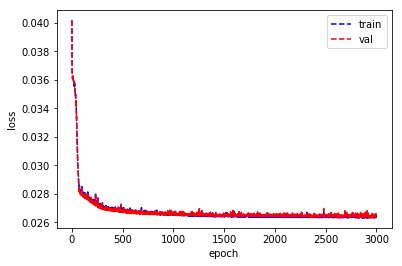

In [17]:
ax = plt.subplot(111)
ax.plot(np.arange(len(loss_train)), loss_train, 'b--')
ax.plot(np.arange(len(loss_val)), loss_val, 'r--')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_yscale("log")

ax.legend(["train","val"])
ax.figure.savefig("2-15-15-2,14,all-atom and h2t series latent space error.jpg")
plt.draw()

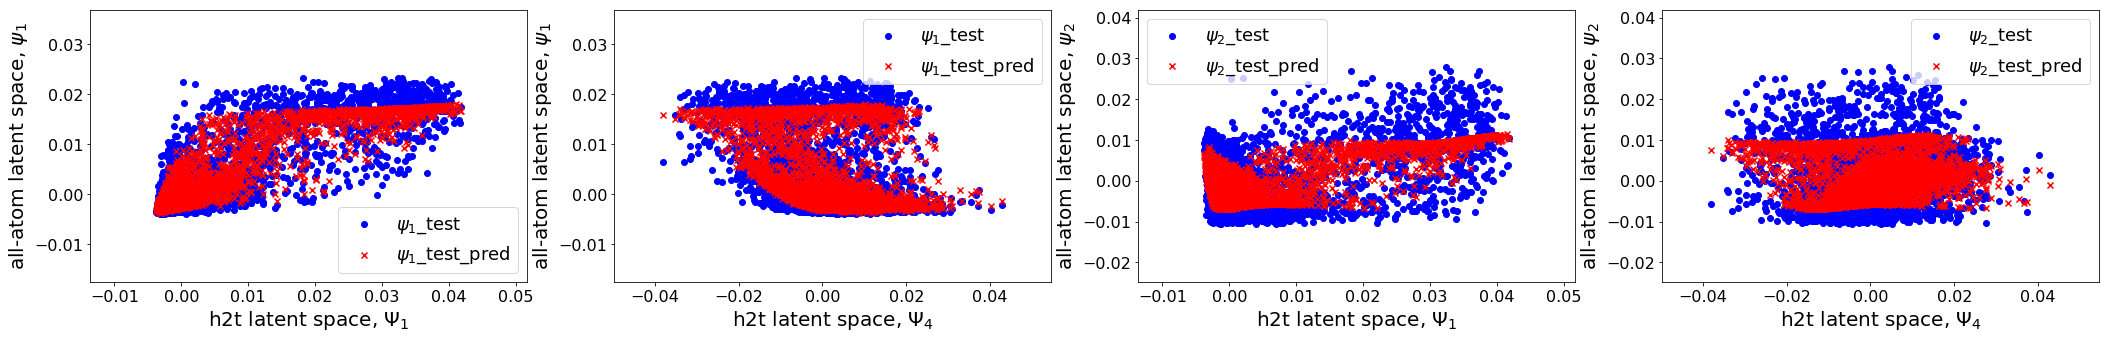

In [28]:
plt.figure(figsize=(36,5))

ax1 = plt.subplot(141)
ax1.scatter(x_test[:,0], y_test[:,0], c='blue', marker='o')
ax1.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax1.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax1.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax1.tick_params(labelsize=16)
ax1.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax2 = plt.subplot(142)
ax2.scatter(x_test[:,1], y_test[:,0], c='blue', marker='o')
ax2.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax2.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax2.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax2.tick_params(labelsize=16)
ax2.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax3 = plt.subplot(143)
ax3.scatter(x_test[:,0], y_test[:,1], c='blue', marker='o')
ax3.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax3.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax3.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax3.tick_params(labelsize=16)
ax3.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax4 = plt.subplot(144)
ax4.scatter(x_test[:,1], y_test[:,1], c='blue', marker='o')
ax4.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax4.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax4.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax4.tick_params(labelsize=16)
ax4.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax.figure.savefig("2-15-15-2,-14, all-atom and h2t series latent space correspondence.jpg")
plt.draw()